In [1]:
import os
import cv2
import math
import keras
import numpy as np
import random as r
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from keras import layers
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import image
from keras.utils import np_utils, plot_model

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
def get_files(file_dir, train_or_test):

    images = []   
    subfolders = []
    image_array = []
    image_list = []
    all_image = []
 
    for dirPath, dirNames, fileNames in os.walk(file_dir):
        
        names = []
        for name in fileNames:
            names.append(os.path.join(dirPath, name))
        for name in dirNames:
            subfolders.append(os.path.join(dirPath, name))
        r.shuffle(names)
        if names != []:
            images.append(names)
    
    if train_or_test == 'TRAIN':
        return images
    
    elif train_or_test == 'TEST':
    
        for i in range(len(images)):
            image_list.append([])
            image_list[i] = images[i]
  
        for i in range(len(images)):
            all_image.extend(image_list[i])

        image_labels = []

        for count in range(len(subfolders)):
            image_labels = np.append(image_labels, len(image_list[count]) * [count])
            
        image_array = np.array([all_image, image_labels])
        image_array = image_array[:, np.random.permutation(image_array.shape[1])].T
    
        image_img = list(image_array[:, 0])
        image_labels = list(image_array[:, 1])
        image_labels = [int(float(i)) for i in image_labels]
    
        return image_img, image_labels    

In [3]:
def shuffle(images):
    
    image_array = []
    image_list = []
    all_image = []
    
    for i in range(5):
        r.shuffle(images[i])
    
    for i in range(len(images)):
        image_list.append([])
        image_list[i] = images[i]
  
    for i in range(len(images)):
        all_image.extend(image_list[i])

    image_labels = []

    for count in range(5):
        image_labels = np.append(image_labels, len(image_list[count]) * [count])
            
    image_array = np.array([all_image, image_labels])
    image_array = image_array[:, np.random.permutation(image_array.shape[1])].T
    
    image_img = list(image_array[:, 0])
    image_labels = list(image_array[:, 1])
    image_labels = [int(float(i)) for i in image_labels]
    
    return image_img, image_labels

In [4]:
def cnn_model():
    model = Sequential()
    #卷積層1
    model.add(Conv2D(filters=63,
                     kernel_size=(3,3),
                     padding='same',
                     input_shape=(9,7,1), 
                     activation='relu', name = "conv_1"))
    model.add(BatchNormalization(name = "bn_1"))
    model.add(Dropout(0.25, name = "DP1"))
    #卷積層2
    model.add(Conv2D(filters=63,
                     kernel_size=(3,3),
                        padding='same',
                     activation='relu', name = "conv_2"))
    model.add(BatchNormalization(name = "bn_2"))
    model.add(Dropout(0.25, name = "DP2"))
    #卷積層3
    model.add(Conv2D(filters=63,
                     kernel_size=(3,3),
                     padding='same',
                     activation='relu', name = "conv_3"))
    model.add(BatchNormalization(name = "bn_3"))

    model.add(Dropout(0.25, name = "DP3"))
    #平坦層
    model.add(Flatten(name = "Flat"))
    #全連接層
    model.add(Dense(126, activation='relu', name = "dense_1"))
    #輸出層
    model.add(Dense(5,activation='softmax', name = "dense_2"))

    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy']) 
    
    return model

In [5]:
def data_preprocessing(image_list, image_label):

    image_data = []
    for img in image_list:
        img = Image.open(img)
        img = image.img_to_array(img)
        image_data.append(img)

    x_image = np.array(image_data)
    y_image = np.array(image_label)
    
    return x_image, y_image

In [6]:
def start_training_and_eva_score(x_train, y_train_onehot, x_test, y_test_onehot):
    
    MODEL = cnn_model()
    train_history = MODEL.fit(x = x_train, y = y_train_onehot, 
                              validation_split = 0.1, epochs = 5000, batch_size = 64, verbose = 1)
    scores = MODEL.evaluate(x_test, y_test_onehot)
    
    return train_history, scores, MODEL

In [7]:
def main(file_dir, one_dir):
    
    train_history_list = []
    score_list = []
    prediction_list = []
    y_test_list = []
    
    for i, item in enumerate(one_dir):
        
        train_img = []
        train_label = []
        test_img = []
        test_label = []
        
        all_images = [[],[],[],[],[]]
                
        for j in range (len(one_dir)-1):
            
            IMAGES = get_files(os.path.join(file_dir, one_dir[(i+1+j)%7]), 'TRAIN')
            for k in range (5):
                all_images[k].extend(IMAGES[k])
            
        train_img, train_label = shuffle(all_images)  
        test_img, test_label = get_files(os.path.join(file_dir, one_dir[i]), 'TEST')
            
        X_TRAIN, Y_TRAIN = data_preprocessing(train_img, train_label)
        X_TEST, Y_TEST = data_preprocessing(test_img, test_label)
            
        X_TRAIN/=255
        X_TEST/=255
            
        Y_TRAIN_ONEHOT = np_utils.to_categorical(Y_TRAIN)
        Y_TEST_ONEHOT = np_utils.to_categorical(Y_TEST)
        
        y_test_list.append(Y_TEST)
        
        print('Start using ' + one_dir[i] + ' file as test data to train....')
        print()
        TRAIN_HISTORY, SCORES , MODEL = start_training_and_eva_score(X_TRAIN, Y_TRAIN_ONEHOT, X_TEST, Y_TEST_ONEHOT)
        print('Done!')
        print()
        
        MODEL.save('Models/model/model_' + item + '.h5')
        MODEL.save_weights('Models/model_weights/model_weights_' + item + '.h5')
        
        train_history_list.append(TRAIN_HISTORY)
        score_list.append(SCORES)
        
        prediction = MODEL.predict_classes(X_TEST)
        prediction_list.append(prediction)       
        
    return train_history_list, score_list, prediction_list, y_test_list

In [8]:
def show_train_history(train_history, scores):

    print('Testing accuracy=',scores[1])
    print()
    plt.plot(train_history.history['acc'])
    plt.plot(train_history.history['val_acc'])
    plt.title('Accuracy')
    plt.ylabel('acc')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')
    plt.show()
    
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')
    plt.show()
    

In [9]:
FILE_DIR = 'new/train_data'
ONE_DIR = os.listdir(FILE_DIR)
print(ONE_DIR)

['cheng_yu', 'meng_huan', 'po_wen', 'shooter', 'wan_yi', 'wen_ying', 'yenjin_friendA', 'yi_fang', 'yu_chun', 'yu_wen']


In [10]:
TRAIN_HISTORY, SCORE_LIST , PREDICTION_LIST, TEST_DATA_LABEL = main(FILE_DIR, ONE_DIR)

Start using cheng_yu file as test data to train....

Train on 5850 samples, validate on 651 samples
Epoch 1/5000
5850/5850 [==============================] - 3s 546us/step - loss: 0.7391 - acc: 0.7374 - val_loss: 0.3959 - val_acc: 0.8556
Epoch 2/5000
5850/5850 [==============================] - 1s 246us/step - loss: 0.2633 - acc: 0.9053 - val_loss: 0.2766 - val_acc: 0.9186
Epoch 3/5000
5850/5850 [==============================] - 1s 246us/step - loss: 0.1854 - acc: 0.9309 - val_loss: 0.1167 - val_acc: 0.9585
Epoch 4/5000
5850/5850 [==============================] - 2s 261us/step - loss: 0.1280 - acc: 0.9528 - val_loss: 0.0729 - val_acc: 0.9693
Epoch 5/5000
5850/5850 [==============================] - 1s 246us/step - loss: 0.0920 - acc: 0.9660 - val_loss: 0.1198 - val_acc: 0.9601
Epoch 6/5000
5850/5850 [==============================] - 1s 250us/step - loss: 0.0602 - acc: 0.9785 - val_loss: 0.1193 - val_acc: 0.9601
Epoch 7/5000
5850/5850 [==============================] - 1s 246us/step 

5850/5850 [==============================] - 2s 260us/step - loss: 0.0061 - acc: 0.9985 - val_loss: 0.0187 - val_acc: 0.9939
Epoch 59/5000
5850/5850 [==============================] - 2s 260us/step - loss: 0.0022 - acc: 0.9990 - val_loss: 0.0190 - val_acc: 0.9939
Epoch 60/5000
5850/5850 [==============================] - 2s 258us/step - loss: 0.0044 - acc: 0.9983 - val_loss: 0.0216 - val_acc: 0.9939
Epoch 61/5000
5850/5850 [==============================] - 2s 258us/step - loss: 0.0025 - acc: 0.9995 - val_loss: 0.0186 - val_acc: 0.9939
Epoch 62/5000
5850/5850 [==============================] - 2s 258us/step - loss: 0.0020 - acc: 0.9995 - val_loss: 0.0512 - val_acc: 0.9877TA: 0s - loss: 0.0019 - acc: 
Epoch 63/5000
5850/5850 [==============================] - 2s 259us/step - loss: 0.0059 - acc: 0.9979 - val_loss: 0.0621 - val_acc: 0.9892
Epoch 64/5000
5850/5850 [==============================] - 2s 259us/step - loss: 0.0145 - acc: 0.9971 - val_loss: 0.1020 - val_acc: 0.9816
Epoch 65/500

5850/5850 [==============================] - 2s 264us/step - loss: 0.0077 - acc: 0.9981 - val_loss: 0.0287 - val_acc: 0.9908
Epoch 116/5000
5850/5850 [==============================] - 2s 265us/step - loss: 0.0133 - acc: 0.9968 - val_loss: 0.0430 - val_acc: 0.9862
Epoch 117/5000
5850/5850 [==============================] - 2s 265us/step - loss: 0.0147 - acc: 0.9962 - val_loss: 0.0401 - val_acc: 0.9939
Epoch 118/5000
5850/5850 [==============================] - 2s 265us/step - loss: 0.0109 - acc: 0.9976 - val_loss: 0.0433 - val_acc: 0.9939
Epoch 119/5000
5850/5850 [==============================] - 2s 267us/step - loss: 0.0022 - acc: 0.9991 - val_loss: 0.0422 - val_acc: 0.9908
Epoch 120/5000
5850/5850 [==============================] - 2s 269us/step - loss: 8.0469e-04 - acc: 0.9998 - val_loss: 0.0180 - val_acc: 0.9969
Epoch 121/5000
5850/5850 [==============================] - 2s 293us/step - loss: 5.5096e-04 - acc: 0.9997 - val_loss: 0.0250 - val_acc: 0.9954
Epoch 122/5000
5850/5850 [=

Epoch 172/5000
5850/5850 [==============================] - 2s 360us/step - loss: 0.0056 - acc: 0.9988 - val_loss: 0.0131 - val_acc: 0.9954
Epoch 173/5000
5850/5850 [==============================] - 2s 310us/step - loss: 0.0061 - acc: 0.9985 - val_loss: 0.0267 - val_acc: 0.9908
Epoch 174/5000
5850/5850 [==============================] - 2s 311us/step - loss: 0.0091 - acc: 0.9981 - val_loss: 0.0199 - val_acc: 0.9939
Epoch 175/5000
5850/5850 [==============================] - 2s 311us/step - loss: 0.0039 - acc: 0.9986 - val_loss: 0.0304 - val_acc: 0.9939
Epoch 176/5000
5850/5850 [==============================] - 2s 316us/step - loss: 0.0020 - acc: 0.9997 - val_loss: 0.0245 - val_acc: 0.9954
Epoch 177/5000
5850/5850 [==============================] - 2s 264us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0366 - val_acc: 0.9954
Epoch 178/5000
5850/5850 [==============================] - 2s 264us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0348 - val_acc: 0.9954
Epoch 179/5000
5850/

5850/5850 [==============================] - 2s 342us/step - loss: 0.0019 - acc: 0.9993 - val_loss: 0.0341 - val_acc: 0.9939: 0.0024 - acc: 
Epoch 230/5000
5850/5850 [==============================] - 2s 344us/step - loss: 0.0053 - acc: 0.9983 - val_loss: 0.0054 - val_acc: 0.9969
Epoch 231/5000
5850/5850 [==============================] - 2s 274us/step - loss: 0.0072 - acc: 0.9986 - val_loss: 0.0028 - val_acc: 0.9985
Epoch 232/5000
5850/5850 [==============================] - 2s 368us/step - loss: 0.0037 - acc: 0.9990 - val_loss: 0.0238 - val_acc: 0.9969
Epoch 233/5000
5850/5850 [==============================] - 2s 350us/step - loss: 4.1234e-04 - acc: 0.9998 - val_loss: 0.0193 - val_acc: 0.9969
Epoch 234/5000
5850/5850 [==============================] - 2s 380us/step - loss: 0.0013 - acc: 0.9997 - val_loss: 0.0211 - val_acc: 0.9954
Epoch 235/5000
5850/5850 [==============================] - 2s 400us/step - loss: 5.8017e-04 - acc: 0.9998 - val_loss: 0.0150 - val_acc: 0.9985
Epoch 236/5

Epoch 287/5000
5850/5850 [==============================] - 2s 295us/step - loss: 6.8989e-04 - acc: 0.9998 - val_loss: 0.0216 - val_acc: 0.9954
Epoch 288/5000
5850/5850 [==============================] - 2s 297us/step - loss: 0.0025 - acc: 0.9993 - val_loss: 0.0123 - val_acc: 0.9969
Epoch 289/5000
5850/5850 [==============================] - 2s 298us/step - loss: 0.0017 - acc: 0.9995 - val_loss: 0.0247 - val_acc: 0.9923
Epoch 290/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0020 - acc: 0.9995 - val_loss: 0.0268 - val_acc: 0.9939
Epoch 291/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0041 - acc: 0.9990 - val_loss: 0.0433 - val_acc: 0.9923
Epoch 292/5000
5850/5850 [==============================] - 2s 289us/step - loss: 0.0025 - acc: 0.9993 - val_loss: 0.0379 - val_acc: 0.9923
Epoch 293/5000
5850/5850 [==============================] - 2s 281us/step - loss: 0.0053 - acc: 0.9986 - val_loss: 0.0330 - val_acc: 0.9939
Epoch 294/5000
5

Epoch 345/5000
5850/5850 [==============================] - 2s 285us/step - loss: 7.4899e-04 - acc: 0.9995 - val_loss: 0.0019 - val_acc: 0.9985
Epoch 346/5000
5850/5850 [==============================] - 2s 286us/step - loss: 2.0538e-05 - acc: 1.0000 - val_loss: 0.0178 - val_acc: 0.9969
Epoch 347/5000
5850/5850 [==============================] - 2s 290us/step - loss: 0.0056 - acc: 0.9985 - val_loss: 0.0362 - val_acc: 0.9923
Epoch 348/5000
5850/5850 [==============================] - 2s 293us/step - loss: 0.0095 - acc: 0.9978 - val_loss: 0.0271 - val_acc: 0.9954
Epoch 349/5000
5850/5850 [==============================] - 2s 299us/step - loss: 0.0043 - acc: 0.9990 - val_loss: 0.0235 - val_acc: 0.9969
Epoch 350/5000
5850/5850 [==============================] - 2s 290us/step - loss: 0.0020 - acc: 0.9993 - val_loss: 0.0379 - val_acc: 0.9954
Epoch 351/5000
5850/5850 [==============================] - 2s 286us/step - loss: 8.9412e-04 - acc: 0.9998 - val_loss: 0.0293 - val_acc: 0.9954
Epoch 35

Epoch 403/5000
5850/5850 [==============================] - 2s 318us/step - loss: 0.0011 - acc: 0.9997 - val_loss: 0.0461 - val_acc: 0.9954
Epoch 404/5000
5850/5850 [==============================] - 2s 271us/step - loss: 1.8837e-04 - acc: 1.0000 - val_loss: 0.0358 - val_acc: 0.9954
Epoch 405/5000
5850/5850 [==============================] - 2s 270us/step - loss: 9.3753e-05 - acc: 1.0000 - val_loss: 0.0318 - val_acc: 0.9954
Epoch 406/5000
5850/5850 [==============================] - 2s 270us/step - loss: 0.0039 - acc: 0.9995 - val_loss: 0.0261 - val_acc: 0.9985
Epoch 407/5000
5850/5850 [==============================] - 2s 270us/step - loss: 0.0038 - acc: 0.9991 - val_loss: 0.0327 - val_acc: 0.9923
Epoch 408/5000
5850/5850 [==============================] - 2s 269us/step - loss: 0.0020 - acc: 0.9995 - val_loss: 0.0348 - val_acc: 0.9954
Epoch 409/5000
5850/5850 [==============================] - 2s 318us/step - loss: 0.0015 - acc: 0.9997 - val_loss: 0.0321 - val_acc: 0.9939
Epoch 410/50

5850/5850 [==============================] - 2s 273us/step - loss: 7.4168e-04 - acc: 0.9998 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 461/5000
5850/5850 [==============================] - 2s 274us/step - loss: 2.3220e-05 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 462/5000
5850/5850 [==============================] - 2s 275us/step - loss: 0.0026 - acc: 0.9995 - val_loss: 0.0316 - val_acc: 0.9954
Epoch 463/5000
5850/5850 [==============================] - 2s 274us/step - loss: 5.2645e-04 - acc: 0.9997 - val_loss: 0.0256 - val_acc: 0.9985
Epoch 464/5000
5850/5850 [==============================] - 2s 274us/step - loss: 1.0090e-04 - acc: 1.0000 - val_loss: 0.0258 - val_acc: 0.9985
Epoch 465/5000
5850/5850 [==============================] - 2s 275us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0260 - val_acc: 0.9985
Epoch 466/5000
5850/5850 [==============================] - 2s 275us/step - loss: 0.0062 - acc: 0.9990 - val_loss: 0.0305 - val_acc: 0.9969
Epoch 467/5000
5850

Epoch 518/5000
5850/5850 [==============================] - 2s 275us/step - loss: 0.0018 - acc: 0.9997 - val_loss: 0.0476 - val_acc: 0.9923
Epoch 519/5000
5850/5850 [==============================] - 2s 275us/step - loss: 0.0035 - acc: 0.9991 - val_loss: 0.1021 - val_acc: 0.9892
Epoch 520/5000
5850/5850 [==============================] - 2s 276us/step - loss: 0.0053 - acc: 0.9988 - val_loss: 0.0174 - val_acc: 0.9985
Epoch 521/5000
5850/5850 [==============================] - 2s 275us/step - loss: 4.7301e-04 - acc: 0.9998 - val_loss: 0.0319 - val_acc: 0.9969
Epoch 522/5000
5850/5850 [==============================] - 2s 276us/step - loss: 0.0017 - acc: 0.9993 - val_loss: 0.0219 - val_acc: 0.9985
Epoch 523/5000
5850/5850 [==============================] - 2s 274us/step - loss: 0.0025 - acc: 0.9997 - val_loss: 0.0263 - val_acc: 0.9969
Epoch 524/5000
5850/5850 [==============================] - 2s 274us/step - loss: 3.7501e-04 - acc: 0.9998 - val_loss: 0.0250 - val_acc: 0.9985
Epoch 525/50

5850/5850 [==============================] - 2s 276us/step - loss: 0.0017 - acc: 0.9997 - val_loss: 0.0062 - val_acc: 0.9969
Epoch 576/5000
5850/5850 [==============================] - 2s 276us/step - loss: 1.1998e-04 - acc: 1.0000 - val_loss: 0.0088 - val_acc: 0.9985
Epoch 577/5000
5850/5850 [==============================] - 2s 275us/step - loss: 5.8106e-04 - acc: 0.9998 - val_loss: 0.0124 - val_acc: 0.9954
Epoch 578/5000
5850/5850 [==============================] - 2s 275us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0280 - val_acc: 0.9939
Epoch 579/5000
5850/5850 [==============================] - 2s 276us/step - loss: 1.1109e-05 - acc: 1.0000 - val_loss: 0.0251 - val_acc: 0.9939
Epoch 580/5000
5850/5850 [==============================] - 2s 275us/step - loss: 0.0022 - acc: 0.9995 - val_loss: 0.0069 - val_acc: 0.9969
Epoch 581/5000
5850/5850 [==============================] - 2s 276us/step - loss: 0.0044 - acc: 0.9993 - val_loss: 0.0177 - val_acc: 0.9954
Epoch 582/5000
5850/585

5850/5850 [==============================] - 2s 277us/step - loss: 0.0013 - acc: 0.9995 - val_loss: 0.0211 - val_acc: 0.9985
Epoch 633/5000
5850/5850 [==============================] - 2s 276us/step - loss: 3.3999e-04 - acc: 0.9998 - val_loss: 0.0437 - val_acc: 0.9969
Epoch 634/5000
5850/5850 [==============================] - 2s 274us/step - loss: 0.0023 - acc: 0.9995 - val_loss: 0.0267 - val_acc: 0.9969
Epoch 635/5000
5850/5850 [==============================] - 2s 272us/step - loss: 9.9000e-04 - acc: 0.9997 - val_loss: 0.0167 - val_acc: 0.9969
Epoch 636/5000
5850/5850 [==============================] - 2s 270us/step - loss: 3.5384e-06 - acc: 1.0000 - val_loss: 0.0153 - val_acc: 0.9985
Epoch 637/5000
5850/5850 [==============================] - 2s 272us/step - loss: 0.0033 - acc: 0.9993 - val_loss: 0.0263 - val_acc: 0.9969
Epoch 638/5000
5850/5850 [==============================] - 2s 270us/step - loss: 0.0028 - acc: 0.9991 - val_loss: 0.0907 - val_acc: 0.9923
Epoch 639/5000
5850/585

5850/5850 [==============================] - 2s 278us/step - loss: 0.0021 - acc: 0.9991 - val_loss: 0.0772 - val_acc: 0.9923
Epoch 690/5000
5850/5850 [==============================] - 2s 278us/step - loss: 0.0021 - acc: 0.9995 - val_loss: 0.0510 - val_acc: 0.9939
Epoch 691/5000
5850/5850 [==============================] - 2s 278us/step - loss: 0.0049 - acc: 0.9993 - val_loss: 0.0613 - val_acc: 0.9939
Epoch 692/5000
5850/5850 [==============================] - 2s 278us/step - loss: 0.0036 - acc: 0.9991 - val_loss: 0.0481 - val_acc: 0.9954
Epoch 693/5000
5850/5850 [==============================] - 2s 278us/step - loss: 0.0036 - acc: 0.9993 - val_loss: 0.0275 - val_acc: 0.9939
Epoch 694/5000
5850/5850 [==============================] - 2s 279us/step - loss: 9.0160e-05 - acc: 1.0000 - val_loss: 0.0206 - val_acc: 0.9969
Epoch 695/5000
5850/5850 [==============================] - 2s 277us/step - loss: 3.5085e-04 - acc: 0.9998 - val_loss: 0.0209 - val_acc: 0.9969
Epoch 696/5000
5850/5850 [=

5850/5850 [==============================] - 2s 276us/step - loss: 5.9704e-04 - acc: 0.9997 - val_loss: 0.0574 - val_acc: 0.9954
Epoch 747/5000
5850/5850 [==============================] - 2s 276us/step - loss: 0.0018 - acc: 0.9993 - val_loss: 0.0447 - val_acc: 0.9954
Epoch 748/5000
5850/5850 [==============================] - 2s 278us/step - loss: 0.0017 - acc: 0.9995 - val_loss: 0.0389 - val_acc: 0.9969
Epoch 749/5000
5850/5850 [==============================] - 2s 277us/step - loss: 0.0012 - acc: 0.9995 - val_loss: 0.0297 - val_acc: 0.9969
Epoch 750/5000
5850/5850 [==============================] - 2s 277us/step - loss: 6.2733e-06 - acc: 1.0000 - val_loss: 0.0353 - val_acc: 0.9969
Epoch 751/5000
5850/5850 [==============================] - 2s 278us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0336 - val_acc: 0.9969
Epoch 752/5000
5850/5850 [==============================] - 2s 279us/step - loss: 1.4257e-04 - acc: 0.9998 - val_loss: 0.0267 - val_acc: 0.9969
Epoch 753/5000
5850/585

5850/5850 [==============================] - 2s 280us/step - loss: 0.0024 - acc: 0.9995 - val_loss: 0.0257 - val_acc: 0.9985
Epoch 804/5000
5850/5850 [==============================] - 2s 281us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0259 - val_acc: 0.9985
Epoch 805/5000
5850/5850 [==============================] - 2s 280us/step - loss: 4.9588e-05 - acc: 1.0000 - val_loss: 0.0251 - val_acc: 0.9969
Epoch 806/5000
5850/5850 [==============================] - 2s 280us/step - loss: 0.0021 - acc: 0.9998 - val_loss: 0.0284 - val_acc: 0.9954
Epoch 807/5000
5850/5850 [==============================] - 2s 280us/step - loss: 0.0056 - acc: 0.9988 - val_loss: 0.0481 - val_acc: 0.9939
Epoch 808/5000
5850/5850 [==============================] - 2s 281us/step - loss: 0.0061 - acc: 0.9990 - val_loss: 0.0373 - val_acc: 0.9954
Epoch 809/5000
5850/5850 [==============================] - 2s 280us/step - loss: 0.0029 - acc: 0.9997 - val_loss: 0.0074 - val_acc: 0.9985
Epoch 810/5000
5850/5850 [=====

Epoch 861/5000
5850/5850 [==============================] - 2s 280us/step - loss: 0.0043 - acc: 0.9990 - val_loss: 0.0386 - val_acc: 0.9954
Epoch 862/5000
5850/5850 [==============================] - 2s 280us/step - loss: 0.0031 - acc: 0.9997 - val_loss: 0.0342 - val_acc: 0.9969
Epoch 863/5000
5850/5850 [==============================] - 2s 280us/step - loss: 1.9054e-04 - acc: 1.0000 - val_loss: 0.0423 - val_acc: 0.9969
Epoch 864/5000
5850/5850 [==============================] - 2s 280us/step - loss: 1.1821e-04 - acc: 1.0000 - val_loss: 0.0390 - val_acc: 0.9969
Epoch 865/5000
5850/5850 [==============================] - 2s 280us/step - loss: 6.8193e-06 - acc: 1.0000 - val_loss: 0.0394 - val_acc: 0.9969
Epoch 866/5000
5850/5850 [==============================] - 2s 279us/step - loss: 1.6004e-06 - acc: 1.0000 - val_loss: 0.0395 - val_acc: 0.9969
Epoch 867/5000
5850/5850 [==============================] - 2s 281us/step - loss: 2.8602e-05 - acc: 1.0000 - val_loss: 0.0389 - val_acc: 0.9969


5850/5850 [==============================] - 2s 296us/step - loss: 1.3102e-05 - acc: 1.0000 - val_loss: 3.0712e-04 - val_acc: 1.0000
Epoch 919/5000
5850/5850 [==============================] - 2s 301us/step - loss: 0.0034 - acc: 0.9997 - val_loss: 0.0029 - val_acc: 0.9985
Epoch 920/5000
5850/5850 [==============================] - 2s 297us/step - loss: 7.0670e-04 - acc: 0.9995 - val_loss: 0.0194 - val_acc: 0.9969
Epoch 921/5000
5850/5850 [==============================] - 2s 296us/step - loss: 2.2443e-05 - acc: 1.0000 - val_loss: 0.0153 - val_acc: 0.9969
Epoch 922/5000
5850/5850 [==============================] - 2s 296us/step - loss: 7.9851e-05 - acc: 1.0000 - val_loss: 0.0119 - val_acc: 0.9985
Epoch 923/5000
5850/5850 [==============================] - 2s 296us/step - loss: 3.0567e-06 - acc: 1.0000 - val_loss: 0.0122 - val_acc: 0.9985
Epoch 924/5000
5850/5850 [==============================] - 2s 297us/step - loss: 5.4570e-05 - acc: 1.0000 - val_loss: 0.0139 - val_acc: 0.9985
Epoch 9

5850/5850 [==============================] - 2s 339us/step - loss: 0.0034 - acc: 0.9995 - val_loss: 0.0295 - val_acc: 0.9954
Epoch 976/5000
5850/5850 [==============================] - 2s 292us/step - loss: 0.0024 - acc: 0.9995 - val_loss: 0.0255 - val_acc: 0.9985
Epoch 977/5000
5850/5850 [==============================] - 2s 292us/step - loss: 1.2276e-04 - acc: 1.0000 - val_loss: 0.0298 - val_acc: 0.9969
Epoch 978/5000
5850/5850 [==============================] - 2s 338us/step - loss: 7.5351e-04 - acc: 0.9997 - val_loss: 0.0274 - val_acc: 0.9969
Epoch 979/5000
5850/5850 [==============================] - 2s 294us/step - loss: 9.6179e-04 - acc: 0.9997 - val_loss: 0.0305 - val_acc: 0.9969
Epoch 980/5000
5850/5850 [==============================] - 2s 295us/step - loss: 0.0037 - acc: 0.9995 - val_loss: 0.0459 - val_acc: 0.9969
Epoch 981/5000
5850/5850 [==============================] - 2s 297us/step - loss: 3.5596e-04 - acc: 0.9998 - val_loss: 0.0794 - val_acc: 0.9923
Epoch 982/5000
5850

5850/5850 [==============================] - 2s 278us/step - loss: 6.8429e-04 - acc: 0.9998 - val_loss: 0.0618 - val_acc: 0.9939
Epoch 1033/5000
5850/5850 [==============================] - 2s 278us/step - loss: 2.7109e-04 - acc: 0.9998 - val_loss: 0.0029 - val_acc: 0.9985
Epoch 1034/5000
5850/5850 [==============================] - 2s 278us/step - loss: 0.0017 - acc: 0.9995 - val_loss: 0.0684 - val_acc: 0.9939
Epoch 1035/5000
5850/5850 [==============================] - 2s 279us/step - loss: 0.0036 - acc: 0.9997 - val_loss: 0.0362 - val_acc: 0.9969
Epoch 1036/5000
5850/5850 [==============================] - 2s 279us/step - loss: 0.0030 - acc: 0.9997 - val_loss: 0.0388 - val_acc: 0.9969
Epoch 1037/5000
5850/5850 [==============================] - 2s 279us/step - loss: 0.0037 - acc: 0.9995 - val_loss: 0.0331 - val_acc: 0.9939
Epoch 1038/5000
5850/5850 [==============================] - 2s 278us/step - loss: 0.0037 - acc: 0.9995 - val_loss: 0.0250 - val_acc: 0.9985
Epoch 1039/5000
5850/

5850/5850 [==============================] - 2s 279us/step - loss: 1.8300e-04 - acc: 0.9998 - val_loss: 0.0251 - val_acc: 0.9985
Epoch 1090/5000
5850/5850 [==============================] - 2s 278us/step - loss: 3.2751e-04 - acc: 0.9998 - val_loss: 0.0191 - val_acc: 0.9969
Epoch 1091/5000
5850/5850 [==============================] - 2s 278us/step - loss: 2.4494e-05 - acc: 1.0000 - val_loss: 0.0213 - val_acc: 0.9985
Epoch 1092/5000
5850/5850 [==============================] - 2s 279us/step - loss: 9.1266e-06 - acc: 1.0000 - val_loss: 0.0218 - val_acc: 0.9985
Epoch 1093/5000
5850/5850 [==============================] - 2s 278us/step - loss: 6.4533e-04 - acc: 0.9998 - val_loss: 0.0229 - val_acc: 0.9985
Epoch 1094/5000
5850/5850 [==============================] - 2s 278us/step - loss: 0.0090 - acc: 0.9993 - val_loss: 0.0252 - val_acc: 0.9985
Epoch 1095/5000
5850/5850 [==============================] - 2s 278us/step - loss: 0.0042 - acc: 0.9997 - val_loss: 0.0253 - val_acc: 0.9985
Epoch 109

5850/5850 [==============================] - 2s 280us/step - loss: 2.4954e-06 - acc: 1.0000 - val_loss: 0.0230 - val_acc: 0.9985
Epoch 1147/5000
5850/5850 [==============================] - 2s 280us/step - loss: 2.1257e-05 - acc: 1.0000 - val_loss: 0.0228 - val_acc: 0.9985
Epoch 1148/5000
5850/5850 [==============================] - 2s 279us/step - loss: 4.3914e-06 - acc: 1.0000 - val_loss: 0.0226 - val_acc: 0.9985
Epoch 1149/5000
5850/5850 [==============================] - 2s 280us/step - loss: 0.0034 - acc: 0.9995 - val_loss: 0.1619 - val_acc: 0.9877
Epoch 1150/5000
5850/5850 [==============================] - 2s 289us/step - loss: 5.0986e-04 - acc: 0.9995 - val_loss: 0.0373 - val_acc: 0.9954
Epoch 1151/5000
5850/5850 [==============================] - 2s 280us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0438 - val_acc: 0.9954
Epoch 1152/5000
5850/5850 [==============================] - 2s 279us/step - loss: 0.0013 - acc: 0.9997 - val_loss: 0.0328 - val_acc: 0.9954
Epoch 1153/50

5850/5850 [==============================] - 2s 279us/step - loss: 6.6734e-04 - acc: 0.9995 - val_loss: 0.0313 - val_acc: 0.9954
Epoch 1204/5000
5850/5850 [==============================] - 2s 279us/step - loss: 8.5887e-04 - acc: 0.9997 - val_loss: 0.0313 - val_acc: 0.9969
Epoch 1205/5000
5850/5850 [==============================] - 2s 279us/step - loss: 0.0040 - acc: 0.9991 - val_loss: 0.0268 - val_acc: 0.9969
Epoch 1206/5000
5850/5850 [==============================] - 2s 279us/step - loss: 0.0023 - acc: 0.9995 - val_loss: 0.0379 - val_acc: 0.9969
Epoch 1207/5000
5850/5850 [==============================] - 2s 279us/step - loss: 1.9160e-04 - acc: 0.9998 - val_loss: 0.0413 - val_acc: 0.9954
Epoch 1208/5000
5850/5850 [==============================] - 2s 279us/step - loss: 1.6946e-06 - acc: 1.0000 - val_loss: 0.0371 - val_acc: 0.9954
Epoch 1209/5000
5850/5850 [==============================] - 2s 278us/step - loss: 0.0030 - acc: 0.9997 - val_loss: 0.0282 - val_acc: 0.9969
Epoch 1210/50

Epoch 1260/5000
5850/5850 [==============================] - 2s 281us/step - loss: 0.0076 - acc: 0.9986 - val_loss: 0.0189 - val_acc: 0.9969
Epoch 1261/5000
5850/5850 [==============================] - 2s 279us/step - loss: 0.0040 - acc: 0.9995 - val_loss: 0.0108 - val_acc: 0.9954
Epoch 1262/5000
5850/5850 [==============================] - 2s 278us/step - loss: 4.8519e-04 - acc: 0.9998 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 1263/5000
5850/5850 [==============================] - 2s 280us/step - loss: 2.9604e-05 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 0.9985
Epoch 1264/5000
5850/5850 [==============================] - 2s 278us/step - loss: 9.1076e-04 - acc: 0.9998 - val_loss: 0.0075 - val_acc: 0.9985
Epoch 1265/5000
5850/5850 [==============================] - 2s 279us/step - loss: 0.0015 - acc: 0.9997 - val_loss: 3.0881e-04 - val_acc: 1.0000
Epoch 1266/5000
5850/5850 [==============================] - 2s 279us/step - loss: 0.0012 - acc: 0.9995 - val_loss: 0.0012 - val_acc: 1.00

Epoch 1317/5000
5850/5850 [==============================] - 2s 279us/step - loss: 7.2501e-04 - acc: 0.9998 - val_loss: 0.0068 - val_acc: 0.9969
Epoch 1318/5000
5850/5850 [==============================] - 2s 279us/step - loss: 1.9448e-05 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 0.9985
Epoch 1319/5000
5850/5850 [==============================] - 2s 278us/step - loss: 7.1795e-04 - acc: 0.9998 - val_loss: 0.0096 - val_acc: 0.9985
Epoch 1320/5000
5850/5850 [==============================] - 2s 278us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0148 - val_acc: 0.9985
Epoch 1321/5000
5850/5850 [==============================] - 2s 280us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0107 - val_acc: 0.9985
Epoch 1322/5000
5850/5850 [==============================] - 2s 278us/step - loss: 0.0024 - acc: 0.9995 - val_loss: 0.0201 - val_acc: 0.9954
Epoch 1323/5000
5850/5850 [==============================] - 2s 278us/step - loss: 1.5896e-04 - acc: 0.9998 - val_loss: 0.0205 - val_acc: 0.99

5850/5850 [==============================] - 2s 279us/step - loss: 2.4928e-06 - acc: 1.0000 - val_loss: 0.0365 - val_acc: 0.9954
Epoch 1375/5000
5850/5850 [==============================] - 2s 280us/step - loss: 1.3279e-05 - acc: 1.0000 - val_loss: 0.0380 - val_acc: 0.9954
Epoch 1376/5000
5850/5850 [==============================] - 2s 280us/step - loss: 5.5499e-06 - acc: 1.0000 - val_loss: 0.0401 - val_acc: 0.9954
Epoch 1377/5000
5850/5850 [==============================] - 2s 279us/step - loss: 6.3876e-06 - acc: 1.0000 - val_loss: 0.0402 - val_acc: 0.9954
Epoch 1378/5000
5850/5850 [==============================] - 2s 280us/step - loss: 8.8623e-04 - acc: 0.9998 - val_loss: 0.0632 - val_acc: 0.9954
Epoch 1379/5000
5850/5850 [==============================] - 2s 280us/step - loss: 0.0030 - acc: 0.9997 - val_loss: 0.0513 - val_acc: 0.9954
Epoch 1380/5000
5850/5850 [==============================] - 2s 279us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0479 - val_acc: 0.9954
Epoch 138

5850/5850 [==============================] - 2s 278us/step - loss: 1.6148e-07 - acc: 1.0000 - val_loss: 0.0499 - val_acc: 0.9954
Epoch 1432/5000
5850/5850 [==============================] - 2s 278us/step - loss: 4.3101e-06 - acc: 1.0000 - val_loss: 0.0484 - val_acc: 0.9954
Epoch 1433/5000
5850/5850 [==============================] - 2s 278us/step - loss: 3.8503e-06 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9954
Epoch 1434/5000
5850/5850 [==============================] - 2s 279us/step - loss: 3.5650e-06 - acc: 1.0000 - val_loss: 0.0510 - val_acc: 0.9954
Epoch 1435/5000
5850/5850 [==============================] - 2s 278us/step - loss: 2.8196e-05 - acc: 1.0000 - val_loss: 0.0440 - val_acc: 0.9954
Epoch 1436/5000
5850/5850 [==============================] - 2s 278us/step - loss: 0.0012 - acc: 0.9997 - val_loss: 0.0741 - val_acc: 0.9954
Epoch 1437/5000
5850/5850 [==============================] - 2s 279us/step - loss: 6.4991e-04 - acc: 0.9998 - val_loss: 0.0417 - val_acc: 0.9969
Epoch

Epoch 1488/5000
5850/5850 [==============================] - 2s 279us/step - loss: 1.7294e-05 - acc: 1.0000 - val_loss: 0.0229 - val_acc: 0.9985
Epoch 1489/5000
5850/5850 [==============================] - 2s 280us/step - loss: 5.5531e-05 - acc: 1.0000 - val_loss: 0.0218 - val_acc: 0.9985
Epoch 1490/5000
5850/5850 [==============================] - 2s 278us/step - loss: 8.6414e-04 - acc: 0.9998 - val_loss: 0.0240 - val_acc: 0.9985
Epoch 1491/5000
5850/5850 [==============================] - 2s 279us/step - loss: 0.0021 - acc: 0.9998 - val_loss: 0.0289 - val_acc: 0.9954
Epoch 1492/5000
5850/5850 [==============================] - 2s 280us/step - loss: 1.8629e-04 - acc: 0.9998 - val_loss: 0.0384 - val_acc: 0.9954
Epoch 1493/5000
5850/5850 [==============================] - 2s 282us/step - loss: 0.0012 - acc: 0.9997 - val_loss: 0.0324 - val_acc: 0.9954
Epoch 1494/5000
5850/5850 [==============================] - 2s 280us/step - loss: 6.2074e-05 - acc: 1.0000 - val_loss: 0.0272 - val_acc: 

5850/5850 [==============================] - 2s 281us/step - loss: 0.0070 - acc: 0.9991 - val_loss: 0.0443 - val_acc: 0.9939
Epoch 1546/5000
5850/5850 [==============================] - 2s 282us/step - loss: 0.0017 - acc: 0.9997 - val_loss: 0.0301 - val_acc: 0.9969
Epoch 1547/5000
5850/5850 [==============================] - 2s 281us/step - loss: 1.6341e-07 - acc: 1.0000 - val_loss: 0.0251 - val_acc: 0.9985
Epoch 1548/5000
5850/5850 [==============================] - 2s 282us/step - loss: 3.3017e-07 - acc: 1.0000 - val_loss: 0.0251 - val_acc: 0.9985
Epoch 1549/5000
5850/5850 [==============================] - 2s 281us/step - loss: 6.5333e-06 - acc: 1.0000 - val_loss: 0.0251 - val_acc: 0.9985
Epoch 1550/5000
5850/5850 [==============================] - 2s 281us/step - loss: 0.0081 - acc: 0.9991 - val_loss: 0.0498 - val_acc: 0.9954
Epoch 1551/5000
5850/5850 [==============================] - 2s 281us/step - loss: 0.0055 - acc: 0.9997 - val_loss: 0.0249 - val_acc: 0.9985
Epoch 1552/5000
5

5850/5850 [==============================] - 2s 349us/step - loss: 4.3178e-06 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 1603/5000
5850/5850 [==============================] - 2s 357us/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 1604/5000
5850/5850 [==============================] - 2s 359us/step - loss: 1.0238e-06 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 1605/5000
5850/5850 [==============================] - 2s 320us/step - loss: 7.5246e-04 - acc: 0.9997 - val_loss: 0.0264 - val_acc: 0.9969
Epoch 1606/5000
5850/5850 [==============================] - 2s 324us/step - loss: 0.0047 - acc: 0.9997 - val_loss: 0.0249 - val_acc: 0.9985
Epoch 1607/5000
5850/5850 [==============================] - 2s 274us/step - loss: 0.0051 - acc: 0.9995 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 1608/5000
5850/5850 [==============================] - 2s 323us/step - loss: 0.0022 - acc: 0.9997 - val_loss: 0.0341 - val_acc: 0.9969
Epoch 1609/5000
5

5850/5850 [==============================] - 2s 284us/step - loss: 8.7994e-04 - acc: 0.9998 - val_loss: 0.0497 - val_acc: 0.9969
Epoch 1660/5000
5850/5850 [==============================] - 2s 286us/step - loss: 2.1005e-07 - acc: 1.0000 - val_loss: 0.0499 - val_acc: 0.9969
Epoch 1661/5000
5850/5850 [==============================] - 2s 284us/step - loss: 0.0021 - acc: 0.9998 - val_loss: 0.0260 - val_acc: 0.9969
Epoch 1662/5000
5850/5850 [==============================] - 2s 284us/step - loss: 6.7316e-05 - acc: 1.0000 - val_loss: 0.0249 - val_acc: 0.9985
Epoch 1663/5000
5850/5850 [==============================] - 2s 287us/step - loss: 1.1094e-06 - acc: 1.0000 - val_loss: 0.0251 - val_acc: 0.9985
Epoch 1664/5000
5850/5850 [==============================] - 2s 285us/step - loss: 0.0015 - acc: 0.9998 - val_loss: 0.0353 - val_acc: 0.9954
Epoch 1665/5000
5850/5850 [==============================] - 2s 285us/step - loss: 1.1243e-05 - acc: 1.0000 - val_loss: 0.0305 - val_acc: 0.9969
Epoch 166

5850/5850 [==============================] - 2s 280us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0471 - val_acc: 0.9969
Epoch 1717/5000
5850/5850 [==============================] - 2s 280us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0371 - val_acc: 0.9969
Epoch 1718/5000
5850/5850 [==============================] - 2s 286us/step - loss: 8.7884e-06 - acc: 1.0000 - val_loss: 0.0293 - val_acc: 0.9969
Epoch 1719/5000
5850/5850 [==============================] - 2s 303us/step - loss: 6.0311e-06 - acc: 1.0000 - val_loss: 0.0332 - val_acc: 0.9969
Epoch 1720/5000
5850/5850 [==============================] - 2s 312us/step - loss: 0.0024 - acc: 0.9993 - val_loss: 0.0089 - val_acc: 0.9985
Epoch 1721/5000
5850/5850 [==============================] - 2s 293us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0085 - val_acc: 0.9985
Epoch 1722/5000
5850/5850 [==============================] - 2s 284us/step - loss: 0.0030 - acc: 0.9995 - val_loss: 0.0209 - val_acc: 0.9954
Epoch 1723/5000
5850/

Epoch 1773/5000
5850/5850 [==============================] - 2s 279us/step - loss: 1.4846e-05 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 1774/5000
5850/5850 [==============================] - 2s 280us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0408 - val_acc: 0.9969
Epoch 1775/5000
5850/5850 [==============================] - 2s 280us/step - loss: 0.0030 - acc: 0.9993 - val_loss: 0.0281 - val_acc: 0.9969
Epoch 1776/5000
5850/5850 [==============================] - 2s 280us/step - loss: 2.7510e-04 - acc: 0.9998 - val_loss: 0.0303 - val_acc: 0.9954
Epoch 1777/5000
5850/5850 [==============================] - 2s 300us/step - loss: 4.3033e-06 - acc: 1.0000 - val_loss: 0.0271 - val_acc: 0.9969
Epoch 1778/5000
5850/5850 [==============================] - 2s 309us/step - loss: 0.0034 - acc: 0.9993 - val_loss: 0.0530 - val_acc: 0.9923
Epoch 1779/5000
5850/5850 [==============================] - 2s 302us/step - loss: 0.0042 - acc: 0.9997 - val_loss: 0.0331 - val_acc: 0.9954
E

5850/5850 [==============================] - 2s 280us/step - loss: 1.7035e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 1831/5000
5850/5850 [==============================] - 2s 280us/step - loss: 4.7727e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 1832/5000
5850/5850 [==============================] - 2s 280us/step - loss: 4.3811e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 1833/5000
5850/5850 [==============================] - 2s 280us/step - loss: 0.0029 - acc: 0.9997 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 1834/5000
5850/5850 [==============================] - 2s 281us/step - loss: 4.9533e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 1835/5000
5850/5850 [==============================] - 2s 281us/step - loss: 5.1653e-05 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 1836/5000
5850/5850 [==============================] - 2s 280us/step - loss: 2.0090e-04 - acc: 0.9998 - val_loss: 0.0248 - val_acc: 0.9985
Epoch

5850/5850 [==============================] - 2s 280us/step - loss: 0.0032 - acc: 0.9997 - val_loss: 0.0449 - val_acc: 0.9939
Epoch 1888/5000
5850/5850 [==============================] - 2s 280us/step - loss: 9.2763e-07 - acc: 1.0000 - val_loss: 0.0525 - val_acc: 0.9939
Epoch 1889/5000
5850/5850 [==============================] - 2s 281us/step - loss: 0.0016 - acc: 0.9997 - val_loss: 0.0352 - val_acc: 0.9969
Epoch 1890/5000
5850/5850 [==============================] - 2s 280us/step - loss: 1.3197e-05 - acc: 1.0000 - val_loss: 0.0399 - val_acc: 0.9969
Epoch 1891/5000
5850/5850 [==============================] - 2s 279us/step - loss: 0.0026 - acc: 0.9998 - val_loss: 0.0386 - val_acc: 0.9969
Epoch 1892/5000
5850/5850 [==============================] - 2s 280us/step - loss: 0.0050 - acc: 0.9997 - val_loss: 0.0260 - val_acc: 0.9985
Epoch 1893/5000
5850/5850 [==============================] - 2s 280us/step - loss: 2.0141e-04 - acc: 0.9998 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 1894/5000
5

5850/5850 [==============================] - 2s 281us/step - loss: 2.0001e-05 - acc: 1.0000 - val_loss: 0.0503 - val_acc: 0.9969
Epoch 1945/5000
5850/5850 [==============================] - 2s 280us/step - loss: 7.7156e-05 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 0.9954
Epoch 1946/5000
5850/5850 [==============================] - 2s 280us/step - loss: 0.0019 - acc: 0.9997 - val_loss: 0.0497 - val_acc: 0.9969
Epoch 1947/5000
5850/5850 [==============================] - 2s 280us/step - loss: 0.0065 - acc: 0.9995 - val_loss: 0.0454 - val_acc: 0.9939
Epoch 1948/5000
5850/5850 [==============================] - 2s 280us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0552 - val_acc: 0.9954
Epoch 1949/5000
5850/5850 [==============================] - 2s 280us/step - loss: 3.7730e-07 - acc: 1.0000 - val_loss: 0.0510 - val_acc: 0.9954
Epoch 1950/5000
5850/5850 [==============================] - 2s 281us/step - loss: 1.2427e-07 - acc: 1.0000 - val_loss: 0.0499 - val_acc: 0.9954
Epoch 1951/50

Epoch 2001/5000
5850/5850 [==============================] - 2s 280us/step - loss: 5.6798e-07 - acc: 1.0000 - val_loss: 0.0285 - val_acc: 0.9969
Epoch 2002/5000
5850/5850 [==============================] - 2s 280us/step - loss: 6.1328e-07 - acc: 1.0000 - val_loss: 0.0286 - val_acc: 0.9969
Epoch 2003/5000
5850/5850 [==============================] - 2s 280us/step - loss: 1.3581e-07 - acc: 1.0000 - val_loss: 0.0285 - val_acc: 0.9969
Epoch 2004/5000
5850/5850 [==============================] - 2s 279us/step - loss: 4.9149e-04 - acc: 0.9998 - val_loss: 0.0278 - val_acc: 0.9969
Epoch 2005/5000
5850/5850 [==============================] - 2s 281us/step - loss: 4.9688e-04 - acc: 0.9998 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 2006/5000
5850/5850 [==============================] - 2s 281us/step - loss: 7.1930e-04 - acc: 0.9998 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 2007/5000
5850/5850 [==============================] - 2s 280us/step - loss: 1.0160e-05 - acc: 1.0000 - val_loss: 0.0248 - v

Epoch 2058/5000
5850/5850 [==============================] - 2s 279us/step - loss: 3.1864e-07 - acc: 1.0000 - val_loss: 0.0325 - val_acc: 0.9969
Epoch 2059/5000
5850/5850 [==============================] - 2s 279us/step - loss: 1.3493e-04 - acc: 0.9998 - val_loss: 0.0273 - val_acc: 0.9969
Epoch 2060/5000
5850/5850 [==============================] - 2s 281us/step - loss: 3.3221e-06 - acc: 1.0000 - val_loss: 0.0266 - val_acc: 0.9969
Epoch 2061/5000
5850/5850 [==============================] - 2s 281us/step - loss: 2.3170e-07 - acc: 1.0000 - val_loss: 0.0272 - val_acc: 0.9969
Epoch 2062/5000
5850/5850 [==============================] - 2s 313us/step - loss: 9.8924e-06 - acc: 1.0000 - val_loss: 0.0259 - val_acc: 0.9969
Epoch 2063/5000
5850/5850 [==============================] - 2s 305us/step - loss: 1.2821e-07 - acc: 1.0000 - val_loss: 0.0261 - val_acc: 0.9969
Epoch 2064/5000
5850/5850 [==============================] - 2s 289us/step - loss: 2.9239e-06 - acc: 1.0000 - val_loss: 0.0257 - v

Epoch 2115/5000
5850/5850 [==============================] - 2s 320us/step - loss: 1.0510e-04 - acc: 1.0000 - val_loss: 0.0262 - val_acc: 0.9969
Epoch 2116/5000
5850/5850 [==============================] - 2s 319us/step - loss: 5.6813e-07 - acc: 1.0000 - val_loss: 0.0255 - val_acc: 0.9985
Epoch 2117/5000
5850/5850 [==============================] - 2s 272us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 2118/5000
5850/5850 [==============================] - 2s 321us/step - loss: 0.0014 - acc: 0.9997 - val_loss: 0.0333 - val_acc: 0.9954
Epoch 2119/5000
5850/5850 [==============================] - 2s 271us/step - loss: 4.4047e-04 - acc: 0.9998 - val_loss: 0.0545 - val_acc: 0.9954
Epoch 2120/5000
5850/5850 [==============================] - 2s 343us/step - loss: 1.2670e-05 - acc: 1.0000 - val_loss: 0.0456 - val_acc: 0.9954
Epoch 2121/5000
5850/5850 [==============================] - 2s 321us/step - loss: 0.0027 - acc: 0.9997 - val_loss: 0.0767 - val_acc: 0.99

Epoch 2172/5000
5850/5850 [==============================] - 2s 276us/step - loss: 6.1371e-04 - acc: 0.9998 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 2173/5000
5850/5850 [==============================] - 2s 277us/step - loss: 0.0069 - acc: 0.9991 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 2174/5000
5850/5850 [==============================] - 2s 276us/step - loss: 6.8167e-07 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 2175/5000
5850/5850 [==============================] - 2s 276us/step - loss: 4.3292e-06 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 2176/5000
5850/5850 [==============================] - 2s 276us/step - loss: 1.8920e-07 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 2177/5000
5850/5850 [==============================] - 2s 275us/step - loss: 1.6102e-06 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 2178/5000
5850/5850 [==============================] - 2s 276us/step - loss: 0.0013 - acc: 0.9997 - val_loss: 0.0515 - val_acc: 

Epoch 2229/5000
5850/5850 [==============================] - 2s 276us/step - loss: 9.1268e-05 - acc: 1.0000 - val_loss: 0.0550 - val_acc: 0.9954
Epoch 2230/5000
5850/5850 [==============================] - 2s 275us/step - loss: 3.6516e-06 - acc: 1.0000 - val_loss: 0.0544 - val_acc: 0.9954
Epoch 2231/5000
5850/5850 [==============================] - 2s 274us/step - loss: 1.7092e-07 - acc: 1.0000 - val_loss: 0.0542 - val_acc: 0.9954
Epoch 2232/5000
5850/5850 [==============================] - 2s 275us/step - loss: 1.2761e-04 - acc: 0.9998 - val_loss: 0.0514 - val_acc: 0.9954
Epoch 2233/5000
5850/5850 [==============================] - 2s 276us/step - loss: 0.0017 - acc: 0.9997 - val_loss: 0.0764 - val_acc: 0.9939
Epoch 2234/5000
5850/5850 [==============================] - 2s 276us/step - loss: 4.1363e-04 - acc: 0.9998 - val_loss: 0.0832 - val_acc: 0.9939
Epoch 2235/5000
5850/5850 [==============================] - 2s 276us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0743 - val_acc: 

5850/5850 [==============================] - 2s 275us/step - loss: 8.4392e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 2286/5000
5850/5850 [==============================] - 2s 274us/step - loss: 8.6826e-06 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 2287/5000
5850/5850 [==============================] - 2s 274us/step - loss: 1.3536e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 2288/5000
5850/5850 [==============================] - 2s 274us/step - loss: 1.1944e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 2289/5000
5850/5850 [==============================] - 2s 274us/step - loss: 7.8501e-06 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 2290/5000
5850/5850 [==============================] - 2s 275us/step - loss: 1.5659e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 2291/5000
5850/5850 [==============================] - 2s 275us/step - loss: 0.0032 - acc: 0.9997 - val_loss: 0.0177 - val_acc: 0.9985
Epoch

Epoch 2342/5000
5850/5850 [==============================] - 2s 275us/step - loss: 0.0070 - acc: 0.9993 - val_loss: 0.0101 - val_acc: 0.9969
Epoch 2343/5000
5850/5850 [==============================] - 2s 273us/step - loss: 0.0025 - acc: 0.9997 - val_loss: 0.0264 - val_acc: 0.9985
Epoch 2344/5000
5850/5850 [==============================] - 2s 272us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0288 - val_acc: 0.9969
Epoch 2345/5000
5850/5850 [==============================] - 2s 271us/step - loss: 1.8920e-05 - acc: 1.0000 - val_loss: 0.0343 - val_acc: 0.9969
Epoch 2346/5000
5850/5850 [==============================] - 2s 271us/step - loss: 3.0303e-06 - acc: 1.0000 - val_loss: 0.0344 - val_acc: 0.9969
Epoch 2347/5000
5850/5850 [==============================] - 2s 272us/step - loss: 0.0038 - acc: 0.9997 - val_loss: 0.0349 - val_acc: 0.9969
Epoch 2348/5000
5850/5850 [==============================] - 2s 272us/step - loss: 3.4902e-04 - acc: 0.9997 - val_loss: 0.0286 - val_acc: 0.9969
E

5850/5850 [==============================] - 2s 277us/step - loss: 1.5645e-07 - acc: 1.0000 - val_loss: 0.0648 - val_acc: 0.9954
Epoch 2400/5000
5850/5850 [==============================] - 2s 277us/step - loss: 0.0039 - acc: 0.9997 - val_loss: 0.2329 - val_acc: 0.9831
Epoch 2401/5000
5850/5850 [==============================] - 2s 275us/step - loss: 6.0982e-06 - acc: 1.0000 - val_loss: 0.0520 - val_acc: 0.9939
Epoch 2402/5000
5850/5850 [==============================] - 2s 284us/step - loss: 4.5109e-05 - acc: 1.0000 - val_loss: 0.0559 - val_acc: 0.9923
Epoch 2403/5000
5850/5850 [==============================] - 2s 279us/step - loss: 6.6987e-06 - acc: 1.0000 - val_loss: 0.0521 - val_acc: 0.9923
Epoch 2404/5000
5850/5850 [==============================] - 2s 276us/step - loss: 3.9215e-06 - acc: 1.0000 - val_loss: 0.0497 - val_acc: 0.9923
Epoch 2405/5000
5850/5850 [==============================] - 2s 277us/step - loss: 8.4842e-06 - acc: 1.0000 - val_loss: 0.0287 - val_acc: 0.9954
Epoch

5850/5850 [==============================] - 2s 362us/step - loss: 7.9187e-04 - acc: 0.9998 - val_loss: 0.0133 - val_acc: 0.9985
Epoch 2457/5000
5850/5850 [==============================] - 2s 342us/step - loss: 0.0015 - acc: 0.9997 - val_loss: 0.0123 - val_acc: 0.9985
Epoch 2458/5000
5850/5850 [==============================] - 2s 348us/step - loss: 1.0976e-05 - acc: 1.0000 - val_loss: 0.0127 - val_acc: 0.9985
Epoch 2459/5000
5850/5850 [==============================] - 2s 365us/step - loss: 5.9671e-04 - acc: 0.9998 - val_loss: 0.0349 - val_acc: 0.9969
Epoch 2460/5000
5850/5850 [==============================] - 2s 353us/step - loss: 0.0026 - acc: 0.9997 - val_loss: 0.0291 - val_acc: 0.9969
Epoch 2461/5000
5850/5850 [==============================] - 2s 317us/step - loss: 0.0055 - acc: 0.9997 - val_loss: 0.0285 - val_acc: 0.9969
Epoch 2462/5000
5850/5850 [==============================] - 2s 321us/step - loss: 0.0018 - acc: 0.9997 - val_loss: 0.0242 - val_acc: 0.9954
Epoch 2463/5000
5

Epoch 2513/5000
5850/5850 [==============================] - 2s 274us/step - loss: 7.8306e-04 - acc: 0.9998 - val_loss: 0.0488 - val_acc: 0.9969
Epoch 2514/5000
5850/5850 [==============================] - 2s 273us/step - loss: 1.5986e-07 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 2515/5000
5850/5850 [==============================] - 2s 274us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0500 - val_acc: 0.9969
Epoch 2516/5000
5850/5850 [==============================] - 2s 275us/step - loss: 2.3064e-07 - acc: 1.0000 - val_loss: 0.0506 - val_acc: 0.9969
Epoch 2517/5000
5850/5850 [==============================] - 2s 357us/step - loss: 1.2427e-07 - acc: 1.0000 - val_loss: 0.0507 - val_acc: 0.9954
Epoch 2518/5000
5850/5850 [==============================] - 2s 289us/step - loss: 2.2999e-05 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9954
Epoch 2519/5000
5850/5850 [==============================] - 2s 276us/step - loss: 3.1277e-07 - acc: 1.0000 - val_loss: 0.0507 - val_a

Epoch 2570/5000
5850/5850 [==============================] - 2s 276us/step - loss: 0.0040 - acc: 0.9997 - val_loss: 0.0263 - val_acc: 0.9939
Epoch 2571/5000
5850/5850 [==============================] - 2s 275us/step - loss: 4.2733e-07 - acc: 1.0000 - val_loss: 0.0196 - val_acc: 0.9954
Epoch 2572/5000
5850/5850 [==============================] - 2s 275us/step - loss: 3.3418e-07 - acc: 1.0000 - val_loss: 0.0208 - val_acc: 0.9969
Epoch 2573/5000
5850/5850 [==============================] - 2s 276us/step - loss: 0.0027 - acc: 0.9997 - val_loss: 0.0304 - val_acc: 0.9954
Epoch 2574/5000
5850/5850 [==============================] - 2s 275us/step - loss: 8.0110e-05 - acc: 1.0000 - val_loss: 0.0251 - val_acc: 0.9985
Epoch 2575/5000
5850/5850 [==============================] - 2s 280us/step - loss: 7.7524e-04 - acc: 0.9998 - val_loss: 0.0332 - val_acc: 0.9969
Epoch 2576/5000
5850/5850 [==============================] - 2s 276us/step - loss: 4.4215e-04 - acc: 0.9997 - val_loss: 0.0265 - val_acc: 

Epoch 2627/5000
5850/5850 [==============================] - 2s 280us/step - loss: 0.0015 - acc: 0.9997 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 2628/5000
5850/5850 [==============================] - 2s 280us/step - loss: 2.9390e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 2629/5000
5850/5850 [==============================] - 2s 280us/step - loss: 1.1962e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 2630/5000
5850/5850 [==============================] - 2s 279us/step - loss: 1.2834e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 2631/5000
5850/5850 [==============================] - 2s 280us/step - loss: 8.2396e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 2632/5000
5850/5850 [==============================] - 2s 280us/step - loss: 1.2322e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 2633/5000
5850/5850 [==============================] - 2s 280us/step - loss: 2.2720e-07 - acc: 1.0000 - val_loss: 0.0248 - val_a

Epoch 2684/5000
5850/5850 [==============================] - 2s 267us/step - loss: 1.9549e-04 - acc: 0.9998 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 2685/5000
5850/5850 [==============================] - 2s 265us/step - loss: 2.2315e-07 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 2686/5000
5850/5850 [==============================] - 2s 266us/step - loss: 9.3657e-07 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 2687/5000
5850/5850 [==============================] - 2s 266us/step - loss: 3.4871e-04 - acc: 0.9998 - val_loss: 0.0656 - val_acc: 0.9954
Epoch 2688/5000
5850/5850 [==============================] - 2s 270us/step - loss: 0.0022 - acc: 0.9998 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 2689/5000
5850/5850 [==============================] - 2s 311us/step - loss: 4.2304e-04 - acc: 0.9998 - val_loss: 0.0258 - val_acc: 0.9985
Epoch 2690/5000
5850/5850 [==============================] - 2s 266us/step - loss: 0.0017 - acc: 0.9997 - val_loss: 0.0266 - val_acc: 

5850/5850 [==============================] - 2s 272us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 2741/5000
5850/5850 [==============================] - 2s 271us/step - loss: 4.1839e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 2742/5000
5850/5850 [==============================] - 2s 272us/step - loss: 3.3549e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 2743/5000
5850/5850 [==============================] - 2s 271us/step - loss: 0.0011 - acc: 0.9997 - val_loss: 0.0255 - val_acc: 0.9985
Epoch 2744/5000
5850/5850 [==============================] - 2s 272us/step - loss: 0.0021 - acc: 0.9997 - val_loss: 0.0326 - val_acc: 0.9969
Epoch 2745/5000
5850/5850 [==============================] - 2s 272us/step - loss: 0.0023 - acc: 0.9997 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 2746/5000
5850/5850 [==============================] - 2s 272us/step - loss: 1.1947e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 2747/5000
5

5850/5850 [==============================] - 2s 275us/step - loss: 4.5632e-07 - acc: 1.0000 - val_loss: 0.0253 - val_acc: 0.9985
Epoch 2798/5000
5850/5850 [==============================] - 2s 270us/step - loss: 1.4341e-07 - acc: 1.0000 - val_loss: 0.0253 - val_acc: 0.9985
Epoch 2799/5000
5850/5850 [==============================] - 2s 274us/step - loss: 1.2091e-07 - acc: 1.0000 - val_loss: 0.0253 - val_acc: 0.9985
Epoch 2800/5000
5850/5850 [==============================] - 2s 273us/step - loss: 1.1960e-07 - acc: 1.0000 - val_loss: 0.0253 - val_acc: 0.9985
Epoch 2801/5000
5850/5850 [==============================] - 2s 270us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0253 - val_acc: 0.9985
Epoch 2802/5000
5850/5850 [==============================] - 2s 275us/step - loss: 2.6701e-07 - acc: 1.0000 - val_loss: 0.0253 - val_acc: 0.9985
Epoch 2803/5000
5850/5850 [==============================] - 2s 273us/step - loss: 1.1254e-04 - acc: 1.0000 - val_loss: 0.0286 - val_acc: 0.9954
E

5850/5850 [==============================] - 2s 289us/step - loss: 1.7283e-06 - acc: 1.0000 - val_loss: 0.0388 - val_acc: 0.9954
Epoch 2854/5000
5850/5850 [==============================] - 2s 289us/step - loss: 2.7704e-06 - acc: 1.0000 - val_loss: 0.0390 - val_acc: 0.9954
Epoch 2855/5000
5850/5850 [==============================] - 2s 289us/step - loss: 1.2805e-07 - acc: 1.0000 - val_loss: 0.0391 - val_acc: 0.9954
Epoch 2856/5000
5850/5850 [==============================] - 2s 288us/step - loss: 1.7302e-07 - acc: 1.0000 - val_loss: 0.0391 - val_acc: 0.9954
Epoch 2857/5000
5850/5850 [==============================] - 2s 290us/step - loss: 0.0032 - acc: 0.9997 - val_loss: 0.0309 - val_acc: 0.9939
Epoch 2858/5000
5850/5850 [==============================] - 2s 287us/step - loss: 4.4023e-05 - acc: 1.0000 - val_loss: 0.0393 - val_acc: 0.9954
Epoch 2859/5000
5850/5850 [==============================] - 2s 288us/step - loss: 1.9492e-07 - acc: 1.0000 - val_loss: 0.0380 - val_acc: 0.9954
Epoch

5850/5850 [==============================] - 2s 266us/step - loss: 1.8145e-07 - acc: 1.0000 - val_loss: 0.0327 - val_acc: 0.9969 1.9310e-07 - acc: 1
Epoch 2910/5000
5850/5850 [==============================] - 2s 317us/step - loss: 1.2296e-07 - acc: 1.0000 - val_loss: 0.0326 - val_acc: 0.9969
Epoch 2911/5000
5850/5850 [==============================] - 2s 341us/step - loss: 7.0840e-07 - acc: 1.0000 - val_loss: 0.0322 - val_acc: 0.9969
Epoch 2912/5000
5850/5850 [==============================] - 2s 265us/step - loss: 7.7701e-05 - acc: 1.0000 - val_loss: 0.0339 - val_acc: 0.9969ss: 9.2215e-05 - acc: 1.
Epoch 2913/5000
5850/5850 [==============================] - 2s 370us/step - loss: 1.1953e-07 - acc: 1.0000 - val_loss: 0.0312 - val_acc: 0.9969
Epoch 2914/5000
5850/5850 [==============================] - 2s 272us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0255 - val_acc: 0.9985
Epoch 2915/5000
5850/5850 [==============================] - 2s 372us/step - loss: 0.0017 - acc: 0.9998 - 

Epoch 2966/5000
5850/5850 [==============================] - 2s 284us/step - loss: 4.4779e-05 - acc: 1.0000 - val_loss: 0.0295 - val_acc: 0.9969
Epoch 2967/5000
5850/5850 [==============================] - 2s 336us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0288 - val_acc: 0.9969
Epoch 2968/5000
5850/5850 [==============================] - 2s 309us/step - loss: 0.0018 - acc: 0.9995 - val_loss: 0.0294 - val_acc: 0.9969
Epoch 2969/5000
5850/5850 [==============================] - 2s 331us/step - loss: 0.0032 - acc: 0.9997 - val_loss: 0.0419 - val_acc: 0.9969
Epoch 2970/5000
5850/5850 [==============================] - 2s 385us/step - loss: 8.3413e-04 - acc: 0.9998 - val_loss: 0.0257 - val_acc: 0.9985
Epoch 2971/5000
5850/5850 [==============================] - 3s 490us/step - loss: 0.0044 - acc: 0.9997 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 2972/5000
5850/5850 [==============================] - 3s 475us/step - loss: 1.0326e-04 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.99

Epoch 3023/5000
5850/5850 [==============================] - 2s 371us/step - loss: 1.2121e-07 - acc: 1.0000 - val_loss: 0.0251 - val_acc: 0.9985
Epoch 3024/5000
5850/5850 [==============================] - 2s 371us/step - loss: 5.3743e-05 - acc: 1.0000 - val_loss: 0.0301 - val_acc: 0.9969
Epoch 3025/5000
5850/5850 [==============================] - 2s 390us/step - loss: 1.2340e-07 - acc: 1.0000 - val_loss: 0.0304 - val_acc: 0.9969
Epoch 3026/5000
5850/5850 [==============================] - 2s 397us/step - loss: 1.2289e-06 - acc: 1.0000 - val_loss: 0.0311 - val_acc: 0.9969
Epoch 3027/5000
5850/5850 [==============================] - 2s 377us/step - loss: 0.0025 - acc: 0.9997 - val_loss: 0.1548 - val_acc: 0.9862
Epoch 3028/5000
5850/5850 [==============================] - 2s 426us/step - loss: 0.0065 - acc: 0.9993 - val_loss: 0.4272 - val_acc: 0.9708
Epoch 3029/5000
5850/5850 [==============================] - 2s 377us/step - loss: 1.3069e-07 - acc: 1.0000 - val_loss: 0.1016 - val_acc: 

5850/5850 [==============================] - 2s 274us/step - loss: 9.3404e-07 - acc: 1.0000 - val_loss: 1.1680e-06 - val_acc: 1.0000
Epoch 3080/5000
5850/5850 [==============================] - 2s 274us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.0075e-06 - val_acc: 1.0000
Epoch 3081/5000
5850/5850 [==============================] - 2s 274us/step - loss: 5.7566e-06 - acc: 1.0000 - val_loss: 2.3279e-06 - val_acc: 1.0000
Epoch 3082/5000
5850/5850 [==============================] - 2s 274us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.9998e-06 - val_acc: 1.0000
Epoch 3083/5000
5850/5850 [==============================] - 2s 273us/step - loss: 9.2203e-06 - acc: 1.0000 - val_loss: 9.2665e-06 - val_acc: 1.0000
Epoch 3084/5000
5850/5850 [==============================] - 2s 274us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 9.2465e-06 - val_acc: 1.0000
Epoch 3085/5000
5850/5850 [==============================] - 2s 274us/step - loss: 5.5308e-05 - acc: 1.0000 - val_loss: 1.

5850/5850 [==============================] - 3s 478us/step - loss: 5.1071e-07 - acc: 1.0000 - val_loss: 0.0212 - val_acc: 0.9969
Epoch 3136/5000
5850/5850 [==============================] - 2s 395us/step - loss: 1.5001e-04 - acc: 0.9998 - val_loss: 0.0181 - val_acc: 0.9969
Epoch 3137/5000
5850/5850 [==============================] - 2s 396us/step - loss: 1.1957e-07 - acc: 1.0000 - val_loss: 0.0191 - val_acc: 0.9969
Epoch 3138/5000
5850/5850 [==============================] - 2s 310us/step - loss: 1.2286e-07 - acc: 1.0000 - val_loss: 0.0194 - val_acc: 0.9969
Epoch 3139/5000
5850/5850 [==============================] - 2s 376us/step - loss: 1.6521e-06 - acc: 1.0000 - val_loss: 0.0200 - val_acc: 0.9969
Epoch 3140/5000
5850/5850 [==============================] - 2s 281us/step - loss: 0.0055 - acc: 0.9993 - val_loss: 0.0142 - val_acc: 0.9969
Epoch 3141/5000
5850/5850 [==============================] - 2s 380us/step - loss: 8.8826e-06 - acc: 1.0000 - val_loss: 0.0117 - val_acc: 0.9985
Epoch

Epoch 3192/5000
5850/5850 [==============================] - 2s 274us/step - loss: 1.3595e-06 - acc: 1.0000 - val_loss: 0.0181 - val_acc: 0.9969
Epoch 3193/5000
5850/5850 [==============================] - 2s 271us/step - loss: 0.0013 - acc: 0.9997 - val_loss: 2.1017e-05 - val_acc: 1.0000
Epoch 3194/5000
5850/5850 [==============================] - 2s 280us/step - loss: 0.0044 - acc: 0.9997 - val_loss: 0.0499 - val_acc: 0.9969
Epoch 3195/5000
5850/5850 [==============================] - 2s 287us/step - loss: 0.0068 - acc: 0.9995 - val_loss: 0.0908 - val_acc: 0.9923
Epoch 3196/5000
5850/5850 [==============================] - 2s 330us/step - loss: 1.8856e-04 - acc: 0.9998 - val_loss: 0.0401 - val_acc: 0.9954
Epoch 3197/5000
5850/5850 [==============================] - 2s 298us/step - loss: 1.7090e-05 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9985
Epoch 3198/5000
5850/5850 [==============================] - 2s 308us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0277 - val_acc: 0.99

Epoch 3249/5000
5850/5850 [==============================] - 2s 273us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3250/5000
5850/5850 [==============================] - 2s 273us/step - loss: 4.2942e-05 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3251/5000
5850/5850 [==============================] - 2s 273us/step - loss: 1.1938e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3252/5000
5850/5850 [==============================] - 2s 273us/step - loss: 5.5528e-05 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3253/5000
5850/5850 [==============================] - 2s 273us/step - loss: 1.4385e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3254/5000
5850/5850 [==============================] - 2s 274us/step - loss: 0.0026 - acc: 0.9995 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 3255/5000
5850/5850 [==============================] - 2s 274us/step - loss: 0.0070 - acc: 0.9991 - val_loss: 0.0495 - val_acc: 

5850/5850 [==============================] - 2s 388us/step - loss: 8.2707e-06 - acc: 1.0000 - val_loss: 4.6523e-06 - val_acc: 1.0000
Epoch 3306/5000
5850/5850 [==============================] - 2s 390us/step - loss: 1.1525e-06 - acc: 1.0000 - val_loss: 4.0323e-06 - val_acc: 1.0000
Epoch 3307/5000
5850/5850 [==============================] - 2s 341us/step - loss: 1.1926e-07 - acc: 1.0000 - val_loss: 2.9783e-06 - val_acc: 1.0000
Epoch 3308/5000
5850/5850 [==============================] - 2s 345us/step - loss: 4.4485e-07 - acc: 1.0000 - val_loss: 3.0744e-06 - val_acc: 1.0000
Epoch 3309/5000
5850/5850 [==============================] - 2s 343us/step - loss: 1.3803e-07 - acc: 1.0000 - val_loss: 3.3918e-06 - val_acc: 1.0000
Epoch 3310/5000
5850/5850 [==============================] - 2s 347us/step - loss: 1.2514e-07 - acc: 1.0000 - val_loss: 2.9604e-06 - val_acc: 1.0000
Epoch 3311/5000
5850/5850 [==============================] - 2s 273us/step - loss: 4.1016e-06 - acc: 1.0000 - val_loss: 4.

5850/5850 [==============================] - 2s 269us/step - loss: 5.1505e-05 - acc: 1.0000 - val_loss: 0.0105 - val_acc: 0.9985
Epoch 3361/5000
5850/5850 [==============================] - 2s 267us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0175 - val_acc: 0.9985
Epoch 3362/5000
5850/5850 [==============================] - 2s 268us/step - loss: 0.0031 - acc: 0.9995 - val_loss: 0.0093 - val_acc: 0.9985
Epoch 3363/5000
5850/5850 [==============================] - 2s 267us/step - loss: 8.7917e-04 - acc: 0.9998 - val_loss: 0.0293 - val_acc: 0.9969
Epoch 3364/5000
5850/5850 [==============================] - 2s 265us/step - loss: 6.8594e-05 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3365/5000
5850/5850 [==============================] - 2s 264us/step - loss: 1.2249e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3366/5000
5850/5850 [==============================] - 2s 265us/step - loss: 0.0027 - acc: 0.9997 - val_loss: 0.1469 - val_acc: 0.9846
Epoch 3367/50

Epoch 3416/5000
5850/5850 [==============================] - 2s 284us/step - loss: 2.2270e-06 - acc: 1.0000 - val_loss: 2.8724e-04 - val_acc: 1.0000
Epoch 3417/5000
5850/5850 [==============================] - 2s 283us/step - loss: 0.0016 - acc: 0.9997 - val_loss: 1.5849e-07 - val_acc: 1.0000
Epoch 3418/5000
5850/5850 [==============================] - 2s 312us/step - loss: 1.7525e-05 - acc: 1.0000 - val_loss: 1.3871e-07 - val_acc: 1.0000
Epoch 3419/5000
5850/5850 [==============================] - 2s 301us/step - loss: 5.4582e-06 - acc: 1.0000 - val_loss: 1.3166e-07 - val_acc: 1.0000
Epoch 3420/5000
5850/5850 [==============================] - 2s 290us/step - loss: 4.0157e-07 - acc: 1.0000 - val_loss: 1.3020e-07 - val_acc: 1.0000
Epoch 3421/5000
5850/5850 [==============================] - 2s 319us/step - loss: 4.3321e-07 - acc: 1.0000 - val_loss: 1.3038e-07 - val_acc: 1.0000
Epoch 3422/5000
5850/5850 [==============================] - 2s 276us/step - loss: 2.6815e-06 - acc: 1.0000 - 

5850/5850 [==============================] - 2s 276us/step - loss: 3.4364e-07 - acc: 1.0000 - val_loss: 0.0084 - val_acc: 0.9985
Epoch 3473/5000
5850/5850 [==============================] - 2s 277us/step - loss: 1.4220e-05 - acc: 1.0000 - val_loss: 6.4935e-04 - val_acc: 1.0000
Epoch 3474/5000
5850/5850 [==============================] - 2s 276us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.6815e-04 - val_acc: 1.0000
Epoch 3475/5000
5850/5850 [==============================] - 2s 276us/step - loss: 1.1951e-07 - acc: 1.0000 - val_loss: 6.4394e-04 - val_acc: 1.0000
Epoch 3476/5000
5850/5850 [==============================] - 2s 277us/step - loss: 1.1925e-07 - acc: 1.0000 - val_loss: 5.2789e-04 - val_acc: 1.0000
Epoch 3477/5000
5850/5850 [==============================] - 2s 277us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 4.5024e-04 - val_acc: 1.0000
Epoch 3478/5000
5850/5850 [==============================] - 2s 277us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 4.7053

Epoch 3528/5000
5850/5850 [==============================] - 2s 338us/step - loss: 1.3563e-04 - acc: 0.9998 - val_loss: 8.4840e-05 - val_acc: 1.0000
Epoch 3529/5000
5850/5850 [==============================] - 2s 339us/step - loss: 1.8390e-06 - acc: 1.0000 - val_loss: 1.0903e-05 - val_acc: 1.0000
Epoch 3530/5000
5850/5850 [==============================] - 2s 364us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 1.1495e-05 - val_acc: 1.0000 loss: 0.003
Epoch 3531/5000
5850/5850 [==============================] - 2s 362us/step - loss: 4.7983e-04 - acc: 0.9998 - val_loss: 9.3845e-04 - val_acc: 1.0000
Epoch 3532/5000
5850/5850 [==============================] - 2s 391us/step - loss: 1.1967e-07 - acc: 1.0000 - val_loss: 1.5891e-05 - val_acc: 1.0000
Epoch 3533/5000
5850/5850 [==============================] - 2s 387us/step - loss: 1.2018e-07 - acc: 1.0000 - val_loss: 1.4590e-05 - val_acc: 1.0000
Epoch 3534/5000
5850/5850 [==============================] - 2s 390us/step - loss: 2.3713e-07 - ac

Epoch 3584/5000
5850/5850 [==============================] - 2s 274us/step - loss: 3.0472e-05 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 0.9985
Epoch 3585/5000
5850/5850 [==============================] - 2s 274us/step - loss: 0.0031 - acc: 0.9997 - val_loss: 0.0480 - val_acc: 0.9969
Epoch 3586/5000
5850/5850 [==============================] - 2s 274us/step - loss: 1.2015e-07 - acc: 1.0000 - val_loss: 0.0369 - val_acc: 0.9954
Epoch 3587/5000
5850/5850 [==============================] - 2s 275us/step - loss: 7.5867e-05 - acc: 1.0000 - val_loss: 0.0404 - val_acc: 0.9969
Epoch 3588/5000
5850/5850 [==============================] - 2s 274us/step - loss: 2.8430e-04 - acc: 0.9998 - val_loss: 0.0476 - val_acc: 0.9969
Epoch 3589/5000
5850/5850 [==============================] - 2s 274us/step - loss: 1.1929e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3590/5000
5850/5850 [==============================] - 2s 274us/step - loss: 0.0027 - acc: 0.9997 - val_loss: 0.0248 - val_acc: 

5850/5850 [==============================] - 2s 276us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3641/5000
5850/5850 [==============================] - 2s 276us/step - loss: 1.6531e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3642/5000
5850/5850 [==============================] - 2s 277us/step - loss: 4.2860e-04 - acc: 0.9998 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3643/5000
5850/5850 [==============================] - 2s 277us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3644/5000
5850/5850 [==============================] - 2s 279us/step - loss: 2.0494e-06 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3645/5000
5850/5850 [==============================] - 2s 278us/step - loss: 1.3775e-05 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3646/5000
5850/5850 [==============================] - 2s 278us/step - loss: 1.7894e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch

Epoch 3697/5000
5850/5850 [==============================] - 2s 265us/step - loss: 4.1261e-05 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3698/5000
5850/5850 [==============================] - 2s 316us/step - loss: 1.1925e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3699/5000
5850/5850 [==============================] - 2s 266us/step - loss: 1.1925e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3700/5000
5850/5850 [==============================] - 2s 316us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3701/5000
5850/5850 [==============================] - 2s 268us/step - loss: 1.1935e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3702/5000
5850/5850 [==============================] - 2s 344us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3703/5000
5850/5850 [==============================] - 2s 270us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0248 - v

5850/5850 [==============================] - 2s 324us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 3.7642e-07 - val_acc: 1.0000
Epoch 3753/5000
5850/5850 [==============================] - 2s 330us/step - loss: 2.8688e-04 - acc: 0.9998 - val_loss: 0.0204 - val_acc: 0.9985
Epoch 3754/5000
5850/5850 [==============================] - 2s 305us/step - loss: 5.8525e-04 - acc: 0.9998 - val_loss: 0.0207 - val_acc: 0.9985
Epoch 3755/5000
5850/5850 [==============================] - 2s 310us/step - loss: 1.2035e-07 - acc: 1.0000 - val_loss: 0.0157 - val_acc: 0.9985
Epoch 3756/5000
5850/5850 [==============================] - 2s 265us/step - loss: 1.2009e-07 - acc: 1.0000 - val_loss: 0.0137 - val_acc: 0.9985
Epoch 3757/5000
5850/5850 [==============================] - 2s 312us/step - loss: 2.9031e-06 - acc: 1.0000 - val_loss: 0.0133 - val_acc: 0.9985
Epoch 3758/5000
5850/5850 [==============================] - 2s 290us/step - loss: 0.0038 - acc: 0.9997 - val_loss: 1.6018e-06 - val_acc: 1.0000
E

5850/5850 [==============================] - 2s 274us/step - loss: 2.2368e-07 - acc: 1.0000 - val_loss: 1.1958e-07 - val_acc: 1.0000
Epoch 3808/5000
5850/5850 [==============================] - 2s 273us/step - loss: 0.0022 - acc: 0.9998 - val_loss: 1.1948e-07 - val_acc: 1.0000
Epoch 3809/5000
5850/5850 [==============================] - 2s 273us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3810/5000
5850/5850 [==============================] - 2s 273us/step - loss: 0.0028 - acc: 0.9997 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 3811/5000
5850/5850 [==============================] - 2s 273us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 2.8867e-06 - val_acc: 1.0000
Epoch 3812/5000
5850/5850 [==============================] - 2s 273us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.4792e-06 - val_acc: 1.0000
Epoch 3813/5000
5850/5850 [==============================] - 2s 273us/step - loss: 1.6393e-07 - acc: 1.0000 - val_loss: 1.1555e-06 - val_a

5850/5850 [==============================] - 2s 275us/step - loss: 7.9157e-04 - acc: 0.9998 - val_loss: 0.0339 - val_acc: 0.9969
Epoch 3863/5000
5850/5850 [==============================] - 2s 276us/step - loss: 0.0036 - acc: 0.9997 - val_loss: 0.0356 - val_acc: 0.9969
Epoch 3864/5000
5850/5850 [==============================] - 2s 276us/step - loss: 4.2540e-05 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 0.9985
Epoch 3865/5000
5850/5850 [==============================] - 2s 275us/step - loss: 0.0027 - acc: 0.9997 - val_loss: 3.6416e-06 - val_acc: 1.0000
Epoch 3866/5000
5850/5850 [==============================] - 2s 276us/step - loss: 1.2572e-04 - acc: 0.9998 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3867/5000
5850/5850 [==============================] - 2s 276us/step - loss: 9.1870e-04 - acc: 0.9998 - val_loss: 0.0250 - val_acc: 0.9985
Epoch 3868/5000
5850/5850 [==============================] - 2s 276us/step - loss: 0.0054 - acc: 0.9993 - val_loss: 0.0250 - val_acc: 0.9985
Epoch 386

5850/5850 [==============================] - 2s 297us/step - loss: 0.0014 - acc: 0.9997 - val_loss: 0.0368 - val_acc: 0.9954
Epoch 3919/5000
5850/5850 [==============================] - 2s 268us/step - loss: 0.0027 - acc: 0.9998 - val_loss: 0.0065 - val_acc: 0.9969
Epoch 3920/5000
5850/5850 [==============================] - 2s 267us/step - loss: 1.3086e-04 - acc: 0.9998 - val_loss: 0.0043 - val_acc: 0.9969
Epoch 3921/5000
5850/5850 [==============================] - 2s 279us/step - loss: 6.1436e-06 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 0.9969
Epoch 3922/5000
5850/5850 [==============================] - 2s 302us/step - loss: 8.0121e-06 - acc: 1.0000 - val_loss: 0.0103 - val_acc: 0.9969
Epoch 3923/5000
5850/5850 [==============================] - 2s 266us/step - loss: 1.1935e-07 - acc: 1.0000 - val_loss: 0.0103 - val_acc: 0.9969
Epoch 3924/5000
5850/5850 [==============================] - 2s 265us/step - loss: 3.2152e-04 - acc: 0.9997 - val_loss: 0.0056 - val_acc: 0.9985 3.3780e-0

Epoch 3974/5000
5850/5850 [==============================] - 2s 274us/step - loss: 3.6768e-06 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3975/5000
5850/5850 [==============================] - 2s 273us/step - loss: 2.6442e-04 - acc: 0.9998 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3976/5000
5850/5850 [==============================] - 2s 273us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3977/5000
5850/5850 [==============================] - 2s 273us/step - loss: 0.0042 - acc: 0.9997 - val_loss: 0.0201 - val_acc: 0.9985
Epoch 3978/5000
5850/5850 [==============================] - 2s 273us/step - loss: 0.0056 - acc: 0.9997 - val_loss: 0.0225 - val_acc: 0.9985
Epoch 3979/5000
5850/5850 [==============================] - 2s 273us/step - loss: 2.5150e-06 - acc: 1.0000 - val_loss: 0.0211 - val_acc: 0.9985
Epoch 3980/5000
5850/5850 [==============================] - 2s 273us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0205 - val_acc: 0.9985
E

5850/5850 [==============================] - 2s 286us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 4031/5000
5850/5850 [==============================] - 2s 286us/step - loss: 4.7117e-05 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 4032/5000
5850/5850 [==============================] - 2s 285us/step - loss: 1.1992e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 4033/5000
5850/5850 [==============================] - 2s 285us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 4034/5000
5850/5850 [==============================] - 2s 285us/step - loss: 3.3391e-06 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 4035/5000
5850/5850 [==============================] - 2s 285us/step - loss: 1.3865e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 4036/5000
5850/5850 [==============================] - 2s 281us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch

Epoch 4087/5000
5850/5850 [==============================] - 2s 267us/step - loss: 0.0061 - acc: 0.9993 - val_loss: 3.0834e-04 - val_acc: 1.0000
Epoch 4088/5000
5850/5850 [==============================] - 2s 318us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0249 - val_acc: 0.9985
Epoch 4089/5000
5850/5850 [==============================] - 2s 270us/step - loss: 0.0026 - acc: 0.9998 - val_loss: 0.0617 - val_acc: 0.9939
Epoch 4090/5000
5850/5850 [==============================] - 2s 269us/step - loss: 1.4733e-07 - acc: 1.0000 - val_loss: 0.0522 - val_acc: 0.9954
Epoch 4091/5000
5850/5850 [==============================] - 2s 352us/step - loss: 1.3612e-07 - acc: 1.0000 - val_loss: 0.0504 - val_acc: 0.9969
Epoch 4092/5000
5850/5850 [==============================] - 2s 398us/step - loss: 5.7912e-06 - acc: 1.0000 - val_loss: 0.0504 - val_acc: 0.9969
Epoch 4093/5000
5850/5850 [==============================] - 2s 278us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0505 - val_acc: 

Epoch 4144/5000
5850/5850 [==============================] - 2s 331us/step - loss: 0.0027 - acc: 0.9997 - val_loss: 0.0741 - val_acc: 0.9939
Epoch 4145/5000
5850/5850 [==============================] - 2s 305us/step - loss: 4.3232e-05 - acc: 1.0000 - val_loss: 0.0705 - val_acc: 0.9954
Epoch 4146/5000
5850/5850 [==============================] - 2s 332us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0699 - val_acc: 0.9954
Epoch 4147/5000
5850/5850 [==============================] - 2s 281us/step - loss: 3.1711e-04 - acc: 0.9998 - val_loss: 0.0536 - val_acc: 0.9954
Epoch 4148/5000
5850/5850 [==============================] - 2s 314us/step - loss: 0.0102 - acc: 0.9993 - val_loss: 0.0315 - val_acc: 0.9969
Epoch 4149/5000
5850/5850 [==============================] - 2s 317us/step - loss: 0.0031 - acc: 0.9997 - val_loss: 0.0779 - val_acc: 0.9939
Epoch 4150/5000
5850/5850 [==============================] - 2s 270us/step - loss: 1.7182e-07 - acc: 1.0000 - val_loss: 0.0749 - val_acc: 0.99

5850/5850 [==============================] - 2s 280us/step - loss: 1.6103e-07 - acc: 1.0000 - val_loss: 0.0616 - val_acc: 0.9939
Epoch 4201/5000
5850/5850 [==============================] - 2s 281us/step - loss: 0.0060 - acc: 0.9995 - val_loss: 0.0654 - val_acc: 0.9954
Epoch 4202/5000
5850/5850 [==============================] - 2s 281us/step - loss: 2.4556e-04 - acc: 0.9998 - val_loss: 0.0553 - val_acc: 0.9954
Epoch 4203/5000
5850/5850 [==============================] - 2s 282us/step - loss: 2.6451e-05 - acc: 1.0000 - val_loss: 0.0529 - val_acc: 0.9954
Epoch 4204/5000
5850/5850 [==============================] - 2s 281us/step - loss: 7.6473e-04 - acc: 0.9998 - val_loss: 0.0630 - val_acc: 0.9939
Epoch 4205/5000
5850/5850 [==============================] - 2s 282us/step - loss: 0.0044 - acc: 0.9995 - val_loss: 0.0486 - val_acc: 0.9969
Epoch 4206/5000
5850/5850 [==============================] - 2s 282us/step - loss: 1.7670e-06 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 420

Epoch 4257/5000
5850/5850 [==============================] - 2s 292us/step - loss: 0.0051 - acc: 0.9995 - val_loss: 0.1188 - val_acc: 0.9892
Epoch 4258/5000
5850/5850 [==============================] - 2s 293us/step - loss: 0.0025 - acc: 0.9997 - val_loss: 0.0721 - val_acc: 0.9954
Epoch 4259/5000
5850/5850 [==============================] - 2s 293us/step - loss: 0.0015 - acc: 0.9998 - val_loss: 0.0499 - val_acc: 0.9969
Epoch 4260/5000
5850/5850 [==============================] - 2s 294us/step - loss: 0.0050 - acc: 0.9995 - val_loss: 0.0324 - val_acc: 0.9969
Epoch 4261/5000
5850/5850 [==============================] - 2s 294us/step - loss: 1.9746e-04 - acc: 0.9998 - val_loss: 6.3827e-04 - val_acc: 1.0000
Epoch 4262/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0021 - acc: 0.9998 - val_loss: 0.0056 - val_acc: 0.9985
Epoch 4263/5000
5850/5850 [==============================] - 2s 292us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 0.9985
E

5850/5850 [==============================] - 2s 273us/step - loss: 1.2307e-07 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 4314/5000
5850/5850 [==============================] - 2s 273us/step - loss: 1.0418e-04 - acc: 1.0000 - val_loss: 0.0385 - val_acc: 0.9969
Epoch 4315/5000
5850/5850 [==============================] - 2s 272us/step - loss: 3.0495e-07 - acc: 1.0000 - val_loss: 0.0296 - val_acc: 0.9969
Epoch 4316/5000
5850/5850 [==============================] - 2s 273us/step - loss: 5.0913e-04 - acc: 0.9998 - val_loss: 0.0266 - val_acc: 0.9969
Epoch 4317/5000
5850/5850 [==============================] - 2s 273us/step - loss: 2.9822e-04 - acc: 0.9998 - val_loss: 0.0209 - val_acc: 0.9969
Epoch 4318/5000
5850/5850 [==============================] - 2s 273us/step - loss: 1.2316e-07 - acc: 1.0000 - val_loss: 0.0154 - val_acc: 0.9969
Epoch 4319/5000
5850/5850 [==============================] - 2s 273us/step - loss: 1.1938e-07 - acc: 1.0000 - val_loss: 0.0133 - val_acc: 0.9969
E

5850/5850 [==============================] - 2s 285us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9985
Epoch 4370/5000
5850/5850 [==============================] - 2s 286us/step - loss: 4.3069e-04 - acc: 0.9998 - val_loss: 0.0031 - val_acc: 0.9985
Epoch 4371/5000
5850/5850 [==============================] - 2s 291us/step - loss: 1.2005e-07 - acc: 1.0000 - val_loss: 0.0160 - val_acc: 0.9985
Epoch 4372/5000
5850/5850 [==============================] - 2s 292us/step - loss: 4.3911e-04 - acc: 0.9998 - val_loss: 0.0066 - val_acc: 0.9985
Epoch 4373/5000
5850/5850 [==============================] - 2s 313us/step - loss: 1.2344e-07 - acc: 1.0000 - val_loss: 3.3679e-04 - val_acc: 1.0000
Epoch 4374/5000
5850/5850 [==============================] - 2s 360us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.8826e-04 - val_acc: 1.0000
Epoch 4375/5000
5850/5850 [==============================] - 2s 330us/step - loss: 1.2550e-07 - acc: 1.0000 - val_loss: 2.1807e-04 - val_a

Epoch 4426/5000
5850/5850 [==============================] - 2s 284us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0333 - val_acc: 0.9954
Epoch 4427/5000
5850/5850 [==============================] - 2s 274us/step - loss: 1.2492e-07 - acc: 1.0000 - val_loss: 0.0227 - val_acc: 0.9954
Epoch 4428/5000
5850/5850 [==============================] - 2s 345us/step - loss: 0.0055 - acc: 0.9997 - val_loss: 0.0192 - val_acc: 0.9985
Epoch 4429/5000
5850/5850 [==============================] - 2s 333us/step - loss: 0.0025 - acc: 0.9995 - val_loss: 0.0097 - val_acc: 0.9969
Epoch 4430/5000
5850/5850 [==============================] - 2s 314us/step - loss: 0.0051 - acc: 0.9995 - val_loss: 0.0097 - val_acc: 0.9969
Epoch 4431/5000
5850/5850 [==============================] - 2s 315us/step - loss: 0.0051 - acc: 0.9997 - val_loss: 0.0351 - val_acc: 0.9954
Epoch 4432/5000
5850/5850 [==============================] - 2s 316us/step - loss: 0.0081 - acc: 0.9995 - val_loss: 0.0469 - val_acc: 0.9939
Epoch 443

Epoch 4483/5000
5850/5850 [==============================] - 2s 355us/step - loss: 0.0046 - acc: 0.9995 - val_loss: 0.0249 - val_acc: 0.9985
Epoch 4484/5000
5850/5850 [==============================] - 2s 338us/step - loss: 1.1349e-05 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 4485/5000
5850/5850 [==============================] - 2s 318us/step - loss: 3.9303e-05 - acc: 1.0000 - val_loss: 0.0291 - val_acc: 0.9969
Epoch 4486/5000
5850/5850 [==============================] - 2s 348us/step - loss: 7.6452e-07 - acc: 1.0000 - val_loss: 0.0257 - val_acc: 0.9985
Epoch 4487/5000
5850/5850 [==============================] - 2s 314us/step - loss: 3.9904e-04 - acc: 0.9998 - val_loss: 0.0416 - val_acc: 0.9954
Epoch 4488/5000
5850/5850 [==============================] - 2s 318us/step - loss: 4.0391e-04 - acc: 0.9998 - val_loss: 0.0252 - val_acc: 0.9969
Epoch 4489/5000
5850/5850 [==============================] - 2s 281us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0167 - val_acc: 

5850/5850 [==============================] - 2s 285us/step - loss: 1.1962e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 4540/5000
5850/5850 [==============================] - 2s 286us/step - loss: 2.1902e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 4541/5000
5850/5850 [==============================] - 2s 286us/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 4542/5000
5850/5850 [==============================] - 2s 285us/step - loss: 1.2067e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 4543/5000
5850/5850 [==============================] - 2s 285us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 4544/5000
5850/5850 [==============================] - 2s 284us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 4545/5000
5850/5850 [==============================] - 2s 287us/step - loss: 1.1927e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch

5850/5850 [==============================] - 2s 344us/step - loss: 0.0029 - acc: 0.9997 - val_loss: 0.0174 - val_acc: 0.9985s - loss: 4.4917
Epoch 4596/5000
5850/5850 [==============================] - 2s 270us/step - loss: 0.0025 - acc: 0.9997 - val_loss: 0.0290 - val_acc: 0.9969
Epoch 4597/5000
5850/5850 [==============================] - 2s 369us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0249 - val_acc: 0.9985
Epoch 4598/5000
5850/5850 [==============================] - 2s 305us/step - loss: 0.0054 - acc: 0.9997 - val_loss: 0.0405 - val_acc: 0.9969
Epoch 4599/5000
5850/5850 [==============================] - 2s 342us/step - loss: 1.0652e-04 - acc: 1.0000 - val_loss: 0.0413 - val_acc: 0.9969
Epoch 4600/5000
5850/5850 [==============================] - 2s 276us/step - loss: 1.8664e-07 - acc: 1.0000 - val_loss: 0.0496 - val_acc: 0.9939
Epoch 4601/5000
5850/5850 [==============================] - 2s 376us/step - loss: 0.0026 - acc: 0.9998 - val_loss: 0.0387 - val_acc: 0.9939
Epoch

5850/5850 [==============================] - 2s 275us/step - loss: 1.1922e-07 - acc: 1.0000 - val_loss: 0.0341 - val_acc: 0.9969
Epoch 4652/5000
5850/5850 [==============================] - 2s 275us/step - loss: 5.8637e-04 - acc: 0.9998 - val_loss: 0.0470 - val_acc: 0.9969
Epoch 4653/5000
5850/5850 [==============================] - 2s 274us/step - loss: 1.5584e-07 - acc: 1.0000 - val_loss: 0.0291 - val_acc: 0.9969
Epoch 4654/5000
5850/5850 [==============================] - 2s 274us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0250 - val_acc: 0.9985
Epoch 4655/5000
5850/5850 [==============================] - 2s 274us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 4656/5000
5850/5850 [==============================] - 2s 275us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 4657/5000
5850/5850 [==============================] - 2s 275us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
E

Epoch 4708/5000
5850/5850 [==============================] - 2s 319us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0444 - val_acc: 0.9969
Epoch 4709/5000
5850/5850 [==============================] - 2s 271us/step - loss: 1.7828e-07 - acc: 1.0000 - val_loss: 0.0445 - val_acc: 0.9969
Epoch 4710/5000
5850/5850 [==============================] - 2s 365us/step - loss: 1.2144e-07 - acc: 1.0000 - val_loss: 0.0448 - val_acc: 0.9969
Epoch 4711/5000
5850/5850 [==============================] - 2s 274us/step - loss: 1.4538e-07 - acc: 1.0000 - val_loss: 0.0448 - val_acc: 0.9969
Epoch 4712/5000
5850/5850 [==============================] - 2s 279us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0450 - val_acc: 0.9969
Epoch 4713/5000
5850/5850 [==============================] - 2s 279us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0445 - val_acc: 0.9969
Epoch 4714/5000
5850/5850 [==============================] - 2s 279us/step - loss: 8.5794e-04 - acc: 0.9998 - val_loss: 0.0694 - val_a

Epoch 4765/5000
5850/5850 [==============================] - 2s 391us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0600 - val_acc: 0.9954
Epoch 4766/5000
5850/5850 [==============================] - 2s 413us/step - loss: 1.5898e-06 - acc: 1.0000 - val_loss: 0.0617 - val_acc: 0.9954
Epoch 4767/5000
5850/5850 [==============================] - 2s 288us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0623 - val_acc: 0.9954
Epoch 4768/5000
5850/5850 [==============================] - 3s 431us/step - loss: 1.1923e-07 - acc: 1.0000 - val_loss: 0.0628 - val_acc: 0.9954
Epoch 4769/5000
5850/5850 [==============================] - 2s 289us/step - loss: 1.1922e-07 - acc: 1.0000 - val_loss: 0.0627 - val_acc: 0.9954
Epoch 4770/5000
5850/5850 [==============================] - 2s 417us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0635 - val_acc: 0.9954
Epoch 4771/5000
5850/5850 [==============================] - 2s 373us/step - loss: 1.1926e-07 - acc: 1.0000 - val_loss: 0.0632 - v

Epoch 4822/5000
5850/5850 [==============================] - 2s 274us/step - loss: 5.6917e-04 - acc: 0.9998 - val_loss: 0.0743 - val_acc: 0.9954
Epoch 4823/5000
5850/5850 [==============================] - 2s 273us/step - loss: 7.9880e-04 - acc: 0.9998 - val_loss: 0.0908 - val_acc: 0.9939
Epoch 4824/5000
5850/5850 [==============================] - 2s 273us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0951 - val_acc: 0.9939
Epoch 4825/5000
5850/5850 [==============================] - 2s 274us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0681 - val_acc: 0.9954
Epoch 4826/5000
5850/5850 [==============================] - 2s 274us/step - loss: 5.9433e-07 - acc: 1.0000 - val_loss: 0.0651 - val_acc: 0.9954
Epoch 4827/5000
5850/5850 [==============================] - 2s 274us/step - loss: 6.8851e-04 - acc: 0.9998 - val_loss: 0.0750 - val_acc: 0.9954
Epoch 4828/5000
5850/5850 [==============================] - 2s 274us/step - loss: 2.4123e-07 - acc: 1.0000 - val_loss: 0.0720 - val_acc: 

Epoch 4879/5000
5850/5850 [==============================] - 2s 274us/step - loss: 0.0064 - acc: 0.9995 - val_loss: 0.0499 - val_acc: 0.9954
Epoch 4880/5000
5850/5850 [==============================] - 2s 273us/step - loss: 3.6700e-04 - acc: 0.9998 - val_loss: 0.0249 - val_acc: 0.9985
Epoch 4881/5000
5850/5850 [==============================] - 2s 321us/step - loss: 4.5266e-07 - acc: 1.0000 - val_loss: 0.0572 - val_acc: 0.9954
Epoch 4882/5000
5850/5850 [==============================] - 2s 274us/step - loss: 1.4591e-07 - acc: 1.0000 - val_loss: 0.0654 - val_acc: 0.9954
Epoch 4883/5000
5850/5850 [==============================] - 2s 273us/step - loss: 1.7823e-04 - acc: 0.9998 - val_loss: 0.0539 - val_acc: 0.9954
Epoch 4884/5000
5850/5850 [==============================] - 2s 274us/step - loss: 1.3472e-07 - acc: 1.0000 - val_loss: 0.0215 - val_acc: 0.9969
Epoch 4885/5000
5850/5850 [==============================] - 2s 274us/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.0495 - val_acc: 

5850/5850 [==============================] - 2s 297us/step - loss: 0.0030 - acc: 0.9997 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 4937/5000
5850/5850 [==============================] - 2s 296us/step - loss: 1.2053e-07 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 4938/5000
5850/5850 [==============================] - 2s 297us/step - loss: 9.9364e-04 - acc: 0.9998 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 4939/5000
5850/5850 [==============================] - 2s 297us/step - loss: 0.0045 - acc: 0.9997 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 4940/5000
5850/5850 [==============================] - 2s 296us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 4941/5000
5850/5850 [==============================] - 2s 296us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 4942/5000
5850/5850 [==============================] - 2s 296us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 494

5850/5850 [==============================] - 2s 316us/step - loss: 1.1960e-07 - acc: 1.0000 - val_loss: 0.0313 - val_acc: 0.9969
Epoch 4994/5000
5850/5850 [==============================] - 2s 316us/step - loss: 1.1937e-07 - acc: 1.0000 - val_loss: 0.0329 - val_acc: 0.9969
Epoch 4995/5000
5850/5850 [==============================] - 2s 269us/step - loss: 0.0072 - acc: 0.9995 - val_loss: 0.0177 - val_acc: 0.9969
Epoch 4996/5000
5850/5850 [==============================] - 2s 318us/step - loss: 5.5511e-07 - acc: 1.0000 - val_loss: 0.0148 - val_acc: 0.9969
Epoch 4997/5000
5850/5850 [==============================] - 2s 273us/step - loss: 1.2284e-07 - acc: 1.0000 - val_loss: 0.0134 - val_acc: 0.9969
Epoch 4998/5000
5850/5850 [==============================] - 2s 272us/step - loss: 1.2237e-07 - acc: 1.0000 - val_loss: 0.0127 - val_acc: 0.9969
Epoch 4999/5000
5850/5850 [==============================] - 2s 273us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0121 - val_acc: 0.9969
Epoch 500

5702/5702 [==============================] - 2s 280us/step - loss: 0.0039 - acc: 0.9988 - val_loss: 0.0342 - val_acc: 0.9905
Epoch 51/5000
5702/5702 [==============================] - 2s 280us/step - loss: 0.0152 - acc: 0.9965 - val_loss: 0.0601 - val_acc: 0.9905
Epoch 52/5000
5702/5702 [==============================] - 2s 282us/step - loss: 0.0227 - acc: 0.9937 - val_loss: 0.0120 - val_acc: 0.9953
Epoch 53/5000
5702/5702 [==============================] - 2s 282us/step - loss: 0.0285 - acc: 0.9928 - val_loss: 0.7700 - val_acc: 0.8785
Epoch 54/5000
5702/5702 [==============================] - 2s 283us/step - loss: 0.0259 - acc: 0.9939 - val_loss: 0.3085 - val_acc: 0.9464
Epoch 55/5000
5702/5702 [==============================] - 2s 282us/step - loss: 0.0147 - acc: 0.9942 - val_loss: 0.0477 - val_acc: 0.9842
Epoch 56/5000
5702/5702 [==============================] - 2s 283us/step - loss: 0.0135 - acc: 0.9951 - val_loss: 0.0107 - val_acc: 0.9968
Epoch 57/5000
5702/5702 [================

Epoch 109/5000
5702/5702 [==============================] - 2s 317us/step - loss: 0.0049 - acc: 0.9991 - val_loss: 0.0388 - val_acc: 0.9953
Epoch 110/5000
5702/5702 [==============================] - 2s 318us/step - loss: 0.0082 - acc: 0.9965 - val_loss: 0.0151 - val_acc: 0.9968
Epoch 111/5000
5702/5702 [==============================] - 2s 272us/step - loss: 0.0094 - acc: 0.9965 - val_loss: 0.0370 - val_acc: 0.9890
Epoch 112/5000
5702/5702 [==============================] - 2s 321us/step - loss: 0.0116 - acc: 0.9965 - val_loss: 0.0244 - val_acc: 0.9905
Epoch 113/5000
5702/5702 [==============================] - 2s 274us/step - loss: 0.0088 - acc: 0.9981 - val_loss: 0.0199 - val_acc: 0.9937
Epoch 114/5000
5702/5702 [==============================] - 2s 272us/step - loss: 0.0025 - acc: 0.9991 - val_loss: 0.0469 - val_acc: 0.9890
Epoch 115/5000
5702/5702 [==============================] - 2s 274us/step - loss: 0.0084 - acc: 0.9986 - val_loss: 0.0141 - val_acc: 0.9968
Epoch 116/5000
5702/

5702/5702 [==============================] - 2s 319us/step - loss: 0.0057 - acc: 0.9991 - val_loss: 0.0614 - val_acc: 0.9905
Epoch 168/5000
5702/5702 [==============================] - 2s 316us/step - loss: 0.0121 - acc: 0.9977 - val_loss: 0.3823 - val_acc: 0.9558
Epoch 169/5000
5702/5702 [==============================] - 2s 314us/step - loss: 0.0096 - acc: 0.9970 - val_loss: 0.0495 - val_acc: 0.9874
Epoch 170/5000
5702/5702 [==============================] - 2s 306us/step - loss: 0.0025 - acc: 0.9989 - val_loss: 0.0269 - val_acc: 0.9937
Epoch 171/5000
5702/5702 [==============================] - 2s 276us/step - loss: 0.0022 - acc: 0.9993 - val_loss: 0.0130 - val_acc: 0.9968
Epoch 172/5000
5702/5702 [==============================] - 2s 317us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0056 - val_acc: 0.9984
Epoch 173/5000
5702/5702 [==============================] - 2s 267us/step - loss: 8.1097e-04 - acc: 0.9998 - val_loss: 0.0054 - val_acc: 0.9984
Epoch 174/5000
5702/5702 [=====

Epoch 225/5000
5702/5702 [==============================] - 2s 305us/step - loss: 0.0049 - acc: 0.9986 - val_loss: 0.0211 - val_acc: 0.9968
Epoch 226/5000
5702/5702 [==============================] - 2s 295us/step - loss: 4.8221e-04 - acc: 0.9998 - val_loss: 0.0088 - val_acc: 0.9984
Epoch 227/5000
5702/5702 [==============================] - 2s 275us/step - loss: 1.0077e-04 - acc: 1.0000 - val_loss: 0.0141 - val_acc: 0.9968
Epoch 228/5000
5702/5702 [==============================] - 2s 326us/step - loss: 5.5797e-04 - acc: 0.9998 - val_loss: 0.0093 - val_acc: 0.9984
Epoch 229/5000
5702/5702 [==============================] - 2s 277us/step - loss: 4.0308e-05 - acc: 1.0000 - val_loss: 0.0088 - val_acc: 0.9984
Epoch 230/5000
5702/5702 [==============================] - 2s 277us/step - loss: 7.9771e-05 - acc: 1.0000 - val_loss: 0.0069 - val_acc: 0.9984
Epoch 231/5000
5702/5702 [==============================] - 2s 277us/step - loss: 2.5631e-04 - acc: 0.9998 - val_loss: 0.0043 - val_acc: 0.9

Epoch 283/5000
5702/5702 [==============================] - 2s 282us/step - loss: 8.7123e-04 - acc: 0.9998 - val_loss: 9.0247e-04 - val_acc: 1.0000
Epoch 284/5000
5702/5702 [==============================] - 2s 282us/step - loss: 0.0010 - acc: 0.9995 - val_loss: 0.0026 - val_acc: 0.9984
Epoch 285/5000
5702/5702 [==============================] - 2s 281us/step - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0042 - val_acc: 0.9968
Epoch 286/5000
5702/5702 [==============================] - 2s 282us/step - loss: 0.0065 - acc: 0.9984 - val_loss: 0.0209 - val_acc: 0.9953
Epoch 287/5000
5702/5702 [==============================] - 2s 280us/step - loss: 0.0077 - acc: 0.9982 - val_loss: 0.0110 - val_acc: 0.9953
Epoch 288/5000
5702/5702 [==============================] - 2s 283us/step - loss: 0.0078 - acc: 0.9981 - val_loss: 0.0012 - val_acc: 0.9984
Epoch 289/5000
5702/5702 [==============================] - 2s 281us/step - loss: 0.0012 - acc: 0.9995 - val_loss: 0.0143 - val_acc: 0.9953
Epoch 290/50

5702/5702 [==============================] - 2s 281us/step - loss: 1.5566e-04 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 341/5000
5702/5702 [==============================] - 2s 281us/step - loss: 1.9383e-04 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 0.9984
Epoch 342/5000
5702/5702 [==============================] - 2s 281us/step - loss: 0.0016 - acc: 0.9996 - val_loss: 5.3031e-04 - val_acc: 1.0000
Epoch 343/5000
5702/5702 [==============================] - 2s 280us/step - loss: 7.7354e-04 - acc: 0.9996 - val_loss: 0.0028 - val_acc: 0.9984
Epoch 344/5000
5702/5702 [==============================] - 2s 280us/step - loss: 3.2461e-04 - acc: 0.9998 - val_loss: 0.0629 - val_acc: 0.9890
Epoch 345/5000
5702/5702 [==============================] - 2s 280us/step - loss: 5.5518e-04 - acc: 0.9998 - val_loss: 0.0050 - val_acc: 0.9968
Epoch 346/5000
5702/5702 [==============================] - 2s 280us/step - loss: 0.0062 - acc: 0.9989 - val_loss: 0.0439 - val_acc: 0.9953
Epoch 347/5

5702/5702 [==============================] - 2s 286us/step - loss: 0.0031 - acc: 0.9995 - val_loss: 0.0380 - val_acc: 0.9905
Epoch 398/5000
5702/5702 [==============================] - 2s 285us/step - loss: 0.0060 - acc: 0.9989 - val_loss: 0.0560 - val_acc: 0.9921
Epoch 399/5000
5702/5702 [==============================] - 2s 284us/step - loss: 0.0067 - acc: 0.9986 - val_loss: 0.0662 - val_acc: 0.9937
Epoch 400/5000
5702/5702 [==============================] - 2s 285us/step - loss: 0.0063 - acc: 0.9979 - val_loss: 0.0337 - val_acc: 0.9890
Epoch 401/5000
5702/5702 [==============================] - 2s 285us/step - loss: 0.0055 - acc: 0.9986 - val_loss: 0.0427 - val_acc: 0.9937
Epoch 402/5000
5702/5702 [==============================] - 2s 285us/step - loss: 0.0027 - acc: 0.9991 - val_loss: 0.0099 - val_acc: 0.9953
Epoch 403/5000
5702/5702 [==============================] - 2s 285us/step - loss: 0.0024 - acc: 0.9991 - val_loss: 0.0205 - val_acc: 0.9937
Epoch 404/5000
5702/5702 [=========

5702/5702 [==============================] - 2s 277us/step - loss: 0.0102 - acc: 0.9981 - val_loss: 0.0125 - val_acc: 0.9953
Epoch 456/5000
5702/5702 [==============================] - 2s 279us/step - loss: 0.0046 - acc: 0.9991 - val_loss: 0.0292 - val_acc: 0.9968
Epoch 457/5000
5702/5702 [==============================] - 2s 278us/step - loss: 0.0113 - acc: 0.9986 - val_loss: 0.0081 - val_acc: 0.9953
Epoch 458/5000
5702/5702 [==============================] - 2s 279us/step - loss: 0.0017 - acc: 0.9991 - val_loss: 0.0094 - val_acc: 0.9968
Epoch 459/5000
5702/5702 [==============================] - 2s 362us/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0052 - val_acc: 0.9984
Epoch 460/5000
5702/5702 [==============================] - 2s 326us/step - loss: 0.0020 - acc: 0.9996 - val_loss: 0.0111 - val_acc: 0.9968
Epoch 461/5000
5702/5702 [==============================] - 2s 337us/step - loss: 0.0015 - acc: 0.9996 - val_loss: 0.0345 - val_acc: 0.9968
Epoch 462/5000
5702/5702 [=========

Epoch 513/5000
5702/5702 [==============================] - 2s 283us/step - loss: 0.0078 - acc: 0.9993 - val_loss: 0.0143 - val_acc: 0.9968
Epoch 514/5000
5702/5702 [==============================] - 2s 280us/step - loss: 0.0012 - acc: 0.9995 - val_loss: 0.0159 - val_acc: 0.9953
Epoch 515/5000
5702/5702 [==============================] - 2s 280us/step - loss: 0.0034 - acc: 0.9989 - val_loss: 0.0088 - val_acc: 0.9968
Epoch 516/5000
5702/5702 [==============================] - 2s 281us/step - loss: 0.0075 - acc: 0.9986 - val_loss: 0.0225 - val_acc: 0.9937
Epoch 517/5000
5702/5702 [==============================] - 2s 280us/step - loss: 7.6977e-04 - acc: 0.9998 - val_loss: 0.0411 - val_acc: 0.9953
Epoch 518/5000
5702/5702 [==============================] - 2s 280us/step - loss: 0.0055 - acc: 0.9991 - val_loss: 0.0694 - val_acc: 0.9921
Epoch 519/5000
5702/5702 [==============================] - 2s 283us/step - loss: 0.0031 - acc: 0.9995 - val_loss: 0.0489 - val_acc: 0.9921
Epoch 520/5000
5

5702/5702 [==============================] - 2s 279us/step - loss: 2.8635e-05 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 0.9984
Epoch 571/5000
5702/5702 [==============================] - 2s 278us/step - loss: 1.2530e-05 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 0.9984
Epoch 572/5000
5702/5702 [==============================] - 2s 279us/step - loss: 1.3598e-05 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 0.9968
Epoch 573/5000
5702/5702 [==============================] - 2s 278us/step - loss: 0.0050 - acc: 0.9989 - val_loss: 0.0206 - val_acc: 0.9937
Epoch 574/5000
5702/5702 [==============================] - 2s 275us/step - loss: 6.2621e-05 - acc: 1.0000 - val_loss: 0.0112 - val_acc: 0.9953
Epoch 575/5000
5702/5702 [==============================] - 2s 275us/step - loss: 2.5606e-05 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 0.9953
Epoch 576/5000
5702/5702 [==============================] - 2s 275us/step - loss: 0.0015 - acc: 0.9996 - val_loss: 0.0052 - val_acc: 0.9984
Epoch 577/5000


5702/5702 [==============================] - 2s 328us/step - loss: 0.0022 - acc: 0.9995 - val_loss: 0.0109 - val_acc: 0.9953
Epoch 628/5000
5702/5702 [==============================] - 2s 275us/step - loss: 0.0059 - acc: 0.9995 - val_loss: 0.0104 - val_acc: 0.9968
Epoch 629/5000
5702/5702 [==============================] - 2s 278us/step - loss: 0.0028 - acc: 0.9996 - val_loss: 0.0092 - val_acc: 0.9968
Epoch 630/5000
5702/5702 [==============================] - 2s 278us/step - loss: 0.0023 - acc: 0.9996 - val_loss: 0.0161 - val_acc: 0.9984
Epoch 631/5000
5702/5702 [==============================] - 2s 278us/step - loss: 7.6710e-05 - acc: 1.0000 - val_loss: 0.0177 - val_acc: 0.9984
Epoch 632/5000
5702/5702 [==============================] - 2s 277us/step - loss: 0.0034 - acc: 0.9995 - val_loss: 0.0422 - val_acc: 0.9968
Epoch 633/5000
5702/5702 [==============================] - 2s 277us/step - loss: 0.0022 - acc: 0.9995 - val_loss: 0.0273 - val_acc: 0.9968
Epoch 634/5000
5702/5702 [=====

Epoch 685/5000
5702/5702 [==============================] - 2s 275us/step - loss: 0.0083 - acc: 0.9991 - val_loss: 0.0737 - val_acc: 0.9890
Epoch 686/5000
5702/5702 [==============================] - 2s 351us/step - loss: 1.8450e-04 - acc: 0.9998 - val_loss: 0.0269 - val_acc: 0.9937
Epoch 687/5000
5702/5702 [==============================] - 2s 275us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0250 - val_acc: 0.9937
Epoch 688/5000
5702/5702 [==============================] - 2s 275us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.6775 - val_acc: 0.9401
Epoch 689/5000
5702/5702 [==============================] - 2s 351us/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0192 - val_acc: 0.9968
Epoch 690/5000
5702/5702 [==============================] - 2s 293us/step - loss: 1.2865e-04 - acc: 1.0000 - val_loss: 0.0350 - val_acc: 0.9968
Epoch 691/5000
5702/5702 [==============================] - 2s 298us/step - loss: 2.2560e-05 - acc: 1.0000 - val_loss: 0.0345 - val_acc: 0.9968
Epoch 69

Epoch 743/5000
5702/5702 [==============================] - 2s 278us/step - loss: 1.8623e-05 - acc: 1.0000 - val_loss: 0.0207 - val_acc: 0.9968
Epoch 744/5000
5702/5702 [==============================] - 2s 279us/step - loss: 0.0040 - acc: 0.9995 - val_loss: 0.0259 - val_acc: 0.9984
Epoch 745/5000
5702/5702 [==============================] - 2s 280us/step - loss: 0.0021 - acc: 0.9993 - val_loss: 0.0266 - val_acc: 0.9953
Epoch 746/5000
5702/5702 [==============================] - 2s 279us/step - loss: 0.0025 - acc: 0.9993 - val_loss: 0.0269 - val_acc: 0.9968
Epoch 747/5000
5702/5702 [==============================] - 2s 279us/step - loss: 0.0046 - acc: 0.9993 - val_loss: 0.0454 - val_acc: 0.9968
Epoch 748/5000
5702/5702 [==============================] - 2s 280us/step - loss: 0.0022 - acc: 0.9996 - val_loss: 0.0160 - val_acc: 0.9968
Epoch 749/5000
5702/5702 [==============================] - 2s 280us/step - loss: 1.0561e-04 - acc: 1.0000 - val_loss: 0.0164 - val_acc: 0.9968
Epoch 750/50

5702/5702 [==============================] - 2s 316us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0093 - val_acc: 0.9984
Epoch 801/5000
5702/5702 [==============================] - 2s 380us/step - loss: 6.8318e-06 - acc: 1.0000 - val_loss: 0.0105 - val_acc: 0.9968
Epoch 802/5000
5702/5702 [==============================] - 2s 380us/step - loss: 3.1196e-05 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 0.9968
Epoch 803/5000
5702/5702 [==============================] - 2s 282us/step - loss: 0.0023 - acc: 0.9996 - val_loss: 0.0075 - val_acc: 0.9984
Epoch 804/5000
5702/5702 [==============================] - 2s 385us/step - loss: 7.1758e-04 - acc: 0.9996 - val_loss: 0.0049 - val_acc: 0.9984
Epoch 805/5000
5702/5702 [==============================] - 2s 285us/step - loss: 0.0089 - acc: 0.9988 - val_loss: 0.0158 - val_acc: 0.9984
Epoch 806/5000
5702/5702 [==============================] - 2s 383us/step - loss: 0.0050 - acc: 0.9993 - val_loss: 0.0129 - val_acc: 0.9968
Epoch 807/5000
5702/570

5702/5702 [==============================] - 2s 321us/step - loss: 1.0673e-04 - acc: 1.0000 - val_loss: 0.0226 - val_acc: 0.9984
Epoch 858/5000
5702/5702 [==============================] - 2s 297us/step - loss: 1.1127e-05 - acc: 1.0000 - val_loss: 0.0209 - val_acc: 0.9984
Epoch 859/5000
5702/5702 [==============================] - 2s 320us/step - loss: 0.0054 - acc: 0.9993 - val_loss: 0.0211 - val_acc: 0.9984
Epoch 860/5000
5702/5702 [==============================] - 2s 323us/step - loss: 0.0052 - acc: 0.9989 - val_loss: 6.8204e-05 - val_acc: 1.0000
Epoch 861/5000
5702/5702 [==============================] - 2s 276us/step - loss: 0.0111 - acc: 0.9984 - val_loss: 0.0520 - val_acc: 0.9953
Epoch 862/5000
5702/5702 [==============================] - 2s 276us/step - loss: 0.0039 - acc: 0.9988 - val_loss: 0.0220 - val_acc: 0.9953
Epoch 863/5000
5702/5702 [==============================] - 2s 277us/step - loss: 5.4775e-04 - acc: 0.9998 - val_loss: 0.0259 - val_acc: 0.9953
Epoch 864/5000
5702

5702/5702 [==============================] - 2s 318us/step - loss: 4.1760e-06 - acc: 1.0000 - val_loss: 0.0327 - val_acc: 0.9953
Epoch 915/5000
5702/5702 [==============================] - 2s 317us/step - loss: 0.0022 - acc: 0.9996 - val_loss: 0.0682 - val_acc: 0.9921
Epoch 916/5000
5702/5702 [==============================] - 2s 269us/step - loss: 7.3029e-05 - acc: 1.0000 - val_loss: 0.0192 - val_acc: 0.9968
Epoch 917/5000
5702/5702 [==============================] - 2s 321us/step - loss: 1.0158e-04 - acc: 1.0000 - val_loss: 0.0070 - val_acc: 0.9984
Epoch 918/5000
5702/5702 [==============================] - 2s 271us/step - loss: 4.3502e-05 - acc: 1.0000 - val_loss: 0.0140 - val_acc: 0.9968
Epoch 919/5000
5702/5702 [==============================] - 2s 272us/step - loss: 2.6050e-06 - acc: 1.0000 - val_loss: 0.0142 - val_acc: 0.9968
Epoch 920/5000
5702/5702 [==============================] - 2s 324us/step - loss: 2.9733e-06 - acc: 1.0000 - val_loss: 0.0144 - val_acc: 0.9968
Epoch 921/5

5702/5702 [==============================] - 2s 341us/step - loss: 0.0025 - acc: 0.9995 - val_loss: 0.0543 - val_acc: 0.9937
Epoch 972/5000
5702/5702 [==============================] - 2s 340us/step - loss: 0.0047 - acc: 0.9989 - val_loss: 0.0339 - val_acc: 0.9921
Epoch 973/5000
5702/5702 [==============================] - 2s 342us/step - loss: 0.0073 - acc: 0.9995 - val_loss: 0.0145 - val_acc: 0.9953
Epoch 974/5000
5702/5702 [==============================] - 2s 341us/step - loss: 6.7334e-04 - acc: 0.9998 - val_loss: 0.0173 - val_acc: 0.9984
Epoch 975/5000
5702/5702 [==============================] - 2s 417us/step - loss: 0.0076 - acc: 0.9988 - val_loss: 0.0235 - val_acc: 0.9953
Epoch 976/5000
5702/5702 [==============================] - 2s 325us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0174 - val_acc: 0.9968
Epoch 977/5000
5702/5702 [==============================] - 2s 408us/step - loss: 0.0015 - acc: 0.9995 - val_loss: 0.0123 - val_acc: 0.9968
Epoch 978/5000
5702/5702 [=====

5702/5702 [==============================] - 2s 281us/step - loss: 5.4170e-04 - acc: 0.9998 - val_loss: 0.0162 - val_acc: 0.9953
Epoch 1029/5000
5702/5702 [==============================] - 2s 280us/step - loss: 0.0053 - acc: 0.9993 - val_loss: 0.0091 - val_acc: 0.9953
Epoch 1030/5000
5702/5702 [==============================] - 2s 280us/step - loss: 1.2411e-04 - acc: 1.0000 - val_loss: 0.0087 - val_acc: 0.9968
Epoch 1031/5000
5702/5702 [==============================] - 2s 277us/step - loss: 1.2281e-04 - acc: 1.0000 - val_loss: 0.0108 - val_acc: 0.9968
Epoch 1032/5000
5702/5702 [==============================] - 2s 279us/step - loss: 1.9752e-04 - acc: 0.9998 - val_loss: 0.0092 - val_acc: 0.9968
Epoch 1033/5000
5702/5702 [==============================] - 2s 315us/step - loss: 3.4643e-05 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 0.9968
Epoch 1034/5000
5702/5702 [==============================] - 2s 321us/step - loss: 3.7025e-05 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 0.9968
Epoch

5702/5702 [==============================] - 2s 319us/step - loss: 8.5552e-04 - acc: 0.9998 - val_loss: 0.0332 - val_acc: 0.9921
Epoch 1086/5000
5702/5702 [==============================] - 2s 329us/step - loss: 5.1441e-04 - acc: 0.9998 - val_loss: 0.0109 - val_acc: 0.9968
Epoch 1087/5000
5702/5702 [==============================] - 2s 283us/step - loss: 7.0463e-04 - acc: 0.9995 - val_loss: 0.0068 - val_acc: 0.9953
Epoch 1088/5000
5702/5702 [==============================] - 2s 347us/step - loss: 0.0025 - acc: 0.9993 - val_loss: 0.0240 - val_acc: 0.9984
Epoch 1089/5000
5702/5702 [==============================] - 2s 377us/step - loss: 2.1805e-05 - acc: 1.0000 - val_loss: 0.0196 - val_acc: 0.9984
Epoch 1090/5000
5702/5702 [==============================] - 2s 280us/step - loss: 6.1716e-05 - acc: 1.0000 - val_loss: 0.0183 - val_acc: 0.9984
Epoch 1091/5000
5702/5702 [==============================] - 2s 385us/step - loss: 2.9844e-04 - acc: 0.9996 - val_loss: 0.0218 - val_acc: 0.9968
Epoch

5702/5702 [==============================] - 2s 278us/step - loss: 1.3527e-04 - acc: 1.0000 - val_loss: 0.0219 - val_acc: 0.9984
Epoch 1142/5000
5702/5702 [==============================] - 2s 280us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0255 - val_acc: 0.9984
Epoch 1143/5000
5702/5702 [==============================] - 2s 280us/step - loss: 0.0013 - acc: 0.9995 - val_loss: 0.0031 - val_acc: 0.9984
Epoch 1144/5000
5702/5702 [==============================] - 2s 278us/step - loss: 8.9512e-06 - acc: 1.0000 - val_loss: 9.9937e-04 - val_acc: 1.0000
Epoch 1145/5000
5702/5702 [==============================] - 2s 278us/step - loss: 0.0029 - acc: 0.9993 - val_loss: 0.0037 - val_acc: 0.9984
Epoch 1146/5000
5702/5702 [==============================] - 2s 278us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0311 - val_acc: 0.9937
Epoch 1147/5000
5702/5702 [==============================] - 2s 276us/step - loss: 4.5241e-04 - acc: 0.9998 - val_loss: 0.1237 - val_acc: 0.9890
Epoch 1148/50

Epoch 1198/5000
5702/5702 [==============================] - 2s 269us/step - loss: 0.0035 - acc: 0.9996 - val_loss: 0.0030 - val_acc: 0.9984
Epoch 1199/5000
5702/5702 [==============================] - 2s 268us/step - loss: 4.4808e-04 - acc: 0.9998 - val_loss: 1.8319e-04 - val_acc: 1.0000
Epoch 1200/5000
5702/5702 [==============================] - 2s 269us/step - loss: 3.9058e-05 - acc: 1.0000 - val_loss: 1.9238e-04 - val_acc: 1.0000
Epoch 1201/5000
5702/5702 [==============================] - 2s 345us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 6.4916e-04 - val_acc: 1.0000
Epoch 1202/5000
5702/5702 [==============================] - 2s 269us/step - loss: 0.0023 - acc: 0.9996 - val_loss: 0.0216 - val_acc: 0.9953
Epoch 1203/5000
5702/5702 [==============================] - 2s 348us/step - loss: 0.0041 - acc: 0.9996 - val_loss: 0.0104 - val_acc: 0.9968
Epoch 1204/5000
5702/5702 [==============================] - 2s 274us/step - loss: 0.0013 - acc: 0.9995 - val_loss: 0.0265 - val_acc: 

5702/5702 [==============================] - 2s 330us/step - loss: 5.4948e-04 - acc: 0.9998 - val_loss: 0.0114 - val_acc: 0.9984
Epoch 1256/5000
5702/5702 [==============================] - 2s 343us/step - loss: 0.0054 - acc: 0.9995 - val_loss: 0.0127 - val_acc: 0.9953
Epoch 1257/5000
5702/5702 [==============================] - 2s 319us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0131 - val_acc: 0.9968
Epoch 1258/5000
5702/5702 [==============================] - 2s 318us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0169 - val_acc: 0.9984
Epoch 1259/5000
5702/5702 [==============================] - 2s 275us/step - loss: 1.2081e-06 - acc: 1.0000 - val_loss: 0.0175 - val_acc: 0.9984
Epoch 1260/5000
5702/5702 [==============================] - 2s 294us/step - loss: 7.3170e-04 - acc: 0.9996 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 1261/5000
5702/5702 [==============================] - 2s 305us/step - loss: 0.0011 - acc: 0.9996 - val_loss: 0.0194 - val_acc: 0.9984
Epoch 1262/5000
5

5702/5702 [==============================] - 2s 345us/step - loss: 3.3294e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 1313/5000
5702/5702 [==============================] - 2s 284us/step - loss: 5.8009e-04 - acc: 0.9998 - val_loss: 0.0310 - val_acc: 0.9968
Epoch 1314/5000
5702/5702 [==============================] - 2s 356us/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 1315/5000
5702/5702 [==============================] - 2s 337us/step - loss: 0.0023 - acc: 0.9996 - val_loss: 8.9358e-05 - val_acc: 1.0000
Epoch 1316/5000
5702/5702 [==============================] - 2s 310us/step - loss: 3.2513e-04 - acc: 0.9998 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 1317/5000
5702/5702 [==============================] - 2s 290us/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 1318/5000
5702/5702 [==============================] - 2s 291us/step - loss: 4.0788e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 131

Epoch 1369/5000
5702/5702 [==============================] - 2s 280us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0119 - val_acc: 0.9984
Epoch 1370/5000
5702/5702 [==============================] - 2s 286us/step - loss: 8.5159e-04 - acc: 0.9998 - val_loss: 0.0286 - val_acc: 0.9953
Epoch 1371/5000
5702/5702 [==============================] - 2s 289us/step - loss: 1.8158e-06 - acc: 1.0000 - val_loss: 0.0227 - val_acc: 0.9968
Epoch 1372/5000
5702/5702 [==============================] - 2s 334us/step - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0134 - val_acc: 0.9984
Epoch 1373/5000
5702/5702 [==============================] - 2s 306us/step - loss: 1.5398e-06 - acc: 1.0000 - val_loss: 0.0131 - val_acc: 0.9984
Epoch 1374/5000
5702/5702 [==============================] - 2s 337us/step - loss: 6.7540e-07 - acc: 1.0000 - val_loss: 0.0128 - val_acc: 0.9984
Epoch 1375/5000
5702/5702 [==============================] - 2s 317us/step - loss: 3.7785e-06 - acc: 1.0000 - val_loss: 0.0131 - val_acc: 

Epoch 1426/5000
5702/5702 [==============================] - 2s 282us/step - loss: 1.7224e-04 - acc: 0.9998 - val_loss: 0.0175 - val_acc: 0.9984
Epoch 1427/5000
5702/5702 [==============================] - 2s 281us/step - loss: 0.0024 - acc: 0.9995 - val_loss: 0.0177 - val_acc: 0.9968
Epoch 1428/5000
5702/5702 [==============================] - 2s 282us/step - loss: 3.3974e-05 - acc: 1.0000 - val_loss: 0.0272 - val_acc: 0.9968
Epoch 1429/5000
5702/5702 [==============================] - 2s 281us/step - loss: 0.0058 - acc: 0.9995 - val_loss: 0.0339 - val_acc: 0.9968
Epoch 1430/5000
5702/5702 [==============================] - 2s 282us/step - loss: 0.0071 - acc: 0.9991 - val_loss: 0.0484 - val_acc: 0.9953
Epoch 1431/5000
5702/5702 [==============================] - 2s 282us/step - loss: 3.2317e-04 - acc: 0.9998 - val_loss: 0.0463 - val_acc: 0.9968
Epoch 1432/5000
5702/5702 [==============================] - 2s 282us/step - loss: 0.0021 - acc: 0.9998 - val_loss: 0.0283 - val_acc: 0.9968
E

Epoch 1483/5000
5702/5702 [==============================] - 2s 323us/step - loss: 2.3049e-04 - acc: 0.9998 - val_loss: 4.5377e-05 - val_acc: 1.0000
Epoch 1484/5000
5702/5702 [==============================] - 2s 272us/step - loss: 0.0032 - acc: 0.9991 - val_loss: 0.1612 - val_acc: 0.9858
Epoch 1485/5000
5702/5702 [==============================] - 2s 345us/step - loss: 6.1116e-04 - acc: 0.9996 - val_loss: 0.0117 - val_acc: 0.9984
Epoch 1486/5000
5702/5702 [==============================] - 2s 272us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0239 - val_acc: 0.9984
Epoch 1487/5000
5702/5702 [==============================] - 2s 275us/step - loss: 0.0038 - acc: 0.9995 - val_loss: 0.0109 - val_acc: 0.9937
Epoch 1488/5000
5702/5702 [==============================] - 2s 275us/step - loss: 4.7767e-04 - acc: 0.9998 - val_loss: 0.0122 - val_acc: 0.9984
Epoch 1489/5000
5702/5702 [==============================] - 2s 276us/step - loss: 0.0024 - acc: 0.9995 - val_loss: 0.0126 - val_acc: 0.99

5702/5702 [==============================] - 2s 345us/step - loss: 2.0472e-07 - acc: 1.0000 - val_loss: 0.0432 - val_acc: 0.9968
Epoch 1541/5000
5702/5702 [==============================] - 2s 370us/step - loss: 1.4015e-06 - acc: 1.0000 - val_loss: 0.0435 - val_acc: 0.9968
Epoch 1542/5000
5702/5702 [==============================] - 2s 370us/step - loss: 3.2746e-05 - acc: 1.0000 - val_loss: 0.0455 - val_acc: 0.9968
Epoch 1543/5000
5702/5702 [==============================] - 2s 375us/step - loss: 1.2912e-07 - acc: 1.0000 - val_loss: 0.0447 - val_acc: 0.9968
Epoch 1544/5000
5702/5702 [==============================] - 2s 398us/step - loss: 0.0032 - acc: 0.9996 - val_loss: 0.0441 - val_acc: 0.9937
Epoch 1545/5000
5702/5702 [==============================] - 2s 428us/step - loss: 1.1924e-04 - acc: 1.0000 - val_loss: 0.0664 - val_acc: 0.9921
Epoch 1546/5000
5702/5702 [==============================] - 2s 405us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0419 - val_acc: 0.9968
Epoch 154

5702/5702 [==============================] - 2s 279us/step - loss: 6.1519e-04 - acc: 0.9998 - val_loss: 0.0329 - val_acc: 0.9953
Epoch 1597/5000
5702/5702 [==============================] - 2s 280us/step - loss: 0.0028 - acc: 0.9996 - val_loss: 0.0065 - val_acc: 0.9984
Epoch 1598/5000
5702/5702 [==============================] - 2s 280us/step - loss: 2.5331e-04 - acc: 0.9998 - val_loss: 0.0048 - val_acc: 0.9984
Epoch 1599/5000
5702/5702 [==============================] - 2s 280us/step - loss: 6.4222e-04 - acc: 0.9998 - val_loss: 0.0133 - val_acc: 0.9984
Epoch 1600/5000
5702/5702 [==============================] - 2s 280us/step - loss: 0.0036 - acc: 0.9996 - val_loss: 0.0407 - val_acc: 0.9968
Epoch 1601/5000
5702/5702 [==============================] - 2s 280us/step - loss: 0.0015 - acc: 0.9996 - val_loss: 0.0435 - val_acc: 0.9968
Epoch 1602/5000
5702/5702 [==============================] - 2s 275us/step - loss: 2.9182e-04 - acc: 0.9998 - val_loss: 0.0505 - val_acc: 0.9968
Epoch 1603/50

5702/5702 [==============================] - 2s 302us/step - loss: 0.0021 - acc: 0.9995 - val_loss: 2.1247e-07 - val_acc: 1.0000
Epoch 1653/5000
5702/5702 [==============================] - 2s 360us/step - loss: 4.9914e-04 - acc: 0.9998 - val_loss: 0.0105 - val_acc: 0.9984
Epoch 1654/5000
5702/5702 [==============================] - 2s 366us/step - loss: 0.0028 - acc: 0.9995 - val_loss: 0.0162 - val_acc: 0.9984
Epoch 1655/5000
5702/5702 [==============================] - 2s 364us/step - loss: 0.0022 - acc: 0.9995 - val_loss: 0.0239 - val_acc: 0.9984
Epoch 1656/5000
5702/5702 [==============================] - 2s 316us/step - loss: 1.0027e-05 - acc: 1.0000 - val_loss: 0.0158 - val_acc: 0.9984
Epoch 1657/5000
5702/5702 [==============================] - 2s 326us/step - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0119 - val_acc: 0.9984
Epoch 1658/5000
5702/5702 [==============================] - 2s 327us/step - loss: 1.6708e-04 - acc: 0.9998 - val_loss: 0.0110 - val_acc: 0.9984
Epoch 1659/50

5702/5702 [==============================] - 2s 320us/step - loss: 3.0450e-05 - acc: 1.0000 - val_loss: 0.0061 - val_acc: 0.9984
Epoch 1709/5000
5702/5702 [==============================] - 2s 320us/step - loss: 3.8942e-05 - acc: 1.0000 - val_loss: 0.0058 - val_acc: 0.9984
Epoch 1710/5000
5702/5702 [==============================] - 2s 271us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0319 - val_acc: 0.9953
Epoch 1711/5000
5702/5702 [==============================] - 2s 347us/step - loss: 0.0022 - acc: 0.9998 - val_loss: 0.0074 - val_acc: 0.9984
Epoch 1712/5000
5702/5702 [==============================] - 2s 274us/step - loss: 6.1630e-04 - acc: 0.9996 - val_loss: 0.0039 - val_acc: 0.9984
Epoch 1713/5000
5702/5702 [==============================] - 2s 275us/step - loss: 0.0018 - acc: 0.9995 - val_loss: 0.0255 - val_acc: 0.9984
Epoch 1714/5000
5702/5702 [==============================] - 2s 344us/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0339 - val_acc: 0.9953
Epoch 1715/5000
5

5702/5702 [==============================] - 2s 317us/step - loss: 2.7358e-04 - acc: 0.9998 - val_loss: 3.0566e-04 - val_acc: 1.0000
Epoch 1765/5000
5702/5702 [==============================] - 2s 281us/step - loss: 7.3662e-04 - acc: 0.9996 - val_loss: 7.3774e-05 - val_acc: 1.0000
Epoch 1766/5000
5702/5702 [==============================] - 2s 275us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 1.5068e-05 - val_acc: 1.0000
Epoch 1767/5000
5702/5702 [==============================] - 2s 278us/step - loss: 2.4382e-05 - acc: 1.0000 - val_loss: 3.7878e-06 - val_acc: 1.0000
Epoch 1768/5000
5702/5702 [==============================] - 2s 353us/step - loss: 6.7482e-06 - acc: 1.0000 - val_loss: 4.8459e-06 - val_acc: 1.0000
Epoch 1769/5000
5702/5702 [==============================] - 2s 286us/step - loss: 1.7649e-04 - acc: 0.9998 - val_loss: 1.0479e-04 - val_acc: 1.0000
Epoch 1770/5000
5702/5702 [==============================] - 2s 287us/step - loss: 3.5842e-06 - acc: 1.0000 - val_loss: 3.5063

5702/5702 [==============================] - 2s 279us/step - loss: 0.0018 - acc: 0.9996 - val_loss: 0.0093 - val_acc: 0.9984
Epoch 1821/5000
5702/5702 [==============================] - 2s 279us/step - loss: 5.2974e-07 - acc: 1.0000 - val_loss: 0.0119 - val_acc: 0.9984
Epoch 1822/5000
5702/5702 [==============================] - 2s 280us/step - loss: 2.2657e-06 - acc: 1.0000 - val_loss: 0.0077 - val_acc: 0.9968
Epoch 1823/5000
5702/5702 [==============================] - 2s 280us/step - loss: 4.2637e-07 - acc: 1.0000 - val_loss: 0.0069 - val_acc: 0.9968
Epoch 1824/5000
5702/5702 [==============================] - 2s 280us/step - loss: 1.5105e-04 - acc: 0.9998 - val_loss: 0.0128 - val_acc: 0.9984
Epoch 1825/5000
5702/5702 [==============================] - 2s 280us/step - loss: 0.0011 - acc: 0.9996 - val_loss: 0.0897 - val_acc: 0.9921
Epoch 1826/5000
5702/5702 [==============================] - 2s 279us/step - loss: 0.0055 - acc: 0.9991 - val_loss: 0.0280 - val_acc: 0.9968
Epoch 1827/50

5702/5702 [==============================] - 2s 289us/step - loss: 8.4153e-06 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 0.9984
Epoch 1877/5000
5702/5702 [==============================] - 2s 289us/step - loss: 0.0012 - acc: 0.9995 - val_loss: 0.0268 - val_acc: 0.9968
Epoch 1878/5000
5702/5702 [==============================] - 2s 289us/step - loss: 2.4941e-04 - acc: 0.9998 - val_loss: 0.0240 - val_acc: 0.9984
Epoch 1879/5000
5702/5702 [==============================] - 2s 288us/step - loss: 1.4113e-07 - acc: 1.0000 - val_loss: 0.0190 - val_acc: 0.9984
Epoch 1880/5000
5702/5702 [==============================] - 2s 287us/step - loss: 2.0228e-07 - acc: 1.0000 - val_loss: 0.0172 - val_acc: 0.9984
Epoch 1881/5000
5702/5702 [==============================] - 2s 290us/step - loss: 2.5454e-07 - acc: 1.0000 - val_loss: 0.0166 - val_acc: 0.9984
Epoch 1882/5000
5702/5702 [==============================] - 2s 286us/step - loss: 3.4296e-05 - acc: 1.0000 - val_loss: 0.0156 - val_acc: 0.9984
Epoch

5702/5702 [==============================] - 2s 271us/step - loss: 0.0022 - acc: 0.9996 - val_loss: 0.0191 - val_acc: 0.9984
Epoch 1934/5000
5702/5702 [==============================] - 2s 323us/step - loss: 3.6433e-04 - acc: 0.9998 - val_loss: 0.0205 - val_acc: 0.9953
Epoch 1935/5000
5702/5702 [==============================] - 2s 272us/step - loss: 4.6189e-04 - acc: 0.9998 - val_loss: 0.0119 - val_acc: 0.9968
Epoch 1936/5000
5702/5702 [==============================] - 2s 273us/step - loss: 3.7186e-05 - acc: 1.0000 - val_loss: 0.0070 - val_acc: 0.9984
Epoch 1937/5000
5702/5702 [==============================] - 2s 320us/step - loss: 2.8871e-06 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 0.9984
Epoch 1938/5000
5702/5702 [==============================] - 2s 271us/step - loss: 0.0024 - acc: 0.9998 - val_loss: 0.0364 - val_acc: 0.9968
Epoch 1939/5000
5702/5702 [==============================] - 2s 343us/step - loss: 4.6213e-07 - acc: 1.0000 - val_loss: 0.0241 - val_acc: 0.9968
Epoch 194

5702/5702 [==============================] - 2s 279us/step - loss: 8.4986e-05 - acc: 1.0000 - val_loss: 0.0113 - val_acc: 0.9984
Epoch 1990/5000
5702/5702 [==============================] - 2s 279us/step - loss: 7.7300e-05 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 0.9984
Epoch 1991/5000
5702/5702 [==============================] - 2s 280us/step - loss: 6.2171e-07 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 1992/5000
5702/5702 [==============================] - 2s 274us/step - loss: 0.0021 - acc: 0.9998 - val_loss: 0.0223 - val_acc: 0.9968
Epoch 1993/5000
5702/5702 [==============================] - 2s 316us/step - loss: 1.3199e-07 - acc: 1.0000 - val_loss: 0.0246 - val_acc: 0.9968
Epoch 1994/5000
5702/5702 [==============================] - 2s 303us/step - loss: 2.5077e-05 - acc: 1.0000 - val_loss: 0.0311 - val_acc: 0.9968
Epoch 1995/5000
5702/5702 [==============================] - 2s 345us/step - loss: 1.3742e-06 - acc: 1.0000 - val_loss: 0.0292 - val_acc: 0.9968
Epoch

5702/5702 [==============================] - 2s 374us/step - loss: 8.0438e-04 - acc: 0.9996 - val_loss: 0.0479 - val_acc: 0.9968
Epoch 2046/5000
5702/5702 [==============================] - 3s 463us/step - loss: 7.6703e-04 - acc: 0.9998 - val_loss: 0.0394 - val_acc: 0.9968
Epoch 2047/5000
5702/5702 [==============================] - 3s 488us/step - loss: 6.5117e-07 - acc: 1.0000 - val_loss: 0.0404 - val_acc: 0.9953
Epoch 2048/5000
5702/5702 [==============================] - 2s 355us/step - loss: 8.7547e-04 - acc: 0.9998 - val_loss: 0.0147 - val_acc: 0.9984
Epoch 2049/5000
5702/5702 [==============================] - 3s 537us/step - loss: 4.2442e-05 - acc: 1.0000 - val_loss: 0.0206 - val_acc: 0.9968
Epoch 2050/5000
5702/5702 [==============================] - 3s 460us/step - loss: 0.0071 - acc: 0.9993 - val_loss: 0.0243 - val_acc: 0.9937
Epoch 2051/5000
5702/5702 [==============================] - 3s 505us/step - loss: 0.0030 - acc: 0.9996 - val_loss: 0.0333 - val_acc: 0.9968
Epoch 205

5702/5702 [==============================] - 2s 278us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0152 - val_acc: 0.9984
Epoch 2103/5000
5702/5702 [==============================] - 2s 277us/step - loss: 0.0043 - acc: 0.9993 - val_loss: 0.0466 - val_acc: 0.9937
Epoch 2104/5000
5702/5702 [==============================] - 2s 277us/step - loss: 0.0026 - acc: 0.9996 - val_loss: 0.0720 - val_acc: 0.9937
Epoch 2105/5000
5702/5702 [==============================] - 2s 281us/step - loss: 2.8111e-07 - acc: 1.0000 - val_loss: 0.0558 - val_acc: 0.9953
Epoch 2106/5000
5702/5702 [==============================] - 2s 278us/step - loss: 0.0035 - acc: 0.9996 - val_loss: 0.0569 - val_acc: 0.9937
Epoch 2107/5000
5702/5702 [==============================] - 2s 277us/step - loss: 3.3313e-04 - acc: 0.9998 - val_loss: 0.0569 - val_acc: 0.9953
Epoch 2108/5000
5702/5702 [==============================] - 2s 277us/step - loss: 2.7110e-05 - acc: 1.0000 - val_loss: 0.0481 - val_acc: 0.9953
Epoch 2109/5000
5

Epoch 2159/5000
5702/5702 [==============================] - 2s 398us/step - loss: 8.1022e-04 - acc: 0.9998 - val_loss: 0.0499 - val_acc: 0.9968
Epoch 2160/5000
5702/5702 [==============================] - 2s 392us/step - loss: 5.8696e-05 - acc: 1.0000 - val_loss: 0.0426 - val_acc: 0.9968
Epoch 2161/5000
5702/5702 [==============================] - 2s 416us/step - loss: 3.0057e-04 - acc: 0.9998 - val_loss: 0.0996 - val_acc: 0.9921
Epoch 2162/5000
5702/5702 [==============================] - 2s 345us/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.0509 - val_acc: 0.9968
Epoch 2163/5000
5702/5702 [==============================] - 2s 346us/step - loss: 4.0111e-05 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 2164/5000
5702/5702 [==============================] - 2s 349us/step - loss: 1.6368e-07 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 2165/5000
5702/5702 [==============================] - 2s 276us/step - loss: 3.4783e-07 - acc: 1.0000 - val_loss: 0.0508 - val_a

Epoch 2216/5000
5702/5702 [==============================] - 2s 277us/step - loss: 3.3257e-05 - acc: 1.0000 - val_loss: 0.0269 - val_acc: 0.9968
Epoch 2217/5000
5702/5702 [==============================] - 2s 281us/step - loss: 1.1115e-04 - acc: 1.0000 - val_loss: 0.0303 - val_acc: 0.9968
Epoch 2218/5000
5702/5702 [==============================] - 2s 275us/step - loss: 0.0023 - acc: 0.9998 - val_loss: 0.0392 - val_acc: 0.9968
Epoch 2219/5000
5702/5702 [==============================] - 2s 276us/step - loss: 5.5024e-07 - acc: 1.0000 - val_loss: 0.0281 - val_acc: 0.9968
Epoch 2220/5000
5702/5702 [==============================] - 2s 276us/step - loss: 6.9425e-04 - acc: 0.9998 - val_loss: 0.0600 - val_acc: 0.9953
Epoch 2221/5000
5702/5702 [==============================] - 2s 276us/step - loss: 1.2884e-04 - acc: 1.0000 - val_loss: 0.0561 - val_acc: 0.9953
Epoch 2222/5000
5702/5702 [==============================] - 2s 277us/step - loss: 9.9763e-05 - acc: 1.0000 - val_loss: 0.0126 - val_a

Epoch 2273/5000
5702/5702 [==============================] - 2s 349us/step - loss: 2.6621e-06 - acc: 1.0000 - val_loss: 0.0477 - val_acc: 0.9953
Epoch 2274/5000
5702/5702 [==============================] - 2s 319us/step - loss: 4.7290e-04 - acc: 0.9998 - val_loss: 0.0317 - val_acc: 0.9968
Epoch 2275/5000
5702/5702 [==============================] - 2s 324us/step - loss: 5.7322e-04 - acc: 0.9998 - val_loss: 0.0388 - val_acc: 0.9968
Epoch 2276/5000
5702/5702 [==============================] - 2s 274us/step - loss: 6.9113e-05 - acc: 1.0000 - val_loss: 0.0439 - val_acc: 0.9953
Epoch 2277/5000
5702/5702 [==============================] - 2s 327us/step - loss: 1.5854e-07 - acc: 1.0000 - val_loss: 0.0421 - val_acc: 0.9937
Epoch 2278/5000
5702/5702 [==============================] - 2s 325us/step - loss: 2.0316e-07 - acc: 1.0000 - val_loss: 0.0415 - val_acc: 0.9937
Epoch 2279/5000
5702/5702 [==============================] - 2s 277us/step - loss: 4.0760e-04 - acc: 0.9998 - val_loss: 0.0255 - v

Epoch 2330/5000
5702/5702 [==============================] - 2s 278us/step - loss: 3.7049e-04 - acc: 0.9998 - val_loss: 0.0442 - val_acc: 0.9968
Epoch 2331/5000
5702/5702 [==============================] - 2s 278us/step - loss: 0.0024 - acc: 0.9996 - val_loss: 0.0862 - val_acc: 0.9921
Epoch 2332/5000
5702/5702 [==============================] - 2s 278us/step - loss: 1.3653e-04 - acc: 1.0000 - val_loss: 0.0514 - val_acc: 0.9968
Epoch 2333/5000
5702/5702 [==============================] - 2s 277us/step - loss: 1.5628e-06 - acc: 1.0000 - val_loss: 0.0511 - val_acc: 0.9968
Epoch 2334/5000
5702/5702 [==============================] - 2s 279us/step - loss: 6.8823e-07 - acc: 1.0000 - val_loss: 0.0510 - val_acc: 0.9968
Epoch 2335/5000
5702/5702 [==============================] - 2s 278us/step - loss: 1.7606e-06 - acc: 1.0000 - val_loss: 0.0510 - val_acc: 0.9968
Epoch 2336/5000
5702/5702 [==============================] - 2s 279us/step - loss: 5.8001e-06 - acc: 1.0000 - val_loss: 0.0510 - val_a

5702/5702 [==============================] - 2s 279us/step - loss: 1.5397e-07 - acc: 1.0000 - val_loss: 0.0255 - val_acc: 0.9984
Epoch 2387/5000
5702/5702 [==============================] - 2s 279us/step - loss: 1.2289e-07 - acc: 1.0000 - val_loss: 0.0255 - val_acc: 0.9984
Epoch 2388/5000
5702/5702 [==============================] - 2s 280us/step - loss: 1.0788e-05 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 2389/5000
5702/5702 [==============================] - 2s 280us/step - loss: 1.6982e-06 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 2390/5000
5702/5702 [==============================] - 2s 279us/step - loss: 9.2260e-04 - acc: 0.9996 - val_loss: 0.0329 - val_acc: 0.9968
Epoch 2391/5000
5702/5702 [==============================] - 2s 280us/step - loss: 1.1955e-07 - acc: 1.0000 - val_loss: 0.0404 - val_acc: 0.9953
Epoch 2392/5000
5702/5702 [==============================] - 2s 279us/step - loss: 2.7772e-04 - acc: 0.9998 - val_loss: 0.0319 - val_acc: 0.9968
E

Epoch 2443/5000
5702/5702 [==============================] - 2s 315us/step - loss: 9.3628e-05 - acc: 1.0000 - val_loss: 0.0147 - val_acc: 0.9984
Epoch 2444/5000
5702/5702 [==============================] - 2s 341us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0195 - val_acc: 0.9984
Epoch 2445/5000
5702/5702 [==============================] - 2s 359us/step - loss: 6.9130e-04 - acc: 0.9998 - val_loss: 0.0081 - val_acc: 0.9953
Epoch 2446/5000
5702/5702 [==============================] - 2s 349us/step - loss: 2.5893e-05 - acc: 1.0000 - val_loss: 0.0099 - val_acc: 0.9984
Epoch 2447/5000
5702/5702 [==============================] - 2s 317us/step - loss: 1.4300e-04 - acc: 0.9998 - val_loss: 0.0213 - val_acc: 0.9968
Epoch 2448/5000
5702/5702 [==============================] - 2s 322us/step - loss: 3.9356e-04 - acc: 0.9998 - val_loss: 0.0232 - val_acc: 0.9984
Epoch 2449/5000
5702/5702 [==============================] - 2s 275us/step - loss: 1.4767e-06 - acc: 1.0000 - val_loss: 0.0221 - val_a

Epoch 2500/5000
5702/5702 [==============================] - 2s 341us/step - loss: 3.6931e-04 - acc: 0.9998 - val_loss: 0.0508 - val_acc: 0.9968s: 1.2075e-07 
Epoch 2501/5000
5702/5702 [==============================] - 2s 343us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 2502/5000
5702/5702 [==============================] - 2s 344us/step - loss: 0.0039 - acc: 0.9996 - val_loss: 0.0653 - val_acc: 0.9937
Epoch 2503/5000
5702/5702 [==============================] - ETA: 0s - loss: 4.0716e-04 - acc: 0.999 - 2s 290us/step - loss: 3.9760e-04 - acc: 0.9998 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 2504/5000
5702/5702 [==============================] - 2s 328us/step - loss: 0.0030 - acc: 0.9996 - val_loss: 0.0515 - val_acc: 0.9968
Epoch 2505/5000
5702/5702 [==============================] - 2s 373us/step - loss: 2.2073e-04 - acc: 0.9998 - val_loss: 0.0559 - val_acc: 0.9953
Epoch 2506/5000
5702/5702 [==============================] - 2s 274us/step - loss: 0.0

5702/5702 [==============================] - 2s 274us/step - loss: 1.7960e-07 - acc: 1.0000 - val_loss: 0.0479 - val_acc: 0.9953
Epoch 2557/5000
5702/5702 [==============================] - 2s 272us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0461 - val_acc: 0.9953
Epoch 2558/5000
5702/5702 [==============================] - 2s 271us/step - loss: 1.1940e-07 - acc: 1.0000 - val_loss: 0.0455 - val_acc: 0.9953
Epoch 2559/5000
5702/5702 [==============================] - 2s 270us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0451 - val_acc: 0.9953
Epoch 2560/5000
5702/5702 [==============================] - 2s 269us/step - loss: 3.3340e-05 - acc: 1.0000 - val_loss: 0.0651 - val_acc: 0.9953
Epoch 2561/5000
5702/5702 [==============================] - 2s 268us/step - loss: 5.9336e-05 - acc: 1.0000 - val_loss: 0.0624 - val_acc: 0.9953
Epoch 2562/5000
5702/5702 [==============================] - 2s 268us/step - loss: 1.2123e-07 - acc: 1.0000 - val_loss: 0.0657 - val_acc: 0.9953
Epoch 256

5702/5702 [==============================] - 2s 275us/step - loss: 1.9886e-04 - acc: 1.0000 - val_loss: 0.0163 - val_acc: 0.9984
Epoch 2614/5000
5702/5702 [==============================] - 2s 273us/step - loss: 4.7740e-04 - acc: 0.9998 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 2615/5000
5702/5702 [==============================] - 2s 271us/step - loss: 5.8926e-06 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 0.9984
Epoch 2616/5000
5702/5702 [==============================] - 2s 269us/step - loss: 1.6286e-07 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 0.9984
Epoch 2617/5000
5702/5702 [==============================] - 2s 270us/step - loss: 1.9317e-07 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 0.9984
Epoch 2618/5000
5702/5702 [==============================] - 2s 268us/step - loss: 0.0025 - acc: 0.9996 - val_loss: 0.0028 - val_acc: 0.9984
Epoch 2619/5000
5702/5702 [==============================] - 2s 268us/step - loss: 1.3852e-07 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 0.9984
Epoch

Epoch 2670/5000
5702/5702 [==============================] - 2s 280us/step - loss: 4.3900e-07 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 0.9968
Epoch 2671/5000
5702/5702 [==============================] - 2s 280us/step - loss: 6.2785e-07 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 0.9968
Epoch 2672/5000
5702/5702 [==============================] - 2s 280us/step - loss: 2.0975e-04 - acc: 0.9998 - val_loss: 0.0549 - val_acc: 0.9953
Epoch 2673/5000
5702/5702 [==============================] - 2s 277us/step - loss: 1.1948e-07 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 0.9968
Epoch 2674/5000
5702/5702 [==============================] - 2s 277us/step - loss: 1.2183e-07 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 0.9968
Epoch 2675/5000
5702/5702 [==============================] - 2s 280us/step - loss: 7.2977e-06 - acc: 1.0000 - val_loss: 0.0510 - val_acc: 0.9968
Epoch 2676/5000
5702/5702 [==============================] - 2s 279us/step - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0574 - val_a

5702/5702 [==============================] - 3s 450us/step - loss: 5.5195e-04 - acc: 0.9998 - val_loss: 2.9327e-05 - val_acc: 1.0000
Epoch 2727/5000
5702/5702 [==============================] - 3s 450us/step - loss: 8.9778e-06 - acc: 1.0000 - val_loss: 3.5363e-04 - val_acc: 1.0000
Epoch 2728/5000
5702/5702 [==============================] - 2s 426us/step - loss: 3.5826e-04 - acc: 0.9998 - val_loss: 0.0103 - val_acc: 0.9984
Epoch 2729/5000
5702/5702 [==============================] - 3s 502us/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.0013 - val_acc: 0.9984
Epoch 2730/5000
5702/5702 [==============================] - 2s 427us/step - loss: 6.8672e-04 - acc: 0.9998 - val_loss: 1.1663e-04 - val_acc: 1.0000
Epoch 2731/5000
5702/5702 [==============================] - 3s 455us/step - loss: 0.0019 - acc: 0.9995 - val_loss: 0.0012 - val_acc: 0.9984
Epoch 2732/5000
5702/5702 [==============================] - 2s 427us/step - loss: 6.6226e-06 - acc: 1.0000 - val_loss: 0.0037 - val_acc: 0.99

5702/5702 [==============================] - 2s 276us/step - loss: 1.9552e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 2783/5000
5702/5702 [==============================] - 2s 276us/step - loss: 9.2563e-06 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 2784/5000
5702/5702 [==============================] - 2s 276us/step - loss: 6.8658e-04 - acc: 0.9998 - val_loss: 0.0236 - val_acc: 0.9984
Epoch 2785/5000
5702/5702 [==============================] - 2s 276us/step - loss: 1.3398e-07 - acc: 1.0000 - val_loss: 0.0200 - val_acc: 0.9984
Epoch 2786/5000
5702/5702 [==============================] - 2s 276us/step - loss: 1.2422e-04 - acc: 1.0000 - val_loss: 0.0069 - val_acc: 0.9968
Epoch 2787/5000
5702/5702 [==============================] - 2s 277us/step - loss: 1.4196e-05 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 0.9984
Epoch 2788/5000
5702/5702 [==============================] - 2s 276us/step - loss: 1.2201e-07 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 0.9984
E

Epoch 2839/5000
5702/5702 [==============================] - 2s 295us/step - loss: 1.8295e-05 - acc: 1.0000 - val_loss: 0.0259 - val_acc: 0.9984
Epoch 2840/5000
5702/5702 [==============================] - 2s 295us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0255 - val_acc: 0.9984
Epoch 2841/5000
5702/5702 [==============================] - 2s 296us/step - loss: 0.0018 - acc: 0.9996 - val_loss: 0.0215 - val_acc: 0.9984
Epoch 2842/5000
5702/5702 [==============================] - 2s 294us/step - loss: 7.8284e-04 - acc: 0.9998 - val_loss: 0.0262 - val_acc: 0.9968
Epoch 2843/5000
5702/5702 [==============================] - 2s 294us/step - loss: 1.1986e-07 - acc: 1.0000 - val_loss: 0.0281 - val_acc: 0.9968
Epoch 2844/5000
5702/5702 [==============================] - 2s 295us/step - loss: 4.4408e-06 - acc: 1.0000 - val_loss: 0.0295 - val_acc: 0.9968
Epoch 2845/5000
5702/5702 [==============================] - 2s 324us/step - loss: 4.1161e-04 - acc: 0.9998 - val_loss: 0.0287 - val_acc: 

Epoch 2896/5000
5702/5702 [==============================] - 2s 321us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0377 - val_acc: 0.9968
Epoch 2897/5000
5702/5702 [==============================] - 2s 274us/step - loss: 6.8141e-04 - acc: 0.9998 - val_loss: 0.0288 - val_acc: 0.9968
Epoch 2898/5000
5702/5702 [==============================] - 2s 275us/step - loss: 1.3481e-06 - acc: 1.0000 - val_loss: 0.0265 - val_acc: 0.9968
Epoch 2899/5000
5702/5702 [==============================] - 2s 275us/step - loss: 1.1925e-07 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9968
Epoch 2900/5000
5702/5702 [==============================] - 2s 276us/step - loss: 1.1229e-05 - acc: 1.0000 - val_loss: 0.0253 - val_acc: 0.9968
Epoch 2901/5000
5702/5702 [==============================] - 2s 275us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0244 - val_acc: 0.9968
Epoch 2902/5000
5702/5702 [==============================] - 2s 276us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0242 - v

Epoch 2953/5000
5702/5702 [==============================] - 2s 285us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0024 - val_acc: 0.9984
Epoch 2954/5000
5702/5702 [==============================] - 2s 287us/step - loss: 9.0714e-04 - acc: 0.9996 - val_loss: 0.0211 - val_acc: 0.9968
Epoch 2955/5000
5702/5702 [==============================] - 2s 287us/step - loss: 3.5009e-06 - acc: 1.0000 - val_loss: 0.0252 - val_acc: 0.9968
Epoch 2956/5000
5702/5702 [==============================] - 2s 287us/step - loss: 1.3500e-07 - acc: 1.0000 - val_loss: 0.0271 - val_acc: 0.9968
Epoch 2957/5000
5702/5702 [==============================] - 2s 286us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0169 - val_acc: 0.9968
Epoch 2958/5000
5702/5702 [==============================] - 2s 286us/step - loss: 5.8112e-05 - acc: 1.0000 - val_loss: 0.0162 - val_acc: 0.9984
Epoch 2959/5000
5702/5702 [==============================] - 2s 287us/step - loss: 3.3533e-06 - acc: 1.0000 - val_loss: 0.0146 - val_acc: 

5702/5702 [==============================] - 2s 268us/step - loss: 1.2425e-07 - acc: 1.0000 - val_loss: 0.0213 - val_acc: 0.9984
Epoch 3010/5000
5702/5702 [==============================] - 2s 323us/step - loss: 0.0030 - acc: 0.9996 - val_loss: 0.0054 - val_acc: 0.9984
Epoch 3011/5000
5702/5702 [==============================] - 2s 324us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0289 - val_acc: 0.9968
Epoch 3012/5000
5702/5702 [==============================] - 2s 274us/step - loss: 0.0027 - acc: 0.9995 - val_loss: 0.0296 - val_acc: 0.9968
Epoch 3013/5000
5702/5702 [==============================] - 2s 323us/step - loss: 1.6252e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 3014/5000
5702/5702 [==============================] - 2s 275us/step - loss: 1.0702e-06 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 3015/5000
5702/5702 [==============================] - 2s 275us/step - loss: 1.5585e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 3016/50

Epoch 3066/5000
5702/5702 [==============================] - 2s 297us/step - loss: 0.0033 - acc: 0.9996 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 3067/5000
5702/5702 [==============================] - 2s 296us/step - loss: 1.2648e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 3068/5000
5702/5702 [==============================] - 2s 297us/step - loss: 7.2811e-04 - acc: 0.9998 - val_loss: 0.0133 - val_acc: 0.9984
Epoch 3069/5000
5702/5702 [==============================] - 2s 297us/step - loss: 6.6542e-07 - acc: 1.0000 - val_loss: 0.0218 - val_acc: 0.9984
Epoch 3070/5000
5702/5702 [==============================] - 2s 296us/step - loss: 4.6528e-04 - acc: 0.9998 - val_loss: 0.0182 - val_acc: 0.9984
Epoch 3071/5000
5702/5702 [==============================] - 2s 296us/step - loss: 1.1923e-05 - acc: 1.0000 - val_loss: 0.0214 - val_acc: 0.9984
Epoch 3072/5000
5702/5702 [==============================] - 2s 295us/step - loss: 3.3436e-07 - acc: 1.0000 - val_loss: 0.0249 - val_a

5702/5702 [==============================] - 2s 280us/step - loss: 1.9377e-07 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 3124/5000
5702/5702 [==============================] - 2s 279us/step - loss: 0.0040 - acc: 0.9996 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 3125/5000
5702/5702 [==============================] - 2s 280us/step - loss: 2.0920e-05 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 3126/5000
5702/5702 [==============================] - 2s 279us/step - loss: 1.2314e-07 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 3127/5000
5702/5702 [==============================] - 2s 277us/step - loss: 1.8897e-05 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 3128/5000
5702/5702 [==============================] - 2s 277us/step - loss: 1.2009e-07 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 3129/5000
5702/5702 [==============================] - 2s 281us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 313

5702/5702 [==============================] - 2s 367us/step - loss: 0.0032 - acc: 0.9995 - val_loss: 0.0155 - val_acc: 0.9968
Epoch 3180/5000
5702/5702 [==============================] - 2s 280us/step - loss: 2.6566e-05 - acc: 1.0000 - val_loss: 0.0074 - val_acc: 0.9984
Epoch 3181/5000
5702/5702 [==============================] - 2s 285us/step - loss: 3.7098e-07 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 0.9984
Epoch 3182/5000
5702/5702 [==============================] - 2s 291us/step - loss: 2.5963e-04 - acc: 0.9998 - val_loss: 0.0067 - val_acc: 0.9984
Epoch 3183/5000
5702/5702 [==============================] - 2s 336us/step - loss: 4.5624e-04 - acc: 0.9998 - val_loss: 0.0255 - val_acc: 0.9984
Epoch 3184/5000
5702/5702 [==============================] - 2s 326us/step - loss: 0.0079 - acc: 0.9991 - val_loss: 0.0159 - val_acc: 0.9968
Epoch 3185/5000
5702/5702 [==============================] - 2s 316us/step - loss: 1.2960e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9984
Epoch 318

Epoch 3236/5000
5702/5702 [==============================] - 2s 278us/step - loss: 0.0015 - acc: 0.9996 - val_loss: 9.2229e-07 - val_acc: 1.0000
Epoch 3237/5000
5702/5702 [==============================] - 2s 282us/step - loss: 5.2355e-04 - acc: 0.9998 - val_loss: 0.0021 - val_acc: 0.9984
Epoch 3238/5000
5702/5702 [==============================] - 2s 289us/step - loss: 0.0030 - acc: 0.9996 - val_loss: 0.0172 - val_acc: 0.9984
Epoch 3239/5000
5702/5702 [==============================] - 2s 289us/step - loss: 1.3135e-07 - acc: 1.0000 - val_loss: 1.0693e-04 - val_acc: 1.0000
Epoch 3240/5000
5702/5702 [==============================] - 2s 333us/step - loss: 1.1280e-05 - acc: 1.0000 - val_loss: 5.7261e-05 - val_acc: 1.0000
Epoch 3241/5000
5702/5702 [==============================] - 2s 319us/step - loss: 6.4152e-04 - acc: 0.9998 - val_loss: 0.0020 - val_acc: 0.9984
Epoch 3242/5000
5702/5702 [==============================] - 2s 314us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0023 - v

5702/5702 [==============================] - 2s 304us/step - loss: 5.6474e-06 - acc: 1.0000 - val_loss: 1.3667e-05 - val_acc: 1.0000
Epoch 3292/5000
5702/5702 [==============================] - 2s 313us/step - loss: 1.5752e-07 - acc: 1.0000 - val_loss: 1.4167e-05 - val_acc: 1.0000
Epoch 3293/5000
5702/5702 [==============================] - 2s 345us/step - loss: 1.4817e-07 - acc: 1.0000 - val_loss: 1.4731e-05 - val_acc: 1.0000
Epoch 3294/5000
5702/5702 [==============================] - 2s 314us/step - loss: 1.1956e-07 - acc: 1.0000 - val_loss: 1.3951e-05 - val_acc: 1.0000
Epoch 3295/5000
5702/5702 [==============================] - 2s 314us/step - loss: 9.8282e-06 - acc: 1.0000 - val_loss: 1.2281e-04 - val_acc: 1.0000
Epoch 3296/5000
5702/5702 [==============================] - 2s 314us/step - loss: 1.3081e-07 - acc: 1.0000 - val_loss: 1.1058e-04 - val_acc: 1.0000
Epoch 3297/5000
5702/5702 [==============================] - 2s 367us/step - loss: 5.8944e-07 - acc: 1.0000 - val_loss: 6.

5702/5702 [==============================] - 2s 280us/step - loss: 0.0022 - acc: 0.9998 - val_loss: 0.0469 - val_acc: 0.9968
Epoch 3348/5000
5702/5702 [==============================] - 2s 281us/step - loss: 0.0039 - acc: 0.9996 - val_loss: 0.0395 - val_acc: 0.9968
Epoch 3349/5000
5702/5702 [==============================] - 2s 293us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0393 - val_acc: 0.9968
Epoch 3350/5000
5702/5702 [==============================] - 2s 318us/step - loss: 1.1938e-07 - acc: 1.0000 - val_loss: 0.0389 - val_acc: 0.9968
Epoch 3351/5000
5702/5702 [==============================] - 2s 317us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0388 - val_acc: 0.9968
Epoch 3352/5000
5702/5702 [==============================] - 2s 346us/step - loss: 2.3439e-06 - acc: 1.0000 - val_loss: 0.0395 - val_acc: 0.9968
Epoch 3353/5000
5702/5702 [==============================] - 2s 309us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0393 - val_acc: 0.9968
Epoch 335

5702/5702 [==============================] - 2s 374us/step - loss: 1.4467e-07 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 0.9984
Epoch 3405/5000
5702/5702 [==============================] - 2s 285us/step - loss: 4.9252e-04 - acc: 0.9998 - val_loss: 0.0425 - val_acc: 0.9968
Epoch 3406/5000
5702/5702 [==============================] - 2s 353us/step - loss: 0.0033 - acc: 0.9996 - val_loss: 0.0055 - val_acc: 0.9984
Epoch 3407/5000
5702/5702 [==============================] - 2s 276us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0463 - val_acc: 0.9968
Epoch 3408/5000
5702/5702 [==============================] - 2s 379us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0412 - val_acc: 0.9968
Epoch 3409/5000
5702/5702 [==============================] - 2s 277us/step - loss: 5.7331e-06 - acc: 1.0000 - val_loss: 0.0396 - val_acc: 0.9968
Epoch 3410/5000
5702/5702 [==============================] - 2s 311us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 3411/5000
5

5702/5702 [==============================] - 2s 278us/step - loss: 2.0499e-07 - acc: 1.0000 - val_loss: 0.0300 - val_acc: 0.9953
Epoch 3462/5000
5702/5702 [==============================] - 2s 278us/step - loss: 1.6499e-05 - acc: 1.0000 - val_loss: 0.0409 - val_acc: 0.9968
Epoch 3463/5000
5702/5702 [==============================] - 2s 278us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0419 - val_acc: 0.9968
Epoch 3464/5000
5702/5702 [==============================] - 2s 277us/step - loss: 2.1605e-04 - acc: 0.9998 - val_loss: 0.0431 - val_acc: 0.9968
Epoch 3465/5000
5702/5702 [==============================] - 2s 278us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0448 - val_acc: 0.9968
Epoch 3466/5000
5702/5702 [==============================] - 2s 278us/step - loss: 0.0022 - acc: 0.9998 - val_loss: 0.0521 - val_acc: 0.9953
Epoch 3467/5000
5702/5702 [==============================] - 2s 278us/step - loss: 7.1546e-05 - acc: 1.0000 - val_loss: 0.0395 - val_acc: 0.9968
Epoch 346

5702/5702 [==============================] - 2s 283us/step - loss: 0.0023 - acc: 0.9996 - val_loss: 0.0517 - val_acc: 0.9968
Epoch 3519/5000
5702/5702 [==============================] - 2s 293us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 0.9968
Epoch 3520/5000
5702/5702 [==============================] - 2s 288us/step - loss: 1.2023e-07 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 0.9968
Epoch 3521/5000
5702/5702 [==============================] - 2s 292us/step - loss: 2.3332e-07 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 0.9968
Epoch 3522/5000
5702/5702 [==============================] - 2s 321us/step - loss: 1.1939e-07 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 0.9968
Epoch 3523/5000
5702/5702 [==============================] - 2s 342us/step - loss: 7.2497e-07 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 0.9968
Epoch 3524/5000
5702/5702 [==============================] - 2s 317us/step - loss: 3.1446e-07 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 0.9968
Epoch

5702/5702 [==============================] - 2s 273us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 3576/5000
5702/5702 [==============================] - 2s 272us/step - loss: 5.7184e-05 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 3577/5000
5702/5702 [==============================] - 2s 269us/step - loss: 0.0020 - acc: 0.9996 - val_loss: 0.0367 - val_acc: 0.9968
Epoch 3578/5000
5702/5702 [==============================] - 2s 270us/step - loss: 1.1931e-07 - acc: 1.0000 - val_loss: 0.0360 - val_acc: 0.9968
Epoch 3579/5000
5702/5702 [==============================] - 2s 270us/step - loss: 1.2278e-07 - acc: 1.0000 - val_loss: 0.0351 - val_acc: 0.9968
Epoch 3580/5000
5702/5702 [==============================] - 2s 324us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0348 - val_acc: 0.9968
Epoch 3581/5000
5702/5702 [==============================] - 2s 275us/step - loss: 1.2159e-07 - acc: 1.0000 - val_loss: 0.0345 - val_acc: 0.9968
Epoch

Epoch 3632/5000
5702/5702 [==============================] - 2s 325us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0365 - val_acc: 0.9953
Epoch 3633/5000
5702/5702 [==============================] - 2s 345us/step - loss: 4.2468e-05 - acc: 1.0000 - val_loss: 0.0541 - val_acc: 0.9953
Epoch 3634/5000
5702/5702 [==============================] - 2s 316us/step - loss: 4.6627e-06 - acc: 1.0000 - val_loss: 0.0536 - val_acc: 0.9953
Epoch 3635/5000
5702/5702 [==============================] - 2s 319us/step - loss: 1.2223e-07 - acc: 1.0000 - val_loss: 0.0550 - val_acc: 0.9953
Epoch 3636/5000
5702/5702 [==============================] - 2s 321us/step - loss: 4.0206e-04 - acc: 0.9998 - val_loss: 0.0363 - val_acc: 0.9968
Epoch 3637/5000
5702/5702 [==============================] - 2s 326us/step - loss: 1.2592e-07 - acc: 1.0000 - val_loss: 0.0269 - val_acc: 0.9968
Epoch 3638/5000
5702/5702 [==============================] - 2s 273us/step - loss: 5.2624e-04 - acc: 0.9996 - val_loss: 0.0254 - val_a

Epoch 3689/5000
5702/5702 [==============================] - 2s 280us/step - loss: 2.1994e-05 - acc: 1.0000 - val_loss: 0.0159 - val_acc: 0.9984
Epoch 3690/5000
5702/5702 [==============================] - 2s 281us/step - loss: 3.5484e-07 - acc: 1.0000 - val_loss: 0.0168 - val_acc: 0.9984
Epoch 3691/5000
5702/5702 [==============================] - 2s 280us/step - loss: 2.1590e-04 - acc: 1.0000 - val_loss: 0.0141 - val_acc: 0.9968
Epoch 3692/5000
5702/5702 [==============================] - 2s 281us/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 3693/5000
5702/5702 [==============================] - 2s 281us/step - loss: 1.7627e-04 - acc: 0.9998 - val_loss: 0.0255 - val_acc: 0.9984
Epoch 3694/5000
5702/5702 [==============================] - 2s 282us/step - loss: 0.0027 - acc: 0.9998 - val_loss: 4.6050e-07 - val_acc: 1.0000
Epoch 3695/5000
5702/5702 [==============================] - 2s 280us/step - loss: 0.0034 - acc: 0.9996 - val_loss: 3.2725e-06 - val_a

5702/5702 [==============================] - 2s 280us/step - loss: 0.0032 - acc: 0.9996 - val_loss: 4.6578e-07 - val_acc: 1.0000
Epoch 3745/5000
5702/5702 [==============================] - 2s 363us/step - loss: 1.6433e-07 - acc: 1.0000 - val_loss: 8.5570e-07 - val_acc: 1.0000
Epoch 3746/5000
5702/5702 [==============================] - 2s 300us/step - loss: 4.1330e-04 - acc: 0.9998 - val_loss: 0.0341 - val_acc: 0.9968
Epoch 3747/5000
5702/5702 [==============================] - 2s 300us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0342 - val_acc: 0.9968
Epoch 3748/5000
5702/5702 [==============================] - 2s 300us/step - loss: 3.4027e-05 - acc: 1.0000 - val_loss: 0.0117 - val_acc: 0.9968
Epoch 3749/5000
5702/5702 [==============================] - 2s 300us/step - loss: 3.1345e-04 - acc: 0.9998 - val_loss: 0.0452 - val_acc: 0.9968
Epoch 3750/5000
5702/5702 [==============================] - 2s 300us/step - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0508 - val_acc: 0.9953
Epoch

Epoch 3801/5000
5702/5702 [==============================] - 2s 269us/step - loss: 1.0876e-06 - acc: 1.0000 - val_loss: 0.0089 - val_acc: 0.9984
Epoch 3802/5000
5702/5702 [==============================] - 2s 268us/step - loss: 8.2237e-07 - acc: 1.0000 - val_loss: 0.0089 - val_acc: 0.9984
Epoch 3803/5000
5702/5702 [==============================] - 2s 267us/step - loss: 1.2120e-07 - acc: 1.0000 - val_loss: 0.0090 - val_acc: 0.9984
Epoch 3804/5000
5702/5702 [==============================] - 2s 317us/step - loss: 1.2024e-07 - acc: 1.0000 - val_loss: 0.0090 - val_acc: 0.9984
Epoch 3805/5000
5702/5702 [==============================] - 2s 340us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0090 - val_acc: 0.9984
Epoch 3806/5000
5702/5702 [==============================] - 2s 269us/step - loss: 3.6948e-05 - acc: 1.0000 - val_loss: 0.0150 - val_acc: 0.9984
Epoch 3807/5000
5702/5702 [==============================] - 2s 345us/step - loss: 0.0024 - acc: 0.9998 - val_loss: 0.0060 - val_a

5702/5702 [==============================] - 2s 275us/step - loss: 0.0012 - acc: 0.9996 - val_loss: 1.2241e-07 - val_acc: 1.0000
Epoch 3858/5000
5702/5702 [==============================] - 2s 276us/step - loss: 1.1938e-07 - acc: 1.0000 - val_loss: 1.8615e-07 - val_acc: 1.0000
Epoch 3859/5000
5702/5702 [==============================] - 2s 276us/step - loss: 0.0026 - acc: 0.9996 - val_loss: 2.1182e-07 - val_acc: 1.0000
Epoch 3860/5000
5702/5702 [==============================] - 2s 276us/step - loss: 4.8449e-05 - acc: 1.0000 - val_loss: 1.2786e-07 - val_acc: 1.0000
Epoch 3861/5000
5702/5702 [==============================] - 2s 276us/step - loss: 4.0065e-07 - acc: 1.0000 - val_loss: 1.2372e-07 - val_acc: 1.0000
Epoch 3862/5000
5702/5702 [==============================] - 2s 277us/step - loss: 9.3632e-06 - acc: 1.0000 - val_loss: 1.2184e-07 - val_acc: 1.0000
Epoch 3863/5000
5702/5702 [==============================] - 2s 279us/step - loss: 1.1975e-07 - acc: 1.0000 - val_loss: 1.2147e-07

5702/5702 [==============================] - 2s 281us/step - loss: 7.6278e-06 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 3914/5000
5702/5702 [==============================] - 2s 282us/step - loss: 0.0033 - acc: 0.9996 - val_loss: 8.1639e-06 - val_acc: 1.0000
Epoch 3915/5000
5702/5702 [==============================] - 2s 281us/step - loss: 1.2551e-06 - acc: 1.0000 - val_loss: 1.9902e-05 - val_acc: 1.0000
Epoch 3916/5000
5702/5702 [==============================] - 2s 281us/step - loss: 3.9444e-04 - acc: 0.9998 - val_loss: 0.0171 - val_acc: 0.9984
Epoch 3917/5000
5702/5702 [==============================] - 2s 282us/step - loss: 9.2244e-04 - acc: 0.9998 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3918/5000
5702/5702 [==============================] - 2s 282us/step - loss: 1.1925e-07 - acc: 1.0000 - val_loss: 0.0094 - val_acc: 0.9984
Epoch 3919/5000
5702/5702 [==============================] - 2s 282us/step - loss: 1.1940e-07 - acc: 1.0000 - val_loss: 0.0089 - val_acc: 

5702/5702 [==============================] - 2s 269us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 3970/5000
5702/5702 [==============================] - 2s 268us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0454 - val_acc: 0.9968
Epoch 3971/5000
5702/5702 [==============================] - 2s 269us/step - loss: 2.1265e-07 - acc: 1.0000 - val_loss: 0.0481 - val_acc: 0.9968
Epoch 3972/5000
5702/5702 [==============================] - 2s 319us/step - loss: 4.4332e-04 - acc: 0.9998 - val_loss: 0.0517 - val_acc: 0.9968
Epoch 3973/5000
5702/5702 [==============================] - 2s 268us/step - loss: 1.1962e-07 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 0.9968
Epoch 3974/5000
5702/5702 [==============================] - 2s 269us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 0.9968
Epoch 3975/5000
5702/5702 [==============================] - 2s 347us/step - loss: 4.1608e-06 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch

5702/5702 [==============================] - 2s 323us/step - loss: 0.0057 - acc: 0.9993 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 4026/5000
5702/5702 [==============================] - 2s 304us/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.0580 - val_acc: 0.9953
Epoch 4027/5000
5702/5702 [==============================] - 2s 341us/step - loss: 2.6303e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 4028/5000
5702/5702 [==============================] - 2s 333us/step - loss: 0.0101 - acc: 0.9991 - val_loss: 0.0509 - val_acc: 0.99680s - loss: 0.0059 - acc
Epoch 4029/5000
5702/5702 [==============================] - 2s 360us/step - loss: 0.0100 - acc: 0.9991 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 4030/5000
5702/5702 [==============================] - 2s 312us/step - loss: 1.4535e-04 - acc: 1.0000 - val_loss: 0.0423 - val_acc: 0.9968
Epoch 4031/5000
5702/5702 [==============================] - 2s 320us/step - loss: 1.2777e-07 - acc: 1.0000 - val_loss: 0.0384 - val_acc: 0

Epoch 4082/5000
5702/5702 [==============================] - 2s 277us/step - loss: 3.8165e-04 - acc: 0.9998 - val_loss: 8.5972e-05 - val_acc: 1.0000
Epoch 4083/5000
5702/5702 [==============================] - 2s 276us/step - loss: 6.3632e-06 - acc: 1.0000 - val_loss: 1.6448e-04 - val_acc: 1.0000
Epoch 4084/5000
5702/5702 [==============================] - 2s 277us/step - loss: 0.0016 - acc: 0.9996 - val_loss: 0.0156 - val_acc: 0.9984
Epoch 4085/5000
5702/5702 [==============================] - 2s 277us/step - loss: 5.5564e-04 - acc: 0.9998 - val_loss: 1.5653e-07 - val_acc: 1.0000
Epoch 4086/5000
5702/5702 [==============================] - 2s 277us/step - loss: 1.5844e-07 - acc: 1.0000 - val_loss: 4.8957e-07 - val_acc: 1.0000
Epoch 4087/5000
5702/5702 [==============================] - 2s 278us/step - loss: 1.3362e-07 - acc: 1.0000 - val_loss: 9.6246e-07 - val_acc: 1.0000
Epoch 4088/5000
5702/5702 [==============================] - 2s 277us/step - loss: 9.5179e-07 - acc: 1.0000 - val_

5702/5702 [==============================] - 2s 278us/step - loss: 8.6721e-05 - acc: 1.0000 - val_loss: 0.0766 - val_acc: 0.9953
Epoch 4139/5000
5702/5702 [==============================] - 2s 279us/step - loss: 1.1931e-07 - acc: 1.0000 - val_loss: 0.0770 - val_acc: 0.9953
Epoch 4140/5000
5702/5702 [==============================] - 2s 279us/step - loss: 9.9384e-04 - acc: 0.9998 - val_loss: 0.0434 - val_acc: 0.9953
Epoch 4141/5000
5702/5702 [==============================] - 2s 280us/step - loss: 1.1922e-07 - acc: 1.0000 - val_loss: 0.0458 - val_acc: 0.9953
Epoch 4142/5000
5702/5702 [==============================] - 2s 280us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0470 - val_acc: 0.9953
Epoch 4143/5000
5702/5702 [==============================] - 2s 280us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0468 - val_acc: 0.9953
Epoch 4144/5000
5702/5702 [==============================] - 2s 280us/step - loss: 6.5343e-04 - acc: 0.9998 - val_loss: 0.0472 - val_acc: 0.9953
Epoch

5702/5702 [==============================] - 2s 290us/step - loss: 2.3613e-07 - acc: 1.0000 - val_loss: 0.0399 - val_acc: 0.9953
Epoch 4195/5000
5702/5702 [==============================] - 2s 289us/step - loss: 7.5600e-07 - acc: 1.0000 - val_loss: 0.0413 - val_acc: 0.9953
Epoch 4196/5000
5702/5702 [==============================] - 2s 290us/step - loss: 7.3820e-04 - acc: 0.9998 - val_loss: 0.0711 - val_acc: 0.9953
Epoch 4197/5000
5702/5702 [==============================] - 2s 289us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0680 - val_acc: 0.9953
Epoch 4198/5000
5702/5702 [==============================] - 2s 289us/step - loss: 1.3656e-07 - acc: 1.0000 - val_loss: 0.0642 - val_acc: 0.9953
Epoch 4199/5000
5702/5702 [==============================] - 2s 289us/step - loss: 1.2601e-06 - acc: 1.0000 - val_loss: 0.0604 - val_acc: 0.9953
Epoch 4200/5000
5702/5702 [==============================] - 2s 288us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0593 - val_acc: 0.9953
Epoch

Epoch 4251/5000
5702/5702 [==============================] - 2s 276us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 4252/5000
5702/5702 [==============================] - 2s 276us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 4253/5000
5702/5702 [==============================] - 2s 276us/step - loss: 2.3369e-07 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 4254/5000
5702/5702 [==============================] - 2s 277us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 4255/5000
5702/5702 [==============================] - 2s 277us/step - loss: 1.1992e-07 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 4256/5000
5702/5702 [==============================] - 2s 273us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 4257/5000
5702/5702 [==============================] - 2s 272us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0508 - val_acc: 0.9968
E

Epoch 4308/5000
5702/5702 [==============================] - 2s 282us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0763 - val_acc: 0.9953
Epoch 4309/5000
5702/5702 [==============================] - 2s 276us/step - loss: 0.0037 - acc: 0.9996 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4310/5000
5702/5702 [==============================] - 2s 276us/step - loss: 0.0043 - acc: 0.9996 - val_loss: 0.0276 - val_acc: 0.9968
Epoch 4311/5000
5702/5702 [==============================] - 2s 276us/step - loss: 0.0045 - acc: 0.9995 - val_loss: 0.2197 - val_acc: 0.9842
Epoch 4312/5000
5702/5702 [==============================] - 2s 277us/step - loss: 1.2069e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4313/5000
5702/5702 [==============================] - 2s 276us/step - loss: 9.9259e-05 - acc: 1.0000 - val_loss: 0.0269 - val_acc: 0.9968
Epoch 4314/5000
5702/5702 [==============================] - 2s 275us/step - loss: 3.4299e-06 - acc: 1.0000 - val_loss: 0.0301 - val_acc: 0.9968
E

Epoch 4365/5000
5702/5702 [==============================] - 2s 279us/step - loss: 1.3198e-07 - acc: 1.0000 - val_loss: 0.0376 - val_acc: 0.9968
Epoch 4366/5000
5702/5702 [==============================] - 2s 280us/step - loss: 2.5717e-07 - acc: 1.0000 - val_loss: 0.0387 - val_acc: 0.9968
Epoch 4367/5000
5702/5702 [==============================] - 2s 279us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0392 - val_acc: 0.9968
Epoch 4368/5000
5702/5702 [==============================] - 2s 281us/step - loss: 1.2219e-07 - acc: 1.0000 - val_loss: 0.0389 - val_acc: 0.9968
Epoch 4369/5000
5702/5702 [==============================] - 2s 280us/step - loss: 1.2192e-07 - acc: 1.0000 - val_loss: 0.0390 - val_acc: 0.9968
Epoch 4370/5000
5702/5702 [==============================] - 2s 279us/step - loss: 1.1936e-07 - acc: 1.0000 - val_loss: 0.0396 - val_acc: 0.9968
Epoch 4371/5000
5702/5702 [==============================] - 2s 279us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0435 - val_a

Epoch 4422/5000
5702/5702 [==============================] - 2s 282us/step - loss: 6.8411e-05 - acc: 1.0000 - val_loss: 0.0449 - val_acc: 0.9968
Epoch 4423/5000
5702/5702 [==============================] - 2s 282us/step - loss: 1.2313e-07 - acc: 1.0000 - val_loss: 0.0486 - val_acc: 0.9968
Epoch 4424/5000
5702/5702 [==============================] - 2s 283us/step - loss: 1.2030e-07 - acc: 1.0000 - val_loss: 0.0482 - val_acc: 0.9968
Epoch 4425/5000
5702/5702 [==============================] - 2s 283us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0514 - val_acc: 0.9968
Epoch 4426/5000
5702/5702 [==============================] - 2s 284us/step - loss: 1.6056e-04 - acc: 0.9998 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 4427/5000
5702/5702 [==============================] - 2s 288us/step - loss: 1.1994e-07 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 4428/5000
5702/5702 [==============================] - 2s 362us/step - loss: 1.1987e-07 - acc: 1.0000 - val_loss: 0.0508 - val_a

5702/5702 [==============================] - 2s 373us/step - loss: 1.4796e-06 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4479/5000
5702/5702 [==============================] - 2s 354us/step - loss: 1.1962e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4480/5000
5702/5702 [==============================] - 2s 278us/step - loss: 3.1317e-04 - acc: 0.9998 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4481/5000
5702/5702 [==============================] - 2s 405us/step - loss: 8.4493e-04 - acc: 0.9998 - val_loss: 0.0096 - val_acc: 0.9984
Epoch 4482/5000
5702/5702 [==============================] - 2s 279us/step - loss: 5.7524e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4483/5000
5702/5702 [==============================] - 2s 379us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4484/5000
5702/5702 [==============================] - 2s 279us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
E

5702/5702 [==============================] - 2s 277us/step - loss: 2.5104e-05 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4535/5000
5702/5702 [==============================] - 2s 277us/step - loss: 5.0736e-04 - acc: 0.9996 - val_loss: 3.6505e-06 - val_acc: 1.0000
Epoch 4536/5000
5702/5702 [==============================] - 2s 277us/step - loss: 1.2682e-07 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 0.9984
Epoch 4537/5000
5702/5702 [==============================] - 2s 277us/step - loss: 1.1933e-07 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 0.9984
Epoch 4538/5000
5702/5702 [==============================] - 2s 277us/step - loss: 1.4657e-06 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 0.9968
Epoch 4539/5000
5702/5702 [==============================] - 2s 279us/step - loss: 0.0021 - acc: 0.9995 - val_loss: 8.3675e-05 - val_acc: 1.0000
Epoch 4540/5000
5702/5702 [==============================] - 2s 277us/step - loss: 1.2024e-07 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 0.99

5702/5702 [==============================] - 2s 274us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0071 - val_acc: 0.9968
Epoch 4591/5000
5702/5702 [==============================] - 2s 273us/step - loss: 0.0079 - acc: 0.9995 - val_loss: 0.0310 - val_acc: 0.9968
Epoch 4592/5000
5702/5702 [==============================] - 2s 274us/step - loss: 3.0305e-04 - acc: 0.9998 - val_loss: 0.0526 - val_acc: 0.9953
Epoch 4593/5000
5702/5702 [==============================] - 2s 327us/step - loss: 1.1925e-07 - acc: 1.0000 - val_loss: 0.0300 - val_acc: 0.9968
Epoch 4594/5000
5702/5702 [==============================] - 2s 276us/step - loss: 1.1952e-07 - acc: 1.0000 - val_loss: 0.0359 - val_acc: 0.9968
Epoch 4595/5000
5702/5702 [==============================] - 2s 277us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0380 - val_acc: 0.9968
Epoch 4596/5000
5702/5702 [==============================] - 2s 277us/step - loss: 1.2038e-07 - acc: 1.0000 - val_loss: 0.0385 - val_acc: 0.9968
Epoch

Epoch 4647/5000
5702/5702 [==============================] - 2s 280us/step - loss: 0.0057 - acc: 0.9996 - val_loss: 0.0024 - val_acc: 0.9984
Epoch 4648/5000
5702/5702 [==============================] - 2s 282us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0020 - val_acc: 0.9984
Epoch 4649/5000
5702/5702 [==============================] - 2s 282us/step - loss: 1.2001e-07 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 0.9984
Epoch 4650/5000
5702/5702 [==============================] - 2s 281us/step - loss: 2.8671e-05 - acc: 1.0000 - val_loss: 0.0073 - val_acc: 0.9984
Epoch 4651/5000
5702/5702 [==============================] - 2s 279us/step - loss: 4.1827e-07 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 0.9984
Epoch 4652/5000
5702/5702 [==============================] - 2s 277us/step - loss: 1.1928e-07 - acc: 1.0000 - val_loss: 0.0048 - val_acc: 0.9984
Epoch 4653/5000
5702/5702 [==============================] - 2s 273us/step - loss: 8.6253e-04 - acc: 0.9998 - val_loss: 0.0035 - val_acc: 

5702/5702 [==============================] - 2s 278us/step - loss: 1.4208e-04 - acc: 0.9998 - val_loss: 0.0166 - val_acc: 0.9968
Epoch 4704/5000
5702/5702 [==============================] - 2s 327us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0142 - val_acc: 0.9968
Epoch 4705/5000
5702/5702 [==============================] - 2s 276us/step - loss: 1.4557e-07 - acc: 1.0000 - val_loss: 0.0136 - val_acc: 0.9968
Epoch 4706/5000
5702/5702 [==============================] - 2s 277us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0134 - val_acc: 0.9968
Epoch 4707/5000
5702/5702 [==============================] - 2s 277us/step - loss: 7.1958e-05 - acc: 1.0000 - val_loss: 0.0179 - val_acc: 0.9984
Epoch 4708/5000
5702/5702 [==============================] - 2s 277us/step - loss: 1.2063e-07 - acc: 1.0000 - val_loss: 0.0162 - val_acc: 0.9984
Epoch 4709/5000
5702/5702 [==============================] - 2s 276us/step - loss: 0.0054 - acc: 0.9996 - val_loss: 0.0255 - val_acc: 0.9984
Epoch 4710/50

Epoch 4760/5000
5702/5702 [==============================] - 2s 275us/step - loss: 0.0022 - acc: 0.9998 - val_loss: 0.0038 - val_acc: 0.9984
Epoch 4761/5000
5702/5702 [==============================] - 2s 379us/step - loss: 1.2208e-07 - acc: 1.0000 - val_loss: 0.0206 - val_acc: 0.9984
Epoch 4762/5000
5702/5702 [==============================] - 2s 277us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4763/5000
5702/5702 [==============================] - 2s 403us/step - loss: 0.0028 - acc: 0.9996 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4764/5000
5702/5702 [==============================] - 2s 355us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4765/5000
5702/5702 [==============================] - 2s 310us/step - loss: 1.1925e-07 - acc: 1.0000 - val_loss: 0.0235 - val_acc: 0.9984
Epoch 4766/5000
5702/5702 [==============================] - 2s 285us/step - loss: 1.2012e-07 - acc: 1.0000 - val_loss: 0.0213 - val_acc: 0.9984
E

Epoch 4817/5000
5702/5702 [==============================] - 2s 279us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0510 - val_acc: 0.9968
Epoch 4818/5000
5702/5702 [==============================] - 2s 279us/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.0233 - val_acc: 0.9968
Epoch 4819/5000
5702/5702 [==============================] - 2s 278us/step - loss: 9.7477e-04 - acc: 0.9998 - val_loss: 0.0668 - val_acc: 0.9953
Epoch 4820/5000
5702/5702 [==============================] - 2s 294us/step - loss: 1.1926e-07 - acc: 1.0000 - val_loss: 0.0603 - val_acc: 0.9953
Epoch 4821/5000
5702/5702 [==============================] - 2s 337us/step - loss: 0.0010 - acc: 0.9996 - val_loss: 0.0291 - val_acc: 0.9968
Epoch 4822/5000
5702/5702 [==============================] - 2s 317us/step - loss: 1.2193e-07 - acc: 1.0000 - val_loss: 0.0274 - val_acc: 0.9968
Epoch 4823/5000
5702/5702 [==============================] - 2s 272us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0496 - val_acc: 0.9937
E

5702/5702 [==============================] - 2s 271us/step - loss: 2.7436e-04 - acc: 0.9998 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4874/5000
5702/5702 [==============================] - 2s 347us/step - loss: 0.0057 - acc: 0.9996 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4875/5000
5702/5702 [==============================] - 2s 271us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4876/5000
5702/5702 [==============================] - 2s 373us/step - loss: 1.1936e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4877/5000
5702/5702 [==============================] - 2s 272us/step - loss: 3.5239e-05 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4878/5000
5702/5702 [==============================] - 2s 350us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4879/5000
5702/5702 [==============================] - 2s 376us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch

Epoch 4930/5000
5702/5702 [==============================] - 2s 277us/step - loss: 0.0015 - acc: 0.9996 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4931/5000
5702/5702 [==============================] - 2s 277us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4932/5000
5702/5702 [==============================] - 2s 278us/step - loss: 3.4394e-06 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4933/5000
5702/5702 [==============================] - 2s 277us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4934/5000
5702/5702 [==============================] - 2s 276us/step - loss: 6.5547e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4935/5000
5702/5702 [==============================] - 2s 277us/step - loss: 3.6942e-05 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4936/5000
5702/5702 [==============================] - 2s 278us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0254 - val_acc: 0.9984
E

5702/5702 [==============================] - 2s 280us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0399 - val_acc: 0.9953
Epoch 4987/5000
5702/5702 [==============================] - 2s 280us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0404 - val_acc: 0.9953
Epoch 4988/5000
5702/5702 [==============================] - 2s 282us/step - loss: 0.0053 - acc: 0.9996 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4989/5000
5702/5702 [==============================] - 2s 282us/step - loss: 1.2656e-04 - acc: 0.9998 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4990/5000
5702/5702 [==============================] - 2s 282us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4991/5000
5702/5702 [==============================] - 2s 284us/step - loss: 3.0883e-06 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4992/5000
5702/5702 [==============================] - 2s 283us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 499

5428/5428 [==============================] - 2s 297us/step - loss: 0.0030 - acc: 0.9991 - val_loss: 0.0431 - val_acc: 0.9934
Epoch 44/5000
5428/5428 [==============================] - 2s 338us/step - loss: 0.0023 - acc: 0.9994 - val_loss: 0.0511 - val_acc: 0.9950
Epoch 45/5000
5428/5428 [==============================] - 2s 355us/step - loss: 0.0059 - acc: 0.9978 - val_loss: 0.0435 - val_acc: 0.9917
Epoch 46/5000
5428/5428 [==============================] - 1s 272us/step - loss: 0.0139 - acc: 0.9950 - val_loss: 0.0769 - val_acc: 0.9785
Epoch 47/5000
5428/5428 [==============================] - 2s 367us/step - loss: 0.0095 - acc: 0.9969 - val_loss: 0.1112 - val_acc: 0.9702
Epoch 48/5000
5428/5428 [==============================] - 1s 266us/step - loss: 0.0196 - acc: 0.9934 - val_loss: 0.0728 - val_acc: 0.9834
Epoch 49/5000
5428/5428 [==============================] - 2s 318us/step - loss: 0.0211 - acc: 0.9930 - val_loss: 0.0529 - val_acc: 0.9834
Epoch 50/5000
5428/5428 [================

5428/5428 [==============================] - 2s 282us/step - loss: 0.0046 - acc: 0.9982 - val_loss: 0.0681 - val_acc: 0.9868
Epoch 101/5000
5428/5428 [==============================] - 2s 281us/step - loss: 0.0045 - acc: 0.9985 - val_loss: 0.0435 - val_acc: 0.9851
Epoch 102/5000
5428/5428 [==============================] - 2s 281us/step - loss: 0.0040 - acc: 0.9987 - val_loss: 0.0396 - val_acc: 0.9934
Epoch 103/5000
5428/5428 [==============================] - 2s 280us/step - loss: 0.0046 - acc: 0.9989 - val_loss: 0.0293 - val_acc: 0.9917
Epoch 104/5000
5428/5428 [==============================] - 2s 282us/step - loss: 0.0023 - acc: 0.9994 - val_loss: 0.0268 - val_acc: 0.9917
Epoch 105/5000
5428/5428 [==============================] - 2s 281us/step - loss: 0.0085 - acc: 0.9978 - val_loss: 0.0870 - val_acc: 0.9884
Epoch 106/5000
5428/5428 [==============================] - 2s 281us/step - loss: 0.0068 - acc: 0.9976 - val_loss: 0.0755 - val_acc: 0.9901
Epoch 107/5000
5428/5428 [=========

5428/5428 [==============================] - 2s 279us/step - loss: 9.1369e-04 - acc: 0.9994 - val_loss: 0.0113 - val_acc: 0.9967
Epoch 159/5000
5428/5428 [==============================] - 2s 278us/step - loss: 0.0125 - acc: 0.9976 - val_loss: 0.0234 - val_acc: 0.9950
Epoch 160/5000
5428/5428 [==============================] - 2s 278us/step - loss: 0.0103 - acc: 0.9969 - val_loss: 0.0057 - val_acc: 0.9967
Epoch 161/5000
5428/5428 [==============================] - 2s 279us/step - loss: 0.0061 - acc: 0.9987 - val_loss: 0.0017 - val_acc: 0.9983
Epoch 162/5000
5428/5428 [==============================] - 2s 279us/step - loss: 0.0038 - acc: 0.9987 - val_loss: 0.0125 - val_acc: 0.9950
Epoch 163/5000
5428/5428 [==============================] - 2s 280us/step - loss: 0.0072 - acc: 0.9985 - val_loss: 0.0228 - val_acc: 0.9967
Epoch 164/5000
5428/5428 [==============================] - 2s 279us/step - loss: 0.0054 - acc: 0.9982 - val_loss: 0.0123 - val_acc: 0.9934
Epoch 165/5000
5428/5428 [=====

5428/5428 [==============================] - 2s 384us/step - loss: 0.0035 - acc: 0.9994 - val_loss: 0.0254 - val_acc: 0.9967
Epoch 217/5000
5428/5428 [==============================] - 2s 360us/step - loss: 0.0049 - acc: 0.9985 - val_loss: 0.0330 - val_acc: 0.9934
Epoch 218/5000
5428/5428 [==============================] - 2s 283us/step - loss: 8.6387e-04 - acc: 0.9996 - val_loss: 0.0549 - val_acc: 0.9934
Epoch 219/5000
5428/5428 [==============================] - 2s 364us/step - loss: 0.0058 - acc: 0.9987 - val_loss: 0.0413 - val_acc: 0.9950
Epoch 220/5000
5428/5428 [==============================] - 2s 284us/step - loss: 0.0097 - acc: 0.9976 - val_loss: 0.0235 - val_acc: 0.9950
Epoch 221/5000
5428/5428 [==============================] - 2s 284us/step - loss: 0.0066 - acc: 0.9985 - val_loss: 0.0420 - val_acc: 0.9917
Epoch 222/5000
5428/5428 [==============================] - 2s 283us/step - loss: 0.0024 - acc: 0.9993 - val_loss: 0.0412 - val_acc: 0.9950
Epoch 223/5000
5428/5428 [=====

5428/5428 [==============================] - 1s 272us/step - loss: 0.0127 - acc: 0.9971 - val_loss: 0.0628 - val_acc: 0.9901
Epoch 275/5000
5428/5428 [==============================] - 1s 273us/step - loss: 8.8116e-04 - acc: 0.9996 - val_loss: 0.0586 - val_acc: 0.9917
Epoch 276/5000
5428/5428 [==============================] - 1s 273us/step - loss: 0.0027 - acc: 0.9993 - val_loss: 0.0859 - val_acc: 0.9917
Epoch 277/5000
5428/5428 [==============================] - 2s 328us/step - loss: 9.4808e-04 - acc: 0.9996 - val_loss: 0.0742 - val_acc: 0.9917
Epoch 278/5000
5428/5428 [==============================] - 1s 274us/step - loss: 3.5234e-04 - acc: 1.0000 - val_loss: 0.0640 - val_acc: 0.9934
Epoch 279/5000
5428/5428 [==============================] - 1s 275us/step - loss: 0.0018 - acc: 0.9996 - val_loss: 0.0732 - val_acc: 0.9917
Epoch 280/5000
5428/5428 [==============================] - 1s 275us/step - loss: 0.0010 - acc: 0.9994 - val_loss: 0.0542 - val_acc: 0.9934
Epoch 281/5000
5428/542

Epoch 332/5000
5428/5428 [==============================] - 2s 279us/step - loss: 0.0072 - acc: 0.9980 - val_loss: 0.0484 - val_acc: 0.9934
Epoch 333/5000
5428/5428 [==============================] - 2s 278us/step - loss: 0.0119 - acc: 0.9978 - val_loss: 0.0717 - val_acc: 0.9901
Epoch 334/5000
5428/5428 [==============================] - 2s 279us/step - loss: 0.0024 - acc: 0.9991 - val_loss: 0.0615 - val_acc: 0.9917
Epoch 335/5000
5428/5428 [==============================] - 2s 280us/step - loss: 0.0082 - acc: 0.9987 - val_loss: 0.0677 - val_acc: 0.9917
Epoch 336/5000
5428/5428 [==============================] - 2s 280us/step - loss: 0.0020 - acc: 0.9991 - val_loss: 0.0532 - val_acc: 0.9934
Epoch 337/5000
5428/5428 [==============================] - 2s 280us/step - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0431 - val_acc: 0.9967
Epoch 338/5000
5428/5428 [==============================] - 2s 281us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0365 - val_acc: 0.9967
Epoch 339/5000
5428/

Epoch 390/5000
5428/5428 [==============================] - 2s 389us/step - loss: 1.7695e-04 - acc: 1.0000 - val_loss: 0.0282 - val_acc: 0.9967
Epoch 391/5000
5428/5428 [==============================] - 2s 287us/step - loss: 0.0023 - acc: 0.9998 - val_loss: 0.0224 - val_acc: 0.9950
Epoch 392/5000
5428/5428 [==============================] - 2s 287us/step - loss: 7.9160e-04 - acc: 0.9996 - val_loss: 0.0216 - val_acc: 0.9967
Epoch 393/5000
5428/5428 [==============================] - 2s 287us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0285 - val_acc: 0.9967
Epoch 394/5000
5428/5428 [==============================] - 2s 287us/step - loss: 8.3457e-05 - acc: 1.0000 - val_loss: 0.0307 - val_acc: 0.9967
Epoch 395/5000
5428/5428 [==============================] - 2s 288us/step - loss: 9.1204e-05 - acc: 1.0000 - val_loss: 0.0279 - val_acc: 0.9967
Epoch 396/5000
5428/5428 [==============================] - 2s 287us/step - loss: 2.3289e-04 - acc: 0.9998 - val_loss: 0.0183 - val_acc: 0.9967


Epoch 448/5000
5428/5428 [==============================] - 2s 277us/step - loss: 8.4157e-04 - acc: 0.9994 - val_loss: 0.0269 - val_acc: 0.9983
Epoch 449/5000
5428/5428 [==============================] - 2s 278us/step - loss: 2.0074e-04 - acc: 0.9998 - val_loss: 0.0410 - val_acc: 0.9950
Epoch 450/5000
5428/5428 [==============================] - 2s 278us/step - loss: 3.5008e-04 - acc: 0.9998 - val_loss: 0.0309 - val_acc: 0.9967
Epoch 451/5000
5428/5428 [==============================] - 2s 280us/step - loss: 0.0043 - acc: 0.9991 - val_loss: 0.0416 - val_acc: 0.9950
Epoch 452/5000
5428/5428 [==============================] - 2s 277us/step - loss: 0.0024 - acc: 0.9994 - val_loss: 0.0457 - val_acc: 0.9950
Epoch 453/5000
5428/5428 [==============================] - 2s 328us/step - loss: 0.0145 - acc: 0.9983 - val_loss: 0.0403 - val_acc: 0.9934
Epoch 454/5000
5428/5428 [==============================] - 2s 281us/step - loss: 0.0096 - acc: 0.9983 - val_loss: 0.0483 - val_acc: 0.9917
Epoch 45

Epoch 504/5000
5428/5428 [==============================] - 2s 317us/step - loss: 7.1440e-05 - acc: 1.0000 - val_loss: 0.0166 - val_acc: 0.9983
Epoch 505/5000
5428/5428 [==============================] - 2s 286us/step - loss: 1.1412e-04 - acc: 1.0000 - val_loss: 0.0200 - val_acc: 0.9983
Epoch 506/5000
5428/5428 [==============================] - 2s 355us/step - loss: 6.3744e-04 - acc: 0.9998 - val_loss: 0.0272 - val_acc: 0.9983
Epoch 507/5000
5428/5428 [==============================] - 2s 279us/step - loss: 5.4636e-04 - acc: 0.9996 - val_loss: 0.0331 - val_acc: 0.9950
Epoch 508/5000
5428/5428 [==============================] - 2s 280us/step - loss: 2.2767e-04 - acc: 0.9998 - val_loss: 0.0347 - val_acc: 0.9934
Epoch 509/5000
5428/5428 [==============================] - 2s 280us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0312 - val_acc: 0.9950
Epoch 510/5000
5428/5428 [==============================] - 2s 280us/step - loss: 0.0027 - acc: 0.9993 - val_loss: 0.0817 - val_acc: 0.9884


5428/5428 [==============================] - 2s 353us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0079 - val_acc: 0.9983
Epoch 562/5000
5428/5428 [==============================] - 2s 319us/step - loss: 0.0023 - acc: 0.9996 - val_loss: 0.0432 - val_acc: 0.9967
Epoch 563/5000
5428/5428 [==============================] - 2s 322us/step - loss: 0.0029 - acc: 0.9993 - val_loss: 0.1022 - val_acc: 0.9868
Epoch 564/5000
5428/5428 [==============================] - 2s 323us/step - loss: 9.9126e-04 - acc: 0.9996 - val_loss: 0.0384 - val_acc: 0.9967
Epoch 565/5000
5428/5428 [==============================] - 2s 277us/step - loss: 0.0010 - acc: 0.9996 - val_loss: 0.0163 - val_acc: 0.9967
Epoch 566/5000
5428/5428 [==============================] - 1s 274us/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0524 - val_acc: 0.9950
Epoch 567/5000
5428/5428 [==============================] - 1s 272us/step - loss: 0.0025 - acc: 0.9993 - val_loss: 0.0584 - val_acc: 0.9917
Epoch 568/5000
5428/5428 [=====

5428/5428 [==============================] - 2s 279us/step - loss: 3.1412e-06 - acc: 1.0000 - val_loss: 0.0342 - val_acc: 0.9967
Epoch 619/5000
5428/5428 [==============================] - 2s 278us/step - loss: 1.1814e-04 - acc: 1.0000 - val_loss: 0.0310 - val_acc: 0.9967
Epoch 620/5000
5428/5428 [==============================] - 2s 279us/step - loss: 0.0045 - acc: 0.9993 - val_loss: 0.0276 - val_acc: 0.9950
Epoch 621/5000
5428/5428 [==============================] - 2s 281us/step - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0376 - val_acc: 0.9934
Epoch 622/5000
5428/5428 [==============================] - 2s 277us/step - loss: 9.2803e-04 - acc: 0.9996 - val_loss: 0.0505 - val_acc: 0.9934
Epoch 623/5000
5428/5428 [==============================] - 1s 275us/step - loss: 0.0020 - acc: 0.9996 - val_loss: 0.1014 - val_acc: 0.9868
Epoch 624/5000
5428/5428 [==============================] - 1s 274us/step - loss: 0.0015 - acc: 0.9996 - val_loss: 0.0551 - val_acc: 0.9934
Epoch 625/5000
5428/542

Epoch 675/5000
5428/5428 [==============================] - 2s 283us/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0680 - val_acc: 0.9917
Epoch 676/5000
5428/5428 [==============================] - 2s 284us/step - loss: 5.6036e-04 - acc: 0.9996 - val_loss: 0.0791 - val_acc: 0.9934
Epoch 677/5000
5428/5428 [==============================] - 2s 284us/step - loss: 0.0054 - acc: 0.9991 - val_loss: 0.0316 - val_acc: 0.9967
Epoch 678/5000
5428/5428 [==============================] - 2s 291us/step - loss: 7.0147e-04 - acc: 0.9998 - val_loss: 0.0251 - val_acc: 0.9950
Epoch 679/5000
5428/5428 [==============================] - 2s 293us/step - loss: 3.7576e-04 - acc: 0.9998 - val_loss: 0.0269 - val_acc: 0.9934
Epoch 680/5000
5428/5428 [==============================] - 2s 298us/step - loss: 2.8619e-05 - acc: 1.0000 - val_loss: 0.0297 - val_acc: 0.9934
Epoch 681/5000
5428/5428 [==============================] - 2s 295us/step - loss: 4.9827e-05 - acc: 1.0000 - val_loss: 0.0303 - val_acc: 0.9934


5428/5428 [==============================] - 3s 471us/step - loss: 0.0030 - acc: 0.9994 - val_loss: 0.0528 - val_acc: 0.9917
Epoch 733/5000
5428/5428 [==============================] - 2s 422us/step - loss: 0.0060 - acc: 0.9989 - val_loss: 0.0550 - val_acc: 0.9950
Epoch 734/5000
5428/5428 [==============================] - 2s 451us/step - loss: 0.0018 - acc: 0.9993 - val_loss: 0.0549 - val_acc: 0.9950
Epoch 735/5000
5428/5428 [==============================] - 2s 349us/step - loss: 5.3391e-04 - acc: 0.9998 - val_loss: 0.0776 - val_acc: 0.9901
Epoch 736/5000
5428/5428 [==============================] - 2s 348us/step - loss: 0.0093 - acc: 0.9991 - val_loss: 0.0515 - val_acc: 0.9950
Epoch 737/5000
5428/5428 [==============================] - 2s 374us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0490 - val_acc: 0.9967
Epoch 738/5000
5428/5428 [==============================] - 2s 353us/step - loss: 5.4277e-05 - acc: 1.0000 - val_loss: 0.0530 - val_acc: 0.9967
Epoch 739/5000
5428/5428 [=

5428/5428 [==============================] - 2s 278us/step - loss: 1.9984e-04 - acc: 0.9998 - val_loss: 0.0432 - val_acc: 0.9950
Epoch 790/5000
5428/5428 [==============================] - 2s 278us/step - loss: 0.0030 - acc: 0.9994 - val_loss: 0.1028 - val_acc: 0.9884
Epoch 791/5000
5428/5428 [==============================] - 2s 278us/step - loss: 3.7168e-04 - acc: 0.9998 - val_loss: 0.0516 - val_acc: 0.9917
Epoch 792/5000
5428/5428 [==============================] - 2s 278us/step - loss: 1.7767e-05 - acc: 1.0000 - val_loss: 0.0574 - val_acc: 0.9917
Epoch 793/5000
5428/5428 [==============================] - 2s 278us/step - loss: 4.4603e-06 - acc: 1.0000 - val_loss: 0.0599 - val_acc: 0.9917
Epoch 794/5000
5428/5428 [==============================] - 2s 279us/step - loss: 2.9121e-05 - acc: 1.0000 - val_loss: 0.0607 - val_acc: 0.9917
Epoch 795/5000
5428/5428 [==============================] - 2s 277us/step - loss: 4.9339e-04 - acc: 0.9998 - val_loss: 0.0803 - val_acc: 0.9917
Epoch 796/5

5428/5428 [==============================] - 2s 289us/step - loss: 5.1456e-04 - acc: 0.9998 - val_loss: 0.0376 - val_acc: 0.9934
Epoch 847/5000
5428/5428 [==============================] - 2s 286us/step - loss: 4.6497e-04 - acc: 0.9996 - val_loss: 0.0449 - val_acc: 0.9950
Epoch 848/5000
5428/5428 [==============================] - 2s 355us/step - loss: 0.0060 - acc: 0.9993 - val_loss: 0.0167 - val_acc: 0.9967
Epoch 849/5000
5428/5428 [==============================] - 2s 321us/step - loss: 0.0059 - acc: 0.9996 - val_loss: 0.0239 - val_acc: 0.9967
Epoch 850/5000
5428/5428 [==============================] - 2s 363us/step - loss: 9.6419e-05 - acc: 1.0000 - val_loss: 0.0427 - val_acc: 0.9967
Epoch 851/5000
5428/5428 [==============================] - 2s 311us/step - loss: 7.8530e-04 - acc: 0.9998 - val_loss: 0.0236 - val_acc: 0.9967
Epoch 852/5000
5428/5428 [==============================] - 2s 324us/step - loss: 6.3038e-05 - acc: 1.0000 - val_loss: 0.0205 - val_acc: 0.9967
Epoch 853/5000


5428/5428 [==============================] - 1s 272us/step - loss: 1.2356e-04 - acc: 1.0000 - val_loss: 0.0340 - val_acc: 0.9967
Epoch 904/5000
5428/5428 [==============================] - 1s 270us/step - loss: 1.3722e-04 - acc: 1.0000 - val_loss: 0.0311 - val_acc: 0.9967
Epoch 905/5000
5428/5428 [==============================] - 1s 271us/step - loss: 4.9157e-05 - acc: 1.0000 - val_loss: 0.0289 - val_acc: 0.9967
Epoch 906/5000
5428/5428 [==============================] - 1s 269us/step - loss: 4.4962e-05 - acc: 1.0000 - val_loss: 0.0276 - val_acc: 0.9983
Epoch 907/5000
5428/5428 [==============================] - 2s 350us/step - loss: 3.1910e-05 - acc: 1.0000 - val_loss: 0.0277 - val_acc: 0.9983
Epoch 908/5000
5428/5428 [==============================] - 1s 268us/step - loss: 4.7509e-04 - acc: 0.9998 - val_loss: 0.0306 - val_acc: 0.9967
Epoch 909/5000
5428/5428 [==============================] - 2s 350us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0273 - val_acc: 0.9983
Epoch 910/5

5428/5428 [==============================] - 2s 341us/step - loss: 0.0132 - acc: 0.9989 - val_loss: 0.0688 - val_acc: 0.9917
Epoch 961/5000
5428/5428 [==============================] - 2s 310us/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.0429 - val_acc: 0.9950
Epoch 962/5000
5428/5428 [==============================] - 2s 340us/step - loss: 0.0020 - acc: 0.9994 - val_loss: 0.0571 - val_acc: 0.9950
Epoch 963/5000
5428/5428 [==============================] - 2s 321us/step - loss: 0.0092 - acc: 0.9993 - val_loss: 0.0281 - val_acc: 0.9950
Epoch 964/5000
5428/5428 [==============================] - 2s 278us/step - loss: 0.0043 - acc: 0.9996 - val_loss: 0.0381 - val_acc: 0.9950
Epoch 965/5000
5428/5428 [==============================] - 2s 278us/step - loss: 4.3983e-04 - acc: 0.9998 - val_loss: 0.0332 - val_acc: 0.9934
Epoch 966/5000
5428/5428 [==============================] - 2s 278us/step - loss: 9.8264e-06 - acc: 1.0000 - val_loss: 0.0324 - val_acc: 0.9967
Epoch 967/5000
5428/5428 [=

5428/5428 [==============================] - 2s 291us/step - loss: 3.5842e-04 - acc: 0.9996 - val_loss: 0.0228 - val_acc: 0.9967
Epoch 1018/5000
5428/5428 [==============================] - 2s 349us/step - loss: 1.0048e-04 - acc: 1.0000 - val_loss: 0.0104 - val_acc: 0.9983
Epoch 1019/5000
5428/5428 [==============================] - 2s 336us/step - loss: 1.1082e-04 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 0.9983
Epoch 1020/5000
5428/5428 [==============================] - 2s 345us/step - loss: 9.0373e-07 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 0.9983
Epoch 1021/5000
5428/5428 [==============================] - 2s 346us/step - loss: 3.8759e-05 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 0.9983
Epoch 1022/5000
5428/5428 [==============================] - 2s 320us/step - loss: 7.4879e-07 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 0.9983
Epoch 1023/5000
5428/5428 [==============================] - 2s 322us/step - loss: 3.4232e-06 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 0.9983
E

5428/5428 [==============================] - 2s 277us/step - loss: 0.0040 - acc: 0.9994 - val_loss: 0.0585 - val_acc: 0.9934
Epoch 1075/5000
5428/5428 [==============================] - 2s 277us/step - loss: 0.0020 - acc: 0.9996 - val_loss: 0.0257 - val_acc: 0.9967
Epoch 1076/5000
5428/5428 [==============================] - 1s 276us/step - loss: 0.0024 - acc: 0.9994 - val_loss: 0.0315 - val_acc: 0.9967
Epoch 1077/5000
5428/5428 [==============================] - 2s 277us/step - loss: 4.6399e-04 - acc: 0.9998 - val_loss: 0.0213 - val_acc: 0.9967
Epoch 1078/5000
5428/5428 [==============================] - 1s 276us/step - loss: 0.0011 - acc: 0.9996 - val_loss: 5.1513e-04 - val_acc: 1.0000
Epoch 1079/5000
5428/5428 [==============================] - 2s 277us/step - loss: 3.2534e-05 - acc: 1.0000 - val_loss: 2.9350e-04 - val_acc: 1.0000
Epoch 1080/5000
5428/5428 [==============================] - 1s 276us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 4.7983e-04 - val_acc: 1.0000
Epoch 108

Epoch 1131/5000
5428/5428 [==============================] - 2s 286us/step - loss: 7.1277e-04 - acc: 0.9998 - val_loss: 0.0142 - val_acc: 0.9950
Epoch 1132/5000
5428/5428 [==============================] - 2s 286us/step - loss: 0.0041 - acc: 0.9993 - val_loss: 0.0096 - val_acc: 0.9983
Epoch 1133/5000
5428/5428 [==============================] - 2s 289us/step - loss: 0.0014 - acc: 0.9996 - val_loss: 2.2293e-04 - val_acc: 1.0000
Epoch 1134/5000
5428/5428 [==============================] - 2s 318us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0044 - val_acc: 0.9983
Epoch 1135/5000
5428/5428 [==============================] - 2s 330us/step - loss: 2.3456e-05 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 0.9983
Epoch 1136/5000
5428/5428 [==============================] - 2s 331us/step - loss: 0.0021 - acc: 0.9996 - val_loss: 0.0137 - val_acc: 0.9967
Epoch 1137/5000
5428/5428 [==============================] - 2s 337us/step - loss: 6.3444e-04 - acc: 0.9998 - val_loss: 0.0011 - val_acc: 1.00

Epoch 1188/5000
5428/5428 [==============================] - 2s 279us/step - loss: 1.1553e-05 - acc: 1.0000 - val_loss: 0.0384 - val_acc: 0.9950
Epoch 1189/5000
5428/5428 [==============================] - 2s 279us/step - loss: 5.3702e-05 - acc: 1.0000 - val_loss: 0.0316 - val_acc: 0.9950
Epoch 1190/5000
5428/5428 [==============================] - 2s 279us/step - loss: 5.3226e-07 - acc: 1.0000 - val_loss: 0.0312 - val_acc: 0.9950
Epoch 1191/5000
5428/5428 [==============================] - 2s 280us/step - loss: 9.8601e-05 - acc: 1.0000 - val_loss: 0.0301 - val_acc: 0.9967
Epoch 1192/5000
5428/5428 [==============================] - 2s 280us/step - loss: 2.1088e-06 - acc: 1.0000 - val_loss: 0.0299 - val_acc: 0.9967
Epoch 1193/5000
5428/5428 [==============================] - 2s 279us/step - loss: 4.8682e-07 - acc: 1.0000 - val_loss: 0.0300 - val_acc: 0.9967
Epoch 1194/5000
5428/5428 [==============================] - 2s 280us/step - loss: 2.3299e-05 - acc: 1.0000 - val_loss: 0.0300 - v

Epoch 1245/5000
5428/5428 [==============================] - 2s 281us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0270 - val_acc: 0.9983
Epoch 1246/5000
5428/5428 [==============================] - 2s 281us/step - loss: 1.9041e-05 - acc: 1.0000 - val_loss: 0.0271 - val_acc: 0.9983
Epoch 1247/5000
5428/5428 [==============================] - 2s 282us/step - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0291 - val_acc: 0.9967
Epoch 1248/5000
5428/5428 [==============================] - 2s 281us/step - loss: 3.1139e-04 - acc: 0.9998 - val_loss: 0.0428 - val_acc: 0.9934
Epoch 1249/5000
5428/5428 [==============================] - 2s 281us/step - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0667 - val_acc: 0.9917
Epoch 1250/5000
5428/5428 [==============================] - 2s 282us/step - loss: 5.7918e-05 - acc: 1.0000 - val_loss: 0.0296 - val_acc: 0.9967
Epoch 1251/5000
5428/5428 [==============================] - 2s 283us/step - loss: 7.9396e-06 - acc: 1.0000 - val_loss: 0.0317 - val_acc: 0.99

5428/5428 [==============================] - 1s 272us/step - loss: 0.0046 - acc: 0.9994 - val_loss: 0.0214 - val_acc: 0.9983
Epoch 1303/5000
5428/5428 [==============================] - 2s 378us/step - loss: 4.0719e-05 - acc: 1.0000 - val_loss: 0.0246 - val_acc: 0.9983
Epoch 1304/5000
5428/5428 [==============================] - 2s 375us/step - loss: 3.2596e-05 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9983
Epoch 1305/5000
5428/5428 [==============================] - 2s 378us/step - loss: 0.0015 - acc: 0.9996 - val_loss: 0.0056 - val_acc: 0.9983
Epoch 1306/5000
5428/5428 [==============================] - 1s 276us/step - loss: 6.9179e-06 - acc: 1.0000 - val_loss: 0.0146 - val_acc: 0.9983
Epoch 1307/5000
5428/5428 [==============================] - 2s 414us/step - loss: 5.6107e-04 - acc: 0.9998 - val_loss: 0.0264 - val_acc: 0.9983
Epoch 1308/5000
5428/5428 [==============================] - 2s 288us/step - loss: 1.1984e-06 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 130

Epoch 1359/5000
5428/5428 [==============================] - 1s 274us/step - loss: 4.5935e-06 - acc: 1.0000 - val_loss: 0.0275 - val_acc: 0.9983
Epoch 1360/5000
5428/5428 [==============================] - 2s 328us/step - loss: 1.4210e-06 - acc: 1.0000 - val_loss: 0.0276 - val_acc: 0.9983
Epoch 1361/5000
5428/5428 [==============================] - 1s 276us/step - loss: 0.0031 - acc: 0.9994 - val_loss: 0.0524 - val_acc: 0.9967
Epoch 1362/5000
5428/5428 [==============================] - 1s 276us/step - loss: 0.0043 - acc: 0.9994 - val_loss: 0.0494 - val_acc: 0.9967
Epoch 1363/5000
5428/5428 [==============================] - 2s 277us/step - loss: 0.0016 - acc: 0.9996 - val_loss: 0.0460 - val_acc: 0.9950
Epoch 1364/5000
5428/5428 [==============================] - 2s 277us/step - loss: 2.2457e-04 - acc: 0.9998 - val_loss: 0.0569 - val_acc: 0.9934
Epoch 1365/5000
5428/5428 [==============================] - 1s 276us/step - loss: 9.7049e-05 - acc: 1.0000 - val_loss: 0.0543 - val_acc: 0.99

Epoch 1416/5000
5428/5428 [==============================] - 2s 390us/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.0363 - val_acc: 0.9950
Epoch 1417/5000
5428/5428 [==============================] - 2s 284us/step - loss: 1.5842e-05 - acc: 1.0000 - val_loss: 0.0363 - val_acc: 0.9950
Epoch 1418/5000
5428/5428 [==============================] - 2s 283us/step - loss: 1.7822e-05 - acc: 1.0000 - val_loss: 0.0355 - val_acc: 0.9950
Epoch 1419/5000
5428/5428 [==============================] - 2s 387us/step - loss: 2.6561e-07 - acc: 1.0000 - val_loss: 0.0356 - val_acc: 0.9950
Epoch 1420/5000
5428/5428 [==============================] - 2s 280us/step - loss: 2.3648e-06 - acc: 1.0000 - val_loss: 0.0358 - val_acc: 0.9950
Epoch 1421/5000
5428/5428 [==============================] - 2s 345us/step - loss: 2.3925e-06 - acc: 1.0000 - val_loss: 0.0357 - val_acc: 0.9950
Epoch 1422/5000
5428/5428 [==============================] - 2s 305us/step - loss: 1.1495e-04 - acc: 1.0000 - val_loss: 0.0413 - val_a

5428/5428 [==============================] - 2s 277us/step - loss: 0.0058 - acc: 0.9993 - val_loss: 0.0387 - val_acc: 0.9950
Epoch 1474/5000
5428/5428 [==============================] - 2s 383us/step - loss: 0.0060 - acc: 0.9991 - val_loss: 0.0586 - val_acc: 0.9950
Epoch 1475/5000
5428/5428 [==============================] - 2s 287us/step - loss: 0.0018 - acc: 0.9994 - val_loss: 0.0630 - val_acc: 0.9950
Epoch 1476/5000
5428/5428 [==============================] - 2s 291us/step - loss: 1.6364e-06 - acc: 1.0000 - val_loss: 0.0642 - val_acc: 0.9950
Epoch 1477/5000
5428/5428 [==============================] - 2s 290us/step - loss: 2.7407e-06 - acc: 1.0000 - val_loss: 0.0639 - val_acc: 0.9950
Epoch 1478/5000
5428/5428 [==============================] - 2s 286us/step - loss: 1.6728e-05 - acc: 1.0000 - val_loss: 0.0636 - val_acc: 0.9950
Epoch 1479/5000
5428/5428 [==============================] - 2s 350us/step - loss: 4.0294e-04 - acc: 0.9998 - val_loss: 0.0524 - val_acc: 0.9950
Epoch 1480/50

5428/5428 [==============================] - 2s 280us/step - loss: 6.9601e-06 - acc: 1.0000 - val_loss: 0.0348 - val_acc: 0.9967
Epoch 1531/5000
5428/5428 [==============================] - 2s 287us/step - loss: 1.5078e-06 - acc: 1.0000 - val_loss: 0.0345 - val_acc: 0.9967
Epoch 1532/5000
5428/5428 [==============================] - 2s 286us/step - loss: 7.4163e-05 - acc: 1.0000 - val_loss: 0.0310 - val_acc: 0.9950
Epoch 1533/5000
5428/5428 [==============================] - 2s 285us/step - loss: 2.3518e-05 - acc: 1.0000 - val_loss: 0.0329 - val_acc: 0.9967
Epoch 1534/5000
5428/5428 [==============================] - 2s 286us/step - loss: 5.2878e-05 - acc: 1.0000 - val_loss: 0.0272 - val_acc: 0.9967
Epoch 1535/5000
5428/5428 [==============================] - 2s 317us/step - loss: 1.5358e-05 - acc: 1.0000 - val_loss: 0.0274 - val_acc: 0.9967
Epoch 1536/5000
5428/5428 [==============================] - 2s 315us/step - loss: 5.4221e-07 - acc: 1.0000 - val_loss: 0.0273 - val_acc: 0.9967
E

Epoch 1587/5000
5428/5428 [==============================] - 2s 376us/step - loss: 4.1245e-04 - acc: 0.9998 - val_loss: 0.0185 - val_acc: 0.9983
Epoch 1588/5000
5428/5428 [==============================] - 2s 361us/step - loss: 8.9209e-05 - acc: 1.0000 - val_loss: 0.0194 - val_acc: 0.9983
Epoch 1589/5000
5428/5428 [==============================] - 2s 299us/step - loss: 1.4231e-07 - acc: 1.0000 - val_loss: 0.0191 - val_acc: 0.9983
Epoch 1590/5000
5428/5428 [==============================] - 2s 390us/step - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0216 - val_acc: 0.9967
Epoch 1591/5000
5428/5428 [==============================] - ETA: 0s - loss: 0.0038 - acc: 0.999 - 2s 417us/step - loss: 0.0037 - acc: 0.9993 - val_loss: 0.0447 - val_acc: 0.9917
Epoch 1592/5000
5428/5428 [==============================] - 2s 310us/step - loss: 0.0070 - acc: 0.9991 - val_loss: 0.0222 - val_acc: 0.9967
Epoch 1593/5000
5428/5428 [==============================] - 2s 402us/step - loss: 0.0021 - acc: 0.9993 

5428/5428 [==============================] - 2s 277us/step - loss: 2.4160e-05 - acc: 1.0000 - val_loss: 0.0363 - val_acc: 0.9934
Epoch 1644/5000
5428/5428 [==============================] - 2s 277us/step - loss: 7.2253e-06 - acc: 1.0000 - val_loss: 0.0328 - val_acc: 0.9950
Epoch 1645/5000
5428/5428 [==============================] - 1s 276us/step - loss: 8.2635e-05 - acc: 1.0000 - val_loss: 0.0371 - val_acc: 0.9950
Epoch 1646/5000
5428/5428 [==============================] - 2s 277us/step - loss: 5.2410e-07 - acc: 1.0000 - val_loss: 0.0372 - val_acc: 0.9950
Epoch 1647/5000
5428/5428 [==============================] - 2s 278us/step - loss: 9.5968e-06 - acc: 1.0000 - val_loss: 0.0362 - val_acc: 0.9950
Epoch 1648/5000
5428/5428 [==============================] - 2s 277us/step - loss: 2.9445e-06 - acc: 1.0000 - val_loss: 0.0363 - val_acc: 0.9950
Epoch 1649/5000
5428/5428 [==============================] - 2s 277us/step - loss: 4.5718e-06 - acc: 1.0000 - val_loss: 0.0331 - val_acc: 0.9950
E

5428/5428 [==============================] - 2s 288us/step - loss: 2.4660e-04 - acc: 0.9998 - val_loss: 0.0469 - val_acc: 0.9917
Epoch 1700/5000
5428/5428 [==============================] - 2s 287us/step - loss: 4.3672e-04 - acc: 0.9998 - val_loss: 0.0460 - val_acc: 0.9934
Epoch 1701/5000
5428/5428 [==============================] - 2s 289us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0632 - val_acc: 0.9934
Epoch 1702/5000
5428/5428 [==============================] - 2s 291us/step - loss: 0.0100 - acc: 0.9993 - val_loss: 0.0540 - val_acc: 0.9934
Epoch 1703/5000
5428/5428 [==============================] - 2s 290us/step - loss: 0.0067 - acc: 0.9993 - val_loss: 0.0529 - val_acc: 0.9950
Epoch 1704/5000
5428/5428 [==============================] - 2s 288us/step - loss: 5.2104e-04 - acc: 0.9998 - val_loss: 0.0519 - val_acc: 0.9950
Epoch 1705/5000
5428/5428 [==============================] - 2s 289us/step - loss: 0.0061 - acc: 0.9994 - val_loss: 0.0555 - val_acc: 0.9934
Epoch 1706/5000
5

5428/5428 [==============================] - 2s 277us/step - loss: 0.0023 - acc: 0.9993 - val_loss: 0.0525 - val_acc: 0.9934
Epoch 1757/5000
5428/5428 [==============================] - 2s 277us/step - loss: 0.0133 - acc: 0.9987 - val_loss: 0.0491 - val_acc: 0.9934
Epoch 1758/5000
5428/5428 [==============================] - 2s 277us/step - loss: 2.1416e-04 - acc: 0.9998 - val_loss: 0.0379 - val_acc: 0.9950
Epoch 1759/5000
5428/5428 [==============================] - 1s 276us/step - loss: 0.0067 - acc: 0.9993 - val_loss: 0.0364 - val_acc: 0.9950
Epoch 1760/5000
5428/5428 [==============================] - 1s 273us/step - loss: 2.2758e-04 - acc: 0.9998 - val_loss: 0.0384 - val_acc: 0.9950
Epoch 1761/5000
5428/5428 [==============================] - 1s 273us/step - loss: 2.0021e-05 - acc: 1.0000 - val_loss: 0.0398 - val_acc: 0.9950
Epoch 1762/5000
5428/5428 [==============================] - 1s 270us/step - loss: 1.7833e-04 - acc: 0.9998 - val_loss: 0.0407 - val_acc: 0.9950
Epoch 1763/50

Epoch 1813/5000
5428/5428 [==============================] - 2s 283us/step - loss: 4.4963e-05 - acc: 1.0000 - val_loss: 0.0381 - val_acc: 0.9950
Epoch 1814/5000
5428/5428 [==============================] - 2s 282us/step - loss: 6.2020e-06 - acc: 1.0000 - val_loss: 0.0382 - val_acc: 0.9950
Epoch 1815/5000
5428/5428 [==============================] - 2s 283us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0608 - val_acc: 0.9934
Epoch 1816/5000
5428/5428 [==============================] - 2s 282us/step - loss: 0.0031 - acc: 0.9996 - val_loss: 0.0475 - val_acc: 0.9934
Epoch 1817/5000
5428/5428 [==============================] - 2s 283us/step - loss: 4.8532e-04 - acc: 0.9996 - val_loss: 0.0486 - val_acc: 0.9950
Epoch 1818/5000
5428/5428 [==============================] - 2s 282us/step - loss: 2.1909e-04 - acc: 0.9998 - val_loss: 0.0518 - val_acc: 0.9950
Epoch 1819/5000
5428/5428 [==============================] - 2s 282us/step - loss: 0.0026 - acc: 0.9994 - val_loss: 0.0288 - val_acc: 0.99

Epoch 1870/5000
5428/5428 [==============================] - 1s 273us/step - loss: 5.1002e-04 - acc: 0.9996 - val_loss: 0.0163 - val_acc: 0.9983
Epoch 1871/5000
5428/5428 [==============================] - 1s 270us/step - loss: 7.9547e-06 - acc: 1.0000 - val_loss: 0.0179 - val_acc: 0.9983
Epoch 1872/5000
5428/5428 [==============================] - 1s 270us/step - loss: 1.0773e-05 - acc: 1.0000 - val_loss: 0.0189 - val_acc: 0.9983
Epoch 1873/5000
5428/5428 [==============================] - 2s 322us/step - loss: 5.8472e-06 - acc: 1.0000 - val_loss: 0.0184 - val_acc: 0.9983
Epoch 1874/5000
5428/5428 [==============================] - 2s 284us/step - loss: 4.1580e-06 - acc: 1.0000 - val_loss: 0.0184 - val_acc: 0.9983
Epoch 1875/5000
5428/5428 [==============================] - 2s 306us/step - loss: 1.1032e-05 - acc: 1.0000 - val_loss: 0.0189 - val_acc: 0.9983
Epoch 1876/5000
5428/5428 [==============================] - 1s 268us/step - loss: 1.2544e-06 - acc: 1.0000 - val_loss: 0.0193 - v

5428/5428 [==============================] - 2s 292us/step - loss: 4.8039e-06 - acc: 1.0000 - val_loss: 0.0542 - val_acc: 0.9967
Epoch 1927/5000
5428/5428 [==============================] - 2s 333us/step - loss: 0.0040 - acc: 0.9996 - val_loss: 0.0398 - val_acc: 0.9967
Epoch 1928/5000
5428/5428 [==============================] - 2s 319us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0146 - val_acc: 0.9967
Epoch 1929/5000
5428/5428 [==============================] - 2s 330us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0237 - val_acc: 0.9950
Epoch 1930/5000
5428/5428 [==============================] - 2s 323us/step - loss: 8.5377e-07 - acc: 1.0000 - val_loss: 0.0313 - val_acc: 0.9950
Epoch 1931/5000
5428/5428 [==============================] - 2s 314us/step - loss: 2.0403e-05 - acc: 1.0000 - val_loss: 0.0334 - val_acc: 0.9950
Epoch 1932/5000
5428/5428 [==============================] - 2s 312us/step - loss: 2.2456e-06 - acc: 1.0000 - val_loss: 0.0325 - val_acc: 0.9950
Epoch 1933/50

Epoch 1983/5000
5428/5428 [==============================] - 2s 284us/step - loss: 7.6744e-06 - acc: 1.0000 - val_loss: 0.0542 - val_acc: 0.9967
Epoch 1984/5000
5428/5428 [==============================] - 2s 309us/step - loss: 1.2215e-07 - acc: 1.0000 - val_loss: 0.0535 - val_acc: 0.9967
Epoch 1985/5000
5428/5428 [==============================] - 2s 329us/step - loss: 1.8611e-07 - acc: 1.0000 - val_loss: 0.0541 - val_acc: 0.9967
Epoch 1986/5000
5428/5428 [==============================] - 2s 337us/step - loss: 0.0037 - acc: 0.9989 - val_loss: 0.0713 - val_acc: 0.9950
Epoch 1987/5000
5428/5428 [==============================] - 2s 335us/step - loss: 0.0075 - acc: 0.9994 - val_loss: 0.0366 - val_acc: 0.9934
Epoch 1988/5000
5428/5428 [==============================] - 2s 344us/step - loss: 3.8766e-06 - acc: 1.0000 - val_loss: 0.0429 - val_acc: 0.9934
Epoch 1989/5000
5428/5428 [==============================] - 2s 353us/step - loss: 0.0016 - acc: 0.9996 - val_loss: 0.0437 - val_acc: 0.99

5428/5428 [==============================] - 2s 330us/step - loss: 8.3027e-04 - acc: 0.9998 - val_loss: 0.0569 - val_acc: 0.9950
Epoch 2041/5000
5428/5428 [==============================] - 2s 277us/step - loss: 0.0040 - acc: 0.9994 - val_loss: 0.0552 - val_acc: 0.9967
Epoch 2042/5000
5428/5428 [==============================] - 1s 276us/step - loss: 1.0669e-04 - acc: 1.0000 - val_loss: 0.0669 - val_acc: 0.9934
Epoch 2043/5000
5428/5428 [==============================] - 2s 329us/step - loss: 4.6660e-05 - acc: 1.0000 - val_loss: 0.0667 - val_acc: 0.9934
Epoch 2044/5000
5428/5428 [==============================] - 2s 277us/step - loss: 8.0046e-04 - acc: 0.9998 - val_loss: 0.0584 - val_acc: 0.9934
Epoch 2045/5000
5428/5428 [==============================] - 2s 277us/step - loss: 3.5154e-05 - acc: 1.0000 - val_loss: 0.0569 - val_acc: 0.9934
Epoch 2046/5000
5428/5428 [==============================] - 2s 277us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0541 - val_acc: 0.9934
Epoch 204

5428/5428 [==============================] - 2s 324us/step - loss: 5.6523e-06 - acc: 1.0000 - val_loss: 0.0640 - val_acc: 0.9934
Epoch 2097/5000
5428/5428 [==============================] - 1s 271us/step - loss: 1.9772e-06 - acc: 1.0000 - val_loss: 0.0628 - val_acc: 0.9934
Epoch 2098/5000
5428/5428 [==============================] - 1s 271us/step - loss: 1.3357e-07 - acc: 1.0000 - val_loss: 0.0625 - val_acc: 0.9934
Epoch 2099/5000
5428/5428 [==============================] - 1s 269us/step - loss: 1.2992e-07 - acc: 1.0000 - val_loss: 0.0622 - val_acc: 0.9934
Epoch 2100/5000
5428/5428 [==============================] - 2s 351us/step - loss: 2.5145e-06 - acc: 1.0000 - val_loss: 0.0617 - val_acc: 0.9934
Epoch 2101/5000
5428/5428 [==============================] - 1s 272us/step - loss: 9.5022e-04 - acc: 0.9998 - val_loss: 0.0599 - val_acc: 0.9934
Epoch 2102/5000
5428/5428 [==============================] - 1s 271us/step - loss: 0.0033 - acc: 0.9996 - val_loss: 0.0712 - val_acc: 0.9917
Epoch

Epoch 2153/5000
5428/5428 [==============================] - 2s 277us/step - loss: 5.3758e-06 - acc: 1.0000 - val_loss: 0.0374 - val_acc: 0.9967
Epoch 2154/5000
5428/5428 [==============================] - 2s 278us/step - loss: 4.2376e-06 - acc: 1.0000 - val_loss: 0.0369 - val_acc: 0.9967
Epoch 2155/5000
5428/5428 [==============================] - 2s 278us/step - loss: 3.1629e-04 - acc: 0.9998 - val_loss: 0.0246 - val_acc: 0.9950
Epoch 2156/5000
5428/5428 [==============================] - 2s 328us/step - loss: 4.3898e-04 - acc: 0.9998 - val_loss: 0.0168 - val_acc: 0.9967
Epoch 2157/5000
5428/5428 [==============================] - 2s 278us/step - loss: 6.5064e-06 - acc: 1.0000 - val_loss: 0.0114 - val_acc: 0.9967
Epoch 2158/5000
5428/5428 [==============================] - 2s 278us/step - loss: 9.5149e-04 - acc: 0.9998 - val_loss: 0.0352 - val_acc: 0.9934
Epoch 2159/5000
5428/5428 [==============================] - 2s 277us/step - loss: 0.0092 - acc: 0.9991 - val_loss: 0.0566 - val_a

Epoch 2210/5000
5428/5428 [==============================] - 2s 306us/step - loss: 6.7606e-04 - acc: 0.9998 - val_loss: 0.0470 - val_acc: 0.9934
Epoch 2211/5000
5428/5428 [==============================] - 2s 305us/step - loss: 0.0035 - acc: 0.9996 - val_loss: 0.0591 - val_acc: 0.9934
Epoch 2212/5000
5428/5428 [==============================] - 2s 304us/step - loss: 0.0022 - acc: 0.9994 - val_loss: 0.0227 - val_acc: 0.9950
Epoch 2213/5000
5428/5428 [==============================] - 2s 304us/step - loss: 2.2678e-04 - acc: 0.9998 - val_loss: 0.0169 - val_acc: 0.9950
Epoch 2214/5000
5428/5428 [==============================] - 2s 305us/step - loss: 0.0026 - acc: 0.9994 - val_loss: 0.0404 - val_acc: 0.9934
Epoch 2215/5000
5428/5428 [==============================] - 2s 303us/step - loss: 0.0023 - acc: 0.9996 - val_loss: 0.0245 - val_acc: 0.9967
Epoch 2216/5000
5428/5428 [==============================] - 2s 304us/step - loss: 5.1863e-04 - acc: 0.9998 - val_loss: 0.0122 - val_acc: 0.9967
E

Epoch 2267/5000
5428/5428 [==============================] - 1s 267us/step - loss: 1.0036e-04 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 2268/5000
5428/5428 [==============================] - 1s 266us/step - loss: 1.2139e-07 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 2269/5000
5428/5428 [==============================] - 2s 280us/step - loss: 1.2234e-07 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 2270/5000
5428/5428 [==============================] - 2s 308us/step - loss: 0.0049 - acc: 0.9994 - val_loss: 0.0497 - val_acc: 0.9967
Epoch 2271/5000
5428/5428 [==============================] - 2s 346us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0421 - val_acc: 0.9950
Epoch 2272/5000
5428/5428 [==============================] - 1s 265us/step - loss: 9.2232e-06 - acc: 1.0000 - val_loss: 0.0431 - val_acc: 0.9950
Epoch 2273/5000
5428/5428 [==============================] - 2s 347us/step - loss: 5.4147e-06 - acc: 1.0000 - val_loss: 0.0457 - val_acc: 

5428/5428 [==============================] - 2s 280us/step - loss: 1.2462e-05 - acc: 1.0000 - val_loss: 0.0558 - val_acc: 0.9950
Epoch 2324/5000
5428/5428 [==============================] - 1s 275us/step - loss: 0.0032 - acc: 0.9996 - val_loss: 0.0374 - val_acc: 0.9967
Epoch 2325/5000
5428/5428 [==============================] - 2s 283us/step - loss: 0.0040 - acc: 0.9993 - val_loss: 0.0420 - val_acc: 0.9950
Epoch 2326/5000
5428/5428 [==============================] - 2s 277us/step - loss: 6.6520e-06 - acc: 1.0000 - val_loss: 0.0517 - val_acc: 0.9950
Epoch 2327/5000
5428/5428 [==============================] - 2s 279us/step - loss: 0.0022 - acc: 0.9996 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 2328/5000
5428/5428 [==============================] - 2s 281us/step - loss: 5.4325e-04 - acc: 0.9998 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 2329/5000
5428/5428 [==============================] - 2s 283us/step - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0551 - val_acc: 0.9950
Epoch 2330/5000
5

5428/5428 [==============================] - 2s 285us/step - loss: 1.2332e-05 - acc: 1.0000 - val_loss: 0.0463 - val_acc: 0.9967
Epoch 2381/5000
5428/5428 [==============================] - 2s 284us/step - loss: 4.2709e-05 - acc: 1.0000 - val_loss: 0.0441 - val_acc: 0.9967
Epoch 2382/5000
5428/5428 [==============================] - 2s 285us/step - loss: 3.9140e-06 - acc: 1.0000 - val_loss: 0.0442 - val_acc: 0.9950
Epoch 2383/5000
5428/5428 [==============================] - 2s 285us/step - loss: 2.7168e-06 - acc: 1.0000 - val_loss: 0.0445 - val_acc: 0.9950
Epoch 2384/5000
5428/5428 [==============================] - 2s 284us/step - loss: 1.5163e-07 - acc: 1.0000 - val_loss: 0.0446 - val_acc: 0.9950
Epoch 2385/5000
5428/5428 [==============================] - 2s 285us/step - loss: 1.0563e-06 - acc: 1.0000 - val_loss: 0.0447 - val_acc: 0.9950
Epoch 2386/5000
5428/5428 [==============================] - 2s 285us/step - loss: 4.4147e-05 - acc: 1.0000 - val_loss: 0.0426 - val_acc: 0.9967
E

5428/5428 [==============================] - 1s 276us/step - loss: 6.7316e-05 - acc: 1.0000 - val_loss: 0.0583 - val_acc: 0.9950
Epoch 2437/5000
5428/5428 [==============================] - 1s 275us/step - loss: 4.4276e-06 - acc: 1.0000 - val_loss: 0.0622 - val_acc: 0.9950
Epoch 2438/5000
5428/5428 [==============================] - 1s 273us/step - loss: 1.4119e-05 - acc: 1.0000 - val_loss: 0.0504 - val_acc: 0.9950
Epoch 2439/5000
5428/5428 [==============================] - 1s 271us/step - loss: 9.6905e-06 - acc: 1.0000 - val_loss: 0.0434 - val_acc: 0.9950
Epoch 2440/5000
5428/5428 [==============================] - 1s 272us/step - loss: 5.9336e-06 - acc: 1.0000 - val_loss: 0.0439 - val_acc: 0.9950
Epoch 2441/5000
5428/5428 [==============================] - 1s 272us/step - loss: 8.9731e-04 - acc: 0.9998 - val_loss: 0.0272 - val_acc: 0.9983
Epoch 2442/5000
5428/5428 [==============================] - 1s 271us/step - loss: 1.8492e-05 - acc: 1.0000 - val_loss: 0.0272 - val_acc: 0.9983
E

Epoch 2493/5000
5428/5428 [==============================] - 2s 277us/step - loss: 1.2092e-07 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 2494/5000
5428/5428 [==============================] - 2s 277us/step - loss: 0.0031 - acc: 0.9996 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 2495/5000
5428/5428 [==============================] - 2s 277us/step - loss: 5.2043e-06 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 2496/5000
5428/5428 [==============================] - 2s 277us/step - loss: 2.4990e-04 - acc: 0.9998 - val_loss: 0.0270 - val_acc: 0.9983
Epoch 2497/5000
5428/5428 [==============================] - 2s 278us/step - loss: 2.7285e-05 - acc: 1.0000 - val_loss: 0.0269 - val_acc: 0.9983
Epoch 2498/5000
5428/5428 [==============================] - 2s 277us/step - loss: 1.2698e-07 - acc: 1.0000 - val_loss: 0.0266 - val_acc: 0.9983
Epoch 2499/5000
5428/5428 [==============================] - 1s 275us/step - loss: 4.4809e-07 - acc: 1.0000 - val_loss: 0.0259 - val_a

Epoch 2550/5000
5428/5428 [==============================] - 1s 275us/step - loss: 2.5591e-05 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 2551/5000
5428/5428 [==============================] - 1s 275us/step - loss: 6.2050e-04 - acc: 0.9996 - val_loss: 0.0293 - val_acc: 0.9967
Epoch 2552/5000
5428/5428 [==============================] - 1s 275us/step - loss: 7.2628e-05 - acc: 1.0000 - val_loss: 0.0243 - val_acc: 0.9983
Epoch 2553/5000
5428/5428 [==============================] - 1s 275us/step - loss: 9.0049e-07 - acc: 1.0000 - val_loss: 0.0201 - val_acc: 0.9983
Epoch 2554/5000
5428/5428 [==============================] - 1s 276us/step - loss: 0.0054 - acc: 0.9994 - val_loss: 0.0148 - val_acc: 0.9950
Epoch 2555/5000
5428/5428 [==============================] - 2s 277us/step - loss: 0.0018 - acc: 0.9996 - val_loss: 0.0103 - val_acc: 0.9967
Epoch 2556/5000
5428/5428 [==============================] - 1s 276us/step - loss: 6.7065e-06 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 

Epoch 2607/5000
5428/5428 [==============================] - 1s 276us/step - loss: 3.2786e-06 - acc: 1.0000 - val_loss: 0.0151 - val_acc: 0.9967
Epoch 2608/5000
5428/5428 [==============================] - 2s 277us/step - loss: 3.7732e-07 - acc: 1.0000 - val_loss: 0.0151 - val_acc: 0.9967
Epoch 2609/5000
5428/5428 [==============================] - 1s 276us/step - loss: 5.6722e-04 - acc: 0.9998 - val_loss: 0.0321 - val_acc: 0.9967
Epoch 2610/5000
5428/5428 [==============================] - 1s 276us/step - loss: 4.1294e-06 - acc: 1.0000 - val_loss: 0.0331 - val_acc: 0.9967
Epoch 2611/5000
5428/5428 [==============================] - 1s 276us/step - loss: 1.2604e-04 - acc: 1.0000 - val_loss: 0.0288 - val_acc: 0.9967
Epoch 2612/5000
5428/5428 [==============================] - 1s 276us/step - loss: 1.2803e-07 - acc: 1.0000 - val_loss: 0.0285 - val_acc: 0.9983
Epoch 2613/5000
5428/5428 [==============================] - 2s 277us/step - loss: 1.4719e-07 - acc: 1.0000 - val_loss: 0.0286 - v

5428/5428 [==============================] - 2s 312us/step - loss: 3.7835e-04 - acc: 0.9998 - val_loss: 0.0555 - val_acc: 0.9950
Epoch 2664/5000
5428/5428 [==============================] - 2s 328us/step - loss: 1.5345e-07 - acc: 1.0000 - val_loss: 0.0563 - val_acc: 0.9950
Epoch 2665/5000
5428/5428 [==============================] - 2s 334us/step - loss: 9.9288e-06 - acc: 1.0000 - val_loss: 0.0574 - val_acc: 0.9950
Epoch 2666/5000
5428/5428 [==============================] - 1s 274us/step - loss: 1.9560e-07 - acc: 1.0000 - val_loss: 0.0573 - val_acc: 0.9950
Epoch 2667/5000
5428/5428 [==============================] - 2s 277us/step - loss: 1.2258e-07 - acc: 1.0000 - val_loss: 0.0572 - val_acc: 0.9950
Epoch 2668/5000
5428/5428 [==============================] - 2s 277us/step - loss: 1.6582e-07 - acc: 1.0000 - val_loss: 0.0573 - val_acc: 0.9950
Epoch 2669/5000
5428/5428 [==============================] - 2s 277us/step - loss: 2.1465e-07 - acc: 1.0000 - val_loss: 0.0571 - val_acc: 0.9950
E

Epoch 2720/5000
5428/5428 [==============================] - 1s 276us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0695 - val_acc: 0.9950
Epoch 2721/5000
5428/5428 [==============================] - 1s 276us/step - loss: 1.2401e-06 - acc: 1.0000 - val_loss: 0.0708 - val_acc: 0.9950
Epoch 2722/5000
5428/5428 [==============================] - 2s 331us/step - loss: 0.0051 - acc: 0.9993 - val_loss: 0.0923 - val_acc: 0.9934
Epoch 2723/5000
5428/5428 [==============================] - 2s 277us/step - loss: 2.5414e-04 - acc: 0.9998 - val_loss: 0.0487 - val_acc: 0.9950
Epoch 2724/5000
5428/5428 [==============================] - 2s 277us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0469 - val_acc: 0.9967
Epoch 2725/5000
5428/5428 [==============================] - 2s 278us/step - loss: 4.7134e-05 - acc: 1.0000 - val_loss: 0.0482 - val_acc: 0.9950
Epoch 2726/5000
5428/5428 [==============================] - 2s 278us/step - loss: 2.1885e-07 - acc: 1.0000 - val_loss: 0.0491 - val_acc: 0.99

5428/5428 [==============================] - ETA: 0s - loss: 3.8439e-04 - acc: 0.999 - 2s 280us/step - loss: 3.7165e-04 - acc: 0.9998 - val_loss: 6.5882e-05 - val_acc: 1.0000
Epoch 2777/5000
5428/5428 [==============================] - ETA: 0s - loss: 2.3958e-05 - acc: 1.000 - 3s 476us/step - loss: 2.3448e-05 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 2778/5000
5428/5428 [==============================] - 2s 416us/step - loss: 5.3716e-04 - acc: 0.9998 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 2779/5000
5428/5428 [==============================] - 2s 385us/step - loss: 0.0031 - acc: 0.9996 - val_loss: 0.0610 - val_acc: 0.9950
Epoch 2780/5000
5428/5428 [==============================] - 2s 441us/step - loss: 0.0031 - acc: 0.9996 - val_loss: 0.0614 - val_acc: 0.9950
Epoch 2781/5000
5428/5428 [==============================] - 2s 422us/step - loss: 0.0011 - acc: 0.9996 - val_loss: 0.1253 - val_acc: 0.9834
Epoch 2782/5000
5428/5428 [==============================] - 2s 425us/

5428/5428 [==============================] - 2s 280us/step - loss: 1.1187e-06 - acc: 1.0000 - val_loss: 0.0491 - val_acc: 0.9967
Epoch 2833/5000
5428/5428 [==============================] - 2s 279us/step - loss: 5.7328e-07 - acc: 1.0000 - val_loss: 0.0491 - val_acc: 0.9967
Epoch 2834/5000
5428/5428 [==============================] - 2s 279us/step - loss: 9.2205e-04 - acc: 0.9998 - val_loss: 0.0467 - val_acc: 0.9950
Epoch 2835/5000
5428/5428 [==============================] - 2s 280us/step - loss: 6.3674e-05 - acc: 1.0000 - val_loss: 0.0496 - val_acc: 0.9950
Epoch 2836/5000
5428/5428 [==============================] - 2s 279us/step - loss: 1.2058e-07 - acc: 1.0000 - val_loss: 0.0535 - val_acc: 0.9950
Epoch 2837/5000
5428/5428 [==============================] - 2s 279us/step - loss: 1.0474e-06 - acc: 1.0000 - val_loss: 0.0556 - val_acc: 0.9950
Epoch 2838/5000
5428/5428 [==============================] - 2s 279us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0570 - val_acc: 0.9950
Epoch

5428/5428 [==============================] - 2s 284us/step - loss: 0.0034 - acc: 0.9996 - val_loss: 0.0222 - val_acc: 0.9950
Epoch 2889/5000
5428/5428 [==============================] - 2s 282us/step - loss: 1.7291e-04 - acc: 0.9998 - val_loss: 0.0265 - val_acc: 0.9950
Epoch 2890/5000
5428/5428 [==============================] - 2s 283us/step - loss: 1.3042e-06 - acc: 1.0000 - val_loss: 0.0422 - val_acc: 0.9950
Epoch 2891/5000
5428/5428 [==============================] - 2s 284us/step - loss: 1.5849e-07 - acc: 1.0000 - val_loss: 0.0462 - val_acc: 0.9950
Epoch 2892/5000
5428/5428 [==============================] - 2s 284us/step - loss: 2.8364e-05 - acc: 1.0000 - val_loss: 0.0512 - val_acc: 0.9950
Epoch 2893/5000
5428/5428 [==============================] - 2s 333us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0314 - val_acc: 0.9950
Epoch 2894/5000
5428/5428 [==============================] - 2s 343us/step - loss: 2.9456e-04 - acc: 0.9998 - val_loss: 0.0493 - val_acc: 0.9950
Epoch 289

Epoch 2945/5000
5428/5428 [==============================] - 1s 269us/step - loss: 1.2398e-07 - acc: 1.0000 - val_loss: 0.0273 - val_acc: 0.9983
Epoch 2946/5000
5428/5428 [==============================] - 1s 269us/step - loss: 2.9989e-04 - acc: 0.9998 - val_loss: 0.0359 - val_acc: 0.9967
Epoch 2947/5000
5428/5428 [==============================] - 1s 268us/step - loss: 9.2892e-05 - acc: 1.0000 - val_loss: 0.0358 - val_acc: 0.9967
Epoch 2948/5000
5428/5428 [==============================] - 1s 268us/step - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0375 - val_acc: 0.9967
Epoch 2949/5000
5428/5428 [==============================] - 1s 268us/step - loss: 0.0032 - acc: 0.9996 - val_loss: 0.1369 - val_acc: 0.9884
Epoch 2950/5000
5428/5428 [==============================] - 1s 268us/step - loss: 2.5474e-05 - acc: 1.0000 - val_loss: 0.0765 - val_acc: 0.9917
Epoch 2951/5000
5428/5428 [==============================] - 1s 270us/step - loss: 2.4049e-07 - acc: 1.0000 - val_loss: 0.0558 - val_acc: 

5428/5428 [==============================] - 2s 277us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0965 - val_acc: 0.9934
Epoch 3002/5000
5428/5428 [==============================] - 2s 277us/step - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0530 - val_acc: 0.9950
Epoch 3003/5000
5428/5428 [==============================] - 2s 277us/step - loss: 0.0070 - acc: 0.9994 - val_loss: 0.0796 - val_acc: 0.9950
Epoch 3004/5000
5428/5428 [==============================] - 1s 275us/step - loss: 1.6764e-04 - acc: 0.9998 - val_loss: 0.0907 - val_acc: 0.9917
Epoch 3005/5000
5428/5428 [==============================] - 2s 277us/step - loss: 8.4846e-04 - acc: 0.9998 - val_loss: 0.0719 - val_acc: 0.9901
Epoch 3006/5000
5428/5428 [==============================] - 1s 276us/step - loss: 1.2525e-07 - acc: 1.0000 - val_loss: 0.0718 - val_acc: 0.9917
Epoch 3007/5000
5428/5428 [==============================] - 1s 274us/step - loss: 1.2064e-07 - acc: 1.0000 - val_loss: 0.0741 - val_acc: 0.9917
Epoch 3008/50

5428/5428 [==============================] - 2s 292us/step - loss: 1.2552e-07 - acc: 1.0000 - val_loss: 0.0265 - val_acc: 0.9967
Epoch 3059/5000
5428/5428 [==============================] - 2s 306us/step - loss: 0.0048 - acc: 0.9996 - val_loss: 0.0216 - val_acc: 0.9967
Epoch 3060/5000
5428/5428 [==============================] - 1s 275us/step - loss: 6.8031e-07 - acc: 1.0000 - val_loss: 0.0214 - val_acc: 0.9967
Epoch 3061/5000
5428/5428 [==============================] - 2s 329us/step - loss: 3.6703e-06 - acc: 1.0000 - val_loss: 0.0231 - val_acc: 0.9967
Epoch 3062/5000
5428/5428 [==============================] - 1s 275us/step - loss: 1.2781e-07 - acc: 1.0000 - val_loss: 0.0239 - val_acc: 0.9967
Epoch 3063/5000
5428/5428 [==============================] - 2s 329us/step - loss: 0.0018 - acc: 0.9996 - val_loss: 7.2770e-04 - val_acc: 1.0000
Epoch 3064/5000
5428/5428 [==============================] - 2s 277us/step - loss: 0.0019 - acc: 0.9996 - val_loss: 4.0759e-04 - val_acc: 1.0000
Epoch

Epoch 3115/5000
5428/5428 [==============================] - 2s 279us/step - loss: 9.5451e-06 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 3116/5000
5428/5428 [==============================] - 2s 281us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 3117/5000
5428/5428 [==============================] - 2s 280us/step - loss: 1.1993e-07 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 3118/5000
5428/5428 [==============================] - 2s 279us/step - loss: 1.2706e-07 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 3119/5000
5428/5428 [==============================] - 2s 279us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 3120/5000
5428/5428 [==============================] - 2s 279us/step - loss: 1.1930e-07 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 3121/5000
5428/5428 [==============================] - 2s 279us/step - loss: 1.2018e-07 - acc: 1.0000 - val_loss: 0.0267 - v

5428/5428 [==============================] - 2s 342us/step - loss: 9.2960e-07 - acc: 1.0000 - val_loss: 0.0480 - val_acc: 0.9967
Epoch 3172/5000
5428/5428 [==============================] - 2s 355us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0450 - val_acc: 0.9967
Epoch 3173/5000
5428/5428 [==============================] - 1s 273us/step - loss: 4.3856e-07 - acc: 1.0000 - val_loss: 0.0432 - val_acc: 0.9967
Epoch 3174/5000
5428/5428 [==============================] - 2s 327us/step - loss: 1.2706e-07 - acc: 1.0000 - val_loss: 0.0426 - val_acc: 0.9967
Epoch 3175/5000
5428/5428 [==============================] - 2s 278us/step - loss: 1.3648e-06 - acc: 1.0000 - val_loss: 0.0412 - val_acc: 0.9967
Epoch 3176/5000
5428/5428 [==============================] - 2s 329us/step - loss: 1.7451e-07 - acc: 1.0000 - val_loss: 0.0409 - val_acc: 0.9967
Epoch 3177/5000
5428/5428 [==============================] - 2s 277us/step - loss: 0.0066 - acc: 0.9994 - val_loss: 0.0415 - val_acc: 0.9950
Epoch 317

Epoch 3228/5000
5428/5428 [==============================] - 1s 268us/step - loss: 1.1963e-07 - acc: 1.0000 - val_loss: 0.0572 - val_acc: 0.9950
Epoch 3229/5000
5428/5428 [==============================] - 1s 267us/step - loss: 3.6621e-07 - acc: 1.0000 - val_loss: 0.0571 - val_acc: 0.9950
Epoch 3230/5000
5428/5428 [==============================] - 1s 266us/step - loss: 9.5136e-04 - acc: 0.9998 - val_loss: 0.0540 - val_acc: 0.9967
Epoch 3231/5000
5428/5428 [==============================] - 2s 344us/step - loss: 1.3875e-07 - acc: 1.0000 - val_loss: 0.0548 - val_acc: 0.9950
Epoch 3232/5000
5428/5428 [==============================] - 2s 344us/step - loss: 1.1924e-07 - acc: 1.0000 - val_loss: 0.0551 - val_acc: 0.9950
Epoch 3233/5000
5428/5428 [==============================] - 1s 268us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0653 - val_acc: 0.9950
Epoch 3234/5000
5428/5428 [==============================] - 2s 350us/step - loss: 1.1640e-06 - acc: 1.0000 - val_loss: 0.0601 - val_a

Epoch 3285/5000
5428/5428 [==============================] - 2s 277us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 3286/5000
5428/5428 [==============================] - 2s 277us/step - loss: 1.2005e-07 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 3287/5000
5428/5428 [==============================] - 2s 277us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 3288/5000
5428/5428 [==============================] - 1s 276us/step - loss: 1.1971e-07 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 3289/5000
5428/5428 [==============================] - 2s 277us/step - loss: 3.5541e-04 - acc: 0.9998 - val_loss: 0.0442 - val_acc: 0.9967
Epoch 3290/5000
5428/5428 [==============================] - 2s 277us/step - loss: 9.9130e-04 - acc: 0.9998 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 3291/5000
5428/5428 [==============================] - 2s 277us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0476 - val_acc: 0.99

5428/5428 [==============================] - 2s 283us/step - loss: 1.1923e-07 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 3342/5000
5428/5428 [==============================] - 2s 303us/step - loss: 1.7333e-07 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 3343/5000
5428/5428 [==============================] - 2s 293us/step - loss: 6.4322e-06 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 3344/5000
5428/5428 [==============================] - 2s 300us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 3345/5000
5428/5428 [==============================] - 2s 346us/step - loss: 1.1997e-07 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 3346/5000
5428/5428 [==============================] - 2s 322us/step - loss: 1.6327e-07 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 3347/5000
5428/5428 [==============================] - 2s 352us/step - loss: 5.9122e-05 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
E

5428/5428 [==============================] - 2s 323us/step - loss: 3.3786e-05 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 3398/5000
5428/5428 [==============================] - 1s 269us/step - loss: 1.7958e-07 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 3399/5000
5428/5428 [==============================] - 2s 325us/step - loss: 0.0041 - acc: 0.9996 - val_loss: 0.0738 - val_acc: 0.9950
Epoch 3400/5000
5428/5428 [==============================] - 2s 348us/step - loss: 3.8164e-07 - acc: 1.0000 - val_loss: 0.0755 - val_acc: 0.9950
Epoch 3401/5000
5428/5428 [==============================] - 1s 272us/step - loss: 1.2011e-07 - acc: 1.0000 - val_loss: 0.0765 - val_acc: 0.9950
Epoch 3402/5000
5428/5428 [==============================] - 1s 275us/step - loss: 0.0031 - acc: 0.9996 - val_loss: 0.0683 - val_acc: 0.9950
Epoch 3403/5000
5428/5428 [==============================] - 1s 275us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0717 - val_acc: 0.9950
Epoch 340

5428/5428 [==============================] - 2s 346us/step - loss: 1.7791e-07 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 3455/5000
5428/5428 [==============================] - 2s 349us/step - loss: 1.4544e-07 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 3456/5000
5428/5428 [==============================] - 2s 277us/step - loss: 9.8408e-06 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 3457/5000
5428/5428 [==============================] - ETA: 0s - loss: 1.2188e-07 - acc: 1.000 - 2s 370us/step - loss: 1.2182e-07 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 3458/5000
5428/5428 [==============================] - 2s 378us/step - loss: 1.2586e-07 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 3459/5000
5428/5428 [==============================] - 2s 380us/step - loss: 1.2000e-07 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 3460/5000
5428/5428 [==============================] - 1s 275us/step - loss: 1.2747e-07 - acc: 1.0

5428/5428 [==============================] - 2s 339us/step - loss: 1.1924e-07 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 0.9983
Epoch 3511/5000
5428/5428 [==============================] - 2s 310us/step - loss: 1.4531e-04 - acc: 0.9998 - val_loss: 0.0094 - val_acc: 0.9983
Epoch 3512/5000
5428/5428 [==============================] - 2s 307us/step - loss: 8.0252e-04 - acc: 0.9998 - val_loss: 0.0328 - val_acc: 0.9967
Epoch 3513/5000
5428/5428 [==============================] - 2s 319us/step - loss: 1.5817e-04 - acc: 1.0000 - val_loss: 0.0565 - val_acc: 0.9950
Epoch 3514/5000
5428/5428 [==============================] - 2s 319us/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.0436 - val_acc: 0.9934
Epoch 3515/5000
5428/5428 [==============================] - 1s 267us/step - loss: 2.4775e-07 - acc: 1.0000 - val_loss: 0.0412 - val_acc: 0.9950
Epoch 3516/5000
5428/5428 [==============================] - 2s 321us/step - loss: 0.0016 - acc: 0.9996 - val_loss: 0.0333 - val_acc: 0.9950
Epoch 351

5428/5428 [==============================] - 2s 278us/step - loss: 1.4477e-04 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 3568/5000
5428/5428 [==============================] - 2s 330us/step - loss: 0.0030 - acc: 0.9996 - val_loss: 0.0269 - val_acc: 0.9983
Epoch 3569/5000
5428/5428 [==============================] - 1s 276us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 3570/5000
5428/5428 [==============================] - 2s 278us/step - loss: 0.0021 - acc: 0.9998 - val_loss: 0.0294 - val_acc: 0.9967
Epoch 3571/5000
5428/5428 [==============================] - 2s 278us/step - loss: 4.0785e-05 - acc: 1.0000 - val_loss: 0.0302 - val_acc: 0.9967
Epoch 3572/5000
5428/5428 [==============================] - 2s 277us/step - loss: 1.2911e-07 - acc: 1.0000 - val_loss: 0.0315 - val_acc: 0.9967
Epoch 3573/5000
5428/5428 [==============================] - 2s 278us/step - loss: 1.2694e-06 - acc: 1.0000 - val_loss: 0.0321 - val_acc: 0.9967
Epoch 3574/50

Epoch 3624/5000
5428/5428 [==============================] - 1s 271us/step - loss: 0.0034 - acc: 0.9996 - val_loss: 0.0087 - val_acc: 0.9983
Epoch 3625/5000
5428/5428 [==============================] - 2s 324us/step - loss: 7.2840e-04 - acc: 0.9996 - val_loss: 0.0328 - val_acc: 0.9967
Epoch 3626/5000
5428/5428 [==============================] - 1s 272us/step - loss: 2.5965e-05 - acc: 1.0000 - val_loss: 0.0269 - val_acc: 0.9983
Epoch 3627/5000
5428/5428 [==============================] - 2s 326us/step - loss: 0.0037 - acc: 0.9996 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 3628/5000
5428/5428 [==============================] - 1s 274us/step - loss: 0.0046 - acc: 0.9996 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 3629/5000
5428/5428 [==============================] - 1s 271us/step - loss: 2.7193e-04 - acc: 0.9998 - val_loss: 0.0270 - val_acc: 0.9983
Epoch 3630/5000
5428/5428 [==============================] - 1s 273us/step - loss: 1.2044e-07 - acc: 1.0000 - val_loss: 0.0275 - val_acc: 0.99

5428/5428 [==============================] - 1s 274us/step - loss: 7.0106e-05 - acc: 1.0000 - val_loss: 0.0069 - val_acc: 0.9983
Epoch 3681/5000
5428/5428 [==============================] - 1s 271us/step - loss: 1.2264e-07 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 0.9983
Epoch 3682/5000
5428/5428 [==============================] - 1s 270us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 0.9983
Epoch 3683/5000
5428/5428 [==============================] - 1s 270us/step - loss: 7.1251e-04 - acc: 0.9998 - val_loss: 0.0232 - val_acc: 0.9950
Epoch 3684/5000
5428/5428 [==============================] - 1s 268us/step - loss: 1.6753e-07 - acc: 1.0000 - val_loss: 0.0251 - val_acc: 0.9967
Epoch 3685/5000
5428/5428 [==============================] - 1s 272us/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.0388 - val_acc: 0.9967
Epoch 3686/5000
5428/5428 [==============================] - 1s 268us/step - loss: 3.1498e-07 - acc: 1.0000 - val_loss: 0.0390 - val_acc: 0.9967
Epoch

Epoch 3737/5000
5428/5428 [==============================] - 2s 277us/step - loss: 7.9710e-07 - acc: 1.0000 - val_loss: 0.0757 - val_acc: 0.9934
Epoch 3738/5000
5428/5428 [==============================] - 2s 278us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0802 - val_acc: 0.9934
Epoch 3739/5000
5428/5428 [==============================] - 2s 279us/step - loss: 0.0028 - acc: 0.9996 - val_loss: 0.0664 - val_acc: 0.9950
Epoch 3740/5000
5428/5428 [==============================] - 2s 278us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0242 - val_acc: 0.9983
Epoch 3741/5000
5428/5428 [==============================] - 2s 278us/step - loss: 0.0066 - acc: 0.9994 - val_loss: 0.0339 - val_acc: 0.9950
Epoch 3742/5000
5428/5428 [==============================] - 2s 279us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0369 - val_acc: 0.9950
Epoch 3743/5000
5428/5428 [==============================] - 2s 279us/step - loss: 1.8169e-07 - acc: 1.0000 - val_loss: 0.0394 - val_acc: 0.99

5428/5428 [==============================] - 2s 293us/step - loss: 2.5879e-05 - acc: 1.0000 - val_loss: 0.0550 - val_acc: 0.9950
Epoch 3793/5000
5428/5428 [==============================] - 2s 400us/step - loss: 1.3056e-07 - acc: 1.0000 - val_loss: 0.0548 - val_acc: 0.9950
Epoch 3794/5000
5428/5428 [==============================] - 2s 297us/step - loss: 3.5078e-07 - acc: 1.0000 - val_loss: 0.0546 - val_acc: 0.9950
Epoch 3795/5000
5428/5428 [==============================] - 2s 298us/step - loss: 1.1932e-07 - acc: 1.0000 - val_loss: 0.0545 - val_acc: 0.9967
Epoch 3796/5000
5428/5428 [==============================] - 2s 298us/step - loss: 0.0046 - acc: 0.9996 - val_loss: 0.0600 - val_acc: 0.9950
Epoch 3797/5000
5428/5428 [==============================] - 2s 298us/step - loss: 0.0037 - acc: 0.9996 - val_loss: 0.1184 - val_acc: 0.9917
Epoch 3798/5000
5428/5428 [==============================] - 2s 298us/step - loss: 0.0025 - acc: 0.9998 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 3799/50

5428/5428 [==============================] - 2s 278us/step - loss: 5.0252e-07 - acc: 1.0000 - val_loss: 0.0458 - val_acc: 0.9967
Epoch 3850/5000
5428/5428 [==============================] - 2s 277us/step - loss: 1.4930e-06 - acc: 1.0000 - val_loss: 0.0452 - val_acc: 0.9967
Epoch 3851/5000
5428/5428 [==============================] - 2s 278us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0453 - val_acc: 0.9967
Epoch 3852/5000
5428/5428 [==============================] - 2s 278us/step - loss: 1.1967e-07 - acc: 1.0000 - val_loss: 0.0454 - val_acc: 0.9967
Epoch 3853/5000
5428/5428 [==============================] - 2s 278us/step - loss: 9.0564e-07 - acc: 1.0000 - val_loss: 0.0422 - val_acc: 0.9967
Epoch 3854/5000
5428/5428 [==============================] - 2s 277us/step - loss: 1.6046e-06 - acc: 1.0000 - val_loss: 0.0428 - val_acc: 0.9967
Epoch 3855/5000
5428/5428 [==============================] - 2s 279us/step - loss: 2.7266e-06 - acc: 1.0000 - val_loss: 0.0441 - val_acc: 0.9967
E

5428/5428 [==============================] - 2s 281us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 3906/5000
5428/5428 [==============================] - 2s 280us/step - loss: 7.7311e-06 - acc: 1.0000 - val_loss: 0.0283 - val_acc: 0.9967
Epoch 3907/5000
5428/5428 [==============================] - 2s 309us/step - loss: 1.3299e-06 - acc: 1.0000 - val_loss: 0.0390 - val_acc: 0.9967
Epoch 3908/5000
5428/5428 [==============================] - 2s 289us/step - loss: 1.2052e-07 - acc: 1.0000 - val_loss: 0.0445 - val_acc: 0.9967
Epoch 3909/5000
5428/5428 [==============================] - 2s 335us/step - loss: 1.9584e-04 - acc: 0.9998 - val_loss: 0.0535 - val_acc: 0.9967
Epoch 3910/5000
5428/5428 [==============================] - 2s 310us/step - loss: 3.3022e-07 - acc: 1.0000 - val_loss: 0.0541 - val_acc: 0.9950
Epoch 3911/5000
5428/5428 [==============================] - 2s 319us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0531 - val_acc: 0.9950
Epoch 391

Epoch 3962/5000
5428/5428 [==============================] - 2s 278us/step - loss: 7.5955e-05 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 3963/5000
5428/5428 [==============================] - 2s 278us/step - loss: 1.2056e-07 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 3964/5000
5428/5428 [==============================] - 2s 279us/step - loss: 1.2909e-04 - acc: 1.0000 - val_loss: 0.0366 - val_acc: 0.9967
Epoch 3965/5000
5428/5428 [==============================] - 2s 280us/step - loss: 7.6333e-04 - acc: 0.9998 - val_loss: 0.0785 - val_acc: 0.9934
Epoch 3966/5000
5428/5428 [==============================] - 2s 285us/step - loss: 8.0680e-04 - acc: 0.9998 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 3967/5000
5428/5428 [==============================] - 2s 297us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0698 - val_acc: 0.9950
Epoch 3968/5000
5428/5428 [==============================] - 2s 294us/step - loss: 0.0032 - acc: 0.9996 - val_loss: 0.0267 - val_acc: 

5428/5428 [==============================] - 2s 370us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0194 - val_acc: 0.9967
Epoch 4019/5000
5428/5428 [==============================] - 1s 273us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0136 - val_acc: 0.9967
Epoch 4020/5000
5428/5428 [==============================] - 1s 273us/step - loss: 6.4752e-05 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 0.9983
Epoch 4021/5000
5428/5428 [==============================] - 1s 273us/step - loss: 1.2211e-07 - acc: 1.0000 - val_loss: 0.0125 - val_acc: 0.9983
Epoch 4022/5000
5428/5428 [==============================] - 1s 274us/step - loss: 2.4746e-07 - acc: 1.0000 - val_loss: 0.0153 - val_acc: 0.9983
Epoch 4023/5000
5428/5428 [==============================] - 1s 275us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0165 - val_acc: 0.9983
Epoch 4024/5000
5428/5428 [==============================] - 1s 275us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0173 - val_acc: 0.9983
E

Epoch 4075/5000
5428/5428 [==============================] - 1s 274us/step - loss: 9.7161e-06 - acc: 1.0000 - val_loss: 0.0168 - val_acc: 0.9934
Epoch 4076/5000
5428/5428 [==============================] - 1s 274us/step - loss: 4.2431e-06 - acc: 1.0000 - val_loss: 0.0142 - val_acc: 0.9950
Epoch 4077/5000
5428/5428 [==============================] - 2s 328us/step - loss: 1.5785e-07 - acc: 1.0000 - val_loss: 0.0143 - val_acc: 0.9950
Epoch 4078/5000
5428/5428 [==============================] - 2s 280us/step - loss: 9.9733e-05 - acc: 1.0000 - val_loss: 0.0183 - val_acc: 0.9950
Epoch 4079/5000
5428/5428 [==============================] - 2s 280us/step - loss: 2.8501e-07 - acc: 1.0000 - val_loss: 0.0178 - val_acc: 0.9950
Epoch 4080/5000
5428/5428 [==============================] - 2s 283us/step - loss: 1.2212e-07 - acc: 1.0000 - val_loss: 0.0174 - val_acc: 0.9950
Epoch 4081/5000
5428/5428 [==============================] - 2s 277us/step - loss: 5.9207e-05 - acc: 1.0000 - val_loss: 0.0134 - v

5428/5428 [==============================] - 2s 290us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0444 - val_acc: 0.9950
Epoch 4132/5000
5428/5428 [==============================] - 2s 354us/step - loss: 1.3719e-04 - acc: 0.9998 - val_loss: 0.0316 - val_acc: 0.9967
Epoch 4133/5000
5428/5428 [==============================] - 1s 268us/step - loss: 1.3103e-07 - acc: 1.0000 - val_loss: 0.0234 - val_acc: 0.9950
Epoch 4134/5000
5428/5428 [==============================] - 1s 267us/step - loss: 1.6036e-04 - acc: 0.9998 - val_loss: 0.0317 - val_acc: 0.9967
Epoch 4135/5000
5428/5428 [==============================] - 2s 321us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0348 - val_acc: 0.9967
Epoch 4136/5000
5428/5428 [==============================] - 1s 269us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0366 - val_acc: 0.9967
Epoch 4137/5000
5428/5428 [==============================] - 1s 269us/step - loss: 2.7182e-04 - acc: 0.9998 - val_loss: 0.0267 - val_acc: 0.9983
E

Epoch 4188/5000
5428/5428 [==============================] - 2s 277us/step - loss: 1.0160e-06 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 0.9983
Epoch 4189/5000
5428/5428 [==============================] - 2s 277us/step - loss: 1.4791e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 0.9983
Epoch 4190/5000
5428/5428 [==============================] - 2s 279us/step - loss: 0.0030 - acc: 0.9996 - val_loss: 2.4139e-04 - val_acc: 1.0000
Epoch 4191/5000
5428/5428 [==============================] - 2s 277us/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.0075 - val_acc: 0.9983
Epoch 4192/5000
5428/5428 [==============================] - 2s 277us/step - loss: 1.1959e-07 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 0.9983
Epoch 4193/5000
5428/5428 [==============================] - 2s 278us/step - loss: 1.2117e-07 - acc: 1.0000 - val_loss: 0.0054 - val_acc: 0.9983
Epoch 4194/5000
5428/5428 [==============================] - 2s 278us/step - loss: 2.3701e-05 - acc: 1.0000 - val_loss: 0.0064 - val_a

5428/5428 [==============================] - 1s 276us/step - loss: 3.6192e-05 - acc: 1.0000 - val_loss: 0.0210 - val_acc: 0.9950
Epoch 4245/5000
5428/5428 [==============================] - 2s 329us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0137 - val_acc: 0.9950
Epoch 4246/5000
5428/5428 [==============================] - 1s 275us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0101 - val_acc: 0.9967
Epoch 4247/5000
5428/5428 [==============================] - 2s 329us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0097 - val_acc: 0.9967
Epoch 4248/5000
5428/5428 [==============================] - 1s 276us/step - loss: 3.4699e-04 - acc: 0.9998 - val_loss: 8.7374e-05 - val_acc: 1.0000
Epoch 4249/5000
5428/5428 [==============================] - 2s 277us/step - loss: 0.0039 - acc: 0.9994 - val_loss: 0.0056 - val_acc: 0.9983
Epoch 4250/5000
5428/5428 [==============================] - 2s 279us/step - loss: 3.5141e-07 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 0.9983
E

5428/5428 [==============================] - 2s 287us/step - loss: 1.1944e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4301/5000
5428/5428 [==============================] - 2s 292us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4302/5000
5428/5428 [==============================] - 2s 292us/step - loss: 1.1938e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4303/5000
5428/5428 [==============================] - 2s 292us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4304/5000
5428/5428 [==============================] - 2s 292us/step - loss: 1.2438e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4305/5000
5428/5428 [==============================] - 2s 294us/step - loss: 0.0017 - acc: 0.9996 - val_loss: 1.4250e-07 - val_acc: 1.0000
Epoch 4306/5000
5428/5428 [==============================] - 2s 293us/step - loss: 1.1922e-07 - acc: 1.0000 - val_loss: 1.2651

5428/5428 [==============================] - 2s 310us/step - loss: 7.0401e-04 - acc: 0.9998 - val_loss: 0.0177 - val_acc: 0.9983
Epoch 4356/5000
5428/5428 [==============================] - 2s 335us/step - loss: 1.5035e-07 - acc: 1.0000 - val_loss: 0.0178 - val_acc: 0.9983
Epoch 4357/5000
5428/5428 [==============================] - 2s 305us/step - loss: 1.5805e-07 - acc: 1.0000 - val_loss: 0.0172 - val_acc: 0.9983
Epoch 4358/5000
5428/5428 [==============================] - 2s 321us/step - loss: 2.1898e-04 - acc: 0.9998 - val_loss: 0.0073 - val_acc: 0.9983
Epoch 4359/5000
5428/5428 [==============================] - 2s 323us/step - loss: 2.0194e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4360/5000
5428/5428 [==============================] - 1s 274us/step - loss: 1.2395e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4361/5000
5428/5428 [==============================] - 2s 324us/step - loss: 0.0035 - acc: 0.9996 - val_loss: 1.9660e-04 - val_acc: 

5428/5428 [==============================] - 2s 308us/step - loss: 1.2607e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4411/5000
5428/5428 [==============================] - 2s 312us/step - loss: 1.1926e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4412/5000
5428/5428 [==============================] - 2s 339us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4413/5000
5428/5428 [==============================] - 2s 305us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4414/5000
5428/5428 [==============================] - 2s 351us/step - loss: 1.1938e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4415/5000
5428/5428 [==============================] - 2s 293us/step - loss: 4.7212e-06 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4416/5000
5428/5428 [==============================] - 2s 297us/step - loss: 1.1928e-07 - acc: 1.0000 - val_loss: 1.

5428/5428 [==============================] - 2s 281us/step - loss: 0.0047 - acc: 0.9996 - val_loss: 0.0367 - val_acc: 0.9967
Epoch 4467/5000
5428/5428 [==============================] - 2s 282us/step - loss: 0.0051 - acc: 0.9994 - val_loss: 0.0281 - val_acc: 0.9983
Epoch 4468/5000
5428/5428 [==============================] - 2s 282us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0353 - val_acc: 0.9934
Epoch 4469/5000
5428/5428 [==============================] - 2s 282us/step - loss: 2.9656e-04 - acc: 0.9998 - val_loss: 0.0270 - val_acc: 0.9983
Epoch 4470/5000
5428/5428 [==============================] - 2s 282us/step - loss: 1.1923e-07 - acc: 1.0000 - val_loss: 0.0269 - val_acc: 0.9983
Epoch 4471/5000
5428/5428 [==============================] - 2s 282us/step - loss: 6.9127e-06 - acc: 1.0000 - val_loss: 0.0269 - val_acc: 0.9983
Epoch 4472/5000
5428/5428 [==============================] - 2s 283us/step - loss: 6.9384e-05 - acc: 1.0000 - val_loss: 0.0358 - val_acc: 0.9967
Epoch 4473/50

5428/5428 [==============================] - 1s 276us/step - loss: 3.9651e-04 - acc: 0.9998 - val_loss: 0.0139 - val_acc: 0.9967
Epoch 4523/5000
5428/5428 [==============================] - 1s 276us/step - loss: 1.3960e-04 - acc: 0.9998 - val_loss: 6.6889e-05 - val_acc: 1.0000
Epoch 4524/5000
5428/5428 [==============================] - 2s 277us/step - loss: 0.0046 - acc: 0.9996 - val_loss: 0.0484 - val_acc: 0.9950
Epoch 4525/5000
5428/5428 [==============================] - 1s 276us/step - loss: 1.2012e-07 - acc: 1.0000 - val_loss: 0.0147 - val_acc: 0.9950
Epoch 4526/5000
5428/5428 [==============================] - 2s 277us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0127 - val_acc: 0.9983
Epoch 4527/5000
5428/5428 [==============================] - 2s 278us/step - loss: 1.1965e-07 - acc: 1.0000 - val_loss: 0.0143 - val_acc: 0.9983
Epoch 4528/5000
5428/5428 [==============================] - 2s 281us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0149 - val_acc: 0.9983
E

Epoch 4579/5000
5428/5428 [==============================] - 2s 290us/step - loss: 4.4605e-04 - acc: 0.9998 - val_loss: 0.0318 - val_acc: 0.9967
Epoch 4580/5000
5428/5428 [==============================] - 1s 268us/step - loss: 1.8125e-04 - acc: 0.9998 - val_loss: 0.0430 - val_acc: 0.9967
Epoch 4581/5000
5428/5428 [==============================] - 1s 268us/step - loss: 0.0035 - acc: 0.9996 - val_loss: 0.0408 - val_acc: 0.9950
Epoch 4582/5000
5428/5428 [==============================] - 2s 319us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0436 - val_acc: 0.9950
Epoch 4583/5000
5428/5428 [==============================] - 1s 268us/step - loss: 7.1406e-04 - acc: 0.9998 - val_loss: 0.0290 - val_acc: 0.9967
Epoch 4584/5000
5428/5428 [==============================] - 2s 325us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0344 - val_acc: 0.9967
Epoch 4585/5000
5428/5428 [==============================] - 1s 270us/step - loss: 1.2099e-07 - acc: 1.0000 - val_loss: 0.0364 - val_acc: 

Epoch 4636/5000
5428/5428 [==============================] - 2s 281us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0509 - val_acc: 0.9950
Epoch 4637/5000
5428/5428 [==============================] - 2s 279us/step - loss: 1.2014e-07 - acc: 1.0000 - val_loss: 0.0662 - val_acc: 0.9934
Epoch 4638/5000
5428/5428 [==============================] - 2s 284us/step - loss: 1.1922e-07 - acc: 1.0000 - val_loss: 0.0758 - val_acc: 0.9934
Epoch 4639/5000
5428/5428 [==============================] - 2s 280us/step - loss: 2.2911e-05 - acc: 1.0000 - val_loss: 0.0387 - val_acc: 0.9934
Epoch 4640/5000
5428/5428 [==============================] - 2s 285us/step - loss: 1.4338e-07 - acc: 1.0000 - val_loss: 0.0399 - val_acc: 0.9934
Epoch 4641/5000
5428/5428 [==============================] - 2s 286us/step - loss: 1.2954e-07 - acc: 1.0000 - val_loss: 0.0405 - val_acc: 0.9934
Epoch 4642/5000
5428/5428 [==============================] - 2s 299us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0400 - val_a

5428/5428 [==============================] - 2s 359us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 4693/5000
5428/5428 [==============================] - 2s 348us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 4694/5000
5428/5428 [==============================] - 2s 346us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 4695/5000
5428/5428 [==============================] - 2s 350us/step - loss: 1.2708e-07 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 4696/5000
5428/5428 [==============================] - 2s 352us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 4697/5000
5428/5428 [==============================] - 2s 321us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 4698/5000
5428/5428 [==============================] - 2s 322us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
E

5428/5428 [==============================] - 2s 354us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0281 - val_acc: 0.9967
Epoch 4749/5000
5428/5428 [==============================] - 2s 307us/step - loss: 1.4313e-07 - acc: 1.0000 - val_loss: 0.0257 - val_acc: 0.9967
Epoch 4750/5000
5428/5428 [==============================] - 2s 322us/step - loss: 2.3262e-06 - acc: 1.0000 - val_loss: 0.0245 - val_acc: 0.9967
Epoch 4751/5000
5428/5428 [==============================] - 1s 275us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0240 - val_acc: 0.9967
Epoch 4752/5000
5428/5428 [==============================] - 2s 357us/step - loss: 1.3775e-07 - acc: 1.0000 - val_loss: 0.0238 - val_acc: 0.9967
Epoch 4753/5000
5428/5428 [==============================] - 2s 277us/step - loss: 6.4829e-05 - acc: 1.0000 - val_loss: 0.0192 - val_acc: 0.9950
Epoch 4754/5000
5428/5428 [==============================] - 2s 278us/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.0214 - val_acc: 0.9967
Epoch 475

5428/5428 [==============================] - 2s 290us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 0.9967
Epoch 4805/5000
5428/5428 [==============================] - 2s 327us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0147 - val_acc: 0.9967
Epoch 4806/5000
5428/5428 [==============================] - 2s 341us/step - loss: 2.3079e-07 - acc: 1.0000 - val_loss: 0.0167 - val_acc: 0.9967
Epoch 4807/5000
5428/5428 [==============================] - 2s 279us/step - loss: 1.2213e-07 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 0.9983
Epoch 4808/5000
5428/5428 [==============================] - 2s 284us/step - loss: 3.2383e-06 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 4809/5000
5428/5428 [==============================] - 2s 279us/step - loss: 8.9039e-04 - acc: 0.9998 - val_loss: 0.0029 - val_acc: 0.9983
Epoch 4810/5000
5428/5428 [==============================] - 2s 277us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0098 - val_acc: 0.9983
Epoch

5428/5428 [==============================] - 2s 309us/step - loss: 0.0020 - acc: 0.9998 - val_loss: 3.3549e-05 - val_acc: 1.0000
Epoch 4861/5000
5428/5428 [==============================] - 2s 324us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1800e-06 - val_acc: 1.0000
Epoch 4862/5000
5428/5428 [==============================] - 2s 322us/step - loss: 0.0062 - acc: 0.9994 - val_loss: 0.0155 - val_acc: 0.9983
Epoch 4863/5000
5428/5428 [==============================] - 2s 324us/step - loss: 0.0059 - acc: 0.9996 - val_loss: 0.0090 - val_acc: 0.9983
Epoch 4864/5000
5428/5428 [==============================] - 2s 322us/step - loss: 0.0049 - acc: 0.9996 - val_loss: 0.0269 - val_acc: 0.9983
Epoch 4865/5000
5428/5428 [==============================] - 2s 325us/step - loss: 3.5673e-04 - acc: 0.9998 - val_loss: 0.0804 - val_acc: 0.9917
Epoch 4866/5000
5428/5428 [==============================] - 2s 323us/step - loss: 1.3680e-07 - acc: 1.0000 - val_loss: 0.0843 - val_acc: 0.9917
Epoch 486

Epoch 4917/5000
5428/5428 [==============================] - 2s 351us/step - loss: 4.2984e-07 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 4918/5000
5428/5428 [==============================] - 2s 382us/step - loss: 1.1720e-05 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 4919/5000
5428/5428 [==============================] - 2s 277us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 4920/5000
5428/5428 [==============================] - 2s 412us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 4921/5000
5428/5428 [==============================] - 2s 281us/step - loss: 1.2809e-05 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 4922/5000
5428/5428 [==============================] - 2s 412us/step - loss: 2.0035e-07 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 4923/5000
5428/5428 [==============================] - 2s 282us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0267 - val_a

5428/5428 [==============================] - ETA: 0s - loss: 1.1939e-07 - acc: 1.000 - 2s 280us/step - loss: 1.1938e-07 - acc: 1.0000 - val_loss: 0.0400 - val_acc: 0.9967
Epoch 4973/5000
5428/5428 [==============================] - 2s 279us/step - loss: 2.7894e-06 - acc: 1.0000 - val_loss: 0.0402 - val_acc: 0.9967
Epoch 4974/5000
5428/5428 [==============================] - 2s 278us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0405 - val_acc: 0.9967
Epoch 4975/5000
5428/5428 [==============================] - 2s 280us/step - loss: 2.4992e-06 - acc: 1.0000 - val_loss: 0.0404 - val_acc: 0.9967
Epoch 4976/5000
5428/5428 [==============================] - 2s 279us/step - loss: 1.1960e-07 - acc: 1.0000 - val_loss: 0.0393 - val_acc: 0.9967
Epoch 4977/5000
5428/5428 [==============================] - 2s 280us/step - loss: 1.2748e-07 - acc: 1.0000 - val_loss: 0.0390 - val_acc: 0.9967
Epoch 4978/5000
5428/5428 [==============================] - 2s 279us/step - loss: 1.1921e-07 - acc: 1.0

5378/5378 [==============================] - 2s 309us/step - loss: 0.0177 - acc: 0.9937 - val_loss: 0.0243 - val_acc: 0.9900
Epoch 29/5000
5378/5378 [==============================] - 2s 302us/step - loss: 0.0142 - acc: 0.9954 - val_loss: 0.0524 - val_acc: 0.9849
Epoch 30/5000
5378/5378 [==============================] - 2s 309us/step - loss: 0.0133 - acc: 0.9961 - val_loss: 0.0326 - val_acc: 0.9916
Epoch 31/5000
5378/5378 [==============================] - 2s 303us/step - loss: 0.0090 - acc: 0.9972 - val_loss: 0.0850 - val_acc: 0.9816
Epoch 32/5000
5378/5378 [==============================] - 2s 368us/step - loss: 0.0118 - acc: 0.9957 - val_loss: 0.1249 - val_acc: 0.9682
Epoch 33/5000
5378/5378 [==============================] - 2s 359us/step - loss: 0.0344 - acc: 0.9916 - val_loss: 0.1412 - val_acc: 0.9682
Epoch 34/5000
5378/5378 [==============================] - 2s 375us/step - loss: 0.0211 - acc: 0.9926 - val_loss: 0.0630 - val_acc: 0.9833
Epoch 35/5000
5378/5378 [================

5378/5378 [==============================] - 2s 285us/step - loss: 0.0090 - acc: 0.9974 - val_loss: 0.0397 - val_acc: 0.9916
Epoch 88/5000
5378/5378 [==============================] - 2s 366us/step - loss: 0.0112 - acc: 0.9970 - val_loss: 0.0417 - val_acc: 0.9916
Epoch 89/5000
5378/5378 [==============================] - 2s 281us/step - loss: 0.0090 - acc: 0.9980 - val_loss: 0.0623 - val_acc: 0.9900
Epoch 90/5000
5378/5378 [==============================] - 2s 388us/step - loss: 0.0058 - acc: 0.9981 - val_loss: 0.0433 - val_acc: 0.9933
Epoch 91/5000
5378/5378 [==============================] - 2s 373us/step - loss: 0.0047 - acc: 0.9985 - val_loss: 0.0186 - val_acc: 0.9900
Epoch 92/5000
5378/5378 [==============================] - 2s 302us/step - loss: 0.0054 - acc: 0.9983 - val_loss: 0.0487 - val_acc: 0.9883
Epoch 93/5000
5378/5378 [==============================] - 2s 393us/step - loss: 0.0143 - acc: 0.9957 - val_loss: 0.0710 - val_acc: 0.9849
Epoch 94/5000
5378/5378 [================

5378/5378 [==============================] - 2s 284us/step - loss: 0.0084 - acc: 0.9991 - val_loss: 0.3445 - val_acc: 0.9666
Epoch 146/5000
5378/5378 [==============================] - 2s 284us/step - loss: 0.0095 - acc: 0.9967 - val_loss: 0.0254 - val_acc: 0.9933
Epoch 147/5000
5378/5378 [==============================] - 2s 285us/step - loss: 0.0022 - acc: 0.9996 - val_loss: 0.0419 - val_acc: 0.9916
Epoch 148/5000
5378/5378 [==============================] - 2s 284us/step - loss: 0.0109 - acc: 0.9972 - val_loss: 0.0346 - val_acc: 0.9950
Epoch 149/5000
5378/5378 [==============================] - 2s 286us/step - loss: 0.0037 - acc: 0.9983 - val_loss: 0.0731 - val_acc: 0.9849
Epoch 150/5000
5378/5378 [==============================] - 2s 284us/step - loss: 0.0034 - acc: 0.9991 - val_loss: 0.0240 - val_acc: 0.9916
Epoch 151/5000
5378/5378 [==============================] - 2s 285us/step - loss: 0.0020 - acc: 0.9993 - val_loss: 0.0174 - val_acc: 0.9967
Epoch 152/5000
5378/5378 [=========

5378/5378 [==============================] - 2s 304us/step - loss: 0.0019 - acc: 0.9994 - val_loss: 0.0199 - val_acc: 0.9967
Epoch 204/5000
5378/5378 [==============================] - 2s 298us/step - loss: 0.0039 - acc: 0.9993 - val_loss: 0.0266 - val_acc: 0.9900
Epoch 205/5000
5378/5378 [==============================] - 2s 327us/step - loss: 0.0038 - acc: 0.9987 - val_loss: 0.0506 - val_acc: 0.9883
Epoch 206/5000
5378/5378 [==============================] - 1s 271us/step - loss: 5.9168e-04 - acc: 0.9998 - val_loss: 0.0431 - val_acc: 0.9883
Epoch 207/5000
5378/5378 [==============================] - 2s 351us/step - loss: 6.6468e-04 - acc: 0.9998 - val_loss: 0.0517 - val_acc: 0.9900
Epoch 208/5000
5378/5378 [==============================] - 2s 324us/step - loss: 0.0026 - acc: 0.9993 - val_loss: 0.0586 - val_acc: 0.9883
Epoch 209/5000
5378/5378 [==============================] - 2s 320us/step - loss: 0.0026 - acc: 0.9993 - val_loss: 0.0480 - val_acc: 0.9916
Epoch 210/5000
5378/5378 [=

5378/5378 [==============================] - 2s 330us/step - loss: 8.4471e-04 - acc: 0.9994 - val_loss: 0.0319 - val_acc: 0.9950
Epoch 262/5000
5378/5378 [==============================] - 2s 338us/step - loss: 0.0013 - acc: 0.9994 - val_loss: 0.0527 - val_acc: 0.9933
Epoch 263/5000
5378/5378 [==============================] - 2s 283us/step - loss: 0.0058 - acc: 0.9983 - val_loss: 4.0744 - val_acc: 0.7007
Epoch 264/5000
5378/5378 [==============================] - 2s 282us/step - loss: 0.0054 - acc: 0.9983 - val_loss: 0.0607 - val_acc: 0.9916
Epoch 265/5000
5378/5378 [==============================] - 1s 279us/step - loss: 0.0042 - acc: 0.9989 - val_loss: 0.0414 - val_acc: 0.9916
Epoch 266/5000
5378/5378 [==============================] - 2s 281us/step - loss: 0.0306 - acc: 0.9935 - val_loss: 0.0939 - val_acc: 0.9799
Epoch 267/5000
5378/5378 [==============================] - 1s 277us/step - loss: 0.0085 - acc: 0.9981 - val_loss: 0.0348 - val_acc: 0.9933
Epoch 268/5000
5378/5378 [=====

5378/5378 [==============================] - 2s 334us/step - loss: 0.0011 - acc: 0.9996 - val_loss: 0.0155 - val_acc: 0.9967
Epoch 320/5000
5378/5378 [==============================] - 2s 283us/step - loss: 0.0019 - acc: 0.9994 - val_loss: 0.0226 - val_acc: 0.9967
Epoch 321/5000
5378/5378 [==============================] - 2s 281us/step - loss: 0.0052 - acc: 0.9991 - val_loss: 0.0418 - val_acc: 0.9933
Epoch 322/5000
5378/5378 [==============================] - 2s 282us/step - loss: 0.0023 - acc: 0.9993 - val_loss: 0.0297 - val_acc: 0.9933
Epoch 323/5000
5378/5378 [==============================] - 2s 283us/step - loss: 0.0012 - acc: 0.9994 - val_loss: 0.0201 - val_acc: 0.9967
Epoch 324/5000
5378/5378 [==============================] - 2s 282us/step - loss: 0.0050 - acc: 0.9993 - val_loss: 0.0554 - val_acc: 0.9916
Epoch 325/5000
5378/5378 [==============================] - 2s 282us/step - loss: 0.0056 - acc: 0.9983 - val_loss: 0.0170 - val_acc: 0.9967
Epoch 326/5000
5378/5378 [=========

5378/5378 [==============================] - 2s 364us/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.0227 - val_acc: 0.9967
Epoch 378/5000
5378/5378 [==============================] - 2s 286us/step - loss: 9.6845e-04 - acc: 0.9998 - val_loss: 0.0170 - val_acc: 0.9983
Epoch 379/5000
5378/5378 [==============================] - 2s 286us/step - loss: 0.0021 - acc: 0.9993 - val_loss: 0.0406 - val_acc: 0.9950
Epoch 380/5000
5378/5378 [==============================] - 2s 285us/step - loss: 0.0014 - acc: 0.9991 - val_loss: 0.1243 - val_acc: 0.9883
Epoch 381/5000
5378/5378 [==============================] - 2s 286us/step - loss: 3.9640e-04 - acc: 0.9996 - val_loss: 0.0428 - val_acc: 0.9950
Epoch 382/5000
5378/5378 [==============================] - 2s 287us/step - loss: 2.7676e-04 - acc: 0.9998 - val_loss: 0.0415 - val_acc: 0.9950
Epoch 383/5000
5378/5378 [==============================] - 2s 287us/step - loss: 0.0075 - acc: 0.9989 - val_loss: 0.0515 - val_acc: 0.9933
Epoch 384/5000
5378/537

Epoch 435/5000
5378/5378 [==============================] - 2s 357us/step - loss: 9.2835e-04 - acc: 0.9994 - val_loss: 0.0351 - val_acc: 0.9967
Epoch 436/5000
5378/5378 [==============================] - 1s 279us/step - loss: 4.8123e-04 - acc: 0.9998 - val_loss: 0.0475 - val_acc: 0.9950
Epoch 437/5000
5378/5378 [==============================] - 2s 333us/step - loss: 0.0027 - acc: 0.9993 - val_loss: 0.0161 - val_acc: 0.9950
Epoch 438/5000
5378/5378 [==============================] - 1s 279us/step - loss: 0.0023 - acc: 0.9993 - val_loss: 0.0418 - val_acc: 0.9900
Epoch 439/5000
5378/5378 [==============================] - 2s 334us/step - loss: 0.0057 - acc: 0.9989 - val_loss: 0.0450 - val_acc: 0.9933
Epoch 440/5000
5378/5378 [==============================] - 2s 280us/step - loss: 7.9804e-04 - acc: 0.9998 - val_loss: 0.0501 - val_acc: 0.9950
Epoch 441/5000
5378/5378 [==============================] - 2s 281us/step - loss: 7.1593e-04 - acc: 0.9996 - val_loss: 0.0475 - val_acc: 0.9967
Epoc

Epoch 493/5000
5378/5378 [==============================] - 2s 285us/step - loss: 2.1101e-05 - acc: 1.0000 - val_loss: 0.0458 - val_acc: 0.9933
Epoch 494/5000
5378/5378 [==============================] - 2s 284us/step - loss: 1.2650e-04 - acc: 1.0000 - val_loss: 0.0333 - val_acc: 0.9967
Epoch 495/5000
5378/5378 [==============================] - 2s 284us/step - loss: 0.0023 - acc: 0.9994 - val_loss: 0.0336 - val_acc: 0.9967
Epoch 496/5000
5378/5378 [==============================] - 2s 286us/step - loss: 1.1459e-04 - acc: 1.0000 - val_loss: 0.0310 - val_acc: 0.9967
Epoch 497/5000
5378/5378 [==============================] - 2s 285us/step - loss: 1.9317e-05 - acc: 1.0000 - val_loss: 0.0301 - val_acc: 0.9967
Epoch 498/5000
5378/5378 [==============================] - 2s 285us/step - loss: 0.0030 - acc: 0.9996 - val_loss: 0.0411 - val_acc: 0.9967
Epoch 499/5000
5378/5378 [==============================] - 2s 286us/step - loss: 0.0123 - acc: 0.9985 - val_loss: 0.1068 - val_acc: 0.9883
Epoc

5378/5378 [==============================] - 2s 287us/step - loss: 0.0014 - acc: 0.9994 - val_loss: 0.0524 - val_acc: 0.9933
Epoch 551/5000
5378/5378 [==============================] - 2s 286us/step - loss: 0.0062 - acc: 0.9991 - val_loss: 0.0352 - val_acc: 0.9950
Epoch 552/5000
5378/5378 [==============================] - 2s 286us/step - loss: 0.0029 - acc: 0.9993 - val_loss: 0.0176 - val_acc: 0.9950
Epoch 553/5000
5378/5378 [==============================] - 2s 285us/step - loss: 0.0032 - acc: 0.9991 - val_loss: 0.0241 - val_acc: 0.9950
Epoch 554/5000
5378/5378 [==============================] - 2s 286us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0339 - val_acc: 0.9933
Epoch 555/5000
5378/5378 [==============================] - 2s 286us/step - loss: 0.0020 - acc: 0.9994 - val_loss: 0.0458 - val_acc: 0.9933
Epoch 556/5000
5378/5378 [==============================] - 2s 285us/step - loss: 0.0012 - acc: 0.9994 - val_loss: 0.0446 - val_acc: 0.9933
Epoch 557/5000
5378/5378 [=========

Epoch 608/5000
5378/5378 [==============================] - 2s 340us/step - loss: 0.0015 - acc: 0.9994 - val_loss: 0.0546 - val_acc: 0.9916
Epoch 609/5000
5378/5378 [==============================] - 2s 289us/step - loss: 0.0070 - acc: 0.9987 - val_loss: 0.0786 - val_acc: 0.9900
Epoch 610/5000
5378/5378 [==============================] - 2s 359us/step - loss: 0.0044 - acc: 0.9993 - val_loss: 0.0524 - val_acc: 0.9933
Epoch 611/5000
5378/5378 [==============================] - 1s 278us/step - loss: 0.0027 - acc: 0.9996 - val_loss: 0.0316 - val_acc: 0.9967
Epoch 612/5000
5378/5378 [==============================] - 2s 387us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0255 - val_acc: 0.9950
Epoch 613/5000
5378/5378 [==============================] - 2s 300us/step - loss: 4.4203e-04 - acc: 0.9998 - val_loss: 0.4634 - val_acc: 0.9615
Epoch 614/5000
5378/5378 [==============================] - 2s 301us/step - loss: 0.0011 - acc: 0.9996 - val_loss: 0.0468 - val_acc: 0.9950
Epoch 615/5000
5

Epoch 666/5000
5378/5378 [==============================] - 2s 282us/step - loss: 8.5893e-04 - acc: 0.9994 - val_loss: 0.0295 - val_acc: 0.9933
Epoch 667/5000
5378/5378 [==============================] - 2s 283us/step - loss: 0.0050 - acc: 0.9993 - val_loss: 0.1231 - val_acc: 0.9866
Epoch 668/5000
5378/5378 [==============================] - 2s 283us/step - loss: 0.0082 - acc: 0.9989 - val_loss: 0.0613 - val_acc: 0.9916
Epoch 669/5000
5378/5378 [==============================] - 2s 282us/step - loss: 0.0017 - acc: 0.9993 - val_loss: 0.0487 - val_acc: 0.9950
Epoch 670/5000
5378/5378 [==============================] - 2s 282us/step - loss: 3.4688e-05 - acc: 1.0000 - val_loss: 0.0269 - val_acc: 0.9950
Epoch 671/5000
5378/5378 [==============================] - 2s 283us/step - loss: 1.9710e-04 - acc: 0.9998 - val_loss: 0.0473 - val_acc: 0.9933
Epoch 672/5000
5378/5378 [==============================] - 2s 283us/step - loss: 9.9521e-04 - acc: 0.9996 - val_loss: 0.0803 - val_acc: 0.9900
Epoc

Epoch 724/5000
5378/5378 [==============================] - 2s 350us/step - loss: 1.3383e-04 - acc: 1.0000 - val_loss: 0.0332 - val_acc: 0.9950
Epoch 725/5000
5378/5378 [==============================] - 2s 356us/step - loss: 0.0024 - acc: 0.9994 - val_loss: 0.0591 - val_acc: 0.9900
Epoch 726/5000
5378/5378 [==============================] - 2s 340us/step - loss: 0.0029 - acc: 0.9993 - val_loss: 0.0431 - val_acc: 0.9916
Epoch 727/5000
5378/5378 [==============================] - 2s 362us/step - loss: 3.5491e-04 - acc: 0.9998 - val_loss: 0.0175 - val_acc: 0.9950
Epoch 728/5000
5378/5378 [==============================] - 2s 280us/step - loss: 0.0025 - acc: 0.9996 - val_loss: 0.0338 - val_acc: 0.9916
Epoch 729/5000
5378/5378 [==============================] - 2s 288us/step - loss: 6.3744e-04 - acc: 0.9994 - val_loss: 0.0417 - val_acc: 0.9933
Epoch 730/5000
5378/5378 [==============================] - 2s 329us/step - loss: 4.8287e-04 - acc: 0.9998 - val_loss: 0.0273 - val_acc: 0.9967
Epoc

Epoch 782/5000
5378/5378 [==============================] - 2s 284us/step - loss: 4.4963e-05 - acc: 1.0000 - val_loss: 0.0481 - val_acc: 0.9933
Epoch 783/5000
5378/5378 [==============================] - 2s 283us/step - loss: 5.6961e-05 - acc: 1.0000 - val_loss: 0.0429 - val_acc: 0.9950
Epoch 784/5000
5378/5378 [==============================] - 1s 277us/step - loss: 2.2440e-06 - acc: 1.0000 - val_loss: 0.0413 - val_acc: 0.9950
Epoch 785/5000
5378/5378 [==============================] - 2s 282us/step - loss: 3.5551e-04 - acc: 0.9998 - val_loss: 0.0669 - val_acc: 0.9900
Epoch 786/5000
5378/5378 [==============================] - 2s 280us/step - loss: 0.0036 - acc: 0.9993 - val_loss: 0.0427 - val_acc: 0.9916
Epoch 787/5000
5378/5378 [==============================] - 2s 280us/step - loss: 9.0132e-05 - acc: 1.0000 - val_loss: 0.0436 - val_acc: 0.9933
Epoch 788/5000
5378/5378 [==============================] - ETA: 0s - loss: 3.2023e-05 - acc: 1.000 - 1s 278us/step - loss: 3.1254e-05 - acc

Epoch 839/5000
5378/5378 [==============================] - 2s 287us/step - loss: 0.0010 - acc: 0.9996 - val_loss: 0.0951 - val_acc: 0.9883
Epoch 840/5000
5378/5378 [==============================] - 2s 287us/step - loss: 2.3862e-04 - acc: 1.0000 - val_loss: 0.1191 - val_acc: 0.9900
Epoch 841/5000
5378/5378 [==============================] - 2s 289us/step - loss: 0.0026 - acc: 0.9996 - val_loss: 0.1166 - val_acc: 0.9866
Epoch 842/5000
5378/5378 [==============================] - 2s 289us/step - loss: 1.4819e-04 - acc: 1.0000 - val_loss: 0.1046 - val_acc: 0.9883
Epoch 843/5000
5378/5378 [==============================] - 2s 287us/step - loss: 5.5998e-04 - acc: 0.9998 - val_loss: 0.1001 - val_acc: 0.9916
Epoch 844/5000
5378/5378 [==============================] - 2s 289us/step - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0531 - val_acc: 0.9916
Epoch 845/5000
5378/5378 [==============================] - 2s 287us/step - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0656 - val_acc: 0.9883
Epoch 84

5378/5378 [==============================] - 2s 326us/step - loss: 0.0025 - acc: 0.9994 - val_loss: 0.0916 - val_acc: 0.9900
Epoch 897/5000
5378/5378 [==============================] - 2s 284us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0688 - val_acc: 0.9900
Epoch 898/5000
5378/5378 [==============================] - 2s 315us/step - loss: 7.8779e-04 - acc: 0.9996 - val_loss: 0.0602 - val_acc: 0.9916
Epoch 899/5000
5378/5378 [==============================] - 2s 352us/step - loss: 3.1487e-04 - acc: 0.9998 - val_loss: 0.0535 - val_acc: 0.9950
Epoch 900/5000
5378/5378 [==============================] - 2s 354us/step - loss: 0.0048 - acc: 0.9991 - val_loss: 0.0525 - val_acc: 0.9900
Epoch 901/5000
5378/5378 [==============================] - 2s 359us/step - loss: 0.0029 - acc: 0.9989 - val_loss: 1.3098 - val_acc: 0.9013
Epoch 902/5000
5378/5378 [==============================] - 2s 355us/step - loss: 0.0014 - acc: 0.9996 - val_loss: 0.0527 - val_acc: 0.9933
Epoch 903/5000
5378/5378 [=

5378/5378 [==============================] - 2s 298us/step - loss: 0.0023 - acc: 0.9993 - val_loss: 0.0556 - val_acc: 0.9933
Epoch 954/5000
5378/5378 [==============================] - 2s 320us/step - loss: 0.0025 - acc: 0.9993 - val_loss: 0.0595 - val_acc: 0.9883
Epoch 955/5000
5378/5378 [==============================] - 2s 344us/step - loss: 0.0031 - acc: 0.9994 - val_loss: 0.0924 - val_acc: 0.9916
Epoch 956/5000
5378/5378 [==============================] - 2s 347us/step - loss: 0.0034 - acc: 0.9996 - val_loss: 0.0805 - val_acc: 0.9900
Epoch 957/5000
5378/5378 [==============================] - 2s 326us/step - loss: 0.0022 - acc: 0.9993 - val_loss: 0.0906 - val_acc: 0.9883
Epoch 958/5000
5378/5378 [==============================] - 2s 320us/step - loss: 0.0069 - acc: 0.9985 - val_loss: 0.0781 - val_acc: 0.9933
Epoch 959/5000
5378/5378 [==============================] - 2s 326us/step - loss: 5.6285e-04 - acc: 0.9996 - val_loss: 0.0472 - val_acc: 0.9950
Epoch 960/5000
5378/5378 [=====

5378/5378 [==============================] - 2s 363us/step - loss: 7.0378e-04 - acc: 0.9998 - val_loss: 0.0287 - val_acc: 0.9983
Epoch 1011/5000
5378/5378 [==============================] - 2s 284us/step - loss: 1.7561e-05 - acc: 1.0000 - val_loss: 0.0312 - val_acc: 0.9967
Epoch 1012/5000
5378/5378 [==============================] - 2s 284us/step - loss: 1.4130e-05 - acc: 1.0000 - val_loss: 0.0317 - val_acc: 0.9967
Epoch 1013/5000
5378/5378 [==============================] - 2s 285us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0317 - val_acc: 0.9967
Epoch 1014/5000
5378/5378 [==============================] - 2s 284us/step - loss: 4.1899e-05 - acc: 1.0000 - val_loss: 0.0328 - val_acc: 0.9967
Epoch 1015/5000
5378/5378 [==============================] - 2s 285us/step - loss: 0.0028 - acc: 0.9996 - val_loss: 0.0369 - val_acc: 0.9950
Epoch 1016/5000
5378/5378 [==============================] - 2s 285us/step - loss: 2.0733e-04 - acc: 1.0000 - val_loss: 0.0432 - val_acc: 0.9950
Epoch 101

5378/5378 [==============================] - 2s 281us/step - loss: 5.7952e-05 - acc: 1.0000 - val_loss: 0.0301 - val_acc: 0.9950
Epoch 1068/5000
5378/5378 [==============================] - 2s 334us/step - loss: 7.0025e-04 - acc: 0.9998 - val_loss: 0.0421 - val_acc: 0.9916
Epoch 1069/5000
5378/5378 [==============================] - 2s 282us/step - loss: 1.3915e-04 - acc: 1.0000 - val_loss: 0.0337 - val_acc: 0.9950
Epoch 1070/5000
5378/5378 [==============================] - 2s 282us/step - loss: 6.7322e-05 - acc: 1.0000 - val_loss: 0.0351 - val_acc: 0.9967
Epoch 1071/5000
5378/5378 [==============================] - 2s 282us/step - loss: 1.0662e-04 - acc: 1.0000 - val_loss: 0.0584 - val_acc: 0.9950
Epoch 1072/5000
5378/5378 [==============================] - 2s 283us/step - loss: 8.8631e-04 - acc: 0.9996 - val_loss: 0.7048 - val_acc: 0.9482
Epoch 1073/5000
5378/5378 [==============================] - 2s 282us/step - loss: 0.0014 - acc: 0.9996 - val_loss: 0.0379 - val_acc: 0.9950
Epoch

5378/5378 [==============================] - 2s 365us/step - loss: 0.0026 - acc: 0.9993 - val_loss: 0.0549 - val_acc: 0.9950
Epoch 1125/5000
5378/5378 [==============================] - 2s 325us/step - loss: 0.0071 - acc: 0.9991 - val_loss: 0.0583 - val_acc: 0.9950
Epoch 1126/5000
5378/5378 [==============================] - 2s 368us/step - loss: 0.0024 - acc: 0.9993 - val_loss: 0.0546 - val_acc: 0.9967
Epoch 1127/5000
5378/5378 [==============================] - 2s 295us/step - loss: 1.3402e-05 - acc: 1.0000 - val_loss: 0.0277 - val_acc: 0.9983
Epoch 1128/5000
5378/5378 [==============================] - 2s 337us/step - loss: 1.6275e-04 - acc: 1.0000 - val_loss: 0.0274 - val_acc: 0.9983
Epoch 1129/5000
5378/5378 [==============================] - 2s 281us/step - loss: 7.4977e-06 - acc: 1.0000 - val_loss: 0.0273 - val_acc: 0.9983
Epoch 1130/5000
5378/5378 [==============================] - 2s 333us/step - loss: 8.6379e-04 - acc: 0.9996 - val_loss: 0.0336 - val_acc: 0.9950
Epoch 1131/50

Epoch 1181/5000
5378/5378 [==============================] - 2s 282us/step - loss: 1.2299e-04 - acc: 1.0000 - val_loss: 0.0318 - val_acc: 0.9950
Epoch 1182/5000
5378/5378 [==============================] - 2s 282us/step - loss: 0.0042 - acc: 0.9991 - val_loss: 0.0311 - val_acc: 0.9950
Epoch 1183/5000
5378/5378 [==============================] - 2s 284us/step - loss: 0.0042 - acc: 0.9994 - val_loss: 0.0334 - val_acc: 0.9967
Epoch 1184/5000
5378/5378 [==============================] - 2s 283us/step - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0353 - val_acc: 0.9950
Epoch 1185/5000
5378/5378 [==============================] - 2s 284us/step - loss: 0.0034 - acc: 0.9996 - val_loss: 0.0309 - val_acc: 0.9950
Epoch 1186/5000
5378/5378 [==============================] - 2s 283us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0681 - val_acc: 0.9950
Epoch 1187/5000
5378/5378 [==============================] - 2s 284us/step - loss: 1.3307e-04 - acc: 1.0000 - val_loss: 0.0353 - val_acc: 0.9950
Epoch

5378/5378 [==============================] - 1s 275us/step - loss: 0.0030 - acc: 0.9993 - val_loss: 0.0376 - val_acc: 0.9950
Epoch 1239/5000
5378/5378 [==============================] - 2s 328us/step - loss: 1.5653e-05 - acc: 1.0000 - val_loss: 0.0374 - val_acc: 0.9950
Epoch 1240/5000
5378/5378 [==============================] - 1s 276us/step - loss: 2.0708e-04 - acc: 1.0000 - val_loss: 0.0470 - val_acc: 0.9950
Epoch 1241/5000
5378/5378 [==============================] - 1s 276us/step - loss: 2.6424e-04 - acc: 0.9998 - val_loss: 0.0352 - val_acc: 0.9950
Epoch 1242/5000
5378/5378 [==============================] - 2s 328us/step - loss: 8.5476e-06 - acc: 1.0000 - val_loss: 0.0356 - val_acc: 0.9950
Epoch 1243/5000
5378/5378 [==============================] - 2s 328us/step - loss: 0.0069 - acc: 0.9993 - val_loss: 0.0978 - val_acc: 0.9900
Epoch 1244/5000
5378/5378 [==============================] - 2s 328us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.3421 - val_acc: 0.9749
Epoch 1245/50

Epoch 1295/5000
5378/5378 [==============================] - 2s 285us/step - loss: 1.2617e-05 - acc: 1.0000 - val_loss: 0.0734 - val_acc: 0.9933
Epoch 1296/5000
5378/5378 [==============================] - 2s 284us/step - loss: 5.6525e-05 - acc: 1.0000 - val_loss: 0.0568 - val_acc: 0.9933
Epoch 1297/5000
5378/5378 [==============================] - 2s 286us/step - loss: 0.0039 - acc: 0.9994 - val_loss: 0.6725 - val_acc: 0.9515
Epoch 1298/5000
5378/5378 [==============================] - 2s 285us/step - loss: 0.0044 - acc: 0.9993 - val_loss: 1.2087 - val_acc: 0.9181
Epoch 1299/5000
5378/5378 [==============================] - 2s 287us/step - loss: 0.0031 - acc: 0.9994 - val_loss: 0.0670 - val_acc: 0.9950
Epoch 1300/5000
5378/5378 [==============================] - 2s 287us/step - loss: 6.5281e-05 - acc: 1.0000 - val_loss: 0.0527 - val_acc: 0.9950
Epoch 1301/5000
5378/5378 [==============================] - 2s 287us/step - loss: 1.3488e-05 - acc: 1.0000 - val_loss: 0.0501 - val_acc: 0.99

5378/5378 [==============================] - 2s 281us/step - loss: 2.4828e-05 - acc: 1.0000 - val_loss: 0.0559 - val_acc: 0.9950
Epoch 1353/5000
5378/5378 [==============================] - 2s 281us/step - loss: 5.1151e-06 - acc: 1.0000 - val_loss: 0.0552 - val_acc: 0.9950
Epoch 1354/5000
5378/5378 [==============================] - 1s 278us/step - loss: 6.7221e-05 - acc: 1.0000 - val_loss: 0.0541 - val_acc: 0.9967
Epoch 1355/5000
5378/5378 [==============================] - 1s 278us/step - loss: 5.2883e-05 - acc: 1.0000 - val_loss: 0.0580 - val_acc: 0.9950
Epoch 1356/5000
5378/5378 [==============================] - 1s 276us/step - loss: 3.1837e-05 - acc: 1.0000 - val_loss: 0.0585 - val_acc: 0.9950
Epoch 1357/5000
5378/5378 [==============================] - 1s 275us/step - loss: 7.8552e-06 - acc: 1.0000 - val_loss: 0.0588 - val_acc: 0.9950
Epoch 1358/5000
5378/5378 [==============================] - 1s 274us/step - loss: 4.2000e-07 - acc: 1.0000 - val_loss: 0.0587 - val_acc: 0.9950
E

Epoch 1409/5000
5378/5378 [==============================] - 2s 285us/step - loss: 2.2321e-05 - acc: 1.0000 - val_loss: 0.0456 - val_acc: 0.9950
Epoch 1410/5000
5378/5378 [==============================] - 2s 283us/step - loss: 8.2120e-04 - acc: 0.9998 - val_loss: 0.0354 - val_acc: 0.9950
Epoch 1411/5000
5378/5378 [==============================] - 2s 284us/step - loss: 3.7758e-07 - acc: 1.0000 - val_loss: 0.0355 - val_acc: 0.9950
Epoch 1412/5000
5378/5378 [==============================] - 2s 281us/step - loss: 1.5004e-05 - acc: 1.0000 - val_loss: 0.0348 - val_acc: 0.9950
Epoch 1413/5000
5378/5378 [==============================] - 2s 287us/step - loss: 7.4864e-04 - acc: 0.9998 - val_loss: 0.0321 - val_acc: 0.9950
Epoch 1414/5000
5378/5378 [==============================] - 2s 283us/step - loss: 5.3417e-04 - acc: 0.9998 - val_loss: 0.0467 - val_acc: 0.9950
Epoch 1415/5000
5378/5378 [==============================] - 2s 292us/step - loss: 1.5106e-05 - acc: 1.0000 - val_loss: 0.0353 - v

5378/5378 [==============================] - 2s 358us/step - loss: 5.0886e-06 - acc: 1.0000 - val_loss: 0.0452 - val_acc: 0.9950
Epoch 1466/5000
5378/5378 [==============================] - 1s 278us/step - loss: 0.0025 - acc: 0.9998 - val_loss: 0.0457 - val_acc: 0.9950
Epoch 1467/5000
5378/5378 [==============================] - 2s 384us/step - loss: 0.0026 - acc: 0.9996 - val_loss: 0.0597 - val_acc: 0.9916
Epoch 1468/5000
5378/5378 [==============================] - 2s 351us/step - loss: 8.7874e-04 - acc: 0.9996 - val_loss: 0.0588 - val_acc: 0.9933
Epoch 1469/5000
5378/5378 [==============================] - 2s 287us/step - loss: 1.2588e-05 - acc: 1.0000 - val_loss: 0.0588 - val_acc: 0.9933
Epoch 1470/5000
5378/5378 [==============================] - ETA: 0s - loss: 1.2218e-06 - acc: 1.000 - 2s 280us/step - loss: 1.1952e-06 - acc: 1.0000 - val_loss: 0.0598 - val_acc: 0.9933
Epoch 1471/5000
5378/5378 [==============================] - 2s 362us/step - loss: 2.0013e-05 - acc: 1.0000 - va

Epoch 1522/5000
5378/5378 [==============================] - 2s 280us/step - loss: 4.1083e-04 - acc: 0.9998 - val_loss: 0.6622 - val_acc: 0.9548
Epoch 1523/5000
5378/5378 [==============================] - 1s 278us/step - loss: 0.0035 - acc: 0.9994 - val_loss: 0.0464 - val_acc: 0.9933
Epoch 1524/5000
5378/5378 [==============================] - 1s 276us/step - loss: 2.7968e-05 - acc: 1.0000 - val_loss: 0.0553 - val_acc: 0.9916
Epoch 1525/5000
5378/5378 [==============================] - 1s 276us/step - loss: 4.0674e-04 - acc: 0.9998 - val_loss: 0.0762 - val_acc: 0.9916
Epoch 1526/5000
5378/5378 [==============================] - 1s 275us/step - loss: 2.1216e-05 - acc: 1.0000 - val_loss: 0.0713 - val_acc: 0.9916
Epoch 1527/5000
5378/5378 [==============================] - 1s 274us/step - loss: 0.0018 - acc: 0.9996 - val_loss: 0.0897 - val_acc: 0.9916
Epoch 1528/5000
5378/5378 [==============================] - 1s 274us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0729 - val_acc: 0.98

5378/5378 [==============================] - 2s 282us/step - loss: 0.0016 - acc: 0.9996 - val_loss: 0.0332 - val_acc: 0.9967
Epoch 1580/5000
5378/5378 [==============================] - 1s 277us/step - loss: 1.1607e-05 - acc: 1.0000 - val_loss: 0.0341 - val_acc: 0.9967
Epoch 1581/5000
5378/5378 [==============================] - 1s 277us/step - loss: 2.9703e-05 - acc: 1.0000 - val_loss: 0.0342 - val_acc: 0.9967
Epoch 1582/5000
5378/5378 [==============================] - 1s 276us/step - loss: 3.1774e-06 - acc: 1.0000 - val_loss: 0.0351 - val_acc: 0.9967
Epoch 1583/5000
5378/5378 [==============================] - 2s 327us/step - loss: 9.1656e-05 - acc: 1.0000 - val_loss: 0.0330 - val_acc: 0.9967
Epoch 1584/5000
5378/5378 [==============================] - 1s 274us/step - loss: 0.0014 - acc: 0.9996 - val_loss: 0.0345 - val_acc: 0.9967
Epoch 1585/5000
5378/5378 [==============================] - 1s 273us/step - loss: 6.9095e-06 - acc: 1.0000 - val_loss: 0.0341 - val_acc: 0.9967
Epoch 158

Epoch 1636/5000
5378/5378 [==============================] - 2s 284us/step - loss: 1.1661e-05 - acc: 1.0000 - val_loss: 0.0342 - val_acc: 0.9967
Epoch 1637/5000
5378/5378 [==============================] - 2s 284us/step - loss: 0.0043 - acc: 0.9994 - val_loss: 0.0577 - val_acc: 0.9950
Epoch 1638/5000
5378/5378 [==============================] - 2s 284us/step - loss: 5.7885e-04 - acc: 0.9998 - val_loss: 0.0394 - val_acc: 0.9950
Epoch 1639/5000
5378/5378 [==============================] - 2s 284us/step - loss: 3.1097e-05 - acc: 1.0000 - val_loss: 0.0423 - val_acc: 0.9950
Epoch 1640/5000
5378/5378 [==============================] - 2s 284us/step - loss: 1.3409e-04 - acc: 1.0000 - val_loss: 0.0640 - val_acc: 0.9950
Epoch 1641/5000
5378/5378 [==============================] - 2s 284us/step - loss: 4.2336e-05 - acc: 1.0000 - val_loss: 0.0485 - val_acc: 0.9950
Epoch 1642/5000
5378/5378 [==============================] - 2s 284us/step - loss: 8.4260e-04 - acc: 0.9998 - val_loss: 0.0409 - val_a

5378/5378 [==============================] - 2s 425us/step - loss: 0.0020 - acc: 0.9993 - val_loss: 0.0542 - val_acc: 0.9950
Epoch 1693/5000
5378/5378 [==============================] - 2s 350us/step - loss: 5.6980e-04 - acc: 0.9998 - val_loss: 0.0332 - val_acc: 0.9967
Epoch 1694/5000
5378/5378 [==============================] - 2s 430us/step - loss: 1.0052e-04 - acc: 1.0000 - val_loss: 0.0290 - val_acc: 0.9967
Epoch 1695/5000
5378/5378 [==============================] - 2s 354us/step - loss: 2.0389e-05 - acc: 1.0000 - val_loss: 0.0304 - val_acc: 0.9967
Epoch 1696/5000
5378/5378 [==============================] - 2s 355us/step - loss: 4.0909e-05 - acc: 1.0000 - val_loss: 0.0270 - val_acc: 0.9983
Epoch 1697/5000
5378/5378 [==============================] - 2s 308us/step - loss: 9.7015e-06 - acc: 1.0000 - val_loss: 0.0270 - val_acc: 0.9983
Epoch 1698/5000
5378/5378 [==============================] - 2s 376us/step - loss: 1.8867e-07 - acc: 1.0000 - val_loss: 0.0270 - val_acc: 0.9983
Epoch

Epoch 1749/5000
5378/5378 [==============================] - 2s 435us/step - loss: 0.0046 - acc: 0.9993 - val_loss: 0.1174 - val_acc: 0.9900
Epoch 1750/5000
5378/5378 [==============================] - 2s 440us/step - loss: 3.6849e-05 - acc: 1.0000 - val_loss: 0.0761 - val_acc: 0.99337.4128e-
Epoch 1751/5000
5378/5378 [==============================] - 3s 466us/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.0689 - val_acc: 0.9916
Epoch 1752/5000
5378/5378 [==============================] - 2s 402us/step - loss: 7.0546e-04 - acc: 0.9996 - val_loss: 0.0637 - val_acc: 0.9933
Epoch 1753/5000
5378/5378 [==============================] - 3s 485us/step - loss: 1.3975e-07 - acc: 1.0000 - val_loss: 0.0677 - val_acc: 0.9933
Epoch 1754/5000
5378/5378 [==============================] - 2s 412us/step - loss: 1.3637e-05 - acc: 1.0000 - val_loss: 0.0640 - val_acc: 0.9933
Epoch 1755/5000
5378/5378 [==============================] - 3s 479us/step - loss: 3.0404e-06 - acc: 1.0000 - val_loss: 0.0673 - v

5378/5378 [==============================] - 2s 283us/step - loss: 0.0022 - acc: 0.9998 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 1806/5000
5378/5378 [==============================] - 2s 281us/step - loss: 0.0028 - acc: 0.9996 - val_loss: 0.0464 - val_acc: 0.9933
Epoch 1807/5000
5378/5378 [==============================] - 2s 282us/step - loss: 5.8117e-04 - acc: 0.9996 - val_loss: 0.0577 - val_acc: 0.9916
Epoch 1808/5000
5378/5378 [==============================] - 2s 282us/step - loss: 0.0061 - acc: 0.9994 - val_loss: 0.1677 - val_acc: 0.9866
Epoch 1809/5000
5378/5378 [==============================] - 2s 282us/step - loss: 8.2377e-04 - acc: 0.9998 - val_loss: 0.0525 - val_acc: 0.9950
Epoch 1810/5000
5378/5378 [==============================] - 2s 282us/step - loss: 0.0028 - acc: 0.9993 - val_loss: 0.0837 - val_acc: 0.9883
Epoch 1811/5000
5378/5378 [==============================] - 2s 283us/step - loss: 4.9743e-07 - acc: 1.0000 - val_loss: 0.0668 - val_acc: 0.9916
Epoch 1812/5000
5

5378/5378 [==============================] - 2s 286us/step - loss: 0.0023 - acc: 0.9998 - val_loss: 0.0572 - val_acc: 0.9933
Epoch 1863/5000
5378/5378 [==============================] - 2s 285us/step - loss: 1.2502e-04 - acc: 1.0000 - val_loss: 0.0343 - val_acc: 0.9950
Epoch 1864/5000
5378/5378 [==============================] - 2s 287us/step - loss: 4.7944e-05 - acc: 1.0000 - val_loss: 0.0466 - val_acc: 0.9950
Epoch 1865/5000
5378/5378 [==============================] - 2s 290us/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.0382 - val_acc: 0.9967
Epoch 1866/5000
5378/5378 [==============================] - 2s 292us/step - loss: 4.2772e-05 - acc: 1.0000 - val_loss: 0.0341 - val_acc: 0.9967
Epoch 1867/5000
5378/5378 [==============================] - 2s 337us/step - loss: 1.3696e-07 - acc: 1.0000 - val_loss: 0.0394 - val_acc: 0.9967
Epoch 1868/5000
5378/5378 [==============================] - 2s 352us/step - loss: 1.7591e-07 - acc: 1.0000 - val_loss: 0.0419 - val_acc: 0.9967
Epoch 186

5378/5378 [==============================] - 2s 287us/step - loss: 8.4084e-06 - acc: 1.0000 - val_loss: 0.0291 - val_acc: 0.9967
Epoch 1919/5000
5378/5378 [==============================] - 2s 283us/step - loss: 1.6250e-07 - acc: 1.0000 - val_loss: 0.0294 - val_acc: 0.9967
Epoch 1920/5000
5378/5378 [==============================] - 2s 285us/step - loss: 3.0562e-07 - acc: 1.0000 - val_loss: 0.0295 - val_acc: 0.9967
Epoch 1921/5000
5378/5378 [==============================] - 2s 286us/step - loss: 0.0048 - acc: 0.9989 - val_loss: 0.6733 - val_acc: 0.9515
Epoch 1922/5000
5378/5378 [==============================] - 2s 289us/step - loss: 0.0018 - acc: 0.9996 - val_loss: 0.0610 - val_acc: 0.9916
Epoch 1923/5000
5378/5378 [==============================] - 2s 287us/step - loss: 0.0074 - acc: 0.9989 - val_loss: 0.0595 - val_acc: 0.9916
Epoch 1924/5000
5378/5378 [==============================] - 2s 284us/step - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0270 - val_acc: 0.9983
Epoch 1925/5000
5

5378/5378 [==============================] - 2s 388us/step - loss: 7.7344e-05 - acc: 1.0000 - val_loss: 0.0271 - val_acc: 0.9983
Epoch 1975/5000
5378/5378 [==============================] - 2s 281us/step - loss: 2.9630e-07 - acc: 1.0000 - val_loss: 0.0275 - val_acc: 0.9983
Epoch 1976/5000
5378/5378 [==============================] - 2s 346us/step - loss: 4.6232e-04 - acc: 0.9998 - val_loss: 0.0270 - val_acc: 0.9983
Epoch 1977/5000
5378/5378 [==============================] - 2s 300us/step - loss: 0.0036 - acc: 0.9991 - val_loss: 0.0664 - val_acc: 0.9933
Epoch 1978/5000
5378/5378 [==============================] - 2s 281us/step - loss: 2.1995e-04 - acc: 1.0000 - val_loss: 0.0464 - val_acc: 0.9950
Epoch 1979/5000
5378/5378 [==============================] - 2s 300us/step - loss: 1.0364e-04 - acc: 1.0000 - val_loss: 0.0711 - val_acc: 0.9933
Epoch 1980/5000
5378/5378 [==============================] - 2s 417us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0349 - val_acc: 0.9950
Epoch 198

5378/5378 [==============================] - 2s 285us/step - loss: 4.4218e-06 - acc: 1.0000 - val_loss: 0.0555 - val_acc: 0.9950
Epoch 2032/5000
5378/5378 [==============================] - 2s 286us/step - loss: 2.1701e-07 - acc: 1.0000 - val_loss: 0.0555 - val_acc: 0.9950
Epoch 2033/5000
5378/5378 [==============================] - 2s 338us/step - loss: 2.3924e-06 - acc: 1.0000 - val_loss: 0.0554 - val_acc: 0.9950
Epoch 2034/5000
5378/5378 [==============================] - 2s 340us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0552 - val_acc: 0.9950
Epoch 2035/5000
5378/5378 [==============================] - 2s 349us/step - loss: 2.8548e-04 - acc: 0.9998 - val_loss: 0.0440 - val_acc: 0.9967
Epoch 2036/5000
5378/5378 [==============================] - 2s 316us/step - loss: 1.0330e-05 - acc: 1.0000 - val_loss: 0.0270 - val_acc: 0.9983
Epoch 2037/5000
5378/5378 [==============================] - 2s 385us/step - loss: 3.6292e-07 - acc: 1.0000 - val_loss: 0.0270 - val_acc: 0.9983
Epoch

5378/5378 [==============================] - 2s 289us/step - loss: 0.0022 - acc: 0.9996 - val_loss: 0.0655 - val_acc: 0.9933
Epoch 2089/5000
5378/5378 [==============================] - 2s 314us/step - loss: 0.0023 - acc: 0.9998 - val_loss: 0.0791 - val_acc: 0.9933
Epoch 2090/5000
5378/5378 [==============================] - 2s 339us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0960 - val_acc: 0.9933
Epoch 2091/5000
5378/5378 [==============================] - 2s 343us/step - loss: 7.8330e-04 - acc: 0.9998 - val_loss: 0.0751 - val_acc: 0.9933
Epoch 2092/5000
5378/5378 [==============================] - 2s 307us/step - loss: 0.0025 - acc: 0.9998 - val_loss: 0.0767 - val_acc: 0.9933
Epoch 2093/5000
5378/5378 [==============================] - 2s 340us/step - loss: 1.0047e-04 - acc: 1.0000 - val_loss: 0.0676 - val_acc: 0.9933
Epoch 2094/5000
5378/5378 [==============================] - 2s 322us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0625 - val_acc: 0.9933
Epoch 2095/5000
5378/

5378/5378 [==============================] - 2s 283us/step - loss: 2.6985e-05 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9967
Epoch 2145/5000
5378/5378 [==============================] - 2s 283us/step - loss: 0.0025 - acc: 0.9994 - val_loss: 0.1941 - val_acc: 0.9866
Epoch 2146/5000
5378/5378 [==============================] - 2s 283us/step - loss: 1.4963e-04 - acc: 0.9998 - val_loss: 0.1078 - val_acc: 0.9916
Epoch 2147/5000
5378/5378 [==============================] - 2s 287us/step - loss: 1.6505e-07 - acc: 1.0000 - val_loss: 0.0546 - val_acc: 0.9967
Epoch 2148/5000
5378/5378 [==============================] - 2s 284us/step - loss: 5.5190e-07 - acc: 1.0000 - val_loss: 0.0541 - val_acc: 0.9967
Epoch 2149/5000
5378/5378 [==============================] - 2s 283us/step - loss: 1.2204e-07 - acc: 1.0000 - val_loss: 0.0540 - val_acc: 0.9967
Epoch 2150/5000
5378/5378 [==============================] - 2s 286us/step - loss: 2.7579e-07 - acc: 1.0000 - val_loss: 0.0540 - val_acc: 0.9967
Epoch

Epoch 2201/5000
5378/5378 [==============================] - 1s 277us/step - loss: 1.1001e-05 - acc: 1.0000 - val_loss: 0.0643 - val_acc: 0.9933
Epoch 2202/5000
5378/5378 [==============================] - 1s 276us/step - loss: 2.6044e-04 - acc: 0.9998 - val_loss: 0.0612 - val_acc: 0.9950
Epoch 2203/5000
5378/5378 [==============================] - 1s 277us/step - loss: 1.5134e-06 - acc: 1.0000 - val_loss: 0.0604 - val_acc: 0.9950
Epoch 2204/5000
5378/5378 [==============================] - 2s 331us/step - loss: 1.7696e-04 - acc: 0.9998 - val_loss: 0.0525 - val_acc: 0.9933
Epoch 2205/5000
5378/5378 [==============================] - 1s 279us/step - loss: 1.4400e-07 - acc: 1.0000 - val_loss: 0.0445 - val_acc: 0.9950
Epoch 2206/5000
5378/5378 [==============================] - 2s 280us/step - loss: 3.2202e-04 - acc: 0.9996 - val_loss: 0.0567 - val_acc: 0.9950
Epoch 2207/5000
5378/5378 [==============================] - 2s 280us/step - loss: 3.1446e-07 - acc: 1.0000 - val_loss: 0.0577 - v

Epoch 2258/5000
5378/5378 [==============================] - 2s 346us/step - loss: 0.0081 - acc: 0.9993 - val_loss: 1.3372 - val_acc: 0.9114
Epoch 2259/5000
5378/5378 [==============================] - 2s 322us/step - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0765 - val_acc: 0.9933
Epoch 2260/5000
5378/5378 [==============================] - 2s 358us/step - loss: 7.4925e-04 - acc: 0.9998 - val_loss: 0.0722 - val_acc: 0.9916
Epoch 2261/5000
5378/5378 [==============================] - 2s 289us/step - loss: 4.4884e-05 - acc: 1.0000 - val_loss: 0.0497 - val_acc: 0.9933
Epoch 2262/5000
5378/5378 [==============================] - 2s 351us/step - loss: 8.5324e-04 - acc: 0.9998 - val_loss: 0.0316 - val_acc: 0.9967
Epoch 2263/5000
5378/5378 [==============================] - 2s 350us/step - loss: 1.8177e-06 - acc: 1.0000 - val_loss: 0.0323 - val_acc: 0.9967
Epoch 2264/5000
5378/5378 [==============================] - 2s 352us/step - loss: 4.2189e-07 - acc: 1.0000 - val_loss: 0.0341 - val_acc: 

Epoch 2315/5000
5378/5378 [==============================] - 2s 304us/step - loss: 1.8213e-05 - acc: 1.0000 - val_loss: 0.0787 - val_acc: 0.9933
Epoch 2316/5000
5378/5378 [==============================] - 2s 345us/step - loss: 1.2197e-07 - acc: 1.0000 - val_loss: 0.0785 - val_acc: 0.9933
Epoch 2317/5000
5378/5378 [==============================] - 2s 311us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0782 - val_acc: 0.9933
Epoch 2318/5000
5378/5378 [==============================] - 2s 314us/step - loss: 4.1477e-04 - acc: 0.9998 - val_loss: 0.8420 - val_acc: 0.9415
Epoch 2319/5000
5378/5378 [==============================] - 2s 323us/step - loss: 0.0034 - acc: 0.9996 - val_loss: 0.0790 - val_acc: 0.9933
Epoch 2320/5000
5378/5378 [==============================] - 2s 325us/step - loss: 1.6153e-04 - acc: 0.9998 - val_loss: 0.0861 - val_acc: 0.9933
Epoch 2321/5000
5378/5378 [==============================] - 2s 325us/step - loss: 2.0871e-07 - acc: 1.0000 - val_loss: 0.0829 - val_acc: 

5378/5378 [==============================] - 2s 281us/step - loss: 0.0052 - acc: 0.9994 - val_loss: 0.0886 - val_acc: 0.9933
Epoch 2372/5000
5378/5378 [==============================] - 2s 358us/step - loss: 0.0024 - acc: 0.9998 - val_loss: 0.0932 - val_acc: 0.9916
Epoch 2373/5000
5378/5378 [==============================] - 2s 281us/step - loss: 6.1118e-06 - acc: 1.0000 - val_loss: 0.0883 - val_acc: 0.9933
Epoch 2374/5000
5378/5378 [==============================] - 2s 281us/step - loss: 4.1560e-05 - acc: 1.0000 - val_loss: 0.0679 - val_acc: 0.9933
Epoch 2375/5000
5378/5378 [==============================] - 2s 282us/step - loss: 1.6501e-06 - acc: 1.0000 - val_loss: 0.0688 - val_acc: 0.9933
Epoch 2376/5000
5378/5378 [==============================] - 2s 283us/step - loss: 1.1042e-06 - acc: 1.0000 - val_loss: 0.0697 - val_acc: 0.9950
Epoch 2377/5000
5378/5378 [==============================] - 2s 285us/step - loss: 5.0415e-05 - acc: 1.0000 - val_loss: 0.0708 - val_acc: 0.9950
Epoch 237

Epoch 2428/5000
5378/5378 [==============================] - 2s 324us/step - loss: 1.1905e-04 - acc: 1.0000 - val_loss: 0.0588 - val_acc: 0.9916
Epoch 2429/5000
5378/5378 [==============================] - 2s 280us/step - loss: 7.9092e-06 - acc: 1.0000 - val_loss: 0.0572 - val_acc: 0.9916
Epoch 2430/5000
5378/5378 [==============================] - 1s 278us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0578 - val_acc: 0.9916
Epoch 2431/5000
5378/5378 [==============================] - 2s 335us/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0812 - val_acc: 0.9950
Epoch 2432/5000
5378/5378 [==============================] - 2s 284us/step - loss: 4.6289e-04 - acc: 0.9998 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 2433/5000
5378/5378 [==============================] - 1s 278us/step - loss: 7.5917e-04 - acc: 0.9998 - val_loss: 0.0708 - val_acc: 0.9933
Epoch 2434/5000
5378/5378 [==============================] - 2s 281us/step - loss: 3.3327e-04 - acc: 0.9998 - val_loss: 0.0856 - val_acc: 

5378/5378 [==============================] - ETA: 0s - loss: 3.4795e-07 - acc: 1.000 - 2s 314us/step - loss: 3.4786e-07 - acc: 1.0000 - val_loss: 0.0324 - val_acc: 0.9967
Epoch 2486/5000
5378/5378 [==============================] - 2s 307us/step - loss: 2.0847e-07 - acc: 1.0000 - val_loss: 0.0323 - val_acc: 0.9967
Epoch 2487/5000
5378/5378 [==============================] - 2s 319us/step - loss: 3.0347e-06 - acc: 1.0000 - val_loss: 0.0323 - val_acc: 0.9967
Epoch 2488/5000
5378/5378 [==============================] - 2s 320us/step - loss: 1.3301e-07 - acc: 1.0000 - val_loss: 0.0323 - val_acc: 0.9967
Epoch 2489/5000
5378/5378 [==============================] - 2s 321us/step - loss: 2.9036e-07 - acc: 1.0000 - val_loss: 0.0324 - val_acc: 0.9967
Epoch 2490/5000
5378/5378 [==============================] - 2s 320us/step - loss: 2.8723e-04 - acc: 0.9998 - val_loss: 0.0273 - val_acc: 0.9983
Epoch 2491/5000
5378/5378 [==============================] - 2s 320us/step - loss: 0.0031 - acc: 0.9998 

Epoch 2542/5000
5378/5378 [==============================] - 2s 281us/step - loss: 5.1374e-04 - acc: 0.9998 - val_loss: 0.0454 - val_acc: 0.9967
Epoch 2543/5000
5378/5378 [==============================] - 2s 281us/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.0319 - val_acc: 0.9967
Epoch 2544/5000
5378/5378 [==============================] - 2s 330us/step - loss: 6.0644e-05 - acc: 1.0000 - val_loss: 0.0282 - val_acc: 0.9983
Epoch 2545/5000
5378/5378 [==============================] - 2s 279us/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.0499 - val_acc: 0.9967
Epoch 2546/5000
5378/5378 [==============================] - 2s 280us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0458 - val_acc: 0.9967
Epoch 2547/5000
5378/5378 [==============================] - 2s 332us/step - loss: 1.8525e-07 - acc: 1.0000 - val_loss: 0.0440 - val_acc: 0.9967
Epoch 2548/5000
5378/5378 [==============================] - 2s 280us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0273 - val_acc: 0.9983
E

Epoch 2599/5000
5378/5378 [==============================] - 2s 282us/step - loss: 0.0032 - acc: 0.9996 - val_loss: 0.1024 - val_acc: 0.9916
Epoch 2600/5000
5378/5378 [==============================] - 2s 285us/step - loss: 1.2572e-07 - acc: 1.0000 - val_loss: 0.0980 - val_acc: 0.9933
Epoch 2601/5000
5378/5378 [==============================] - 2s 289us/step - loss: 2.4129e-07 - acc: 1.0000 - val_loss: 0.0956 - val_acc: 0.9933
Epoch 2602/5000
5378/5378 [==============================] - 2s 310us/step - loss: 1.9705e-07 - acc: 1.0000 - val_loss: 0.0941 - val_acc: 0.9933
Epoch 2603/5000
5378/5378 [==============================] - 2s 343us/step - loss: 7.6244e-05 - acc: 1.0000 - val_loss: 0.0574 - val_acc: 0.9950
Epoch 2604/5000
5378/5378 [==============================] - 2s 309us/step - loss: 1.2014e-07 - acc: 1.0000 - val_loss: 0.0535 - val_acc: 0.9950
Epoch 2605/5000
5378/5378 [==============================] - 2s 356us/step - loss: 1.2584e-07 - acc: 1.0000 - val_loss: 0.0524 - val_a

Epoch 2656/5000
5378/5378 [==============================] - 2s 282us/step - loss: 2.7282e-07 - acc: 1.0000 - val_loss: 0.0355 - val_acc: 0.9967
Epoch 2657/5000
5378/5378 [==============================] - 2s 282us/step - loss: 9.6878e-05 - acc: 1.0000 - val_loss: 0.0467 - val_acc: 0.9950
Epoch 2658/5000
5378/5378 [==============================] - 2s 282us/step - loss: 1.8022e-06 - acc: 1.0000 - val_loss: 0.0304 - val_acc: 0.9967
Epoch 2659/5000
5378/5378 [==============================] - 2s 286us/step - loss: 6.4275e-06 - acc: 1.0000 - val_loss: 0.0306 - val_acc: 0.9967
Epoch 2660/5000
5378/5378 [==============================] - 2s 282us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0580 - val_acc: 0.9933
Epoch 2661/5000
5378/5378 [==============================] - 2s 283us/step - loss: 1.6404e-07 - acc: 1.0000 - val_loss: 0.0578 - val_acc: 0.9933
Epoch 2662/5000
5378/5378 [==============================] - 2s 281us/step - loss: 2.6251e-04 - acc: 0.9998 - val_loss: 0.4891 - val_a

Epoch 2713/5000
5378/5378 [==============================] - 2s 355us/step - loss: 4.4744e-04 - acc: 0.9998 - val_loss: 0.0310 - val_acc: 0.9967
Epoch 2714/5000
5378/5378 [==============================] - 1s 275us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0232 - val_acc: 0.9967
Epoch 2715/5000
5378/5378 [==============================] - 2s 358us/step - loss: 1.0169e-04 - acc: 1.0000 - val_loss: 0.0275 - val_acc: 0.9983
Epoch 2716/5000
5378/5378 [==============================] - ETA: 0s - loss: 6.3571e-04 - acc: 0.999 - 1s 277us/step - loss: 6.2034e-04 - acc: 0.9998 - val_loss: 0.0378 - val_acc: 0.9967
Epoch 2717/5000
5378/5378 [==============================] - 2s 330us/step - loss: 6.1137e-04 - acc: 0.9998 - val_loss: 0.0429 - val_acc: 0.9967
Epoch 2718/5000
5378/5378 [==============================] - 2s 305us/step - loss: 9.1339e-04 - acc: 0.9998 - val_loss: 0.0334 - val_acc: 0.9967
Epoch 2719/5000
5378/5378 [==============================] - 2s 307us/step - loss: 5.8352e-0

5378/5378 [==============================] - 2s 283us/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.0791 - val_acc: 0.9900
Epoch 2770/5000
5378/5378 [==============================] - 2s 282us/step - loss: 7.7021e-05 - acc: 1.0000 - val_loss: 0.0537 - val_acc: 0.9933
Epoch 2771/5000
5378/5378 [==============================] - 2s 281us/step - loss: 2.0733e-04 - acc: 0.9998 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 2772/5000
5378/5378 [==============================] - 2s 282us/step - loss: 1.1138e-06 - acc: 1.0000 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 2773/5000
5378/5378 [==============================] - 2s 282us/step - loss: 3.1507e-07 - acc: 1.0000 - val_loss: 0.0540 - val_acc: 0.9967
Epoch 2774/5000
5378/5378 [==============================] - 2s 281us/step - loss: 8.4212e-06 - acc: 1.0000 - val_loss: 0.0540 - val_acc: 0.9967
Epoch 2775/5000
5378/5378 [==============================] - 2s 282us/step - loss: 4.3683e-05 - acc: 1.0000 - val_loss: 0.0540 - val_acc: 0.9967
Epoch

Epoch 2825/5000
5378/5378 [==============================] - 2s 300us/step - loss: 4.0878e-07 - acc: 1.0000 - val_loss: 0.0661 - val_acc: 0.9950
Epoch 2826/5000
5378/5378 [==============================] - 2s 299us/step - loss: 4.1137e-04 - acc: 0.9998 - val_loss: 0.0640 - val_acc: 0.9950
Epoch 2827/5000
5378/5378 [==============================] - 2s 301us/step - loss: 2.2739e-04 - acc: 0.9998 - val_loss: 0.0544 - val_acc: 0.9967
Epoch 2828/5000
5378/5378 [==============================] - 2s 299us/step - loss: 0.0018 - acc: 0.9996 - val_loss: 0.1026 - val_acc: 0.9900
Epoch 2829/5000
5378/5378 [==============================] - 2s 299us/step - loss: 9.6801e-06 - acc: 1.0000 - val_loss: 0.0797 - val_acc: 0.9933
Epoch 2830/5000
5378/5378 [==============================] - 2s 307us/step - loss: 4.7534e-05 - acc: 1.0000 - val_loss: 0.0704 - val_acc: 0.9950
Epoch 2831/5000
5378/5378 [==============================] - 2s 327us/step - loss: 2.6752e-06 - acc: 1.0000 - val_loss: 0.0704 - val_a

Epoch 2882/5000
5378/5378 [==============================] - 2s 282us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0670 - val_acc: 0.9933
Epoch 2883/5000
5378/5378 [==============================] - 2s 283us/step - loss: 3.1881e-04 - acc: 0.9998 - val_loss: 0.0502 - val_acc: 0.9933
Epoch 2884/5000
5378/5378 [==============================] - 2s 282us/step - loss: 8.7601e-07 - acc: 1.0000 - val_loss: 0.0504 - val_acc: 0.9933
Epoch 2885/5000
5378/5378 [==============================] - 2s 282us/step - loss: 8.8551e-04 - acc: 0.9998 - val_loss: 0.0705 - val_acc: 0.9916
Epoch 2886/5000
5378/5378 [==============================] - 2s 281us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0435 - val_acc: 0.9933
Epoch 2887/5000
5378/5378 [==============================] - 2s 282us/step - loss: 5.2021e-05 - acc: 1.0000 - val_loss: 0.0498 - val_acc: 0.9950
Epoch 2888/5000
5378/5378 [==============================] - 2s 282us/step - loss: 1.5162e-05 - acc: 1.0000 - val_loss: 0.0481 - val_acc: 

Epoch 2939/5000
5378/5378 [==============================] - 1s 276us/step - loss: 2.0310e-07 - acc: 1.0000 - val_loss: 0.0331 - val_acc: 0.9950
Epoch 2940/5000
5378/5378 [==============================] - 2s 351us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0711 - val_acc: 0.9950
Epoch 2941/5000
5378/5378 [==============================] - 1s 273us/step - loss: 3.1513e-04 - acc: 0.9998 - val_loss: 0.0799 - val_acc: 0.9933
Epoch 2942/5000
5378/5378 [==============================] - 2s 356us/step - loss: 5.4026e-06 - acc: 1.0000 - val_loss: 0.0635 - val_acc: 0.9933
Epoch 2943/5000
5378/5378 [==============================] - 1s 277us/step - loss: 5.9918e-05 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 0.9933
Epoch 2944/5000
5378/5378 [==============================] - 2s 360us/step - loss: 1.1567e-06 - acc: 1.0000 - val_loss: 0.0502 - val_acc: 0.9933
Epoch 2945/5000
5378/5378 [==============================] - 1s 278us/step - loss: 1.4143e-06 - acc: 1.0000 - val_loss: 0.0443 - val_a

Epoch 2996/5000
5378/5378 [==============================] - 1s 274us/step - loss: 7.3637e-05 - acc: 1.0000 - val_loss: 0.0455 - val_acc: 0.9933
Epoch 2997/5000
5378/5378 [==============================] - 1s 274us/step - loss: 1.3024e-05 - acc: 1.0000 - val_loss: 0.0476 - val_acc: 0.9933
Epoch 2998/5000
5378/5378 [==============================] - 1s 272us/step - loss: 1.4768e-05 - acc: 1.0000 - val_loss: 0.0441 - val_acc: 0.9933
Epoch 2999/5000
5378/5378 [==============================] - 1s 272us/step - loss: 4.2017e-07 - acc: 1.0000 - val_loss: 0.0453 - val_acc: 0.9933
Epoch 3000/5000
5378/5378 [==============================] - 2s 322us/step - loss: 1.2116e-07 - acc: 1.0000 - val_loss: 0.0458 - val_acc: 0.9933
Epoch 3001/5000
5378/5378 [==============================] - 1s 271us/step - loss: 1.1950e-07 - acc: 1.0000 - val_loss: 0.0461 - val_acc: 0.9933
Epoch 3002/5000
5378/5378 [==============================] - 2s 324us/step - loss: 3.5433e-05 - acc: 1.0000 - val_loss: 0.0477 - v

5378/5378 [==============================] - 2s 279us/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.0809 - val_acc: 0.9950
Epoch 3053/5000
5378/5378 [==============================] - 2s 279us/step - loss: 1.2829e-07 - acc: 1.0000 - val_loss: 0.0589 - val_acc: 0.9950
Epoch 3054/5000
5378/5378 [==============================] - ETA: 0s - loss: 6.5655e-06 - acc: 1.000 - 1s 276us/step - loss: 6.4864e-06 - acc: 1.0000 - val_loss: 0.0540 - val_acc: 0.9967
Epoch 3055/5000
5378/5378 [==============================] - 1s 276us/step - loss: 1.4388e-06 - acc: 1.0000 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 3056/5000
5378/5378 [==============================] - 1s 274us/step - loss: 0.0035 - acc: 0.9996 - val_loss: 0.0340 - val_acc: 0.9950
Epoch 3057/5000
5378/5378 [==============================] - 1s 274us/step - loss: 6.2931e-06 - acc: 1.0000 - val_loss: 0.0398 - val_acc: 0.9950
Epoch 3058/5000
5378/5378 [==============================] - 1s 272us/step - loss: 0.0043 - acc: 0.9996 - val_lo

Epoch 3109/5000
5378/5378 [==============================] - 2s 283us/step - loss: 0.0075 - acc: 0.9994 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 3110/5000
5378/5378 [==============================] - 2s 286us/step - loss: 0.0029 - acc: 0.9996 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 3111/5000
5378/5378 [==============================] - 2s 284us/step - loss: 0.0020 - acc: 0.9996 - val_loss: 0.0413 - val_acc: 0.9950
Epoch 3112/5000
5378/5378 [==============================] - 2s 284us/step - loss: 3.0450e-04 - acc: 0.9998 - val_loss: 0.0444 - val_acc: 0.9967
Epoch 3113/5000
5378/5378 [==============================] - 2s 284us/step - loss: 4.0188e-07 - acc: 1.0000 - val_loss: 0.0465 - val_acc: 0.9967
Epoch 3114/5000
5378/5378 [==============================] - 2s 293us/step - loss: 4.7031e-06 - acc: 1.0000 - val_loss: 0.0474 - val_acc: 0.9967
Epoch 3115/5000
5378/5378 [==============================] - 2s 334us/step - loss: 7.4152e-04 - acc: 0.9998 - val_loss: 0.0555 - val_acc: 0.99

5378/5378 [==============================] - 2s 284us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0515 - val_acc: 0.9950
Epoch 3166/5000
5378/5378 [==============================] - 2s 283us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0462 - val_acc: 0.9950
Epoch 3167/5000
5378/5378 [==============================] - 2s 283us/step - loss: 8.8577e-06 - acc: 1.0000 - val_loss: 0.0477 - val_acc: 0.9950
Epoch 3168/5000
5378/5378 [==============================] - 2s 283us/step - loss: 1.3579e-07 - acc: 1.0000 - val_loss: 0.0472 - val_acc: 0.9950
Epoch 3169/5000
5378/5378 [==============================] - 2s 285us/step - loss: 9.7613e-07 - acc: 1.0000 - val_loss: 0.0470 - val_acc: 0.9950
Epoch 3170/5000
5378/5378 [==============================] - 2s 294us/step - loss: 1.3345e-07 - acc: 1.0000 - val_loss: 0.0474 - val_acc: 0.9950
Epoch 3171/5000
5378/5378 [==============================] - 2s 292us/step - loss: 0.0026 - acc: 0.9998 - val_loss: 0.0547 - val_acc: 0.9967
Epoch 3172/50

5378/5378 [==============================] - 2s 348us/step - loss: 1.2481e-07 - acc: 1.0000 - val_loss: 0.0271 - val_acc: 0.9983
Epoch 3222/5000
5378/5378 [==============================] - 2s 351us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0271 - val_acc: 0.9983
Epoch 3223/5000
5378/5378 [==============================] - 2s 327us/step - loss: 1.2112e-07 - acc: 1.0000 - val_loss: 0.0271 - val_acc: 0.9983
Epoch 3224/5000
5378/5378 [==============================] - 2s 330us/step - loss: 1.5351e-07 - acc: 1.0000 - val_loss: 0.0271 - val_acc: 0.9983
Epoch 3225/5000
5378/5378 [==============================] - 2s 326us/step - loss: 2.8196e-07 - acc: 1.0000 - val_loss: 0.0272 - val_acc: 0.9983
Epoch 3226/5000
5378/5378 [==============================] - 2s 281us/step - loss: 4.8492e-07 - acc: 1.0000 - val_loss: 0.0271 - val_acc: 0.9983
Epoch 3227/5000
5378/5378 [==============================] - 1s 278us/step - loss: 3.4482e-07 - acc: 1.0000 - val_loss: 0.0272 - val_acc: 0.9983
Epoch

5378/5378 [==============================] - 2s 350us/step - loss: 0.0138 - acc: 0.9989 - val_loss: 0.0911 - val_acc: 0.9900
Epoch 3279/5000
5378/5378 [==============================] - 2s 332us/step - loss: 7.7520e-05 - acc: 1.0000 - val_loss: 0.1027 - val_acc: 0.9916
Epoch 3280/5000
5378/5378 [==============================] - 2s 295us/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.0908 - val_acc: 0.9916
Epoch 3281/5000
5378/5378 [==============================] - 2s 356us/step - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0784 - val_acc: 0.9916
Epoch 3282/5000
5378/5378 [==============================] - 2s 325us/step - loss: 0.0022 - acc: 0.9996 - val_loss: 0.1057 - val_acc: 0.9933
Epoch 3283/5000
5378/5378 [==============================] - 2s 307us/step - loss: 2.6275e-04 - acc: 0.9998 - val_loss: 0.0763 - val_acc: 0.9916
Epoch 3284/5000
5378/5378 [==============================] - 1s 277us/step - loss: 0.0043 - acc: 0.9994 - val_loss: 0.0735 - val_acc: 0.9950
Epoch 3285/5000
5378/

Epoch 3335/5000
5378/5378 [==============================] - 2s 280us/step - loss: 0.0033 - acc: 0.9993 - val_loss: 0.1593 - val_acc: 0.9816
Epoch 3336/5000
5378/5378 [==============================] - 2s 281us/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0740 - val_acc: 0.9950
Epoch 3337/5000
5378/5378 [==============================] - 2s 280us/step - loss: 6.5657e-07 - acc: 1.0000 - val_loss: 0.0612 - val_acc: 0.9950
Epoch 3338/5000
5378/5378 [==============================] - 2s 280us/step - loss: 2.9406e-05 - acc: 1.0000 - val_loss: 0.0608 - val_acc: 0.9950
Epoch 3339/5000
5378/5378 [==============================] - 2s 280us/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.0543 - val_acc: 0.9967
Epoch 3340/5000
5378/5378 [==============================] - 2s 280us/step - loss: 0.0018 - acc: 0.9996 - val_loss: 0.0613 - val_acc: 0.9950
Epoch 3341/5000
5378/5378 [==============================] - 2s 281us/step - loss: 2.1650e-04 - acc: 0.9998 - val_loss: 0.0578 - val_acc: 0.9950
E

5378/5378 [==============================] - 2s 284us/step - loss: 1.3112e-07 - acc: 1.0000 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 3392/5000
5378/5378 [==============================] - 2s 285us/step - loss: 1.1987e-07 - acc: 1.0000 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 3393/5000
5378/5378 [==============================] - 2s 284us/step - loss: 1.1930e-07 - acc: 1.0000 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 3394/5000
5378/5378 [==============================] - 2s 284us/step - loss: 7.3352e-05 - acc: 1.0000 - val_loss: 0.0571 - val_acc: 0.9950
Epoch 3395/5000
5378/5378 [==============================] - 2s 285us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0760 - val_acc: 0.9950
Epoch 3396/5000
5378/5378 [==============================] - 2s 282us/step - loss: 8.8173e-07 - acc: 1.0000 - val_loss: 0.0693 - val_acc: 0.9950
Epoch 3397/5000
5378/5378 [==============================] - 2s 302us/step - loss: 1.1544e-04 - acc: 1.0000 - val_loss: 0.0553 - val_acc: 0.9950
Epoch

5378/5378 [==============================] - 2s 353us/step - loss: 0.0021 - acc: 0.9996 - val_loss: 0.0777 - val_acc: 0.9916
Epoch 3448/5000
5378/5378 [==============================] - 1s 275us/step - loss: 0.0041 - acc: 0.9994 - val_loss: 0.1094 - val_acc: 0.9916
Epoch 3449/5000
5378/5378 [==============================] - 2s 379us/step - loss: 2.6808e-06 - acc: 1.0000 - val_loss: 0.0898 - val_acc: 0.9916
Epoch 3450/5000
5378/5378 [==============================] - 1s 273us/step - loss: 0.0060 - acc: 0.9996 - val_loss: 0.0824 - val_acc: 0.9933
Epoch 3451/5000
5378/5378 [==============================] - 2s 382us/step - loss: 0.0079 - acc: 0.9994 - val_loss: 0.0903 - val_acc: 0.9933
Epoch 3452/5000
5378/5378 [==============================] - 2s 410us/step - loss: 4.7462e-04 - acc: 0.9996 - val_loss: 0.0632 - val_acc: 0.9950
Epoch 3453/5000
5378/5378 [==============================] - 2s 282us/step - loss: 1.2959e-07 - acc: 1.0000 - val_loss: 0.0669 - val_acc: 0.9950
Epoch 3454/5000
5

5378/5378 [==============================] - 2s 347us/step - loss: 1.2468e-07 - acc: 1.0000 - val_loss: 0.0270 - val_acc: 0.9983
Epoch 3504/5000
5378/5378 [==============================] - 2s 325us/step - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0530 - val_acc: 0.9967
Epoch 3505/5000
5378/5378 [==============================] - 2s 328us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0612 - val_acc: 0.9933
Epoch 3506/5000
5378/5378 [==============================] - 2s 325us/step - loss: 4.4970e-05 - acc: 1.0000 - val_loss: 0.0674 - val_acc: 0.9933
Epoch 3507/5000
5378/5378 [==============================] - 2s 329us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0655 - val_acc: 0.9933
Epoch 3508/5000
5378/5378 [==============================] - 2s 332us/step - loss: 1.2247e-07 - acc: 1.0000 - val_loss: 0.0626 - val_acc: 0.9933
Epoch 3509/5000
5378/5378 [==============================] - 2s 286us/step - loss: 2.9510e-06 - acc: 1.0000 - val_loss: 0.0617 - val_acc: 0.9933
Epoch 3510/50

5378/5378 [==============================] - 2s 280us/step - loss: 0.0038 - acc: 0.9996 - val_loss: 0.0688 - val_acc: 0.9933
Epoch 3561/5000
5378/5378 [==============================] - 2s 281us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0836 - val_acc: 0.9933
Epoch 3562/5000
5378/5378 [==============================] - 2s 281us/step - loss: 2.0264e-04 - acc: 0.9998 - val_loss: 0.0729 - val_acc: 0.9933
Epoch 3563/5000
5378/5378 [==============================] - 2s 281us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0727 - val_acc: 0.9933
Epoch 3564/5000
5378/5378 [==============================] - 2s 281us/step - loss: 6.9273e-04 - acc: 0.9998 - val_loss: 0.0686 - val_acc: 0.9950
Epoch 3565/5000
5378/5378 [==============================] - 2s 282us/step - loss: 0.0055 - acc: 0.9996 - val_loss: 0.0695 - val_acc: 0.9933
Epoch 3566/5000
5378/5378 [==============================] - 2s 282us/step - loss: 0.0031 - acc: 0.9998 - val_loss: 0.0789 - val_acc: 0.9950
Epoch 3567/5000
5378/

Epoch 3617/5000
5378/5378 [==============================] - 2s 282us/step - loss: 1.6003e-07 - acc: 1.0000 - val_loss: 0.0377 - val_acc: 0.9950
Epoch 3618/5000
5378/5378 [==============================] - 2s 281us/step - loss: 2.7652e-07 - acc: 1.0000 - val_loss: 0.0382 - val_acc: 0.9950
Epoch 3619/5000
5378/5378 [==============================] - 2s 282us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0386 - val_acc: 0.9950
Epoch 3620/5000
5378/5378 [==============================] - 2s 280us/step - loss: 1.1938e-07 - acc: 1.0000 - val_loss: 0.0380 - val_acc: 0.9950
Epoch 3621/5000
5378/5378 [==============================] - 1s 278us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0384 - val_acc: 0.9950
Epoch 3622/5000
5378/5378 [==============================] - 1s 277us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0385 - val_acc: 0.9950
Epoch 3623/5000
5378/5378 [==============================] - 1s 274us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0388 - val_a

5378/5378 [==============================] - 2s 296us/step - loss: 3.7876e-07 - acc: 1.0000 - val_loss: 0.0344 - val_acc: 0.9967
Epoch 3674/5000
5378/5378 [==============================] - 2s 325us/step - loss: 1.2089e-07 - acc: 1.0000 - val_loss: 0.0342 - val_acc: 0.9967
Epoch 3675/5000
5378/5378 [==============================] - 2s 322us/step - loss: 8.0306e-07 - acc: 1.0000 - val_loss: 0.0343 - val_acc: 0.9967
Epoch 3676/5000
5378/5378 [==============================] - 2s 340us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0336 - val_acc: 0.9967
Epoch 3677/5000
5378/5378 [==============================] - 2s 330us/step - loss: 1.8961e-06 - acc: 1.0000 - val_loss: 0.0336 - val_acc: 0.9967
Epoch 3678/5000
5378/5378 [==============================] - 2s 318us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0326 - val_acc: 0.9967
Epoch 3679/5000
5378/5378 [==============================] - 2s 324us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0328 - val_acc: 0.9967
E

5378/5378 [==============================] - 2s 283us/step - loss: 4.1214e-07 - acc: 1.0000 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 3730/5000
5378/5378 [==============================] - 2s 282us/step - loss: 1.1994e-07 - acc: 1.0000 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 3731/5000
5378/5378 [==============================] - 2s 283us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 3732/5000
5378/5378 [==============================] - 2s 284us/step - loss: 1.2161e-07 - acc: 1.0000 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 3733/5000
5378/5378 [==============================] - 2s 284us/step - loss: 1.4379e-07 - acc: 1.0000 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 3734/5000
5378/5378 [==============================] - 2s 283us/step - loss: 4.0945e-07 - acc: 1.0000 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 3735/5000
5378/5378 [==============================] - 2s 284us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0539 - val_acc: 0.9967
E

5378/5378 [==============================] - 2s 311us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0646 - val_acc: 0.9950
Epoch 3787/5000
5378/5378 [==============================] - 2s 309us/step - loss: 2.7560e-07 - acc: 1.0000 - val_loss: 0.0647 - val_acc: 0.9950
Epoch 3788/5000
5378/5378 [==============================] - 2s 310us/step - loss: 1.2187e-07 - acc: 1.0000 - val_loss: 0.0646 - val_acc: 0.9950
Epoch 3789/5000
5378/5378 [==============================] - 2s 310us/step - loss: 0.0021 - acc: 0.9998 - val_loss: 0.0807 - val_acc: 0.9933
Epoch 3790/5000
5378/5378 [==============================] - 2s 338us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0815 - val_acc: 0.9933
Epoch 3791/5000
5378/5378 [==============================] - 2s 380us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0825 - val_acc: 0.9933
Epoch 3792/5000
5378/5378 [==============================] - 2s 398us/step - loss: 0.0039 - acc: 0.9996 - val_loss: 0.0790 - val_acc: 0.9950
Epoch 379

5378/5378 [==============================] - 1s 273us/step - loss: 2.1858e-06 - acc: 1.0000 - val_loss: 0.0830 - val_acc: 0.9933
Epoch 3844/5000
5378/5378 [==============================] - 1s 272us/step - loss: 1.1948e-07 - acc: 1.0000 - val_loss: 0.0829 - val_acc: 0.9933
Epoch 3845/5000
5378/5378 [==============================] - 1s 270us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0810 - val_acc: 0.9950  
Epoch 3846/5000
5378/5378 [==============================] - 2s 322us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0811 - val_acc: 0.9950
Epoch 3847/5000
5378/5378 [==============================] - 1s 272us/step - loss: 1.5724e-07 - acc: 1.0000 - val_loss: 0.0809 - val_acc: 0.9950
Epoch 3848/5000
5378/5378 [==============================] - 1s 272us/step - loss: 1.1401e-06 - acc: 1.0000 - val_loss: 0.0809 - val_acc: 0.9950
Epoch 3849/5000
5378/5378 [==============================] - 2s 327us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0809 - val_acc: 0.9950
Epo

5378/5378 [==============================] - 2s 319us/step - loss: 3.3061e-04 - acc: 0.9998 - val_loss: 0.1199 - val_acc: 0.9900
Epoch 3901/5000
5378/5378 [==============================] - 2s 327us/step - loss: 5.4831e-07 - acc: 1.0000 - val_loss: 0.1054 - val_acc: 0.9933
Epoch 3902/5000
5378/5378 [==============================] - 1s 278us/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.1055 - val_acc: 0.9900
Epoch 3903/5000
5378/5378 [==============================] - 2s 327us/step - loss: 0.0048 - acc: 0.9996 - val_loss: 0.0689 - val_acc: 0.9933
Epoch 3904/5000
5378/5378 [==============================] - 2s 327us/step - loss: 0.0038 - acc: 0.9996 - val_loss: 0.0897 - val_acc: 0.9916
Epoch 3905/5000
5378/5378 [==============================] - 1s 276us/step - loss: 0.0057 - acc: 0.9996 - val_loss: 0.0684 - val_acc: 0.9950
Epoch 3906/5000
5378/5378 [==============================] - 2s 327us/step - loss: 1.9841e-05 - acc: 1.0000 - val_loss: 0.1072 - val_acc: 0.9933
Epoch 3907/5000
5

5378/5378 [==============================] - 2s 287us/step - loss: 1.1930e-07 - acc: 1.0000 - val_loss: 0.0590 - val_acc: 0.9950
Epoch 3958/5000
5378/5378 [==============================] - 2s 287us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0583 - val_acc: 0.9950
Epoch 3959/5000
5378/5378 [==============================] - 2s 287us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0578 - val_acc: 0.9950
Epoch 3960/5000
5378/5378 [==============================] - 2s 286us/step - loss: 1.2027e-07 - acc: 1.0000 - val_loss: 0.0578 - val_acc: 0.9950
Epoch 3961/5000
5378/5378 [==============================] - 2s 287us/step - loss: 1.4281e-05 - acc: 1.0000 - val_loss: 0.0552 - val_acc: 0.9950
Epoch 3962/5000
5378/5378 [==============================] - 2s 282us/step - loss: 1.1964e-07 - acc: 1.0000 - val_loss: 0.0549 - val_acc: 0.9967
Epoch 3963/5000
5378/5378 [==============================] - 2s 289us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0548 - val_acc: 0.9967
E

Epoch 4014/5000
5378/5378 [==============================] - 1s 279us/step - loss: 2.9477e-07 - acc: 1.0000 - val_loss: 0.0809 - val_acc: 0.9950
Epoch 4015/5000
5378/5378 [==============================] - 2s 280us/step - loss: 3.2593e-04 - acc: 0.9998 - val_loss: 0.0809 - val_acc: 0.9950
Epoch 4016/5000
5378/5378 [==============================] - 2s 280us/step - loss: 0.0029 - acc: 0.9996 - val_loss: 1.2566 - val_acc: 0.9164
Epoch 4017/5000
5378/5378 [==============================] - 2s 281us/step - loss: 1.0791e-05 - acc: 1.0000 - val_loss: 0.0905 - val_acc: 0.9933
Epoch 4018/5000
5378/5378 [==============================] - 2s 280us/step - loss: 1.9056e-07 - acc: 1.0000 - val_loss: 0.0809 - val_acc: 0.9950
Epoch 4019/5000
5378/5378 [==============================] - 2s 284us/step - loss: 1.3457e-07 - acc: 1.0000 - val_loss: 0.0809 - val_acc: 0.9950
Epoch 4020/5000
5378/5378 [==============================] - 2s 282us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0809 - val_a

Epoch 4071/5000
5378/5378 [==============================] - 2s 281us/step - loss: 1.2311e-07 - acc: 1.0000 - val_loss: 0.0658 - val_acc: 0.9933
Epoch 4072/5000
5378/5378 [==============================] - 2s 280us/step - loss: 7.2699e-06 - acc: 1.0000 - val_loss: 0.0650 - val_acc: 0.9933
Epoch 4073/5000
5378/5378 [==============================] - 2s 282us/step - loss: 3.9565e-06 - acc: 1.0000 - val_loss: 0.0658 - val_acc: 0.9933
Epoch 4074/5000
5378/5378 [==============================] - ETA: 0s - loss: 1.5027e-07 - acc: 1.000 - 2s 283us/step - loss: 1.4952e-07 - acc: 1.0000 - val_loss: 0.0657 - val_acc: 0.9933
Epoch 4075/5000
5378/5378 [==============================] - 2s 283us/step - loss: 1.2145e-07 - acc: 1.0000 - val_loss: 0.0654 - val_acc: 0.9933
Epoch 4076/5000
5378/5378 [==============================] - 2s 283us/step - loss: 1.7538e-04 - acc: 0.9998 - val_loss: 0.0588 - val_acc: 0.9950
Epoch 4077/5000
5378/5378 [==============================] - 2s 283us/step - loss: 1.072

5378/5378 [==============================] - 2s 340us/step - loss: 1.3980e-05 - acc: 1.0000 - val_loss: 0.0630 - val_acc: 0.9950
Epoch 4128/5000
5378/5378 [==============================] - 2s 312us/step - loss: 4.3122e-07 - acc: 1.0000 - val_loss: 0.0652 - val_acc: 0.9950
Epoch 4129/5000
5378/5378 [==============================] - 2s 321us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0660 - val_acc: 0.9950
Epoch 4130/5000
5378/5378 [==============================] - 2s 373us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0809 - val_acc: 0.9950
Epoch 4131/5000
5378/5378 [==============================] - 1s 273us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0809 - val_acc: 0.9950
Epoch 4132/5000
5378/5378 [==============================] - 2s 328us/step - loss: 1.2989e-07 - acc: 1.0000 - val_loss: 0.0809 - val_acc: 0.9950
Epoch 4133/5000
5378/5378 [==============================] - 1s 276us/step - loss: 1.8451e-06 - acc: 1.0000 - val_loss: 0.0809 - val_acc: 0.9950
Epoch 413

5378/5378 [==============================] - 2s 285us/step - loss: 1.6941e-07 - acc: 1.0000 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 4185/5000
5378/5378 [==============================] - 2s 284us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0284 - val_acc: 0.9967
Epoch 4186/5000
5378/5378 [==============================] - 2s 285us/step - loss: 0.0032 - acc: 0.9996 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 4187/5000
5378/5378 [==============================] - 2s 283us/step - loss: 1.3769e-07 - acc: 1.0000 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 4188/5000
5378/5378 [==============================] - 2s 283us/step - loss: 3.7906e-05 - acc: 1.0000 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 4189/5000
5378/5378 [==============================] - 2s 292us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0599 - val_acc: 0.9950
Epoch 4190/5000
5378/5378 [==============================] - 2s 309us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 4191/50

5378/5378 [==============================] - 2s 287us/step - loss: 9.2872e-04 - acc: 0.9998 - val_loss: 0.0270 - val_acc: 0.9983
Epoch 4241/5000
5378/5378 [==============================] - 2s 284us/step - loss: 0.0023 - acc: 0.9998 - val_loss: 0.0687 - val_acc: 0.9950
Epoch 4242/5000
5378/5378 [==============================] - 2s 356us/step - loss: 1.1923e-07 - acc: 1.0000 - val_loss: 0.0307 - val_acc: 0.9967
Epoch 4243/5000
5378/5378 [==============================] - 2s 349us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0342 - val_acc: 0.9967
Epoch 4244/5000
5378/5378 [==============================] - 2s 344us/step - loss: 1.2984e-07 - acc: 1.0000 - val_loss: 0.0381 - val_acc: 0.9967
Epoch 4245/5000
5378/5378 [==============================] - 2s 326us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0393 - val_acc: 0.9967
Epoch 4246/5000
5378/5378 [==============================] - 2s 333us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0397 - val_acc: 0.9967
Epoch

Epoch 4297/5000
5378/5378 [==============================] - 2s 284us/step - loss: 2.9671e-06 - acc: 1.0000 - val_loss: 0.0270 - val_acc: 0.9983
Epoch 4298/5000
5378/5378 [==============================] - 2s 283us/step - loss: 5.9113e-05 - acc: 1.0000 - val_loss: 0.0338 - val_acc: 0.9950
Epoch 4299/5000
5378/5378 [==============================] - 2s 282us/step - loss: 0.0027 - acc: 0.9998 - val_loss: 0.0692 - val_acc: 0.9950
Epoch 4300/5000
5378/5378 [==============================] - 2s 283us/step - loss: 1.3066e-07 - acc: 1.0000 - val_loss: 0.0700 - val_acc: 0.9950
Epoch 4301/5000
5378/5378 [==============================] - 2s 284us/step - loss: 1.2144e-07 - acc: 1.0000 - val_loss: 0.0684 - val_acc: 0.9950
Epoch 4302/5000
5378/5378 [==============================] - 2s 284us/step - loss: 1.2599e-07 - acc: 1.0000 - val_loss: 0.0680 - val_acc: 0.9950
Epoch 4303/5000
5378/5378 [==============================] - 2s 284us/step - loss: 6.8835e-04 - acc: 0.9998 - val_loss: 0.1064 - val_a

Epoch 4354/5000
5378/5378 [==============================] - 2s 313us/step - loss: 9.9203e-07 - acc: 1.0000 - val_loss: 0.0919 - val_acc: 0.9916
Epoch 4355/5000
5378/5378 [==============================] - 2s 351us/step - loss: 2.6134e-04 - acc: 0.9998 - val_loss: 0.0827 - val_acc: 0.9933
Epoch 4356/5000
5378/5378 [==============================] - 2s 314us/step - loss: 6.7606e-05 - acc: 1.0000 - val_loss: 0.0541 - val_acc: 0.9967
Epoch 4357/5000
5378/5378 [==============================] - 2s 304us/step - loss: 1.9921e-07 - acc: 1.0000 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 4358/5000
5378/5378 [==============================] - 2s 326us/step - loss: 3.5960e-04 - acc: 0.9998 - val_loss: 0.0587 - val_acc: 0.9950
Epoch 4359/5000
5378/5378 [==============================] - 1s 277us/step - loss: 0.0043 - acc: 0.9996 - val_loss: 0.1367 - val_acc: 0.9900
Epoch 4360/5000
5378/5378 [==============================] - 2s 329us/step - loss: 1.2027e-07 - acc: 1.0000 - val_loss: 0.1002 - val_a

5378/5378 [==============================] - 2s 282us/step - loss: 1.2067e-07 - acc: 1.0000 - val_loss: 0.0831 - val_acc: 0.9933
Epoch 4411/5000
5378/5378 [==============================] - 2s 361us/step - loss: 2.0343e-07 - acc: 1.0000 - val_loss: 0.0849 - val_acc: 0.9933
Epoch 4412/5000
5378/5378 [==============================] - 2s 282us/step - loss: 1.0098e-06 - acc: 1.0000 - val_loss: 0.0861 - val_acc: 0.9933
Epoch 4413/5000
5378/5378 [==============================] - 2s 282us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0860 - val_acc: 0.9933
Epoch 4414/5000
5378/5378 [==============================] - 2s 334us/step - loss: 0.0033 - acc: 0.9996 - val_loss: 0.0785 - val_acc: 0.9950
Epoch 4415/5000
5378/5378 [==============================] - 2s 284us/step - loss: 4.3521e-05 - acc: 1.0000 - val_loss: 0.0771 - val_acc: 0.9933
Epoch 4416/5000
5378/5378 [==============================] - 2s 286us/step - loss: 3.1504e-04 - acc: 0.9998 - val_loss: 0.0739 - val_acc: 0.9933
Epoch

Epoch 4467/5000
5378/5378 [==============================] - 2s 283us/step - loss: 1.1972e-07 - acc: 1.0000 - val_loss: 0.0809 - val_acc: 0.9950
Epoch 4468/5000
5378/5378 [==============================] - 2s 286us/step - loss: 1.2856e-07 - acc: 1.0000 - val_loss: 0.0809 - val_acc: 0.9950
Epoch 4469/5000
5378/5378 [==============================] - 2s 298us/step - loss: 2.1849e-07 - acc: 1.0000 - val_loss: 0.0809 - val_acc: 0.9950
Epoch 4470/5000
5378/5378 [==============================] - 2s 322us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0809 - val_acc: 0.9950
Epoch 4471/5000
5378/5378 [==============================] - 2s 318us/step - loss: 3.0785e-07 - acc: 1.0000 - val_loss: 0.0809 - val_acc: 0.9950
Epoch 4472/5000
5378/5378 [==============================] - 2s 337us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0809 - val_acc: 0.9950
Epoch 4473/5000
5378/5378 [==============================] - 2s 320us/step - loss: 0.0024 - acc: 0.9998 - val_loss: 0.0780 - val_acc: 

5378/5378 [==============================] - 2s 325us/step - loss: 7.1989e-04 - acc: 0.9998 - val_loss: 0.0944 - val_acc: 0.9933
Epoch 4524/5000
5378/5378 [==============================] - 2s 356us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1038 - val_acc: 0.9933
Epoch 4525/5000
5378/5378 [==============================] - 2s 356us/step - loss: 0.0060 - acc: 0.9996 - val_loss: 0.1038 - val_acc: 0.9933
Epoch 4526/5000
5378/5378 [==============================] - 2s 325us/step - loss: 6.0655e-04 - acc: 0.9998 - val_loss: 0.0745 - val_acc: 0.9950
Epoch 4527/5000
5378/5378 [==============================] - 2s 329us/step - loss: 2.4547e-07 - acc: 1.0000 - val_loss: 0.0749 - val_acc: 0.9950
Epoch 4528/5000
5378/5378 [==============================] - 2s 330us/step - loss: 1.1965e-07 - acc: 1.0000 - val_loss: 0.0760 - val_acc: 0.9950
Epoch 4529/5000
5378/5378 [==============================] - 2s 332us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0765 - val_acc: 0.9950
Epoch 453

Epoch 4580/5000
5378/5378 [==============================] - 1s 278us/step - loss: 6.4312e-06 - acc: 1.0000 - val_loss: 0.0723 - val_acc: 0.9900
Epoch 4581/5000
5378/5378 [==============================] - 1s 277us/step - loss: 1.2125e-07 - acc: 1.0000 - val_loss: 0.0668 - val_acc: 0.9900
Epoch 4582/5000
5378/5378 [==============================] - 1s 277us/step - loss: 1.1972e-07 - acc: 1.0000 - val_loss: 0.0635 - val_acc: 0.9900
Epoch 4583/5000
5378/5378 [==============================] - ETA: 0s - loss: 0.0031 - acc: 0.999 - 1s 277us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0531 - val_acc: 0.9933
Epoch 4584/5000
5378/5378 [==============================] - 1s 277us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0518 - val_acc: 0.9933
Epoch 4585/5000
5378/5378 [==============================] - 1s 278us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0859 - val_acc: 0.9933
Epoch 4586/5000
5378/5378 [==============================] - 1s 279us/step - loss: 0.0024 - acc: 0.9

Epoch 4637/5000
5378/5378 [==============================] - 2s 283us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.1132 - val_acc: 0.9916
Epoch 4638/5000
5378/5378 [==============================] - 2s 283us/step - loss: 8.9634e-07 - acc: 1.0000 - val_loss: 0.0809 - val_acc: 0.9950
Epoch 4639/5000
5378/5378 [==============================] - 2s 283us/step - loss: 1.1923e-07 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 4640/5000
5378/5378 [==============================] - 2s 287us/step - loss: 1.1965e-07 - acc: 1.0000 - val_loss: 0.0753 - val_acc: 0.9950
Epoch 4641/5000
5378/5378 [==============================] - 2s 283us/step - loss: 3.8160e-07 - acc: 1.0000 - val_loss: 0.0726 - val_acc: 0.9950
Epoch 4642/5000
5378/5378 [==============================] - 2s 280us/step - loss: 1.1956e-07 - acc: 1.0000 - val_loss: 0.0726 - val_acc: 0.9950
Epoch 4643/5000
5378/5378 [==============================] - 2s 284us/step - loss: 1.4198e-07 - acc: 1.0000 - val_loss: 0.0717 - val_a

5378/5378 [==============================] - 2s 335us/step - loss: 9.5194e-05 - acc: 1.0000 - val_loss: 0.0499 - val_acc: 0.9967
Epoch 4694/5000
5378/5378 [==============================] - 2s 279us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0496 - val_acc: 0.9967
Epoch 4695/5000
5378/5378 [==============================] - 2s 334us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0484 - val_acc: 0.9967
Epoch 4696/5000
5378/5378 [==============================] - 2s 282us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0483 - val_acc: 0.9967
Epoch 4697/5000
5378/5378 [==============================] - 2s 283us/step - loss: 1.1934e-07 - acc: 1.0000 - val_loss: 0.0496 - val_acc: 0.9967
Epoch 4698/5000
5378/5378 [==============================] - 2s 283us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0498 - val_acc: 0.9967
Epoch 4699/5000
5378/5378 [==============================] - 2s 282us/step - loss: 0.0041 - acc: 0.9996 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 470

Epoch 4750/5000
5378/5378 [==============================] - 1s 278us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.1049 - val_acc: 0.9933
Epoch 4751/5000
5378/5378 [==============================] - 1s 277us/step - loss: 0.0053 - acc: 0.9994 - val_loss: 0.0925 - val_acc: 0.9933
Epoch 4752/5000
5378/5378 [==============================] - 2s 331us/step - loss: 7.4300e-04 - acc: 0.9998 - val_loss: 0.0809 - val_acc: 0.9950
Epoch 4753/5000
5378/5378 [==============================] - 2s 287us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.1080 - val_acc: 0.9933
Epoch 4754/5000
5378/5378 [==============================] - 2s 282us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1078 - val_acc: 0.9933
Epoch 4755/5000
5378/5378 [==============================] - 2s 281us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0955 - val_acc: 0.9916
Epoch 4756/5000
5378/5378 [==============================] - 2s 282us/step - loss: 1.7944e-07 - acc: 1.0000 - val_loss: 0.1094 - val_acc: 0.9916
Epoch

Epoch 4807/5000
5378/5378 [==============================] - 2s 385us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0746 - val_acc: 0.9950
Epoch 4808/5000
5378/5378 [==============================] - 1s 278us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0747 - val_acc: 0.9950
Epoch 4809/5000
5378/5378 [==============================] - ETA: 0s - loss: 1.3672e-07 - acc: 1.000 - 2s 387us/step - loss: 1.3630e-07 - acc: 1.0000 - val_loss: 0.0746 - val_acc: 0.9950
Epoch 4810/5000
5378/5378 [==============================] - 2s 279us/step - loss: 3.5329e-07 - acc: 1.0000 - val_loss: 0.0749 - val_acc: 0.9950
Epoch 4811/5000
5378/5378 [==============================] - 2s 391us/step - loss: 1.1934e-07 - acc: 1.0000 - val_loss: 0.0747 - val_acc: 0.9950
Epoch 4812/5000
5378/5378 [==============================] - 2s 285us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0749 - val_acc: 0.9950
Epoch 4813/5000
5378/5378 [==============================] - 2s 287us/step - loss: 1.192

5378/5378 [==============================] - 2s 283us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0638 - val_acc: 0.9950
Epoch 4864/5000
5378/5378 [==============================] - ETA: 0s - loss: 4.9284e-07 - acc: 1.000 - 2s 282us/step - loss: 4.8381e-07 - acc: 1.0000 - val_loss: 0.0644 - val_acc: 0.9950
Epoch 4865/5000
5378/5378 [==============================] - 2s 282us/step - loss: 1.1210e-04 - acc: 1.0000 - val_loss: 0.0480 - val_acc: 0.9950
Epoch 4866/5000
5378/5378 [==============================] - 2s 282us/step - loss: 3.4696e-04 - acc: 0.9998 - val_loss: 0.0485 - val_acc: 0.9950
Epoch 4867/5000
5378/5378 [==============================] - 2s 282us/step - loss: 5.9114e-05 - acc: 1.0000 - val_loss: 0.0511 - val_acc: 0.9967
Epoch 4868/5000
5378/5378 [==============================] - 2s 282us/step - loss: 4.7625e-05 - acc: 1.0000 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 4869/5000
5378/5378 [==============================] - 2s 282us/step - loss: 1.2063e-07 - acc: 1.0

Epoch 4920/5000
5378/5378 [==============================] - 2s 326us/step - loss: 1.4257e-07 - acc: 1.0000 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 4921/5000
5378/5378 [==============================] - 2s 330us/step - loss: 0.0025 - acc: 0.9998 - val_loss: 0.0847 - val_acc: 0.9933
Epoch 4922/5000
5378/5378 [==============================] - 2s 307us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0876 - val_acc: 0.9933
Epoch 4923/5000
5378/5378 [==============================] - 1s 278us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0864 - val_acc: 0.9933
Epoch 4924/5000
5378/5378 [==============================] - 2s 330us/step - loss: 0.0075 - acc: 0.9994 - val_loss: 0.0664 - val_acc: 0.9950
Epoch 4925/5000
5378/5378 [==============================] - 2s 282us/step - loss: 0.0039 - acc: 0.9996 - val_loss: 0.3234 - val_acc: 0.9799
Epoch 4926/5000
5378/5378 [==============================] - 2s 282us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0345 - val_acc: 0.9950
E

Epoch 4977/5000
5378/5378 [==============================] - 2s 289us/step - loss: 2.6273e-05 - acc: 1.0000 - val_loss: 0.0532 - val_acc: 0.9967
Epoch 4978/5000
5378/5378 [==============================] - 2s 306us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0270 - val_acc: 0.9983
Epoch 4979/5000
5378/5378 [==============================] - 2s 339us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0270 - val_acc: 0.9983
Epoch 4980/5000
5378/5378 [==============================] - 2s 349us/step - loss: 3.8353e-07 - acc: 1.0000 - val_loss: 0.0270 - val_acc: 0.9983
Epoch 4981/5000
5378/5378 [==============================] - 2s 314us/step - loss: 0.0027 - acc: 0.9998 - val_loss: 0.0347 - val_acc: 0.9950
Epoch 4982/5000
5378/5378 [==============================] - 2s 339us/step - loss: 1.2241e-07 - acc: 1.0000 - val_loss: 0.0270 - val_acc: 0.9983
Epoch 4983/5000
5378/5378 [==============================] - 2s 327us/step - loss: 1.1925e-07 - acc: 1.0000 - val_loss: 0.0272 - val_acc: 

5328/5328 [==============================] - 2s 288us/step - loss: 0.0138 - acc: 0.9951 - val_loss: 0.0607 - val_acc: 0.9848
Epoch 35/5000
5328/5328 [==============================] - 2s 285us/step - loss: 0.0165 - acc: 0.9940 - val_loss: 0.0198 - val_acc: 0.9949
Epoch 36/5000
5328/5328 [==============================] - 2s 288us/step - loss: 0.0088 - acc: 0.9968 - val_loss: 0.0227 - val_acc: 0.9949
Epoch 37/5000
5328/5328 [==============================] - 2s 284us/step - loss: 0.0058 - acc: 0.9974 - val_loss: 0.0231 - val_acc: 0.9916
Epoch 38/5000
5328/5328 [==============================] - 2s 299us/step - loss: 0.0085 - acc: 0.9962 - val_loss: 0.0193 - val_acc: 0.9899
Epoch 39/5000
5328/5328 [==============================] - 2s 290us/step - loss: 0.0109 - acc: 0.9962 - val_loss: 0.0634 - val_acc: 0.9797
Epoch 40/5000
5328/5328 [==============================] - 2s 293us/step - loss: 0.0098 - acc: 0.9968 - val_loss: 0.0114 - val_acc: 0.9949
Epoch 41/5000
5328/5328 [================

5328/5328 [==============================] - 2s 388us/step - loss: 0.0063 - acc: 0.9987 - val_loss: 0.0130 - val_acc: 0.9949
Epoch 94/5000
5328/5328 [==============================] - 2s 364us/step - loss: 0.0147 - acc: 0.9966 - val_loss: 0.0139 - val_acc: 0.9949
Epoch 95/5000
5328/5328 [==============================] - 2s 339us/step - loss: 0.0094 - acc: 0.9976 - val_loss: 0.0587 - val_acc: 0.9916
Epoch 96/5000
5328/5328 [==============================] - 2s 343us/step - loss: 0.0155 - acc: 0.9957 - val_loss: 0.0311 - val_acc: 0.9899
Epoch 97/5000
5328/5328 [==============================] - 2s 331us/step - loss: 0.0070 - acc: 0.9977 - val_loss: 0.0242 - val_acc: 0.9932
Epoch 98/5000
5328/5328 [==============================] - 2s 365us/step - loss: 0.0233 - acc: 0.9951 - val_loss: 0.0912 - val_acc: 0.9780
Epoch 99/5000
5328/5328 [==============================] - 2s 376us/step - loss: 0.0078 - acc: 0.9974 - val_loss: 0.0387 - val_acc: 0.9848
Epoch 100/5000
5328/5328 [===============

5328/5328 [==============================] - 2s 286us/step - loss: 3.5288e-04 - acc: 0.9998 - val_loss: 0.0375 - val_acc: 0.9949
Epoch 152/5000
5328/5328 [==============================] - 2s 286us/step - loss: 6.3361e-04 - acc: 0.9998 - val_loss: 0.0228 - val_acc: 0.9949
Epoch 153/5000
5328/5328 [==============================] - 2s 289us/step - loss: 0.0027 - acc: 0.9989 - val_loss: 0.0759 - val_acc: 0.9916
Epoch 154/5000
5328/5328 [==============================] - 2s 311us/step - loss: 0.0043 - acc: 0.9987 - val_loss: 0.0742 - val_acc: 0.9882
Epoch 155/5000
5328/5328 [==============================] - 2s 323us/step - loss: 0.0040 - acc: 0.9987 - val_loss: 0.0379 - val_acc: 0.9932
Epoch 156/5000
5328/5328 [==============================] - 2s 355us/step - loss: 0.0026 - acc: 0.9992 - val_loss: 0.0768 - val_acc: 0.9882
Epoch 157/5000
5328/5328 [==============================] - 2s 325us/step - loss: 0.0017 - acc: 0.9994 - val_loss: 0.0171 - val_acc: 0.9966
Epoch 158/5000
5328/5328 [=

5328/5328 [==============================] - 2s 284us/step - loss: 1.7247e-04 - acc: 1.0000 - val_loss: 0.0198 - val_acc: 0.9966
Epoch 210/5000
5328/5328 [==============================] - 2s 284us/step - loss: 8.2656e-04 - acc: 0.9998 - val_loss: 0.0237 - val_acc: 0.9949
Epoch 211/5000
5328/5328 [==============================] - 2s 285us/step - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0807 - val_acc: 0.9916
Epoch 212/5000
5328/5328 [==============================] - 2s 285us/step - loss: 0.0160 - acc: 0.9970 - val_loss: 0.0629 - val_acc: 0.9865
Epoch 213/5000
5328/5328 [==============================] - 2s 286us/step - loss: 0.0021 - acc: 0.9991 - val_loss: 0.0268 - val_acc: 0.9932
Epoch 214/5000
5328/5328 [==============================] - 2s 285us/step - loss: 0.0011 - acc: 0.9996 - val_loss: 0.0088 - val_acc: 0.9949
Epoch 215/5000
5328/5328 [==============================] - 2s 286us/step - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0569 - val_acc: 0.9899
Epoch 216/5000
5328/5328 [=

5328/5328 [==============================] - 2s 285us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0375 - val_acc: 0.9916
Epoch 268/5000
5328/5328 [==============================] - 2s 393us/step - loss: 0.0055 - acc: 0.9992 - val_loss: 0.0946 - val_acc: 0.9882
Epoch 269/5000
5328/5328 [==============================] - 2s 287us/step - loss: 0.0018 - acc: 0.9994 - val_loss: 0.1195 - val_acc: 0.9899
Epoch 270/5000
5328/5328 [==============================] - 2s 288us/step - loss: 0.0091 - acc: 0.9979 - val_loss: 0.0831 - val_acc: 0.9916
Epoch 271/5000
5328/5328 [==============================] - 2s 344us/step - loss: 0.0036 - acc: 0.9989 - val_loss: 0.1101 - val_acc: 0.9899
Epoch 272/5000
5328/5328 [==============================] - 2s 345us/step - loss: 0.0019 - acc: 0.9994 - val_loss: 0.0859 - val_acc: 0.9865
Epoch 273/5000
5328/5328 [==============================] - 2s 291us/step - loss: 0.0030 - acc: 0.9991 - val_loss: 0.0439 - val_acc: 0.9949
Epoch 274/5000
5328/5328 [=========

5328/5328 [==============================] - 2s 316us/step - loss: 0.0031 - acc: 0.9987 - val_loss: 0.0650 - val_acc: 0.9916
Epoch 326/5000
5328/5328 [==============================] - ETA: 0s - loss: 0.0051 - acc: 0.998 - 2s 296us/step - loss: 0.0081 - acc: 0.9985 - val_loss: 0.0809 - val_acc: 0.9899
Epoch 327/5000
5328/5328 [==============================] - 2s 318us/step - loss: 0.0052 - acc: 0.9987 - val_loss: 0.0634 - val_acc: 0.9949
Epoch 328/5000
5328/5328 [==============================] - 2s 335us/step - loss: 0.0043 - acc: 0.9996 - val_loss: 0.0733 - val_acc: 0.9932
Epoch 329/5000
5328/5328 [==============================] - 1s 278us/step - loss: 2.1554e-04 - acc: 1.0000 - val_loss: 0.0584 - val_acc: 0.9949
Epoch 330/5000
5328/5328 [==============================] - 2s 284us/step - loss: 0.0022 - acc: 0.9991 - val_loss: 0.0867 - val_acc: 0.9916
Epoch 331/5000
5328/5328 [==============================] - 2s 290us/step - loss: 0.0016 - acc: 0.9996 - val_loss: 0.0556 - val_acc: 

Epoch 383/5000
5328/5328 [==============================] - 2s 284us/step - loss: 0.0144 - acc: 0.9970 - val_loss: 0.0798 - val_acc: 0.9899
Epoch 384/5000
5328/5328 [==============================] - 2s 284us/step - loss: 0.0096 - acc: 0.9985 - val_loss: 0.0360 - val_acc: 0.9949
Epoch 385/5000
5328/5328 [==============================] - 2s 282us/step - loss: 0.0029 - acc: 0.9994 - val_loss: 0.0318 - val_acc: 0.9916
Epoch 386/5000
5328/5328 [==============================] - 2s 282us/step - loss: 4.3810e-04 - acc: 0.9996 - val_loss: 0.0350 - val_acc: 0.9932
Epoch 387/5000
5328/5328 [==============================] - 1s 279us/step - loss: 0.0021 - acc: 0.9994 - val_loss: 0.0248 - val_acc: 0.9966
Epoch 388/5000
5328/5328 [==============================] - 1s 278us/step - loss: 0.0036 - acc: 0.9994 - val_loss: 0.0314 - val_acc: 0.9932
Epoch 389/5000
5328/5328 [==============================] - 1s 279us/step - loss: 8.7154e-04 - acc: 0.9994 - val_loss: 0.0358 - val_acc: 0.9949
Epoch 390/50

5328/5328 [==============================] - 2s 332us/step - loss: 0.0052 - acc: 0.9981 - val_loss: 0.1373 - val_acc: 0.9865
Epoch 441/5000
5328/5328 [==============================] - 1s 280us/step - loss: 0.0042 - acc: 0.9992 - val_loss: 0.1173 - val_acc: 0.9865
Epoch 442/5000
5328/5328 [==============================] - 2s 332us/step - loss: 0.0036 - acc: 0.9992 - val_loss: 0.0813 - val_acc: 0.9916
Epoch 443/5000
5328/5328 [==============================] - 1s 282us/step - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0556 - val_acc: 0.9899
Epoch 444/5000
5328/5328 [==============================] - 2s 282us/step - loss: 0.0016 - acc: 0.9992 - val_loss: 0.0633 - val_acc: 0.9882
Epoch 445/5000
5328/5328 [==============================] - 1s 281us/step - loss: 0.0015 - acc: 0.9996 - val_loss: 0.0643 - val_acc: 0.9865
Epoch 446/5000
5328/5328 [==============================] - 2s 282us/step - loss: 0.0017 - acc: 0.9992 - val_loss: 0.1160 - val_acc: 0.9865
Epoch 447/5000
5328/5328 [=========

Epoch 498/5000
5328/5328 [==============================] - 2s 336us/step - loss: 0.0015 - acc: 0.9996 - val_loss: 0.0836 - val_acc: 0.9932
Epoch 499/5000
5328/5328 [==============================] - 2s 340us/step - loss: 1.2504e-04 - acc: 1.0000 - val_loss: 0.0876 - val_acc: 0.9899
Epoch 500/5000
5328/5328 [==============================] - 2s 327us/step - loss: 8.4231e-06 - acc: 1.0000 - val_loss: 0.0861 - val_acc: 0.9899
Epoch 501/5000
5328/5328 [==============================] - 1s 279us/step - loss: 9.6923e-04 - acc: 0.9996 - val_loss: 0.1140 - val_acc: 0.9916
Epoch 502/5000
5328/5328 [==============================] - 2s 334us/step - loss: 0.0012 - acc: 0.9994 - val_loss: 0.1140 - val_acc: 0.9899
Epoch 503/5000
5328/5328 [==============================] - 1s 279us/step - loss: 3.4049e-04 - acc: 0.9998 - val_loss: 0.1094 - val_acc: 0.9899
Epoch 504/5000
5328/5328 [==============================] - 2s 335us/step - loss: 5.9658e-04 - acc: 0.9998 - val_loss: 0.1189 - val_acc: 0.9882


Epoch 556/5000
5328/5328 [==============================] - 2s 289us/step - loss: 4.1292e-05 - acc: 1.0000 - val_loss: 0.1288 - val_acc: 0.9899
Epoch 557/5000
5328/5328 [==============================] - 2s 291us/step - loss: 0.0062 - acc: 0.9992 - val_loss: 0.0874 - val_acc: 0.9899
Epoch 558/5000
5328/5328 [==============================] - 2s 289us/step - loss: 0.0014 - acc: 0.9992 - val_loss: 0.0779 - val_acc: 0.9916
Epoch 559/5000
5328/5328 [==============================] - 2s 289us/step - loss: 0.0017 - acc: 0.9992 - val_loss: 0.1021 - val_acc: 0.9916
Epoch 560/5000
5328/5328 [==============================] - 2s 290us/step - loss: 2.1893e-04 - acc: 1.0000 - val_loss: 0.0945 - val_acc: 0.9932
Epoch 561/5000
5328/5328 [==============================] - 2s 291us/step - loss: 2.5924e-05 - acc: 1.0000 - val_loss: 0.0934 - val_acc: 0.9932
Epoch 562/5000
5328/5328 [==============================] - 2s 294us/step - loss: 0.0021 - acc: 0.9994 - val_loss: 0.0897 - val_acc: 0.9916
Epoch 56

Epoch 614/5000
5328/5328 [==============================] - 2s 357us/step - loss: 1.1113e-04 - acc: 1.0000 - val_loss: 0.0955 - val_acc: 0.9932
Epoch 615/5000
5328/5328 [==============================] - 2s 385us/step - loss: 1.3229e-05 - acc: 1.0000 - val_loss: 0.1019 - val_acc: 0.9916
Epoch 616/5000
5328/5328 [==============================] - 1s 276us/step - loss: 4.8086e-05 - acc: 1.0000 - val_loss: 0.0912 - val_acc: 0.9882
Epoch 617/5000
5328/5328 [==============================] - 2s 381us/step - loss: 4.5934e-06 - acc: 1.0000 - val_loss: 0.0970 - val_acc: 0.9882
Epoch 618/5000
5328/5328 [==============================] - 2s 388us/step - loss: 1.4071e-05 - acc: 1.0000 - val_loss: 0.0992 - val_acc: 0.9882
Epoch 619/5000
5328/5328 [==============================] - 2s 284us/step - loss: 9.2133e-05 - acc: 1.0000 - val_loss: 0.1006 - val_acc: 0.9916
Epoch 620/5000
5328/5328 [==============================] - 2s 394us/step - loss: 1.8313e-04 - acc: 1.0000 - val_loss: 0.0780 - val_acc:

5328/5328 [==============================] - 2s 284us/step - loss: 6.0986e-06 - acc: 1.0000 - val_loss: 0.1322 - val_acc: 0.9899
Epoch 672/5000
5328/5328 [==============================] - 2s 283us/step - loss: 4.9208e-04 - acc: 0.9998 - val_loss: 0.1490 - val_acc: 0.9882
Epoch 673/5000
5328/5328 [==============================] - 2s 283us/step - loss: 0.0030 - acc: 0.9994 - val_loss: 0.0882 - val_acc: 0.9916
Epoch 674/5000
5328/5328 [==============================] - 2s 283us/step - loss: 8.7936e-04 - acc: 0.9996 - val_loss: 0.1757 - val_acc: 0.9848
Epoch 675/5000
5328/5328 [==============================] - 2s 283us/step - loss: 0.0028 - acc: 0.9992 - val_loss: 0.0798 - val_acc: 0.9916
Epoch 676/5000
5328/5328 [==============================] - 2s 282us/step - loss: 0.0028 - acc: 0.9996 - val_loss: 0.1392 - val_acc: 0.9899
Epoch 677/5000
5328/5328 [==============================] - 1s 279us/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.1294 - val_acc: 0.9882
Epoch 678/5000
5328/532

5328/5328 [==============================] - 1s 280us/step - loss: 0.0034 - acc: 0.9994 - val_loss: 0.1304 - val_acc: 0.9882
Epoch 729/5000
5328/5328 [==============================] - 2s 330us/step - loss: 1.8769e-04 - acc: 1.0000 - val_loss: 0.1258 - val_acc: 0.9882
Epoch 730/5000
5328/5328 [==============================] - 1s 280us/step - loss: 0.0011 - acc: 0.9996 - val_loss: 0.1408 - val_acc: 0.9882
Epoch 731/5000
5328/5328 [==============================] - 2s 301us/step - loss: 0.0020 - acc: 0.9994 - val_loss: 0.0970 - val_acc: 0.9932
Epoch 732/5000
5328/5328 [==============================] - 2s 365us/step - loss: 9.2445e-04 - acc: 0.9998 - val_loss: 0.0973 - val_acc: 0.9916
Epoch 733/5000
5328/5328 [==============================] - 2s 284us/step - loss: 1.1648e-04 - acc: 1.0000 - val_loss: 0.0846 - val_acc: 0.9932
Epoch 734/5000
5328/5328 [==============================] - 2s 285us/step - loss: 0.0023 - acc: 0.9994 - val_loss: 0.1703 - val_acc: 0.9848
Epoch 735/5000
5328/532

5328/5328 [==============================] - 2s 347us/step - loss: 5.0993e-07 - acc: 1.0000 - val_loss: 0.1285 - val_acc: 0.9882
Epoch 786/5000
5328/5328 [==============================] - 2s 360us/step - loss: 0.0041 - acc: 0.9994 - val_loss: 1.9725 - val_acc: 0.8598
Epoch 787/5000
5328/5328 [==============================] - 2s 326us/step - loss: 0.0048 - acc: 0.9991 - val_loss: 0.1552 - val_acc: 0.9882
Epoch 788/5000
5328/5328 [==============================] - 2s 334us/step - loss: 9.0509e-04 - acc: 0.9996 - val_loss: 0.0863 - val_acc: 0.9916
Epoch 789/5000
5328/5328 [==============================] - 2s 332us/step - loss: 6.4745e-05 - acc: 1.0000 - val_loss: 0.0940 - val_acc: 0.9882
Epoch 790/5000
5328/5328 [==============================] - 2s 282us/step - loss: 1.8676e-05 - acc: 1.0000 - val_loss: 0.1009 - val_acc: 0.9882
Epoch 791/5000
5328/5328 [==============================] - 2s 333us/step - loss: 5.1779e-05 - acc: 1.0000 - val_loss: 0.1079 - val_acc: 0.9882
Epoch 792/5000


5328/5328 [==============================] - 2s 283us/step - loss: 2.7349e-06 - acc: 1.0000 - val_loss: 0.1185 - val_acc: 0.9916
Epoch 843/5000
5328/5328 [==============================] - 2s 283us/step - loss: 3.1677e-04 - acc: 0.9998 - val_loss: 0.1037 - val_acc: 0.9916
Epoch 844/5000
5328/5328 [==============================] - 2s 282us/step - loss: 3.4868e-04 - acc: 0.9998 - val_loss: 0.0969 - val_acc: 0.9899
Epoch 845/5000
5328/5328 [==============================] - 2s 282us/step - loss: 7.0765e-04 - acc: 0.9996 - val_loss: 0.0870 - val_acc: 0.9916
Epoch 846/5000
5328/5328 [==============================] - 2s 283us/step - loss: 3.5085e-06 - acc: 1.0000 - val_loss: 0.0826 - val_acc: 0.9916
Epoch 847/5000
5328/5328 [==============================] - 2s 283us/step - loss: 5.2161e-04 - acc: 0.9998 - val_loss: 0.0855 - val_acc: 0.9916
Epoch 848/5000
5328/5328 [==============================] - 2s 282us/step - loss: 0.0038 - acc: 0.9991 - val_loss: 0.0518 - val_acc: 0.9916
Epoch 849/5

5328/5328 [==============================] - 2s 284us/step - loss: 7.5109e-05 - acc: 1.0000 - val_loss: 0.0693 - val_acc: 0.9932
Epoch 900/5000
5328/5328 [==============================] - 2s 285us/step - loss: 8.4832e-05 - acc: 1.0000 - val_loss: 0.0793 - val_acc: 0.9932
Epoch 901/5000
5328/5328 [==============================] - 2s 285us/step - loss: 1.0024e-04 - acc: 1.0000 - val_loss: 0.0758 - val_acc: 0.9932
Epoch 902/5000
5328/5328 [==============================] - 2s 284us/step - loss: 1.8899e-04 - acc: 0.9998 - val_loss: 0.0762 - val_acc: 0.9932
Epoch 903/5000
5328/5328 [==============================] - 2s 285us/step - loss: 2.3639e-04 - acc: 1.0000 - val_loss: 0.0706 - val_acc: 0.9932
Epoch 904/5000
5328/5328 [==============================] - 2s 285us/step - loss: 8.9937e-05 - acc: 1.0000 - val_loss: 0.0768 - val_acc: 0.9916
Epoch 905/5000
5328/5328 [==============================] - 2s 284us/step - loss: 9.9549e-04 - acc: 0.9998 - val_loss: 0.0919 - val_acc: 0.9916
Epoch 9

5328/5328 [==============================] - 2s 289us/step - loss: 7.8976e-04 - acc: 0.9998 - val_loss: 0.0634 - val_acc: 0.9932
Epoch 957/5000
5328/5328 [==============================] - 2s 290us/step - loss: 0.0055 - acc: 0.9996 - val_loss: 0.0677 - val_acc: 0.9916
Epoch 958/5000
5328/5328 [==============================] - 2s 289us/step - loss: 7.8310e-05 - acc: 1.0000 - val_loss: 0.0738 - val_acc: 0.9916
Epoch 959/5000
5328/5328 [==============================] - 2s 290us/step - loss: 3.2664e-05 - acc: 1.0000 - val_loss: 0.0734 - val_acc: 0.9916
Epoch 960/5000
5328/5328 [==============================] - 2s 290us/step - loss: 3.4139e-06 - acc: 1.0000 - val_loss: 0.0733 - val_acc: 0.9916
Epoch 961/5000
5328/5328 [==============================] - 2s 290us/step - loss: 3.3525e-06 - acc: 1.0000 - val_loss: 0.0735 - val_acc: 0.9916
Epoch 962/5000
5328/5328 [==============================] - 2s 290us/step - loss: 3.4260e-07 - acc: 1.0000 - val_loss: 0.0735 - val_acc: 0.9916
Epoch 963/5

5328/5328 [==============================] - 2s 325us/step - loss: 4.0179e-04 - acc: 0.9998 - val_loss: 0.0587 - val_acc: 0.9949
Epoch 1014/5000
5328/5328 [==============================] - 2s 328us/step - loss: 0.0024 - acc: 0.9996 - val_loss: 0.0530 - val_acc: 0.9966
Epoch 1015/5000
5328/5328 [==============================] - 2s 328us/step - loss: 1.7559e-04 - acc: 0.9998 - val_loss: 0.0545 - val_acc: 0.9966
Epoch 1016/5000
5328/5328 [==============================] - 1s 282us/step - loss: 1.6712e-06 - acc: 1.0000 - val_loss: 0.0545 - val_acc: 0.9966
Epoch 1017/5000
5328/5328 [==============================] - 1s 281us/step - loss: 2.1311e-05 - acc: 1.0000 - val_loss: 0.0545 - val_acc: 0.9966
Epoch 1018/5000
5328/5328 [==============================] - 1s 282us/step - loss: 1.1028e-04 - acc: 1.0000 - val_loss: 0.0530 - val_acc: 0.9966
Epoch 1019/5000
5328/5328 [==============================] - 1s 281us/step - loss: 9.1462e-07 - acc: 1.0000 - val_loss: 0.0526 - val_acc: 0.9966
Epoch

5328/5328 [==============================] - 2s 282us/step - loss: 1.3113e-04 - acc: 1.0000 - val_loss: 0.1107 - val_acc: 0.9899
Epoch 1071/5000
5328/5328 [==============================] - 2s 282us/step - loss: 6.7709e-06 - acc: 1.0000 - val_loss: 0.1134 - val_acc: 0.9899
Epoch 1072/5000
5328/5328 [==============================] - 1s 280us/step - loss: 3.9516e-04 - acc: 0.9998 - val_loss: 0.1201 - val_acc: 0.9899
Epoch 1073/5000
5328/5328 [==============================] - 1s 281us/step - loss: 0.0021 - acc: 0.9996 - val_loss: 0.1240 - val_acc: 0.9916
Epoch 1074/5000
5328/5328 [==============================] - 1s 282us/step - loss: 9.9912e-04 - acc: 0.9996 - val_loss: 0.0771 - val_acc: 0.9882
Epoch 1075/5000
5328/5328 [==============================] - 2s 282us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0239 - val_acc: 0.9932
Epoch 1076/5000
5328/5328 [==============================] - 1s 282us/step - loss: 0.0015 - acc: 0.9996 - val_loss: 0.0705 - val_acc: 0.9882
Epoch 1077/50

5328/5328 [==============================] - 2s 282us/step - loss: 0.0022 - acc: 0.9998 - val_loss: 0.1262 - val_acc: 0.9882
Epoch 1128/5000
5328/5328 [==============================] - 1s 281us/step - loss: 3.2751e-05 - acc: 1.0000 - val_loss: 0.1200 - val_acc: 0.9882
Epoch 1129/5000
5328/5328 [==============================] - 2s 282us/step - loss: 3.9552e-04 - acc: 0.9998 - val_loss: 0.1602 - val_acc: 0.9899
Epoch 1130/5000
5328/5328 [==============================] - 1s 281us/step - loss: 2.1832e-04 - acc: 0.9998 - val_loss: 0.1499 - val_acc: 0.9848
Epoch 1131/5000
5328/5328 [==============================] - 1s 281us/step - loss: 5.6680e-05 - acc: 1.0000 - val_loss: 0.1444 - val_acc: 0.9848
Epoch 1132/5000
5328/5328 [==============================] - 1s 281us/step - loss: 1.3958e-04 - acc: 0.9998 - val_loss: 0.1596 - val_acc: 0.9865
Epoch 1133/5000
5328/5328 [==============================] - 1s 281us/step - loss: 0.0029 - acc: 0.9994 - val_loss: 0.2761 - val_acc: 0.9747
Epoch 113

5328/5328 [==============================] - 2s 283us/step - loss: 0.0042 - acc: 0.9994 - val_loss: 0.0308 - val_acc: 0.9949
Epoch 1185/5000
5328/5328 [==============================] - 2s 284us/step - loss: 4.4340e-04 - acc: 0.9998 - val_loss: 0.0461 - val_acc: 0.9966
Epoch 1186/5000
5328/5328 [==============================] - 2s 282us/step - loss: 8.7216e-04 - acc: 0.9998 - val_loss: 0.0601 - val_acc: 0.9949
Epoch 1187/5000
5328/5328 [==============================] - 2s 283us/step - loss: 7.5288e-05 - acc: 1.0000 - val_loss: 0.0641 - val_acc: 0.9916
Epoch 1188/5000
5328/5328 [==============================] - 2s 282us/step - loss: 4.2715e-04 - acc: 0.9998 - val_loss: 0.0546 - val_acc: 0.9966
Epoch 1189/5000
5328/5328 [==============================] - 2s 283us/step - loss: 1.0498e-04 - acc: 1.0000 - val_loss: 0.0624 - val_acc: 0.9949
Epoch 1190/5000
5328/5328 [==============================] - 2s 283us/step - loss: 2.1229e-04 - acc: 0.9998 - val_loss: 0.0682 - val_acc: 0.9882
Epoch

5328/5328 [==============================] - 2s 284us/step - loss: 0.0036 - acc: 0.9994 - val_loss: 0.0508 - val_acc: 0.9966
Epoch 1242/5000
5328/5328 [==============================] - 2s 282us/step - loss: 9.0392e-04 - acc: 0.9998 - val_loss: 0.0402 - val_acc: 0.9966
Epoch 1243/5000
5328/5328 [==============================] - 2s 283us/step - loss: 6.0342e-04 - acc: 0.9998 - val_loss: 0.0897 - val_acc: 0.9916
Epoch 1244/5000
5328/5328 [==============================] - 2s 284us/step - loss: 6.1633e-04 - acc: 0.9996 - val_loss: 0.0590 - val_acc: 0.9949
Epoch 1245/5000
5328/5328 [==============================] - 2s 282us/step - loss: 1.2158e-05 - acc: 1.0000 - val_loss: 0.0568 - val_acc: 0.9949
Epoch 1246/5000
5328/5328 [==============================] - 2s 282us/step - loss: 1.1043e-05 - acc: 1.0000 - val_loss: 0.0562 - val_acc: 0.9949
Epoch 1247/5000
5328/5328 [==============================] - 2s 282us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0561 - val_acc: 0.9949
Epoch 124

5328/5328 [==============================] - 2s 285us/step - loss: 8.3692e-04 - acc: 0.9998 - val_loss: 0.0488 - val_acc: 0.9949
Epoch 1299/5000
5328/5328 [==============================] - 2s 285us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0916 - val_acc: 0.9932
Epoch 1300/5000
5328/5328 [==============================] - 2s 285us/step - loss: 0.0027 - acc: 0.9994 - val_loss: 0.0436 - val_acc: 0.9966
Epoch 1301/5000
5328/5328 [==============================] - 2s 285us/step - loss: 2.2272e-05 - acc: 1.0000 - val_loss: 0.0472 - val_acc: 0.9966
Epoch 1302/5000
5328/5328 [==============================] - 2s 285us/step - loss: 1.3716e-04 - acc: 1.0000 - val_loss: 0.0521 - val_acc: 0.9966
Epoch 1303/5000
5328/5328 [==============================] - 2s 285us/step - loss: 1.9332e-04 - acc: 0.9998 - val_loss: 0.0545 - val_acc: 0.9966
Epoch 1304/5000
5328/5328 [==============================] - 2s 285us/step - loss: 3.8867e-06 - acc: 1.0000 - val_loss: 0.0545 - val_acc: 0.9966
Epoch 130

Epoch 1355/5000
5328/5328 [==============================] - 2s 441us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0545 - val_acc: 0.9966
Epoch 1356/5000
5328/5328 [==============================] - 2s 410us/step - loss: 0.0018 - acc: 0.9996 - val_loss: 0.0430 - val_acc: 0.9949
Epoch 1357/5000
5328/5328 [==============================] - 2s 379us/step - loss: 0.0031 - acc: 0.9996 - val_loss: 0.0547 - val_acc: 0.9966
Epoch 1358/5000
5328/5328 [==============================] - 2s 397us/step - loss: 0.0015 - acc: 0.9994 - val_loss: 0.0545 - val_acc: 0.9966
Epoch 1359/5000
5328/5328 [==============================] - 2s 329us/step - loss: 4.6140e-04 - acc: 0.9998 - val_loss: 0.0557 - val_acc: 0.9966
Epoch 1360/5000
5328/5328 [==============================] - 2s 347us/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0548 - val_acc: 0.9966
Epoch 1361/5000
5328/5328 [==============================] - 2s 313us/step - loss: 0.0037 - acc: 0.9996 - val_loss: 0.0609 - val_acc: 0.9949
Epoch 136

5328/5328 [==============================] - 2s 282us/step - loss: 4.4536e-04 - acc: 0.9996 - val_loss: 0.1161 - val_acc: 0.9899
Epoch 1413/5000
5328/5328 [==============================] - 2s 283us/step - loss: 3.5943e-05 - acc: 1.0000 - val_loss: 0.1125 - val_acc: 0.9899
Epoch 1414/5000
5328/5328 [==============================] - 2s 284us/step - loss: 2.3707e-07 - acc: 1.0000 - val_loss: 0.1122 - val_acc: 0.9916
Epoch 1415/5000
5328/5328 [==============================] - 2s 282us/step - loss: 1.3574e-06 - acc: 1.0000 - val_loss: 0.1126 - val_acc: 0.9916
Epoch 1416/5000
5328/5328 [==============================] - 2s 283us/step - loss: 0.0012 - acc: 0.9996 - val_loss: 0.1140 - val_acc: 0.9916
Epoch 1417/5000
5328/5328 [==============================] - 2s 283us/step - loss: 0.0018 - acc: 0.9996 - val_loss: 0.1526 - val_acc: 0.9899
Epoch 1418/5000
5328/5328 [==============================] - 2s 282us/step - loss: 3.8235e-04 - acc: 0.9998 - val_loss: 0.1125 - val_acc: 0.9916
Epoch 141

5328/5328 [==============================] - 2s 287us/step - loss: 0.0026 - acc: 0.9998 - val_loss: 0.0892 - val_acc: 0.9932
Epoch 1470/5000
5328/5328 [==============================] - 2s 287us/step - loss: 0.0025 - acc: 0.9998 - val_loss: 0.1107 - val_acc: 0.9916
Epoch 1471/5000
5328/5328 [==============================] - 2s 288us/step - loss: 0.0024 - acc: 0.9994 - val_loss: 0.0598 - val_acc: 0.9949
Epoch 1472/5000
5328/5328 [==============================] - 2s 288us/step - loss: 3.0944e-05 - acc: 1.0000 - val_loss: 0.0622 - val_acc: 0.9916
Epoch 1473/5000
5328/5328 [==============================] - 2s 285us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0823 - val_acc: 0.9932
Epoch 1474/5000
5328/5328 [==============================] - 2s 283us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0656 - val_acc: 0.9932
Epoch 1475/5000
5328/5328 [==============================] - 2s 288us/step - loss: 1.5748e-04 - acc: 0.9998 - val_loss: 0.0633 - val_acc: 0.9949
Epoch 1476/5000
5328/

5328/5328 [==============================] - 1s 279us/step - loss: 0.0025 - acc: 0.9998 - val_loss: 0.1447 - val_acc: 0.9882
Epoch 1527/5000
5328/5328 [==============================] - 1s 277us/step - loss: 0.0023 - acc: 0.9994 - val_loss: 0.1138 - val_acc: 0.9899
Epoch 1528/5000
5328/5328 [==============================] - 1s 276us/step - loss: 7.9937e-04 - acc: 0.9996 - val_loss: 0.1111 - val_acc: 0.9916
Epoch 1529/5000
5328/5328 [==============================] - 1s 276us/step - loss: 3.9799e-06 - acc: 1.0000 - val_loss: 0.1081 - val_acc: 0.9916
Epoch 1530/5000
5328/5328 [==============================] - 1s 274us/step - loss: 2.5389e-07 - acc: 1.0000 - val_loss: 0.1079 - val_acc: 0.9916
Epoch 1531/5000
5328/5328 [==============================] - ETA: 0s - loss: 5.4060e-05 - acc: 1.000 - 1s 273us/step - loss: 5.2602e-05 - acc: 1.0000 - val_loss: 0.1143 - val_acc: 0.9899
Epoch 1532/5000
5328/5328 [==============================] - 1s 274us/step - loss: 1.3560e-07 - acc: 1.0000 - va

5328/5328 [==============================] - 2s 283us/step - loss: 4.2834e-06 - acc: 1.0000 - val_loss: 0.0890 - val_acc: 0.9932
Epoch 1583/5000
5328/5328 [==============================] - 2s 282us/step - loss: 8.7122e-04 - acc: 0.9996 - val_loss: 0.1364 - val_acc: 0.9882
Epoch 1584/5000
5328/5328 [==============================] - 2s 283us/step - loss: 0.0044 - acc: 0.9994 - val_loss: 0.1000 - val_acc: 0.9899
Epoch 1585/5000
5328/5328 [==============================] - 2s 282us/step - loss: 2.7723e-04 - acc: 0.9998 - val_loss: 0.1017 - val_acc: 0.9916
Epoch 1586/5000
5328/5328 [==============================] - 2s 282us/step - loss: 2.8683e-04 - acc: 0.9998 - val_loss: 0.1051 - val_acc: 0.9916
Epoch 1587/5000
5328/5328 [==============================] - 2s 282us/step - loss: 5.0355e-07 - acc: 1.0000 - val_loss: 0.1146 - val_acc: 0.9916
Epoch 1588/5000
5328/5328 [==============================] - 2s 282us/step - loss: 7.8902e-06 - acc: 1.0000 - val_loss: 0.1168 - val_acc: 0.9916
Epoch

Epoch 1639/5000
5328/5328 [==============================] - 2s 282us/step - loss: 2.3200e-04 - acc: 0.9998 - val_loss: 0.0533 - val_acc: 0.9916
Epoch 1640/5000
5328/5328 [==============================] - 2s 282us/step - loss: 0.0039 - acc: 0.9994 - val_loss: 0.0549 - val_acc: 0.9949
Epoch 1641/5000
5328/5328 [==============================] - 2s 282us/step - loss: 5.8576e-04 - acc: 0.9998 - val_loss: 0.0672 - val_acc: 0.9949
Epoch 1642/5000
5328/5328 [==============================] - 1s 281us/step - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0810 - val_acc: 0.9932
Epoch 1643/5000
5328/5328 [==============================] - 2s 282us/step - loss: 1.7166e-04 - acc: 1.0000 - val_loss: 0.0655 - val_acc: 0.9932
Epoch 1644/5000
5328/5328 [==============================] - 2s 283us/step - loss: 8.4876e-06 - acc: 1.0000 - val_loss: 0.0634 - val_acc: 0.9932
Epoch 1645/5000
5328/5328 [==============================] - 1s 278us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0362 - val_acc: 0.99

5328/5328 [==============================] - 1s 281us/step - loss: 0.0037 - acc: 0.9994 - val_loss: 0.0590 - val_acc: 0.9949
Epoch 1696/5000
5328/5328 [==============================] - 1s 280us/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0615 - val_acc: 0.9932
Epoch 1697/5000
5328/5328 [==============================] - 2s 334us/step - loss: 6.8240e-04 - acc: 0.9998 - val_loss: 0.0650 - val_acc: 0.9949
Epoch 1698/5000
5328/5328 [==============================] - 2s 282us/step - loss: 0.0027 - acc: 0.9998 - val_loss: 0.0651 - val_acc: 0.9949
Epoch 1699/5000
5328/5328 [==============================] - 1s 280us/step - loss: 0.0030 - acc: 0.9996 - val_loss: 0.0383 - val_acc: 0.9949
Epoch 1700/5000
5328/5328 [==============================] - 1s 280us/step - loss: 0.0076 - acc: 0.9992 - val_loss: 0.0708 - val_acc: 0.9949
Epoch 1701/5000
5328/5328 [==============================] - 2s 332us/step - loss: 0.0020 - acc: 0.9996 - val_loss: 0.0190 - val_acc: 0.9949
Epoch 1702/5000
5328/5328

5328/5328 [==============================] - 1s 276us/step - loss: 0.0053 - acc: 0.9994 - val_loss: 0.0823 - val_acc: 0.9949
Epoch 1753/5000
5328/5328 [==============================] - 1s 275us/step - loss: 1.5278e-05 - acc: 1.0000 - val_loss: 0.0821 - val_acc: 0.9949
Epoch 1754/5000
5328/5328 [==============================] - 1s 275us/step - loss: 0.0016 - acc: 0.9996 - val_loss: 0.0347 - val_acc: 0.9966
Epoch 1755/5000
5328/5328 [==============================] - 2s 328us/step - loss: 8.0251e-05 - acc: 1.0000 - val_loss: 0.0312 - val_acc: 0.9966
Epoch 1756/5000
5328/5328 [==============================] - 2s 283us/step - loss: 1.4413e-07 - acc: 1.0000 - val_loss: 0.0315 - val_acc: 0.9966
Epoch 1757/5000
5328/5328 [==============================] - 2s 283us/step - loss: 1.3482e-05 - acc: 1.0000 - val_loss: 0.0276 - val_acc: 0.9966
Epoch 1758/5000
5328/5328 [==============================] - 2s 283us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0313 - val_acc: 0.9966
Epoch 1759/50

5328/5328 [==============================] - 2s 322us/step - loss: 3.1292e-04 - acc: 0.9998 - val_loss: 0.1241 - val_acc: 0.9882
Epoch 1810/5000
5328/5328 [==============================] - 2s 322us/step - loss: 0.0019 - acc: 0.9996 - val_loss: 0.1301 - val_acc: 0.9882
Epoch 1811/5000
5328/5328 [==============================] - 1s 267us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1266 - val_acc: 0.9899
Epoch 1812/5000
5328/5328 [==============================] - 2s 323us/step - loss: 7.8901e-05 - acc: 1.0000 - val_loss: 0.1299 - val_acc: 0.9882
Epoch 1813/5000
5328/5328 [==============================] - 2s 320us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.1240 - val_acc: 0.9899
Epoch 1814/5000
5328/5328 [==============================] - 1s 273us/step - loss: 2.5135e-06 - acc: 1.0000 - val_loss: 0.1386 - val_acc: 0.9899
Epoch 1815/5000
5328/5328 [==============================] - 2s 370us/step - loss: 0.0031 - acc: 0.9998 - val_loss: 0.1177 - val_acc: 0.9916
Epoch 1816/5000
5

5328/5328 [==============================] - 2s 286us/step - loss: 3.7626e-05 - acc: 1.0000 - val_loss: 0.0436 - val_acc: 0.9916
Epoch 1866/5000
5328/5328 [==============================] - 2s 287us/step - loss: 0.0060 - acc: 0.9992 - val_loss: 0.0311 - val_acc: 0.9932
Epoch 1867/5000
5328/5328 [==============================] - 2s 298us/step - loss: 1.1543e-04 - acc: 1.0000 - val_loss: 0.0269 - val_acc: 0.9966
Epoch 1868/5000
5328/5328 [==============================] - 2s 319us/step - loss: 0.0014 - acc: 0.9996 - val_loss: 0.0140 - val_acc: 0.9949
Epoch 1869/5000
5328/5328 [==============================] - 2s 304us/step - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0420 - val_acc: 0.9932
Epoch 1870/5000
5328/5328 [==============================] - 2s 326us/step - loss: 0.0025 - acc: 0.9996 - val_loss: 0.0439 - val_acc: 0.9949
Epoch 1871/5000
5328/5328 [==============================] - 2s 337us/step - loss: 0.0040 - acc: 0.9994 - val_loss: 0.0315 - val_acc: 0.9966
Epoch 1872/5000
5328/

5328/5328 [==============================] - 2s 368us/step - loss: 5.8006e-07 - acc: 1.0000 - val_loss: 0.0276 - val_acc: 0.9983
Epoch 1923/5000
5328/5328 [==============================] - 2s 286us/step - loss: 2.0517e-07 - acc: 1.0000 - val_loss: 0.0272 - val_acc: 0.9983
Epoch 1924/5000
5328/5328 [==============================] - 2s 287us/step - loss: 1.9660e-07 - acc: 1.0000 - val_loss: 0.0272 - val_acc: 0.9983
Epoch 1925/5000
5328/5328 [==============================] - 2s 288us/step - loss: 1.0621e-04 - acc: 1.0000 - val_loss: 0.0272 - val_acc: 0.9983
Epoch 1926/5000
5328/5328 [==============================] - 2s 287us/step - loss: 1.5586e-07 - acc: 1.0000 - val_loss: 0.0272 - val_acc: 0.9983
Epoch 1927/5000
5328/5328 [==============================] - 2s 288us/step - loss: 6.2057e-07 - acc: 1.0000 - val_loss: 0.0272 - val_acc: 0.9983
Epoch 1928/5000
5328/5328 [==============================] - 2s 398us/step - loss: 2.1853e-07 - acc: 1.0000 - val_loss: 0.0272 - val_acc: 0.9983 E

Epoch 1979/5000
5328/5328 [==============================] - 2s 326us/step - loss: 1.3429e-07 - acc: 1.0000 - val_loss: 0.0687 - val_acc: 0.9932
Epoch 1980/5000
5328/5328 [==============================] - 2s 330us/step - loss: 3.6203e-04 - acc: 0.9998 - val_loss: 0.0636 - val_acc: 0.9949
Epoch 1981/5000
5328/5328 [==============================] - 2s 328us/step - loss: 0.0031 - acc: 0.9998 - val_loss: 0.0645 - val_acc: 0.9949
Epoch 1982/5000
5328/5328 [==============================] - 1s 277us/step - loss: 1.4728e-07 - acc: 1.0000 - val_loss: 0.0615 - val_acc: 0.9949
Epoch 1983/5000
5328/5328 [==============================] - 2s 328us/step - loss: 0.0024 - acc: 0.9998 - val_loss: 0.0603 - val_acc: 0.9899
Epoch 1984/5000
5328/5328 [==============================] - 2s 285us/step - loss: 1.5612e-07 - acc: 1.0000 - val_loss: 0.0237 - val_acc: 0.9949
Epoch 1985/5000
5328/5328 [==============================] - 2s 284us/step - loss: 0.0031 - acc: 0.9994 - val_loss: 0.0130 - val_acc: 0.99

Epoch 2036/5000
5328/5328 [==============================] - 2s 286us/step - loss: 1.1568e-06 - acc: 1.0000 - val_loss: 0.0434 - val_acc: 0.9932
Epoch 2037/5000
5328/5328 [==============================] - 2s 287us/step - loss: 3.0255e-04 - acc: 0.9998 - val_loss: 0.0168 - val_acc: 0.9983
Epoch 2038/5000
5328/5328 [==============================] - 2s 282us/step - loss: 5.9964e-07 - acc: 1.0000 - val_loss: 0.0222 - val_acc: 0.9983
Epoch 2039/5000
5328/5328 [==============================] - 2s 290us/step - loss: 4.2564e-06 - acc: 1.0000 - val_loss: 0.0253 - val_acc: 0.9983
Epoch 2040/5000
5328/5328 [==============================] - 2s 302us/step - loss: 8.4650e-07 - acc: 1.0000 - val_loss: 0.0264 - val_acc: 0.9983
Epoch 2041/5000
5328/5328 [==============================] - 2s 318us/step - loss: 1.9549e-05 - acc: 1.0000 - val_loss: 0.0243 - val_acc: 0.9983
Epoch 2042/5000
5328/5328 [==============================] - 2s 347us/step - loss: 1.3697e-04 - acc: 0.9998 - val_loss: 0.0302 - v

Epoch 2093/5000
5328/5328 [==============================] - 1s 271us/step - loss: 1.2578e-07 - acc: 1.0000 - val_loss: 0.0238 - val_acc: 0.9966
Epoch 2094/5000
5328/5328 [==============================] - 2s 351us/step - loss: 1.2061e-07 - acc: 1.0000 - val_loss: 0.0229 - val_acc: 0.9966
Epoch 2095/5000
5328/5328 [==============================] - 1s 274us/step - loss: 8.1619e-07 - acc: 1.0000 - val_loss: 0.0223 - val_acc: 0.9966
Epoch 2096/5000
5328/5328 [==============================] - 2s 320us/step - loss: 3.3720e-04 - acc: 0.9998 - val_loss: 0.1155 - val_acc: 0.9899
Epoch 2097/5000
5328/5328 [==============================] - 2s 288us/step - loss: 1.9017e-05 - acc: 1.0000 - val_loss: 0.0670 - val_acc: 0.9916
Epoch 2098/5000
5328/5328 [==============================] - 1s 276us/step - loss: 4.6903e-07 - acc: 1.0000 - val_loss: 0.0519 - val_acc: 0.9916
Epoch 2099/5000
5328/5328 [==============================] - 2s 356us/step - loss: 5.4882e-06 - acc: 1.0000 - val_loss: 0.0498 - v

Epoch 2150/5000
5328/5328 [==============================] - 1s 281us/step - loss: 2.9937e-04 - acc: 0.9998 - val_loss: 0.0711 - val_acc: 0.9932
Epoch 2151/5000
5328/5328 [==============================] - 1s 281us/step - loss: 2.3222e-05 - acc: 1.0000 - val_loss: 0.0614 - val_acc: 0.9932
Epoch 2152/5000
5328/5328 [==============================] - 1s 281us/step - loss: 1.2329e-07 - acc: 1.0000 - val_loss: 0.0566 - val_acc: 0.9932
Epoch 2153/5000
5328/5328 [==============================] - 1s 281us/step - loss: 3.8763e-04 - acc: 0.9998 - val_loss: 0.0455 - val_acc: 0.9932
Epoch 2154/5000
5328/5328 [==============================] - 2s 282us/step - loss: 3.4024e-06 - acc: 1.0000 - val_loss: 0.0448 - val_acc: 0.9932
Epoch 2155/5000
5328/5328 [==============================] - 1s 281us/step - loss: 0.0022 - acc: 0.9996 - val_loss: 0.0535 - val_acc: 0.9949
Epoch 2156/5000
5328/5328 [==============================] - 1s 281us/step - loss: 1.7092e-05 - acc: 1.0000 - val_loss: 0.0464 - val_a

5328/5328 [==============================] - 2s 285us/step - loss: 2.5974e-04 - acc: 0.9998 - val_loss: 0.0221 - val_acc: 0.9966
Epoch 2207/5000
5328/5328 [==============================] - 2s 283us/step - loss: 2.0567e-04 - acc: 0.9998 - val_loss: 0.0320 - val_acc: 0.9966
Epoch 2208/5000
5328/5328 [==============================] - 2s 284us/step - loss: 1.4949e-07 - acc: 1.0000 - val_loss: 0.0280 - val_acc: 0.9966
Epoch 2209/5000
5328/5328 [==============================] - 2s 285us/step - loss: 0.0015 - acc: 0.9996 - val_loss: 0.1132 - val_acc: 0.9916
Epoch 2210/5000
5328/5328 [==============================] - 2s 285us/step - loss: 0.0029 - acc: 0.9996 - val_loss: 0.0292 - val_acc: 0.9966
Epoch 2211/5000
5328/5328 [==============================] - 2s 284us/step - loss: 1.8933e-04 - acc: 0.9998 - val_loss: 0.0072 - val_acc: 0.9983
Epoch 2212/5000
5328/5328 [==============================] - 2s 283us/step - loss: 3.8227e-05 - acc: 1.0000 - val_loss: 0.0069 - val_acc: 0.9983
Epoch 221

5328/5328 [==============================] - 1s 282us/step - loss: 0.0022 - acc: 0.9996 - val_loss: 0.0429 - val_acc: 0.9949
Epoch 2264/5000
5328/5328 [==============================] - 1s 281us/step - loss: 8.2678e-04 - acc: 0.9998 - val_loss: 0.0559 - val_acc: 0.9932
Epoch 2265/5000
5328/5328 [==============================] - 2s 282us/step - loss: 0.0032 - acc: 0.9998 - val_loss: 0.0317 - val_acc: 0.9949
Epoch 2266/5000
5328/5328 [==============================] - 2s 282us/step - loss: 0.0038 - acc: 0.9994 - val_loss: 0.0685 - val_acc: 0.9899
Epoch 2267/5000
5328/5328 [==============================] - 2s 282us/step - loss: 3.5715e-04 - acc: 0.9998 - val_loss: 0.0651 - val_acc: 0.9899
Epoch 2268/5000
5328/5328 [==============================] - 2s 283us/step - loss: 4.6756e-04 - acc: 0.9996 - val_loss: 0.0424 - val_acc: 0.9932
Epoch 2269/5000
5328/5328 [==============================] - 2s 284us/step - loss: 1.0702e-04 - acc: 1.0000 - val_loss: 0.0090 - val_acc: 0.9949
Epoch 2270/50

5328/5328 [==============================] - 2s 283us/step - loss: 2.4953e-07 - acc: 1.0000 - val_loss: 0.0324 - val_acc: 0.9949
Epoch 2321/5000
5328/5328 [==============================] - 2s 284us/step - loss: 5.8841e-06 - acc: 1.0000 - val_loss: 0.0330 - val_acc: 0.9949
Epoch 2322/5000
5328/5328 [==============================] - 2s 283us/step - loss: 2.0233e-06 - acc: 1.0000 - val_loss: 0.0319 - val_acc: 0.9949
Epoch 2323/5000
5328/5328 [==============================] - 2s 286us/step - loss: 9.0524e-07 - acc: 1.0000 - val_loss: 0.0315 - val_acc: 0.9949
Epoch 2324/5000
5328/5328 [==============================] - 2s 285us/step - loss: 0.0022 - acc: 0.9996 - val_loss: 0.0176 - val_acc: 0.9983
Epoch 2325/5000
5328/5328 [==============================] - 2s 285us/step - loss: 4.1466e-04 - acc: 0.9998 - val_loss: 0.0178 - val_acc: 0.9966
Epoch 2326/5000
5328/5328 [==============================] - 2s 286us/step - loss: 0.0032 - acc: 0.9996 - val_loss: 0.0270 - val_acc: 0.9983
Epoch 232

Epoch 2377/5000
5328/5328 [==============================] - 2s 304us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0581 - val_acc: 0.9949
Epoch 2378/5000
5328/5328 [==============================] - 1s 280us/step - loss: 0.0014 - acc: 0.9996 - val_loss: 0.1223 - val_acc: 0.9899
Epoch 2379/5000
5328/5328 [==============================] - 2s 331us/step - loss: 4.7982e-05 - acc: 1.0000 - val_loss: 0.1050 - val_acc: 0.9899
Epoch 2380/5000
5328/5328 [==============================] - 2s 305us/step - loss: 5.9909e-04 - acc: 0.9998 - val_loss: 0.0894 - val_acc: 0.9916
Epoch 2381/5000
5328/5328 [==============================] - 2s 306us/step - loss: 4.6247e-05 - acc: 1.0000 - val_loss: 0.0512 - val_acc: 0.9932
Epoch 2382/5000
5328/5328 [==============================] - 2s 339us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0481 - val_acc: 0.9932
Epoch 2383/5000
5328/5328 [==============================] - 2s 337us/step - loss: 1.1947e-07 - acc: 1.0000 - val_loss: 0.0467 - val_acc: 

Epoch 2434/5000
5328/5328 [==============================] - 2s 375us/step - loss: 6.3233e-07 - acc: 1.0000 - val_loss: 0.0709 - val_acc: 0.9949
Epoch 2435/5000
5328/5328 [==============================] - 2s 326us/step - loss: 1.5102e-07 - acc: 1.0000 - val_loss: 0.0705 - val_acc: 0.9949
Epoch 2436/5000
5328/5328 [==============================] - 2s 355us/step - loss: 1.6456e-05 - acc: 1.0000 - val_loss: 0.0694 - val_acc: 0.9949
Epoch 2437/5000
5328/5328 [==============================] - 2s 336us/step - loss: 2.6182e-04 - acc: 0.9998 - val_loss: 0.0748 - val_acc: 0.9949
Epoch 2438/5000
5328/5328 [==============================] - 2s 336us/step - loss: 2.0913e-06 - acc: 1.0000 - val_loss: 0.0755 - val_acc: 0.9949
Epoch 2439/5000
5328/5328 [==============================] - 2s 284us/step - loss: 2.9569e-05 - acc: 1.0000 - val_loss: 0.0747 - val_acc: 0.9949
Epoch 2440/5000
5328/5328 [==============================] - 2s 284us/step - loss: 0.0021 - acc: 0.9996 - val_loss: 0.0817 - val_a

5328/5328 [==============================] - 2s 352us/step - loss: 7.0478e-07 - acc: 1.0000 - val_loss: 5.6314e-04 - val_acc: 1.0000
Epoch 2492/5000
5328/5328 [==============================] - 2s 307us/step - loss: 0.0030 - acc: 0.9996 - val_loss: 0.0428 - val_acc: 0.9932
Epoch 2493/5000
5328/5328 [==============================] - 2s 313us/step - loss: 1.9637e-07 - acc: 1.0000 - val_loss: 0.0367 - val_acc: 0.9949
Epoch 2494/5000
5328/5328 [==============================] - 2s 351us/step - loss: 1.6924e-07 - acc: 1.0000 - val_loss: 0.0354 - val_acc: 0.9949
Epoch 2495/5000
5328/5328 [==============================] - 1s 277us/step - loss: 9.2306e-07 - acc: 1.0000 - val_loss: 0.0344 - val_acc: 0.9949
Epoch 2496/5000
5328/5328 [==============================] - 1s 276us/step - loss: 8.3390e-04 - acc: 0.9998 - val_loss: 0.0361 - val_acc: 0.9949
Epoch 2497/5000
5328/5328 [==============================] - 1s 275us/step - loss: 2.7598e-07 - acc: 1.0000 - val_loss: 0.0486 - val_acc: 0.9932
E

Epoch 2548/5000
5328/5328 [==============================] - 2s 330us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0227 - val_acc: 0.9966
Epoch 2549/5000
5328/5328 [==============================] - 2s 333us/step - loss: 3.6935e-04 - acc: 0.9998 - val_loss: 0.1140 - val_acc: 0.9916
Epoch 2550/5000
5328/5328 [==============================] - 2s 284us/step - loss: 4.3683e-05 - acc: 1.0000 - val_loss: 0.0213 - val_acc: 0.9966
Epoch 2551/5000
5328/5328 [==============================] - 2s 284us/step - loss: 5.2842e-07 - acc: 1.0000 - val_loss: 0.0499 - val_acc: 0.9949
Epoch 2552/5000
5328/5328 [==============================] - 2s 284us/step - loss: 2.7528e-04 - acc: 0.9998 - val_loss: 0.0734 - val_acc: 0.9949
Epoch 2553/5000
5328/5328 [==============================] - 2s 284us/step - loss: 1.1924e-07 - acc: 1.0000 - val_loss: 0.0733 - val_acc: 0.9949
Epoch 2554/5000
5328/5328 [==============================] - 2s 285us/step - loss: 1.2010e-05 - acc: 1.0000 - val_loss: 0.0691 - v

Epoch 2605/5000
5328/5328 [==============================] - 2s 303us/step - loss: 0.0035 - acc: 0.9992 - val_loss: 0.0478 - val_acc: 0.9949
Epoch 2606/5000
5328/5328 [==============================] - 2s 326us/step - loss: 1.2355e-07 - acc: 1.0000 - val_loss: 0.0510 - val_acc: 0.9932
Epoch 2607/5000
5328/5328 [==============================] - 2s 321us/step - loss: 1.2536e-04 - acc: 1.0000 - val_loss: 0.0477 - val_acc: 0.9932
Epoch 2608/5000
5328/5328 [==============================] - 2s 338us/step - loss: 1.3565e-07 - acc: 1.0000 - val_loss: 0.0459 - val_acc: 0.9949
Epoch 2609/5000
5328/5328 [==============================] - 2s 319us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0633 - val_acc: 0.9932
Epoch 2610/5000
5328/5328 [==============================] - 2s 348us/step - loss: 1.9226e-04 - acc: 0.9998 - val_loss: 0.0729 - val_acc: 0.9932
Epoch 2611/5000
5328/5328 [==============================] - 2s 307us/step - loss: 9.5521e-05 - acc: 1.0000 - val_loss: 0.0702 - val_acc: 

Epoch 2662/5000
5328/5328 [==============================] - 2s 288us/step - loss: 1.1977e-07 - acc: 1.0000 - val_loss: 0.0591 - val_acc: 0.9949
Epoch 2663/5000
5328/5328 [==============================] - 2s 289us/step - loss: 1.2758e-07 - acc: 1.0000 - val_loss: 0.0589 - val_acc: 0.9949
Epoch 2664/5000
5328/5328 [==============================] - 2s 294us/step - loss: 8.1404e-06 - acc: 1.0000 - val_loss: 0.0590 - val_acc: 0.9949
Epoch 2665/5000
5328/5328 [==============================] - 2s 284us/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.0977 - val_acc: 0.9932
Epoch 2666/5000
5328/5328 [==============================] - 2s 355us/step - loss: 9.4846e-05 - acc: 1.0000 - val_loss: 0.0823 - val_acc: 0.9932
Epoch 2667/5000
5328/5328 [==============================] - 2s 365us/step - loss: 2.5404e-07 - acc: 1.0000 - val_loss: 0.0831 - val_acc: 0.9932
Epoch 2668/5000
5328/5328 [==============================] - 2s 324us/step - loss: 1.8487e-05 - acc: 1.0000 - val_loss: 0.0862 - val_a

Epoch 2719/5000
5328/5328 [==============================] - 1s 282us/step - loss: 5.3315e-06 - acc: 1.0000 - val_loss: 0.0701 - val_acc: 0.9932
Epoch 2720/5000
5328/5328 [==============================] - 1s 281us/step - loss: 1.2004e-07 - acc: 1.0000 - val_loss: 0.0691 - val_acc: 0.9932
Epoch 2721/5000
5328/5328 [==============================] - 1s 281us/step - loss: 1.2020e-07 - acc: 1.0000 - val_loss: 0.0691 - val_acc: 0.9932
Epoch 2722/5000
5328/5328 [==============================] - 1s 281us/step - loss: 3.9688e-07 - acc: 1.0000 - val_loss: 0.0694 - val_acc: 0.9932
Epoch 2723/5000
5328/5328 [==============================] - 1s 281us/step - loss: 1.2649e-07 - acc: 1.0000 - val_loss: 0.0696 - val_acc: 0.9932
Epoch 2724/5000
5328/5328 [==============================] - 1s 281us/step - loss: 8.4693e-07 - acc: 1.0000 - val_loss: 0.0694 - val_acc: 0.9932
Epoch 2725/5000
5328/5328 [==============================] - 2s 284us/step - loss: 1.1934e-07 - acc: 1.0000 - val_loss: 0.0695 - v

Epoch 2776/5000
5328/5328 [==============================] - ETA: 0s - loss: 2.2774e-06 - acc: 1.000 - 1s 274us/step - loss: 2.2191e-06 - acc: 1.0000 - val_loss: 0.0973 - val_acc: 0.9932
Epoch 2777/5000
5328/5328 [==============================] - 1s 274us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.1388 - val_acc: 0.9899
Epoch 2778/5000
5328/5328 [==============================] - 1s 273us/step - loss: 9.5521e-05 - acc: 1.0000 - val_loss: 0.1061 - val_acc: 0.9932
Epoch 2779/5000
5328/5328 [==============================] - 1s 272us/step - loss: 2.9378e-07 - acc: 1.0000 - val_loss: 0.1051 - val_acc: 0.9932
Epoch 2780/5000
5328/5328 [==============================] - 1s 271us/step - loss: 2.0615e-07 - acc: 1.0000 - val_loss: 0.1045 - val_acc: 0.9932
Epoch 2781/5000
5328/5328 [==============================] - 2s 324us/step - loss: 0.0031 - acc: 0.9998 - val_loss: 0.1045 - val_acc: 0.9932
Epoch 2782/5000
5328/5328 [==============================] - 1s 273us/step - loss: 4.7655e-07 - 

5328/5328 [==============================] - 1s 280us/step - loss: 2.4410e-05 - acc: 1.0000 - val_loss: 0.0850 - val_acc: 0.9932
Epoch 2833/5000
5328/5328 [==============================] - 2s 328us/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1120 - val_acc: 0.9899
Epoch 2834/5000
5328/5328 [==============================] - 2s 346us/step - loss: 7.9281e-04 - acc: 0.9998 - val_loss: 0.0979 - val_acc: 0.9916
Epoch 2835/5000
5328/5328 [==============================] - 2s 289us/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.1085 - val_acc: 0.9899
Epoch 2836/5000
5328/5328 [==============================] - 2s 293us/step - loss: 1.0803e-05 - acc: 1.0000 - val_loss: 0.1061 - val_acc: 0.9899
Epoch 2837/5000
5328/5328 [==============================] - 2s 340us/step - loss: 1.8997e-07 - acc: 1.0000 - val_loss: 0.1054 - val_acc: 0.9899
Epoch 2838/5000
5328/5328 [==============================] - 2s 314us/step - loss: 1.1352e-05 - acc: 1.0000 - val_loss: 0.1052 - val_acc: 0.9916
Epoch 283

Epoch 2889/5000
5328/5328 [==============================] - 1s 273us/step - loss: 1.7138e-05 - acc: 1.0000 - val_loss: 0.0871 - val_acc: 0.9932
Epoch 2890/5000
5328/5328 [==============================] - 1s 272us/step - loss: 1.7176e-04 - acc: 0.9998 - val_loss: 0.1000 - val_acc: 0.9932
Epoch 2891/5000
5328/5328 [==============================] - 2s 382us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.1035 - val_acc: 0.9932
Epoch 2892/5000
5328/5328 [==============================] - 2s 382us/step - loss: 1.2386e-07 - acc: 1.0000 - val_loss: 0.1049 - val_acc: 0.9932
Epoch 2893/5000
5328/5328 [==============================] - 2s 360us/step - loss: 2.2512e-07 - acc: 1.0000 - val_loss: 0.1051 - val_acc: 0.9932
Epoch 2894/5000
5328/5328 [==============================] - 2s 299us/step - loss: 0.0030 - acc: 0.9996 - val_loss: 0.0763 - val_acc: 0.9932
Epoch 2895/5000
5328/5328 [==============================] - 2s 389us/step - loss: 1.6346e-05 - acc: 1.0000 - val_loss: 0.0945 - val_acc: 

5328/5328 [==============================] - 2s 284us/step - loss: 2.8849e-04 - acc: 0.9998 - val_loss: 0.0857 - val_acc: 0.9932
Epoch 2946/5000
5328/5328 [==============================] - 2s 283us/step - loss: 5.6719e-07 - acc: 1.0000 - val_loss: 0.0883 - val_acc: 0.9916
Epoch 2947/5000
5328/5328 [==============================] - 2s 284us/step - loss: 0.0015 - acc: 0.9998 - val_loss: 0.0637 - val_acc: 0.9949
Epoch 2948/5000
5328/5328 [==============================] - 2s 283us/step - loss: 8.9505e-04 - acc: 0.9998 - val_loss: 0.0825 - val_acc: 0.9949
Epoch 2949/5000
5328/5328 [==============================] - 2s 283us/step - loss: 5.4942e-07 - acc: 1.0000 - val_loss: 0.0992 - val_acc: 0.9932
Epoch 2950/5000
5328/5328 [==============================] - 2s 283us/step - loss: 8.8521e-06 - acc: 1.0000 - val_loss: 0.1004 - val_acc: 0.9916
Epoch 2951/5000
5328/5328 [==============================] - 2s 283us/step - loss: 3.8235e-05 - acc: 1.0000 - val_loss: 0.1011 - val_acc: 0.9916
Epoch

5328/5328 [==============================] - 2s 285us/step - loss: 0.0015 - acc: 0.9998 - val_loss: 0.1353 - val_acc: 0.9899
Epoch 3003/5000
5328/5328 [==============================] - 2s 285us/step - loss: 8.4332e-07 - acc: 1.0000 - val_loss: 0.1321 - val_acc: 0.9916
Epoch 3004/5000
5328/5328 [==============================] - 2s 285us/step - loss: 0.0034 - acc: 0.9996 - val_loss: 0.0889 - val_acc: 0.9932
Epoch 3005/5000
5328/5328 [==============================] - 2s 285us/step - loss: 8.0151e-04 - acc: 0.9998 - val_loss: 0.1111 - val_acc: 0.9916
Epoch 3006/5000
5328/5328 [==============================] - 2s 284us/step - loss: 3.6311e-06 - acc: 1.0000 - val_loss: 0.1225 - val_acc: 0.9916
Epoch 3007/5000
5328/5328 [==============================] - 2s 284us/step - loss: 0.0012 - acc: 0.9996 - val_loss: 0.1297 - val_acc: 0.9916
Epoch 3008/5000
5328/5328 [==============================] - 2s 287us/step - loss: 3.1356e-07 - acc: 1.0000 - val_loss: 0.1282 - val_acc: 0.9916
Epoch 3009/50

5328/5328 [==============================] - 2s 284us/step - loss: 2.7499e-07 - acc: 1.0000 - val_loss: 0.1171 - val_acc: 0.9916
Epoch 3060/5000
5328/5328 [==============================] - 2s 284us/step - loss: 1.7101e-07 - acc: 1.0000 - val_loss: 0.1177 - val_acc: 0.9916
Epoch 3061/5000
5328/5328 [==============================] - 2s 284us/step - loss: 1.7368e-05 - acc: 1.0000 - val_loss: 0.1177 - val_acc: 0.9916
Epoch 3062/5000
5328/5328 [==============================] - 2s 282us/step - loss: 3.0978e-05 - acc: 1.0000 - val_loss: 0.1171 - val_acc: 0.9916
Epoch 3063/5000
5328/5328 [==============================] - 2s 282us/step - loss: 1.0792e-06 - acc: 1.0000 - val_loss: 0.1174 - val_acc: 0.9916
Epoch 3064/5000
5328/5328 [==============================] - 2s 284us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.1135 - val_acc: 0.9916
Epoch 3065/5000
5328/5328 [==============================] - 2s 285us/step - loss: 1.3387e-05 - acc: 1.0000 - val_loss: 0.1124 - val_acc: 0.9916
Epoch

Epoch 3116/5000
5328/5328 [==============================] - 2s 340us/step - loss: 1.1949e-07 - acc: 1.0000 - val_loss: 0.1089 - val_acc: 0.9932
Epoch 3117/5000
5328/5328 [==============================] - 2s 340us/step - loss: 1.2070e-07 - acc: 1.0000 - val_loss: 0.1089 - val_acc: 0.9932
Epoch 3118/5000
5328/5328 [==============================] - 2s 358us/step - loss: 1.1011e-05 - acc: 1.0000 - val_loss: 0.1089 - val_acc: 0.9932
Epoch 3119/5000
5328/5328 [==============================] - 2s 327us/step - loss: 4.0708e-07 - acc: 1.0000 - val_loss: 0.1029 - val_acc: 0.9932
Epoch 3120/5000
5328/5328 [==============================] - 1s 280us/step - loss: 1.6305e-06 - acc: 1.0000 - val_loss: 0.1005 - val_acc: 0.9932
Epoch 3121/5000
5328/5328 [==============================] - 2s 332us/step - loss: 0.0042 - acc: 0.9996 - val_loss: 0.0912 - val_acc: 0.9932
Epoch 3122/5000
5328/5328 [==============================] - 1s 279us/step - loss: 1.2404e-07 - acc: 1.0000 - val_loss: 0.0882 - val_a

5328/5328 [==============================] - 1s 275us/step - loss: 2.0316e-07 - acc: 1.0000 - val_loss: 0.1200 - val_acc: 0.9916
Epoch 3173/5000
5328/5328 [==============================] - 1s 274us/step - loss: 2.7444e-04 - acc: 0.9998 - val_loss: 0.1207 - val_acc: 0.9916
Epoch 3174/5000
5328/5328 [==============================] - 1s 275us/step - loss: 4.4903e-07 - acc: 1.0000 - val_loss: 0.1202 - val_acc: 0.9916
Epoch 3175/5000
5328/5328 [==============================] - 1s 274us/step - loss: 1.5330e-07 - acc: 1.0000 - val_loss: 0.1197 - val_acc: 0.9916
Epoch 3176/5000
5328/5328 [==============================] - 1s 276us/step - loss: 1.4202e-07 - acc: 1.0000 - val_loss: 0.1193 - val_acc: 0.9916
Epoch 3177/5000
5328/5328 [==============================] - 1s 276us/step - loss: 2.2921e-06 - acc: 1.0000 - val_loss: 0.1191 - val_acc: 0.9916
Epoch 3178/5000
5328/5328 [==============================] - 2s 343us/step - loss: 3.1503e-07 - acc: 1.0000 - val_loss: 0.1190 - val_acc: 0.9916
E

Epoch 3229/5000
5328/5328 [==============================] - 2s 328us/step - loss: 1.1219e-04 - acc: 1.0000 - val_loss: 0.1108 - val_acc: 0.9916
Epoch 3230/5000
5328/5328 [==============================] - 1s 277us/step - loss: 2.0089e-04 - acc: 0.9998 - val_loss: 0.0982 - val_acc: 0.9899
Epoch 3231/5000
5328/5328 [==============================] - 2s 327us/step - loss: 1.1502e-04 - acc: 1.0000 - val_loss: 0.0600 - val_acc: 0.9949
Epoch 3232/5000
5328/5328 [==============================] - 2s 301us/step - loss: 1.7038e-07 - acc: 1.0000 - val_loss: 0.0622 - val_acc: 0.9949
Epoch 3233/5000
5328/5328 [==============================] - 2s 330us/step - loss: 5.4819e-07 - acc: 1.0000 - val_loss: 0.0629 - val_acc: 0.9949
Epoch 3234/5000
5328/5328 [==============================] - 2s 284us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0509 - val_acc: 0.9932
Epoch 3235/5000
5328/5328 [==============================] - 2s 288us/step - loss: 1.6815e-04 - acc: 0.9998 - val_loss: 0.0275 - val_a

Epoch 3286/5000
5328/5328 [==============================] - 2s 283us/step - loss: 1.4610e-04 - acc: 0.9998 - val_loss: 0.0925 - val_acc: 0.9916
Epoch 3287/5000
5328/5328 [==============================] - 2s 283us/step - loss: 0.0023 - acc: 0.9998 - val_loss: 0.0975 - val_acc: 0.9932
Epoch 3288/5000
5328/5328 [==============================] - 1s 278us/step - loss: 1.2101e-07 - acc: 1.0000 - val_loss: 0.1000 - val_acc: 0.9932
Epoch 3289/5000
5328/5328 [==============================] - 1s 281us/step - loss: 1.5550e-05 - acc: 1.0000 - val_loss: 0.1002 - val_acc: 0.9932
Epoch 3290/5000
5328/5328 [==============================] - 1s 277us/step - loss: 1.3010e-04 - acc: 1.0000 - val_loss: 0.1097 - val_acc: 0.9932
Epoch 3291/5000
5328/5328 [==============================] - 1s 274us/step - loss: 4.1662e-06 - acc: 1.0000 - val_loss: 0.1091 - val_acc: 0.9932
Epoch 3292/5000
5328/5328 [==============================] - 1s 275us/step - loss: 3.1845e-05 - acc: 1.0000 - val_loss: 0.1090 - val_a

5328/5328 [==============================] - 2s 289us/step - loss: 7.2035e-04 - acc: 0.9998 - val_loss: 0.1092 - val_acc: 0.9916
Epoch 3344/5000
5328/5328 [==============================] - 2s 287us/step - loss: 3.6174e-04 - acc: 0.9998 - val_loss: 0.1149 - val_acc: 0.9916
Epoch 3345/5000
5328/5328 [==============================] - 2s 286us/step - loss: 5.2526e-05 - acc: 1.0000 - val_loss: 0.1273 - val_acc: 0.9916
Epoch 3346/5000
5328/5328 [==============================] - 2s 285us/step - loss: 0.0027 - acc: 0.9994 - val_loss: 0.1342 - val_acc: 0.9916
Epoch 3347/5000
5328/5328 [==============================] - 2s 286us/step - loss: 2.2122e-06 - acc: 1.0000 - val_loss: 0.1314 - val_acc: 0.9916
Epoch 3348/5000
5328/5328 [==============================] - 2s 283us/step - loss: 8.0601e-04 - acc: 0.9998 - val_loss: 0.1310 - val_acc: 0.9916
Epoch 3349/5000
5328/5328 [==============================] - 2s 289us/step - loss: 4.6980e-05 - acc: 1.0000 - val_loss: 0.1280 - val_acc: 0.9916
Epoch

Epoch 3400/5000
5328/5328 [==============================] - 1s 280us/step - loss: 1.1932e-07 - acc: 1.0000 - val_loss: 0.1126 - val_acc: 0.9916
Epoch 3401/5000
5328/5328 [==============================] - 2s 309us/step - loss: 9.4487e-04 - acc: 0.9998 - val_loss: 0.1120 - val_acc: 0.9916
Epoch 3402/5000
5328/5328 [==============================] - 1s 279us/step - loss: 1.1570e-06 - acc: 1.0000 - val_loss: 0.1116 - val_acc: 0.9916
Epoch 3403/5000
5328/5328 [==============================] - 1s 279us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1115 - val_acc: 0.9916
Epoch 3404/5000
5328/5328 [==============================] - 1s 279us/step - loss: 8.2712e-07 - acc: 1.0000 - val_loss: 0.1113 - val_acc: 0.9916
Epoch 3405/5000
5328/5328 [==============================] - 2s 332us/step - loss: 1.3727e-06 - acc: 1.0000 - val_loss: 0.1112 - val_acc: 0.9916
Epoch 3406/5000
5328/5328 [==============================] - 2s 285us/step - loss: 1.1944e-07 - acc: 1.0000 - val_loss: 0.1111 - v

5328/5328 [==============================] - 2s 287us/step - loss: 2.4198e-04 - acc: 0.9998 - val_loss: 0.0272 - val_acc: 0.9983
Epoch 3457/5000
5328/5328 [==============================] - 3s 570us/step - loss: 0.0015 - acc: 0.9998 - val_loss: 0.0408 - val_acc: 0.9966
Epoch 3458/5000
5328/5328 [==============================] - 2s 366us/step - loss: 4.3889e-06 - acc: 1.0000 - val_loss: 0.0482 - val_acc: 0.9966
Epoch 3459/5000
5328/5328 [==============================] - 2s 307us/step - loss: 1.1416e-05 - acc: 1.0000 - val_loss: 0.0437 - val_acc: 0.9966
Epoch 3460/5000
5328/5328 [==============================] - 2s 308us/step - loss: 2.6732e-05 - acc: 1.0000 - val_loss: 0.0362 - val_acc: 0.9966
Epoch 3461/5000
5328/5328 [==============================] - 2s 436us/step - loss: 1.2015e-07 - acc: 1.0000 - val_loss: 0.0321 - val_acc: 0.9966
Epoch 3462/5000
5328/5328 [==============================] - 3s 479us/step - loss: 4.6193e-07 - acc: 1.0000 - val_loss: 0.0319 - val_acc: 0.9966
Epoch

Epoch 3513/5000
5328/5328 [==============================] - 2s 286us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0274 - val_acc: 0.9983
Epoch 3514/5000
5328/5328 [==============================] - 2s 284us/step - loss: 1.1948e-07 - acc: 1.0000 - val_loss: 0.0270 - val_acc: 0.9983
Epoch 3515/5000
5328/5328 [==============================] - 2s 284us/step - loss: 1.1924e-07 - acc: 1.0000 - val_loss: 0.0264 - val_acc: 0.9983
Epoch 3516/5000
5328/5328 [==============================] - 2s 283us/step - loss: 1.1935e-07 - acc: 1.0000 - val_loss: 0.0265 - val_acc: 0.9983
Epoch 3517/5000
5328/5328 [==============================] - 2s 284us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0574 - val_acc: 0.9949
Epoch 3518/5000
5328/5328 [==============================] - 1s 281us/step - loss: 0.0039 - acc: 0.9996 - val_loss: 0.0922 - val_acc: 0.9932
Epoch 3519/5000
5328/5328 [==============================] - 2s 284us/step - loss: 7.9353e-05 - acc: 1.0000 - val_loss: 0.0824 - val_acc: 

5328/5328 [==============================] - 2s 291us/step - loss: 0.0026 - acc: 0.9996 - val_loss: 0.0707 - val_acc: 0.9932
Epoch 3570/5000
5328/5328 [==============================] - 2s 288us/step - loss: 1.4577e-07 - acc: 1.0000 - val_loss: 0.0633 - val_acc: 0.9932
Epoch 3571/5000
5328/5328 [==============================] - 2s 284us/step - loss: 1.1967e-07 - acc: 1.0000 - val_loss: 0.0596 - val_acc: 0.9932
Epoch 3572/5000
5328/5328 [==============================] - 2s 300us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0584 - val_acc: 0.9932
Epoch 3573/5000
5328/5328 [==============================] - 2s 352us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0583 - val_acc: 0.9932
Epoch 3574/5000
5328/5328 [==============================] - 2s 351us/step - loss: 2.0184e-05 - acc: 1.0000 - val_loss: 0.0565 - val_acc: 0.9949
Epoch 3575/5000
5328/5328 [==============================] - 2s 320us/step - loss: 6.8249e-04 - acc: 0.9998 - val_loss: 0.0673 - val_acc: 0.9916
Epoch 357

Epoch 3626/5000
5328/5328 [==============================] - 1s 277us/step - loss: 1.1935e-07 - acc: 1.0000 - val_loss: 0.0737 - val_acc: 0.9932
Epoch 3627/5000
5328/5328 [==============================] - 2s 332us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0737 - val_acc: 0.9932
Epoch 3628/5000
5328/5328 [==============================] - 1s 280us/step - loss: 3.6278e-04 - acc: 0.9998 - val_loss: 0.0887 - val_acc: 0.9916
Epoch 3629/5000
5328/5328 [==============================] - 1s 280us/step - loss: 0.0022 - acc: 0.9998 - val_loss: 0.1051 - val_acc: 0.9916
Epoch 3630/5000
5328/5328 [==============================] - 1s 281us/step - loss: 8.5342e-06 - acc: 1.0000 - val_loss: 0.1042 - val_acc: 0.9916
Epoch 3631/5000
5328/5328 [==============================] - 2s 282us/step - loss: 1.2637e-06 - acc: 1.0000 - val_loss: 0.1036 - val_acc: 0.9916
Epoch 3632/5000
5328/5328 [==============================] - 2s 282us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1034 - val_a

Epoch 3683/5000
5328/5328 [==============================] - 2s 284us/step - loss: 7.1428e-05 - acc: 1.0000 - val_loss: 0.0943 - val_acc: 0.9932
Epoch 3684/5000
5328/5328 [==============================] - 2s 285us/step - loss: 0.0039 - acc: 0.9996 - val_loss: 0.0691 - val_acc: 0.9949
Epoch 3685/5000
5328/5328 [==============================] - 2s 284us/step - loss: 1.1972e-07 - acc: 1.0000 - val_loss: 0.0686 - val_acc: 0.9949
Epoch 3686/5000
5328/5328 [==============================] - 2s 284us/step - loss: 1.1923e-07 - acc: 1.0000 - val_loss: 0.0685 - val_acc: 0.9949
Epoch 3687/5000
5328/5328 [==============================] - 2s 304us/step - loss: 0.0077 - acc: 0.9992 - val_loss: 0.0362 - val_acc: 0.9966
Epoch 3688/5000
5328/5328 [==============================] - 2s 313us/step - loss: 6.5458e-04 - acc: 0.9998 - val_loss: 0.0281 - val_acc: 0.9983
Epoch 3689/5000
5328/5328 [==============================] - 2s 341us/step - loss: 3.4142e-05 - acc: 1.0000 - val_loss: 0.0286 - val_acc: 

5328/5328 [==============================] - 1s 277us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.1104 - val_acc: 0.9916
Epoch 3740/5000
5328/5328 [==============================] - 1s 278us/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1361 - val_acc: 0.9916
Epoch 3741/5000
5328/5328 [==============================] - 2s 364us/step - loss: 0.0061 - acc: 0.9996 - val_loss: 0.1361 - val_acc: 0.9916
Epoch 3742/5000
5328/5328 [==============================] - 2s 284us/step - loss: 1.1960e-07 - acc: 1.0000 - val_loss: 0.1361 - val_acc: 0.9916
Epoch 3743/5000
5328/5328 [==============================] - 2s 284us/step - loss: 1.2000e-07 - acc: 1.0000 - val_loss: 0.1361 - val_acc: 0.9916
Epoch 3744/5000
5328/5328 [==============================] - 2s 285us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1361 - val_acc: 0.9916
Epoch 3745/5000
5328/5328 [==============================] - 2s 285us/step - loss: 1.1939e-07 - acc: 1.0000 - val_loss: 0.1361 - val_acc: 0.9916
Epoch 3746/50

Epoch 3796/5000
5328/5328 [==============================] - 2s 321us/step - loss: 2.7683e-07 - acc: 1.0000 - val_loss: 0.0833 - val_acc: 0.9932
Epoch 3797/5000
5328/5328 [==============================] - 2s 334us/step - loss: 1.2017e-07 - acc: 1.0000 - val_loss: 0.0833 - val_acc: 0.9932
Epoch 3798/5000
5328/5328 [==============================] - 2s 294us/step - loss: 1.2122e-07 - acc: 1.0000 - val_loss: 0.0834 - val_acc: 0.9932
Epoch 3799/5000
5328/5328 [==============================] - 2s 328us/step - loss: 1.3523e-07 - acc: 1.0000 - val_loss: 0.0835 - val_acc: 0.9932
Epoch 3800/5000
5328/5328 [==============================] - 1s 277us/step - loss: 1.1960e-07 - acc: 1.0000 - val_loss: 0.0833 - val_acc: 0.9932
Epoch 3801/5000
5328/5328 [==============================] - 2s 328us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0832 - val_acc: 0.9932
Epoch 3802/5000
5328/5328 [==============================] - 1s 279us/step - loss: 1.2040e-07 - acc: 1.0000 - val_loss: 0.0833 - v

5328/5328 [==============================] - 2s 299us/step - loss: 5.9546e-06 - acc: 1.0000 - val_loss: 0.1548 - val_acc: 0.9882
Epoch 3853/5000
5328/5328 [==============================] - 2s 299us/step - loss: 0.0025 - acc: 0.9998 - val_loss: 0.1542 - val_acc: 0.9882
Epoch 3854/5000
5328/5328 [==============================] - 2s 299us/step - loss: 1.5731e-07 - acc: 1.0000 - val_loss: 0.1604 - val_acc: 0.9882
Epoch 3855/5000
5328/5328 [==============================] - 2s 290us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1634 - val_acc: 0.9882
Epoch 3856/5000
5328/5328 [==============================] - 2s 295us/step - loss: 1.4773e-07 - acc: 1.0000 - val_loss: 0.1646 - val_acc: 0.9882
Epoch 3857/5000
5328/5328 [==============================] - 2s 296us/step - loss: 1.1923e-07 - acc: 1.0000 - val_loss: 0.1654 - val_acc: 0.9882
Epoch 3858/5000
5328/5328 [==============================] - 2s 293us/step - loss: 1.1924e-07 - acc: 1.0000 - val_loss: 0.1657 - val_acc: 0.9882
Epoch

Epoch 3909/5000
5328/5328 [==============================] - 2s 284us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0358 - val_acc: 0.9949
Epoch 3910/5000
5328/5328 [==============================] - 2s 283us/step - loss: 1.1934e-07 - acc: 1.0000 - val_loss: 0.0346 - val_acc: 0.9949
Epoch 3911/5000
5328/5328 [==============================] - 2s 283us/step - loss: 1.0376e-06 - acc: 1.0000 - val_loss: 0.0344 - val_acc: 0.9949
Epoch 3912/5000
5328/5328 [==============================] - 2s 283us/step - loss: 1.1969e-07 - acc: 1.0000 - val_loss: 0.0341 - val_acc: 0.9949
Epoch 3913/5000
5328/5328 [==============================] - 1s 282us/step - loss: 1.2750e-07 - acc: 1.0000 - val_loss: 0.0339 - val_acc: 0.9966
Epoch 3914/5000
5328/5328 [==============================] - 1s 280us/step - loss: 1.5654e-07 - acc: 1.0000 - val_loss: 0.0339 - val_acc: 0.9966
Epoch 3915/5000
5328/5328 [==============================] - 1s 278us/step - loss: 4.7521e-07 - acc: 1.0000 - val_loss: 0.0339 - v

5328/5328 [==============================] - 2s 288us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0595 - val_acc: 0.9949
Epoch 3966/5000
5328/5328 [==============================] - 2s 289us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0552 - val_acc: 0.9949
Epoch 3967/5000
5328/5328 [==============================] - 2s 289us/step - loss: 1.2841e-07 - acc: 1.0000 - val_loss: 0.0559 - val_acc: 0.9949
Epoch 3968/5000
5328/5328 [==============================] - 2s 289us/step - loss: 4.6562e-04 - acc: 0.9998 - val_loss: 0.0673 - val_acc: 0.9932
Epoch 3969/5000
5328/5328 [==============================] - 2s 289us/step - loss: 1.1924e-07 - acc: 1.0000 - val_loss: 0.0501 - val_acc: 0.9932
Epoch 3970/5000
5328/5328 [==============================] - 2s 290us/step - loss: 1.2923e-07 - acc: 1.0000 - val_loss: 0.0401 - val_acc: 0.9932
Epoch 3971/5000
5328/5328 [==============================] - 2s 291us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0366 - val_acc: 0.9949
Epoch 397

Epoch 4022/5000
5328/5328 [==============================] - 2s 283us/step - loss: 1.8746e-06 - acc: 1.0000 - val_loss: 0.0405 - val_acc: 0.9966
Epoch 4023/5000
5328/5328 [==============================] - 2s 282us/step - loss: 1.2382e-07 - acc: 1.0000 - val_loss: 0.0419 - val_acc: 0.9966
Epoch 4024/5000
5328/5328 [==============================] - 2s 283us/step - loss: 2.4473e-07 - acc: 1.0000 - val_loss: 0.0419 - val_acc: 0.9966
Epoch 4025/5000
5328/5328 [==============================] - 2s 283us/step - loss: 1.7976e-06 - acc: 1.0000 - val_loss: 0.0421 - val_acc: 0.9966
Epoch 4026/5000
5328/5328 [==============================] - 2s 283us/step - loss: 8.8850e-05 - acc: 1.0000 - val_loss: 0.0403 - val_acc: 0.9966
Epoch 4027/5000
5328/5328 [==============================] - 2s 283us/step - loss: 6.0945e-04 - acc: 0.9998 - val_loss: 0.0547 - val_acc: 0.9966
Epoch 4028/5000
5328/5328 [==============================] - 2s 283us/step - loss: 5.5396e-07 - acc: 1.0000 - val_loss: 0.0545 - v

Epoch 4079/5000
5328/5328 [==============================] - 2s 289us/step - loss: 0.0032 - acc: 0.9996 - val_loss: 0.0295 - val_acc: 0.9966
Epoch 4080/5000
5328/5328 [==============================] - 2s 312us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0299 - val_acc: 0.9966
Epoch 4081/5000
5328/5328 [==============================] - 2s 341us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0337 - val_acc: 0.9966
Epoch 4082/5000
5328/5328 [==============================] - 2s 328us/step - loss: 4.6525e-07 - acc: 1.0000 - val_loss: 0.0290 - val_acc: 0.9966
Epoch 4083/5000
5328/5328 [==============================] - 2s 313us/step - loss: 2.6951e-07 - acc: 1.0000 - val_loss: 0.0285 - val_acc: 0.9966
Epoch 4084/5000
5328/5328 [==============================] - 2s 328us/step - loss: 0.0015 - acc: 0.9998 - val_loss: 0.0583 - val_acc: 0.9949
Epoch 4085/5000
5328/5328 [==============================] - 2s 328us/step - loss: 6.1021e-07 - acc: 1.0000 - val_loss: 0.0640 - val_acc: 0.99

5328/5328 [==============================] - 2s 332us/step - loss: 7.6854e-04 - acc: 0.9998 - val_loss: 0.1314 - val_acc: 0.9899
Epoch 4137/5000
5328/5328 [==============================] - 1s 279us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1358 - val_acc: 0.9882
Epoch 4138/5000
5328/5328 [==============================] - 1s 278us/step - loss: 5.8151e-06 - acc: 1.0000 - val_loss: 0.1371 - val_acc: 0.9882
Epoch 4139/5000
5328/5328 [==============================] - 1s 279us/step - loss: 0.0026 - acc: 0.9996 - val_loss: 0.1158 - val_acc: 0.9882
Epoch 4140/5000
5328/5328 [==============================] - 1s 280us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1264 - val_acc: 0.9882
Epoch 4141/5000
5328/5328 [==============================] - 1s 280us/step - loss: 4.6569e-05 - acc: 1.0000 - val_loss: 0.1293 - val_acc: 0.9882
Epoch 4142/5000
5328/5328 [==============================] - 1s 280us/step - loss: 9.6173e-04 - acc: 0.9998 - val_loss: 0.0882 - val_acc: 0.9932
Epoch 414

Epoch 4193/5000
5328/5328 [==============================] - 1s 276us/step - loss: 1.2836e-07 - acc: 1.0000 - val_loss: 0.1090 - val_acc: 0.9932
Epoch 4194/5000
5328/5328 [==============================] - 2s 381us/step - loss: 2.2729e-06 - acc: 1.0000 - val_loss: 0.1089 - val_acc: 0.9932
Epoch 4195/5000
5328/5328 [==============================] - 1s 277us/step - loss: 4.4935e-04 - acc: 0.9998 - val_loss: 0.0818 - val_acc: 0.9949
Epoch 4196/5000
5328/5328 [==============================] - 1s 278us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0817 - val_acc: 0.9949
Epoch 4197/5000
5328/5328 [==============================] - 2s 390us/step - loss: 5.9487e-05 - acc: 1.0000 - val_loss: 0.0817 - val_acc: 0.9949
Epoch 4198/5000
5328/5328 [==============================] - 2s 282us/step - loss: 7.2172e-06 - acc: 1.0000 - val_loss: 0.0817 - val_acc: 0.9949
Epoch 4199/5000
5328/5328 [==============================] - 2s 282us/step - loss: 1.4845e-07 - acc: 1.0000 - val_loss: 0.0817 - v

5328/5328 [==============================] - 2s 283us/step - loss: 9.7299e-06 - acc: 1.0000 - val_loss: 0.0997 - val_acc: 0.9932
Epoch 4250/5000
5328/5328 [==============================] - 2s 283us/step - loss: 1.9830e-04 - acc: 0.9998 - val_loss: 0.0273 - val_acc: 0.9983
Epoch 4251/5000
5328/5328 [==============================] - 2s 282us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0384 - val_acc: 0.9966
Epoch 4252/5000
5328/5328 [==============================] - 2s 284us/step - loss: 1.2429e-07 - acc: 1.0000 - val_loss: 0.0337 - val_acc: 0.9966
Epoch 4253/5000
5328/5328 [==============================] - 2s 283us/step - loss: 0.0043 - acc: 0.9996 - val_loss: 0.0847 - val_acc: 0.9916
Epoch 4254/5000
5328/5328 [==============================] - 2s 284us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0837 - val_acc: 0.9932
Epoch 4255/5000
5328/5328 [==============================] - 2s 287us/step - loss: 0.0026 - acc: 0.9998 - val_loss: 0.0802 - val_acc: 0.9932
Epoch 4256/5000
5

Epoch 4306/5000
5328/5328 [==============================] - 2s 416us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1436 - val_acc: 0.9899
Epoch 4307/5000
5328/5328 [==============================] - 2s 422us/step - loss: 2.0240e-07 - acc: 1.0000 - val_loss: 0.1437 - val_acc: 0.9899
Epoch 4308/5000
5328/5328 [==============================] - 2s 341us/step - loss: 7.6537e-07 - acc: 1.0000 - val_loss: 0.1436 - val_acc: 0.9899
Epoch 4309/5000
5328/5328 [==============================] - 2s 376us/step - loss: 0.0031 - acc: 0.9996 - val_loss: 0.1577 - val_acc: 0.9882
Epoch 4310/5000
5328/5328 [==============================] - 2s 404us/step - loss: 0.0031 - acc: 0.9998 - val_loss: 0.1361 - val_acc: 0.9916
Epoch 4311/5000
5328/5328 [==============================] - 2s 340us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.1594 - val_acc: 0.9899
Epoch 4312/5000
5328/5328 [==============================] - 2s 418us/step - loss: 7.0856e-06 - acc: 1.0000 - val_loss: 0.1478 - val_acc: 0.98

5328/5328 [==============================] - 2s 288us/step - loss: 1.6257e-05 - acc: 1.0000 - val_loss: 0.1155 - val_acc: 0.9916
Epoch 4363/5000
5328/5328 [==============================] - 2s 282us/step - loss: 4.0234e-05 - acc: 1.0000 - val_loss: 0.1218 - val_acc: 0.9899
Epoch 4364/5000
5328/5328 [==============================] - 2s 289us/step - loss: 5.4196e-07 - acc: 1.0000 - val_loss: 0.1346 - val_acc: 0.9916
Epoch 4365/5000
5328/5328 [==============================] - 2s 284us/step - loss: 0.0063 - acc: 0.9994 - val_loss: 0.1424 - val_acc: 0.9882
Epoch 4366/5000
5328/5328 [==============================] - 2s 285us/step - loss: 0.0078 - acc: 0.9994 - val_loss: 0.1189 - val_acc: 0.9916
Epoch 4367/5000
5328/5328 [==============================] - 2s 291us/step - loss: 0.0071 - acc: 0.9992 - val_loss: 0.1161 - val_acc: 0.9899
Epoch 4368/5000
5328/5328 [==============================] - 2s 295us/step - loss: 4.8148e-04 - acc: 0.9998 - val_loss: 0.1160 - val_acc: 0.9899
Epoch 4369/50

Epoch 4419/5000
5328/5328 [==============================] - 1s 276us/step - loss: 1.3778e-07 - acc: 1.0000 - val_loss: 0.1089 - val_acc: 0.9932
Epoch 4420/5000
5328/5328 [==============================] - 2s 386us/step - loss: 1.1930e-07 - acc: 1.0000 - val_loss: 0.1089 - val_acc: 0.9932
Epoch 4421/5000
5328/5328 [==============================] - 1s 277us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1089 - val_acc: 0.9932
Epoch 4422/5000
5328/5328 [==============================] - 1s 276us/step - loss: 2.8459e-07 - acc: 1.0000 - val_loss: 0.1089 - val_acc: 0.9932
Epoch 4423/5000
5328/5328 [==============================] - 2s 386us/step - loss: 0.0022 - acc: 0.9996 - val_loss: 0.1089 - val_acc: 0.9932
Epoch 4424/5000
5328/5328 [==============================] - 1s 277us/step - loss: 1.3178e-07 - acc: 1.0000 - val_loss: 0.1127 - val_acc: 0.9916
Epoch 4425/5000
5328/5328 [==============================] - 2s 339us/step - loss: 1.1941e-07 - acc: 1.0000 - val_loss: 0.1089 - val_a

Epoch 4476/5000
5328/5328 [==============================] - 2s 325us/step - loss: 1.5211e-07 - acc: 1.0000 - val_loss: 0.1363 - val_acc: 0.9916
Epoch 4477/5000
5328/5328 [==============================] - 2s 282us/step - loss: 0.0021 - acc: 0.9998 - val_loss: 0.1431 - val_acc: 0.9882
Epoch 4478/5000
5328/5328 [==============================] - 2s 282us/step - loss: 0.0025 - acc: 0.9998 - val_loss: 0.1362 - val_acc: 0.9916
Epoch 4479/5000
5328/5328 [==============================] - 2s 283us/step - loss: 2.6879e-04 - acc: 0.9998 - val_loss: 0.1878 - val_acc: 0.9882
Epoch 4480/5000
5328/5328 [==============================] - 2s 282us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1807 - val_acc: 0.9882
Epoch 4481/5000
5328/5328 [==============================] - 2s 283us/step - loss: 0.0035 - acc: 0.9996 - val_loss: 0.1617 - val_acc: 0.9882
Epoch 4482/5000
5328/5328 [==============================] - 2s 282us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1850 - val_acc: 0.98

5328/5328 [==============================] - 2s 282us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.1361 - val_acc: 0.9916
Epoch 4533/5000
5328/5328 [==============================] - 2s 282us/step - loss: 6.5366e-04 - acc: 0.9998 - val_loss: 0.1350 - val_acc: 0.9899
Epoch 4534/5000
5328/5328 [==============================] - 2s 282us/step - loss: 1.0162e-06 - acc: 1.0000 - val_loss: 0.1294 - val_acc: 0.9899
Epoch 4535/5000
5328/5328 [==============================] - 2s 283us/step - loss: 3.5227e-07 - acc: 1.0000 - val_loss: 0.1273 - val_acc: 0.9899
Epoch 4536/5000
5328/5328 [==============================] - 2s 283us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1267 - val_acc: 0.9916
Epoch 4537/5000
5328/5328 [==============================] - 2s 283us/step - loss: 5.4752e-07 - acc: 1.0000 - val_loss: 0.1270 - val_acc: 0.9916
Epoch 4538/5000
5328/5328 [==============================] - 2s 286us/step - loss: 0.0031 - acc: 0.9996 - val_loss: 0.1419 - val_acc: 0.9899
Epoch 4539/50

5328/5328 [==============================] - 2s 283us/step - loss: 1.2434e-06 - acc: 1.0000 - val_loss: 0.1090 - val_acc: 0.9932
Epoch 4590/5000
5328/5328 [==============================] - 2s 282us/step - loss: 2.8854e-05 - acc: 1.0000 - val_loss: 0.1089 - val_acc: 0.9932
Epoch 4591/5000
5328/5328 [==============================] - 2s 282us/step - loss: 1.1995e-07 - acc: 1.0000 - val_loss: 0.1089 - val_acc: 0.9932
Epoch 4592/5000
5328/5328 [==============================] - 2s 284us/step - loss: 0.0024 - acc: 0.9998 - val_loss: 0.1089 - val_acc: 0.9932
Epoch 4593/5000
5328/5328 [==============================] - 2s 282us/step - loss: 1.1999e-07 - acc: 1.0000 - val_loss: 0.1089 - val_acc: 0.9932
Epoch 4594/5000
5328/5328 [==============================] - 2s 283us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.1089 - val_acc: 0.9932
Epoch 4595/5000
5328/5328 [==============================] - 2s 282us/step - loss: 1.0815e-06 - acc: 1.0000 - val_loss: 0.1089 - val_acc: 0.9932
Epoch 459

5328/5328 [==============================] - 2s 284us/step - loss: 0.0035 - acc: 0.9996 - val_loss: 0.1071 - val_acc: 0.9916
Epoch 4646/5000
5328/5328 [==============================] - 2s 284us/step - loss: 0.0015 - acc: 0.9998 - val_loss: 0.0969 - val_acc: 0.9899
Epoch 4647/5000
5328/5328 [==============================] - 2s 284us/step - loss: 0.0031 - acc: 0.9994 - val_loss: 0.1089 - val_acc: 0.9932
Epoch 4648/5000
5328/5328 [==============================] - 2s 285us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1089 - val_acc: 0.9932
Epoch 4649/5000
5328/5328 [==============================] - 2s 285us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1089 - val_acc: 0.9932
Epoch 4650/5000
5328/5328 [==============================] - 2s 287us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1089 - val_acc: 0.9932
Epoch 4651/5000
5328/5328 [==============================] - 2s 286us/step - loss: 1.2109e-07 - acc: 1.0000 - val_loss: 0.1089 - val_acc: 0.9932
Epoch 4652/50

Epoch 4702/5000
5328/5328 [==============================] - 1s 276us/step - loss: 1.7248e-04 - acc: 0.9998 - val_loss: 0.1100 - val_acc: 0.9932
Epoch 4703/5000
5328/5328 [==============================] - 1s 274us/step - loss: 1.9022e-05 - acc: 1.0000 - val_loss: 0.1160 - val_acc: 0.9916
Epoch 4704/5000
5328/5328 [==============================] - 1s 274us/step - loss: 4.4863e-06 - acc: 1.0000 - val_loss: 0.1091 - val_acc: 0.9932
Epoch 4705/5000
5328/5328 [==============================] - 1s 275us/step - loss: 0.0027 - acc: 0.9998 - val_loss: 0.1049 - val_acc: 0.9916
Epoch 4706/5000
5328/5328 [==============================] - 1s 274us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1154 - val_acc: 0.9916
Epoch 4707/5000
5328/5328 [==============================] - 1s 275us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1131 - val_acc: 0.9916
Epoch 4708/5000
5328/5328 [==============================] - 1s 276us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1118 - val_a

Epoch 4759/5000
5328/5328 [==============================] - 2s 308us/step - loss: 1.3438e-07 - acc: 1.0000 - val_loss: 0.1089 - val_acc: 0.9932
Epoch 4760/5000
5328/5328 [==============================] - 2s 355us/step - loss: 1.5467e-07 - acc: 1.0000 - val_loss: 0.1090 - val_acc: 0.9932
Epoch 4761/5000
5328/5328 [==============================] - 2s 362us/step - loss: 1.3781e-07 - acc: 1.0000 - val_loss: 0.1090 - val_acc: 0.9932
Epoch 4762/5000
5328/5328 [==============================] - 1s 280us/step - loss: 8.7856e-06 - acc: 1.0000 - val_loss: 0.1092 - val_acc: 0.9932
Epoch 4763/5000
5328/5328 [==============================] - 1s 280us/step - loss: 2.7641e-05 - acc: 1.0000 - val_loss: 0.1206 - val_acc: 0.9899
Epoch 4764/5000
5328/5328 [==============================] - 2s 358us/step - loss: 1.2040e-07 - acc: 1.0000 - val_loss: 0.1150 - val_acc: 0.9916
Epoch 4765/5000
5328/5328 [==============================] - 1s 278us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1129 - v

Epoch 4816/5000
5328/5328 [==============================] - 1s 281us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1185 - val_acc: 0.9916
Epoch 4817/5000
5328/5328 [==============================] - 1s 281us/step - loss: 1.2272e-07 - acc: 1.0000 - val_loss: 0.1186 - val_acc: 0.9916
Epoch 4818/5000
5328/5328 [==============================] - 1s 282us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.1283 - val_acc: 0.9916
Epoch 4819/5000
5328/5328 [==============================] - 2s 282us/step - loss: 1.5449e-07 - acc: 1.0000 - val_loss: 0.1345 - val_acc: 0.9916
Epoch 4820/5000
5328/5328 [==============================] - 2s 282us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1361 - val_acc: 0.9916
Epoch 4821/5000
5328/5328 [==============================] - 1s 281us/step - loss: 3.1344e-05 - acc: 1.0000 - val_loss: 0.1346 - val_acc: 0.9916
Epoch 4822/5000
5328/5328 [==============================] - 2s 285us/step - loss: 1.2093e-07 - acc: 1.0000 - val_loss: 0.1355 - val_a

5328/5328 [==============================] - 2s 285us/step - loss: 1.2008e-07 - acc: 1.0000 - val_loss: 0.1246 - val_acc: 0.9916
Epoch 4873/5000
5328/5328 [==============================] - 2s 285us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1230 - val_acc: 0.9916
Epoch 4874/5000
5328/5328 [==============================] - 2s 286us/step - loss: 8.1705e-04 - acc: 0.9998 - val_loss: 0.1634 - val_acc: 0.9899
Epoch 4875/5000
5328/5328 [==============================] - 2s 284us/step - loss: 1.6467e-06 - acc: 1.0000 - val_loss: 0.1634 - val_acc: 0.9899
Epoch 4876/5000
5328/5328 [==============================] - 2s 285us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.1579 - val_acc: 0.9899
Epoch 4877/5000
5328/5328 [==============================] - 2s 285us/step - loss: 1.1941e-07 - acc: 1.0000 - val_loss: 0.1472 - val_acc: 0.9899
Epoch 4878/5000
5328/5328 [==============================] - 2s 286us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1410 - val_acc: 0.9899
Epoch 4879/50

5328/5328 [==============================] - 2s 364us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0881 - val_acc: 0.9932
Epoch 4929/5000
5328/5328 [==============================] - 2s 282us/step - loss: 1.4207e-07 - acc: 1.0000 - val_loss: 0.1361 - val_acc: 0.9916
Epoch 4930/5000
5328/5328 [==============================] - 2s 283us/step - loss: 0.0045 - acc: 0.9994 - val_loss: 0.0829 - val_acc: 0.9932
Epoch 4931/5000
5328/5328 [==============================] - 2s 283us/step - loss: 7.7757e-04 - acc: 0.9998 - val_loss: 0.0818 - val_acc: 0.9949
Epoch 4932/5000
5328/5328 [==============================] - 2s 284us/step - loss: 2.5479e-04 - acc: 0.9998 - val_loss: 0.0784 - val_acc: 0.9949
Epoch 4933/5000
5328/5328 [==============================] - 2s 284us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0770 - val_acc: 0.9949
Epoch 4934/5000
5328/5328 [==============================] - 2s 284us/step - loss: 1.1997e-07 - acc: 1.0000 - val_loss: 0.0770 - val_acc: 0.9949
Epoch 493

Epoch 4985/5000
5328/5328 [==============================] - 2s 283us/step - loss: 3.7862e-04 - acc: 0.9998 - val_loss: 0.0545 - val_acc: 0.9966
Epoch 4986/5000
5328/5328 [==============================] - 2s 283us/step - loss: 0.0046 - acc: 0.9996 - val_loss: 0.0545 - val_acc: 0.9966
Epoch 4987/5000
5328/5328 [==============================] - 2s 283us/step - loss: 3.3951e-06 - acc: 1.0000 - val_loss: 0.0817 - val_acc: 0.9949
Epoch 4988/5000
5328/5328 [==============================] - 2s 283us/step - loss: 6.7598e-06 - acc: 1.0000 - val_loss: 0.0817 - val_acc: 0.9949
Epoch 4989/5000
5328/5328 [==============================] - 2s 283us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0817 - val_acc: 0.9949
Epoch 4990/5000
5328/5328 [==============================] - 1s 281us/step - loss: 1.1960e-07 - acc: 1.0000 - val_loss: 0.0817 - val_acc: 0.9949
Epoch 4991/5000
5328/5328 [==============================] - 1s 278us/step - loss: 4.0464e-07 - acc: 1.0000 - val_loss: 0.0817 - val_a

5429/5429 [==============================] - 2s 330us/step - loss: 0.0054 - acc: 0.9983 - val_loss: 0.0527 - val_acc: 0.9917
Epoch 43/5000
5429/5429 [==============================] - 2s 280us/step - loss: 0.0050 - acc: 0.9982 - val_loss: 0.0579 - val_acc: 0.9917
Epoch 44/5000
5429/5429 [==============================] - 2s 332us/step - loss: 0.0074 - acc: 0.9978 - val_loss: 0.0638 - val_acc: 0.9818
Epoch 45/5000
5429/5429 [==============================] - 2s 282us/step - loss: 0.0254 - acc: 0.9924 - val_loss: 0.0982 - val_acc: 0.9785
Epoch 46/5000
5429/5429 [==============================] - 2s 284us/step - loss: 0.0056 - acc: 0.9980 - val_loss: 0.0611 - val_acc: 0.9884
Epoch 47/5000
5429/5429 [==============================] - 2s 284us/step - loss: 0.0042 - acc: 0.9983 - val_loss: 0.0631 - val_acc: 0.9868
Epoch 48/5000
5429/5429 [==============================] - 2s 285us/step - loss: 0.0136 - acc: 0.9954 - val_loss: 0.7462 - val_acc: 0.8361
Epoch 49/5000
5429/5429 [================

5429/5429 [==============================] - 2s 427us/step - loss: 5.7294e-04 - acc: 1.0000 - val_loss: 0.0568 - val_acc: 0.9901
Epoch 101/5000
5429/5429 [==============================] - 2s 358us/step - loss: 2.5669e-04 - acc: 1.0000 - val_loss: 0.0480 - val_acc: 0.9917
Epoch 102/5000
5429/5429 [==============================] - 2s 276us/step - loss: 0.0044 - acc: 0.9983 - val_loss: 0.0386 - val_acc: 0.9917
Epoch 103/5000
5429/5429 [==============================] - 2s 378us/step - loss: 0.0073 - acc: 0.9976 - val_loss: 0.0543 - val_acc: 0.9917
Epoch 104/5000
5429/5429 [==============================] - 2s 336us/step - loss: 0.0039 - acc: 0.9987 - val_loss: 0.0617 - val_acc: 0.9901
Epoch 105/5000
5429/5429 [==============================] - 2s 357us/step - loss: 0.0062 - acc: 0.9993 - val_loss: 0.0553 - val_acc: 0.9901
Epoch 106/5000
5429/5429 [==============================] - 2s 281us/step - loss: 0.0027 - acc: 0.9989 - val_loss: 0.0498 - val_acc: 0.9901
Epoch 107/5000
5429/5429 [=

5429/5429 [==============================] - 2s 329us/step - loss: 0.0107 - acc: 0.9976 - val_loss: 0.0721 - val_acc: 0.9868
Epoch 159/5000
5429/5429 [==============================] - 1s 275us/step - loss: 0.0052 - acc: 0.9982 - val_loss: 0.0822 - val_acc: 0.9868
Epoch 160/5000
5429/5429 [==============================] - 2s 326us/step - loss: 0.0054 - acc: 0.9985 - val_loss: 0.0644 - val_acc: 0.9917
Epoch 161/5000
5429/5429 [==============================] - 2s 325us/step - loss: 0.0032 - acc: 0.9994 - val_loss: 0.0411 - val_acc: 0.9917
Epoch 162/5000
5429/5429 [==============================] - 1s 275us/step - loss: 0.0035 - acc: 0.9989 - val_loss: 0.0537 - val_acc: 0.9884
Epoch 163/5000
5429/5429 [==============================] - 1s 274us/step - loss: 0.0040 - acc: 0.9993 - val_loss: 0.0689 - val_acc: 0.9917
Epoch 164/5000
5429/5429 [==============================] - 1s 274us/step - loss: 0.0112 - acc: 0.9983 - val_loss: 0.0646 - val_acc: 0.9884
Epoch 165/5000
5429/5429 [=========

5429/5429 [==============================] - 2s 286us/step - loss: 0.0055 - acc: 0.9987 - val_loss: 0.0811 - val_acc: 0.9834
Epoch 217/5000
5429/5429 [==============================] - 2s 287us/step - loss: 0.0033 - acc: 0.9987 - val_loss: 0.0557 - val_acc: 0.9884
Epoch 218/5000
5429/5429 [==============================] - 2s 286us/step - loss: 0.0055 - acc: 0.9978 - val_loss: 0.8125 - val_acc: 0.9172
Epoch 219/5000
5429/5429 [==============================] - 2s 285us/step - loss: 0.0092 - acc: 0.9978 - val_loss: 0.1016 - val_acc: 0.9851
Epoch 220/5000
5429/5429 [==============================] - 2s 287us/step - loss: 0.0140 - acc: 0.9972 - val_loss: 0.0957 - val_acc: 0.9868
Epoch 221/5000
5429/5429 [==============================] - 2s 287us/step - loss: 0.0039 - acc: 0.9985 - val_loss: 0.0873 - val_acc: 0.9851
Epoch 222/5000
5429/5429 [==============================] - 2s 286us/step - loss: 0.0050 - acc: 0.9991 - val_loss: 0.0689 - val_acc: 0.9901
Epoch 223/5000
5429/5429 [=========

5429/5429 [==============================] - 2s 400us/step - loss: 0.0087 - acc: 0.9978 - val_loss: 0.0983 - val_acc: 0.9851
Epoch 275/5000
5429/5429 [==============================] - 2s 398us/step - loss: 0.0064 - acc: 0.9989 - val_loss: 0.1044 - val_acc: 0.9868
Epoch 276/5000
5429/5429 [==============================] - 2s 351us/step - loss: 0.0010 - acc: 0.9996 - val_loss: 0.0983 - val_acc: 0.9834
Epoch 277/5000
5429/5429 [==============================] - 2s 329us/step - loss: 0.0015 - acc: 0.9994 - val_loss: 0.0986 - val_acc: 0.9901
Epoch 278/5000
5429/5429 [==============================] - 2s 335us/step - loss: 0.0034 - acc: 0.9994 - val_loss: 0.1040 - val_acc: 0.9868
Epoch 279/5000
5429/5429 [==============================] - 2s 348us/step - loss: 7.3805e-04 - acc: 0.9996 - val_loss: 0.0649 - val_acc: 0.9917
Epoch 280/5000
5429/5429 [==============================] - 2s 285us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0859 - val_acc: 0.9917
Epoch 281/5000
5429/5429 [=====

5429/5429 [==============================] - 2s 283us/step - loss: 5.4295e-04 - acc: 0.9998 - val_loss: 0.0871 - val_acc: 0.9901
Epoch 333/5000
5429/5429 [==============================] - 2s 284us/step - loss: 0.0039 - acc: 0.9989 - val_loss: 0.0739 - val_acc: 0.9884
Epoch 334/5000
5429/5429 [==============================] - 2s 285us/step - loss: 0.0022 - acc: 0.9996 - val_loss: 0.1031 - val_acc: 0.9884
Epoch 335/5000
5429/5429 [==============================] - 2s 283us/step - loss: 0.0033 - acc: 0.9994 - val_loss: 0.0790 - val_acc: 0.9884
Epoch 336/5000
5429/5429 [==============================] - 2s 283us/step - loss: 0.0019 - acc: 0.9994 - val_loss: 0.1144 - val_acc: 0.9851
Epoch 337/5000
5429/5429 [==============================] - 2s 283us/step - loss: 4.0049e-04 - acc: 0.9998 - val_loss: 0.0777 - val_acc: 0.9868
Epoch 338/5000
5429/5429 [==============================] - 2s 283us/step - loss: 2.9622e-04 - acc: 0.9998 - val_loss: 0.0684 - val_acc: 0.9901
Epoch 339/5000
5429/542

Epoch 390/5000
5429/5429 [==============================] - 2s 287us/step - loss: 2.9411e-04 - acc: 0.9998 - val_loss: 0.0315 - val_acc: 0.9967
Epoch 391/5000
5429/5429 [==============================] - 2s 286us/step - loss: 4.4752e-04 - acc: 0.9998 - val_loss: 0.0392 - val_acc: 0.9950
Epoch 392/5000
5429/5429 [==============================] - 2s 287us/step - loss: 0.0026 - acc: 0.9993 - val_loss: 1.6479 - val_acc: 0.8808
Epoch 393/5000
5429/5429 [==============================] - 2s 280us/step - loss: 0.0071 - acc: 0.9983 - val_loss: 0.0591 - val_acc: 0.9934
Epoch 394/5000
5429/5429 [==============================] - 2s 286us/step - loss: 0.0049 - acc: 0.9991 - val_loss: 0.0287 - val_acc: 0.9950
Epoch 395/5000
5429/5429 [==============================] - 2s 284us/step - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0374 - val_acc: 0.9934
Epoch 396/5000
5429/5429 [==============================] - 2s 284us/step - loss: 1.6877e-04 - acc: 1.0000 - val_loss: 0.0521 - val_acc: 0.9934
Epoch 39

Epoch 448/5000
5429/5429 [==============================] - 2s 324us/step - loss: 0.0057 - acc: 0.9991 - val_loss: 0.0608 - val_acc: 0.9934
Epoch 449/5000
5429/5429 [==============================] - 2s 328us/step - loss: 0.0010 - acc: 0.9996 - val_loss: 0.0723 - val_acc: 0.9934
Epoch 450/5000
5429/5429 [==============================] - 2s 348us/step - loss: 4.3367e-04 - acc: 0.9998 - val_loss: 0.0483 - val_acc: 0.9934
Epoch 451/5000
5429/5429 [==============================] - 2s 372us/step - loss: 1.2683e-04 - acc: 1.0000 - val_loss: 0.0550 - val_acc: 0.9934
Epoch 452/5000
5429/5429 [==============================] - 2s 329us/step - loss: 0.0058 - acc: 0.9993 - val_loss: 0.0712 - val_acc: 0.9917
Epoch 453/5000
5429/5429 [==============================] - 2s 330us/step - loss: 0.0023 - acc: 0.9991 - val_loss: 0.0506 - val_acc: 0.9934
Epoch 454/5000
5429/5429 [==============================] - 2s 333us/step - loss: 1.5054e-04 - acc: 1.0000 - val_loss: 0.0458 - val_acc: 0.9934
Epoch 45

Epoch 506/5000
5429/5429 [==============================] - 2s 404us/step - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0842 - val_acc: 0.9868
Epoch 507/5000
5429/5429 [==============================] - 2s 298us/step - loss: 0.0029 - acc: 0.9993 - val_loss: 0.0864 - val_acc: 0.9901
Epoch 508/5000
5429/5429 [==============================] - 2s 298us/step - loss: 0.0027 - acc: 0.9994 - val_loss: 0.0660 - val_acc: 0.9934
Epoch 509/5000
5429/5429 [==============================] - 2s 408us/step - loss: 4.5276e-04 - acc: 0.9998 - val_loss: 0.0754 - val_acc: 0.9884
Epoch 510/5000
5429/5429 [==============================] - 2s 427us/step - loss: 1.0236e-04 - acc: 1.0000 - val_loss: 0.0608 - val_acc: 0.9884
Epoch 511/5000
5429/5429 [==============================] - 2s 445us/step - loss: 7.1429e-04 - acc: 0.9994 - val_loss: 0.0726 - val_acc: 0.9884
Epoch 512/5000
5429/5429 [==============================] - 2s 434us/step - loss: 0.0018 - acc: 0.9994 - val_loss: 0.0705 - val_acc: 0.9884
Epoch 51

5429/5429 [==============================] - 2s 288us/step - loss: 5.1457e-04 - acc: 0.9996 - val_loss: 0.1540 - val_acc: 0.9851
Epoch 564/5000
5429/5429 [==============================] - 2s 283us/step - loss: 0.0047 - acc: 0.9991 - val_loss: 0.1263 - val_acc: 0.9868
Epoch 565/5000
5429/5429 [==============================] - 2s 282us/step - loss: 2.1335e-04 - acc: 1.0000 - val_loss: 0.1249 - val_acc: 0.9868
Epoch 566/5000
5429/5429 [==============================] - 2s 283us/step - loss: 0.0035 - acc: 0.9994 - val_loss: 0.1344 - val_acc: 0.9851
Epoch 567/5000
5429/5429 [==============================] - 2s 282us/step - loss: 0.0062 - acc: 0.9993 - val_loss: 0.1385 - val_acc: 0.9868
Epoch 568/5000
5429/5429 [==============================] - 2s 281us/step - loss: 1.1775e-04 - acc: 1.0000 - val_loss: 0.1155 - val_acc: 0.9884
Epoch 569/5000
5429/5429 [==============================] - 2s 279us/step - loss: 8.4074e-04 - acc: 0.9996 - val_loss: 0.0831 - val_acc: 0.9901
Epoch 570/5000
5429

Epoch 621/5000
5429/5429 [==============================] - 2s 295us/step - loss: 0.0084 - acc: 0.9987 - val_loss: 0.0868 - val_acc: 0.9934
Epoch 622/5000
5429/5429 [==============================] - 2s 298us/step - loss: 0.0015 - acc: 0.9994 - val_loss: 0.1059 - val_acc: 0.9884
Epoch 623/5000
5429/5429 [==============================] - 2s 323us/step - loss: 5.8395e-04 - acc: 0.9996 - val_loss: 0.1004 - val_acc: 0.9901
Epoch 624/5000
5429/5429 [==============================] - 2s 342us/step - loss: 1.0758e-04 - acc: 1.0000 - val_loss: 0.0985 - val_acc: 0.9901
Epoch 625/5000
5429/5429 [==============================] - 2s 351us/step - loss: 8.6371e-05 - acc: 1.0000 - val_loss: 0.0947 - val_acc: 0.9901
Epoch 626/5000
5429/5429 [==============================] - 2s 314us/step - loss: 4.5194e-04 - acc: 0.9998 - val_loss: 0.1066 - val_acc: 0.9884
Epoch 627/5000
5429/5429 [==============================] - 2s 362us/step - loss: 2.2371e-04 - acc: 1.0000 - val_loss: 0.0910 - val_acc: 0.9901


5429/5429 [==============================] - 2s 289us/step - loss: 0.0010 - acc: 0.9996 - val_loss: 0.0905 - val_acc: 0.9934
Epoch 679/5000
5429/5429 [==============================] - 2s 287us/step - loss: 7.7216e-07 - acc: 1.0000 - val_loss: 0.0912 - val_acc: 0.9934
Epoch 680/5000
5429/5429 [==============================] - 2s 288us/step - loss: 8.4117e-05 - acc: 1.0000 - val_loss: 0.0934 - val_acc: 0.9934
Epoch 681/5000
5429/5429 [==============================] - 2s 288us/step - loss: 0.0018 - acc: 0.9993 - val_loss: 0.1123 - val_acc: 0.9901
Epoch 682/5000
5429/5429 [==============================] - 2s 289us/step - loss: 0.0063 - acc: 0.9994 - val_loss: 0.0952 - val_acc: 0.9917
Epoch 683/5000
5429/5429 [==============================] - 2s 290us/step - loss: 8.4014e-04 - acc: 0.9998 - val_loss: 0.0864 - val_acc: 0.9917
Epoch 684/5000
5429/5429 [==============================] - 2s 290us/step - loss: 1.4971e-04 - acc: 1.0000 - val_loss: 0.0806 - val_acc: 0.9917
Epoch 685/5000
5429

5429/5429 [==============================] - 2s 279us/step - loss: 0.0043 - acc: 0.9993 - val_loss: 0.1304 - val_acc: 0.9801
Epoch 736/5000
5429/5429 [==============================] - 2s 278us/step - loss: 0.0036 - acc: 0.9994 - val_loss: 0.0844 - val_acc: 0.9917
Epoch 737/5000
5429/5429 [==============================] - 2s 278us/step - loss: 7.5451e-04 - acc: 0.9996 - val_loss: 0.0752 - val_acc: 0.9917
Epoch 738/5000
5429/5429 [==============================] - 1s 276us/step - loss: 1.3640e-04 - acc: 1.0000 - val_loss: 0.0753 - val_acc: 0.9934
Epoch 739/5000
5429/5429 [==============================] - 1s 274us/step - loss: 8.2022e-05 - acc: 1.0000 - val_loss: 0.0744 - val_acc: 0.9934
Epoch 740/5000
5429/5429 [==============================] - 1s 275us/step - loss: 3.0404e-05 - acc: 1.0000 - val_loss: 0.0733 - val_acc: 0.9934
Epoch 741/5000
5429/5429 [==============================] - 2s 277us/step - loss: 1.8079e-05 - acc: 1.0000 - val_loss: 0.0723 - val_acc: 0.9934
Epoch 742/5000


5429/5429 [==============================] - 2s 342us/step - loss: 0.0080 - acc: 0.9991 - val_loss: 0.0765 - val_acc: 0.9917
Epoch 793/5000
5429/5429 [==============================] - 2s 357us/step - loss: 0.0073 - acc: 0.9989 - val_loss: 0.0472 - val_acc: 0.9950
Epoch 794/5000
5429/5429 [==============================] - 2s 319us/step - loss: 6.5058e-04 - acc: 0.9996 - val_loss: 0.0498 - val_acc: 0.9950
Epoch 795/5000
5429/5429 [==============================] - 2s 327us/step - loss: 2.7786e-04 - acc: 0.9998 - val_loss: 0.0612 - val_acc: 0.9950
Epoch 796/5000
5429/5429 [==============================] - 2s 279us/step - loss: 7.3503e-05 - acc: 1.0000 - val_loss: 0.0550 - val_acc: 0.9950
Epoch 797/5000
5429/5429 [==============================] - 2s 326us/step - loss: 2.0823e-06 - acc: 1.0000 - val_loss: 0.0548 - val_acc: 0.9950
Epoch 798/5000
5429/5429 [==============================] - 2s 331us/step - loss: 4.0732e-06 - acc: 1.0000 - val_loss: 0.0544 - val_acc: 0.9950
Epoch 799/5000


5429/5429 [==============================] - 2s 317us/step - loss: 1.3292e-05 - acc: 1.0000 - val_loss: 0.0602 - val_acc: 0.9934
Epoch 850/5000
5429/5429 [==============================] - 2s 393us/step - loss: 1.4485e-04 - acc: 0.9998 - val_loss: 0.0378 - val_acc: 0.9950
Epoch 851/5000
5429/5429 [==============================] - 2s 318us/step - loss: 3.6239e-06 - acc: 1.0000 - val_loss: 0.0421 - val_acc: 0.9967
Epoch 852/5000
5429/5429 [==============================] - 2s 346us/step - loss: 3.9152e-05 - acc: 1.0000 - val_loss: 0.0462 - val_acc: 0.9967
Epoch 853/5000
5429/5429 [==============================] - 2s 351us/step - loss: 0.0026 - acc: 0.9996 - val_loss: 0.0516 - val_acc: 0.9950
Epoch 854/5000
5429/5429 [==============================] - 2s 351us/step - loss: 1.2249e-05 - acc: 1.0000 - val_loss: 0.0480 - val_acc: 0.9950
Epoch 855/5000
5429/5429 [==============================] - 2s 355us/step - loss: 1.1645e-04 - acc: 1.0000 - val_loss: 0.0429 - val_acc: 0.9934
Epoch 856/5

5429/5429 [==============================] - 2s 334us/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0886 - val_acc: 0.9917
Epoch 907/5000
5429/5429 [==============================] - 2s 281us/step - loss: 0.0029 - acc: 0.9994 - val_loss: 0.1058 - val_acc: 0.9901
Epoch 908/5000
5429/5429 [==============================] - 2s 282us/step - loss: 0.0028 - acc: 0.9994 - val_loss: 0.0429 - val_acc: 0.9950
Epoch 909/5000
5429/5429 [==============================] - 2s 282us/step - loss: 0.0034 - acc: 0.9993 - val_loss: 0.1283 - val_acc: 0.9851
Epoch 910/5000
5429/5429 [==============================] - 2s 281us/step - loss: 2.6150e-04 - acc: 0.9998 - val_loss: 0.0433 - val_acc: 0.9917
Epoch 911/5000
5429/5429 [==============================] - 2s 283us/step - loss: 8.7564e-05 - acc: 1.0000 - val_loss: 0.0524 - val_acc: 0.9917
Epoch 912/5000
5429/5429 [==============================] - 2s 332us/step - loss: 1.3854e-04 - acc: 1.0000 - val_loss: 0.0618 - val_acc: 0.9917
Epoch 913/5000
5429/542

5429/5429 [==============================] - 2s 293us/step - loss: 2.0208e-04 - acc: 1.0000 - val_loss: 0.0740 - val_acc: 0.9917
Epoch 964/5000
5429/5429 [==============================] - 2s 293us/step - loss: 1.6466e-04 - acc: 0.9998 - val_loss: 0.0631 - val_acc: 0.9934
Epoch 965/5000
5429/5429 [==============================] - 2s 292us/step - loss: 2.8667e-04 - acc: 0.9998 - val_loss: 0.0382 - val_acc: 0.9934
Epoch 966/5000
5429/5429 [==============================] - 2s 294us/step - loss: 8.5981e-04 - acc: 0.9996 - val_loss: 0.0524 - val_acc: 0.9950
Epoch 967/5000
5429/5429 [==============================] - 2s 294us/step - loss: 9.7255e-06 - acc: 1.0000 - val_loss: 0.0505 - val_acc: 0.9950
Epoch 968/5000
5429/5429 [==============================] - 2s 294us/step - loss: 4.9690e-05 - acc: 1.0000 - val_loss: 0.0487 - val_acc: 0.9967
Epoch 969/5000
5429/5429 [==============================] - 2s 292us/step - loss: 2.5920e-04 - acc: 0.9998 - val_loss: 0.0420 - val_acc: 0.9967
Epoch 9

5429/5429 [==============================] - 2s 283us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0312 - val_acc: 0.9950
Epoch 1021/5000
5429/5429 [==============================] - 2s 283us/step - loss: 0.0036 - acc: 0.9993 - val_loss: 0.0504 - val_acc: 0.9934
Epoch 1022/5000
5429/5429 [==============================] - 2s 283us/step - loss: 2.6266e-04 - acc: 0.9998 - val_loss: 0.0472 - val_acc: 0.9967
Epoch 1023/5000
5429/5429 [==============================] - 2s 284us/step - loss: 4.3905e-04 - acc: 0.9996 - val_loss: 0.0465 - val_acc: 0.9950
Epoch 1024/5000
5429/5429 [==============================] - 2s 284us/step - loss: 1.2143e-05 - acc: 1.0000 - val_loss: 0.0425 - val_acc: 0.9950
Epoch 1025/5000
5429/5429 [==============================] - 2s 283us/step - loss: 0.0015 - acc: 0.9996 - val_loss: 0.0293 - val_acc: 0.9950
Epoch 1026/5000
5429/5429 [==============================] - 2s 283us/step - loss: 8.8556e-04 - acc: 0.9998 - val_loss: 0.0414 - val_acc: 0.9934
Epoch 1027/50

5429/5429 [==============================] - 2s 403us/step - loss: 1.0884e-04 - acc: 1.0000 - val_loss: 0.0382 - val_acc: 0.9950
Epoch 1078/5000
5429/5429 [==============================] - 2s 426us/step - loss: 1.1665e-05 - acc: 1.0000 - val_loss: 0.0379 - val_acc: 0.9950
Epoch 1079/5000
5429/5429 [==============================] - 2s 353us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0605 - val_acc: 0.9950
Epoch 1080/5000
5429/5429 [==============================] - 2s 357us/step - loss: 0.0035 - acc: 0.9994 - val_loss: 0.0688 - val_acc: 0.9950
Epoch 1081/5000
5429/5429 [==============================] - 2s 347us/step - loss: 0.0049 - acc: 0.9996 - val_loss: 0.0419 - val_acc: 0.9967
Epoch 1082/5000
5429/5429 [==============================] - 2s 291us/step - loss: 6.0892e-04 - acc: 0.9996 - val_loss: 0.0394 - val_acc: 0.9967
Epoch 1083/5000
5429/5429 [==============================] - 2s 281us/step - loss: 1.3463e-05 - acc: 1.0000 - val_loss: 0.0440 - val_acc: 0.9967
Epoch 1084/50

Epoch 1134/5000
5429/5429 [==============================] - 2s 286us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0427 - val_acc: 0.9917
Epoch 1135/5000
5429/5429 [==============================] - 2s 284us/step - loss: 3.0740e-04 - acc: 0.9998 - val_loss: 0.0375 - val_acc: 0.9934
Epoch 1136/5000
5429/5429 [==============================] - 2s 284us/step - loss: 2.2558e-04 - acc: 0.9998 - val_loss: 0.0482 - val_acc: 0.9950
Epoch 1137/5000
5429/5429 [==============================] - 2s 283us/step - loss: 8.0454e-07 - acc: 1.0000 - val_loss: 0.0488 - val_acc: 0.9950
Epoch 1138/5000
5429/5429 [==============================] - 2s 283us/step - loss: 3.7654e-06 - acc: 1.0000 - val_loss: 0.0488 - val_acc: 0.9950
Epoch 1139/5000
5429/5429 [==============================] - 2s 284us/step - loss: 0.0014 - acc: 0.9996 - val_loss: 0.0478 - val_acc: 0.9967
Epoch 1140/5000
5429/5429 [==============================] - 2s 283us/step - loss: 4.7627e-04 - acc: 0.9998 - val_loss: 0.0419 - val_acc: 

Epoch 1191/5000
5429/5429 [==============================] - 2s 285us/step - loss: 2.4842e-05 - acc: 1.0000 - val_loss: 0.0434 - val_acc: 0.9917
Epoch 1192/5000
5429/5429 [==============================] - 2s 285us/step - loss: 0.0032 - acc: 0.9994 - val_loss: 0.0726 - val_acc: 0.9917
Epoch 1193/5000
5429/5429 [==============================] - 2s 284us/step - loss: 0.0029 - acc: 0.9994 - val_loss: 0.0704 - val_acc: 0.9901
Epoch 1194/5000
5429/5429 [==============================] - 2s 287us/step - loss: 0.0020 - acc: 0.9994 - val_loss: 0.0458 - val_acc: 0.9934
Epoch 1195/5000
5429/5429 [==============================] - 2s 284us/step - loss: 1.5092e-04 - acc: 1.0000 - val_loss: 0.0277 - val_acc: 0.9983
Epoch 1196/5000
5429/5429 [==============================] - 2s 283us/step - loss: 4.7529e-05 - acc: 1.0000 - val_loss: 0.0279 - val_acc: 0.9983
Epoch 1197/5000
5429/5429 [==============================] - 2s 283us/step - loss: 9.7444e-04 - acc: 0.9998 - val_loss: 0.0523 - val_acc: 0.99

Epoch 1248/5000
5429/5429 [==============================] - 2s 337us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0360 - val_acc: 0.9967
Epoch 1249/5000
5429/5429 [==============================] - 2s 282us/step - loss: 4.2493e-05 - acc: 1.0000 - val_loss: 0.0379 - val_acc: 0.9967
Epoch 1250/5000
5429/5429 [==============================] - 2s 336us/step - loss: 4.9639e-06 - acc: 1.0000 - val_loss: 0.0358 - val_acc: 0.9967
Epoch 1251/5000
5429/5429 [==============================] - 2s 282us/step - loss: 1.7805e-04 - acc: 0.9998 - val_loss: 0.0345 - val_acc: 0.9967
Epoch 1252/5000
5429/5429 [==============================] - 2s 286us/step - loss: 9.1843e-04 - acc: 0.9998 - val_loss: 0.0651 - val_acc: 0.9950
Epoch 1253/5000
5429/5429 [==============================] - 2s 379us/step - loss: 5.0909e-04 - acc: 0.9998 - val_loss: 0.0560 - val_acc: 0.9934
Epoch 1254/5000
5429/5429 [==============================] - 2s 283us/step - loss: 6.5289e-04 - acc: 0.9998 - val_loss: 0.0657 - val_a

5429/5429 [==============================] - 2s 279us/step - loss: 8.7110e-06 - acc: 1.0000 - val_loss: 0.0556 - val_acc: 0.9934
Epoch 1305/5000
5429/5429 [==============================] - 2s 330us/step - loss: 0.0022 - acc: 0.9998 - val_loss: 0.0580 - val_acc: 0.9917
Epoch 1306/5000
5429/5429 [==============================] - 2s 330us/step - loss: 1.4579e-04 - acc: 1.0000 - val_loss: 0.0694 - val_acc: 0.9901
Epoch 1307/5000
5429/5429 [==============================] - 2s 279us/step - loss: 7.3466e-07 - acc: 1.0000 - val_loss: 0.0688 - val_acc: 0.9901
Epoch 1308/5000
5429/5429 [==============================] - 2s 334us/step - loss: 5.0439e-06 - acc: 1.0000 - val_loss: 0.0691 - val_acc: 0.9901
Epoch 1309/5000
5429/5429 [==============================] - 2s 280us/step - loss: 0.0030 - acc: 0.9996 - val_loss: 0.0803 - val_acc: 0.9917
Epoch 1310/5000
5429/5429 [==============================] - 2s 333us/step - loss: 4.8731e-05 - acc: 1.0000 - val_loss: 0.0751 - val_acc: 0.9917
Epoch 131

5429/5429 [==============================] - 2s 285us/step - loss: 1.0447e-04 - acc: 1.0000 - val_loss: 0.1066 - val_acc: 0.9901
Epoch 1362/5000
5429/5429 [==============================] - 2s 285us/step - loss: 3.5035e-05 - acc: 1.0000 - val_loss: 0.1038 - val_acc: 0.9901
Epoch 1363/5000
5429/5429 [==============================] - 2s 286us/step - loss: 1.1527e-06 - acc: 1.0000 - val_loss: 0.1015 - val_acc: 0.9901
Epoch 1364/5000
5429/5429 [==============================] - 2s 285us/step - loss: 5.2105e-04 - acc: 0.9998 - val_loss: 0.0953 - val_acc: 0.9917
Epoch 1365/5000
5429/5429 [==============================] - 2s 285us/step - loss: 0.0020 - acc: 0.9993 - val_loss: 0.1225 - val_acc: 0.9901
Epoch 1366/5000
5429/5429 [==============================] - 2s 285us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.1201 - val_acc: 0.9901
Epoch 1367/5000
5429/5429 [==============================] - 2s 285us/step - loss: 2.9335e-04 - acc: 0.9998 - val_loss: 0.0869 - val_acc: 0.9934
Epoch 136

Epoch 1418/5000
5429/5429 [==============================] - 2s 430us/step - loss: 5.0690e-06 - acc: 1.0000 - val_loss: 0.0665 - val_acc: 0.9934
Epoch 1419/5000
5429/5429 [==============================] - 2s 353us/step - loss: 1.8530e-05 - acc: 1.0000 - val_loss: 0.0674 - val_acc: 0.9934
Epoch 1420/5000
5429/5429 [==============================] - 2s 356us/step - loss: 1.3221e-05 - acc: 1.0000 - val_loss: 0.0675 - val_acc: 0.9934
Epoch 1421/5000
5429/5429 [==============================] - 2s 277us/step - loss: 2.1731e-07 - acc: 1.0000 - val_loss: 0.0678 - val_acc: 0.9934
Epoch 1422/5000
5429/5429 [==============================] - 2s 356us/step - loss: 9.7054e-04 - acc: 0.9998 - val_loss: 0.0858 - val_acc: 0.9917
Epoch 1423/5000
5429/5429 [==============================] - 2s 357us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0595 - val_acc: 0.9917
Epoch 1424/5000
5429/5429 [==============================] - 2s 354us/step - loss: 9.7503e-05 - acc: 1.0000 - val_loss: 0.0662 - val_a

5429/5429 [==============================] - 2s 283us/step - loss: 8.5844e-06 - acc: 1.0000 - val_loss: 0.0804 - val_acc: 0.9917
Epoch 1476/5000
5429/5429 [==============================] - 2s 283us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0344 - val_acc: 0.9950
Epoch 1477/5000
5429/5429 [==============================] - 2s 282us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0427 - val_acc: 0.9934
Epoch 1478/5000
5429/5429 [==============================] - 2s 283us/step - loss: 3.6199e-04 - acc: 0.9998 - val_loss: 0.0601 - val_acc: 0.9917
Epoch 1479/5000
5429/5429 [==============================] - 2s 284us/step - loss: 3.9573e-04 - acc: 0.9998 - val_loss: 0.0527 - val_acc: 0.9917
Epoch 1480/5000
5429/5429 [==============================] - 2s 283us/step - loss: 8.1507e-06 - acc: 1.0000 - val_loss: 0.0609 - val_acc: 0.9917
Epoch 1481/5000
5429/5429 [==============================] - 2s 283us/step - loss: 0.0035 - acc: 0.9994 - val_loss: 0.0799 - val_acc: 0.9901
Epoch 1482/50

5429/5429 [==============================] - 2s 285us/step - loss: 4.1910e-04 - acc: 0.9998 - val_loss: 0.0642 - val_acc: 0.9950
Epoch 1533/5000
5429/5429 [==============================] - 2s 285us/step - loss: 1.4790e-04 - acc: 1.0000 - val_loss: 0.0584 - val_acc: 0.9950
Epoch 1534/5000
5429/5429 [==============================] - 2s 285us/step - loss: 2.5090e-07 - acc: 1.0000 - val_loss: 0.0571 - val_acc: 0.9950
Epoch 1535/5000
5429/5429 [==============================] - 2s 285us/step - loss: 5.5050e-04 - acc: 0.9996 - val_loss: 0.0736 - val_acc: 0.9934
Epoch 1536/5000
5429/5429 [==============================] - 2s 287us/step - loss: 0.0039 - acc: 0.9993 - val_loss: 0.0632 - val_acc: 0.9934
Epoch 1537/5000
5429/5429 [==============================] - 2s 287us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0792 - val_acc: 0.9934
Epoch 1538/5000
5429/5429 [==============================] - 2s 287us/step - loss: 2.8424e-04 - acc: 0.9998 - val_loss: 0.0544 - val_acc: 0.9934
Epoch 153

5429/5429 [==============================] - 2s 277us/step - loss: 1.1439e-04 - acc: 1.0000 - val_loss: 0.0826 - val_acc: 0.9934
Epoch 1589/5000
5429/5429 [==============================] - 2s 277us/step - loss: 3.6530e-05 - acc: 1.0000 - val_loss: 0.0743 - val_acc: 0.9934
Epoch 1590/5000
5429/5429 [==============================] - 2s 276us/step - loss: 1.6606e-04 - acc: 1.0000 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 1591/5000
5429/5429 [==============================] - 2s 278us/step - loss: 8.6010e-06 - acc: 1.0000 - val_loss: 0.0547 - val_acc: 0.9950
Epoch 1592/5000
5429/5429 [==============================] - 2s 278us/step - loss: 2.3624e-07 - acc: 1.0000 - val_loss: 0.0554 - val_acc: 0.9950
Epoch 1593/5000
5429/5429 [==============================] - 2s 328us/step - loss: 2.7864e-04 - acc: 0.9998 - val_loss: 0.0563 - val_acc: 0.9950
Epoch 1594/5000
5429/5429 [==============================] - 2s 282us/step - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0638 - val_acc: 0.9917
Epoch

Epoch 1645/5000
5429/5429 [==============================] - 2s 360us/step - loss: 1.1713e-05 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 1646/5000
5429/5429 [==============================] - 2s 388us/step - loss: 9.0659e-05 - acc: 1.0000 - val_loss: 0.0760 - val_acc: 0.9934
Epoch 1647/5000
5429/5429 [==============================] - 2s 279us/step - loss: 2.0203e-06 - acc: 1.0000 - val_loss: 0.0741 - val_acc: 0.9934
Epoch 1648/5000
5429/5429 [==============================] - 2s 388us/step - loss: 0.0076 - acc: 0.9989 - val_loss: 0.0773 - val_acc: 0.9884
Epoch 1649/5000
5429/5429 [==============================] - 2s 281us/step - loss: 0.0020 - acc: 0.9996 - val_loss: 0.0616 - val_acc: 0.9950
Epoch 1650/5000
5429/5429 [==============================] - 2s 394us/step - loss: 1.0598e-04 - acc: 1.0000 - val_loss: 0.0715 - val_acc: 0.9917
Epoch 1651/5000
5429/5429 [==============================] - 2s 286us/step - loss: 2.6967e-06 - acc: 1.0000 - val_loss: 0.0760 - val_acc: 

Epoch 1702/5000
5429/5429 [==============================] - 2s 323us/step - loss: 0.0021 - acc: 0.9996 - val_loss: 0.0848 - val_acc: 0.9934
Epoch 1703/5000
5429/5429 [==============================] - 2s 285us/step - loss: 3.0993e-06 - acc: 1.0000 - val_loss: 0.0854 - val_acc: 0.9934
Epoch 1704/5000
5429/5429 [==============================] - 2s 286us/step - loss: 4.6275e-05 - acc: 1.0000 - val_loss: 0.0902 - val_acc: 0.9917
Epoch 1705/5000
5429/5429 [==============================] - 2s 286us/step - loss: 2.2856e-04 - acc: 0.9998 - val_loss: 0.0576 - val_acc: 0.9950
Epoch 1706/5000
5429/5429 [==============================] - 2s 292us/step - loss: 0.0042 - acc: 0.9993 - val_loss: 0.0848 - val_acc: 0.9917
Epoch 1707/5000
5429/5429 [==============================] - 2s 336us/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 1708/5000
5429/5429 [==============================] - 2s 344us/step - loss: 5.6091e-05 - acc: 1.0000 - val_loss: 0.0963 - val_acc: 0.99

Epoch 1759/5000
5429/5429 [==============================] - 1s 273us/step - loss: 2.6094e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9950
Epoch 1760/5000
5429/5429 [==============================] - 2s 373us/step - loss: 1.4152e-06 - acc: 1.0000 - val_loss: 0.0516 - val_acc: 0.9950
Epoch 1761/5000
5429/5429 [==============================] - 2s 279us/step - loss: 1.7527e-05 - acc: 1.0000 - val_loss: 0.0666 - val_acc: 0.9934
Epoch 1762/5000
5429/5429 [==============================] - 2s 285us/step - loss: 4.4716e-07 - acc: 1.0000 - val_loss: 0.0657 - val_acc: 0.9934
Epoch 1763/5000
5429/5429 [==============================] - 2s 290us/step - loss: 1.8956e-07 - acc: 1.0000 - val_loss: 0.0655 - val_acc: 0.9934
Epoch 1764/5000
5429/5429 [==============================] - 2s 289us/step - loss: 1.6400e-07 - acc: 1.0000 - val_loss: 0.0653 - val_acc: 0.9934
Epoch 1765/5000
5429/5429 [==============================] - 2s 297us/step - loss: 4.1497e-04 - acc: 0.9998 - val_loss: 0.0367 - v

5429/5429 [==============================] - 2s 286us/step - loss: 4.0810e-05 - acc: 1.0000 - val_loss: 0.0668 - val_acc: 0.9934
Epoch 1816/5000
5429/5429 [==============================] - 2s 285us/step - loss: 9.2013e-06 - acc: 1.0000 - val_loss: 0.0699 - val_acc: 0.9934
Epoch 1817/5000
5429/5429 [==============================] - 2s 283us/step - loss: 1.4676e-05 - acc: 1.0000 - val_loss: 0.0707 - val_acc: 0.9934
Epoch 1818/5000
5429/5429 [==============================] - 2s 284us/step - loss: 5.4403e-05 - acc: 1.0000 - val_loss: 0.0685 - val_acc: 0.9934
Epoch 1819/5000
5429/5429 [==============================] - 2s 284us/step - loss: 2.5459e-06 - acc: 1.0000 - val_loss: 0.0682 - val_acc: 0.9934
Epoch 1820/5000
5429/5429 [==============================] - 2s 287us/step - loss: 1.6483e-05 - acc: 1.0000 - val_loss: 0.0671 - val_acc: 0.9934
Epoch 1821/5000
5429/5429 [==============================] - 2s 283us/step - loss: 1.7577e-04 - acc: 0.9998 - val_loss: 0.0604 - val_acc: 0.9934
E

5429/5429 [==============================] - 2s 281us/step - loss: 0.0026 - acc: 0.9998 - val_loss: 0.0635 - val_acc: 0.9934
Epoch 1872/5000
5429/5429 [==============================] - 2s 282us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0617 - val_acc: 0.9950
Epoch 1873/5000
5429/5429 [==============================] - 2s 283us/step - loss: 0.0029 - acc: 0.9996 - val_loss: 0.0688 - val_acc: 0.9917
Epoch 1874/5000
5429/5429 [==============================] - 2s 283us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0652 - val_acc: 0.9917
Epoch 1875/5000
5429/5429 [==============================] - 2s 282us/step - loss: 3.2341e-04 - acc: 0.9996 - val_loss: 0.0766 - val_acc: 0.9934
Epoch 1876/5000
5429/5429 [==============================] - 2s 285us/step - loss: 6.0700e-06 - acc: 1.0000 - val_loss: 0.0685 - val_acc: 0.9934
Epoch 1877/5000
5429/5429 [==============================] - 2s 283us/step - loss: 5.5716e-05 - acc: 1.0000 - val_loss: 0.0738 - val_acc: 0.9917
Epoch 1878/5000
5

5429/5429 [==============================] - 2s 309us/step - loss: 0.0023 - acc: 0.9996 - val_loss: 0.0855 - val_acc: 0.9917
Epoch 1929/5000
5429/5429 [==============================] - 2s 309us/step - loss: 2.4083e-04 - acc: 0.9998 - val_loss: 0.0623 - val_acc: 0.9934
Epoch 1930/5000
5429/5429 [==============================] - 2s 317us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0692 - val_acc: 0.9917
Epoch 1931/5000
5429/5429 [==============================] - 2s 349us/step - loss: 3.0163e-06 - acc: 1.0000 - val_loss: 0.0673 - val_acc: 0.9917
Epoch 1932/5000
5429/5429 [==============================] - 2s 336us/step - loss: 4.0747e-04 - acc: 0.9998 - val_loss: 0.0518 - val_acc: 0.9967
Epoch 1933/5000
5429/5429 [==============================] - 2s 320us/step - loss: 8.4821e-05 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 1934/5000
5429/5429 [==============================] - 1s 271us/step - loss: 8.4183e-06 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 193

5429/5429 [==============================] - 2s 287us/step - loss: 5.8886e-06 - acc: 1.0000 - val_loss: 0.0544 - val_acc: 0.9967
Epoch 1985/5000
5429/5429 [==============================] - 2s 285us/step - loss: 1.4617e-05 - acc: 1.0000 - val_loss: 0.0735 - val_acc: 0.9934
Epoch 1986/5000
5429/5429 [==============================] - 2s 290us/step - loss: 6.8856e-07 - acc: 1.0000 - val_loss: 0.0746 - val_acc: 0.9934
Epoch 1987/5000
5429/5429 [==============================] - 2s 292us/step - loss: 9.4067e-07 - acc: 1.0000 - val_loss: 0.0751 - val_acc: 0.9934
Epoch 1988/5000
5429/5429 [==============================] - 2s 315us/step - loss: 2.8117e-07 - acc: 1.0000 - val_loss: 0.0752 - val_acc: 0.9934
Epoch 1989/5000
5429/5429 [==============================] - 2s 322us/step - loss: 1.6728e-07 - acc: 1.0000 - val_loss: 0.0753 - val_acc: 0.9934
Epoch 1990/5000
5429/5429 [==============================] - 2s 337us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0948 - val_acc: 0.9901
Epoch

5429/5429 [==============================] - 2s 375us/step - loss: 9.8823e-04 - acc: 0.9998 - val_loss: 0.1140 - val_acc: 0.9884
Epoch 2042/5000
5429/5429 [==============================] - 2s 381us/step - loss: 1.6420e-04 - acc: 0.9998 - val_loss: 0.0812 - val_acc: 0.9934
Epoch 2043/5000
5429/5429 [==============================] - 2s 403us/step - loss: 0.0038 - acc: 0.9996 - val_loss: 0.1327 - val_acc: 0.9901
Epoch 2044/5000
5429/5429 [==============================] - 2s 431us/step - loss: 7.7151e-06 - acc: 1.0000 - val_loss: 0.1116 - val_acc: 0.9901
Epoch 2045/5000
5429/5429 [==============================] - 3s 462us/step - loss: 1.2930e-07 - acc: 1.0000 - val_loss: 0.1012 - val_acc: 0.9901
Epoch 2046/5000
5429/5429 [==============================] - 2s 430us/step - loss: 0.0032 - acc: 0.9998 - val_loss: 0.1241 - val_acc: 0.9884
Epoch 2047/5000
5429/5429 [==============================] - 2s 435us/step - loss: 0.0036 - acc: 0.9996 - val_loss: 0.0994 - val_acc: 0.9917
Epoch 2048/50

5429/5429 [==============================] - 2s 287us/step - loss: 1.3191e-06 - acc: 1.0000 - val_loss: 0.1068 - val_acc: 0.9901
Epoch 2098/5000
5429/5429 [==============================] - 2s 284us/step - loss: 1.6091e-07 - acc: 1.0000 - val_loss: 0.1061 - val_acc: 0.9901
Epoch 2099/5000
5429/5429 [==============================] - 2s 284us/step - loss: 2.3388e-07 - acc: 1.0000 - val_loss: 0.1058 - val_acc: 0.9901
Epoch 2100/5000
5429/5429 [==============================] - 2s 284us/step - loss: 0.0031 - acc: 0.9996 - val_loss: 0.0781 - val_acc: 0.9917
Epoch 2101/5000
5429/5429 [==============================] - 2s 282us/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.1032 - val_acc: 0.9917
Epoch 2102/5000
5429/5429 [==============================] - 2s 282us/step - loss: 0.0011 - acc: 0.9996 - val_loss: 0.1230 - val_acc: 0.9917
Epoch 2103/5000
5429/5429 [==============================] - 2s 283us/step - loss: 3.3019e-04 - acc: 0.9998 - val_loss: 0.1236 - val_acc: 0.9917
Epoch 2104/50

5429/5429 [==============================] - 2s 285us/step - loss: 5.0527e-05 - acc: 1.0000 - val_loss: 0.0711 - val_acc: 0.9917
Epoch 2155/5000
5429/5429 [==============================] - 2s 286us/step - loss: 3.0164e-04 - acc: 0.9998 - val_loss: 0.0798 - val_acc: 0.9934
Epoch 2156/5000
5429/5429 [==============================] - 2s 286us/step - loss: 1.1379e-06 - acc: 1.0000 - val_loss: 0.0601 - val_acc: 0.9917
Epoch 2157/5000
5429/5429 [==============================] - 2s 286us/step - loss: 3.7232e-04 - acc: 0.9998 - val_loss: 0.0548 - val_acc: 0.9934
Epoch 2158/5000
5429/5429 [==============================] - 2s 286us/step - loss: 0.0025 - acc: 0.9996 - val_loss: 0.0856 - val_acc: 0.9917
Epoch 2159/5000
5429/5429 [==============================] - 2s 370us/step - loss: 6.0657e-06 - acc: 1.0000 - val_loss: 0.0894 - val_acc: 0.9901
Epoch 2160/5000
5429/5429 [==============================] - 2s 306us/step - loss: 0.0041 - acc: 0.9996 - val_loss: 0.0374 - val_acc: 0.9967
Epoch 216

Epoch 2211/5000
5429/5429 [==============================] - 2s 281us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.1070 - val_acc: 0.9917
Epoch 2212/5000
5429/5429 [==============================] - 2s 282us/step - loss: 0.0032 - acc: 0.9996 - val_loss: 0.0845 - val_acc: 0.9934
Epoch 2213/5000
5429/5429 [==============================] - 2s 282us/step - loss: 4.3240e-06 - acc: 1.0000 - val_loss: 0.0900 - val_acc: 0.9934
Epoch 2214/5000
5429/5429 [==============================] - 2s 283us/step - loss: 0.0031 - acc: 0.9998 - val_loss: 0.1069 - val_acc: 0.9917
Epoch 2215/5000
5429/5429 [==============================] - 2s 283us/step - loss: 1.4778e-07 - acc: 1.0000 - val_loss: 0.0979 - val_acc: 0.9934
Epoch 2216/5000
5429/5429 [==============================] - 2s 287us/step - loss: 6.6739e-04 - acc: 0.9998 - val_loss: 0.0865 - val_acc: 0.9934
Epoch 2217/5000
5429/5429 [==============================] - 2s 338us/step - loss: 0.0069 - acc: 0.9993 - val_loss: 0.1071 - val_acc: 0.9934
E

Epoch 2268/5000
5429/5429 [==============================] - 2s 398us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0882 - val_acc: 0.9934
Epoch 2269/5000
5429/5429 [==============================] - 2s 358us/step - loss: 4.0123e-05 - acc: 1.0000 - val_loss: 0.1002 - val_acc: 0.9917
Epoch 2270/5000
5429/5429 [==============================] - 1s 275us/step - loss: 2.1278e-06 - acc: 1.0000 - val_loss: 0.1069 - val_acc: 0.9917
Epoch 2271/5000
5429/5429 [==============================] - 2s 371us/step - loss: 1.7886e-04 - acc: 0.9998 - val_loss: 0.1097 - val_acc: 0.9917
Epoch 2272/5000
5429/5429 [==============================] - 2s 315us/step - loss: 3.1195e-04 - acc: 0.9998 - val_loss: 0.1017 - val_acc: 0.9934
Epoch 2273/5000
5429/5429 [==============================] - 2s 355us/step - loss: 3.9424e-06 - acc: 1.0000 - val_loss: 0.1029 - val_acc: 0.9934
Epoch 2274/5000
5429/5429 [==============================] - 2s 339us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0890 - val_acc: 

5429/5429 [==============================] - 2s 282us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1068 - val_acc: 0.9934
Epoch 2325/5000
5429/5429 [==============================] - 2s 282us/step - loss: 3.2563e-06 - acc: 1.0000 - val_loss: 0.1067 - val_acc: 0.9934
Epoch 2326/5000
5429/5429 [==============================] - 2s 282us/step - loss: 3.4653e-07 - acc: 1.0000 - val_loss: 0.1067 - val_acc: 0.9934
Epoch 2327/5000
5429/5429 [==============================] - 2s 281us/step - loss: 1.2257e-07 - acc: 1.0000 - val_loss: 0.1067 - val_acc: 0.9934
Epoch 2328/5000
5429/5429 [==============================] - 2s 281us/step - loss: 9.6823e-04 - acc: 0.9998 - val_loss: 0.2615 - val_acc: 0.9768
Epoch 2329/5000
5429/5429 [==============================] - 2s 283us/step - loss: 5.6781e-05 - acc: 1.0000 - val_loss: 0.1067 - val_acc: 0.9934
Epoch 2330/5000
5429/5429 [==============================] - 2s 281us/step - loss: 6.4054e-04 - acc: 0.9998 - val_loss: 0.0787 - val_acc: 0.9934
E

Epoch 2381/5000
5429/5429 [==============================] - 2s 287us/step - loss: 0.0032 - acc: 0.9996 - val_loss: 0.0548 - val_acc: 0.9950
Epoch 2382/5000
5429/5429 [==============================] - 2s 287us/step - loss: 3.8342e-07 - acc: 1.0000 - val_loss: 0.0531 - val_acc: 0.9950
Epoch 2383/5000
5429/5429 [==============================] - 2s 287us/step - loss: 1.4685e-06 - acc: 1.0000 - val_loss: 0.0519 - val_acc: 0.9950
Epoch 2384/5000
5429/5429 [==============================] - 2s 287us/step - loss: 7.5030e-06 - acc: 1.0000 - val_loss: 0.0524 - val_acc: 0.9950
Epoch 2385/5000
5429/5429 [==============================] - 2s 287us/step - loss: 0.0027 - acc: 0.9998 - val_loss: 0.1119 - val_acc: 0.9901
Epoch 2386/5000
5429/5429 [==============================] - 2s 289us/step - loss: 0.0023 - acc: 0.9998 - val_loss: 0.0537 - val_acc: 0.9950
Epoch 2387/5000
5429/5429 [==============================] - 2s 289us/step - loss: 0.0021 - acc: 0.9998 - val_loss: 0.1171 - val_acc: 0.9917
E

Epoch 2438/5000
5429/5429 [==============================] - 1s 276us/step - loss: 2.9378e-06 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 2439/5000
5429/5429 [==============================] - 2s 278us/step - loss: 9.2842e-04 - acc: 0.9998 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 2440/5000
5429/5429 [==============================] - 2s 329us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 2441/5000
5429/5429 [==============================] - 2s 277us/step - loss: 2.5148e-07 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 2442/5000
5429/5429 [==============================] - 2s 278us/step - loss: 1.6106e-07 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 2443/5000
5429/5429 [==============================] - 1s 276us/step - loss: 1.4476e-07 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 2444/5000
5429/5429 [==============================] - 1s 275us/step - loss: 1.0802e-04 - acc: 1.0000 - val_loss: 0.0786 - val_a

Epoch 2495/5000
5429/5429 [==============================] - 2s 346us/step - loss: 1.1928e-07 - acc: 1.0000 - val_loss: 0.0649 - val_acc: 0.9950
Epoch 2496/5000
5429/5429 [==============================] - 2s 322us/step - loss: 2.0672e-07 - acc: 1.0000 - val_loss: 0.0650 - val_acc: 0.9950
Epoch 2497/5000
5429/5429 [==============================] - 2s 348us/step - loss: 1.3031e-06 - acc: 1.0000 - val_loss: 0.0650 - val_acc: 0.9950
Epoch 2498/5000
5429/5429 [==============================] - 2s 354us/step - loss: 1.2381e-07 - acc: 1.0000 - val_loss: 0.0649 - val_acc: 0.9950
Epoch 2499/5000
5429/5429 [==============================] - 1s 274us/step - loss: 1.1926e-07 - acc: 1.0000 - val_loss: 0.0649 - val_acc: 0.9950
Epoch 2500/5000
5429/5429 [==============================] - 2s 361us/step - loss: 1.3686e-07 - acc: 1.0000 - val_loss: 0.0650 - val_acc: 0.9950
Epoch 2501/5000
5429/5429 [==============================] - 2s 279us/step - loss: 7.2514e-07 - acc: 1.0000 - val_loss: 0.0649 - v

Epoch 2552/5000
5429/5429 [==============================] - 2s 283us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0702 - val_acc: 0.9950
Epoch 2553/5000
5429/5429 [==============================] - 2s 282us/step - loss: 0.0025 - acc: 0.9998 - val_loss: 0.0785 - val_acc: 0.9950
Epoch 2554/5000
5429/5429 [==============================] - 2s 287us/step - loss: 0.0024 - acc: 0.9998 - val_loss: 0.7831 - val_acc: 0.9454
Epoch 2555/5000
5429/5429 [==============================] - 2s 284us/step - loss: 0.0028 - acc: 0.9996 - val_loss: 0.1134 - val_acc: 0.9917
Epoch 2556/5000
5429/5429 [==============================] - 2s 282us/step - loss: 5.4884e-04 - acc: 0.9998 - val_loss: 0.1097 - val_acc: 0.9917
Epoch 2557/5000
5429/5429 [==============================] - 2s 284us/step - loss: 3.0004e-04 - acc: 0.9998 - val_loss: 0.0959 - val_acc: 0.9934
Epoch 2558/5000
5429/5429 [==============================] - 2s 282us/step - loss: 2.0713e-07 - acc: 1.0000 - val_loss: 0.0953 - val_acc: 0.99

5429/5429 [==============================] - 2s 313us/step - loss: 1.2289e-07 - acc: 1.0000 - val_loss: 0.0840 - val_acc: 0.9934
Epoch 2610/5000
5429/5429 [==============================] - 2s 342us/step - loss: 1.5085e-07 - acc: 1.0000 - val_loss: 0.0827 - val_acc: 0.9934
Epoch 2611/5000
5429/5429 [==============================] - 2s 355us/step - loss: 1.2894e-07 - acc: 1.0000 - val_loss: 0.0821 - val_acc: 0.9934
Epoch 2612/5000
5429/5429 [==============================] - 2s 319us/step - loss: 9.1798e-06 - acc: 1.0000 - val_loss: 0.0842 - val_acc: 0.9934
Epoch 2613/5000
5429/5429 [==============================] - 2s 365us/step - loss: 3.3446e-07 - acc: 1.0000 - val_loss: 0.0839 - val_acc: 0.9934
Epoch 2614/5000
5429/5429 [==============================] - 2s 335us/step - loss: 8.6861e-04 - acc: 0.9998 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 2615/5000
5429/5429 [==============================] - 2s 282us/step - loss: 1.6667e-07 - acc: 1.0000 - val_loss: 0.0833 - val_acc: 0.9934
E

Epoch 2666/5000
5429/5429 [==============================] - 2s 286us/step - loss: 1.9236e-05 - acc: 1.0000 - val_loss: 0.1001 - val_acc: 0.9934
Epoch 2667/5000
5429/5429 [==============================] - 2s 287us/step - loss: 1.4121e-07 - acc: 1.0000 - val_loss: 0.1000 - val_acc: 0.9934
Epoch 2668/5000
5429/5429 [==============================] - 2s 286us/step - loss: 5.2344e-05 - acc: 1.0000 - val_loss: 0.1058 - val_acc: 0.9934
Epoch 2669/5000
5429/5429 [==============================] - 2s 287us/step - loss: 2.0933e-05 - acc: 1.0000 - val_loss: 0.1067 - val_acc: 0.9934
Epoch 2670/5000
5429/5429 [==============================] - 2s 286us/step - loss: 1.3411e-07 - acc: 1.0000 - val_loss: 0.1062 - val_acc: 0.9934
Epoch 2671/5000
5429/5429 [==============================] - 2s 286us/step - loss: 2.0808e-06 - acc: 1.0000 - val_loss: 0.1026 - val_acc: 0.9934
Epoch 2672/5000
5429/5429 [==============================] - 2s 286us/step - loss: 4.9993e-04 - acc: 0.9998 - val_loss: 0.0962 - v

Epoch 2723/5000
5429/5429 [==============================] - 2s 284us/step - loss: 3.2929e-07 - acc: 1.0000 - val_loss: 0.0766 - val_acc: 0.9950
Epoch 2724/5000
5429/5429 [==============================] - 2s 282us/step - loss: 3.8038e-06 - acc: 1.0000 - val_loss: 0.0743 - val_acc: 0.9950
Epoch 2725/5000
5429/5429 [==============================] - 2s 283us/step - loss: 8.6160e-04 - acc: 0.9998 - val_loss: 0.0916 - val_acc: 0.9934
Epoch 2726/5000
5429/5429 [==============================] - 2s 282us/step - loss: 1.2950e-07 - acc: 1.0000 - val_loss: 0.1021 - val_acc: 0.9917
Epoch 2727/5000
5429/5429 [==============================] - 2s 283us/step - loss: 4.0121e-06 - acc: 1.0000 - val_loss: 0.0995 - val_acc: 0.9917
Epoch 2728/5000
5429/5429 [==============================] - 2s 282us/step - loss: 4.5204e-04 - acc: 0.9998 - val_loss: 0.0915 - val_acc: 0.9934
Epoch 2729/5000
5429/5429 [==============================] - 2s 284us/step - loss: 2.5133e-07 - acc: 1.0000 - val_loss: 0.0417 - v

Epoch 2780/5000
5429/5429 [==============================] - 2s 290us/step - loss: 7.6842e-05 - acc: 1.0000 - val_loss: 0.0810 - val_acc: 0.9934
Epoch 2781/5000
5429/5429 [==============================] - 2s 291us/step - loss: 1.5406e-04 - acc: 0.9998 - val_loss: 0.1085 - val_acc: 0.9917
Epoch 2782/5000
5429/5429 [==============================] - 2s 290us/step - loss: 0.0018 - acc: 0.9996 - val_loss: 0.1187 - val_acc: 0.9901
Epoch 2783/5000
5429/5429 [==============================] - 2s 291us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.1292 - val_acc: 0.9884
Epoch 2784/5000
5429/5429 [==============================] - 2s 291us/step - loss: 1.8013e-07 - acc: 1.0000 - val_loss: 0.1265 - val_acc: 0.9884
Epoch 2785/5000
5429/5429 [==============================] - 2s 293us/step - loss: 2.0643e-07 - acc: 1.0000 - val_loss: 0.1220 - val_acc: 0.9884
Epoch 2786/5000
5429/5429 [==============================] - 2s 290us/step - loss: 8.3508e-05 - acc: 1.0000 - val_loss: 0.1069 - val_acc: 

Epoch 2837/5000
5429/5429 [==============================] - 2s 283us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0532 - val_acc: 0.9967
Epoch 2838/5000
5429/5429 [==============================] - 2s 282us/step - loss: 1.4543e-06 - acc: 1.0000 - val_loss: 0.0524 - val_acc: 0.9967
Epoch 2839/5000
5429/5429 [==============================] - 2s 281us/step - loss: 3.2554e-07 - acc: 1.0000 - val_loss: 0.0515 - val_acc: 0.9967
Epoch 2840/5000
5429/5429 [==============================] - 2s 284us/step - loss: 5.1771e-05 - acc: 1.0000 - val_loss: 0.0473 - val_acc: 0.9967
Epoch 2841/5000
5429/5429 [==============================] - 2s 279us/step - loss: 5.7849e-07 - acc: 1.0000 - val_loss: 0.0456 - val_acc: 0.9967
Epoch 2842/5000
5429/5429 [==============================] - 2s 278us/step - loss: 2.5169e-07 - acc: 1.0000 - val_loss: 0.0448 - val_acc: 0.9967
Epoch 2843/5000
5429/5429 [==============================] - 2s 276us/step - loss: 3.5463e-05 - acc: 1.0000 - val_loss: 0.0526 - val_a

Epoch 2894/5000
5429/5429 [==============================] - 2s 280us/step - loss: 0.0024 - acc: 0.9998 - val_loss: 0.1059 - val_acc: 0.9934
Epoch 2895/5000
5429/5429 [==============================] - 2s 280us/step - loss: 1.5814e-04 - acc: 0.9998 - val_loss: 0.0987 - val_acc: 0.9934
Epoch 2896/5000
5429/5429 [==============================] - 2s 280us/step - loss: 1.0559e-05 - acc: 1.0000 - val_loss: 0.1032 - val_acc: 0.9934
Epoch 2897/5000
5429/5429 [==============================] - 1s 276us/step - loss: 1.6236e-07 - acc: 1.0000 - val_loss: 0.1024 - val_acc: 0.9934
Epoch 2898/5000
5429/5429 [==============================] - 2s 328us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0842 - val_acc: 0.9934
Epoch 2899/5000
5429/5429 [==============================] - 1s 276us/step - loss: 0.0059 - acc: 0.9996 - val_loss: 0.0886 - val_acc: 0.9934
Epoch 2900/5000
5429/5429 [==============================] - 1s 276us/step - loss: 5.0468e-06 - acc: 1.0000 - val_loss: 0.0932 - val_acc: 0.99

Epoch 2951/5000
5429/5429 [==============================] - 2s 323us/step - loss: 1.1954e-07 - acc: 1.0000 - val_loss: 0.0257 - val_acc: 0.9967
Epoch 2952/5000
5429/5429 [==============================] - 1s 269us/step - loss: 0.0034 - acc: 0.9993 - val_loss: 0.0592 - val_acc: 0.9917
Epoch 2953/5000
5429/5429 [==============================] - 2s 325us/step - loss: 3.9422e-07 - acc: 1.0000 - val_loss: 0.0379 - val_acc: 0.9934
Epoch 2954/5000
5429/5429 [==============================] - 2s 349us/step - loss: 1.2079e-07 - acc: 1.0000 - val_loss: 0.0387 - val_acc: 0.9934
Epoch 2955/5000
5429/5429 [==============================] - 1s 271us/step - loss: 1.4007e-07 - acc: 1.0000 - val_loss: 0.0386 - val_acc: 0.9934
Epoch 2956/5000
5429/5429 [==============================] - 2s 354us/step - loss: 1.1935e-07 - acc: 1.0000 - val_loss: 0.0386 - val_acc: 0.9934
Epoch 2957/5000
5429/5429 [==============================] - 2s 380us/step - loss: 1.2767e-07 - acc: 1.0000 - val_loss: 0.0386 - val_a

Epoch 3008/5000
5429/5429 [==============================] - 2s 332us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0865 - val_acc: 0.9934
Epoch 3009/5000
5429/5429 [==============================] - 2s 278us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0852 - val_acc: 0.9934
Epoch 3010/5000
5429/5429 [==============================] - 2s 332us/step - loss: 1.2101e-07 - acc: 1.0000 - val_loss: 0.0814 - val_acc: 0.9934
Epoch 3011/5000
5429/5429 [==============================] - 2s 280us/step - loss: 4.5280e-04 - acc: 0.9998 - val_loss: 0.0798 - val_acc: 0.9950
Epoch 3012/5000
5429/5429 [==============================] - 2s 334us/step - loss: 2.0779e-05 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 3013/5000
5429/5429 [==============================] - 2s 279us/step - loss: 1.8640e-04 - acc: 0.9998 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 3014/5000
5429/5429 [==============================] - 2s 280us/step - loss: 1.5641e-07 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 

5429/5429 [==============================] - 2s 286us/step - loss: 9.1745e-05 - acc: 1.0000 - val_loss: 0.1357 - val_acc: 0.9901
Epoch 3066/5000
5429/5429 [==============================] - 2s 286us/step - loss: 1.0792e-06 - acc: 1.0000 - val_loss: 0.1336 - val_acc: 0.9917
Epoch 3067/5000
5429/5429 [==============================] - 2s 285us/step - loss: 5.5069e-05 - acc: 1.0000 - val_loss: 0.1334 - val_acc: 0.9917
Epoch 3068/5000
5429/5429 [==============================] - 2s 286us/step - loss: 3.5141e-06 - acc: 1.0000 - val_loss: 0.1334 - val_acc: 0.9917
Epoch 3069/5000
5429/5429 [==============================] - 2s 285us/step - loss: 3.6988e-05 - acc: 1.0000 - val_loss: 0.1334 - val_acc: 0.9917
Epoch 3070/5000
5429/5429 [==============================] - 2s 285us/step - loss: 2.9113e-05 - acc: 1.0000 - val_loss: 0.1334 - val_acc: 0.9917
Epoch 3071/5000
5429/5429 [==============================] - 2s 286us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1334 - val_acc: 0.9917
Epoch

5429/5429 [==============================] - 2s 333us/step - loss: 0.0012 - acc: 0.9996 - val_loss: 0.1206 - val_acc: 0.9901
Epoch 3122/5000
5429/5429 [==============================] - 2s 280us/step - loss: 4.2262e-06 - acc: 1.0000 - val_loss: 0.1060 - val_acc: 0.9917
Epoch 3123/5000
5429/5429 [==============================] - 2s 334us/step - loss: 1.2102e-05 - acc: 1.0000 - val_loss: 0.1029 - val_acc: 0.9917
Epoch 3124/5000
5429/5429 [==============================] - 2s 283us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0993 - val_acc: 0.9917
Epoch 3125/5000
5429/5429 [==============================] - 2s 287us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.1652 - val_acc: 0.9884
Epoch 3126/5000
5429/5429 [==============================] - 2s 288us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.1364 - val_acc: 0.9901
Epoch 3127/5000
5429/5429 [==============================] - 2s 285us/step - loss: 6.9061e-05 - acc: 1.0000 - val_loss: 0.1205 - val_acc: 0.9901
Epoch 3128/5000
5

Epoch 3178/5000
5429/5429 [==============================] - 1s 275us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1201 - val_acc: 0.9884
Epoch 3179/5000
5429/5429 [==============================] - 1s 276us/step - loss: 1.3197e-05 - acc: 1.0000 - val_loss: 0.1315 - val_acc: 0.9884
Epoch 3180/5000
5429/5429 [==============================] - 1s 276us/step - loss: 1.2351e-07 - acc: 1.0000 - val_loss: 0.1334 - val_acc: 0.9884
Epoch 3181/5000
5429/5429 [==============================] - 2s 277us/step - loss: 3.5062e-07 - acc: 1.0000 - val_loss: 0.1343 - val_acc: 0.9884
Epoch 3182/5000
5429/5429 [==============================] - 2s 277us/step - loss: 5.0035e-07 - acc: 1.0000 - val_loss: 0.1346 - val_acc: 0.9884
Epoch 3183/5000
5429/5429 [==============================] - 2s 332us/step - loss: 2.2741e-07 - acc: 1.0000 - val_loss: 0.1350 - val_acc: 0.9884
Epoch 3184/5000
5429/5429 [==============================] - 2s 280us/step - loss: 7.4842e-07 - acc: 1.0000 - val_loss: 0.1321 - val_a

Epoch 3235/5000
5429/5429 [==============================] - 2s 285us/step - loss: 7.1986e-07 - acc: 1.0000 - val_loss: 0.1134 - val_acc: 0.9917
Epoch 3236/5000
5429/5429 [==============================] - 2s 285us/step - loss: 1.1923e-07 - acc: 1.0000 - val_loss: 0.1134 - val_acc: 0.9917
Epoch 3237/5000
5429/5429 [==============================] - 2s 285us/step - loss: 6.7664e-06 - acc: 1.0000 - val_loss: 0.1069 - val_acc: 0.9934
Epoch 3238/5000
5429/5429 [==============================] - 2s 284us/step - loss: 1.9138e-05 - acc: 1.0000 - val_loss: 0.1071 - val_acc: 0.9934
Epoch 3239/5000
5429/5429 [==============================] - 2s 284us/step - loss: 1.2151e-07 - acc: 1.0000 - val_loss: 0.1071 - val_acc: 0.9934
Epoch 3240/5000
5429/5429 [==============================] - 2s 285us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1070 - val_acc: 0.9934
Epoch 3241/5000
5429/5429 [==============================] - 2s 284us/step - loss: 2.0556e-06 - acc: 1.0000 - val_loss: 0.1071 - v

5429/5429 [==============================] - 2s 283us/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.0852 - val_acc: 0.9934
Epoch 3292/5000
5429/5429 [==============================] - 2s 283us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.1488 - val_acc: 0.9884
Epoch 3293/5000
5429/5429 [==============================] - 2s 284us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1215 - val_acc: 0.9901
Epoch 3294/5000
5429/5429 [==============================] - 2s 282us/step - loss: 0.0024 - acc: 0.9998 - val_loss: 0.1131 - val_acc: 0.9917
Epoch 3295/5000
5429/5429 [==============================] - 2s 280us/step - loss: 0.0040 - acc: 0.9996 - val_loss: 0.1381 - val_acc: 0.9901
Epoch 3296/5000
5429/5429 [==============================] - 2s 280us/step - loss: 8.8835e-07 - acc: 1.0000 - val_loss: 0.1308 - val_acc: 0.9901
Epoch 3297/5000
5429/5429 [==============================] - 2s 277us/step - loss: 6.2235e-07 - acc: 1.0000 - val_loss: 0.1274 - val_acc: 0.9901
Epoch 3298/5000
5429/

Epoch 3348/5000
5429/5429 [==============================] - 2s 337us/step - loss: 1.5667e-07 - acc: 1.0000 - val_loss: 0.0787 - val_acc: 0.9950
Epoch 3349/5000
5429/5429 [==============================] - 2s 356us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0788 - val_acc: 0.9950
Epoch 3350/5000
5429/5429 [==============================] - 2s 354us/step - loss: 1.1923e-07 - acc: 1.0000 - val_loss: 0.0789 - val_acc: 0.9950
Epoch 3351/5000
5429/5429 [==============================] - 2s 326us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0789 - val_acc: 0.9950
Epoch 3352/5000
5429/5429 [==============================] - 2s 334us/step - loss: 1.1978e-07 - acc: 1.0000 - val_loss: 0.0789 - val_acc: 0.9950
Epoch 3353/5000
5429/5429 [==============================] - 2s 283us/step - loss: 1.1923e-07 - acc: 1.0000 - val_loss: 0.0791 - val_acc: 0.9950
Epoch 3354/5000
5429/5429 [==============================] - 2s 281us/step - loss: 1.2178e-07 - acc: 1.0000 - val_loss: 0.0789 - v

Epoch 3405/5000
5429/5429 [==============================] - 2s 278us/step - loss: 2.6537e-04 - acc: 0.9998 - val_loss: 0.1257 - val_acc: 0.9901
Epoch 3406/5000
5429/5429 [==============================] - 2s 278us/step - loss: 1.6313e-06 - acc: 1.0000 - val_loss: 0.0940 - val_acc: 0.9934
Epoch 3407/5000
5429/5429 [==============================] - 2s 279us/step - loss: 8.5472e-06 - acc: 1.0000 - val_loss: 0.0940 - val_acc: 0.9934
Epoch 3408/5000
5429/5429 [==============================] - 2s 279us/step - loss: 2.7811e-04 - acc: 0.9998 - val_loss: 0.0906 - val_acc: 0.9917
Epoch 3409/5000
5429/5429 [==============================] - 2s 280us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.1332 - val_acc: 0.9901
Epoch 3410/5000
5429/5429 [==============================] - 2s 331us/step - loss: 0.0060 - acc: 0.9996 - val_loss: 0.1209 - val_acc: 0.9901
Epoch 3411/5000
5429/5429 [==============================] - 2s 280us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0914 - val_acc: 0.99

Epoch 3462/5000
5429/5429 [==============================] - 2s 284us/step - loss: 1.4290e-04 - acc: 0.9998 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 3463/5000
5429/5429 [==============================] - 2s 283us/step - loss: 1.2169e-07 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 3464/5000
5429/5429 [==============================] - 2s 285us/step - loss: 7.4747e-06 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 3465/5000
5429/5429 [==============================] - 2s 285us/step - loss: 9.1233e-05 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 3466/5000
5429/5429 [==============================] - 2s 288us/step - loss: 7.9315e-07 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 3467/5000
5429/5429 [==============================] - 2s 290us/step - loss: 2.9210e-06 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 3468/5000
5429/5429 [==============================] - 2s 334us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0801 - v

Epoch 3519/5000
5429/5429 [==============================] - 1s 276us/step - loss: 4.1377e-07 - acc: 1.0000 - val_loss: 0.0893 - val_acc: 0.9917
Epoch 3520/5000
5429/5429 [==============================] - 1s 273us/step - loss: 1.3719e-07 - acc: 1.0000 - val_loss: 0.0899 - val_acc: 0.9917
Epoch 3521/5000
5429/5429 [==============================] - 1s 272us/step - loss: 1.6366e-06 - acc: 1.0000 - val_loss: 0.0904 - val_acc: 0.9917
Epoch 3522/5000
5429/5429 [==============================] - 1s 273us/step - loss: 3.9740e-05 - acc: 1.0000 - val_loss: 0.0879 - val_acc: 0.9901
Epoch 3523/5000
5429/5429 [==============================] - 1s 274us/step - loss: 7.7325e-06 - acc: 1.0000 - val_loss: 0.0915 - val_acc: 0.9917
Epoch 3524/5000
5429/5429 [==============================] - 2s 328us/step - loss: 1.9769e-07 - acc: 1.0000 - val_loss: 0.0921 - val_acc: 0.9901
Epoch 3525/5000
5429/5429 [==============================] - 1s 274us/step - loss: 1.4209e-07 - acc: 1.0000 - val_loss: 0.0922 - v

5429/5429 [==============================] - 2s 316us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0896 - val_acc: 0.9934
Epoch 3576/5000
5429/5429 [==============================] - 2s 316us/step - loss: 1.2989e-07 - acc: 1.0000 - val_loss: 0.0957 - val_acc: 0.9934
Epoch 3577/5000
5429/5429 [==============================] - 2s 316us/step - loss: 1.3148e-07 - acc: 1.0000 - val_loss: 0.0979 - val_acc: 0.9934
Epoch 3578/5000
5429/5429 [==============================] - 2s 317us/step - loss: 3.8931e-07 - acc: 1.0000 - val_loss: 0.0988 - val_acc: 0.9934
Epoch 3579/5000
5429/5429 [==============================] - 2s 318us/step - loss: 2.1614e-07 - acc: 1.0000 - val_loss: 0.0991 - val_acc: 0.9934
Epoch 3580/5000
5429/5429 [==============================] - 2s 322us/step - loss: 2.2858e-06 - acc: 1.0000 - val_loss: 0.0990 - val_acc: 0.9934
Epoch 3581/5000
5429/5429 [==============================] - 2s 347us/step - loss: 1.4217e-07 - acc: 1.0000 - val_loss: 0.0988 - val_acc: 0.9934
Epoch

Epoch 3632/5000
5429/5429 [==============================] - 2s 285us/step - loss: 2.0066e-07 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 3633/5000
5429/5429 [==============================] - 2s 285us/step - loss: 5.9603e-07 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 3634/5000
5429/5429 [==============================] - 2s 285us/step - loss: 6.3645e-06 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 3635/5000
5429/5429 [==============================] - 2s 286us/step - loss: 1.7607e-07 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 3636/5000
5429/5429 [==============================] - 2s 285us/step - loss: 5.3452e-05 - acc: 1.0000 - val_loss: 0.0648 - val_acc: 0.9950
Epoch 3637/5000
5429/5429 [==============================] - 2s 285us/step - loss: 1.1945e-07 - acc: 1.0000 - val_loss: 0.0676 - val_acc: 0.9950
Epoch 3638/5000
5429/5429 [==============================] - 2s 284us/step - loss: 1.7631e-04 - acc: 0.9998 - val_loss: 0.0605 - v

Epoch 3689/5000
5429/5429 [==============================] - 2s 334us/step - loss: 1.1940e-07 - acc: 1.0000 - val_loss: 0.0817 - val_acc: 0.9934
Epoch 3690/5000
5429/5429 [==============================] - 2s 294us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0802 - val_acc: 0.9950
Epoch 3691/5000
5429/5429 [==============================] - 2s 277us/step - loss: 0.0014 - acc: 0.9996 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 3692/5000
5429/5429 [==============================] - 2s 444us/step - loss: 1.7270e-04 - acc: 0.9998 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 3693/5000
5429/5429 [==============================] - 2s 297us/step - loss: 2.1110e-07 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 3694/5000
5429/5429 [==============================] - 2s 308us/step - loss: 4.3982e-07 - acc: 1.0000 - val_loss: 0.0586 - val_acc: 0.9950
Epoch 3695/5000
5429/5429 [==============================] - 2s 308us/step - loss: 2.0077e-07 - acc: 1.0000 - val_loss: 0.0648 - val_a

Epoch 3746/5000
5429/5429 [==============================] - 2s 284us/step - loss: 1.2069e-07 - acc: 1.0000 - val_loss: 0.0806 - val_acc: 0.9950
Epoch 3747/5000
5429/5429 [==============================] - 2s 284us/step - loss: 0.0026 - acc: 0.9996 - val_loss: 0.0579 - val_acc: 0.9950
Epoch 3748/5000
5429/5429 [==============================] - 2s 284us/step - loss: 1.1348e-05 - acc: 1.0000 - val_loss: 0.0678 - val_acc: 0.9950
Epoch 3749/5000
5429/5429 [==============================] - 2s 284us/step - loss: 1.2890e-07 - acc: 1.0000 - val_loss: 0.0729 - val_acc: 0.9950
Epoch 3750/5000
5429/5429 [==============================] - 2s 284us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 3751/5000
5429/5429 [==============================] - 2s 285us/step - loss: 1.3403e-07 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 3752/5000
5429/5429 [==============================] - 2s 283us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0948 - val_acc: 0.99

5429/5429 [==============================] - 2s 312us/step - loss: 2.1004e-07 - acc: 1.0000 - val_loss: 0.0822 - val_acc: 0.9934
Epoch 3803/5000
5429/5429 [==============================] - 2s 321us/step - loss: 8.0525e-07 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 3804/5000
5429/5429 [==============================] - 2s 317us/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.0834 - val_acc: 0.9934
Epoch 3805/5000
5429/5429 [==============================] - 2s 323us/step - loss: 1.1953e-07 - acc: 1.0000 - val_loss: 0.0802 - val_acc: 0.9950
Epoch 3806/5000
5429/5429 [==============================] - 2s 333us/step - loss: 3.6802e-05 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 3807/5000
5429/5429 [==============================] - 2s 282us/step - loss: 2.5008e-07 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 3808/5000
5429/5429 [==============================] - 2s 281us/step - loss: 1.0666e-06 - acc: 1.0000 - val_loss: 0.0803 - val_acc: 0.9950
Epoch

5429/5429 [==============================] - 2s 287us/step - loss: 1.1960e-07 - acc: 1.0000 - val_loss: 0.0555 - val_acc: 0.9950
Epoch 3859/5000
5429/5429 [==============================] - 2s 287us/step - loss: 1.7517e-07 - acc: 1.0000 - val_loss: 0.0537 - val_acc: 0.9967
Epoch 3860/5000
5429/5429 [==============================] - 2s 288us/step - loss: 7.6572e-04 - acc: 0.9998 - val_loss: 0.0600 - val_acc: 0.9950
Epoch 3861/5000
5429/5429 [==============================] - 2s 289us/step - loss: 2.4440e-07 - acc: 1.0000 - val_loss: 0.0553 - val_acc: 0.9950
Epoch 3862/5000
5429/5429 [==============================] - 2s 288us/step - loss: 5.6100e-05 - acc: 1.0000 - val_loss: 0.0539 - val_acc: 0.9967
Epoch 3863/5000
5429/5429 [==============================] - 2s 290us/step - loss: 2.2201e-07 - acc: 1.0000 - val_loss: 0.0536 - val_acc: 0.9967
Epoch 3864/5000
5429/5429 [==============================] - 2s 289us/step - loss: 4.1922e-07 - acc: 1.0000 - val_loss: 0.0535 - val_acc: 0.9967
E

Epoch 3915/5000
5429/5429 [==============================] - 2s 282us/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.0535 - val_acc: 0.9967
Epoch 3916/5000
5429/5429 [==============================] - 2s 283us/step - loss: 1.2358e-07 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 3917/5000
5429/5429 [==============================] - 2s 283us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0535 - val_acc: 0.9967
Epoch 3918/5000
5429/5429 [==============================] - 2s 283us/step - loss: 1.1943e-07 - acc: 1.0000 - val_loss: 0.0535 - val_acc: 0.9967
Epoch 3919/5000
5429/5429 [==============================] - 2s 284us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0535 - val_acc: 0.9967
Epoch 3920/5000
5429/5429 [==============================] - 2s 284us/step - loss: 1.1998e-07 - acc: 1.0000 - val_loss: 0.0535 - val_acc: 0.9967
Epoch 3921/5000
5429/5429 [==============================] - 2s 283us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0535 - val_a

Epoch 3972/5000
5429/5429 [==============================] - 2s 286us/step - loss: 3.1188e-07 - acc: 1.0000 - val_loss: 0.0802 - val_acc: 0.9950
Epoch 3973/5000
5429/5429 [==============================] - 2s 287us/step - loss: 1.6828e-07 - acc: 1.0000 - val_loss: 0.0802 - val_acc: 0.9950
Epoch 3974/5000
5429/5429 [==============================] - 2s 286us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0802 - val_acc: 0.9950
Epoch 3975/5000
5429/5429 [==============================] - 2s 285us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0802 - val_acc: 0.9950
Epoch 3976/5000
5429/5429 [==============================] - 2s 285us/step - loss: 9.8899e-04 - acc: 0.9998 - val_loss: 0.0802 - val_acc: 0.9950
Epoch 3977/5000
5429/5429 [==============================] - 2s 285us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0887 - val_acc: 0.9934
Epoch 3978/5000
5429/5429 [==============================] - 2s 285us/step - loss: 5.3422e-06 - acc: 1.0000 - val_loss: 0.0981 - val_a

5429/5429 [==============================] - 2s 286us/step - loss: 1.1906e-04 - acc: 1.0000 - val_loss: 0.0844 - val_acc: 0.9934
Epoch 4030/5000
5429/5429 [==============================] - 2s 297us/step - loss: 7.6769e-06 - acc: 1.0000 - val_loss: 0.0848 - val_acc: 0.9934
Epoch 4031/5000
5429/5429 [==============================] - 2s 343us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0929 - val_acc: 0.9934
Epoch 4032/5000
5429/5429 [==============================] - 2s 344us/step - loss: 0.0040 - acc: 0.9996 - val_loss: 0.1037 - val_acc: 0.9934
Epoch 4033/5000
5429/5429 [==============================] - 2s 315us/step - loss: 1.2862e-07 - acc: 1.0000 - val_loss: 0.1001 - val_acc: 0.9934
Epoch 4034/5000
5429/5429 [==============================] - 2s 321us/step - loss: 6.0630e-07 - acc: 1.0000 - val_loss: 0.0987 - val_acc: 0.9934
Epoch 4035/5000
5429/5429 [==============================] - 2s 331us/step - loss: 1.4506e-07 - acc: 1.0000 - val_loss: 0.0983 - val_acc: 0.9934
Epoch 403

Epoch 4086/5000
5429/5429 [==============================] - 2s 334us/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.1068 - val_acc: 0.9934
Epoch 4087/5000
5429/5429 [==============================] - 2s 280us/step - loss: 0.0059 - acc: 0.9996 - val_loss: 0.1122 - val_acc: 0.9917
Epoch 4088/5000
5429/5429 [==============================] - 2s 281us/step - loss: 0.0031 - acc: 0.9998 - val_loss: 0.1067 - val_acc: 0.9934
Epoch 4089/5000
5429/5429 [==============================] - 2s 282us/step - loss: 0.0022 - acc: 0.9998 - val_loss: 0.0857 - val_acc: 0.9934
Epoch 4090/5000
5429/5429 [==============================] - 2s 282us/step - loss: 1.1978e-07 - acc: 1.0000 - val_loss: 0.0814 - val_acc: 0.9934
Epoch 4091/5000
5429/5429 [==============================] - 2s 287us/step - loss: 3.6122e-04 - acc: 0.9998 - val_loss: 0.1067 - val_acc: 0.9934
Epoch 4092/5000
5429/5429 [==============================] - 2s 286us/step - loss: 1.2343e-07 - acc: 1.0000 - val_loss: 0.0987 - val_acc: 0.9934
E

5429/5429 [==============================] - 2s 278us/step - loss: 2.3031e-07 - acc: 1.0000 - val_loss: 0.0836 - val_acc: 0.9934
Epoch 4143/5000
5429/5429 [==============================] - 2s 278us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0832 - val_acc: 0.9934
Epoch 4144/5000
5429/5429 [==============================] - 2s 279us/step - loss: 1.5809e-07 - acc: 1.0000 - val_loss: 0.0832 - val_acc: 0.9934
Epoch 4145/5000
5429/5429 [==============================] - 2s 281us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0829 - val_acc: 0.9934
Epoch 4146/5000
5429/5429 [==============================] - 2s 280us/step - loss: 8.4918e-06 - acc: 1.0000 - val_loss: 0.1045 - val_acc: 0.9917
Epoch 4147/5000
5429/5429 [==============================] - 2s 280us/step - loss: 1.2652e-07 - acc: 1.0000 - val_loss: 0.1035 - val_acc: 0.9917
Epoch 4148/5000
5429/5429 [==============================] - 2s 280us/step - loss: 1.4090e-07 - acc: 1.0000 - val_loss: 0.1029 - val_acc: 0.9917
Epoch

Epoch 4199/5000
5429/5429 [==============================] - 2s 333us/step - loss: 1.8643e-07 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 4200/5000
5429/5429 [==============================] - 2s 330us/step - loss: 6.2370e-04 - acc: 0.9998 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 4201/5000
5429/5429 [==============================] - 2s 290us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 4202/5000
5429/5429 [==============================] - 2s 288us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 4203/5000
5429/5429 [==============================] - 2s 288us/step - loss: 3.7092e-04 - acc: 0.9998 - val_loss: 0.0945 - val_acc: 0.9934
Epoch 4204/5000
5429/5429 [==============================] - 2s 288us/step - loss: 1.9203e-05 - acc: 1.0000 - val_loss: 0.0898 - val_acc: 0.9934
Epoch 4205/5000
5429/5429 [==============================] - 2s 342us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0935 - v

Epoch 4256/5000
5429/5429 [==============================] - 2s 289us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1781 - val_acc: 0.9868
Epoch 4257/5000
5429/5429 [==============================] - 2s 284us/step - loss: 1.2211e-07 - acc: 1.0000 - val_loss: 0.1383 - val_acc: 0.9901
Epoch 4258/5000
5429/5429 [==============================] - 2s 287us/step - loss: 0.0023 - acc: 0.9998 - val_loss: 0.1349 - val_acc: 0.9901
Epoch 4259/5000
5429/5429 [==============================] - 2s 285us/step - loss: 0.0054 - acc: 0.9996 - val_loss: 0.1355 - val_acc: 0.9901
Epoch 4260/5000
5429/5429 [==============================] - 2s 285us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.1360 - val_acc: 0.9901
Epoch 4261/5000
5429/5429 [==============================] - 2s 283us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.1057 - val_acc: 0.9901
Epoch 4262/5000
5429/5429 [==============================] - 2s 286us/step - loss: 0.0015 - acc: 0.9998 - val_loss: 0.0816 - val_acc: 0.9934
Epoch 426

5429/5429 [==============================] - 2s 283us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0787 - val_acc: 0.9934
Epoch 4313/5000
5429/5429 [==============================] - 2s 283us/step - loss: 6.6719e-04 - acc: 0.9998 - val_loss: 0.1009 - val_acc: 0.9934
Epoch 4314/5000
5429/5429 [==============================] - 2s 285us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1005 - val_acc: 0.9934
Epoch 4315/5000
5429/5429 [==============================] - 2s 284us/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.0994 - val_acc: 0.9934
Epoch 4316/5000
5429/5429 [==============================] - 2s 285us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.1563 - val_acc: 0.9901
Epoch 4317/5000
5429/5429 [==============================] - 2s 284us/step - loss: 0.0029 - acc: 0.9996 - val_loss: 0.1042 - val_acc: 0.9917
Epoch 4318/5000
5429/5429 [==============================] - 2s 285us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1051 - val_acc: 0.9934
Epoch 4319/5000
5429/

Epoch 4369/5000
5429/5429 [==============================] - 2s 303us/step - loss: 5.9299e-05 - acc: 1.0000 - val_loss: 0.0805 - val_acc: 0.9950
Epoch 4370/5000
5429/5429 [==============================] - 2s 328us/step - loss: 0.0084 - acc: 0.9993 - val_loss: 0.1185 - val_acc: 0.9917
Epoch 4371/5000
5429/5429 [==============================] - 2s 279us/step - loss: 2.9633e-07 - acc: 1.0000 - val_loss: 0.1151 - val_acc: 0.9917
Epoch 4372/5000
5429/5429 [==============================] - 2s 280us/step - loss: 0.0034 - acc: 0.9996 - val_loss: 0.1070 - val_acc: 0.9934
Epoch 4373/5000
5429/5429 [==============================] - 2s 382us/step - loss: 0.0040 - acc: 0.9996 - val_loss: 0.1262 - val_acc: 0.9917
Epoch 4374/5000
5429/5429 [==============================] - 2s 284us/step - loss: 0.0053 - acc: 0.9993 - val_loss: 0.1208 - val_acc: 0.9917
Epoch 4375/5000
5429/5429 [==============================] - 2s 290us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1224 - val_acc: 0.9917
E

Epoch 4426/5000
5429/5429 [==============================] - 2s 305us/step - loss: 6.1902e-04 - acc: 0.9998 - val_loss: 0.1067 - val_acc: 0.9934
Epoch 4427/5000
5429/5429 [==============================] - 2s 358us/step - loss: 2.1313e-04 - acc: 0.9998 - val_loss: 0.1067 - val_acc: 0.9934
Epoch 4428/5000
5429/5429 [==============================] - 2s 320us/step - loss: 4.7883e-06 - acc: 1.0000 - val_loss: 0.1067 - val_acc: 0.9934
Epoch 4429/5000
5429/5429 [==============================] - 2s 327us/step - loss: 0.0055 - acc: 0.9996 - val_loss: 0.0923 - val_acc: 0.9934
Epoch 4430/5000
5429/5429 [==============================] - ETA: 0s - loss: 1.1921e-07 - acc: 1.000 - 2s 326us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0934 - val_acc: 0.9934
Epoch 4431/5000
5429/5429 [==============================] - 2s 284us/step - loss: 9.8750e-04 - acc: 0.9998 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 4432/5000
5429/5429 [==============================] - 2s 286us/step - loss: 1.2095e-0

5429/5429 [==============================] - 2s 282us/step - loss: 0.0066 - acc: 0.9994 - val_loss: 0.0826 - val_acc: 0.9934
Epoch 4483/5000
5429/5429 [==============================] - 2s 334us/step - loss: 1.2828e-07 - acc: 1.0000 - val_loss: 0.0563 - val_acc: 0.9950
Epoch 4484/5000
5429/5429 [==============================] - 2s 289us/step - loss: 0.0076 - acc: 0.9993 - val_loss: 0.0982 - val_acc: 0.9917
Epoch 4485/5000
5429/5429 [==============================] - 2s 296us/step - loss: 8.6509e-06 - acc: 1.0000 - val_loss: 0.1022 - val_acc: 0.9917
Epoch 4486/5000
5429/5429 [==============================] - 2s 323us/step - loss: 1.3069e-07 - acc: 1.0000 - val_loss: 0.1045 - val_acc: 0.9917
Epoch 4487/5000
5429/5429 [==============================] - 2s 309us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.1023 - val_acc: 0.9917
Epoch 4488/5000
5429/5429 [==============================] - 2s 350us/step - loss: 1.2059e-07 - acc: 1.0000 - val_loss: 0.0994 - val_acc: 0.9917
Epoch 4489/50

Epoch 4539/5000
5429/5429 [==============================] - 2s 282us/step - loss: 1.1925e-07 - acc: 1.0000 - val_loss: 0.0738 - val_acc: 0.9950
Epoch 4540/5000
5429/5429 [==============================] - 2s 280us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 4541/5000
5429/5429 [==============================] - 2s 282us/step - loss: 2.6673e-07 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 4542/5000
5429/5429 [==============================] - 2s 279us/step - loss: 2.8194e-06 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 4543/5000
5429/5429 [==============================] - 2s 277us/step - loss: 2.1189e-04 - acc: 0.9998 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 4544/5000
5429/5429 [==============================] - 1s 275us/step - loss: 1.1938e-07 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 4545/5000
5429/5429 [==============================] - 1s 276us/step - loss: 0.0021 - acc: 0.9996 - val_loss: 0.0858 - val_acc: 

Epoch 4596/5000
5429/5429 [==============================] - 2s 282us/step - loss: 1.2379e-06 - acc: 1.0000 - val_loss: 0.0909 - val_acc: 0.9934
Epoch 4597/5000
5429/5429 [==============================] - 2s 282us/step - loss: 8.6743e-07 - acc: 1.0000 - val_loss: 0.0918 - val_acc: 0.9934
Epoch 4598/5000
5429/5429 [==============================] - 2s 333us/step - loss: 1.1552e-05 - acc: 1.0000 - val_loss: 0.0925 - val_acc: 0.9934
Epoch 4599/5000
5429/5429 [==============================] - 2s 284us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0931 - val_acc: 0.9934
Epoch 4600/5000
5429/5429 [==============================] - 2s 284us/step - loss: 0.0021 - acc: 0.9994 - val_loss: 0.0907 - val_acc: 0.9934
Epoch 4601/5000
5429/5429 [==============================] - 2s 283us/step - loss: 5.8911e-04 - acc: 0.9998 - val_loss: 0.0877 - val_acc: 0.9934
Epoch 4602/5000
5429/5429 [==============================] - 2s 284us/step - loss: 1.2081e-07 - acc: 1.0000 - val_loss: 0.0882 - val_acc: 

Epoch 4653/5000
5429/5429 [==============================] - 2s 283us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0847 - val_acc: 0.9934
Epoch 4654/5000
5429/5429 [==============================] - 2s 283us/step - loss: 1.3052e-07 - acc: 1.0000 - val_loss: 0.0850 - val_acc: 0.9934
Epoch 4655/5000
5429/5429 [==============================] - 2s 285us/step - loss: 3.7225e-07 - acc: 1.0000 - val_loss: 0.0849 - val_acc: 0.9934
Epoch 4656/5000
5429/5429 [==============================] - 2s 284us/step - loss: 2.6846e-07 - acc: 1.0000 - val_loss: 0.0847 - val_acc: 0.9934
Epoch 4657/5000
5429/5429 [==============================] - 2s 285us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0848 - val_acc: 0.9934
Epoch 4658/5000
5429/5429 [==============================] - 2s 285us/step - loss: 1.2740e-07 - acc: 1.0000 - val_loss: 0.0848 - val_acc: 0.9934
Epoch 4659/5000
5429/5429 [==============================] - 2s 285us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0848 - v

5429/5429 [==============================] - 2s 285us/step - loss: 1.6755e-04 - acc: 0.9998 - val_loss: 0.0963 - val_acc: 0.9934
Epoch 4711/5000
5429/5429 [==============================] - 2s 283us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0992 - val_acc: 0.9934
Epoch 4712/5000
5429/5429 [==============================] - 2s 282us/step - loss: 1.2430e-07 - acc: 1.0000 - val_loss: 0.0988 - val_acc: 0.9934
Epoch 4713/5000
5429/5429 [==============================] - 2s 280us/step - loss: 6.2225e-07 - acc: 1.0000 - val_loss: 0.0935 - val_acc: 0.9934
Epoch 4714/5000
5429/5429 [==============================] - 1s 276us/step - loss: 1.7269e-06 - acc: 1.0000 - val_loss: 0.0947 - val_acc: 0.9934
Epoch 4715/5000
5429/5429 [==============================] - 2s 279us/step - loss: 1.4838e-04 - acc: 0.9998 - val_loss: 0.0965 - val_acc: 0.9934
Epoch 4716/5000
5429/5429 [==============================] - 2s 277us/step - loss: 7.4831e-04 - acc: 0.9996 - val_loss: 0.0813 - val_acc: 0.9934
Epoch

Epoch 4767/5000
5429/5429 [==============================] - 1s 274us/step - loss: 0.0081 - acc: 0.9993 - val_loss: 0.1294 - val_acc: 0.9917
Epoch 4768/5000
5429/5429 [==============================] - 2s 327us/step - loss: 6.3241e-07 - acc: 1.0000 - val_loss: 0.0880 - val_acc: 0.9934
Epoch 4769/5000
5429/5429 [==============================] - 2s 322us/step - loss: 3.1062e-07 - acc: 1.0000 - val_loss: 0.0909 - val_acc: 0.9917
Epoch 4770/5000
5429/5429 [==============================] - 1s 269us/step - loss: 1.3109e-07 - acc: 1.0000 - val_loss: 0.1026 - val_acc: 0.9917
Epoch 4771/5000
5429/5429 [==============================] - 2s 324us/step - loss: 2.0394e-04 - acc: 0.9998 - val_loss: 0.0728 - val_acc: 0.9950
Epoch 4772/5000
5429/5429 [==============================] - 2s 322us/step - loss: 5.1565e-07 - acc: 1.0000 - val_loss: 0.0746 - val_acc: 0.9950
Epoch 4773/5000
5429/5429 [==============================] - 2s 327us/step - loss: 1.1338e-06 - acc: 1.0000 - val_loss: 0.0789 - val_a

5429/5429 [==============================] - 2s 306us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1169 - val_acc: 0.9917
Epoch 4824/5000
5429/5429 [==============================] - 2s 350us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1169 - val_acc: 0.9917
Epoch 4825/5000
5429/5429 [==============================] - 2s 279us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1168 - val_acc: 0.9917
Epoch 4826/5000
5429/5429 [==============================] - 2s 281us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1169 - val_acc: 0.9917
Epoch 4827/5000
5429/5429 [==============================] - 2s 282us/step - loss: 1.8932e-07 - acc: 1.0000 - val_loss: 0.1172 - val_acc: 0.9917
Epoch 4828/5000
5429/5429 [==============================] - 2s 283us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1168 - val_acc: 0.9917
Epoch 4829/5000
5429/5429 [==============================] - 2s 283us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1167 - val_acc: 0.9917
E

5429/5429 [==============================] - 2s 280us/step - loss: 7.8145e-04 - acc: 0.9998 - val_loss: 0.0935 - val_acc: 0.9934
Epoch 4880/5000
5429/5429 [==============================] - 2s 280us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0982 - val_acc: 0.9934
Epoch 4881/5000
5429/5429 [==============================] - 2s 364us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0991 - val_acc: 0.9934
Epoch 4882/5000
5429/5429 [==============================] - 2s 281us/step - loss: 6.5636e-04 - acc: 0.9998 - val_loss: 0.0850 - val_acc: 0.9934
Epoch 4883/5000
5429/5429 [==============================] - 2s 281us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0839 - val_acc: 0.9934
Epoch 4884/5000
5429/5429 [==============================] - 2s 282us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0829 - val_acc: 0.9934
Epoch 4885/5000
5429/5429 [==============================] - 2s 284us/step - loss: 1.8865e-07 - acc: 1.0000 - val_loss: 0.0827 - val_acc: 0.9934
Epoch 488

Epoch 4936/5000
5429/5429 [==============================] - 2s 342us/step - loss: 1.1941e-07 - acc: 1.0000 - val_loss: 0.0847 - val_acc: 0.9934
Epoch 4937/5000
5429/5429 [==============================] - 2s 314us/step - loss: 5.7698e-05 - acc: 1.0000 - val_loss: 0.0908 - val_acc: 0.9934
Epoch 4938/5000
5429/5429 [==============================] - 2s 314us/step - loss: 0.0015 - acc: 0.9998 - val_loss: 0.1023 - val_acc: 0.9917
Epoch 4939/5000
5429/5429 [==============================] - 2s 329us/step - loss: 4.4072e-06 - acc: 1.0000 - val_loss: 0.0831 - val_acc: 0.9934
Epoch 4940/5000
5429/5429 [==============================] - 2s 331us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0802 - val_acc: 0.9950
Epoch 4941/5000
5429/5429 [==============================] - 2s 279us/step - loss: 3.2802e-04 - acc: 0.9998 - val_loss: 0.0803 - val_acc: 0.9950
Epoch 4942/5000
5429/5429 [==============================] - 2s 280us/step - loss: 2.9762e-05 - acc: 1.0000 - val_loss: 0.0931 - val_a

Epoch 4993/5000
5429/5429 [==============================] - 2s 297us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0864 - val_acc: 0.9934
Epoch 4994/5000
5429/5429 [==============================] - 2s 292us/step - loss: 2.1035e-07 - acc: 1.0000 - val_loss: 0.0864 - val_acc: 0.9934
Epoch 4995/5000
5429/5429 [==============================] - 2s 294us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0864 - val_acc: 0.9934
Epoch 4996/5000
5429/5429 [==============================] - 2s 296us/step - loss: 1.8721e-06 - acc: 1.0000 - val_loss: 0.0865 - val_acc: 0.9934
Epoch 4997/5000
5429/5429 [==============================] - 2s 346us/step - loss: 1.7952e-07 - acc: 1.0000 - val_loss: 0.0865 - val_acc: 0.9934
Epoch 4998/5000
5429/5429 [==============================] - 2s 339us/step - loss: 1.2157e-07 - acc: 1.0000 - val_loss: 0.0865 - val_acc: 0.9934
Epoch 4999/5000
5429/5429 [==============================] - 2s 365us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.1001 - val_a

5656/5656 [==============================] - 2s 289us/step - loss: 0.0217 - acc: 0.9935 - val_loss: 0.0495 - val_acc: 0.9841
Epoch 51/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0139 - acc: 0.9956 - val_loss: 0.0167 - val_acc: 0.9952
Epoch 52/5000
5656/5656 [==============================] - 2s 291us/step - loss: 0.0201 - acc: 0.9952 - val_loss: 0.0707 - val_acc: 0.9825
Epoch 53/5000
5656/5656 [==============================] - 2s 293us/step - loss: 0.0137 - acc: 0.9954 - val_loss: 0.0525 - val_acc: 0.9921
Epoch 54/5000
5656/5656 [==============================] - 2s 290us/step - loss: 0.0103 - acc: 0.9963 - val_loss: 0.0859 - val_acc: 0.9873
Epoch 55/5000
5656/5656 [==============================] - 2s 289us/step - loss: 0.0172 - acc: 0.9940 - val_loss: 0.0489 - val_acc: 0.9921
Epoch 56/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0040 - acc: 0.9979 - val_loss: 0.0639 - val_acc: 0.9889
Epoch 57/5000
5656/5656 [================

Epoch 109/5000
5656/5656 [==============================] - 2s 326us/step - loss: 0.0060 - acc: 0.9981 - val_loss: 0.1404 - val_acc: 0.9793
Epoch 110/5000
5656/5656 [==============================] - 2s 333us/step - loss: 0.0108 - acc: 0.9977 - val_loss: 0.1217 - val_acc: 0.9762
Epoch 111/5000
5656/5656 [==============================] - 2s 284us/step - loss: 0.0262 - acc: 0.9954 - val_loss: 0.0939 - val_acc: 0.9841
Epoch 112/5000
5656/5656 [==============================] - 2s 285us/step - loss: 0.0174 - acc: 0.9956 - val_loss: 0.0791 - val_acc: 0.9873
Epoch 113/5000
5656/5656 [==============================] - 2s 286us/step - loss: 0.0037 - acc: 0.9988 - val_loss: 0.0914 - val_acc: 0.9857
Epoch 114/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0073 - acc: 0.9977 - val_loss: 0.0411 - val_acc: 0.9936
Epoch 115/5000
5656/5656 [==============================] - 2s 286us/step - loss: 0.0061 - acc: 0.9982 - val_loss: 0.1010 - val_acc: 0.9857
Epoch 116/5000
5656/

5656/5656 [==============================] - 2s 288us/step - loss: 0.0035 - acc: 0.9988 - val_loss: 0.0124 - val_acc: 0.9968
Epoch 168/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0022 - acc: 0.9993 - val_loss: 0.0266 - val_acc: 0.9921
Epoch 169/5000
5656/5656 [==============================] - 2s 287us/step - loss: 0.0032 - acc: 0.9993 - val_loss: 0.0568 - val_acc: 0.9905
Epoch 170/5000
5656/5656 [==============================] - 2s 286us/step - loss: 0.0052 - acc: 0.9988 - val_loss: 0.0193 - val_acc: 0.9968
Epoch 171/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0021 - acc: 0.9991 - val_loss: 0.0249 - val_acc: 0.9968
Epoch 172/5000
5656/5656 [==============================] - 2s 287us/step - loss: 0.0018 - acc: 0.9993 - val_loss: 0.0227 - val_acc: 0.9968
Epoch 173/5000
5656/5656 [==============================] - 2s 287us/step - loss: 0.0018 - acc: 0.9993 - val_loss: 0.0247 - val_acc: 0.9952
Epoch 174/5000
5656/5656 [=========

5656/5656 [==============================] - 2s 291us/step - loss: 0.0035 - acc: 0.9984 - val_loss: 0.0376 - val_acc: 0.9952
Epoch 226/5000
5656/5656 [==============================] - 2s 290us/step - loss: 0.0058 - acc: 0.9982 - val_loss: 0.0429 - val_acc: 0.9936
Epoch 227/5000
5656/5656 [==============================] - 2s 291us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0122 - val_acc: 0.9984
Epoch 228/5000
5656/5656 [==============================] - 2s 290us/step - loss: 0.0089 - acc: 0.9988 - val_loss: 0.0340 - val_acc: 0.9952
Epoch 229/5000
5656/5656 [==============================] - 2s 291us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0357 - val_acc: 0.9968
Epoch 230/5000
5656/5656 [==============================] - 2s 291us/step - loss: 0.0020 - acc: 0.9993 - val_loss: 0.0215 - val_acc: 0.9968
Epoch 231/5000
5656/5656 [==============================] - 2s 289us/step - loss: 2.8389e-04 - acc: 1.0000 - val_loss: 0.0224 - val_acc: 0.9968
Epoch 232/5000
5656/5656 [=====

5656/5656 [==============================] - 2s 286us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0353 - val_acc: 0.9952
Epoch 284/5000
5656/5656 [==============================] - 2s 333us/step - loss: 0.0041 - acc: 0.9991 - val_loss: 0.5516 - val_acc: 0.9396
Epoch 285/5000
5656/5656 [==============================] - 2s 284us/step - loss: 0.0037 - acc: 0.9989 - val_loss: 0.0303 - val_acc: 0.9921
Epoch 286/5000
5656/5656 [==============================] - 2s 334us/step - loss: 0.0070 - acc: 0.9982 - val_loss: 0.0813 - val_acc: 0.9889
Epoch 287/5000
5656/5656 [==============================] - 2s 286us/step - loss: 0.0112 - acc: 0.9973 - val_loss: 0.0737 - val_acc: 0.9825
Epoch 288/5000
5656/5656 [==============================] - 2s 285us/step - loss: 0.0052 - acc: 0.9989 - val_loss: 0.1072 - val_acc: 0.9841
Epoch 289/5000
5656/5656 [==============================] - 2s 336us/step - loss: 0.0045 - acc: 0.9988 - val_loss: 0.0518 - val_acc: 0.9921
Epoch 290/5000
5656/5656 [=========

5656/5656 [==============================] - 2s 297us/step - loss: 4.1263e-04 - acc: 0.9998 - val_loss: 0.0354 - val_acc: 0.9936
Epoch 342/5000
5656/5656 [==============================] - 2s 298us/step - loss: 0.0048 - acc: 0.9989 - val_loss: 0.0841 - val_acc: 0.9889
Epoch 343/5000
5656/5656 [==============================] - 2s 298us/step - loss: 4.6951e-04 - acc: 0.9998 - val_loss: 0.0582 - val_acc: 0.9936
Epoch 344/5000
5656/5656 [==============================] - 2s 297us/step - loss: 6.6946e-05 - acc: 1.0000 - val_loss: 0.0576 - val_acc: 0.9936
Epoch 345/5000
5656/5656 [==============================] - 2s 299us/step - loss: 5.0301e-04 - acc: 0.9998 - val_loss: 0.0552 - val_acc: 0.9936
Epoch 346/5000
5656/5656 [==============================] - 2s 298us/step - loss: 0.0044 - acc: 0.9995 - val_loss: 0.0681 - val_acc: 0.9921
Epoch 347/5000
5656/5656 [==============================] - 2s 299us/step - loss: 0.0040 - acc: 0.9991 - val_loss: 0.0353 - val_acc: 0.9921
Epoch 348/5000
5656

5656/5656 [==============================] - 2s 286us/step - loss: 0.0011 - acc: 0.9996 - val_loss: 0.0053 - val_acc: 0.9968
Epoch 400/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.5542e-04 - acc: 1.0000 - val_loss: 0.0083 - val_acc: 0.9968
Epoch 401/5000
5656/5656 [==============================] - 2s 287us/step - loss: 3.7745e-04 - acc: 0.9996 - val_loss: 0.0267 - val_acc: 0.9968
Epoch 402/5000
5656/5656 [==============================] - 2s 284us/step - loss: 6.1731e-04 - acc: 0.9996 - val_loss: 0.0218 - val_acc: 0.9968
Epoch 403/5000
5656/5656 [==============================] - 2s 284us/step - loss: 0.0030 - acc: 0.9991 - val_loss: 0.0254 - val_acc: 0.9968
Epoch 404/5000
5656/5656 [==============================] - 2s 284us/step - loss: 0.0029 - acc: 0.9995 - val_loss: 0.0445 - val_acc: 0.9905
Epoch 405/5000
5656/5656 [==============================] - 2s 283us/step - loss: 0.0018 - acc: 0.9995 - val_loss: 0.0380 - val_acc: 0.9952
Epoch 406/5000
5656/565

Epoch 457/5000
5656/5656 [==============================] - 2s 291us/step - loss: 0.0043 - acc: 0.9989 - val_loss: 0.5037 - val_acc: 0.9539
Epoch 458/5000
5656/5656 [==============================] - 2s 289us/step - loss: 0.0089 - acc: 0.9984 - val_loss: 0.0832 - val_acc: 0.9921
Epoch 459/5000
5656/5656 [==============================] - 2s 292us/step - loss: 0.0084 - acc: 0.9988 - val_loss: 0.0581 - val_acc: 0.9952
Epoch 460/5000
5656/5656 [==============================] - 2s 293us/step - loss: 0.0058 - acc: 0.9982 - val_loss: 0.0372 - val_acc: 0.9936
Epoch 461/5000
5656/5656 [==============================] - 2s 289us/step - loss: 0.0046 - acc: 0.9995 - val_loss: 0.0262 - val_acc: 0.9968
Epoch 462/5000
5656/5656 [==============================] - 2s 291us/step - loss: 0.0078 - acc: 0.9988 - val_loss: 0.0407 - val_acc: 0.9936
Epoch 463/5000
5656/5656 [==============================] - 2s 295us/step - loss: 0.0026 - acc: 0.9995 - val_loss: 0.0359 - val_acc: 0.9952
Epoch 464/5000
5656/

5656/5656 [==============================] - 2s 344us/step - loss: 0.0031 - acc: 0.9989 - val_loss: 0.0198 - val_acc: 0.9968
Epoch 516/5000
5656/5656 [==============================] - 2s 352us/step - loss: 1.7985e-04 - acc: 1.0000 - val_loss: 0.0113 - val_acc: 0.9984
Epoch 517/5000
5656/5656 [==============================] - 2s 376us/step - loss: 1.9215e-04 - acc: 0.9998 - val_loss: 0.0115 - val_acc: 0.9984
Epoch 518/5000
5656/5656 [==============================] - 2s 333us/step - loss: 0.0025 - acc: 0.9995 - val_loss: 0.0118 - val_acc: 0.9968
Epoch 519/5000
5656/5656 [==============================] - 2s 334us/step - loss: 0.0015 - acc: 0.9995 - val_loss: 0.0299 - val_acc: 0.9952
Epoch 520/5000
5656/5656 [==============================] - 2s 288us/step - loss: 7.7006e-04 - acc: 0.9998 - val_loss: 0.0506 - val_acc: 0.9936
Epoch 521/5000
5656/5656 [==============================] - 2s 334us/step - loss: 9.4901e-05 - acc: 1.0000 - val_loss: 0.0515 - val_acc: 0.9936
Epoch 522/5000
5656

Epoch 573/5000
5656/5656 [==============================] - 2s 287us/step - loss: 0.0042 - acc: 0.9988 - val_loss: 0.0270 - val_acc: 0.9952
Epoch 574/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0014 - acc: 0.9995 - val_loss: 0.0272 - val_acc: 0.9968
Epoch 575/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0016 - acc: 0.9995 - val_loss: 0.0091 - val_acc: 0.9984
Epoch 576/5000
5656/5656 [==============================] - 2s 284us/step - loss: 0.0018 - acc: 0.9996 - val_loss: 0.0112 - val_acc: 0.9984
Epoch 577/5000
5656/5656 [==============================] - 2s 284us/step - loss: 8.4029e-05 - acc: 1.0000 - val_loss: 0.0117 - val_acc: 0.9984
Epoch 578/5000
5656/5656 [==============================] - 2s 281us/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.0196 - val_acc: 0.9984
Epoch 579/5000
5656/5656 [==============================] - 2s 280us/step - loss: 4.0323e-04 - acc: 0.9998 - val_loss: 0.0266 - val_acc: 0.9984
Epoch 580/50

Epoch 631/5000
5656/5656 [==============================] - 2s 290us/step - loss: 0.0024 - acc: 0.9993 - val_loss: 0.0340 - val_acc: 0.9968
Epoch 632/5000
5656/5656 [==============================] - 2s 290us/step - loss: 0.0041 - acc: 0.9989 - val_loss: 0.0134 - val_acc: 0.9968
Epoch 633/5000
5656/5656 [==============================] - 2s 289us/step - loss: 0.0034 - acc: 0.9995 - val_loss: 0.0229 - val_acc: 0.9984
Epoch 634/5000
5656/5656 [==============================] - 2s 288us/step - loss: 3.6353e-04 - acc: 1.0000 - val_loss: 0.0273 - val_acc: 0.9968
Epoch 635/5000
5656/5656 [==============================] - 2s 290us/step - loss: 0.0020 - acc: 0.9996 - val_loss: 0.0230 - val_acc: 0.9968
Epoch 636/5000
5656/5656 [==============================] - 2s 289us/step - loss: 0.0028 - acc: 0.9989 - val_loss: 0.0066 - val_acc: 0.9984
Epoch 637/5000
5656/5656 [==============================] - 2s 288us/step - loss: 1.0854e-05 - acc: 1.0000 - val_loss: 7.9241e-04 - val_acc: 1.0000
Epoch 63

5656/5656 [==============================] - 2s 283us/step - loss: 2.0316e-05 - acc: 1.0000 - val_loss: 0.0376 - val_acc: 0.9968
Epoch 689/5000
5656/5656 [==============================] - 2s 284us/step - loss: 7.0656e-04 - acc: 0.9998 - val_loss: 0.0147 - val_acc: 0.9968
Epoch 690/5000
5656/5656 [==============================] - 2s 353us/step - loss: 0.0011 - acc: 0.9996 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 691/5000
5656/5656 [==============================] - 2s 357us/step - loss: 1.1687e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 692/5000
5656/5656 [==============================] - 2s 281us/step - loss: 6.6077e-06 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 693/5000
5656/5656 [==============================] - 2s 336us/step - loss: 8.0221e-04 - acc: 0.9998 - val_loss: 0.0071 - val_acc: 0.9984
Epoch 694/5000
5656/5656 [==============================] - 2s 285us/step - loss: 0.0050 - acc: 0.9993 - val_loss: 0.0248 - val_acc: 0.9952
Epoch 695/5000


Epoch 746/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.7732e-06 - acc: 1.0000 - val_loss: 0.0416 - val_acc: 0.9936
Epoch 747/5000
5656/5656 [==============================] - 2s 287us/step - loss: 4.9116e-05 - acc: 1.0000 - val_loss: 0.0446 - val_acc: 0.9936
Epoch 748/5000
5656/5656 [==============================] - 2s 290us/step - loss: 3.4621e-06 - acc: 1.0000 - val_loss: 0.0448 - val_acc: 0.9936
Epoch 749/5000
5656/5656 [==============================] - 2s 294us/step - loss: 0.0021 - acc: 0.9995 - val_loss: 0.0426 - val_acc: 0.9952
Epoch 750/5000
5656/5656 [==============================] - 2s 298us/step - loss: 0.0026 - acc: 0.9993 - val_loss: 0.0413 - val_acc: 0.9952
Epoch 751/5000
5656/5656 [==============================] - 2s 345us/step - loss: 2.9538e-04 - acc: 0.9998 - val_loss: 0.0606 - val_acc: 0.9952
Epoch 752/5000
5656/5656 [==============================] - 2s 355us/step - loss: 0.0059 - acc: 0.9988 - val_loss: 0.0290 - val_acc: 0.9968
Epoc

5656/5656 [==============================] - 2s 287us/step - loss: 0.0017 - acc: 0.9995 - val_loss: 0.0711 - val_acc: 0.9921
Epoch 804/5000
5656/5656 [==============================] - 2s 286us/step - loss: 0.0038 - acc: 0.9995 - val_loss: 0.0551 - val_acc: 0.9905
Epoch 805/5000
5656/5656 [==============================] - 2s 286us/step - loss: 0.0031 - acc: 0.9993 - val_loss: 0.0626 - val_acc: 0.9921
Epoch 806/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0018 - acc: 0.9996 - val_loss: 0.0730 - val_acc: 0.9921
Epoch 807/5000
5656/5656 [==============================] - 2s 286us/step - loss: 0.0015 - acc: 0.9995 - val_loss: 0.0594 - val_acc: 0.9936
Epoch 808/5000
5656/5656 [==============================] - 2s 287us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0543 - val_acc: 0.9952
Epoch 809/5000
5656/5656 [==============================] - 2s 287us/step - loss: 7.3771e-05 - acc: 1.0000 - val_loss: 0.0545 - val_acc: 0.9952
Epoch 810/5000
5656/5656 [=====

5656/5656 [==============================] - 2s 282us/step - loss: 0.0015 - acc: 0.9996 - val_loss: 0.0390 - val_acc: 0.9936
Epoch 861/5000
5656/5656 [==============================] - 2s 385us/step - loss: 3.5790e-05 - acc: 1.0000 - val_loss: 0.0448 - val_acc: 0.9952
Epoch 862/5000
5656/5656 [==============================] - 2s 284us/step - loss: 1.1877e-04 - acc: 1.0000 - val_loss: 0.0337 - val_acc: 0.9968
Epoch 863/5000
5656/5656 [==============================] - 2s 284us/step - loss: 2.9442e-05 - acc: 1.0000 - val_loss: 0.0294 - val_acc: 0.9968
Epoch 864/5000
5656/5656 [==============================] - 2s 389us/step - loss: 8.1445e-06 - acc: 1.0000 - val_loss: 0.0282 - val_acc: 0.9968
Epoch 865/5000
5656/5656 [==============================] - 2s 285us/step - loss: 9.2546e-07 - acc: 1.0000 - val_loss: 0.0274 - val_acc: 0.9968
Epoch 866/5000
5656/5656 [==============================] - 2s 286us/step - loss: 1.5409e-04 - acc: 1.0000 - val_loss: 0.0210 - val_acc: 0.9968
Epoch 867/5

5656/5656 [==============================] - 2s 325us/step - loss: 9.5585e-04 - acc: 0.9998 - val_loss: 0.0613 - val_acc: 0.9936
Epoch 918/5000
5656/5656 [==============================] - 2s 377us/step - loss: 3.6022e-05 - acc: 1.0000 - val_loss: 0.0397 - val_acc: 0.9952
Epoch 919/5000
5656/5656 [==============================] - 2s 329us/step - loss: 1.1350e-04 - acc: 1.0000 - val_loss: 0.0364 - val_acc: 0.9936
Epoch 920/5000
5656/5656 [==============================] - 2s 289us/step - loss: 1.6413e-05 - acc: 1.0000 - val_loss: 0.0338 - val_acc: 0.9936
Epoch 921/5000
5656/5656 [==============================] - 2s 289us/step - loss: 7.2333e-05 - acc: 1.0000 - val_loss: 0.0428 - val_acc: 0.9936
Epoch 922/5000
5656/5656 [==============================] - 2s 289us/step - loss: 2.9321e-06 - acc: 1.0000 - val_loss: 0.0439 - val_acc: 0.9936
Epoch 923/5000
5656/5656 [==============================] - 2s 285us/step - loss: 5.1677e-05 - acc: 1.0000 - val_loss: 0.0507 - val_acc: 0.9936
Epoch 9

5656/5656 [==============================] - 2s 289us/step - loss: 3.5985e-07 - acc: 1.0000 - val_loss: 0.0514 - val_acc: 0.9968
Epoch 975/5000
5656/5656 [==============================] - 2s 290us/step - loss: 1.9002e-04 - acc: 0.9998 - val_loss: 0.0514 - val_acc: 0.9968
Epoch 976/5000
5656/5656 [==============================] - 2s 289us/step - loss: 6.2120e-05 - acc: 1.0000 - val_loss: 0.0515 - val_acc: 0.9968
Epoch 977/5000
5656/5656 [==============================] - 2s 291us/step - loss: 3.1412e-04 - acc: 0.9998 - val_loss: 0.0662 - val_acc: 0.9952
Epoch 978/5000
5656/5656 [==============================] - 2s 291us/step - loss: 3.1449e-04 - acc: 1.0000 - val_loss: 0.0577 - val_acc: 0.9952
Epoch 979/5000
5656/5656 [==============================] - 2s 292us/step - loss: 1.4070e-04 - acc: 1.0000 - val_loss: 0.0489 - val_acc: 0.9952
Epoch 980/5000
5656/5656 [==============================] - 2s 291us/step - loss: 8.8487e-04 - acc: 0.9998 - val_loss: 0.0514 - val_acc: 0.9968
Epoch 9

5656/5656 [==============================] - 2s 290us/step - loss: 0.0022 - acc: 0.9995 - val_loss: 0.0349 - val_acc: 0.9952
Epoch 1032/5000
5656/5656 [==============================] - 2s 282us/step - loss: 0.0033 - acc: 0.9996 - val_loss: 0.0374 - val_acc: 0.9952
Epoch 1033/5000
5656/5656 [==============================] - 2s 287us/step - loss: 5.1425e-06 - acc: 1.0000 - val_loss: 0.0341 - val_acc: 0.9952
Epoch 1034/5000
5656/5656 [==============================] - 2s 285us/step - loss: 0.0058 - acc: 0.9988 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 1035/5000
5656/5656 [==============================] - 2s 281us/step - loss: 0.0015 - acc: 0.9996 - val_loss: 0.0278 - val_acc: 0.9952
Epoch 1036/5000
5656/5656 [==============================] - 2s 280us/step - loss: 0.0015 - acc: 0.9998 - val_loss: 0.0265 - val_acc: 0.9984
Epoch 1037/5000
5656/5656 [==============================] - 2s 280us/step - loss: 4.5880e-04 - acc: 0.9996 - val_loss: 0.0294 - val_acc: 0.9968
Epoch 1038/5000
5656/

5656/5656 [==============================] - 2s 291us/step - loss: 0.0037 - acc: 0.9995 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 1089/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 1090/5000
5656/5656 [==============================] - 2s 287us/step - loss: 5.9000e-04 - acc: 0.9998 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 1091/5000
5656/5656 [==============================] - 2s 287us/step - loss: 3.8295e-05 - acc: 1.0000 - val_loss: 0.0388 - val_acc: 0.9968
Epoch 1092/5000
5656/5656 [==============================] - 2s 288us/step - loss: 5.7894e-04 - acc: 0.9998 - val_loss: 0.0436 - val_acc: 0.9968
Epoch 1093/5000
5656/5656 [==============================] - 2s 288us/step - loss: 1.8819e-04 - acc: 1.0000 - val_loss: 0.0431 - val_acc: 0.9968
Epoch 1094/5000
5656/5656 [==============================] - 2s 287us/step - loss: 8.3690e-05 - acc: 1.0000 - val_loss: 0.0302 - val_acc: 0.9968
Epoch 109

5656/5656 [==============================] - 2s 289us/step - loss: 0.0044 - acc: 0.9991 - val_loss: 0.0288 - val_acc: 0.9968
Epoch 1146/5000
5656/5656 [==============================] - 2s 289us/step - loss: 0.0011 - acc: 0.9995 - val_loss: 0.0447 - val_acc: 0.9952
Epoch 1147/5000
5656/5656 [==============================] - 2s 288us/step - loss: 2.3041e-04 - acc: 0.9998 - val_loss: 0.0430 - val_acc: 0.9921
Epoch 1148/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0353 - val_acc: 0.9921
Epoch 1149/5000
5656/5656 [==============================] - 2s 289us/step - loss: 8.8932e-05 - acc: 1.0000 - val_loss: 0.0315 - val_acc: 0.9952
Epoch 1150/5000
5656/5656 [==============================] - 2s 289us/step - loss: 1.9542e-05 - acc: 1.0000 - val_loss: 0.0312 - val_acc: 0.9968
Epoch 1151/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.3491e-06 - acc: 1.0000 - val_loss: 0.0316 - val_acc: 0.9952
Epoch 1152/50

5656/5656 [==============================] - 2s 287us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0641 - val_acc: 0.9905
Epoch 1203/5000
5656/5656 [==============================] - 2s 286us/step - loss: 2.9170e-04 - acc: 0.9998 - val_loss: 0.0590 - val_acc: 0.9952
Epoch 1204/5000
5656/5656 [==============================] - 2s 286us/step - loss: 7.9069e-04 - acc: 0.9998 - val_loss: 0.0627 - val_acc: 0.9921
Epoch 1205/5000
5656/5656 [==============================] - 2s 288us/step - loss: 1.2978e-04 - acc: 1.0000 - val_loss: 0.0546 - val_acc: 0.9936
Epoch 1206/5000
5656/5656 [==============================] - 2s 288us/step - loss: 1.4107e-04 - acc: 1.0000 - val_loss: 0.0568 - val_acc: 0.9936
Epoch 1207/5000
5656/5656 [==============================] - 2s 288us/step - loss: 4.8763e-05 - acc: 1.0000 - val_loss: 0.0481 - val_acc: 0.9936
Epoch 1208/5000
5656/5656 [==============================] - 2s 291us/step - loss: 3.1636e-06 - acc: 1.0000 - val_loss: 0.0496 - val_acc: 0.9936
Epoch

5656/5656 [==============================] - 2s 285us/step - loss: 0.0036 - acc: 0.9995 - val_loss: 0.0314 - val_acc: 0.9952
Epoch 1260/5000
5656/5656 [==============================] - 2s 284us/step - loss: 1.4356e-04 - acc: 1.0000 - val_loss: 0.0348 - val_acc: 0.9968
Epoch 1261/5000
5656/5656 [==============================] - 2s 286us/step - loss: 2.4782e-04 - acc: 0.9998 - val_loss: 0.0500 - val_acc: 0.9968
Epoch 1262/5000
5656/5656 [==============================] - 2s 285us/step - loss: 0.0055 - acc: 0.9989 - val_loss: 0.0257 - val_acc: 0.9984
Epoch 1263/5000
5656/5656 [==============================] - 2s 286us/step - loss: 2.9880e-05 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 0.9984
Epoch 1264/5000
5656/5656 [==============================] - 2s 287us/step - loss: 9.6778e-05 - acc: 1.0000 - val_loss: 0.0119 - val_acc: 0.9984
Epoch 1265/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0267 - val_acc: 0.9984
Epoch 1266/50

5656/5656 [==============================] - 2s 278us/step - loss: 5.2828e-04 - acc: 0.9998 - val_loss: 0.0229 - val_acc: 0.9968
Epoch 1317/5000
5656/5656 [==============================] - 2s 278us/step - loss: 4.7973e-04 - acc: 0.9998 - val_loss: 0.0162 - val_acc: 0.9952
Epoch 1318/5000
5656/5656 [==============================] - 2s 277us/step - loss: 4.1805e-04 - acc: 0.9996 - val_loss: 0.0158 - val_acc: 0.9968
Epoch 1319/5000
5656/5656 [==============================] - 2s 275us/step - loss: 9.3206e-05 - acc: 1.0000 - val_loss: 0.0127 - val_acc: 0.9968
Epoch 1320/5000
5656/5656 [==============================] - 2s 352us/step - loss: 7.1183e-07 - acc: 1.0000 - val_loss: 0.0142 - val_acc: 0.9952
Epoch 1321/5000
5656/5656 [==============================] - 2s 350us/step - loss: 4.3935e-04 - acc: 0.9998 - val_loss: 0.0184 - val_acc: 0.9968
Epoch 1322/5000
5656/5656 [==============================] - 2s 352us/step - loss: 2.4885e-06 - acc: 1.0000 - val_loss: 0.0147 - val_acc: 0.9968
E

5656/5656 [==============================] - 2s 330us/step - loss: 1.9528e-06 - acc: 1.0000 - val_loss: 0.0322 - val_acc: 0.9968
Epoch 1374/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0016 - acc: 0.9996 - val_loss: 0.0299 - val_acc: 0.9952
Epoch 1375/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0030 - acc: 0.9996 - val_loss: 0.0238 - val_acc: 0.9984
Epoch 1376/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0105 - acc: 0.9991 - val_loss: 0.0414 - val_acc: 0.9936
Epoch 1377/5000
5656/5656 [==============================] - 2s 289us/step - loss: 0.0023 - acc: 0.9998 - val_loss: 0.0216 - val_acc: 0.9952
Epoch 1378/5000
5656/5656 [==============================] - 2s 288us/step - loss: 7.4135e-05 - acc: 1.0000 - val_loss: 0.0177 - val_acc: 0.9968
Epoch 1379/5000
5656/5656 [==============================] - 2s 288us/step - loss: 2.0092e-05 - acc: 1.0000 - val_loss: 0.0181 - val_acc: 0.9952
Epoch 1380/5000
5

5656/5656 [==============================] - 2s 288us/step - loss: 0.0010 - acc: 0.9996 - val_loss: 0.0755 - val_acc: 0.9936
Epoch 1431/5000
5656/5656 [==============================] - 2s 287us/step - loss: 2.2577e-05 - acc: 1.0000 - val_loss: 0.0671 - val_acc: 0.9936
Epoch 1432/5000
5656/5656 [==============================] - 2s 286us/step - loss: 1.4228e-05 - acc: 1.0000 - val_loss: 0.0522 - val_acc: 0.9952
Epoch 1433/5000
5656/5656 [==============================] - 2s 286us/step - loss: 8.6107e-06 - acc: 1.0000 - val_loss: 0.0521 - val_acc: 0.9952
Epoch 1434/5000
5656/5656 [==============================] - 2s 286us/step - loss: 3.4304e-07 - acc: 1.0000 - val_loss: 0.0519 - val_acc: 0.9952
Epoch 1435/5000
5656/5656 [==============================] - 2s 286us/step - loss: 3.5731e-06 - acc: 1.0000 - val_loss: 0.0522 - val_acc: 0.9952
Epoch 1436/5000
5656/5656 [==============================] - 2s 285us/step - loss: 5.4410e-04 - acc: 0.9998 - val_loss: 0.0339 - val_acc: 0.9952
Epoch

5656/5656 [==============================] - 2s 293us/step - loss: 1.2397e-06 - acc: 1.0000 - val_loss: 0.0330 - val_acc: 0.9968
Epoch 1488/5000
5656/5656 [==============================] - 2s 317us/step - loss: 2.2220e-07 - acc: 1.0000 - val_loss: 0.0330 - val_acc: 0.9968
Epoch 1489/5000
5656/5656 [==============================] - 2s 353us/step - loss: 4.3660e-05 - acc: 1.0000 - val_loss: 0.0324 - val_acc: 0.9968
Epoch 1490/5000
5656/5656 [==============================] - 2s 326us/step - loss: 8.4369e-06 - acc: 1.0000 - val_loss: 0.0328 - val_acc: 0.9968
Epoch 1491/5000
5656/5656 [==============================] - 2s 330us/step - loss: 1.6588e-04 - acc: 0.9998 - val_loss: 0.0199 - val_acc: 0.9968
Epoch 1492/5000
5656/5656 [==============================] - 2s 283us/step - loss: 1.6281e-05 - acc: 1.0000 - val_loss: 0.0232 - val_acc: 0.9968
Epoch 1493/5000
5656/5656 [==============================] - 2s 334us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0389 - val_acc: 0.9952
Epoch

5656/5656 [==============================] - 2s 290us/step - loss: 0.0010 - acc: 0.9996 - val_loss: 0.0401 - val_acc: 0.9952
Epoch 1545/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.0389 - val_acc: 0.9952
Epoch 1546/5000
5656/5656 [==============================] - 2s 288us/step - loss: 6.0037e-06 - acc: 1.0000 - val_loss: 0.0385 - val_acc: 0.9952
Epoch 1547/5000
5656/5656 [==============================] - 2s 288us/step - loss: 2.7470e-06 - acc: 1.0000 - val_loss: 0.0388 - val_acc: 0.9952
Epoch 1548/5000
5656/5656 [==============================] - 2s 287us/step - loss: 3.9991e-07 - acc: 1.0000 - val_loss: 0.0388 - val_acc: 0.9952
Epoch 1549/5000
5656/5656 [==============================] - 2s 288us/step - loss: 6.9974e-05 - acc: 1.0000 - val_loss: 0.0319 - val_acc: 0.9968
Epoch 1550/5000
5656/5656 [==============================] - 2s 287us/step - loss: 4.5873e-07 - acc: 1.0000 - val_loss: 0.0317 - val_acc: 0.9968
Epoch 155

5656/5656 [==============================] - 2s 288us/step - loss: 2.2096e-04 - acc: 0.9998 - val_loss: 0.0280 - val_acc: 0.9952
Epoch 1601/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.6665e-05 - acc: 1.0000 - val_loss: 0.0296 - val_acc: 0.9952
Epoch 1602/5000
5656/5656 [==============================] - 2s 290us/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0044 - val_acc: 0.9984
Epoch 1603/5000
5656/5656 [==============================] - 2s 291us/step - loss: 1.8472e-06 - acc: 1.0000 - val_loss: 0.0058 - val_acc: 0.9968
Epoch 1604/5000
5656/5656 [==============================] - 2s 288us/step - loss: 1.6092e-04 - acc: 0.9998 - val_loss: 0.0118 - val_acc: 0.9984
Epoch 1605/5000
5656/5656 [==============================] - 2s 291us/step - loss: 8.2780e-04 - acc: 0.9996 - val_loss: 0.0150 - val_acc: 0.9984
Epoch 1606/5000
5656/5656 [==============================] - 2s 290us/step - loss: 7.6116e-07 - acc: 1.0000 - val_loss: 0.0136 - val_acc: 0.9984
Epoch

5656/5656 [==============================] - 2s 287us/step - loss: 2.9845e-07 - acc: 1.0000 - val_loss: 0.0217 - val_acc: 0.9968
Epoch 1658/5000
5656/5656 [==============================] - 2s 286us/step - loss: 1.2672e-07 - acc: 1.0000 - val_loss: 0.0222 - val_acc: 0.9968
Epoch 1659/5000
5656/5656 [==============================] - 2s 287us/step - loss: 6.2155e-04 - acc: 0.9998 - val_loss: 0.0269 - val_acc: 0.9936
Epoch 1660/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.8679e-05 - acc: 1.0000 - val_loss: 0.0397 - val_acc: 0.9936
Epoch 1661/5000
5656/5656 [==============================] - 2s 286us/step - loss: 1.8228e-06 - acc: 1.0000 - val_loss: 0.0430 - val_acc: 0.9936
Epoch 1662/5000
5656/5656 [==============================] - 2s 285us/step - loss: 0.0027 - acc: 0.9998 - val_loss: 0.0408 - val_acc: 0.9968
Epoch 1663/5000
5656/5656 [==============================] - 2s 284us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0412 - val_acc: 0.9936
Epoch 166

5656/5656 [==============================] - 2s 321us/step - loss: 1.0602e-04 - acc: 1.0000 - val_loss: 0.0124 - val_acc: 0.9984
Epoch 1715/5000
5656/5656 [==============================] - 2s 367us/step - loss: 1.7510e-05 - acc: 1.0000 - val_loss: 0.0112 - val_acc: 0.9984
Epoch 1716/5000
5656/5656 [==============================] - 2s 329us/step - loss: 1.6729e-04 - acc: 0.9998 - val_loss: 0.0088 - val_acc: 0.9984
Epoch 1717/5000
5656/5656 [==============================] - 2s 336us/step - loss: 0.0011 - acc: 0.9996 - val_loss: 0.0443 - val_acc: 0.9936
Epoch 1718/5000
5656/5656 [==============================] - 2s 294us/step - loss: 7.5667e-05 - acc: 1.0000 - val_loss: 0.0530 - val_acc: 0.9936
Epoch 1719/5000
5656/5656 [==============================] - 2s 288us/step - loss: 3.9200e-04 - acc: 0.9996 - val_loss: 0.0112 - val_acc: 0.9968
Epoch 1720/5000
5656/5656 [==============================] - 2s 293us/step - loss: 1.4425e-05 - acc: 1.0000 - val_loss: 0.0116 - val_acc: 0.9968
Epoch

Epoch 1771/5000
5656/5656 [==============================] - 2s 279us/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.0029 - val_acc: 0.9984
Epoch 1772/5000
5656/5656 [==============================] - 2s 279us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0019 - val_acc: 0.9984
Epoch 1773/5000
5656/5656 [==============================] - 2s 279us/step - loss: 0.0058 - acc: 0.9996 - val_loss: 5.0578e-04 - val_acc: 1.0000
Epoch 1774/5000
5656/5656 [==============================] - 2s 280us/step - loss: 8.4232e-04 - acc: 0.9998 - val_loss: 0.0215 - val_acc: 0.9952
Epoch 1775/5000
5656/5656 [==============================] - 2s 372us/step - loss: 2.7495e-06 - acc: 1.0000 - val_loss: 0.0180 - val_acc: 0.9968
Epoch 1776/5000
5656/5656 [==============================] - 2s 301us/step - loss: 0.0021 - acc: 0.9996 - val_loss: 0.0257 - val_acc: 0.9984
Epoch 1777/5000
5656/5656 [==============================] - 2s 304us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0296 - val_acc: 0.9968
E

Epoch 1828/5000
5656/5656 [==============================] - 2s 287us/step - loss: 0.0029 - acc: 0.9996 - val_loss: 0.0451 - val_acc: 0.9952
Epoch 1829/5000
5656/5656 [==============================] - 2s 285us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0406 - val_acc: 0.9936
Epoch 1830/5000
5656/5656 [==============================] - 2s 286us/step - loss: 1.4279e-05 - acc: 1.0000 - val_loss: 0.0527 - val_acc: 0.9936
Epoch 1831/5000
5656/5656 [==============================] - 2s 286us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0213 - val_acc: 0.9968
Epoch 1832/5000
5656/5656 [==============================] - 2s 285us/step - loss: 3.8381e-06 - acc: 1.0000 - val_loss: 0.0187 - val_acc: 0.9968
Epoch 1833/5000
5656/5656 [==============================] - 2s 282us/step - loss: 0.0014 - acc: 0.9995 - val_loss: 0.0178 - val_acc: 0.9968
Epoch 1834/5000
5656/5656 [==============================] - 2s 282us/step - loss: 0.0020 - acc: 0.9996 - val_loss: 0.0014 - val_acc: 0.9984
Epoch

5656/5656 [==============================] - 2s 344us/step - loss: 4.2188e-04 - acc: 0.9998 - val_loss: 0.0379 - val_acc: 0.9952
Epoch 1886/5000
5656/5656 [==============================] - 2s 320us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0263 - val_acc: 0.9968
Epoch 1887/5000
5656/5656 [==============================] - 2s 329us/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.0154 - val_acc: 0.9968
Epoch 1888/5000
5656/5656 [==============================] - 2s 326us/step - loss: 1.6941e-05 - acc: 1.0000 - val_loss: 0.0122 - val_acc: 0.9968
Epoch 1889/5000
5656/5656 [==============================] - 2s 282us/step - loss: 3.8186e-06 - acc: 1.0000 - val_loss: 0.0106 - val_acc: 0.9968
Epoch 1890/5000
5656/5656 [==============================] - 2s 332us/step - loss: 2.2670e-06 - acc: 1.0000 - val_loss: 0.0124 - val_acc: 0.9968
Epoch 1891/5000
5656/5656 [==============================] - 2s 286us/step - loss: 9.6081e-07 - acc: 1.0000 - val_loss: 0.0120 - val_acc: 0.9968
Epoch 189

Epoch 1942/5000
5656/5656 [==============================] - 2s 338us/step - loss: 5.3309e-06 - acc: 1.0000 - val_loss: 0.0554 - val_acc: 0.9936
Epoch 1943/5000
5656/5656 [==============================] - 2s 347us/step - loss: 0.0022 - acc: 0.9996 - val_loss: 0.0582 - val_acc: 0.9921
Epoch 1944/5000
5656/5656 [==============================] - 2s 315us/step - loss: 1.1140e-04 - acc: 1.0000 - val_loss: 0.0422 - val_acc: 0.9936
Epoch 1945/5000
5656/5656 [==============================] - 2s 320us/step - loss: 1.2562e-04 - acc: 1.0000 - val_loss: 0.0332 - val_acc: 0.9952
Epoch 1946/5000
5656/5656 [==============================] - 2s 321us/step - loss: 0.0020 - acc: 0.9996 - val_loss: 0.0315 - val_acc: 0.9968
Epoch 1947/5000
5656/5656 [==============================] - 2s 320us/step - loss: 1.0386e-04 - acc: 1.0000 - val_loss: 0.0321 - val_acc: 0.9968
Epoch 1948/5000
5656/5656 [==============================] - 2s 273us/step - loss: 1.4845e-05 - acc: 1.0000 - val_loss: 0.0311 - val_acc: 

Epoch 1999/5000
5656/5656 [==============================] - 2s 286us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0291 - val_acc: 0.9952
Epoch 2000/5000
5656/5656 [==============================] - 2s 287us/step - loss: 2.4461e-07 - acc: 1.0000 - val_loss: 4.7003e-04 - val_acc: 1.0000
Epoch 2001/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0023 - acc: 0.9996 - val_loss: 2.3030e-05 - val_acc: 1.0000
Epoch 2002/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.3389e-07 - acc: 1.0000 - val_loss: 3.4110e-05 - val_acc: 1.0000
Epoch 2003/5000
5656/5656 [==============================] - 2s 287us/step - loss: 0.0022 - acc: 0.9995 - val_loss: 0.0026 - val_acc: 0.9968
Epoch 2004/5000
5656/5656 [==============================] - 2s 287us/step - loss: 5.1196e-04 - acc: 0.9998 - val_loss: 0.0051 - val_acc: 0.9984
Epoch 2005/5000
5656/5656 [==============================] - 2s 287us/step - loss: 7.6758e-06 - acc: 1.0000 - val_loss: 0.0094 - v

Epoch 2056/5000
5656/5656 [==============================] - 2s 298us/step - loss: 6.4369e-04 - acc: 0.9998 - val_loss: 0.0534 - val_acc: 0.9952
Epoch 2057/5000
5656/5656 [==============================] - 2s 297us/step - loss: 5.8175e-05 - acc: 1.0000 - val_loss: 0.0660 - val_acc: 0.9952
Epoch 2058/5000
5656/5656 [==============================] - 2s 298us/step - loss: 3.6821e-04 - acc: 0.9996 - val_loss: 0.0640 - val_acc: 0.9952
Epoch 2059/5000
5656/5656 [==============================] - 2s 295us/step - loss: 9.3997e-05 - acc: 1.0000 - val_loss: 0.0674 - val_acc: 0.9952
Epoch 2060/5000
5656/5656 [==============================] - 2s 292us/step - loss: 0.0011 - acc: 0.9996 - val_loss: 0.0569 - val_acc: 0.9936
Epoch 2061/5000
5656/5656 [==============================] - 2s 287us/step - loss: 2.4202e-05 - acc: 1.0000 - val_loss: 0.0540 - val_acc: 0.9936
Epoch 2062/5000
5656/5656 [==============================] - 2s 287us/step - loss: 4.8335e-05 - acc: 1.0000 - val_loss: 0.0745 - val_a

5656/5656 [==============================] - 2s 289us/step - loss: 6.7485e-04 - acc: 0.9998 - val_loss: 0.0769 - val_acc: 0.9952
Epoch 2114/5000
5656/5656 [==============================] - 2s 288us/step - loss: 6.3621e-05 - acc: 1.0000 - val_loss: 0.0770 - val_acc: 0.9952
Epoch 2115/5000
5656/5656 [==============================] - 2s 288us/step - loss: 5.3112e-07 - acc: 1.0000 - val_loss: 0.0771 - val_acc: 0.9952
Epoch 2116/5000
5656/5656 [==============================] - 2s 288us/step - loss: 1.1721e-04 - acc: 1.0000 - val_loss: 0.0520 - val_acc: 0.9968
Epoch 2117/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0712 - val_acc: 0.9952
Epoch 2118/5000
5656/5656 [==============================] - 2s 289us/step - loss: 0.0025 - acc: 0.9995 - val_loss: 0.0564 - val_acc: 0.9952
Epoch 2119/5000
5656/5656 [==============================] - 2s 288us/step - loss: 2.8454e-07 - acc: 1.0000 - val_loss: 0.0630 - val_acc: 0.9952
Epoch 212

5656/5656 [==============================] - 2s 363us/step - loss: 5.0339e-06 - acc: 1.0000 - val_loss: 0.0331 - val_acc: 0.9952
Epoch 2171/5000
5656/5656 [==============================] - 2s 283us/step - loss: 2.1238e-04 - acc: 0.9998 - val_loss: 0.0646 - val_acc: 0.9936
Epoch 2172/5000
5656/5656 [==============================] - 2s 366us/step - loss: 2.6635e-05 - acc: 1.0000 - val_loss: 0.0590 - val_acc: 0.9936
Epoch 2173/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0048 - acc: 0.9995 - val_loss: 0.0705 - val_acc: 0.9921
Epoch 2174/5000
5656/5656 [==============================] - 2s 286us/step - loss: 5.0076e-04 - acc: 0.9998 - val_loss: 0.0646 - val_acc: 0.9936
Epoch 2175/5000
5656/5656 [==============================] - 2s 287us/step - loss: 4.0980e-07 - acc: 1.0000 - val_loss: 0.0639 - val_acc: 0.9936
Epoch 2176/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.4023e-05 - acc: 1.0000 - val_loss: 0.0634 - val_acc: 0.9936
Epoch

Epoch 2227/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0032 - acc: 0.9995 - val_loss: 0.0202 - val_acc: 0.9984
Epoch 2228/5000
5656/5656 [==============================] - 2s 287us/step - loss: 7.4132e-04 - acc: 0.9998 - val_loss: 0.0512 - val_acc: 0.9936
Epoch 2229/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0048 - acc: 0.9995 - val_loss: 0.0211 - val_acc: 0.9968
Epoch 2230/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.3370e-06 - acc: 1.0000 - val_loss: 0.0209 - val_acc: 0.9968
Epoch 2231/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.6093e-04 - acc: 0.9998 - val_loss: 0.0270 - val_acc: 0.9952
Epoch 2232/5000
5656/5656 [==============================] - 2s 287us/step - loss: 2.5797e-04 - acc: 0.9998 - val_loss: 0.0402 - val_acc: 0.9952
Epoch 2233/5000
5656/5656 [==============================] - 2s 287us/step - loss: 0.0025 - acc: 0.9996 - val_loss: 0.0325 - val_acc: 0.99

Epoch 2284/5000
5656/5656 [==============================] - 2s 284us/step - loss: 1.5668e-07 - acc: 1.0000 - val_loss: 0.0510 - val_acc: 0.9952
Epoch 2285/5000
5656/5656 [==============================] - 2s 284us/step - loss: 1.6359e-07 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 0.9952
Epoch 2286/5000
5656/5656 [==============================] - 2s 285us/step - loss: 1.6492e-07 - acc: 1.0000 - val_loss: 0.0507 - val_acc: 0.9952
Epoch 2287/5000
5656/5656 [==============================] - 2s 286us/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.0507 - val_acc: 0.9952
Epoch 2288/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.1938e-07 - acc: 1.0000 - val_loss: 0.0506 - val_acc: 0.9952
Epoch 2289/5000
5656/5656 [==============================] - 2s 288us/step - loss: 1.2014e-07 - acc: 1.0000 - val_loss: 0.0506 - val_acc: 0.9952
Epoch 2290/5000
5656/5656 [==============================] - 2s 288us/step - loss: 1.6175e-06 - acc: 1.0000 - val_loss: 0.0504 - val_a

Epoch 2341/5000
5656/5656 [==============================] - 2s 348us/step - loss: 0.0041 - acc: 0.9996 - val_loss: 0.0262 - val_acc: 0.9984
Epoch 2342/5000
5656/5656 [==============================] - 2s 348us/step - loss: 0.0072 - acc: 0.9989 - val_loss: 0.0210 - val_acc: 0.9968
Epoch 2343/5000
5656/5656 [==============================] - 2s 375us/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.0031 - val_acc: 0.9984
Epoch 2344/5000
5656/5656 [==============================] - 2s 350us/step - loss: 4.3216e-05 - acc: 1.0000 - val_loss: 0.0139 - val_acc: 0.9984
Epoch 2345/5000
5656/5656 [==============================] - 2s 340us/step - loss: 3.2187e-04 - acc: 0.9998 - val_loss: 0.0341 - val_acc: 0.9968
Epoch 2346/5000
5656/5656 [==============================] - 2s 294us/step - loss: 5.3683e-05 - acc: 1.0000 - val_loss: 0.0307 - val_acc: 0.9968
Epoch 2347/5000
5656/5656 [==============================] - 2s 379us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0323 - val_acc: 0.9968
E

Epoch 2398/5000
5656/5656 [==============================] - 2s 286us/step - loss: 7.6258e-06 - acc: 1.0000 - val_loss: 0.0188 - val_acc: 0.9984
Epoch 2399/5000
5656/5656 [==============================] - 2s 285us/step - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0257 - val_acc: 0.9968
Epoch 2400/5000
5656/5656 [==============================] - 2s 287us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 2401/5000
5656/5656 [==============================] - 2s 285us/step - loss: 0.0056 - acc: 0.9996 - val_loss: 0.0237 - val_acc: 0.9968
Epoch 2402/5000
5656/5656 [==============================] - 2s 286us/step - loss: 3.0718e-04 - acc: 0.9998 - val_loss: 0.0128 - val_acc: 0.9984
Epoch 2403/5000
5656/5656 [==============================] - 2s 286us/step - loss: 1.2694e-04 - acc: 1.0000 - val_loss: 0.0298 - val_acc: 0.9952
Epoch 2404/5000
5656/5656 [==============================] - 2s 286us/step - loss: 2.7748e-04 - acc: 0.9998 - val_loss: 0.0528 - val_acc: 0.99

Epoch 2455/5000
5656/5656 [==============================] - 2s 287us/step - loss: 9.5428e-05 - acc: 1.0000 - val_loss: 0.0225 - val_acc: 0.9968
Epoch 2456/5000
5656/5656 [==============================] - 2s 283us/step - loss: 2.4029e-07 - acc: 1.0000 - val_loss: 0.0250 - val_acc: 0.9968
Epoch 2457/5000
5656/5656 [==============================] - 2s 282us/step - loss: 1.2374e-07 - acc: 1.0000 - val_loss: 0.0261 - val_acc: 0.9968
Epoch 2458/5000
5656/5656 [==============================] - 2s 280us/step - loss: 0.0031 - acc: 0.9996 - val_loss: 0.0255 - val_acc: 0.9984
Epoch 2459/5000
5656/5656 [==============================] - 2s 279us/step - loss: 9.5012e-05 - acc: 1.0000 - val_loss: 0.0206 - val_acc: 0.9984
Epoch 2460/5000
5656/5656 [==============================] - 2s 277us/step - loss: 6.2483e-06 - acc: 1.0000 - val_loss: 0.0346 - val_acc: 0.9968
Epoch 2461/5000
5656/5656 [==============================] - 2s 276us/step - loss: 0.0018 - acc: 0.9991 - val_loss: 0.0699 - val_acc: 

5656/5656 [==============================] - 2s 289us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0089 - val_acc: 0.9984
Epoch 2513/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0027 - acc: 0.9996 - val_loss: 0.1711 - val_acc: 0.9873
Epoch 2514/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0068 - acc: 0.9995 - val_loss: 0.0512 - val_acc: 0.9968
Epoch 2515/5000
5656/5656 [==============================] - 2s 288us/step - loss: 4.3432e-05 - acc: 1.0000 - val_loss: 0.0351 - val_acc: 0.9968
Epoch 2516/5000
5656/5656 [==============================] - 2s 288us/step - loss: 1.2018e-07 - acc: 1.0000 - val_loss: 0.0311 - val_acc: 0.9968
Epoch 2517/5000
5656/5656 [==============================] - 2s 288us/step - loss: 2.9974e-04 - acc: 0.9998 - val_loss: 0.0279 - val_acc: 0.9968
Epoch 2518/5000
5656/5656 [==============================] - 2s 288us/step - loss: 2.0698e-06 - acc: 1.0000 - val_loss: 0.0234 - val_acc: 0.9968
Epoch 2519/50

Epoch 2569/5000
5656/5656 [==============================] - 2s 288us/step - loss: 3.5770e-06 - acc: 1.0000 - val_loss: 0.0129 - val_acc: 0.9968
Epoch 2570/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.2181e-07 - acc: 1.0000 - val_loss: 0.0120 - val_acc: 0.9968
Epoch 2571/5000
5656/5656 [==============================] - 2s 288us/step - loss: 2.2053e-06 - acc: 1.0000 - val_loss: 0.0113 - val_acc: 0.9968
Epoch 2572/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.4073e-07 - acc: 1.0000 - val_loss: 0.0114 - val_acc: 0.9984
Epoch 2573/5000
5656/5656 [==============================] - 2s 290us/step - loss: 7.6487e-07 - acc: 1.0000 - val_loss: 0.0095 - val_acc: 0.9984
Epoch 2574/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.2531e-07 - acc: 1.0000 - val_loss: 0.0097 - val_acc: 0.9984
Epoch 2575/5000
5656/5656 [==============================] - 2s 289us/step - loss: 7.0224e-07 - acc: 1.0000 - val_loss: 0.0099 - v

Epoch 2626/5000
5656/5656 [==============================] - ETA: 0s - loss: 2.8279e-06 - acc: 1.000 - 2s 354us/step - loss: 2.7857e-06 - acc: 1.0000 - val_loss: 0.0861 - val_acc: 0.9905
Epoch 2627/5000
5656/5656 [==============================] - 2s 354us/step - loss: 5.8314e-05 - acc: 1.0000 - val_loss: 0.0837 - val_acc: 0.9921
Epoch 2628/5000
5656/5656 [==============================] - 2s 303us/step - loss: 1.6414e-07 - acc: 1.0000 - val_loss: 0.0840 - val_acc: 0.9921
Epoch 2629/5000
5656/5656 [==============================] - 2s 384us/step - loss: 7.0897e-04 - acc: 0.9998 - val_loss: 0.0744 - val_acc: 0.9936
Epoch 2630/5000
5656/5656 [==============================] - 2s 282us/step - loss: 3.0546e-06 - acc: 1.0000 - val_loss: 0.0976 - val_acc: 0.9921
Epoch 2631/5000
5656/5656 [==============================] - 2s 389us/step - loss: 9.8193e-05 - acc: 1.0000 - val_loss: 0.0738 - val_acc: 0.9936
Epoch 2632/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.009

5656/5656 [==============================] - 2s 289us/step - loss: 0.0046 - acc: 0.9995 - val_loss: 0.0649 - val_acc: 0.9952
Epoch 2683/5000
5656/5656 [==============================] - 2s 288us/step - loss: 1.2273e-06 - acc: 1.0000 - val_loss: 0.0518 - val_acc: 0.9968
Epoch 2684/5000
5656/5656 [==============================] - 2s 289us/step - loss: 5.3387e-05 - acc: 1.0000 - val_loss: 0.0778 - val_acc: 0.9952
Epoch 2685/5000
5656/5656 [==============================] - 2s 288us/step - loss: 8.5505e-06 - acc: 1.0000 - val_loss: 0.0778 - val_acc: 0.9952
Epoch 2686/5000
5656/5656 [==============================] - 2s 288us/step - loss: 7.4527e-04 - acc: 0.9996 - val_loss: 0.0609 - val_acc: 0.9952
Epoch 2687/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0559 - val_acc: 0.9952
Epoch 2688/5000
5656/5656 [==============================] - 2s 288us/step - loss: 3.1271e-07 - acc: 1.0000 - val_loss: 0.0514 - val_acc: 0.9968
Epoch 268

Epoch 2739/5000
5656/5656 [==============================] - 2s 330us/step - loss: 0.0020 - acc: 0.9996 - val_loss: 0.0366 - val_acc: 0.9936
Epoch 2740/5000
5656/5656 [==============================] - 2s 279us/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.0665 - val_acc: 0.9936
Epoch 2741/5000
5656/5656 [==============================] - 2s 332us/step - loss: 0.0011 - acc: 0.9996 - val_loss: 0.0263 - val_acc: 0.9968
Epoch 2742/5000
5656/5656 [==============================] - 2s 279us/step - loss: 0.0022 - acc: 0.9995 - val_loss: 0.0539 - val_acc: 0.9952
Epoch 2743/5000
5656/5656 [==============================] - 2s 330us/step - loss: 1.0901e-04 - acc: 1.0000 - val_loss: 0.0175 - val_acc: 0.9968
Epoch 2744/5000
5656/5656 [==============================] - 2s 282us/step - loss: 2.1947e-06 - acc: 1.0000 - val_loss: 0.0210 - val_acc: 0.9968
Epoch 2745/5000
5656/5656 [==============================] - 2s 332us/step - loss: 1.5961e-05 - acc: 1.0000 - val_loss: 0.0169 - val_acc: 0.9968
E

5656/5656 [==============================] - 2s 275us/step - loss: 3.4767e-04 - acc: 0.9998 - val_loss: 0.0104 - val_acc: 0.9984
Epoch 2797/5000
5656/5656 [==============================] - 2s 324us/step - loss: 5.6682e-05 - acc: 1.0000 - val_loss: 0.0073 - val_acc: 0.9984
Epoch 2798/5000
5656/5656 [==============================] - 2s 352us/step - loss: 0.0027 - acc: 0.9996 - val_loss: 0.0187 - val_acc: 0.9968
Epoch 2799/5000
5656/5656 [==============================] - 2s 277us/step - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0140 - val_acc: 0.9984
Epoch 2800/5000
5656/5656 [==============================] - 2s 353us/step - loss: 1.0541e-05 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 0.9984
Epoch 2801/5000
5656/5656 [==============================] - 2s 355us/step - loss: 2.0661e-04 - acc: 0.9998 - val_loss: 0.0031 - val_acc: 0.9984
Epoch 2802/5000
5656/5656 [==============================] - 2s 282us/step - loss: 5.9478e-07 - acc: 1.0000 - val_loss: 8.1754e-04 - val_acc: 1.0000
Epoch

Epoch 2853/5000
5656/5656 [==============================] - 2s 342us/step - loss: 1.7574e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 2854/5000
5656/5656 [==============================] - 2s 355us/step - loss: 1.7176e-05 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 2855/5000
5656/5656 [==============================] - 2s 317us/step - loss: 2.0439e-04 - acc: 0.9998 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 2856/5000
5656/5656 [==============================] - 2s 330us/step - loss: 2.2979e-05 - acc: 1.0000 - val_loss: 0.0514 - val_acc: 0.9968
Epoch 2857/5000
5656/5656 [==============================] - 2s 320us/step - loss: 5.3171e-04 - acc: 0.9998 - val_loss: 0.0514 - val_acc: 0.9968
Epoch 2858/5000
5656/5656 [==============================] - 2s 328us/step - loss: 2.4952e-05 - acc: 1.0000 - val_loss: 0.0514 - val_acc: 0.9968
Epoch 2859/5000
5656/5656 [==============================] - 2s 335us/step - loss: 7.1598e-04 - acc: 0.9998 - val_loss: 0.0518 - v

5656/5656 [==============================] - 2s 290us/step - loss: 6.0332e-06 - acc: 1.0000 - val_loss: 0.0389 - val_acc: 0.9968
Epoch 2910/5000
5656/5656 [==============================] - 2s 288us/step - loss: 5.3581e-07 - acc: 1.0000 - val_loss: 0.0299 - val_acc: 0.9968
Epoch 2911/5000
5656/5656 [==============================] - 2s 290us/step - loss: 1.2172e-07 - acc: 1.0000 - val_loss: 0.0298 - val_acc: 0.9968
Epoch 2912/5000
5656/5656 [==============================] - 2s 289us/step - loss: 6.6164e-04 - acc: 0.9998 - val_loss: 0.0367 - val_acc: 0.9952
Epoch 2913/5000
5656/5656 [==============================] - 2s 289us/step - loss: 1.1980e-07 - acc: 1.0000 - val_loss: 0.0356 - val_acc: 0.9952
Epoch 2914/5000
5656/5656 [==============================] - 2s 288us/step - loss: 6.1500e-05 - acc: 1.0000 - val_loss: 0.0391 - val_acc: 0.9968
Epoch 2915/5000
5656/5656 [==============================] - 2s 288us/step - loss: 1.1923e-07 - acc: 1.0000 - val_loss: 0.0314 - val_acc: 0.9968
E

Epoch 2966/5000
5656/5656 [==============================] - 2s 315us/step - loss: 1.2016e-07 - acc: 1.0000 - val_loss: 0.0697 - val_acc: 0.9952
Epoch 2967/5000
5656/5656 [==============================] - 2s 367us/step - loss: 1.4472e-07 - acc: 1.0000 - val_loss: 0.0672 - val_acc: 0.9952
Epoch 2968/5000
5656/5656 [==============================] - 2s 345us/step - loss: 2.2566e-07 - acc: 1.0000 - val_loss: 0.0655 - val_acc: 0.9952
Epoch 2969/5000
5656/5656 [==============================] - 2s 280us/step - loss: 1.0227e-04 - acc: 1.0000 - val_loss: 0.0528 - val_acc: 0.9968
Epoch 2970/5000
5656/5656 [==============================] - 2s 279us/step - loss: 0.0030 - acc: 0.9995 - val_loss: 0.0536 - val_acc: 0.9952
Epoch 2971/5000
5656/5656 [==============================] - 2s 279us/step - loss: 2.3800e-04 - acc: 0.9998 - val_loss: 0.0659 - val_acc: 0.9952
Epoch 2972/5000
5656/5656 [==============================] - 2s 279us/step - loss: 2.9513e-06 - acc: 1.0000 - val_loss: 0.0636 - val_a

Epoch 3023/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.4051e-06 - acc: 1.0000 - val_loss: 0.0554 - val_acc: 0.9952
Epoch 3024/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.2485e-07 - acc: 1.0000 - val_loss: 0.0533 - val_acc: 0.9952
Epoch 3025/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.4570e-07 - acc: 1.0000 - val_loss: 0.0520 - val_acc: 0.9952
Epoch 3026/5000
5656/5656 [==============================] - 2s 287us/step - loss: 5.1090e-04 - acc: 0.9996 - val_loss: 0.0381 - val_acc: 0.9968
Epoch 3027/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.4392e-06 - acc: 1.0000 - val_loss: 0.0383 - val_acc: 0.9968
Epoch 3028/5000
5656/5656 [==============================] - 2s 288us/step - loss: 1.1962e-07 - acc: 1.0000 - val_loss: 0.0376 - val_acc: 0.9968
Epoch 3029/5000
5656/5656 [==============================] - 2s 287us/step - loss: 3.8138e-04 - acc: 0.9998 - val_loss: 0.2028 - v

Epoch 3080/5000
5656/5656 [==============================] - 2s 287us/step - loss: 2.8463e-06 - acc: 1.0000 - val_loss: 0.0268 - val_acc: 0.9968
Epoch 3081/5000
5656/5656 [==============================] - 2s 288us/step - loss: 8.2605e-04 - acc: 0.9996 - val_loss: 0.0240 - val_acc: 0.9968
Epoch 3082/5000
5656/5656 [==============================] - 2s 287us/step - loss: 4.3525e-06 - acc: 1.0000 - val_loss: 0.0321 - val_acc: 0.9968
Epoch 3083/5000
5656/5656 [==============================] - 2s 287us/step - loss: 2.1464e-05 - acc: 1.0000 - val_loss: 0.0354 - val_acc: 0.9952
Epoch 3084/5000
5656/5656 [==============================] - 2s 291us/step - loss: 0.0032 - acc: 0.9996 - val_loss: 0.0782 - val_acc: 0.9936
Epoch 3085/5000
5656/5656 [==============================] - 2s 290us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0401 - val_acc: 0.9936
Epoch 3086/5000
5656/5656 [==============================] - 2s 287us/step - loss: 0.0018 - acc: 0.9996 - val_loss: 0.0388 - val_acc: 0.99

Epoch 3137/5000
5656/5656 [==============================] - 2s 289us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0696 - val_acc: 0.9952
Epoch 3138/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0090 - acc: 0.9993 - val_loss: 0.0264 - val_acc: 0.9984
Epoch 3139/5000
5656/5656 [==============================] - 2s 287us/step - loss: 0.0034 - acc: 0.9996 - val_loss: 0.0696 - val_acc: 0.9921
Epoch 3140/5000
5656/5656 [==============================] - 2s 289us/step - loss: 0.0062 - acc: 0.9993 - val_loss: 0.0699 - val_acc: 0.9936
Epoch 3141/5000
5656/5656 [==============================] - 2s 338us/step - loss: 2.5428e-04 - acc: 0.9998 - val_loss: 0.0501 - val_acc: 0.9936
Epoch 3142/5000
5656/5656 [==============================] - 2s 356us/step - loss: 4.1539e-04 - acc: 0.9998 - val_loss: 0.0657 - val_acc: 0.9952
Epoch 3143/5000
5656/5656 [==============================] - 2s 331us/step - loss: 0.0025 - acc: 0.9996 - val_loss: 0.0583 - val_acc: 0.9952
Epoch

Epoch 3194/5000
5656/5656 [==============================] - 2s 288us/step - loss: 1.3282e-06 - acc: 1.0000 - val_loss: 0.0451 - val_acc: 0.9968
Epoch 3195/5000
5656/5656 [==============================] - 2s 365us/step - loss: 1.4067e-07 - acc: 1.0000 - val_loss: 0.0453 - val_acc: 0.9968
Epoch 3196/5000
5656/5656 [==============================] - 2s 288us/step - loss: 1.2673e-07 - acc: 1.0000 - val_loss: 0.0455 - val_acc: 0.9968
Epoch 3197/5000
5656/5656 [==============================] - 2s 286us/step - loss: 7.9149e-07 - acc: 1.0000 - val_loss: 0.0451 - val_acc: 0.9968
Epoch 3198/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.1942e-07 - acc: 1.0000 - val_loss: 0.0446 - val_acc: 0.9968
Epoch 3199/5000
5656/5656 [==============================] - 2s 288us/step - loss: 1.2164e-07 - acc: 1.0000 - val_loss: 0.0449 - val_acc: 0.9968
Epoch 3200/5000
5656/5656 [==============================] - 2s 288us/step - loss: 1.2294e-07 - acc: 1.0000 - val_loss: 0.0454 - v

5656/5656 [==============================] - 2s 293us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.1028 - val_acc: 0.9936
Epoch 3251/5000
5656/5656 [==============================] - 2s 320us/step - loss: 0.0074 - acc: 0.9993 - val_loss: 0.0520 - val_acc: 0.9968
Epoch 3252/5000
5656/5656 [==============================] - 2s 364us/step - loss: 1.1459e-04 - acc: 1.0000 - val_loss: 0.0446 - val_acc: 0.9952
Epoch 3253/5000
5656/5656 [==============================] - 2s 330us/step - loss: 1.6636e-07 - acc: 1.0000 - val_loss: 0.0533 - val_acc: 0.9952
Epoch 3254/5000
5656/5656 [==============================] - 2s 333us/step - loss: 1.3560e-07 - acc: 1.0000 - val_loss: 0.0552 - val_acc: 0.9952
Epoch 3255/5000
5656/5656 [==============================] - 2s 292us/step - loss: 1.3407e-07 - acc: 1.0000 - val_loss: 0.0558 - val_acc: 0.9952
Epoch 3256/5000
5656/5656 [==============================] - 2s 294us/step - loss: 1.8682e-07 - acc: 1.0000 - val_loss: 0.0560 - val_acc: 0.9952
Epoch 325

Epoch 3307/5000
5656/5656 [==============================] - 2s 283us/step - loss: 0.0015 - acc: 0.9998 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 3308/5000
5656/5656 [==============================] - 2s 330us/step - loss: 1.9610e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 3309/5000
5656/5656 [==============================] - 2s 282us/step - loss: 1.4312e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 3310/5000
5656/5656 [==============================] - 2s 332us/step - loss: 2.2450e-06 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 3311/5000
5656/5656 [==============================] - 2s 283us/step - loss: 5.6750e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 3312/5000
5656/5656 [==============================] - 2s 285us/step - loss: 4.6082e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 3313/5000
5656/5656 [==============================] - 2s 338us/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.0513 - val_acc: 

Epoch 3364/5000
5656/5656 [==============================] - 2s 291us/step - loss: 1.8475e-05 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 3365/5000
5656/5656 [==============================] - 2s 285us/step - loss: 0.0025 - acc: 0.9998 - val_loss: 0.0288 - val_acc: 0.9952
Epoch 3366/5000
5656/5656 [==============================] - 2s 284us/step - loss: 1.7062e-05 - acc: 1.0000 - val_loss: 0.0262 - val_acc: 0.9984
Epoch 3367/5000
5656/5656 [==============================] - 2s 285us/step - loss: 1.9670e-05 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 3368/5000
5656/5656 [==============================] - 2s 285us/step - loss: 1.2136e-07 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 3369/5000
5656/5656 [==============================] - 2s 286us/step - loss: 1.5490e-07 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 3370/5000
5656/5656 [==============================] - 2s 288us/step - loss: 6.1999e-04 - acc: 0.9995 - val_loss: 0.0450 - val_a

5656/5656 [==============================] - 2s 280us/step - loss: 2.9637e-05 - acc: 1.0000 - val_loss: 0.0193 - val_acc: 0.9968
Epoch 3421/5000
5656/5656 [==============================] - 2s 279us/step - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0146 - val_acc: 0.9952
Epoch 3422/5000
5656/5656 [==============================] - 2s 280us/step - loss: 1.2108e-05 - acc: 1.0000 - val_loss: 0.0354 - val_acc: 0.9968
Epoch 3423/5000
5656/5656 [==============================] - 2s 281us/step - loss: 1.4712e-05 - acc: 1.0000 - val_loss: 0.0412 - val_acc: 0.9968
Epoch 3424/5000
5656/5656 [==============================] - 2s 281us/step - loss: 0.0024 - acc: 0.9998 - val_loss: 0.0676 - val_acc: 0.9952
Epoch 3425/5000
5656/5656 [==============================] - 2s 360us/step - loss: 0.0037 - acc: 0.9996 - val_loss: 0.0391 - val_acc: 0.9952
Epoch 3426/5000
5656/5656 [==============================] - 2s 281us/step - loss: 9.1943e-04 - acc: 0.9996 - val_loss: 0.0712 - val_acc: 0.9952
Epoch 3427/50

Epoch 3477/5000
5656/5656 [==============================] - 2s 287us/step - loss: 6.8542e-04 - acc: 0.9998 - val_loss: 5.6669e-04 - val_acc: 1.0000
Epoch 3478/5000
5656/5656 [==============================] - 2s 286us/step - loss: 0.0065 - acc: 0.9995 - val_loss: 0.0494 - val_acc: 0.9952
Epoch 3479/5000
5656/5656 [==============================] - 2s 287us/step - loss: 0.0023 - acc: 0.9996 - val_loss: 0.0516 - val_acc: 0.9968
Epoch 3480/5000
5656/5656 [==============================] - 2s 286us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0433 - val_acc: 0.9952
Epoch 3481/5000
5656/5656 [==============================] - 2s 287us/step - loss: 0.0036 - acc: 0.9995 - val_loss: 0.0238 - val_acc: 0.9968
Epoch 3482/5000
5656/5656 [==============================] - 2s 287us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0021 - val_acc: 0.9984
Epoch 3483/5000
5656/5656 [==============================] - 2s 286us/step - loss: 5.7221e-04 - acc: 0.9996 - val_loss: 0.0115 - val_acc: 0.9968
E

Epoch 3534/5000
5656/5656 [==============================] - 2s 287us/step - loss: 2.2402e-05 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 3535/5000
5656/5656 [==============================] - 2s 289us/step - loss: 1.3257e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 3536/5000
5656/5656 [==============================] - 2s 288us/step - loss: 5.9240e-06 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 3537/5000
5656/5656 [==============================] - 2s 288us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 3538/5000
5656/5656 [==============================] - 2s 290us/step - loss: 3.4494e-06 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 3539/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0040 - acc: 0.9996 - val_loss: 0.0444 - val_acc: 0.9968
Epoch 3540/5000
5656/5656 [==============================] - 2s 288us/step - loss: 4.4263e-04 - acc: 0.9998 - val_loss: 0.0258 - val_a

Epoch 3591/5000
5656/5656 [==============================] - 2s 333us/step - loss: 7.0454e-04 - acc: 0.9998 - val_loss: 0.0400 - val_acc: 0.9968
Epoch 3592/5000
5656/5656 [==============================] - 2s 333us/step - loss: 8.2548e-04 - acc: 0.9998 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 3593/5000
5656/5656 [==============================] - 2s 287us/step - loss: 5.3311e-04 - acc: 0.9998 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 3594/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.6178e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 3595/5000
5656/5656 [==============================] - 2s 289us/step - loss: 1.2291e-04 - acc: 0.9998 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 3596/5000
5656/5656 [==============================] - 2s 290us/step - loss: 2.2368e-06 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 3597/5000
5656/5656 [==============================] - 2s 290us/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.0513 - val_a

Epoch 3648/5000
5656/5656 [==============================] - 2s 277us/step - loss: 0.0031 - acc: 0.9996 - val_loss: 0.0843 - val_acc: 0.9936
Epoch 3649/5000
5656/5656 [==============================] - 2s 328us/step - loss: 0.0052 - acc: 0.9993 - val_loss: 0.1025 - val_acc: 0.9936
Epoch 3650/5000
5656/5656 [==============================] - 2s 281us/step - loss: 0.0028 - acc: 0.9996 - val_loss: 0.0780 - val_acc: 0.9952
Epoch 3651/5000
5656/5656 [==============================] - 2s 281us/step - loss: 1.7844e-04 - acc: 0.9998 - val_loss: 0.0695 - val_acc: 0.9952
Epoch 3652/5000
5656/5656 [==============================] - 2s 281us/step - loss: 3.0597e-05 - acc: 1.0000 - val_loss: 0.0491 - val_acc: 0.9952
Epoch 3653/5000
5656/5656 [==============================] - 2s 281us/step - loss: 3.0707e-04 - acc: 0.9998 - val_loss: 0.0506 - val_acc: 0.9968
Epoch 3654/5000
5656/5656 [==============================] - 2s 282us/step - loss: 4.2593e-04 - acc: 0.9998 - val_loss: 0.0856 - val_acc: 0.99

Epoch 3705/5000
5656/5656 [==============================] - 2s 322us/step - loss: 4.4374e-04 - acc: 0.9998 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 3706/5000
5656/5656 [==============================] - 2s 318us/step - loss: 1.2629e-07 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 3707/5000
5656/5656 [==============================] - 2s 356us/step - loss: 5.6356e-05 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 3708/5000
5656/5656 [==============================] - 2s 313us/step - loss: 1.1958e-07 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 3709/5000
5656/5656 [==============================] - 2s 322us/step - loss: 1.4689e-07 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 3710/5000
5656/5656 [==============================] - 2s 327us/step - loss: 2.9551e-06 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 3711/5000
5656/5656 [==============================] - 2s 305us/step - loss: 9.4299e-07 - acc: 1.0000 - val_loss: 0.0256 - v

Epoch 3762/5000
5656/5656 [==============================] - 2s 288us/step - loss: 1.9990e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 3763/5000
5656/5656 [==============================] - 2s 290us/step - loss: 3.8154e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 3764/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.1931e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 3765/5000
5656/5656 [==============================] - 2s 288us/step - loss: 1.2110e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 3766/5000
5656/5656 [==============================] - 2s 288us/step - loss: 4.2000e-04 - acc: 0.9998 - val_loss: 0.0515 - val_acc: 0.9968
Epoch 3767/5000
5656/5656 [==============================] - 2s 290us/step - loss: 0.0032 - acc: 0.9996 - val_loss: 0.0515 - val_acc: 0.9968
Epoch 3768/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0504 - val_acc: 

Epoch 3819/5000
5656/5656 [==============================] - 2s 288us/step - loss: 1.2157e-07 - acc: 1.0000 - val_loss: 0.0517 - val_acc: 0.9968
Epoch 3820/5000
5656/5656 [==============================] - 2s 287us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0436 - val_acc: 0.9968
Epoch 3821/5000
5656/5656 [==============================] - 2s 287us/step - loss: 6.1185e-04 - acc: 0.9998 - val_loss: 0.0769 - val_acc: 0.9952
Epoch 3822/5000
5656/5656 [==============================] - 2s 287us/step - loss: 2.3739e-04 - acc: 0.9998 - val_loss: 0.0598 - val_acc: 0.9952
Epoch 3823/5000
5656/5656 [==============================] - 2s 287us/step - loss: 0.0024 - acc: 0.9998 - val_loss: 0.0769 - val_acc: 0.9952
Epoch 3824/5000
5656/5656 [==============================] - 2s 287us/step - loss: 0.0032 - acc: 0.9996 - val_loss: 0.0769 - val_acc: 0.9952
Epoch 3825/5000
5656/5656 [==============================] - 2s 288us/step - loss: 2.3202e-04 - acc: 0.9998 - val_loss: 0.0731 - val_acc: 0.99

Epoch 3876/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.2028e-07 - acc: 1.0000 - val_loss: 0.0475 - val_acc: 0.9952
Epoch 3877/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.3516e-07 - acc: 1.0000 - val_loss: 0.0473 - val_acc: 0.9952
Epoch 3878/5000
5656/5656 [==============================] - 2s 365us/step - loss: 3.1383e-04 - acc: 0.9998 - val_loss: 0.0266 - val_acc: 0.9984
Epoch 3879/5000
5656/5656 [==============================] - 2s 287us/step - loss: 6.1268e-06 - acc: 1.0000 - val_loss: 0.0336 - val_acc: 0.9968
Epoch 3880/5000
5656/5656 [==============================] - 2s 288us/step - loss: 1.1942e-07 - acc: 1.0000 - val_loss: 0.0328 - val_acc: 0.9968
Epoch 3881/5000
5656/5656 [==============================] - 2s 289us/step - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0174 - val_acc: 0.9984
Epoch 3882/5000
5656/5656 [==============================] - 2s 288us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0305 - val_a

Epoch 3933/5000
5656/5656 [==============================] - 2s 286us/step - loss: 2.3657e-04 - acc: 0.9998 - val_loss: 0.0468 - val_acc: 0.9952
Epoch 3934/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.4249e-07 - acc: 1.0000 - val_loss: 0.0483 - val_acc: 0.9936
Epoch 3935/5000
5656/5656 [==============================] - 2s 286us/step - loss: 2.1407e-07 - acc: 1.0000 - val_loss: 0.0473 - val_acc: 0.9936
Epoch 3936/5000
5656/5656 [==============================] - 2s 286us/step - loss: 1.2098e-07 - acc: 1.0000 - val_loss: 0.0467 - val_acc: 0.9936
Epoch 3937/5000
5656/5656 [==============================] - 2s 286us/step - loss: 1.2164e-07 - acc: 1.0000 - val_loss: 0.0457 - val_acc: 0.9936
Epoch 3938/5000
5656/5656 [==============================] - 2s 287us/step - loss: 2.6490e-06 - acc: 1.0000 - val_loss: 0.0475 - val_acc: 0.9936
Epoch 3939/5000
5656/5656 [==============================] - 2s 286us/step - loss: 3.6264e-07 - acc: 1.0000 - val_loss: 0.0463 - v

5656/5656 [==============================] - 2s 287us/step - loss: 8.3443e-06 - acc: 1.0000 - val_loss: 0.0810 - val_acc: 0.9936
Epoch 3990/5000
5656/5656 [==============================] - 2s 288us/step - loss: 1.1942e-07 - acc: 1.0000 - val_loss: 0.0788 - val_acc: 0.9936
Epoch 3991/5000
5656/5656 [==============================] - 2s 287us/step - loss: 0.0046 - acc: 0.9993 - val_loss: 0.0681 - val_acc: 0.9936
Epoch 3992/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0981 - val_acc: 0.9921
Epoch 3993/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.3049e-07 - acc: 1.0000 - val_loss: 0.0943 - val_acc: 0.9921
Epoch 3994/5000
5656/5656 [==============================] - 2s 287us/step - loss: 0.0024 - acc: 0.9998 - val_loss: 0.0866 - val_acc: 0.9921
Epoch 3995/5000
5656/5656 [==============================] - 2s 287us/step - loss: 4.3062e-07 - acc: 1.0000 - val_loss: 0.0891 - val_acc: 0.9921
Epoch 3996/50

5656/5656 [==============================] - 2s 345us/step - loss: 0.0022 - acc: 0.9996 - val_loss: 0.0118 - val_acc: 0.9968
Epoch 4047/5000
5656/5656 [==============================] - 2s 290us/step - loss: 1.1967e-07 - acc: 1.0000 - val_loss: 0.0090 - val_acc: 0.9984
Epoch 4048/5000
5656/5656 [==============================] - 2s 291us/step - loss: 0.0023 - acc: 0.9998 - val_loss: 1.5419e-05 - val_acc: 1.0000
Epoch 4049/5000
5656/5656 [==============================] - 2s 292us/step - loss: 2.4970e-05 - acc: 1.0000 - val_loss: 4.6677e-05 - val_acc: 1.0000
Epoch 4050/5000
5656/5656 [==============================] - 2s 293us/step - loss: 1.4809e-04 - acc: 0.9998 - val_loss: 1.5548e-04 - val_acc: 1.0000
Epoch 4051/5000
5656/5656 [==============================] - 2s 293us/step - loss: 1.2312e-07 - acc: 1.0000 - val_loss: 7.4688e-04 - val_acc: 1.0000
Epoch 4052/5000
5656/5656 [==============================] - 2s 293us/step - loss: 2.4647e-04 - acc: 0.9998 - val_loss: 6.0816e-04 - val_a

5656/5656 [==============================] - 2s 288us/step - loss: 4.5091e-07 - acc: 1.0000 - val_loss: 0.0580 - val_acc: 0.9952
Epoch 4103/5000
5656/5656 [==============================] - 2s 292us/step - loss: 1.1927e-07 - acc: 1.0000 - val_loss: 0.0575 - val_acc: 0.9952
Epoch 4104/5000
5656/5656 [==============================] - 2s 289us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0518 - val_acc: 0.9968
Epoch 4105/5000
5656/5656 [==============================] - 2s 294us/step - loss: 0.0023 - acc: 0.9998 - val_loss: 0.0548 - val_acc: 0.9952
Epoch 4106/5000
5656/5656 [==============================] - 2s 332us/step - loss: 1.1925e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 4107/5000
5656/5656 [==============================] - 2s 334us/step - loss: 2.0399e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 4108/5000
5656/5656 [==============================] - 2s 356us/step - loss: 1.2155e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 410

Epoch 4159/5000
5656/5656 [==============================] - 2s 276us/step - loss: 1.2083e-07 - acc: 1.0000 - val_loss: 0.0662 - val_acc: 0.9952
Epoch 4160/5000
5656/5656 [==============================] - 2s 275us/step - loss: 2.5479e-05 - acc: 1.0000 - val_loss: 0.0679 - val_acc: 0.9952
Epoch 4161/5000
5656/5656 [==============================] - 2s 273us/step - loss: 1.1925e-07 - acc: 1.0000 - val_loss: 0.0683 - val_acc: 0.9952
Epoch 4162/5000
5656/5656 [==============================] - ETA: 0s - loss: 1.2272e-07 - acc: 1.000 - 2s 349us/step - loss: 1.2262e-07 - acc: 1.0000 - val_loss: 0.0684 - val_acc: 0.9952
Epoch 4163/5000
5656/5656 [==============================] - 2s 354us/step - loss: 5.9769e-07 - acc: 1.0000 - val_loss: 0.0680 - val_acc: 0.9952
Epoch 4164/5000
5656/5656 [==============================] - 2s 281us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0683 - val_acc: 0.9952
Epoch 4165/5000
5656/5656 [==============================] - 2s 280us/step - loss: 1.192

5656/5656 [==============================] - 2s 288us/step - loss: 2.5494e-06 - acc: 1.0000 - val_loss: 0.0257 - val_acc: 0.9984
Epoch 4216/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.0524 - val_acc: 0.9968
Epoch 4217/5000
5656/5656 [==============================] - 2s 290us/step - loss: 7.1270e-05 - acc: 1.0000 - val_loss: 0.0269 - val_acc: 0.9968
Epoch 4218/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.8199e-07 - acc: 1.0000 - val_loss: 0.0268 - val_acc: 0.9968
Epoch 4219/5000
5656/5656 [==============================] - 2s 288us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0268 - val_acc: 0.9968
Epoch 4220/5000
5656/5656 [==============================] - 2s 286us/step - loss: 4.6703e-04 - acc: 0.9998 - val_loss: 0.0264 - val_acc: 0.9984
Epoch 4221/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
Epoch

Epoch 4272/5000
5656/5656 [==============================] - 2s 393us/step - loss: 3.8634e-05 - acc: 1.0000 - val_loss: 0.0916 - val_acc: 0.9936
Epoch 4273/5000
5656/5656 [==============================] - 2s 294us/step - loss: 3.2054e-05 - acc: 1.0000 - val_loss: 0.1025 - val_acc: 0.9936
Epoch 4274/5000
5656/5656 [==============================] - 2s 293us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1025 - val_acc: 0.9936
Epoch 4275/5000
5656/5656 [==============================] - 3s 463us/step - loss: 1.2850e-07 - acc: 1.0000 - val_loss: 0.1025 - val_acc: 0.9936
Epoch 4276/5000
5656/5656 [==============================] - 2s 441us/step - loss: 1.2014e-07 - acc: 1.0000 - val_loss: 0.1025 - val_acc: 0.9936
Epoch 4277/5000
5656/5656 [==============================] - 2s 426us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.1078 - val_acc: 0.9921
Epoch 4278/5000
5656/5656 [==============================] - 2s 378us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0774 - val_acc: 

5656/5656 [==============================] - 2s 287us/step - loss: 1.1980e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 4330/5000
5656/5656 [==============================] - 2s 286us/step - loss: 1.7601e-04 - acc: 0.9998 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 4331/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 4332/5000
5656/5656 [==============================] - 2s 287us/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 4333/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.2543e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 4334/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 4335/5000
5656/5656 [==============================] - 2s 286us/step - loss: 2.8223e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch

5656/5656 [==============================] - 2s 339us/step - loss: 6.5905e-07 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 4387/5000
5656/5656 [==============================] - 2s 368us/step - loss: 1.1942e-07 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 4388/5000
5656/5656 [==============================] - 2s 324us/step - loss: 2.0095e-04 - acc: 0.9998 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 4389/5000
5656/5656 [==============================] - 2s 324us/step - loss: 1.8136e-04 - acc: 0.9998 - val_loss: 0.0409 - val_acc: 0.9968
Epoch 4390/5000
5656/5656 [==============================] - 2s 327us/step - loss: 0.0059 - acc: 0.9995 - val_loss: 0.0274 - val_acc: 0.9968
Epoch 4391/5000
5656/5656 [==============================] - 2s 326us/step - loss: 0.0057 - acc: 0.9996 - val_loss: 0.0311 - val_acc: 0.9968
Epoch 4392/5000
5656/5656 [==============================] - 2s 354us/step - loss: 1.6267e-05 - acc: 1.0000 - val_loss: 0.0266 - val_acc: 0.9984
Epoch 439

5656/5656 [==============================] - 2s 285us/step - loss: 1.2416e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 4444/5000
5656/5656 [==============================] - 2s 286us/step - loss: 7.0859e-06 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 4445/5000
5656/5656 [==============================] - 2s 286us/step - loss: 1.3072e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 4446/5000
5656/5656 [==============================] - 2s 289us/step - loss: 0.0037 - acc: 0.9996 - val_loss: 0.0735 - val_acc: 0.9952
Epoch 4447/5000
5656/5656 [==============================] - 2s 288us/step - loss: 4.8131e-06 - acc: 1.0000 - val_loss: 0.0769 - val_acc: 0.9952
Epoch 4448/5000
5656/5656 [==============================] - 2s 289us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0769 - val_acc: 0.9952
Epoch 4449/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0072 - acc: 0.9995 - val_loss: 0.0539 - val_acc: 0.9952
Epoch 4450/50

5656/5656 [==============================] - 2s 341us/step - loss: 1.2554e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 4501/5000
5656/5656 [==============================] - 2s 355us/step - loss: 4.1745e-06 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 4502/5000
5656/5656 [==============================] - 2s 346us/step - loss: 0.0025 - acc: 0.9998 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 4503/5000
5656/5656 [==============================] - 2s 345us/step - loss: 0.0039 - acc: 0.9996 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 4504/5000
5656/5656 [==============================] - 2s 347us/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 4505/5000
5656/5656 [==============================] - 2s 351us/step - loss: 0.0016 - acc: 0.9996 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 4506/5000
5656/5656 [==============================] - 2s 352us/step - loss: 0.0021 - acc: 0.9996 - val_loss: 0.0759 - val_acc: 0.9952
Epoch 4507/5000
5656/

5656/5656 [==============================] - 2s 287us/step - loss: 1.2228e-07 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 4558/5000
5656/5656 [==============================] - 2s 286us/step - loss: 2.5404e-06 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 4559/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.1994e-07 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 4560/5000
5656/5656 [==============================] - 2s 286us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 4561/5000
5656/5656 [==============================] - 2s 287us/step - loss: 6.4552e-05 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 4562/5000
5656/5656 [==============================] - 2s 286us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 4563/5000
5656/5656 [==============================] - 2s 287us/step - loss: 2.2470e-06 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
E

Epoch 4614/5000
5656/5656 [==============================] - 2s 361us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0299 - val_acc: 0.9968
Epoch 4615/5000
5656/5656 [==============================] - 2s 283us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0295 - val_acc: 0.9968
Epoch 4616/5000
5656/5656 [==============================] - 2s 283us/step - loss: 1.1931e-07 - acc: 1.0000 - val_loss: 0.0290 - val_acc: 0.9968
Epoch 4617/5000
5656/5656 [==============================] - 2s 284us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0292 - val_acc: 0.9968
Epoch 4618/5000
5656/5656 [==============================] - 2s 284us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0293 - val_acc: 0.9968
Epoch 4619/5000
5656/5656 [==============================] - 2s 285us/step - loss: 1.2068e-07 - acc: 1.0000 - val_loss: 0.0296 - val_acc: 0.9968
Epoch 4620/5000
5656/5656 [==============================] - 2s 286us/step - loss: 0.0061 - acc: 0.9995 - val_loss: 0.0263 - val_a

5656/5656 [==============================] - 2s 284us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 4671/5000
5656/5656 [==============================] - 2s 308us/step - loss: 1.2499e-07 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 4672/5000
5656/5656 [==============================] - 2s 331us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 4673/5000
5656/5656 [==============================] - 2s 349us/step - loss: 4.1755e-06 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 4674/5000
5656/5656 [==============================] - 2s 335us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 4675/5000
5656/5656 [==============================] - 2s 341us/step - loss: 1.2789e-07 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 4676/5000
5656/5656 [==============================] - 2s 321us/step - loss: 9.9952e-07 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
E

Epoch 4727/5000
5656/5656 [==============================] - 2s 334us/step - loss: 2.8157e-05 - acc: 1.0000 - val_loss: 0.0183 - val_acc: 0.9984
Epoch 4728/5000
5656/5656 [==============================] - 2s 283us/step - loss: 7.5480e-07 - acc: 1.0000 - val_loss: 0.0179 - val_acc: 0.9984
Epoch 4729/5000
5656/5656 [==============================] - 2s 283us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0181 - val_acc: 0.9984
Epoch 4730/5000
5656/5656 [==============================] - 2s 284us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0180 - val_acc: 0.9984
Epoch 4731/5000
5656/5656 [==============================] - 2s 356us/step - loss: 1.1938e-07 - acc: 1.0000 - val_loss: 0.0177 - val_acc: 0.9984
Epoch 4732/5000
5656/5656 [==============================] - 2s 285us/step - loss: 5.8554e-05 - acc: 1.0000 - val_loss: 0.0118 - val_acc: 0.9968
Epoch 4733/5000
5656/5656 [==============================] - 2s 285us/step - loss: 0.0022 - acc: 0.9998 - val_loss: 0.0220 - val_a

Epoch 4784/5000
5656/5656 [==============================] - 2s 279us/step - loss: 0.0057 - acc: 0.9996 - val_loss: 0.0429 - val_acc: 0.9968
Epoch 4785/5000
5656/5656 [==============================] - 2s 279us/step - loss: 1.3004e-07 - acc: 1.0000 - val_loss: 0.0430 - val_acc: 0.9968
Epoch 4786/5000
5656/5656 [==============================] - 2s 278us/step - loss: 3.4170e-05 - acc: 1.0000 - val_loss: 0.0450 - val_acc: 0.9968
Epoch 4787/5000
5656/5656 [==============================] - 2s 277us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0459 - val_acc: 0.9968
Epoch 4788/5000
5656/5656 [==============================] - 2s 276us/step - loss: 2.7093e-05 - acc: 1.0000 - val_loss: 0.0412 - val_acc: 0.9968
Epoch 4789/5000
5656/5656 [==============================] - 2s 276us/step - loss: 0.0090 - acc: 0.9993 - val_loss: 0.0247 - val_acc: 0.9968
Epoch 4790/5000
5656/5656 [==============================] - 2s 274us/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.0122 - val_acc: 0.9968
E

Epoch 4841/5000
5656/5656 [==============================] - 2s 291us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0626 - val_acc: 0.9952
Epoch 4842/5000
5656/5656 [==============================] - 2s 296us/step - loss: 0.0033 - acc: 0.9996 - val_loss: 0.0642 - val_acc: 0.9952
Epoch 4843/5000
5656/5656 [==============================] - 2s 343us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0681 - val_acc: 0.9952
Epoch 4844/5000
5656/5656 [==============================] - 2s 335us/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.0700 - val_acc: 0.9952
Epoch 4845/5000
5656/5656 [==============================] - 2s 326us/step - loss: 1.3494e-07 - acc: 1.0000 - val_loss: 0.0706 - val_acc: 0.9952
Epoch 4846/5000
5656/5656 [==============================] - 2s 362us/step - loss: 0.0015 - acc: 0.9998 - val_loss: 0.0694 - val_acc: 0.9952
Epoch 4847/5000
5656/5656 [==============================] - 2s 327us/step - loss: 2.6035e-04 - acc: 0.9998 - val_loss: 0.0769 - val_acc: 0.99

Epoch 4898/5000
5656/5656 [==============================] - 2s 372us/step - loss: 9.0500e-06 - acc: 1.0000 - val_loss: 0.0403 - val_acc: 0.9968
Epoch 4899/5000
5656/5656 [==============================] - 2s 295us/step - loss: 1.2851e-06 - acc: 1.0000 - val_loss: 0.0409 - val_acc: 0.9968
Epoch 4900/5000
5656/5656 [==============================] - 2s 295us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0409 - val_acc: 0.9968
Epoch 4901/5000
5656/5656 [==============================] - 2s 295us/step - loss: 1.8646e-06 - acc: 1.0000 - val_loss: 0.0412 - val_acc: 0.9968
Epoch 4902/5000
5656/5656 [==============================] - 2s 298us/step - loss: 3.2932e-04 - acc: 0.9998 - val_loss: 0.0618 - val_acc: 0.9952
Epoch 4903/5000
5656/5656 [==============================] - 2s 297us/step - loss: 1.2092e-07 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9968
Epoch 4904/5000
5656/5656 [==============================] - 2s 296us/step - loss: 1.1936e-07 - acc: 1.0000 - val_loss: 0.0513 - v

5656/5656 [==============================] - 2s 288us/step - loss: 1.2321e-07 - acc: 1.0000 - val_loss: 0.0338 - val_acc: 0.9952
Epoch 4956/5000
5656/5656 [==============================] - 2s 287us/step - loss: 5.1579e-07 - acc: 1.0000 - val_loss: 0.0357 - val_acc: 0.9952
Epoch 4957/5000
5656/5656 [==============================] - 2s 286us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0365 - val_acc: 0.9952
Epoch 4958/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0358 - val_acc: 0.9952
Epoch 4959/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0356 - val_acc: 0.9952
Epoch 4960/5000
5656/5656 [==============================] - 2s 287us/step - loss: 1.8451e-05 - acc: 1.0000 - val_loss: 0.0359 - val_acc: 0.9968
Epoch 4961/5000
5656/5656 [==============================] - 2s 288us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0528 - val_acc: 0.9952
Epoch

5850/5850 [==============================] - 2s 337us/step - loss: 0.0293 - acc: 0.9896 - val_loss: 0.0789 - val_acc: 0.9892
Epoch 12/5000
5850/5850 [==============================] - 2s 309us/step - loss: 0.0318 - acc: 0.9896 - val_loss: 0.0776 - val_acc: 0.9739
Epoch 13/5000
5850/5850 [==============================] - 2s 307us/step - loss: 0.0293 - acc: 0.9901 - val_loss: 0.0998 - val_acc: 0.9831
Epoch 14/5000
5850/5850 [==============================] - 2s 287us/step - loss: 0.0271 - acc: 0.9897 - val_loss: 0.1058 - val_acc: 0.9816
Epoch 15/5000
5850/5850 [==============================] - 2s 286us/step - loss: 0.0248 - acc: 0.9916 - val_loss: 0.0445 - val_acc: 0.9800
Epoch 16/5000
5850/5850 [==============================] - 2s 285us/step - loss: 0.0285 - acc: 0.9904 - val_loss: 0.1739 - val_acc: 0.9616
Epoch 17/5000
5850/5850 [==============================] - 2s 283us/step - loss: 0.0352 - acc: 0.9880 - val_loss: 0.1030 - val_acc: 0.9724
Epoch 18/5000
5850/5850 [================

5850/5850 [==============================] - 2s 296us/step - loss: 0.0100 - acc: 0.9966 - val_loss: 0.0401 - val_acc: 0.9923
Epoch 71/5000
5850/5850 [==============================] - 2s 300us/step - loss: 0.0181 - acc: 0.9950 - val_loss: 0.0329 - val_acc: 0.9939
Epoch 72/5000
5850/5850 [==============================] - 2s 325us/step - loss: 0.0186 - acc: 0.9949 - val_loss: 0.0542 - val_acc: 0.9877
Epoch 73/5000
5850/5850 [==============================] - 2s 299us/step - loss: 0.0063 - acc: 0.9976 - val_loss: 0.0457 - val_acc: 0.9939
Epoch 74/5000
5850/5850 [==============================] - 2s 310us/step - loss: 0.0133 - acc: 0.9973 - val_loss: 0.0710 - val_acc: 0.9846
Epoch 75/5000
5850/5850 [==============================] - 2s 307us/step - loss: 0.0158 - acc: 0.9950 - val_loss: 0.0410 - val_acc: 0.9892
Epoch 76/5000
5850/5850 [==============================] - 2s 347us/step - loss: 0.0108 - acc: 0.9966 - val_loss: 0.0674 - val_acc: 0.9923
Epoch 77/5000
5850/5850 [================

Epoch 129/5000
5850/5850 [==============================] - 2s 277us/step - loss: 0.0026 - acc: 0.9986 - val_loss: 0.1019 - val_acc: 0.9877
Epoch 130/5000
5850/5850 [==============================] - 2s 377us/step - loss: 0.0032 - acc: 0.9986 - val_loss: 0.0422 - val_acc: 0.9908
Epoch 131/5000
5850/5850 [==============================] - 2s 376us/step - loss: 0.0022 - acc: 0.9990 - val_loss: 0.0091 - val_acc: 0.9969
Epoch 132/5000
5850/5850 [==============================] - 2s 367us/step - loss: 0.0064 - acc: 0.9976 - val_loss: 0.0807 - val_acc: 0.9892
Epoch 133/5000
5850/5850 [==============================] - 2s 392us/step - loss: 0.0052 - acc: 0.9988 - val_loss: 0.1027 - val_acc: 0.9923
Epoch 134/5000
5850/5850 [==============================] - 2s 379us/step - loss: 0.0112 - acc: 0.9978 - val_loss: 0.1374 - val_acc: 0.9846
Epoch 135/5000
5850/5850 [==============================] - 2s 384us/step - loss: 0.0142 - acc: 0.9971 - val_loss: 0.0482 - val_acc: 0.9877
Epoch 136/5000
5850/

5850/5850 [==============================] - 2s 292us/step - loss: 0.0028 - acc: 0.9993 - val_loss: 0.0336 - val_acc: 0.9939
Epoch 188/5000
5850/5850 [==============================] - 2s 292us/step - loss: 3.1686e-04 - acc: 0.9998 - val_loss: 0.0323 - val_acc: 0.9939
Epoch 189/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0041 - acc: 0.9985 - val_loss: 0.0224 - val_acc: 0.9939
Epoch 190/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0045 - acc: 0.9991 - val_loss: 0.0880 - val_acc: 0.9892
Epoch 191/5000
5850/5850 [==============================] - 2s 292us/step - loss: 0.0052 - acc: 0.9993 - val_loss: 0.0349 - val_acc: 0.9954
Epoch 192/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0019 - acc: 0.9993 - val_loss: 0.0620 - val_acc: 0.9908
Epoch 193/5000
5850/5850 [==============================] - 2s 290us/step - loss: 0.0014 - acc: 0.9993 - val_loss: 0.0377 - val_acc: 0.9923
Epoch 194/5000
5850/5850 [=====

5850/5850 [==============================] - 2s 291us/step - loss: 0.0025 - acc: 0.9991 - val_loss: 0.0809 - val_acc: 0.9877
Epoch 246/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0026 - acc: 0.9997 - val_loss: 0.0460 - val_acc: 0.9908
Epoch 247/5000
5850/5850 [==============================] - 2s 290us/step - loss: 0.0030 - acc: 0.9990 - val_loss: 0.0486 - val_acc: 0.9954
Epoch 248/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0014 - acc: 0.9993 - val_loss: 0.0474 - val_acc: 0.9923
Epoch 249/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0084 - acc: 0.9988 - val_loss: 0.0344 - val_acc: 0.9939
Epoch 250/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0075 - acc: 0.9985 - val_loss: 0.4418 - val_acc: 0.9555
Epoch 251/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0795 - val_acc: 0.9892
Epoch 252/5000
5850/5850 [=========

5850/5850 [==============================] - 2s 295us/step - loss: 0.0034 - acc: 0.9993 - val_loss: 0.0329 - val_acc: 0.9954
Epoch 304/5000
5850/5850 [==============================] - 2s 295us/step - loss: 0.0027 - acc: 0.9995 - val_loss: 0.0748 - val_acc: 0.9923
Epoch 305/5000
5850/5850 [==============================] - 2s 295us/step - loss: 0.0065 - acc: 0.9990 - val_loss: 0.0338 - val_acc: 0.9969
Epoch 306/5000
5850/5850 [==============================] - 2s 296us/step - loss: 0.0047 - acc: 0.9990 - val_loss: 0.0379 - val_acc: 0.9969
Epoch 307/5000
5850/5850 [==============================] - 2s 299us/step - loss: 0.0023 - acc: 0.9993 - val_loss: 0.0317 - val_acc: 0.9969
Epoch 308/5000
5850/5850 [==============================] - 2s 297us/step - loss: 0.0018 - acc: 0.9990 - val_loss: 0.0458 - val_acc: 0.9954
Epoch 309/5000
5850/5850 [==============================] - 2s 296us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0403 - val_acc: 0.9954
Epoch 310/5000
5850/5850 [=========

5850/5850 [==============================] - 2s 294us/step - loss: 0.0022 - acc: 0.9991 - val_loss: 0.0458 - val_acc: 0.9923
Epoch 362/5000
5850/5850 [==============================] - 2s 294us/step - loss: 0.0042 - acc: 0.9995 - val_loss: 0.0318 - val_acc: 0.9954
Epoch 363/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0010 - acc: 0.9997 - val_loss: 0.0282 - val_acc: 0.9954
Epoch 364/5000
5850/5850 [==============================] - 2s 294us/step - loss: 7.0708e-05 - acc: 1.0000 - val_loss: 0.0297 - val_acc: 0.9954
Epoch 365/5000
5850/5850 [==============================] - 2s 296us/step - loss: 3.1641e-04 - acc: 0.9998 - val_loss: 0.0378 - val_acc: 0.9954
Epoch 366/5000
5850/5850 [==============================] - 2s 322us/step - loss: 1.0026e-04 - acc: 1.0000 - val_loss: 0.0292 - val_acc: 0.9969
Epoch 367/5000
5850/5850 [==============================] - 2s 344us/step - loss: 8.2439e-06 - acc: 1.0000 - val_loss: 0.0286 - val_acc: 0.9969
Epoch 368/5000
5850

Epoch 419/5000
5850/5850 [==============================] - 2s 296us/step - loss: 3.4437e-04 - acc: 0.9998 - val_loss: 0.0658 - val_acc: 0.9954
Epoch 420/5000
5850/5850 [==============================] - 2s 321us/step - loss: 0.0013 - acc: 0.9997 - val_loss: 0.0750 - val_acc: 0.9923
Epoch 421/5000
5850/5850 [==============================] - 2s 365us/step - loss: 1.1672e-04 - acc: 1.0000 - val_loss: 0.0568 - val_acc: 0.9954
Epoch 422/5000
5850/5850 [==============================] - 2s 347us/step - loss: 0.0012 - acc: 0.9997 - val_loss: 0.0752 - val_acc: 0.9923
Epoch 423/5000
5850/5850 [==============================] - 2s 333us/step - loss: 6.2697e-04 - acc: 0.9998 - val_loss: 0.0743 - val_acc: 0.9923
Epoch 424/5000
5850/5850 [==============================] - 2s 328us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0602 - val_acc: 0.9954
Epoch 425/5000
5850/5850 [==============================] - 2s 331us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0327 - val_acc: 0.9954
Epoch 42

5850/5850 [==============================] - 2s 294us/step - loss: 0.0023 - acc: 0.9993 - val_loss: 0.0253 - val_acc: 0.9969
Epoch 477/5000
5850/5850 [==============================] - 2s 292us/step - loss: 5.8108e-04 - acc: 0.9997 - val_loss: 0.0349 - val_acc: 0.9954
Epoch 478/5000
5850/5850 [==============================] - 2s 293us/step - loss: 0.0030 - acc: 0.9997 - val_loss: 0.0361 - val_acc: 0.9954
Epoch 479/5000
5850/5850 [==============================] - 2s 293us/step - loss: 8.5334e-04 - acc: 0.9995 - val_loss: 0.0308 - val_acc: 0.9969
Epoch 480/5000
5850/5850 [==============================] - 2s 291us/step - loss: 9.1198e-04 - acc: 0.9997 - val_loss: 0.0404 - val_acc: 0.9939
Epoch 481/5000
5850/5850 [==============================] - 2s 293us/step - loss: 0.0083 - acc: 0.9990 - val_loss: 0.0394 - val_acc: 0.9939
Epoch 482/5000
5850/5850 [==============================] - 2s 290us/step - loss: 0.0053 - acc: 0.9988 - val_loss: 0.0235 - val_acc: 0.9954
Epoch 483/5000
5850/585

Epoch 534/5000
5850/5850 [==============================] - 2s 292us/step - loss: 0.0021 - acc: 0.9997 - val_loss: 0.0145 - val_acc: 0.9969
Epoch 535/5000
5850/5850 [==============================] - 2s 291us/step - loss: 8.4161e-04 - acc: 0.9998 - val_loss: 0.0188 - val_acc: 0.9969
Epoch 536/5000
5850/5850 [==============================] - 2s 290us/step - loss: 1.8545e-04 - acc: 1.0000 - val_loss: 0.0139 - val_acc: 0.9954
Epoch 537/5000
5850/5850 [==============================] - 2s 290us/step - loss: 7.8195e-04 - acc: 0.9998 - val_loss: 0.0177 - val_acc: 0.9969
Epoch 538/5000
5850/5850 [==============================] - 2s 290us/step - loss: 8.0077e-04 - acc: 0.9998 - val_loss: 0.0619 - val_acc: 0.9923
Epoch 539/5000
5850/5850 [==============================] - 2s 289us/step - loss: 0.0051 - acc: 0.9990 - val_loss: 0.0438 - val_acc: 0.9954
Epoch 540/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0089 - acc: 0.9986 - val_loss: 0.0717 - val_acc: 0.9908
Epoc

Epoch 592/5000
5850/5850 [==============================] - 2s 291us/step - loss: 1.3224e-04 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9969
Epoch 593/5000
5850/5850 [==============================] - 2s 291us/step - loss: 6.0734e-04 - acc: 0.9998 - val_loss: 0.0210 - val_acc: 0.9985
Epoch 594/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0017 - acc: 0.9997 - val_loss: 0.0214 - val_acc: 0.9985
Epoch 595/5000
5850/5850 [==============================] - 2s 291us/step - loss: 6.4751e-04 - acc: 0.9998 - val_loss: 0.0505 - val_acc: 0.9954
Epoch 596/5000
5850/5850 [==============================] - 2s 292us/step - loss: 2.1623e-05 - acc: 1.0000 - val_loss: 0.0278 - val_acc: 0.9954
Epoch 597/5000
5850/5850 [==============================] - 2s 292us/step - loss: 4.9921e-04 - acc: 0.9997 - val_loss: 0.0086 - val_acc: 0.9985
Epoch 598/5000
5850/5850 [==============================] - 2s 292us/step - loss: 0.0026 - acc: 0.9997 - val_loss: 0.0160 - val_acc: 0.9985


5850/5850 [==============================] - 2s 364us/step - loss: 1.1877e-05 - acc: 1.0000 - val_loss: 0.0372 - val_acc: 0.9954
Epoch 650/5000
5850/5850 [==============================] - 2s 329us/step - loss: 5.8230e-04 - acc: 0.9998 - val_loss: 0.0339 - val_acc: 0.9923
Epoch 651/5000
5850/5850 [==============================] - 2s 295us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0372 - val_acc: 0.9954
Epoch 652/5000
5850/5850 [==============================] - 2s 300us/step - loss: 8.6275e-05 - acc: 1.0000 - val_loss: 0.0358 - val_acc: 0.9954
Epoch 653/5000
5850/5850 [==============================] - 2s 304us/step - loss: 1.7919e-05 - acc: 1.0000 - val_loss: 0.0334 - val_acc: 0.9954
Epoch 654/5000
5850/5850 [==============================] - 2s 341us/step - loss: 0.0098 - acc: 0.9990 - val_loss: 1.4121 - val_acc: 0.9002
Epoch 655/5000
5850/5850 [==============================] - 2s 361us/step - loss: 0.0052 - acc: 0.9990 - val_loss: 0.0870 - val_acc: 0.9923
Epoch 656/5000
5850

5850/5850 [==============================] - 2s 334us/step - loss: 0.0030 - acc: 0.9997 - val_loss: 0.0446 - val_acc: 0.9939
Epoch 707/5000
5850/5850 [==============================] - 2s 335us/step - loss: 0.0025 - acc: 0.9997 - val_loss: 0.0423 - val_acc: 0.9939
Epoch 708/5000
5850/5850 [==============================] - 2s 295us/step - loss: 0.0011 - acc: 0.9997 - val_loss: 0.0771 - val_acc: 0.9939
Epoch 709/5000
5850/5850 [==============================] - 2s 298us/step - loss: 9.0141e-04 - acc: 0.9998 - val_loss: 0.0859 - val_acc: 0.9923
Epoch 710/5000
5850/5850 [==============================] - 2s 347us/step - loss: 1.1509e-05 - acc: 1.0000 - val_loss: 0.0827 - val_acc: 0.9923
Epoch 711/5000
5850/5850 [==============================] - 2s 376us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0778 - val_acc: 0.9939
Epoch 712/5000
5850/5850 [==============================] - 2s 328us/step - loss: 0.0036 - acc: 0.9995 - val_loss: 0.0773 - val_acc: 0.9923
Epoch 713/5000
5850/5850 [=

Epoch 764/5000
5850/5850 [==============================] - 2s 291us/step - loss: 6.9440e-05 - acc: 1.0000 - val_loss: 0.0869 - val_acc: 0.9939
Epoch 765/5000
5850/5850 [==============================] - 2s 291us/step - loss: 2.2580e-05 - acc: 1.0000 - val_loss: 0.0802 - val_acc: 0.9939
Epoch 766/5000
5850/5850 [==============================] - 2s 291us/step - loss: 1.7810e-04 - acc: 0.9998 - val_loss: 0.0732 - val_acc: 0.9939
Epoch 767/5000
5850/5850 [==============================] - 2s 291us/step - loss: 1.5401e-05 - acc: 1.0000 - val_loss: 0.0744 - val_acc: 0.9939
Epoch 768/5000
5850/5850 [==============================] - 2s 290us/step - loss: 5.6040e-06 - acc: 1.0000 - val_loss: 0.0748 - val_acc: 0.9954
Epoch 769/5000
5850/5850 [==============================] - 2s 290us/step - loss: 2.1225e-06 - acc: 1.0000 - val_loss: 0.0753 - val_acc: 0.9954
Epoch 770/5000
5850/5850 [==============================] - 2s 290us/step - loss: 9.0602e-06 - acc: 1.0000 - val_loss: 0.0755 - val_acc:

5850/5850 [==============================] - 2s 283us/step - loss: 0.0045 - acc: 0.9993 - val_loss: 0.6120 - val_acc: 0.9462
Epoch 822/5000
5850/5850 [==============================] - 2s 284us/step - loss: 0.0033 - acc: 0.9995 - val_loss: 0.0625 - val_acc: 0.9923
Epoch 823/5000
5850/5850 [==============================] - 2s 284us/step - loss: 0.0017 - acc: 0.9997 - val_loss: 0.0500 - val_acc: 0.9939
Epoch 824/5000
5850/5850 [==============================] - 2s 284us/step - loss: 0.0015 - acc: 0.9998 - val_loss: 0.0547 - val_acc: 0.9954
Epoch 825/5000
5850/5850 [==============================] - 2s 286us/step - loss: 0.0036 - acc: 0.9993 - val_loss: 0.0683 - val_acc: 0.9954
Epoch 826/5000
5850/5850 [==============================] - 2s 285us/step - loss: 6.8120e-04 - acc: 0.9998 - val_loss: 0.0526 - val_acc: 0.9954
Epoch 827/5000
5850/5850 [==============================] - 2s 286us/step - loss: 0.0043 - acc: 0.9991 - val_loss: 0.1064 - val_acc: 0.9908
Epoch 828/5000
5850/5850 [=====

5850/5850 [==============================] - 2s 365us/step - loss: 1.9799e-04 - acc: 1.0000 - val_loss: 0.0326 - val_acc: 0.9954
Epoch 879/5000
5850/5850 [==============================] - 2s 318us/step - loss: 0.0010 - acc: 0.9997 - val_loss: 0.0548 - val_acc: 0.9939
Epoch 880/5000
5850/5850 [==============================] - 2s 358us/step - loss: 9.3745e-06 - acc: 1.0000 - val_loss: 0.0498 - val_acc: 0.9954
Epoch 881/5000
5850/5850 [==============================] - 2s 319us/step - loss: 0.0051 - acc: 0.9991 - val_loss: 0.0813 - val_acc: 0.9908
Epoch 882/5000
5850/5850 [==============================] - 2s 356us/step - loss: 0.0058 - acc: 0.9991 - val_loss: 0.0781 - val_acc: 0.9939
Epoch 883/5000
5850/5850 [==============================] - 2s 320us/step - loss: 6.2221e-04 - acc: 0.9997 - val_loss: 0.0533 - val_acc: 0.9939
Epoch 884/5000
5850/5850 [==============================] - 2s 358us/step - loss: 0.0018 - acc: 0.9991 - val_loss: 0.0685 - val_acc: 0.9939
Epoch 885/5000
5850/585

5850/5850 [==============================] - 2s 328us/step - loss: 3.5302e-06 - acc: 1.0000 - val_loss: 0.0264 - val_acc: 0.9954
Epoch 936/5000
5850/5850 [==============================] - 2s 332us/step - loss: 0.0017 - acc: 0.9997 - val_loss: 0.0355 - val_acc: 0.9954
Epoch 937/5000
5850/5850 [==============================] - 2s 285us/step - loss: 2.7771e-05 - acc: 1.0000 - val_loss: 0.0363 - val_acc: 0.9954
Epoch 938/5000
5850/5850 [==============================] - 2s 333us/step - loss: 5.1103e-05 - acc: 1.0000 - val_loss: 0.0343 - val_acc: 0.9939
Epoch 939/5000
5850/5850 [==============================] - 2s 287us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0605 - val_acc: 0.9954
Epoch 940/5000
5850/5850 [==============================] - 2s 287us/step - loss: 0.0030 - acc: 0.9993 - val_loss: 0.0581 - val_acc: 0.9923
Epoch 941/5000
5850/5850 [==============================] - 2s 334us/step - loss: 0.0026 - acc: 0.9997 - val_loss: 0.0837 - val_acc: 0.9908
Epoch 942/5000
5850/585

5850/5850 [==============================] - 2s 337us/step - loss: 3.2574e-04 - acc: 0.9998 - val_loss: 0.0756 - val_acc: 0.9923
Epoch 993/5000
5850/5850 [==============================] - 2s 324us/step - loss: 7.6397e-07 - acc: 1.0000 - val_loss: 0.0791 - val_acc: 0.9908
Epoch 994/5000
5850/5850 [==============================] - 2s 324us/step - loss: 2.5480e-07 - acc: 1.0000 - val_loss: 0.0775 - val_acc: 0.9908
Epoch 995/5000
5850/5850 [==============================] - 2s 323us/step - loss: 7.7824e-07 - acc: 1.0000 - val_loss: 0.0766 - val_acc: 0.9908
Epoch 996/5000
5850/5850 [==============================] - 2s 319us/step - loss: 8.7636e-07 - acc: 1.0000 - val_loss: 0.0760 - val_acc: 0.9908
Epoch 997/5000
5850/5850 [==============================] - 2s 321us/step - loss: 3.3767e-07 - acc: 1.0000 - val_loss: 0.0760 - val_acc: 0.9908
Epoch 998/5000
5850/5850 [==============================] - 2s 324us/step - loss: 0.0019 - acc: 0.9997 - val_loss: 0.0875 - val_acc: 0.9923
Epoch 999/5

5850/5850 [==============================] - 2s 290us/step - loss: 1.6212e-05 - acc: 1.0000 - val_loss: 0.0336 - val_acc: 0.9969
Epoch 1050/5000
5850/5850 [==============================] - 2s 292us/step - loss: 4.7000e-06 - acc: 1.0000 - val_loss: 0.0324 - val_acc: 0.9969
Epoch 1051/5000
5850/5850 [==============================] - 2s 291us/step - loss: 5.8600e-06 - acc: 1.0000 - val_loss: 0.0321 - val_acc: 0.9969
Epoch 1052/5000
5850/5850 [==============================] - 2s 289us/step - loss: 1.5592e-07 - acc: 1.0000 - val_loss: 0.0320 - val_acc: 0.9969
Epoch 1053/5000
5850/5850 [==============================] - 2s 290us/step - loss: 3.3075e-07 - acc: 1.0000 - val_loss: 0.0319 - val_acc: 0.9969
Epoch 1054/5000
5850/5850 [==============================] - 2s 289us/step - loss: 1.2309e-06 - acc: 1.0000 - val_loss: 0.0320 - val_acc: 0.9969
Epoch 1055/5000
5850/5850 [==============================] - 2s 289us/step - loss: 3.5396e-04 - acc: 0.9998 - val_loss: 0.0498 - val_acc: 0.9969
E

5850/5850 [==============================] - 2s 289us/step - loss: 7.9430e-07 - acc: 1.0000 - val_loss: 0.0149 - val_acc: 0.9969
Epoch 1107/5000
5850/5850 [==============================] - 2s 289us/step - loss: 7.9081e-07 - acc: 1.0000 - val_loss: 0.0160 - val_acc: 0.9969
Epoch 1108/5000
5850/5850 [==============================] - 2s 290us/step - loss: 1.3276e-06 - acc: 1.0000 - val_loss: 0.0167 - val_acc: 0.9969
Epoch 1109/5000
5850/5850 [==============================] - 2s 289us/step - loss: 9.0916e-04 - acc: 0.9998 - val_loss: 0.0180 - val_acc: 0.9954
Epoch 1110/5000
5850/5850 [==============================] - 2s 288us/step - loss: 7.8482e-04 - acc: 0.9998 - val_loss: 0.0250 - val_acc: 0.9985
Epoch 1111/5000
5850/5850 [==============================] - 2s 288us/step - loss: 4.1149e-04 - acc: 0.9998 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 1112/5000
5850/5850 [==============================] - 2s 289us/step - loss: 1.3270e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
E

5850/5850 [==============================] - 2s 290us/step - loss: 1.6904e-06 - acc: 1.0000 - val_loss: 0.0466 - val_acc: 0.9954
Epoch 1164/5000
5850/5850 [==============================] - 2s 289us/step - loss: 2.2482e-06 - acc: 1.0000 - val_loss: 0.0464 - val_acc: 0.9954
Epoch 1165/5000
5850/5850 [==============================] - 2s 290us/step - loss: 2.3007e-07 - acc: 1.0000 - val_loss: 0.0464 - val_acc: 0.9954
Epoch 1166/5000
5850/5850 [==============================] - 2s 289us/step - loss: 8.0621e-04 - acc: 0.9997 - val_loss: 0.0515 - val_acc: 0.9939
Epoch 1167/5000
5850/5850 [==============================] - 2s 290us/step - loss: 1.5432e-06 - acc: 1.0000 - val_loss: 0.0481 - val_acc: 0.9954
Epoch 1168/5000
5850/5850 [==============================] - 2s 289us/step - loss: 5.4499e-06 - acc: 1.0000 - val_loss: 0.0462 - val_acc: 0.9954
Epoch 1169/5000
5850/5850 [==============================] - 2s 289us/step - loss: 8.7197e-06 - acc: 1.0000 - val_loss: 0.0449 - val_acc: 0.9954
E

5850/5850 [==============================] - 2s 284us/step - loss: 9.3990e-05 - acc: 1.0000 - val_loss: 0.0252 - val_acc: 0.9985
Epoch 1221/5000
5850/5850 [==============================] - 2s 283us/step - loss: 2.1367e-07 - acc: 1.0000 - val_loss: 0.0253 - val_acc: 0.9985
Epoch 1222/5000
5850/5850 [==============================] - 2s 283us/step - loss: 6.3252e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9985
Epoch 1223/5000
5850/5850 [==============================] - 2s 284us/step - loss: 7.4004e-05 - acc: 1.0000 - val_loss: 0.0384 - val_acc: 0.9969
Epoch 1224/5000
5850/5850 [==============================] - 2s 287us/step - loss: 0.0017 - acc: 0.9997 - val_loss: 0.0267 - val_acc: 0.9954
Epoch 1225/5000
5850/5850 [==============================] - 2s 286us/step - loss: 0.0075 - acc: 0.9990 - val_loss: 0.0644 - val_acc: 0.9939
Epoch 1226/5000
5850/5850 [==============================] - 2s 286us/step - loss: 2.8077e-04 - acc: 0.9998 - val_loss: 0.0552 - val_acc: 0.9954
Epoch 122

5850/5850 [==============================] - 2s 290us/step - loss: 4.1605e-04 - acc: 0.9998 - val_loss: 0.0205 - val_acc: 0.9985
Epoch 1278/5000
5850/5850 [==============================] - 2s 292us/step - loss: 5.9971e-04 - acc: 0.9997 - val_loss: 0.0228 - val_acc: 0.9969
Epoch 1279/5000
5850/5850 [==============================] - 2s 292us/step - loss: 3.7617e-05 - acc: 1.0000 - val_loss: 0.0173 - val_acc: 0.9969
Epoch 1280/5000
5850/5850 [==============================] - 2s 292us/step - loss: 7.6904e-05 - acc: 1.0000 - val_loss: 0.0209 - val_acc: 0.9985
Epoch 1281/5000
5850/5850 [==============================] - 2s 290us/step - loss: 1.0019e-05 - acc: 1.0000 - val_loss: 0.0222 - val_acc: 0.9985
Epoch 1282/5000
5850/5850 [==============================] - 2s 291us/step - loss: 3.6806e-04 - acc: 0.9998 - val_loss: 0.0090 - val_acc: 0.9985
Epoch 1283/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0044 - acc: 0.9993 - val_loss: 0.0180 - val_acc: 0.9985
Epoch

Epoch 1334/5000
5850/5850 [==============================] - 2s 290us/step - loss: 0.0039 - acc: 0.9997 - val_loss: 0.0452 - val_acc: 0.9939
Epoch 1335/5000
5850/5850 [==============================] - 2s 289us/step - loss: 7.6723e-04 - acc: 0.9998 - val_loss: 0.0375 - val_acc: 0.9969
Epoch 1336/5000
5850/5850 [==============================] - 2s 289us/step - loss: 8.7806e-04 - acc: 0.9997 - val_loss: 0.0690 - val_acc: 0.9923
Epoch 1337/5000
5850/5850 [==============================] - 2s 289us/step - loss: 1.5991e-04 - acc: 0.9998 - val_loss: 0.0543 - val_acc: 0.9954
Epoch 1338/5000
5850/5850 [==============================] - 2s 289us/step - loss: 5.4646e-04 - acc: 0.9997 - val_loss: 0.0482 - val_acc: 0.9954
Epoch 1339/5000
5850/5850 [==============================] - 2s 290us/step - loss: 3.2031e-06 - acc: 1.0000 - val_loss: 0.0462 - val_acc: 0.9954
Epoch 1340/5000
5850/5850 [==============================] - 2s 289us/step - loss: 6.6686e-04 - acc: 0.9997 - val_loss: 0.0508 - val_a

5850/5850 [==============================] - 2s 285us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0699 - val_acc: 0.9939
Epoch 1392/5000
5850/5850 [==============================] - 2s 285us/step - loss: 9.9342e-04 - acc: 0.9997 - val_loss: 0.0446 - val_acc: 0.9954
Epoch 1393/5000
5850/5850 [==============================] - 2s 284us/step - loss: 0.0064 - acc: 0.9993 - val_loss: 0.0724 - val_acc: 0.9923
Epoch 1394/5000
5850/5850 [==============================] - 2s 285us/step - loss: 7.6633e-07 - acc: 1.0000 - val_loss: 0.0807 - val_acc: 0.9923
Epoch 1395/5000
5850/5850 [==============================] - 2s 285us/step - loss: 2.4725e-05 - acc: 1.0000 - val_loss: 0.0730 - val_acc: 0.9923
Epoch 1396/5000
5850/5850 [==============================] - 2s 343us/step - loss: 2.0289e-04 - acc: 0.9998 - val_loss: 0.0569 - val_acc: 0.9939
Epoch 1397/5000
5850/5850 [==============================] - 2s 293us/step - loss: 7.6352e-05 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9939
Epoch 139

5850/5850 [==============================] - 2s 291us/step - loss: 6.9618e-05 - acc: 1.0000 - val_loss: 0.0590 - val_acc: 0.9954
Epoch 1449/5000
5850/5850 [==============================] - 2s 291us/step - loss: 5.7049e-05 - acc: 1.0000 - val_loss: 0.0607 - val_acc: 0.9954
Epoch 1450/5000
5850/5850 [==============================] - 2s 291us/step - loss: 3.7591e-05 - acc: 1.0000 - val_loss: 0.0608 - val_acc: 0.9954
Epoch 1451/5000
5850/5850 [==============================] - 2s 290us/step - loss: 4.9624e-06 - acc: 1.0000 - val_loss: 0.0610 - val_acc: 0.9954
Epoch 1452/5000
5850/5850 [==============================] - 2s 290us/step - loss: 0.0011 - acc: 0.9997 - val_loss: 0.0479 - val_acc: 0.9954
Epoch 1453/5000
5850/5850 [==============================] - 2s 291us/step - loss: 2.8451e-05 - acc: 1.0000 - val_loss: 0.0460 - val_acc: 0.9954
Epoch 1454/5000
5850/5850 [==============================] - 2s 291us/step - loss: 6.9096e-05 - acc: 1.0000 - val_loss: 0.0470 - val_acc: 0.9954
Epoch

5850/5850 [==============================] - 2s 338us/step - loss: 0.0013 - acc: 0.9997 - val_loss: 0.0764 - val_acc: 0.9939
Epoch 1506/5000
5850/5850 [==============================] - 2s 290us/step - loss: 2.5717e-04 - acc: 0.9998 - val_loss: 0.0486 - val_acc: 0.9954
Epoch 1507/5000
5850/5850 [==============================] - 2s 290us/step - loss: 1.6819e-05 - acc: 1.0000 - val_loss: 0.0468 - val_acc: 0.9954
Epoch 1508/5000
5850/5850 [==============================] - 2s 290us/step - loss: 0.0030 - acc: 0.9997 - val_loss: 0.0656 - val_acc: 0.9954
Epoch 1509/5000
5850/5850 [==============================] - 2s 290us/step - loss: 0.0056 - acc: 0.9995 - val_loss: 0.0640 - val_acc: 0.9954
Epoch 1510/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0015 - acc: 0.9998 - val_loss: 0.0570 - val_acc: 0.9954
Epoch 1511/5000
5850/5850 [==============================] - 2s 290us/step - loss: 0.0022 - acc: 0.9995 - val_loss: 0.0874 - val_acc: 0.9923
Epoch 1512/5000
5850/

5850/5850 [==============================] - 2s 293us/step - loss: 4.4539e-06 - acc: 1.0000 - val_loss: 0.0645 - val_acc: 0.9954
Epoch 1563/5000
5850/5850 [==============================] - 2s 291us/step - loss: 5.9716e-05 - acc: 1.0000 - val_loss: 0.0610 - val_acc: 0.9954
Epoch 1564/5000
5850/5850 [==============================] - 2s 324us/step - loss: 0.0023 - acc: 0.9998 - val_loss: 0.0478 - val_acc: 0.9954
Epoch 1565/5000
5850/5850 [==============================] - 2s 320us/step - loss: 0.0047 - acc: 0.9997 - val_loss: 0.0885 - val_acc: 0.9923
Epoch 1566/5000
5850/5850 [==============================] - 2s 329us/step - loss: 0.0034 - acc: 0.9997 - val_loss: 0.0910 - val_acc: 0.9923
Epoch 1567/5000
5850/5850 [==============================] - 2s 327us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0558 - val_acc: 0.9939
Epoch 1568/5000
5850/5850 [==============================] - 2s 324us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0818 - val_acc: 0.9892
Epoch 1569/5000
5850/

Epoch 1619/5000
5850/5850 [==============================] - 2s 290us/step - loss: 1.2719e-06 - acc: 1.0000 - val_loss: 0.0656 - val_acc: 0.9939
Epoch 1620/5000
5850/5850 [==============================] - 2s 292us/step - loss: 6.3272e-04 - acc: 0.9997 - val_loss: 0.0970 - val_acc: 0.9892
Epoch 1621/5000
5850/5850 [==============================] - 2s 291us/step - loss: 7.3268e-06 - acc: 1.0000 - val_loss: 0.0895 - val_acc: 0.9939
Epoch 1622/5000
5850/5850 [==============================] - 2s 289us/step - loss: 0.0015 - acc: 0.9997 - val_loss: 0.0852 - val_acc: 0.9923
Epoch 1623/5000
5850/5850 [==============================] - 2s 290us/step - loss: 7.8080e-06 - acc: 1.0000 - val_loss: 0.0834 - val_acc: 0.9923
Epoch 1624/5000
5850/5850 [==============================] - 2s 289us/step - loss: 0.0036 - acc: 0.9997 - val_loss: 0.9976 - val_acc: 0.9278
Epoch 1625/5000
5850/5850 [==============================] - 2s 289us/step - loss: 1.5763e-07 - acc: 1.0000 - val_loss: 0.0941 - val_acc: 

Epoch 1676/5000
5850/5850 [==============================] - 2s 290us/step - loss: 0.0030 - acc: 0.9995 - val_loss: 0.0480 - val_acc: 0.9939
Epoch 1677/5000
5850/5850 [==============================] - 2s 290us/step - loss: 4.3605e-04 - acc: 0.9998 - val_loss: 0.0358 - val_acc: 0.9969
Epoch 1678/5000
5850/5850 [==============================] - 2s 291us/step - loss: 1.3176e-05 - acc: 1.0000 - val_loss: 0.0347 - val_acc: 0.9969
Epoch 1679/5000
5850/5850 [==============================] - 2s 290us/step - loss: 9.2172e-04 - acc: 0.9997 - val_loss: 0.0438 - val_acc: 0.9969
Epoch 1680/5000
5850/5850 [==============================] - 2s 286us/step - loss: 2.4859e-07 - acc: 1.0000 - val_loss: 0.0412 - val_acc: 0.9969
Epoch 1681/5000
5850/5850 [==============================] - 2s 285us/step - loss: 1.6800e-07 - acc: 1.0000 - val_loss: 0.0401 - val_acc: 0.9969
Epoch 1682/5000
5850/5850 [==============================] - 2s 284us/step - loss: 7.7577e-06 - acc: 1.0000 - val_loss: 0.0394 - val_a

Epoch 1733/5000
5850/5850 [==============================] - 2s 278us/step - loss: 8.1142e-04 - acc: 0.9997 - val_loss: 0.0500 - val_acc: 0.9954
Epoch 1734/5000
5850/5850 [==============================] - 2s 280us/step - loss: 0.0032 - acc: 0.9995 - val_loss: 0.0469 - val_acc: 0.9954
Epoch 1735/5000
5850/5850 [==============================] - 2s 277us/step - loss: 1.5341e-06 - acc: 1.0000 - val_loss: 0.0447 - val_acc: 0.9969
Epoch 1736/5000
5850/5850 [==============================] - 2s 277us/step - loss: 1.2819e-05 - acc: 1.0000 - val_loss: 0.0434 - val_acc: 0.9969
Epoch 1737/5000
5850/5850 [==============================] - 2s 346us/step - loss: 3.7200e-06 - acc: 1.0000 - val_loss: 0.0432 - val_acc: 0.9969
Epoch 1738/5000
5850/5850 [==============================] - 2s 369us/step - loss: 2.2002e-04 - acc: 0.9998 - val_loss: 0.0373 - val_acc: 0.9969
Epoch 1739/5000
5850/5850 [==============================] - 2s 346us/step - loss: 4.1924e-06 - acc: 1.0000 - val_loss: 0.0392 - val_a

Epoch 1790/5000
5850/5850 [==============================] - 2s 292us/step - loss: 0.0010 - acc: 0.9997 - val_loss: 0.1662 - val_acc: 0.9892
Epoch 1791/5000
5850/5850 [==============================] - 2s 290us/step - loss: 5.7898e-04 - acc: 0.9998 - val_loss: 0.0746 - val_acc: 0.9939
Epoch 1792/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0035 - acc: 0.9993 - val_loss: 0.0818 - val_acc: 0.9908
Epoch 1793/5000
5850/5850 [==============================] - 2s 291us/step - loss: 2.5987e-04 - acc: 0.9998 - val_loss: 0.0516 - val_acc: 0.9954
Epoch 1794/5000
5850/5850 [==============================] - 2s 290us/step - loss: 4.4878e-04 - acc: 0.9998 - val_loss: 0.0504 - val_acc: 0.9969
Epoch 1795/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0021 - acc: 0.9998 - val_loss: 0.0503 - val_acc: 0.9969
Epoch 1796/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0027 - acc: 0.9998 - val_loss: 0.0616 - val_acc: 0.9954
E

5850/5850 [==============================] - 2s 291us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0617 - val_acc: 0.9939
Epoch 1847/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0678 - val_acc: 0.9939
Epoch 1848/5000
5850/5850 [==============================] - 2s 290us/step - loss: 2.6656e-07 - acc: 1.0000 - val_loss: 0.0708 - val_acc: 0.9939
Epoch 1849/5000
5850/5850 [==============================] - 2s 290us/step - loss: 0.0072 - acc: 0.9995 - val_loss: 0.0568 - val_acc: 0.9954
Epoch 1850/5000
5850/5850 [==============================] - 2s 292us/step - loss: 0.0084 - acc: 0.9991 - val_loss: 0.0496 - val_acc: 0.9969
Epoch 1851/5000
5850/5850 [==============================] - 2s 293us/step - loss: 0.0017 - acc: 0.9997 - val_loss: 0.0675 - val_acc: 0.9954
Epoch 1852/5000
5850/5850 [==============================] - 2s 293us/step - loss: 1.5447e-05 - acc: 1.0000 - val_loss: 0.0536 - val_acc: 0.9954
Epoch 1853/5000
5850/

5850/5850 [==============================] - 2s 279us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0985 - val_acc: 0.9939
Epoch 1904/5000
5850/5850 [==============================] - 2s 328us/step - loss: 2.3926e-04 - acc: 0.9998 - val_loss: 0.0749 - val_acc: 0.9954
Epoch 1905/5000
5850/5850 [==============================] - 2s 278us/step - loss: 1.2023e-07 - acc: 1.0000 - val_loss: 0.0799 - val_acc: 0.9939
Epoch 1906/5000
5850/5850 [==============================] - 2s 277us/step - loss: 2.7154e-04 - acc: 0.9998 - val_loss: 0.0922 - val_acc: 0.9939
Epoch 1907/5000
5850/5850 [==============================] - 2s 276us/step - loss: 4.0569e-06 - acc: 1.0000 - val_loss: 0.0969 - val_acc: 0.9939
Epoch 1908/5000
5850/5850 [==============================] - ETA: 0s - loss: 7.5875e-07 - acc: 1.000 - 2s 349us/step - loss: 7.5591e-07 - acc: 1.0000 - val_loss: 0.0977 - val_acc: 0.9939
Epoch 1909/5000
5850/5850 [==============================] - 2s 351us/step - loss: 7.4560e-04 - acc: 0.9998 

Epoch 1960/5000
5850/5850 [==============================] - 2s 287us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0619 - val_acc: 0.9923
Epoch 1961/5000
5850/5850 [==============================] - 2s 332us/step - loss: 0.0043 - acc: 0.9995 - val_loss: 0.2654 - val_acc: 0.9800
Epoch 1962/5000
5850/5850 [==============================] - 2s 332us/step - loss: 0.0026 - acc: 0.9997 - val_loss: 0.1214 - val_acc: 0.9892
Epoch 1963/5000
5850/5850 [==============================] - 2s 330us/step - loss: 2.5163e-05 - acc: 1.0000 - val_loss: 0.1008 - val_acc: 0.9908
Epoch 1964/5000
5850/5850 [==============================] - 2s 331us/step - loss: 3.9649e-04 - acc: 0.9998 - val_loss: 0.1290 - val_acc: 0.9908
Epoch 1965/5000
5850/5850 [==============================] - 2s 334us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.1399 - val_acc: 0.9877
Epoch 1966/5000
5850/5850 [==============================] - 2s 330us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0917 - val_acc: 0.9908
Epoch

5850/5850 [==============================] - 2s 294us/step - loss: 3.4560e-06 - acc: 1.0000 - val_loss: 0.1402 - val_acc: 0.9908
Epoch 2017/5000
5850/5850 [==============================] - 2s 294us/step - loss: 3.1333e-04 - acc: 0.9998 - val_loss: 0.1125 - val_acc: 0.9923
Epoch 2018/5000
5850/5850 [==============================] - 2s 295us/step - loss: 1.9224e-04 - acc: 1.0000 - val_loss: 0.1341 - val_acc: 0.9908
Epoch 2019/5000
5850/5850 [==============================] - 2s 296us/step - loss: 1.5909e-05 - acc: 1.0000 - val_loss: 0.1242 - val_acc: 0.9908
Epoch 2020/5000
5850/5850 [==============================] - 2s 296us/step - loss: 0.0059 - acc: 0.9995 - val_loss: 0.1256 - val_acc: 0.9908
Epoch 2021/5000
5850/5850 [==============================] - 2s 299us/step - loss: 6.7002e-05 - acc: 1.0000 - val_loss: 0.1276 - val_acc: 0.9908
Epoch 2022/5000
5850/5850 [==============================] - 2s 299us/step - loss: 1.1992e-07 - acc: 1.0000 - val_loss: 0.1272 - val_acc: 0.9908
Epoch

5850/5850 [==============================] - 2s 282us/step - loss: 1.1960e-07 - acc: 1.0000 - val_loss: 0.0715 - val_acc: 0.9923
Epoch 2074/5000
5850/5850 [==============================] - 2s 281us/step - loss: 1.4289e-05 - acc: 1.0000 - val_loss: 0.0675 - val_acc: 0.9923
Epoch 2075/5000
5850/5850 [==============================] - 2s 279us/step - loss: 1.2590e-07 - acc: 1.0000 - val_loss: 0.0662 - val_acc: 0.9923
Epoch 2076/5000
5850/5850 [==============================] - 2s 278us/step - loss: 2.5302e-05 - acc: 1.0000 - val_loss: 0.0673 - val_acc: 0.9908
Epoch 2077/5000
5850/5850 [==============================] - 2s 328us/step - loss: 2.6368e-07 - acc: 1.0000 - val_loss: 0.0678 - val_acc: 0.9908
Epoch 2078/5000
5850/5850 [==============================] - 2s 277us/step - loss: 1.2088e-07 - acc: 1.0000 - val_loss: 0.0677 - val_acc: 0.9908
Epoch 2079/5000
5850/5850 [==============================] - 2s 278us/step - loss: 1.7591e-07 - acc: 1.0000 - val_loss: 0.0677 - val_acc: 0.9908
E

Epoch 2130/5000
5850/5850 [==============================] - 2s 294us/step - loss: 1.2030e-07 - acc: 1.0000 - val_loss: 0.0591 - val_acc: 0.9939
Epoch 2131/5000
5850/5850 [==============================] - 2s 331us/step - loss: 4.1614e-07 - acc: 1.0000 - val_loss: 0.0591 - val_acc: 0.9939
Epoch 2132/5000
5850/5850 [==============================] - 2s 349us/step - loss: 2.8677e-07 - acc: 1.0000 - val_loss: 0.0593 - val_acc: 0.9939
Epoch 2133/5000
5850/5850 [==============================] - 2s 333us/step - loss: 0.0024 - acc: 0.9997 - val_loss: 0.0610 - val_acc: 0.9939
Epoch 2134/5000
5850/5850 [==============================] - 2s 331us/step - loss: 1.4100e-05 - acc: 1.0000 - val_loss: 0.0696 - val_acc: 0.9939
Epoch 2135/5000
5850/5850 [==============================] - 2s 296us/step - loss: 3.1344e-07 - acc: 1.0000 - val_loss: 0.0646 - val_acc: 0.9939
Epoch 2136/5000
5850/5850 [==============================] - 2s 327us/step - loss: 0.0023 - acc: 0.9997 - val_loss: 1.2724 - val_acc: 

Epoch 2187/5000
5850/5850 [==============================] - 2s 292us/step - loss: 1.1386e-04 - acc: 1.0000 - val_loss: 0.0326 - val_acc: 0.9969
Epoch 2188/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0063 - acc: 0.9993 - val_loss: 0.0819 - val_acc: 0.9892
Epoch 2189/5000
5850/5850 [==============================] - 2s 292us/step - loss: 6.2494e-04 - acc: 0.9998 - val_loss: 0.0967 - val_acc: 0.9892
Epoch 2190/5000
5850/5850 [==============================] - 2s 294us/step - loss: 0.0044 - acc: 0.9997 - val_loss: 0.0768 - val_acc: 0.9923
Epoch 2191/5000
5850/5850 [==============================] - 2s 296us/step - loss: 6.7837e-05 - acc: 1.0000 - val_loss: 0.0659 - val_acc: 0.9939
Epoch 2192/5000
5850/5850 [==============================] - 2s 296us/step - loss: 9.0988e-07 - acc: 1.0000 - val_loss: 0.0706 - val_acc: 0.9923
Epoch 2193/5000
5850/5850 [==============================] - 2s 347us/step - loss: 0.0015 - acc: 0.9998 - val_loss: 0.0970 - val_acc: 0.99

Epoch 2244/5000
5850/5850 [==============================] - 2s 319us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0621 - val_acc: 0.9954
Epoch 2245/5000
5850/5850 [==============================] - 2s 349us/step - loss: 4.3395e-05 - acc: 1.0000 - val_loss: 0.0696 - val_acc: 0.9954
Epoch 2246/5000
5850/5850 [==============================] - 2s 356us/step - loss: 3.3425e-05 - acc: 1.0000 - val_loss: 0.0750 - val_acc: 0.9954
Epoch 2247/5000
5850/5850 [==============================] - 2s 325us/step - loss: 1.1922e-07 - acc: 1.0000 - val_loss: 0.0761 - val_acc: 0.9939
Epoch 2248/5000
5850/5850 [==============================] - 2s 324us/step - loss: 9.1770e-07 - acc: 1.0000 - val_loss: 0.0766 - val_acc: 0.9939
Epoch 2249/5000
5850/5850 [==============================] - 2s 334us/step - loss: 1.2263e-07 - acc: 1.0000 - val_loss: 0.0769 - val_acc: 0.9939
Epoch 2250/5000
5850/5850 [==============================] - 2s 286us/step - loss: 8.5848e-07 - acc: 1.0000 - val_loss: 0.0770 - val_a

Epoch 2301/5000
5850/5850 [==============================] - 2s 283us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0588 - val_acc: 0.9939
Epoch 2302/5000
5850/5850 [==============================] - 2s 283us/step - loss: 1.3453e-04 - acc: 0.9998 - val_loss: 0.0670 - val_acc: 0.9939
Epoch 2303/5000
5850/5850 [==============================] - 2s 283us/step - loss: 1.1936e-07 - acc: 1.0000 - val_loss: 0.0678 - val_acc: 0.9923
Epoch 2304/5000
5850/5850 [==============================] - 2s 284us/step - loss: 0.0029 - acc: 0.9997 - val_loss: 0.0547 - val_acc: 0.9923
Epoch 2305/5000
5850/5850 [==============================] - 2s 284us/step - loss: 0.0083 - acc: 0.9995 - val_loss: 0.0435 - val_acc: 0.9923
Epoch 2306/5000
5850/5850 [==============================] - 2s 285us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0514 - val_acc: 0.9939
Epoch 2307/5000
5850/5850 [==============================] - 2s 285us/step - loss: 0.0056 - acc: 0.9997 - val_loss: 0.0521 - val_acc: 0.9923
Epoch

5850/5850 [==============================] - 2s 282us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.1076 - val_acc: 0.9923
Epoch 2359/5000
5850/5850 [==============================] - 2s 279us/step - loss: 0.0054 - acc: 0.9997 - val_loss: 0.3747 - val_acc: 0.9708
Epoch 2360/5000
5850/5850 [==============================] - 2s 279us/step - loss: 0.0023 - acc: 0.9997 - val_loss: 0.0964 - val_acc: 0.9923
Epoch 2361/5000
5850/5850 [==============================] - ETA: 0s - loss: 0.0048 - acc: 0.999 - 2s 278us/step - loss: 0.0047 - acc: 0.9995 - val_loss: 0.1090 - val_acc: 0.9923
Epoch 2362/5000
5850/5850 [==============================] - 2s 278us/step - loss: 5.7836e-05 - acc: 1.0000 - val_loss: 0.0966 - val_acc: 0.9923
Epoch 2363/5000
5850/5850 [==============================] - 2s 276us/step - loss: 1.2017e-07 - acc: 1.0000 - val_loss: 0.0939 - val_acc: 0.9923
Epoch 2364/5000
5850/5850 [==============================] - 2s 276us/step - loss: 1.3545e-07 - acc: 1.0000 - val_loss: 0.09

5850/5850 [==============================] - 2s 291us/step - loss: 1.1942e-07 - acc: 1.0000 - val_loss: 0.0612 - val_acc: 0.9939
Epoch 2415/5000
5850/5850 [==============================] - 2s 290us/step - loss: 1.1959e-07 - acc: 1.0000 - val_loss: 0.0615 - val_acc: 0.9939
Epoch 2416/5000
5850/5850 [==============================] - 2s 293us/step - loss: 1.5470e-07 - acc: 1.0000 - val_loss: 0.0614 - val_acc: 0.9939
Epoch 2417/5000
5850/5850 [==============================] - 2s 292us/step - loss: 1.3197e-07 - acc: 1.0000 - val_loss: 0.0616 - val_acc: 0.9939
Epoch 2418/5000
5850/5850 [==============================] - 2s 289us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0555 - val_acc: 0.9954
Epoch 2419/5000
5850/5850 [==============================] - 2s 291us/step - loss: 1.2132e-07 - acc: 1.0000 - val_loss: 0.0496 - val_acc: 0.9969
Epoch 2420/5000
5850/5850 [==============================] - 2s 290us/step - loss: 4.8544e-05 - acc: 1.0000 - val_loss: 0.0496 - val_acc: 0.9969
Epoch

Epoch 2471/5000
5850/5850 [==============================] - 2s 291us/step - loss: 1.5166e-06 - acc: 1.0000 - val_loss: 0.0576 - val_acc: 0.9939
Epoch 2472/5000
5850/5850 [==============================] - 2s 286us/step - loss: 0.0032 - acc: 0.9997 - val_loss: 0.0821 - val_acc: 0.9939
Epoch 2473/5000
5850/5850 [==============================] - 2s 289us/step - loss: 3.4389e-04 - acc: 0.9998 - val_loss: 0.0784 - val_acc: 0.9923
Epoch 2474/5000
5850/5850 [==============================] - 2s 286us/step - loss: 0.0060 - acc: 0.9991 - val_loss: 0.0969 - val_acc: 0.9923
Epoch 2475/5000
5850/5850 [==============================] - 2s 282us/step - loss: 4.7041e-04 - acc: 0.9997 - val_loss: 0.0574 - val_acc: 0.9939
Epoch 2476/5000
5850/5850 [==============================] - 2s 281us/step - loss: 5.0812e-04 - acc: 0.9998 - val_loss: 0.0501 - val_acc: 0.9969
Epoch 2477/5000
5850/5850 [==============================] - 2s 283us/step - loss: 0.0047 - acc: 0.9997 - val_loss: 0.0496 - val_acc: 0.99

Epoch 2528/5000
5850/5850 [==============================] - 2s 342us/step - loss: 0.0051 - acc: 0.9995 - val_loss: 0.0900 - val_acc: 0.9923
Epoch 2529/5000
5850/5850 [==============================] - 2s 343us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.1110 - val_acc: 0.9908
Epoch 2530/5000
5850/5850 [==============================] - 2s 345us/step - loss: 0.0041 - acc: 0.9993 - val_loss: 0.0743 - val_acc: 0.9954
Epoch 2531/5000
5850/5850 [==============================] - 2s 332us/step - loss: 1.4777e-07 - acc: 1.0000 - val_loss: 0.0704 - val_acc: 0.9954
Epoch 2532/5000
5850/5850 [==============================] - 2s 331us/step - loss: 5.5047e-05 - acc: 1.0000 - val_loss: 0.0705 - val_acc: 0.9954
Epoch 2533/5000
5850/5850 [==============================] - 2s 332us/step - loss: 1.6427e-07 - acc: 1.0000 - val_loss: 0.0690 - val_acc: 0.9954
Epoch 2534/5000
5850/5850 [==============================] - 2s 286us/step - loss: 1.0241e-06 - acc: 1.0000 - val_loss: 0.0683 - val_acc: 0.99

Epoch 2585/5000
5850/5850 [==============================] - 2s 296us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0289 - val_acc: 0.9954
Epoch 2586/5000
5850/5850 [==============================] - 2s 294us/step - loss: 1.1949e-07 - acc: 1.0000 - val_loss: 0.0301 - val_acc: 0.9954
Epoch 2587/5000
5850/5850 [==============================] - 2s 291us/step - loss: 1.1975e-07 - acc: 1.0000 - val_loss: 0.0311 - val_acc: 0.9954
Epoch 2588/5000
5850/5850 [==============================] - 2s 292us/step - loss: 5.6786e-06 - acc: 1.0000 - val_loss: 0.0288 - val_acc: 0.9954
Epoch 2589/5000
5850/5850 [==============================] - 2s 294us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0285 - val_acc: 0.9954
Epoch 2590/5000
5850/5850 [==============================] - 2s 293us/step - loss: 3.6102e-07 - acc: 1.0000 - val_loss: 0.0285 - val_acc: 0.9954
Epoch 2591/5000
5850/5850 [==============================] - 2s 293us/step - loss: 0.0024 - acc: 0.9997 - val_loss: 0.0606 - val_acc: 

Epoch 2642/5000
5850/5850 [==============================] - 2s 291us/step - loss: 1.3415e-06 - acc: 1.0000 - val_loss: 9.4421e-04 - val_acc: 1.0000
Epoch 2643/5000
5850/5850 [==============================] - 2s 292us/step - loss: 7.8544e-05 - acc: 1.0000 - val_loss: 0.0209 - val_acc: 0.9969
Epoch 2644/5000
5850/5850 [==============================] - 2s 291us/step - loss: 6.9055e-06 - acc: 1.0000 - val_loss: 0.0196 - val_acc: 0.9969
Epoch 2645/5000
5850/5850 [==============================] - 2s 292us/step - loss: 0.0026 - acc: 0.9997 - val_loss: 0.0172 - val_acc: 0.9969
Epoch 2646/5000
5850/5850 [==============================] - 2s 290us/step - loss: 7.5538e-04 - acc: 0.9998 - val_loss: 0.0085 - val_acc: 0.9985
Epoch 2647/5000
5850/5850 [==============================] - 2s 288us/step - loss: 2.8623e-04 - acc: 0.9998 - val_loss: 0.0020 - val_acc: 0.9985
Epoch 2648/5000
5850/5850 [==============================] - 2s 287us/step - loss: 3.1951e-04 - acc: 0.9998 - val_loss: 0.0023 - v

5850/5850 [==============================] - 2s 299us/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.0624 - val_acc: 0.9939
Epoch 2699/5000
5850/5850 [==============================] - 2s 300us/step - loss: 7.9344e-04 - acc: 0.9997 - val_loss: 0.0629 - val_acc: 0.9954
Epoch 2700/5000
5850/5850 [==============================] - 2s 344us/step - loss: 2.1712e-04 - acc: 0.9998 - val_loss: 0.0814 - val_acc: 0.9939
Epoch 2701/5000
5850/5850 [==============================] - 2s 366us/step - loss: 1.2494e-07 - acc: 1.0000 - val_loss: 0.0686 - val_acc: 0.9939
Epoch 2702/5000
5850/5850 [==============================] - 2s 303us/step - loss: 0.0025 - acc: 0.9997 - val_loss: 0.0664 - val_acc: 0.9954
Epoch 2703/5000
5850/5850 [==============================] - 2s 312us/step - loss: 2.4205e-07 - acc: 1.0000 - val_loss: 0.0617 - val_acc: 0.9954
Epoch 2704/5000
5850/5850 [==============================] - 2s 285us/step - loss: 1.0211e-06 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 0.9954
Epoch 270

5850/5850 [==============================] - 2s 291us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0889 - val_acc: 0.9939
Epoch 2756/5000
5850/5850 [==============================] - 2s 296us/step - loss: 8.4814e-04 - acc: 0.9998 - val_loss: 0.0885 - val_acc: 0.9923
Epoch 2757/5000
5850/5850 [==============================] - 2s 294us/step - loss: 2.9692e-07 - acc: 1.0000 - val_loss: 0.0892 - val_acc: 0.9939
Epoch 2758/5000
5850/5850 [==============================] - 2s 291us/step - loss: 3.6015e-05 - acc: 1.0000 - val_loss: 0.0738 - val_acc: 0.9954
Epoch 2759/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0052 - acc: 0.9997 - val_loss: 0.0688 - val_acc: 0.9923
Epoch 2760/5000
5850/5850 [==============================] - 2s 292us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0737 - val_acc: 0.9954
Epoch 2761/5000
5850/5850 [==============================] - 2s 291us/step - loss: 8.3639e-04 - acc: 0.9998 - val_loss: 0.0605 - val_acc: 0.9954
Epoch 2762/50

5850/5850 [==============================] - 2s 295us/step - loss: 1.0823e-06 - acc: 1.0000 - val_loss: 0.1169 - val_acc: 0.9908
Epoch 2813/5000
5850/5850 [==============================] - 2s 295us/step - loss: 1.2133e-06 - acc: 1.0000 - val_loss: 0.1138 - val_acc: 0.9908
Epoch 2814/5000
5850/5850 [==============================] - 2s 292us/step - loss: 1.1923e-07 - acc: 1.0000 - val_loss: 0.1151 - val_acc: 0.9908
Epoch 2815/5000
5850/5850 [==============================] - 2s 293us/step - loss: 3.5518e-07 - acc: 1.0000 - val_loss: 0.1153 - val_acc: 0.9908
Epoch 2816/5000
5850/5850 [==============================] - 2s 292us/step - loss: 1.6761e-07 - acc: 1.0000 - val_loss: 0.1158 - val_acc: 0.9908
Epoch 2817/5000
5850/5850 [==============================] - 2s 294us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.1152 - val_acc: 0.9908
Epoch 2818/5000
5850/5850 [==============================] - 2s 289us/step - loss: 1.2698e-07 - acc: 1.0000 - val_loss: 0.1151 - val_acc: 0.9908
Epoch

Epoch 2869/5000
5850/5850 [==============================] - 2s 314us/step - loss: 2.0345e-05 - acc: 1.0000 - val_loss: 0.0645 - val_acc: 0.9939
Epoch 2870/5000
5850/5850 [==============================] - 2s 299us/step - loss: 9.9135e-04 - acc: 0.9998 - val_loss: 0.0733 - val_acc: 0.9939
Epoch 2871/5000
5850/5850 [==============================] - 2s 297us/step - loss: 1.2442e-07 - acc: 1.0000 - val_loss: 0.0785 - val_acc: 0.9939
Epoch 2872/5000
5850/5850 [==============================] - 2s 298us/step - loss: 0.0015 - acc: 0.9998 - val_loss: 0.1027 - val_acc: 0.9908
Epoch 2873/5000
5850/5850 [==============================] - 2s 296us/step - loss: 1.0520e-04 - acc: 1.0000 - val_loss: 0.0708 - val_acc: 0.9923
Epoch 2874/5000
5850/5850 [==============================] - 2s 298us/step - loss: 0.0025 - acc: 0.9998 - val_loss: 0.0932 - val_acc: 0.9923
Epoch 2875/5000
5850/5850 [==============================] - 2s 297us/step - loss: 0.0029 - acc: 0.9997 - val_loss: 0.1460 - val_acc: 0.98

5850/5850 [==============================] - 2s 284us/step - loss: 9.1272e-07 - acc: 1.0000 - val_loss: 0.0430 - val_acc: 0.9969
Epoch 2927/5000
5850/5850 [==============================] - 2s 283us/step - loss: 2.2452e-05 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 2928/5000
5850/5850 [==============================] - 2s 283us/step - loss: 7.5425e-04 - acc: 0.9998 - val_loss: 0.0494 - val_acc: 0.9954
Epoch 2929/5000
5850/5850 [==============================] - 2s 283us/step - loss: 3.2618e-06 - acc: 1.0000 - val_loss: 0.0370 - val_acc: 0.9969
Epoch 2930/5000
5850/5850 [==============================] - 2s 332us/step - loss: 1.3778e-04 - acc: 1.0000 - val_loss: 0.0249 - val_acc: 0.9985
Epoch 2931/5000
5850/5850 [==============================] - 2s 287us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 2932/5000
5850/5850 [==============================] - 2s 287us/step - loss: 4.9921e-04 - acc: 0.9998 - val_loss: 0.0388 - val_acc: 0.9969
Epoch

5850/5850 [==============================] - 2s 291us/step - loss: 1.5044e-07 - acc: 1.0000 - val_loss: 0.0332 - val_acc: 0.9969
Epoch 2984/5000
5850/5850 [==============================] - 2s 291us/step - loss: 9.9951e-05 - acc: 1.0000 - val_loss: 0.0615 - val_acc: 0.9954
Epoch 2985/5000
5850/5850 [==============================] - 2s 292us/step - loss: 9.1804e-07 - acc: 1.0000 - val_loss: 0.0624 - val_acc: 0.9954
Epoch 2986/5000
5850/5850 [==============================] - 2s 288us/step - loss: 8.5241e-07 - acc: 1.0000 - val_loss: 0.0625 - val_acc: 0.9954
Epoch 2987/5000
5850/5850 [==============================] - 2s 286us/step - loss: 1.1939e-07 - acc: 1.0000 - val_loss: 0.0626 - val_acc: 0.9954
Epoch 2988/5000
5850/5850 [==============================] - 2s 286us/step - loss: 2.8394e-07 - acc: 1.0000 - val_loss: 0.0625 - val_acc: 0.9954
Epoch 2989/5000
5850/5850 [==============================] - 2s 284us/step - loss: 9.1021e-04 - acc: 0.9997 - val_loss: 0.0343 - val_acc: 0.9969
E

Epoch 3040/5000
5850/5850 [==============================] - 2s 292us/step - loss: 1.7550e-07 - acc: 1.0000 - val_loss: 0.1113 - val_acc: 0.9923
Epoch 3041/5000
5850/5850 [==============================] - 2s 336us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0862 - val_acc: 0.9939
Epoch 3042/5000
5850/5850 [==============================] - 2s 348us/step - loss: 0.0032 - acc: 0.9997 - val_loss: 0.0775 - val_acc: 0.9939
Epoch 3043/5000
5850/5850 [==============================] - 2s 340us/step - loss: 5.2295e-05 - acc: 1.0000 - val_loss: 0.0778 - val_acc: 0.9939
Epoch 3044/5000
5850/5850 [==============================] - 2s 321us/step - loss: 1.2721e-07 - acc: 1.0000 - val_loss: 0.0743 - val_acc: 0.9954
Epoch 3045/5000
5850/5850 [==============================] - 2s 324us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0743 - val_acc: 0.9954
Epoch 3046/5000
5850/5850 [==============================] - 2s 278us/step - loss: 9.0593e-06 - acc: 1.0000 - val_loss: 0.0743 - val_acc: 0.99

Epoch 3097/5000
5850/5850 [==============================] - 2s 291us/step - loss: 1.6590e-07 - acc: 1.0000 - val_loss: 0.0743 - val_acc: 0.9954
Epoch 3098/5000
5850/5850 [==============================] - 2s 289us/step - loss: 6.4349e-05 - acc: 1.0000 - val_loss: 0.0611 - val_acc: 0.9954
Epoch 3099/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0024 - acc: 0.9997 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 3100/5000
5850/5850 [==============================] - 2s 289us/step - loss: 0.0021 - acc: 0.9998 - val_loss: 0.0661 - val_acc: 0.9954
Epoch 3101/5000
5850/5850 [==============================] - 2s 289us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0528 - val_acc: 0.9954
Epoch 3102/5000
5850/5850 [==============================] - 2s 289us/step - loss: 1.2331e-07 - acc: 1.0000 - val_loss: 0.0503 - val_acc: 0.9969
Epoch 3103/5000
5850/5850 [==============================] - 2s 289us/step - loss: 1.1954e-07 - acc: 1.0000 - val_loss: 0.0500 - val_acc: 

Epoch 3154/5000
5850/5850 [==============================] - 2s 289us/step - loss: 6.6492e-07 - acc: 1.0000 - val_loss: 0.0734 - val_acc: 0.9954
Epoch 3155/5000
5850/5850 [==============================] - 2s 290us/step - loss: 4.3413e-07 - acc: 1.0000 - val_loss: 0.0766 - val_acc: 0.9939
Epoch 3156/5000
5850/5850 [==============================] - 2s 290us/step - loss: 1.7295e-06 - acc: 1.0000 - val_loss: 0.0783 - val_acc: 0.9939
Epoch 3157/5000
5850/5850 [==============================] - 2s 288us/step - loss: 9.3608e-05 - acc: 1.0000 - val_loss: 0.0756 - val_acc: 0.9939
Epoch 3158/5000
5850/5850 [==============================] - 2s 290us/step - loss: 1.2286e-07 - acc: 1.0000 - val_loss: 0.0792 - val_acc: 0.9939
Epoch 3159/5000
5850/5850 [==============================] - 2s 289us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0807 - val_acc: 0.9939
Epoch 3160/5000
5850/5850 [==============================] - 2s 289us/step - loss: 0.0026 - acc: 0.9997 - val_loss: 0.0408 - val_a

Epoch 3211/5000
5850/5850 [==============================] - 2s 290us/step - loss: 8.2300e-07 - acc: 1.0000 - val_loss: 0.1045 - val_acc: 0.9923
Epoch 3212/5000
5850/5850 [==============================] - 2s 294us/step - loss: 1.8264e-04 - acc: 0.9998 - val_loss: 0.0861 - val_acc: 0.9939
Epoch 3213/5000
5850/5850 [==============================] - 2s 291us/step - loss: 1.1923e-07 - acc: 1.0000 - val_loss: 0.0893 - val_acc: 0.9939
Epoch 3214/5000
5850/5850 [==============================] - 2s 292us/step - loss: 1.2107e-07 - acc: 1.0000 - val_loss: 0.0919 - val_acc: 0.9939
Epoch 3215/5000
5850/5850 [==============================] - 2s 293us/step - loss: 1.9819e-07 - acc: 1.0000 - val_loss: 0.0931 - val_acc: 0.9939
Epoch 3216/5000
5850/5850 [==============================] - 2s 294us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0923 - val_acc: 0.9939
Epoch 3217/5000
5850/5850 [==============================] - 2s 299us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0928 - val_a

5850/5850 [==============================] - 2s 278us/step - loss: 0.0015 - acc: 0.9998 - val_loss: 0.0540 - val_acc: 0.9954
Epoch 3269/5000
5850/5850 [==============================] - 2s 326us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0597 - val_acc: 0.9954
Epoch 3270/5000
5850/5850 [==============================] - 2s 279us/step - loss: 6.9704e-07 - acc: 1.0000 - val_loss: 0.0602 - val_acc: 0.9954
Epoch 3271/5000
5850/5850 [==============================] - 2s 326us/step - loss: 2.2905e-06 - acc: 1.0000 - val_loss: 0.0743 - val_acc: 0.9954
Epoch 3272/5000
5850/5850 [==============================] - 2s 329us/step - loss: 1.4435e-07 - acc: 1.0000 - val_loss: 0.0743 - val_acc: 0.9954
Epoch 3273/5000
5850/5850 [==============================] - 2s 280us/step - loss: 1.7797e-05 - acc: 1.0000 - val_loss: 0.0743 - val_acc: 0.9954
Epoch 3274/5000
5850/5850 [==============================] - 2s 282us/step - loss: 9.0503e-06 - acc: 1.0000 - val_loss: 0.0743 - val_acc: 0.9954
Epoch 327

Epoch 3325/5000
5850/5850 [==============================] - 2s 281us/step - loss: 0.0013 - acc: 0.9997 - val_loss: 0.0681 - val_acc: 0.9939
Epoch 3326/5000
5850/5850 [==============================] - 2s 332us/step - loss: 9.2114e-06 - acc: 1.0000 - val_loss: 0.0654 - val_acc: 0.9954
Epoch 3327/5000
5850/5850 [==============================] - 2s 284us/step - loss: 1.1935e-07 - acc: 1.0000 - val_loss: 0.0633 - val_acc: 0.9939
Epoch 3328/5000
5850/5850 [==============================] - 2s 285us/step - loss: 0.0030 - acc: 0.9997 - val_loss: 0.0837 - val_acc: 0.9939
Epoch 3329/5000
5850/5850 [==============================] - 2s 286us/step - loss: 1.3918e-06 - acc: 1.0000 - val_loss: 0.0743 - val_acc: 0.9954
Epoch 3330/5000
5850/5850 [==============================] - 2s 286us/step - loss: 1.7690e-07 - acc: 1.0000 - val_loss: 0.0743 - val_acc: 0.9954
Epoch 3331/5000
5850/5850 [==============================] - 2s 287us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0743 - val_acc: 0.99

Epoch 3382/5000
5850/5850 [==============================] - 2s 291us/step - loss: 1.8802e-04 - acc: 0.9998 - val_loss: 0.0264 - val_acc: 0.9985
Epoch 3383/5000
5850/5850 [==============================] - 2s 290us/step - loss: 0.0032 - acc: 0.9997 - val_loss: 0.0554 - val_acc: 0.9954
Epoch 3384/5000
5850/5850 [==============================] - 2s 292us/step - loss: 1.6605e-06 - acc: 1.0000 - val_loss: 0.0575 - val_acc: 0.9954
Epoch 3385/5000
5850/5850 [==============================] - 2s 291us/step - loss: 1.3680e-07 - acc: 1.0000 - val_loss: 0.0639 - val_acc: 0.9954
Epoch 3386/5000
5850/5850 [==============================] - 2s 290us/step - loss: 2.5466e-06 - acc: 1.0000 - val_loss: 0.0658 - val_acc: 0.9954
Epoch 3387/5000
5850/5850 [==============================] - 2s 291us/step - loss: 9.6919e-04 - acc: 0.9998 - val_loss: 0.0702 - val_acc: 0.9954
Epoch 3388/5000
5850/5850 [==============================] - 2s 292us/step - loss: 0.0038 - acc: 0.9997 - val_loss: 0.0685 - val_acc: 

5850/5850 [==============================] - 2s 295us/step - loss: 1.3381e-04 - acc: 0.9998 - val_loss: 0.0797 - val_acc: 0.9939
Epoch 3439/5000
5850/5850 [==============================] - 2s 294us/step - loss: 1.6413e-05 - acc: 1.0000 - val_loss: 0.0753 - val_acc: 0.9939
Epoch 3440/5000
5850/5850 [==============================] - 2s 295us/step - loss: 2.7882e-07 - acc: 1.0000 - val_loss: 0.0682 - val_acc: 0.9939
Epoch 3441/5000
5850/5850 [==============================] - 2s 295us/step - loss: 1.1945e-07 - acc: 1.0000 - val_loss: 0.0648 - val_acc: 0.9939
Epoch 3442/5000
5850/5850 [==============================] - 2s 295us/step - loss: 1.4321e-04 - acc: 0.9998 - val_loss: 0.0661 - val_acc: 0.9954
Epoch 3443/5000
5850/5850 [==============================] - 2s 295us/step - loss: 2.1161e-06 - acc: 1.0000 - val_loss: 0.0649 - val_acc: 0.9954
Epoch 3444/5000
5850/5850 [==============================] - 2s 296us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0933 - val_acc: 0.9939
Epoch

Epoch 3495/5000
5850/5850 [==============================] - 2s 351us/step - loss: 0.0025 - acc: 0.9997 - val_loss: 0.0434 - val_acc: 0.9969
Epoch 3496/5000
5850/5850 [==============================] - 2s 380us/step - loss: 0.0055 - acc: 0.9997 - val_loss: 0.0441 - val_acc: 0.9954
Epoch 3497/5000
5850/5850 [==============================] - 2s 286us/step - loss: 0.0043 - acc: 0.9997 - val_loss: 0.0858 - val_acc: 0.9939
Epoch 3498/5000
5850/5850 [==============================] - 2s 396us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9939
Epoch 3499/5000
5850/5850 [==============================] - 2s 299us/step - loss: 1.4161e-07 - acc: 1.0000 - val_loss: 0.0785 - val_acc: 0.9939
Epoch 3500/5000
5850/5850 [==============================] - 2s 299us/step - loss: 1.1937e-07 - acc: 1.0000 - val_loss: 0.0777 - val_acc: 0.9939
Epoch 3501/5000
5850/5850 [==============================] - 2s 301us/step - loss: 1.5002e-06 - acc: 1.0000 - val_loss: 0.0765 - val_acc: 0.99

Epoch 3552/5000
5850/5850 [==============================] - 2s 288us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.1364 - val_acc: 0.9908
Epoch 3553/5000
5850/5850 [==============================] - 2s 290us/step - loss: 0.0049 - acc: 0.9997 - val_loss: 0.1199 - val_acc: 0.9923
Epoch 3554/5000
5850/5850 [==============================] - 2s 292us/step - loss: 1.3522e-05 - acc: 1.0000 - val_loss: 0.1128 - val_acc: 0.9923
Epoch 3555/5000
5850/5850 [==============================] - 2s 292us/step - loss: 8.4733e-04 - acc: 0.9998 - val_loss: 0.0846 - val_acc: 0.9939
Epoch 3556/5000
5850/5850 [==============================] - 2s 290us/step - loss: 0.0055 - acc: 0.9997 - val_loss: 0.0864 - val_acc: 0.9923
Epoch 3557/5000
5850/5850 [==============================] - 2s 294us/step - loss: 0.0043 - acc: 0.9997 - val_loss: 0.0616 - val_acc: 0.9954
Epoch 3558/5000
5850/5850 [==============================] - 2s 291us/step - loss: 1.2084e-07 - acc: 1.0000 - val_loss: 0.0487 - val_acc: 0.9954
E

Epoch 3609/5000
5850/5850 [==============================] - 2s 290us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0283 - val_acc: 0.9969
Epoch 3610/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0015 - acc: 0.9998 - val_loss: 0.0610 - val_acc: 0.9954
Epoch 3611/5000
5850/5850 [==============================] - 2s 290us/step - loss: 1.6665e-05 - acc: 1.0000 - val_loss: 0.0636 - val_acc: 0.9939
Epoch 3612/5000
5850/5850 [==============================] - 2s 289us/step - loss: 3.1340e-07 - acc: 1.0000 - val_loss: 0.0660 - val_acc: 0.9939
Epoch 3613/5000
5850/5850 [==============================] - 2s 290us/step - loss: 0.0015 - acc: 0.9997 - val_loss: 0.0668 - val_acc: 0.9923
Epoch 3614/5000
5850/5850 [==============================] - 2s 290us/step - loss: 6.0504e-06 - acc: 1.0000 - val_loss: 0.0668 - val_acc: 0.9923
Epoch 3615/5000
5850/5850 [==============================] - 2s 290us/step - loss: 0.0050 - acc: 0.9997 - val_loss: 0.0666 - val_acc: 0.9954
E

5850/5850 [==============================] - 2s 293us/step - loss: 1.2577e-07 - acc: 1.0000 - val_loss: 0.0783 - val_acc: 0.9939
Epoch 3667/5000
5850/5850 [==============================] - 2s 293us/step - loss: 1.7040e-04 - acc: 0.9998 - val_loss: 0.0500 - val_acc: 0.9969
Epoch 3668/5000
5850/5850 [==============================] - 2s 295us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 3669/5000
5850/5850 [==============================] - 2s 294us/step - loss: 1.4921e-05 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 3670/5000
5850/5850 [==============================] - 2s 294us/step - loss: 1.2565e-07 - acc: 1.0000 - val_loss: 0.0496 - val_acc: 0.9969
Epoch 3671/5000
5850/5850 [==============================] - 2s 295us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0496 - val_acc: 0.9969
Epoch 3672/5000
5850/5850 [==============================] - 2s 293us/step - loss: 4.9458e-04 - acc: 0.9998 - val_loss: 0.0744 - val_acc: 0.9954
Epoch

5850/5850 [==============================] - 2s 283us/step - loss: 0.0021 - acc: 0.9998 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3724/5000
5850/5850 [==============================] - 2s 328us/step - loss: 3.5412e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3725/5000
5850/5850 [==============================] - 2s 330us/step - loss: 1.1937e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3726/5000
5850/5850 [==============================] - 2s 334us/step - loss: 1.5413e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3727/5000
5850/5850 [==============================] - 2s 285us/step - loss: 1.1927e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3728/5000
5850/5850 [==============================] - 2s 288us/step - loss: 1.3586e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3729/5000
5850/5850 [==============================] - 2s 288us/step - loss: 9.0988e-04 - acc: 0.9998 - val_loss: 0.0248 - val_acc: 0.9985
Epoch

Epoch 3780/5000
5850/5850 [==============================] - 2s 286us/step - loss: 1.1984e-07 - acc: 1.0000 - val_loss: 0.0463 - val_acc: 0.9969
Epoch 3781/5000
5850/5850 [==============================] - 2s 385us/step - loss: 6.0158e-06 - acc: 1.0000 - val_loss: 0.0395 - val_acc: 0.9969
Epoch 3782/5000
5850/5850 [==============================] - 2s 289us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0394 - val_acc: 0.9969
Epoch 3783/5000
5850/5850 [==============================] - 2s 385us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0395 - val_acc: 0.9969
Epoch 3784/5000
5850/5850 [==============================] - 2s 286us/step - loss: 1.2000e-07 - acc: 1.0000 - val_loss: 0.0396 - val_acc: 0.9969
Epoch 3785/5000
5850/5850 [==============================] - 2s 287us/step - loss: 1.2026e-07 - acc: 1.0000 - val_loss: 0.0394 - val_acc: 0.9969
Epoch 3786/5000
5850/5850 [==============================] - 2s 303us/step - loss: 0.0052 - acc: 0.9995 - val_loss: 0.0482 - val_acc: 

Epoch 3837/5000
5850/5850 [==============================] - 2s 282us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3838/5000
5850/5850 [==============================] - 2s 287us/step - loss: 1.1987e-04 - acc: 0.9998 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3839/5000
5850/5850 [==============================] - 2s 282us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3840/5000
5850/5850 [==============================] - 2s 284us/step - loss: 1.6897e-04 - acc: 0.9998 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3841/5000
5850/5850 [==============================] - 2s 286us/step - loss: 1.0350e-06 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3842/5000
5850/5850 [==============================] - 2s 286us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 3843/5000
5850/5850 [==============================] - 2s 286us/step - loss: 5.0272e-04 - acc: 0.9998 - val_loss: 0.1483 - val_a

Epoch 3894/5000
5850/5850 [==============================] - 2s 294us/step - loss: 4.9283e-07 - acc: 1.0000 - val_loss: 0.0579 - val_acc: 0.9954
Epoch 3895/5000
5850/5850 [==============================] - 2s 294us/step - loss: 1.1338e-04 - acc: 1.0000 - val_loss: 0.0503 - val_acc: 0.9969
Epoch 3896/5000
5850/5850 [==============================] - 2s 294us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0529 - val_acc: 0.9954
Epoch 3897/5000
5850/5850 [==============================] - 2s 295us/step - loss: 3.3189e-07 - acc: 1.0000 - val_loss: 0.0553 - val_acc: 0.9954
Epoch 3898/5000
5850/5850 [==============================] - 2s 295us/step - loss: 1.7950e-07 - acc: 1.0000 - val_loss: 0.0552 - val_acc: 0.9954
Epoch 3899/5000
5850/5850 [==============================] - 2s 296us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 3900/5000
5850/5850 [==============================] - 2s 295us/step - loss: 0.0030 - acc: 0.9995 - val_loss: 0.0495 - val_acc: 0.99

5850/5850 [==============================] - 2s 283us/step - loss: 9.4501e-06 - acc: 1.0000 - val_loss: 0.0649 - val_acc: 0.9954
Epoch 3951/5000
5850/5850 [==============================] - 2s 283us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0653 - val_acc: 0.9954
Epoch 3952/5000
5850/5850 [==============================] - 2s 285us/step - loss: 1.2015e-07 - acc: 1.0000 - val_loss: 0.0656 - val_acc: 0.9954
Epoch 3953/5000
5850/5850 [==============================] - 2s 285us/step - loss: 1.1978e-07 - acc: 1.0000 - val_loss: 0.0657 - val_acc: 0.9954
Epoch 3954/5000
5850/5850 [==============================] - 2s 283us/step - loss: 2.8373e-05 - acc: 1.0000 - val_loss: 0.0659 - val_acc: 0.9954
Epoch 3955/5000
5850/5850 [==============================] - 2s 286us/step - loss: 3.0560e-07 - acc: 1.0000 - val_loss: 0.0666 - val_acc: 0.9954
Epoch 3956/5000
5850/5850 [==============================] - 2s 281us/step - loss: 0.0014 - acc: 0.9997 - val_loss: 0.0446 - val_acc: 0.9969
Epoch

Epoch 4007/5000
5850/5850 [==============================] - 2s 292us/step - loss: 1.2841e-07 - acc: 1.0000 - val_loss: 0.1053 - val_acc: 0.9908
Epoch 4008/5000
5850/5850 [==============================] - 2s 287us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1054 - val_acc: 0.9908
Epoch 4009/5000
5850/5850 [==============================] - 2s 286us/step - loss: 1.2098e-07 - acc: 1.0000 - val_loss: 0.1054 - val_acc: 0.9908
Epoch 4010/5000
5850/5850 [==============================] - 2s 284us/step - loss: 1.1925e-07 - acc: 1.0000 - val_loss: 0.1058 - val_acc: 0.9908
Epoch 4011/5000
5850/5850 [==============================] - 2s 283us/step - loss: 1.2124e-07 - acc: 1.0000 - val_loss: 0.1054 - val_acc: 0.9908
Epoch 4012/5000
5850/5850 [==============================] - 2s 281us/step - loss: 1.1931e-07 - acc: 1.0000 - val_loss: 0.1055 - val_acc: 0.9908
Epoch 4013/5000
5850/5850 [==============================] - 2s 281us/step - loss: 7.8915e-07 - acc: 1.0000 - val_loss: 0.1068 - v

Epoch 4064/5000
5850/5850 [==============================] - 2s 290us/step - loss: 8.0505e-04 - acc: 0.9998 - val_loss: 0.0742 - val_acc: 0.9908
Epoch 4065/5000
5850/5850 [==============================] - 2s 289us/step - loss: 1.1962e-07 - acc: 1.0000 - val_loss: 0.0821 - val_acc: 0.9923
Epoch 4066/5000
5850/5850 [==============================] - 2s 289us/step - loss: 1.1987e-07 - acc: 1.0000 - val_loss: 0.0855 - val_acc: 0.9923
Epoch 4067/5000
5850/5850 [==============================] - 2s 289us/step - loss: 7.2338e-04 - acc: 0.9998 - val_loss: 0.0878 - val_acc: 0.9939
Epoch 4068/5000
5850/5850 [==============================] - 2s 289us/step - loss: 1.1965e-07 - acc: 1.0000 - val_loss: 0.0865 - val_acc: 0.9939
Epoch 4069/5000
5850/5850 [==============================] - 2s 289us/step - loss: 1.1922e-07 - acc: 1.0000 - val_loss: 0.0861 - val_acc: 0.9939
Epoch 4070/5000
5850/5850 [==============================] - 2s 290us/step - loss: 1.7995e-05 - acc: 1.0000 - val_loss: 0.0888 - v

Epoch 4121/5000
5850/5850 [==============================] - 2s 335us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1138 - val_acc: 0.9923
Epoch 4122/5000
5850/5850 [==============================] - 2s 329us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1138 - val_acc: 0.9923
Epoch 4123/5000
5850/5850 [==============================] - 2s 285us/step - loss: 0.0022 - acc: 0.9998 - val_loss: 0.0921 - val_acc: 0.9923
Epoch 4124/5000
5850/5850 [==============================] - 2s 334us/step - loss: 1.1925e-07 - acc: 1.0000 - val_loss: 0.0914 - val_acc: 0.9939
Epoch 4125/5000
5850/5850 [==============================] - 2s 287us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0916 - val_acc: 0.9939
Epoch 4126/5000
5850/5850 [==============================] - 2s 285us/step - loss: 1.2017e-07 - acc: 1.0000 - val_loss: 0.0921 - val_acc: 0.9939
Epoch 4127/5000
5850/5850 [==============================] - 2s 283us/step - loss: 5.0862e-05 - acc: 1.0000 - val_loss: 0.0815 - val_acc: 

5850/5850 [==============================] - 2s 279us/step - loss: 1.1937e-07 - acc: 1.0000 - val_loss: 0.1552 - val_acc: 0.9892
Epoch 4179/5000
5850/5850 [==============================] - 2s 278us/step - loss: 2.9916e-07 - acc: 1.0000 - val_loss: 0.1550 - val_acc: 0.9892
Epoch 4180/5000
5850/5850 [==============================] - 2s 278us/step - loss: 1.1947e-07 - acc: 1.0000 - val_loss: 0.1548 - val_acc: 0.9892
Epoch 4181/5000
5850/5850 [==============================] - 2s 279us/step - loss: 1.8830e-07 - acc: 1.0000 - val_loss: 0.1547 - val_acc: 0.9892
Epoch 4182/5000
5850/5850 [==============================] - 2s 325us/step - loss: 1.6165e-07 - acc: 1.0000 - val_loss: 0.1544 - val_acc: 0.9892
Epoch 4183/5000
5850/5850 [==============================] - 2s 276us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.1544 - val_acc: 0.9892
Epoch 4184/5000
5850/5850 [==============================] - 2s 348us/step - loss: 1.2208e-07 - acc: 1.0000 - val_loss: 0.1542 - val_acc: 0.9892
Epoch

Epoch 4235/5000
5850/5850 [==============================] - 2s 322us/step - loss: 6.2680e-04 - acc: 0.9998 - val_loss: 0.1161 - val_acc: 0.9923
Epoch 4236/5000
5850/5850 [==============================] - 2s 377us/step - loss: 0.0014 - acc: 0.9995 - val_loss: 0.0995 - val_acc: 0.9939
Epoch 4237/5000
5850/5850 [==============================] - 2s 288us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.1000 - val_acc: 0.9939
Epoch 4238/5000
5850/5850 [==============================] - 2s 288us/step - loss: 1.6800e-07 - acc: 1.0000 - val_loss: 0.1002 - val_acc: 0.9923
Epoch 4239/5000
5850/5850 [==============================] - 2s 289us/step - loss: 2.8830e-04 - acc: 0.9998 - val_loss: 0.1275 - val_acc: 0.9908
Epoch 4240/5000
5850/5850 [==============================] - 2s 290us/step - loss: 0.0021 - acc: 0.9998 - val_loss: 0.1252 - val_acc: 0.9908
Epoch 4241/5000
5850/5850 [==============================] - 2s 289us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1240 - val_acc: 0.99

5850/5850 [==============================] - 2s 289us/step - loss: 1.2049e-07 - acc: 1.0000 - val_loss: 0.0743 - val_acc: 0.9954
Epoch 4292/5000
5850/5850 [==============================] - 2s 287us/step - loss: 1.2227e-07 - acc: 1.0000 - val_loss: 0.0743 - val_acc: 0.9954
Epoch 4293/5000
5850/5850 [==============================] - 2s 285us/step - loss: 1.5707e-06 - acc: 1.0000 - val_loss: 0.0743 - val_acc: 0.9954
Epoch 4294/5000
5850/5850 [==============================] - 2s 285us/step - loss: 3.9623e-05 - acc: 1.0000 - val_loss: 0.0744 - val_acc: 0.9954
Epoch 4295/5000
5850/5850 [==============================] - 2s 285us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0744 - val_acc: 0.9954
Epoch 4296/5000
5850/5850 [==============================] - 2s 280us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0744 - val_acc: 0.9954
Epoch 4297/5000
5850/5850 [==============================] - 2s 280us/step - loss: 1.0798e-06 - acc: 1.0000 - val_loss: 0.0743 - val_acc: 0.9954
E

5850/5850 [==============================] - 2s 289us/step - loss: 0.0012 - acc: 0.9997 - val_loss: 0.0777 - val_acc: 0.9939
Epoch 4349/5000
5850/5850 [==============================] - 2s 289us/step - loss: 1.1927e-07 - acc: 1.0000 - val_loss: 0.0606 - val_acc: 0.9954
Epoch 4350/5000
5850/5850 [==============================] - 2s 335us/step - loss: 1.6301e-06 - acc: 1.0000 - val_loss: 0.0503 - val_acc: 0.9969
Epoch 4351/5000
5850/5850 [==============================] - 2s 288us/step - loss: 0.0055 - acc: 0.9997 - val_loss: 0.0496 - val_acc: 0.9969
Epoch 4352/5000
5850/5850 [==============================] - 2s 289us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 4353/5000
5850/5850 [==============================] - 2s 289us/step - loss: 1.0909e-06 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 4354/5000
5850/5850 [==============================] - 2s 289us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 4355/50

5850/5850 [==============================] - 2s 289us/step - loss: 1.1922e-07 - acc: 1.0000 - val_loss: 0.0566 - val_acc: 0.9939
Epoch 4406/5000
5850/5850 [==============================] - 2s 289us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0666 - val_acc: 0.9954
Epoch 4407/5000
5850/5850 [==============================] - 2s 290us/step - loss: 1.1951e-07 - acc: 1.0000 - val_loss: 0.0805 - val_acc: 0.9939
Epoch 4408/5000
5850/5850 [==============================] - 2s 290us/step - loss: 8.0611e-05 - acc: 1.0000 - val_loss: 0.0442 - val_acc: 0.9939
Epoch 4409/5000
5850/5850 [==============================] - 2s 288us/step - loss: 1.1954e-07 - acc: 1.0000 - val_loss: 0.0271 - val_acc: 0.9969
Epoch 4410/5000
5850/5850 [==============================] - 2s 286us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0294 - val_acc: 0.9969
Epoch 4411/5000
5850/5850 [==============================] - 2s 285us/step - loss: 1.2067e-07 - acc: 1.0000 - val_loss: 0.0303 - val_acc: 0.9969
Epoch

Epoch 4462/5000
5850/5850 [==============================] - 2s 329us/step - loss: 0.0041 - acc: 0.9997 - val_loss: 2.3908 - val_acc: 0.8479
Epoch 4463/5000
5850/5850 [==============================] - 2s 280us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.1223 - val_acc: 0.9923
Epoch 4464/5000
5850/5850 [==============================] - 2s 326us/step - loss: 1.6218e-04 - acc: 0.9998 - val_loss: 0.1025 - val_acc: 0.9923
Epoch 4465/5000
5850/5850 [==============================] - 2s 323us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0916 - val_acc: 0.9923
Epoch 4466/5000
5850/5850 [==============================] - 2s 278us/step - loss: 3.7323e-07 - acc: 1.0000 - val_loss: 0.0975 - val_acc: 0.9923
Epoch 4467/5000
5850/5850 [==============================] - 2s 329us/step - loss: 0.0026 - acc: 0.9998 - val_loss: 0.0936 - val_acc: 0.9923
Epoch 4468/5000
5850/5850 [==============================] - 2s 327us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0817 - val_acc: 0.9923
E

Epoch 4519/5000
5850/5850 [==============================] - 2s 290us/step - loss: 8.4791e-07 - acc: 1.0000 - val_loss: 0.0408 - val_acc: 0.9954
Epoch 4520/5000
5850/5850 [==============================] - 2s 291us/step - loss: 5.2604e-04 - acc: 0.9998 - val_loss: 0.0349 - val_acc: 0.9969
Epoch 4521/5000
5850/5850 [==============================] - 2s 290us/step - loss: 3.3456e-07 - acc: 1.0000 - val_loss: 0.0375 - val_acc: 0.9969
Epoch 4522/5000
5850/5850 [==============================] - 2s 290us/step - loss: 1.1273e-04 - acc: 1.0000 - val_loss: 0.0458 - val_acc: 0.9969
Epoch 4523/5000
5850/5850 [==============================] - 2s 291us/step - loss: 1.3500e-07 - acc: 1.0000 - val_loss: 0.0468 - val_acc: 0.9969
Epoch 4524/5000
5850/5850 [==============================] - 2s 290us/step - loss: 2.3685e-07 - acc: 1.0000 - val_loss: 0.0466 - val_acc: 0.9969
Epoch 4525/5000
5850/5850 [==============================] - 2s 290us/step - loss: 2.0969e-04 - acc: 0.9998 - val_loss: 0.0674 - v

Epoch 4576/5000
5850/5850 [==============================] - 2s 335us/step - loss: 0.0031 - acc: 0.9997 - val_loss: 0.1284 - val_acc: 0.9908
Epoch 4577/5000
5850/5850 [==============================] - 2s 287us/step - loss: 0.0030 - acc: 0.9997 - val_loss: 0.1247 - val_acc: 0.9923
Epoch 4578/5000
5850/5850 [==============================] - 2s 288us/step - loss: 2.1838e-04 - acc: 0.9998 - val_loss: 0.0968 - val_acc: 0.9923
Epoch 4579/5000
5850/5850 [==============================] - 2s 287us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0985 - val_acc: 0.9908
Epoch 4580/5000
5850/5850 [==============================] - 2s 337us/step - loss: 0.0021 - acc: 0.9998 - val_loss: 0.1202 - val_acc: 0.9892
Epoch 4581/5000
5850/5850 [==============================] - 2s 288us/step - loss: 0.0110 - acc: 0.9993 - val_loss: 0.0867 - val_acc: 0.9923
Epoch 4582/5000
5850/5850 [==============================] - 2s 287us/step - loss: 0.0072 - acc: 0.9995 - val_loss: 0.0811 - val_acc: 0.9939
Epoch 458

Epoch 4633/5000
5850/5850 [==============================] - 2s 327us/step - loss: 1.1957e-07 - acc: 1.0000 - val_loss: 0.1024 - val_acc: 0.9923
Epoch 4634/5000
5850/5850 [==============================] - 2s 284us/step - loss: 1.1980e-07 - acc: 1.0000 - val_loss: 0.1023 - val_acc: 0.9923
Epoch 4635/5000
5850/5850 [==============================] - 2s 285us/step - loss: 1.1933e-07 - acc: 1.0000 - val_loss: 0.1022 - val_acc: 0.9923
Epoch 4636/5000
5850/5850 [==============================] - 2s 291us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1022 - val_acc: 0.9923
Epoch 4637/5000
5850/5850 [==============================] - 2s 333us/step - loss: 7.0595e-07 - acc: 1.0000 - val_loss: 0.1022 - val_acc: 0.9923
Epoch 4638/5000
5850/5850 [==============================] - 2s 286us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1021 - val_acc: 0.9923
Epoch 4639/5000
5850/5850 [==============================] - 2s 287us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1021 - v

Epoch 4690/5000
5850/5850 [==============================] - 2s 291us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0662 - val_acc: 0.9923
Epoch 4691/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0748 - val_acc: 0.9954
Epoch 4692/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0037 - acc: 0.9997 - val_loss: 0.0411 - val_acc: 0.9969
Epoch 4693/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0485 - val_acc: 0.9969
Epoch 4694/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 4695/5000
5850/5850 [==============================] - 2s 290us/step - loss: 0.0055 - acc: 0.9997 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 4696/5000
5850/5850 [==============================] - 2s 290us/step - loss: 1.2359e-07 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 0.9969
Epoch

5850/5850 [==============================] - 2s 352us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0493 - val_acc: 0.9969
Epoch 4748/5000
5850/5850 [==============================] - 2s 319us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 0.9969
Epoch 4749/5000
5850/5850 [==============================] - 2s 331us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0493 - val_acc: 0.9969
Epoch 4750/5000
5850/5850 [==============================] - 2s 328us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0491 - val_acc: 0.9969
Epoch 4751/5000
5850/5850 [==============================] - 2s 333us/step - loss: 8.8783e-07 - acc: 1.0000 - val_loss: 0.0493 - val_acc: 0.9969
Epoch 4752/5000
5850/5850 [==============================] - 2s 285us/step - loss: 3.1906e-07 - acc: 1.0000 - val_loss: 0.0492 - val_acc: 0.9969
Epoch 4753/5000
5850/5850 [==============================] - 2s 332us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0492 - val_acc: 0.9969
Epoch

5850/5850 [==============================] - 2s 288us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0206 - val_acc: 0.9985
Epoch 4805/5000
5850/5850 [==============================] - 2s 289us/step - loss: 1.1927e-07 - acc: 1.0000 - val_loss: 0.0205 - val_acc: 0.9985
Epoch 4806/5000
5850/5850 [==============================] - 2s 290us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0203 - val_acc: 0.9985
Epoch 4807/5000
5850/5850 [==============================] - 2s 290us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0204 - val_acc: 0.9985
Epoch 4808/5000
5850/5850 [==============================] - 2s 291us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0207 - val_acc: 0.9985
Epoch 4809/5000
5850/5850 [==============================] - 2s 293us/step - loss: 1.1933e-07 - acc: 1.0000 - val_loss: 0.0209 - val_acc: 0.9985
Epoch 4810/5000
5850/5850 [==============================] - 2s 290us/step - loss: 1.2119e-07 - acc: 1.0000 - val_loss: 0.0207 - val_acc: 0.9985
E

5850/5850 [==============================] - 2s 290us/step - loss: 1.1931e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 4862/5000
5850/5850 [==============================] - 2s 290us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 4863/5000
5850/5850 [==============================] - 2s 290us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 4864/5000
5850/5850 [==============================] - 2s 293us/step - loss: 2.7990e-05 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 4865/5000
5850/5850 [==============================] - 2s 291us/step - loss: 3.8164e-06 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 4866/5000
5850/5850 [==============================] - 2s 291us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch 4867/5000
5850/5850 [==============================] - 2s 293us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9985
Epoch

5850/5850 [==============================] - 2s 294us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0708 - val_acc: 0.9954
Epoch 4919/5000
5850/5850 [==============================] - 2s 290us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0700 - val_acc: 0.9954
Epoch 4920/5000
5850/5850 [==============================] - 2s 291us/step - loss: 1.2166e-07 - acc: 1.0000 - val_loss: 0.0705 - val_acc: 0.9954
Epoch 4921/5000
5850/5850 [==============================] - 2s 291us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0706 - val_acc: 0.9954
Epoch 4922/5000
5850/5850 [==============================] - 2s 290us/step - loss: 1.2099e-07 - acc: 1.0000 - val_loss: 0.0708 - val_acc: 0.9954
Epoch 4923/5000
5850/5850 [==============================] - 2s 291us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0708 - val_acc: 0.9954
Epoch 4924/5000
5850/5850 [==============================] - 2s 290us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0707 - val_acc: 0.9954
Epoch

Epoch 4975/5000
5850/5850 [==============================] - 2s 289us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0610 - val_acc: 0.9939
Epoch 4976/5000
5850/5850 [==============================] - 2s 290us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0613 - val_acc: 0.9939
Epoch 4977/5000
5850/5850 [==============================] - 2s 291us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0612 - val_acc: 0.9939
Epoch 4978/5000
5850/5850 [==============================] - 2s 290us/step - loss: 1.3608e-07 - acc: 1.0000 - val_loss: 0.0619 - val_acc: 0.9939
Epoch 4979/5000
5850/5850 [==============================] - 2s 289us/step - loss: 1.1948e-07 - acc: 1.0000 - val_loss: 0.0613 - val_acc: 0.9939
Epoch 4980/5000
5850/5850 [==============================] - 2s 289us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0615 - val_acc: 0.9939
Epoch 4981/5000
5850/5850 [==============================] - 2s 291us/step - loss: 1.1932e-07 - acc: 1.0000 - val_loss: 0.0614 - v

5702/5702 [==============================] - 2s 293us/step - loss: 0.0336 - acc: 0.9902 - val_loss: 0.0586 - val_acc: 0.9905
Epoch 32/5000
5702/5702 [==============================] - 2s 294us/step - loss: 0.0149 - acc: 0.9958 - val_loss: 0.0321 - val_acc: 0.9937
Epoch 33/5000
5702/5702 [==============================] - 2s 293us/step - loss: 0.0272 - acc: 0.9930 - val_loss: 0.0310 - val_acc: 0.9890
Epoch 34/5000
5702/5702 [==============================] - 2s 293us/step - loss: 0.0175 - acc: 0.9940 - val_loss: 0.1395 - val_acc: 0.9637
Epoch 35/5000
5702/5702 [==============================] - 2s 295us/step - loss: 0.0259 - acc: 0.9911 - val_loss: 0.2604 - val_acc: 0.9464
Epoch 36/5000
5702/5702 [==============================] - 2s 295us/step - loss: 0.0257 - acc: 0.9933 - val_loss: 0.1170 - val_acc: 0.9606
Epoch 37/5000
5702/5702 [==============================] - 2s 293us/step - loss: 0.0174 - acc: 0.9939 - val_loss: 0.0280 - val_acc: 0.9937
Epoch 38/5000
5702/5702 [================

5702/5702 [==============================] - 2s 291us/step - loss: 0.0091 - acc: 0.9970 - val_loss: 0.0974 - val_acc: 0.9779
Epoch 91/5000
5702/5702 [==============================] - 2s 330us/step - loss: 0.0056 - acc: 0.9979 - val_loss: 0.0356 - val_acc: 0.9937
Epoch 92/5000
5702/5702 [==============================] - 2s 341us/step - loss: 0.0031 - acc: 0.9993 - val_loss: 0.0264 - val_acc: 0.9984
Epoch 93/5000
5702/5702 [==============================] - 2s 354us/step - loss: 0.0024 - acc: 0.9989 - val_loss: 0.0353 - val_acc: 0.9937
Epoch 94/5000
5702/5702 [==============================] - 2s 370us/step - loss: 0.0025 - acc: 0.9989 - val_loss: 0.0278 - val_acc: 0.9937
Epoch 95/5000
5702/5702 [==============================] - 2s 335us/step - loss: 0.0053 - acc: 0.9982 - val_loss: 0.0141 - val_acc: 0.9953
Epoch 96/5000
5702/5702 [==============================] - 2s 299us/step - loss: 0.0025 - acc: 0.9991 - val_loss: 0.0248 - val_acc: 0.9937
Epoch 97/5000
5702/5702 [================

5702/5702 [==============================] - 2s 296us/step - loss: 0.0097 - acc: 0.9977 - val_loss: 0.0184 - val_acc: 0.9953
Epoch 149/5000
5702/5702 [==============================] - 2s 295us/step - loss: 0.0056 - acc: 0.9988 - val_loss: 0.0166 - val_acc: 0.9953
Epoch 150/5000
5702/5702 [==============================] - 2s 295us/step - loss: 0.0097 - acc: 0.9972 - val_loss: 0.0169 - val_acc: 0.9921
Epoch 151/5000
5702/5702 [==============================] - 2s 294us/step - loss: 0.0045 - acc: 0.9986 - val_loss: 0.0397 - val_acc: 0.9905
Epoch 152/5000
5702/5702 [==============================] - 2s 294us/step - loss: 0.0042 - acc: 0.9995 - val_loss: 0.0410 - val_acc: 0.9905
Epoch 153/5000
5702/5702 [==============================] - 2s 300us/step - loss: 0.0064 - acc: 0.9979 - val_loss: 0.0209 - val_acc: 0.9968
Epoch 154/5000
5702/5702 [==============================] - 2s 301us/step - loss: 0.0048 - acc: 0.9981 - val_loss: 0.0389 - val_acc: 0.9953
Epoch 155/5000
5702/5702 [=========

5702/5702 [==============================] - 2s 297us/step - loss: 0.0023 - acc: 0.9989 - val_loss: 0.1053 - val_acc: 0.9826
Epoch 207/5000
5702/5702 [==============================] - 2s 299us/step - loss: 0.0010 - acc: 0.9996 - val_loss: 0.0303 - val_acc: 0.9937
Epoch 208/5000
5702/5702 [==============================] - 2s 299us/step - loss: 8.9809e-04 - acc: 0.9996 - val_loss: 0.0112 - val_acc: 0.9984
Epoch 209/5000
5702/5702 [==============================] - 2s 298us/step - loss: 2.7392e-04 - acc: 1.0000 - val_loss: 0.0214 - val_acc: 0.9984
Epoch 210/5000
5702/5702 [==============================] - 2s 301us/step - loss: 9.8045e-04 - acc: 0.9995 - val_loss: 0.0064 - val_acc: 0.9984
Epoch 211/5000
5702/5702 [==============================] - 2s 336us/step - loss: 0.0042 - acc: 0.9993 - val_loss: 0.0271 - val_acc: 0.9953
Epoch 212/5000
5702/5702 [==============================] - 2s 347us/step - loss: 0.0038 - acc: 0.9991 - val_loss: 0.0114 - val_acc: 0.9937
Epoch 213/5000
5702/570

5702/5702 [==============================] - 2s 340us/step - loss: 0.0108 - acc: 0.9988 - val_loss: 0.0336 - val_acc: 0.9953
Epoch 265/5000
5702/5702 [==============================] - 2s 289us/step - loss: 0.0054 - acc: 0.9988 - val_loss: 0.0606 - val_acc: 0.9905
Epoch 266/5000
5702/5702 [==============================] - 2s 290us/step - loss: 7.7408e-04 - acc: 0.9996 - val_loss: 0.0192 - val_acc: 0.9953
Epoch 267/5000
5702/5702 [==============================] - 2s 291us/step - loss: 8.3626e-04 - acc: 0.9996 - val_loss: 0.0169 - val_acc: 0.9984
Epoch 268/5000
5702/5702 [==============================] - 2s 291us/step - loss: 7.5468e-05 - acc: 1.0000 - val_loss: 0.0156 - val_acc: 0.9984
Epoch 269/5000
5702/5702 [==============================] - 2s 292us/step - loss: 0.0064 - acc: 0.9986 - val_loss: 0.0196 - val_acc: 0.9937
Epoch 270/5000
5702/5702 [==============================] - 2s 292us/step - loss: 0.0066 - acc: 0.9982 - val_loss: 0.0493 - val_acc: 0.9921
Epoch 271/5000
5702/570

5702/5702 [==============================] - 2s 296us/step - loss: 0.0029 - acc: 0.9993 - val_loss: 0.0265 - val_acc: 0.9921
Epoch 323/5000
5702/5702 [==============================] - 2s 297us/step - loss: 0.0155 - acc: 0.9975 - val_loss: 0.0446 - val_acc: 0.9890
Epoch 324/5000
5702/5702 [==============================] - 2s 300us/step - loss: 0.0043 - acc: 0.9995 - val_loss: 0.0219 - val_acc: 0.9937
Epoch 325/5000
5702/5702 [==============================] - 2s 300us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0206 - val_acc: 0.9937
Epoch 326/5000
5702/5702 [==============================] - 2s 295us/step - loss: 0.0022 - acc: 0.9993 - val_loss: 0.0206 - val_acc: 0.9937
Epoch 327/5000
5702/5702 [==============================] - 2s 296us/step - loss: 0.0026 - acc: 0.9991 - val_loss: 0.0316 - val_acc: 0.9921
Epoch 328/5000
5702/5702 [==============================] - 2s 294us/step - loss: 0.0026 - acc: 0.9993 - val_loss: 0.0245 - val_acc: 0.9921
Epoch 329/5000
5702/5702 [=========

Epoch 380/5000
5702/5702 [==============================] - 2s 335us/step - loss: 0.0036 - acc: 0.9993 - val_loss: 0.0180 - val_acc: 0.9953
Epoch 381/5000
5702/5702 [==============================] - 2s 335us/step - loss: 0.0062 - acc: 0.9993 - val_loss: 0.0025 - val_acc: 0.9984
Epoch 382/5000
5702/5702 [==============================] - 2s 335us/step - loss: 0.0030 - acc: 0.9993 - val_loss: 0.0273 - val_acc: 0.9968
Epoch 383/5000
5702/5702 [==============================] - 2s 354us/step - loss: 0.0031 - acc: 0.9993 - val_loss: 0.0243 - val_acc: 0.9984
Epoch 384/5000
5702/5702 [==============================] - 2s 310us/step - loss: 0.0056 - acc: 0.9989 - val_loss: 0.0292 - val_acc: 0.9921
Epoch 385/5000
5702/5702 [==============================] - 2s 339us/step - loss: 0.0029 - acc: 0.9996 - val_loss: 0.0019 - val_acc: 0.9984
Epoch 386/5000
5702/5702 [==============================] - 2s 338us/step - loss: 0.0063 - acc: 0.9991 - val_loss: 0.0425 - val_acc: 0.9905
Epoch 387/5000
5702/

5702/5702 [==============================] - 2s 295us/step - loss: 0.0051 - acc: 0.9991 - val_loss: 0.0154 - val_acc: 0.9968
Epoch 439/5000
5702/5702 [==============================] - 2s 294us/step - loss: 0.0034 - acc: 0.9995 - val_loss: 0.0241 - val_acc: 0.9968
Epoch 440/5000
5702/5702 [==============================] - 2s 295us/step - loss: 0.0015 - acc: 0.9995 - val_loss: 0.0209 - val_acc: 0.9968
Epoch 441/5000
5702/5702 [==============================] - 2s 294us/step - loss: 1.4004e-04 - acc: 1.0000 - val_loss: 0.0138 - val_acc: 0.9968
Epoch 442/5000
5702/5702 [==============================] - 2s 301us/step - loss: 9.8102e-05 - acc: 1.0000 - val_loss: 0.0134 - val_acc: 0.9968
Epoch 443/5000
5702/5702 [==============================] - 2s 302us/step - loss: 5.4283e-04 - acc: 0.9998 - val_loss: 0.0098 - val_acc: 0.9968
Epoch 444/5000
5702/5702 [==============================] - 2s 327us/step - loss: 8.1182e-04 - acc: 0.9996 - val_loss: 0.0046 - val_acc: 0.9984
Epoch 445/5000
5702

5702/5702 [==============================] - 2s 331us/step - loss: 0.0056 - acc: 0.9993 - val_loss: 0.0044 - val_acc: 0.9984
Epoch 496/5000
5702/5702 [==============================] - 2s 363us/step - loss: 8.5148e-05 - acc: 1.0000 - val_loss: 0.0037 - val_acc: 0.9984
Epoch 497/5000
5702/5702 [==============================] - 2s 334us/step - loss: 4.1695e-05 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 0.9984
Epoch 498/5000
5702/5702 [==============================] - 2s 288us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0087 - val_acc: 0.9984
Epoch 499/5000
5702/5702 [==============================] - 2s 338us/step - loss: 0.0030 - acc: 0.9989 - val_loss: 0.0297 - val_acc: 0.9953
Epoch 500/5000
5702/5702 [==============================] - 2s 299us/step - loss: 0.0015 - acc: 0.9998 - val_loss: 0.0496 - val_acc: 0.9968
Epoch 501/5000
5702/5702 [==============================] - 2s 374us/step - loss: 0.0026 - acc: 0.9991 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 502/5000
5702/5702 [=

5702/5702 [==============================] - 2s 296us/step - loss: 1.6809e-04 - acc: 1.0000 - val_loss: 0.0179 - val_acc: 0.9984
Epoch 553/5000
5702/5702 [==============================] - 2s 296us/step - loss: 1.5350e-04 - acc: 0.9998 - val_loss: 0.0162 - val_acc: 0.9984
Epoch 554/5000
5702/5702 [==============================] - 2s 296us/step - loss: 1.4295e-06 - acc: 1.0000 - val_loss: 0.0163 - val_acc: 0.9984
Epoch 555/5000
5702/5702 [==============================] - 2s 297us/step - loss: 7.4230e-04 - acc: 0.9996 - val_loss: 0.0108 - val_acc: 0.9984
Epoch 556/5000
5702/5702 [==============================] - 2s 296us/step - loss: 0.0040 - acc: 0.9993 - val_loss: 0.0220 - val_acc: 0.9921
Epoch 557/5000
5702/5702 [==============================] - 2s 297us/step - loss: 0.0020 - acc: 0.9993 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 558/5000
5702/5702 [==============================] - 2s 296us/step - loss: 1.3496e-04 - acc: 1.0000 - val_loss: 0.0255 - val_acc: 0.9984
Epoch 559/5000


5702/5702 [==============================] - 2s 286us/step - loss: 2.1890e-04 - acc: 1.0000 - val_loss: 0.0178 - val_acc: 0.9953
Epoch 610/5000
5702/5702 [==============================] - 2s 359us/step - loss: 0.0019 - acc: 0.9993 - val_loss: 0.0419 - val_acc: 0.9968
Epoch 611/5000
5702/5702 [==============================] - 2s 285us/step - loss: 0.0031 - acc: 0.9996 - val_loss: 0.0308 - val_acc: 0.9953
Epoch 612/5000
5702/5702 [==============================] - 2s 360us/step - loss: 0.0081 - acc: 0.9989 - val_loss: 0.0616 - val_acc: 0.9937
Epoch 613/5000
5702/5702 [==============================] - 2s 288us/step - loss: 0.0033 - acc: 0.9995 - val_loss: 0.0222 - val_acc: 0.9937
Epoch 614/5000
5702/5702 [==============================] - 2s 288us/step - loss: 9.7359e-04 - acc: 0.9996 - val_loss: 0.0182 - val_acc: 0.9953
Epoch 615/5000
5702/5702 [==============================] - 2s 363us/step - loss: 0.0034 - acc: 0.9991 - val_loss: 0.0251 - val_acc: 0.9968
Epoch 616/5000
5702/5702 [=

Epoch 667/5000
5702/5702 [==============================] - 2s 336us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0063 - val_acc: 0.9984
Epoch 668/5000
5702/5702 [==============================] - 2s 335us/step - loss: 7.6768e-05 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 0.9984
Epoch 669/5000
5702/5702 [==============================] - 2s 339us/step - loss: 1.0020e-04 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 670/5000
5702/5702 [==============================] - 2s 289us/step - loss: 7.0804e-04 - acc: 0.9998 - val_loss: 0.0034 - val_acc: 0.9984
Epoch 671/5000
5702/5702 [==============================] - 2s 358us/step - loss: 9.4330e-04 - acc: 0.9998 - val_loss: 0.0053 - val_acc: 0.9968
Epoch 672/5000
5702/5702 [==============================] - 2s 323us/step - loss: 1.9015e-04 - acc: 0.9998 - val_loss: 0.0067 - val_acc: 0.9968
Epoch 673/5000
5702/5702 [==============================] - 2s 305us/step - loss: 5.5090e-04 - acc: 0.9996 - val_loss: 0.0285 - val_acc: 0.9

5702/5702 [==============================] - 2s 294us/step - loss: 3.4360e-05 - acc: 1.0000 - val_loss: 0.0244 - val_acc: 0.9968
Epoch 725/5000
5702/5702 [==============================] - ETA: 0s - loss: 0.0013 - acc: 0.9995 - 2s 294us/step - loss: 0.0013 - acc: 0.9995 - val_loss: 0.0135 - val_acc: 0.9984
Epoch 726/5000
5702/5702 [==============================] - 2s 294us/step - loss: 0.0027 - acc: 0.9993 - val_loss: 0.0398 - val_acc: 0.9968
Epoch 727/5000
5702/5702 [==============================] - 2s 295us/step - loss: 0.0024 - acc: 0.9996 - val_loss: 0.0056 - val_acc: 0.9984
Epoch 728/5000
5702/5702 [==============================] - 2s 296us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0131 - val_acc: 0.9968
Epoch 729/5000
5702/5702 [==============================] - 2s 300us/step - loss: 5.1555e-04 - acc: 0.9998 - val_loss: 0.0082 - val_acc: 0.9984
Epoch 730/5000
5702/5702 [==============================] - 2s 300us/step - loss: 0.0060 - acc: 0.9995 - val_loss: 0.0345 - val_

5702/5702 [==============================] - 2s 294us/step - loss: 0.0022 - acc: 0.9993 - val_loss: 0.0439 - val_acc: 0.9953
Epoch 782/5000
5702/5702 [==============================] - 2s 292us/step - loss: 0.0062 - acc: 0.9989 - val_loss: 0.0486 - val_acc: 0.9937
Epoch 783/5000
5702/5702 [==============================] - 2s 293us/step - loss: 3.8903e-04 - acc: 0.9998 - val_loss: 0.0445 - val_acc: 0.9953
Epoch 784/5000
5702/5702 [==============================] - 2s 293us/step - loss: 1.4004e-04 - acc: 0.9998 - val_loss: 0.0461 - val_acc: 0.9953
Epoch 785/5000
5702/5702 [==============================] - 2s 292us/step - loss: 6.9185e-04 - acc: 0.9998 - val_loss: 0.0354 - val_acc: 0.9953
Epoch 786/5000
5702/5702 [==============================] - 2s 292us/step - loss: 0.0023 - acc: 0.9995 - val_loss: 0.0514 - val_acc: 0.9953
Epoch 787/5000
5702/5702 [==============================] - 2s 293us/step - loss: 8.5477e-04 - acc: 0.9996 - val_loss: 0.0430 - val_acc: 0.9968
Epoch 788/5000
5702

5702/5702 [==============================] - 2s 293us/step - loss: 2.6304e-05 - acc: 1.0000 - val_loss: 0.0430 - val_acc: 0.9968
Epoch 839/5000
5702/5702 [==============================] - 2s 291us/step - loss: 0.0018 - acc: 0.9996 - val_loss: 0.0385 - val_acc: 0.9953
Epoch 840/5000
5702/5702 [==============================] - 2s 293us/step - loss: 4.0104e-07 - acc: 1.0000 - val_loss: 0.0347 - val_acc: 0.9953
Epoch 841/5000
5702/5702 [==============================] - 2s 293us/step - loss: 3.7282e-06 - acc: 1.0000 - val_loss: 0.0355 - val_acc: 0.9953
Epoch 842/5000
5702/5702 [==============================] - 2s 292us/step - loss: 8.4050e-04 - acc: 0.9996 - val_loss: 0.0347 - val_acc: 0.9953
Epoch 843/5000
5702/5702 [==============================] - 2s 292us/step - loss: 5.5701e-04 - acc: 0.9998 - val_loss: 0.0378 - val_acc: 0.9953
Epoch 844/5000
5702/5702 [==============================] - 2s 294us/step - loss: 1.5264e-05 - acc: 1.0000 - val_loss: 0.0388 - val_acc: 0.9953
Epoch 845/5

5702/5702 [==============================] - 2s 292us/step - loss: 0.0031 - acc: 0.9995 - val_loss: 0.0551 - val_acc: 0.9937
Epoch 896/5000
5702/5702 [==============================] - 2s 293us/step - loss: 2.7061e-05 - acc: 1.0000 - val_loss: 0.0638 - val_acc: 0.9921
Epoch 897/5000
5702/5702 [==============================] - 2s 293us/step - loss: 5.1123e-04 - acc: 0.9998 - val_loss: 0.0540 - val_acc: 0.9953
Epoch 898/5000
5702/5702 [==============================] - 2s 293us/step - loss: 1.4542e-05 - acc: 1.0000 - val_loss: 0.0551 - val_acc: 0.9937
Epoch 899/5000
5702/5702 [==============================] - 2s 293us/step - loss: 2.2869e-05 - acc: 1.0000 - val_loss: 0.0547 - val_acc: 0.9937
Epoch 900/5000
5702/5702 [==============================] - 2s 293us/step - loss: 2.9612e-05 - acc: 1.0000 - val_loss: 0.0533 - val_acc: 0.9953
Epoch 901/5000
5702/5702 [==============================] - 2s 293us/step - loss: 3.4671e-06 - acc: 1.0000 - val_loss: 0.0540 - val_acc: 0.9953
Epoch 902/5

5702/5702 [==============================] - 2s 292us/step - loss: 2.4395e-04 - acc: 0.9998 - val_loss: 0.0459 - val_acc: 0.9937
Epoch 953/5000
5702/5702 [==============================] - 2s 293us/step - loss: 0.0021 - acc: 0.9993 - val_loss: 0.0363 - val_acc: 0.9968
Epoch 954/5000
5702/5702 [==============================] - 2s 293us/step - loss: 0.0030 - acc: 0.9996 - val_loss: 0.0312 - val_acc: 0.9968
Epoch 955/5000
5702/5702 [==============================] - 2s 292us/step - loss: 0.0056 - acc: 0.9993 - val_loss: 0.0295 - val_acc: 0.9953
Epoch 956/5000
5702/5702 [==============================] - 2s 293us/step - loss: 0.0017 - acc: 0.9995 - val_loss: 0.0475 - val_acc: 0.9937
Epoch 957/5000
5702/5702 [==============================] - 2s 294us/step - loss: 5.9299e-04 - acc: 0.9996 - val_loss: 0.0303 - val_acc: 0.9953
Epoch 958/5000
5702/5702 [==============================] - 2s 293us/step - loss: 0.0025 - acc: 0.9996 - val_loss: 0.0359 - val_acc: 0.9968
Epoch 959/5000
5702/5702 [=

5702/5702 [==============================] - 2s 293us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0114 - val_acc: 0.9968
Epoch 1010/5000
5702/5702 [==============================] - 2s 292us/step - loss: 4.7926e-05 - acc: 1.0000 - val_loss: 0.0122 - val_acc: 0.9968
Epoch 1011/5000
5702/5702 [==============================] - 2s 293us/step - loss: 7.5753e-04 - acc: 0.9998 - val_loss: 0.0290 - val_acc: 0.9953
Epoch 1012/5000
5702/5702 [==============================] - 2s 292us/step - loss: 1.0710e-04 - acc: 1.0000 - val_loss: 0.0179 - val_acc: 0.9968
Epoch 1013/5000
5702/5702 [==============================] - 2s 293us/step - loss: 2.2488e-04 - acc: 0.9998 - val_loss: 0.0220 - val_acc: 0.9968
Epoch 1014/5000
5702/5702 [==============================] - 2s 295us/step - loss: 5.1134e-05 - acc: 1.0000 - val_loss: 0.0230 - val_acc: 0.9968
Epoch 1015/5000
5702/5702 [==============================] - 2s 295us/step - loss: 5.4932e-05 - acc: 1.0000 - val_loss: 0.0184 - val_acc: 0.9968
Epoch

5702/5702 [==============================] - 2s 294us/step - loss: 2.1087e-07 - acc: 1.0000 - val_loss: 9.1714e-05 - val_acc: 1.0000
Epoch 1066/5000
5702/5702 [==============================] - 2s 292us/step - loss: 2.7282e-07 - acc: 1.0000 - val_loss: 8.1008e-05 - val_acc: 1.0000
Epoch 1067/5000
5702/5702 [==============================] - 2s 292us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 1.3266e-06 - val_acc: 1.0000
Epoch 1068/5000
5702/5702 [==============================] - 2s 293us/step - loss: 0.0026 - acc: 0.9996 - val_loss: 0.0286 - val_acc: 0.9937
Epoch 1069/5000
5702/5702 [==============================] - 2s 292us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0565 - val_acc: 0.9953
Epoch 1070/5000
5702/5702 [==============================] - 2s 294us/step - loss: 0.0011 - acc: 0.9996 - val_loss: 0.0263 - val_acc: 0.9984
Epoch 1071/5000
5702/5702 [==============================] - 2s 294us/step - loss: 0.0039 - acc: 0.9995 - val_loss: 2.3390e-04 - val_acc: 1.0000
Epoch

5702/5702 [==============================] - 2s 292us/step - loss: 4.6275e-04 - acc: 0.9998 - val_loss: 0.0658 - val_acc: 0.9921
Epoch 1122/5000
5702/5702 [==============================] - 2s 292us/step - loss: 2.4657e-04 - acc: 0.9998 - val_loss: 0.0530 - val_acc: 0.9890
Epoch 1123/5000
5702/5702 [==============================] - 2s 292us/step - loss: 0.0056 - acc: 0.9995 - val_loss: 0.0447 - val_acc: 0.9953
Epoch 1124/5000
5702/5702 [==============================] - 2s 293us/step - loss: 0.0039 - acc: 0.9993 - val_loss: 0.0347 - val_acc: 0.9953
Epoch 1125/5000
5702/5702 [==============================] - 2s 293us/step - loss: 0.0076 - acc: 0.9991 - val_loss: 4.6230e-04 - val_acc: 1.0000
Epoch 1126/5000
5702/5702 [==============================] - 2s 292us/step - loss: 3.9984e-04 - acc: 0.9998 - val_loss: 0.0203 - val_acc: 0.9968
Epoch 1127/5000
5702/5702 [==============================] - 2s 292us/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.0268 - val_acc: 0.9968
Epoch 1128/50

5702/5702 [==============================] - 2s 293us/step - loss: 0.0050 - acc: 0.9995 - val_loss: 0.0073 - val_acc: 0.9968
Epoch 1178/5000
5702/5702 [==============================] - 2s 296us/step - loss: 4.2701e-04 - acc: 0.9998 - val_loss: 0.0180 - val_acc: 0.9968
Epoch 1179/5000
5702/5702 [==============================] - 2s 293us/step - loss: 0.0022 - acc: 0.9996 - val_loss: 0.1117 - val_acc: 0.9890
Epoch 1180/5000
5702/5702 [==============================] - 2s 292us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0308 - val_acc: 0.9968
Epoch 1181/5000
5702/5702 [==============================] - 2s 294us/step - loss: 0.0015 - acc: 0.9995 - val_loss: 0.0255 - val_acc: 0.9953
Epoch 1182/5000
5702/5702 [==============================] - 2s 292us/step - loss: 2.6621e-05 - acc: 1.0000 - val_loss: 0.0249 - val_acc: 0.9953
Epoch 1183/5000
5702/5702 [==============================] - 2s 292us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0134 - val_acc: 0.9968
Epoch 1184/5000
5702/

5702/5702 [==============================] - 2s 294us/step - loss: 5.3201e-05 - acc: 1.0000 - val_loss: 0.0140 - val_acc: 0.9968
Epoch 1235/5000
5702/5702 [==============================] - 2s 295us/step - loss: 6.8666e-06 - acc: 1.0000 - val_loss: 0.0102 - val_acc: 0.9968
Epoch 1236/5000
5702/5702 [==============================] - 2s 292us/step - loss: 2.3950e-07 - acc: 1.0000 - val_loss: 0.0111 - val_acc: 0.9968
Epoch 1237/5000
5702/5702 [==============================] - 2s 292us/step - loss: 1.1422e-04 - acc: 1.0000 - val_loss: 0.0054 - val_acc: 0.9984
Epoch 1238/5000
5702/5702 [==============================] - 2s 292us/step - loss: 0.0018 - acc: 0.9996 - val_loss: 7.2324e-05 - val_acc: 1.0000
Epoch 1239/5000
5702/5702 [==============================] - 2s 291us/step - loss: 6.3710e-05 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 0.9984
Epoch 1240/5000
5702/5702 [==============================] - 2s 292us/step - loss: 2.1374e-07 - acc: 1.0000 - val_loss: 0.0052 - val_acc: 0.9984
E

5702/5702 [==============================] - 2s 294us/step - loss: 1.1810e-05 - acc: 1.0000 - val_loss: 0.0163 - val_acc: 0.9968
Epoch 1292/5000
5702/5702 [==============================] - 2s 293us/step - loss: 6.6013e-07 - acc: 1.0000 - val_loss: 0.0164 - val_acc: 0.9968
Epoch 1293/5000
5702/5702 [==============================] - 2s 292us/step - loss: 1.0201e-05 - acc: 1.0000 - val_loss: 0.0162 - val_acc: 0.9968
Epoch 1294/5000
5702/5702 [==============================] - 2s 292us/step - loss: 7.3714e-06 - acc: 1.0000 - val_loss: 0.0163 - val_acc: 0.9968
Epoch 1295/5000
5702/5702 [==============================] - 2s 293us/step - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0152 - val_acc: 0.9968
Epoch 1296/5000
5702/5702 [==============================] - 2s 292us/step - loss: 1.8347e-04 - acc: 0.9998 - val_loss: 0.0150 - val_acc: 0.9984
Epoch 1297/5000
5702/5702 [==============================] - 2s 292us/step - loss: 9.5011e-04 - acc: 0.9998 - val_loss: 0.0193 - val_acc: 0.9968
Epoch

5702/5702 [==============================] - 2s 293us/step - loss: 1.5049e-06 - acc: 1.0000 - val_loss: 0.0317 - val_acc: 0.9953
Epoch 1348/5000
5702/5702 [==============================] - 2s 292us/step - loss: 4.6774e-05 - acc: 1.0000 - val_loss: 0.0265 - val_acc: 0.9968
Epoch 1349/5000
5702/5702 [==============================] - 2s 293us/step - loss: 4.1807e-05 - acc: 1.0000 - val_loss: 0.0166 - val_acc: 0.9968
Epoch 1350/5000
5702/5702 [==============================] - 2s 297us/step - loss: 2.8771e-05 - acc: 1.0000 - val_loss: 0.0159 - val_acc: 0.9968
Epoch 1351/5000
5702/5702 [==============================] - 2s 302us/step - loss: 1.4143e-04 - acc: 0.9998 - val_loss: 0.0176 - val_acc: 0.9968
Epoch 1352/5000
5702/5702 [==============================] - 2s 295us/step - loss: 7.7739e-04 - acc: 0.9998 - val_loss: 0.0027 - val_acc: 0.9984
Epoch 1353/5000
5702/5702 [==============================] - 2s 292us/step - loss: 1.1044e-04 - acc: 1.0000 - val_loss: 0.0068 - val_acc: 0.9968
E

Epoch 1404/5000
5702/5702 [==============================] - 2s 292us/step - loss: 4.2511e-07 - acc: 1.0000 - val_loss: 0.0208 - val_acc: 0.9968
Epoch 1405/5000
5702/5702 [==============================] - 2s 292us/step - loss: 8.8952e-06 - acc: 1.0000 - val_loss: 0.0208 - val_acc: 0.9968
Epoch 1406/5000
5702/5702 [==============================] - 2s 293us/step - loss: 7.2153e-06 - acc: 1.0000 - val_loss: 0.0195 - val_acc: 0.9968
Epoch 1407/5000
5702/5702 [==============================] - 2s 293us/step - loss: 1.3160e-05 - acc: 1.0000 - val_loss: 0.0168 - val_acc: 0.9968
Epoch 1408/5000
5702/5702 [==============================] - 2s 292us/step - loss: 9.4881e-04 - acc: 0.9996 - val_loss: 0.0220 - val_acc: 0.9953
Epoch 1409/5000
5702/5702 [==============================] - 2s 293us/step - loss: 7.1528e-05 - acc: 1.0000 - val_loss: 0.0207 - val_acc: 0.9968
Epoch 1410/5000
5702/5702 [==============================] - 2s 292us/step - loss: 1.2396e-06 - acc: 1.0000 - val_loss: 0.0215 - v

5702/5702 [==============================] - 2s 292us/step - loss: 6.8145e-07 - acc: 1.0000 - val_loss: 0.0187 - val_acc: 0.9968
Epoch 1461/5000
5702/5702 [==============================] - 2s 292us/step - loss: 5.4521e-05 - acc: 1.0000 - val_loss: 0.0197 - val_acc: 0.9968
Epoch 1462/5000
5702/5702 [==============================] - 2s 292us/step - loss: 5.3233e-06 - acc: 1.0000 - val_loss: 0.0191 - val_acc: 0.9968
Epoch 1463/5000
5702/5702 [==============================] - 2s 293us/step - loss: 5.8464e-05 - acc: 1.0000 - val_loss: 0.0183 - val_acc: 0.9968
Epoch 1464/5000
5702/5702 [==============================] - 2s 295us/step - loss: 1.5951e-05 - acc: 1.0000 - val_loss: 0.0155 - val_acc: 0.9984
Epoch 1465/5000
5702/5702 [==============================] - 2s 292us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 8.7936e-04 - val_acc: 1.0000
Epoch 1466/5000
5702/5702 [==============================] - 2s 294us/step - loss: 0.0038 - acc: 0.9995 - val_loss: 0.0112 - val_acc: 0.9984
Epoch

Epoch 1517/5000
5702/5702 [==============================] - 2s 283us/step - loss: 3.3039e-05 - acc: 1.0000 - val_loss: 0.0271 - val_acc: 0.9953
Epoch 1518/5000
5702/5702 [==============================] - 2s 331us/step - loss: 3.1673e-06 - acc: 1.0000 - val_loss: 0.0279 - val_acc: 0.9953
Epoch 1519/5000
5702/5702 [==============================] - 2s 286us/step - loss: 3.6930e-04 - acc: 0.9998 - val_loss: 0.0937 - val_acc: 0.9905
Epoch 1520/5000
5702/5702 [==============================] - 2s 336us/step - loss: 0.0031 - acc: 0.9996 - val_loss: 0.0722 - val_acc: 0.9937
Epoch 1521/5000
5702/5702 [==============================] - 2s 286us/step - loss: 8.3681e-06 - acc: 1.0000 - val_loss: 0.0696 - val_acc: 0.9937
Epoch 1522/5000
5702/5702 [==============================] - ETA: 0s - loss: 6.1389e-04 - acc: 0.999 - 2s 287us/step - loss: 6.0636e-04 - acc: 0.9998 - val_loss: 0.0590 - val_acc: 0.9921
Epoch 1523/5000
5702/5702 [==============================] - ETA: 0s - loss: 4.4475e-04 - ac

5702/5702 [==============================] - 2s 292us/step - loss: 7.1946e-06 - acc: 1.0000 - val_loss: 0.0433 - val_acc: 0.9968
Epoch 1574/5000
5702/5702 [==============================] - 2s 292us/step - loss: 0.0011 - acc: 0.9996 - val_loss: 0.0397 - val_acc: 0.9953
Epoch 1575/5000
5702/5702 [==============================] - 2s 291us/step - loss: 1.1766e-04 - acc: 1.0000 - val_loss: 0.0258 - val_acc: 0.9984
Epoch 1576/5000
5702/5702 [==============================] - 2s 294us/step - loss: 5.0786e-04 - acc: 0.9998 - val_loss: 0.0255 - val_acc: 0.9984
Epoch 1577/5000
5702/5702 [==============================] - 2s 294us/step - loss: 0.0070 - acc: 0.9995 - val_loss: 0.0492 - val_acc: 0.9937
Epoch 1578/5000
5702/5702 [==============================] - 2s 290us/step - loss: 4.2835e-05 - acc: 1.0000 - val_loss: 0.0359 - val_acc: 0.9968
Epoch 1579/5000
5702/5702 [==============================] - 2s 291us/step - loss: 7.0469e-06 - acc: 1.0000 - val_loss: 0.0322 - val_acc: 0.9968
Epoch 158

Epoch 1630/5000
5702/5702 [==============================] - 2s 293us/step - loss: 7.0012e-04 - acc: 0.9998 - val_loss: 0.0072 - val_acc: 0.9984
Epoch 1631/5000
5702/5702 [==============================] - 2s 290us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 1.2856e-05 - val_acc: 1.0000
Epoch 1632/5000
5702/5702 [==============================] - 2s 291us/step - loss: 4.3244e-07 - acc: 1.0000 - val_loss: 3.8410e-06 - val_acc: 1.0000
Epoch 1633/5000
5702/5702 [==============================] - 2s 292us/step - loss: 6.4516e-07 - acc: 1.0000 - val_loss: 6.1092e-06 - val_acc: 1.0000
Epoch 1634/5000
5702/5702 [==============================] - 2s 291us/step - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0018 - val_acc: 0.9984
Epoch 1635/5000
5702/5702 [==============================] - 2s 291us/step - loss: 2.0585e-06 - acc: 1.0000 - val_loss: 8.3138e-04 - val_acc: 1.0000
Epoch 1636/5000
5702/5702 [==============================] - 2s 292us/step - loss: 6.5180e-05 - acc: 1.0000 - val_loss: 9.

Epoch 1686/5000
5702/5702 [==============================] - 2s 291us/step - loss: 0.0044 - acc: 0.9995 - val_loss: 0.0016 - val_acc: 0.9984
Epoch 1687/5000
5702/5702 [==============================] - 2s 291us/step - loss: 2.9376e-04 - acc: 0.9998 - val_loss: 1.4318e-05 - val_acc: 1.0000
Epoch 1688/5000
5702/5702 [==============================] - 2s 291us/step - loss: 2.1569e-05 - acc: 1.0000 - val_loss: 2.6945e-05 - val_acc: 1.0000
Epoch 1689/5000
5702/5702 [==============================] - 2s 291us/step - loss: 2.5631e-07 - acc: 1.0000 - val_loss: 2.2208e-05 - val_acc: 1.0000
Epoch 1690/5000
5702/5702 [==============================] - 2s 293us/step - loss: 3.3419e-04 - acc: 0.9998 - val_loss: 5.7580e-05 - val_acc: 1.0000
Epoch 1691/5000
5702/5702 [==============================] - 2s 291us/step - loss: 8.6471e-07 - acc: 1.0000 - val_loss: 1.3116e-05 - val_acc: 1.0000
Epoch 1692/5000
5702/5702 [==============================] - 2s 291us/step - loss: 0.0014 - acc: 0.9998 - val_loss

5702/5702 [==============================] - 2s 293us/step - loss: 3.0133e-04 - acc: 0.9998 - val_loss: 0.0192 - val_acc: 0.9968
Epoch 1743/5000
5702/5702 [==============================] - 2s 289us/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.0180 - val_acc: 0.9968
Epoch 1744/5000
5702/5702 [==============================] - 2s 288us/step - loss: 0.0051 - acc: 0.9993 - val_loss: 0.0264 - val_acc: 0.9953
Epoch 1745/5000
5702/5702 [==============================] - 2s 285us/step - loss: 4.4137e-05 - acc: 1.0000 - val_loss: 0.0212 - val_acc: 0.9953
Epoch 1746/5000
5702/5702 [==============================] - 2s 284us/step - loss: 6.8527e-04 - acc: 0.9998 - val_loss: 0.0064 - val_acc: 0.9968
Epoch 1747/5000
5702/5702 [==============================] - 2s 283us/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.0052 - val_acc: 0.9968
Epoch 1748/5000
5702/5702 [==============================] - 2s 285us/step - loss: 4.7993e-04 - acc: 0.9998 - val_loss: 0.0068 - val_acc: 0.9968
Epoch 1749/50

Epoch 1799/5000
5702/5702 [==============================] - 2s 292us/step - loss: 2.8486e-04 - acc: 0.9998 - val_loss: 0.0042 - val_acc: 0.9984
Epoch 1800/5000
5702/5702 [==============================] - 2s 296us/step - loss: 1.7127e-07 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 0.9984
Epoch 1801/5000
5702/5702 [==============================] - 2s 299us/step - loss: 3.7935e-04 - acc: 0.9998 - val_loss: 2.3864e-04 - val_acc: 1.0000
Epoch 1802/5000
5702/5702 [==============================] - 2s 293us/step - loss: 7.4969e-05 - acc: 1.0000 - val_loss: 9.4041e-05 - val_acc: 1.0000
Epoch 1803/5000
5702/5702 [==============================] - 2s 294us/step - loss: 2.7355e-07 - acc: 1.0000 - val_loss: 1.6203e-05 - val_acc: 1.0000
Epoch 1804/5000
5702/5702 [==============================] - 2s 291us/step - loss: 2.9852e-05 - acc: 1.0000 - val_loss: 1.0119e-06 - val_acc: 1.0000
Epoch 1805/5000
5702/5702 [==============================] - 2s 351us/step - loss: 1.3978e-07 - acc: 1.0000 - val_

Epoch 1855/5000
5702/5702 [==============================] - 2s 287us/step - loss: 5.4178e-05 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 1856/5000
5702/5702 [==============================] - 2s 336us/step - loss: 2.6705e-07 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 0.9984
Epoch 1857/5000
5702/5702 [==============================] - 2s 290us/step - loss: 1.6983e-07 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9984
Epoch 1858/5000
5702/5702 [==============================] - 2s 292us/step - loss: 9.6044e-04 - acc: 0.9998 - val_loss: 0.0324 - val_acc: 0.9921
Epoch 1859/5000
5702/5702 [==============================] - 2s 293us/step - loss: 0.0044 - acc: 0.9996 - val_loss: 0.0246 - val_acc: 0.9968
Epoch 1860/5000
5702/5702 [==============================] - 2s 291us/step - loss: 2.2199e-04 - acc: 0.9998 - val_loss: 0.0048 - val_acc: 0.9984
Epoch 1861/5000
5702/5702 [==============================] - 2s 294us/step - loss: 0.0016 - acc: 0.9995 - val_loss: 0.0050 - val_acc: 

5702/5702 [==============================] - 2s 293us/step - loss: 2.8738e-07 - acc: 1.0000 - val_loss: 0.0138 - val_acc: 0.9984
Epoch 1913/5000
5702/5702 [==============================] - 2s 346us/step - loss: 9.6635e-05 - acc: 1.0000 - val_loss: 8.3612e-05 - val_acc: 1.0000
Epoch 1914/5000
5702/5702 [==============================] - 2s 346us/step - loss: 3.1926e-05 - acc: 1.0000 - val_loss: 3.4791e-04 - val_acc: 1.0000
Epoch 1915/5000
5702/5702 [==============================] - 2s 295us/step - loss: 1.7815e-07 - acc: 1.0000 - val_loss: 2.9351e-04 - val_acc: 1.0000
Epoch 1916/5000
5702/5702 [==============================] - 2s 356us/step - loss: 2.2377e-06 - acc: 1.0000 - val_loss: 2.5415e-04 - val_acc: 1.0000
Epoch 1917/5000
5702/5702 [==============================] - 2s 331us/step - loss: 7.4735e-04 - acc: 0.9998 - val_loss: 1.8955e-04 - val_acc: 1.0000
Epoch 1918/5000
5702/5702 [==============================] - 2s 345us/step - loss: 6.8778e-04 - acc: 0.9998 - val_loss: 0.0046

Epoch 1969/5000
5702/5702 [==============================] - 2s 292us/step - loss: 0.0043 - acc: 0.9995 - val_loss: 0.0375 - val_acc: 0.9953
Epoch 1970/5000
5702/5702 [==============================] - 2s 292us/step - loss: 1.5674e-04 - acc: 0.9998 - val_loss: 0.0381 - val_acc: 0.9968
Epoch 1971/5000
5702/5702 [==============================] - 2s 292us/step - loss: 4.5186e-05 - acc: 1.0000 - val_loss: 0.0334 - val_acc: 0.9968
Epoch 1972/5000
5702/5702 [==============================] - 2s 294us/step - loss: 1.4416e-07 - acc: 1.0000 - val_loss: 0.0318 - val_acc: 0.9968
Epoch 1973/5000
5702/5702 [==============================] - 2s 294us/step - loss: 1.0902e-05 - acc: 1.0000 - val_loss: 0.0307 - val_acc: 0.9968
Epoch 1974/5000
5702/5702 [==============================] - 2s 295us/step - loss: 8.9024e-06 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9968
Epoch 1975/5000
5702/5702 [==============================] - 2s 292us/step - loss: 1.5626e-07 - acc: 1.0000 - val_loss: 0.0265 - val_a

5702/5702 [==============================] - 2s 282us/step - loss: 5.1826e-04 - acc: 0.9996 - val_loss: 0.0529 - val_acc: 0.9953
Epoch 2026/5000
5702/5702 [==============================] - 2s 330us/step - loss: 0.0043 - acc: 0.9995 - val_loss: 0.0489 - val_acc: 0.9968
Epoch 2027/5000
5702/5702 [==============================] - 2s 280us/step - loss: 8.8156e-05 - acc: 1.0000 - val_loss: 0.0458 - val_acc: 0.9953
Epoch 2028/5000
5702/5702 [==============================] - 2s 331us/step - loss: 2.9244e-07 - acc: 1.0000 - val_loss: 0.0445 - val_acc: 0.9953
Epoch 2029/5000
5702/5702 [==============================] - 2s 286us/step - loss: 5.1586e-06 - acc: 1.0000 - val_loss: 0.0433 - val_acc: 0.9953
Epoch 2030/5000
5702/5702 [==============================] - 2s 288us/step - loss: 1.3059e-04 - acc: 0.9998 - val_loss: 0.0487 - val_acc: 0.9968
Epoch 2031/5000
5702/5702 [==============================] - 2s 287us/step - loss: 5.1780e-05 - acc: 1.0000 - val_loss: 0.0488 - val_acc: 0.9953
Epoch

Epoch 2082/5000
5702/5702 [==============================] - 2s 295us/step - loss: 6.2077e-04 - acc: 0.9996 - val_loss: 0.0708 - val_acc: 0.9921
Epoch 2083/5000
5702/5702 [==============================] - 2s 294us/step - loss: 6.1313e-06 - acc: 1.0000 - val_loss: 0.0526 - val_acc: 0.9953
Epoch 2084/5000
5702/5702 [==============================] - 2s 297us/step - loss: 3.9103e-06 - acc: 1.0000 - val_loss: 0.0511 - val_acc: 0.9968
Epoch 2085/5000
5702/5702 [==============================] - 2s 320us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0522 - val_acc: 0.9953
Epoch 2086/5000
5702/5702 [==============================] - 2s 362us/step - loss: 6.0020e-05 - acc: 1.0000 - val_loss: 0.0518 - val_acc: 0.9968
Epoch 2087/5000
5702/5702 [==============================] - 2s 332us/step - loss: 2.1349e-05 - acc: 1.0000 - val_loss: 0.0516 - val_acc: 0.9968
Epoch 2088/5000
5702/5702 [==============================] - 2s 330us/step - loss: 3.5050e-06 - acc: 1.0000 - val_loss: 0.0516 - val_a

5702/5702 [==============================] - 2s 336us/step - loss: 4.6145e-07 - acc: 1.0000 - val_loss: 0.0581 - val_acc: 0.9953
Epoch 2139/5000
5702/5702 [==============================] - 2s 341us/step - loss: 6.6469e-04 - acc: 0.9996 - val_loss: 0.0437 - val_acc: 0.9968
Epoch 2140/5000
5702/5702 [==============================] - 2s 292us/step - loss: 0.0074 - acc: 0.9991 - val_loss: 0.0358 - val_acc: 0.9968
Epoch 2141/5000
5702/5702 [==============================] - 2s 292us/step - loss: 0.0048 - acc: 0.9995 - val_loss: 0.0107 - val_acc: 0.9984
Epoch 2142/5000
5702/5702 [==============================] - 2s 291us/step - loss: 0.0020 - acc: 0.9995 - val_loss: 0.0403 - val_acc: 0.9953
Epoch 2143/5000
5702/5702 [==============================] - 2s 292us/step - loss: 1.3495e-04 - acc: 1.0000 - val_loss: 0.0443 - val_acc: 0.9953
Epoch 2144/5000
5702/5702 [==============================] - 2s 293us/step - loss: 3.3638e-04 - acc: 0.9998 - val_loss: 0.0458 - val_acc: 0.9953
Epoch 2145/50

5702/5702 [==============================] - 2s 347us/step - loss: 4.0828e-05 - acc: 1.0000 - val_loss: 0.0566 - val_acc: 0.9953
Epoch 2196/5000
5702/5702 [==============================] - 2s 294us/step - loss: 9.1646e-04 - acc: 0.9996 - val_loss: 0.0371 - val_acc: 0.9937
Epoch 2197/5000
5702/5702 [==============================] - 2s 295us/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0512 - val_acc: 0.9953
Epoch 2198/5000
5702/5702 [==============================] - 2s 298us/step - loss: 0.0014 - acc: 0.9995 - val_loss: 0.0526 - val_acc: 0.9953
Epoch 2199/5000
5702/5702 [==============================] - 2s 296us/step - loss: 4.8452e-04 - acc: 0.9998 - val_loss: 0.0297 - val_acc: 0.9921
Epoch 2200/5000
5702/5702 [==============================] - 2s 291us/step - loss: 3.1517e-06 - acc: 1.0000 - val_loss: 0.0304 - val_acc: 0.9921
Epoch 2201/5000
5702/5702 [==============================] - 2s 296us/step - loss: 4.4850e-04 - acc: 0.9998 - val_loss: 0.0475 - val_acc: 0.9937
Epoch 220

5702/5702 [==============================] - 2s 356us/step - loss: 0.0033 - acc: 0.9995 - val_loss: 0.0649 - val_acc: 0.9937
Epoch 2253/5000
5702/5702 [==============================] - 2s 310us/step - loss: 2.1323e-04 - acc: 0.9998 - val_loss: 0.0351 - val_acc: 0.9968
Epoch 2254/5000
5702/5702 [==============================] - 2s 332us/step - loss: 5.6347e-04 - acc: 0.9998 - val_loss: 0.0281 - val_acc: 0.9968
Epoch 2255/5000
5702/5702 [==============================] - 2s 287us/step - loss: 0.0053 - acc: 0.9995 - val_loss: 0.0255 - val_acc: 0.9984
Epoch 2256/5000
5702/5702 [==============================] - 2s 288us/step - loss: 1.1070e-05 - acc: 1.0000 - val_loss: 0.0255 - val_acc: 0.9984
Epoch 2257/5000
5702/5702 [==============================] - 2s 332us/step - loss: 1.6846e-05 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 2258/5000
5702/5702 [==============================] - 2s 335us/step - loss: 8.4565e-04 - acc: 0.9998 - val_loss: 0.0423 - val_acc: 0.9968
Epoch 225

5702/5702 [==============================] - 2s 293us/step - loss: 1.4624e-07 - acc: 1.0000 - val_loss: 0.0309 - val_acc: 0.9953
Epoch 2310/5000
5702/5702 [==============================] - ETA: 0s - loss: 4.7002e-07 - acc: 1.000 - 2s 293us/step - loss: 4.6572e-07 - acc: 1.0000 - val_loss: 0.0311 - val_acc: 0.9953
Epoch 2311/5000
5702/5702 [==============================] - 2s 293us/step - loss: 9.8794e-04 - acc: 0.9998 - val_loss: 0.0340 - val_acc: 0.9953
Epoch 2312/5000
5702/5702 [==============================] - 2s 292us/step - loss: 5.5509e-06 - acc: 1.0000 - val_loss: 0.0335 - val_acc: 0.9953
Epoch 2313/5000
5702/5702 [==============================] - 2s 292us/step - loss: 9.2412e-05 - acc: 1.0000 - val_loss: 0.0473 - val_acc: 0.9968
Epoch 2314/5000
5702/5702 [==============================] - 2s 294us/step - loss: 1.4488e-05 - acc: 1.0000 - val_loss: 0.0447 - val_acc: 0.9968
Epoch 2315/5000
5702/5702 [==============================] - 2s 293us/step - loss: 1.1949e-07 - acc: 1.0

5702/5702 [==============================] - 2s 301us/step - loss: 2.1976e-07 - acc: 1.0000 - val_loss: 0.0383 - val_acc: 0.9953
Epoch 2366/5000
5702/5702 [==============================] - 2s 306us/step - loss: 1.1564e-06 - acc: 1.0000 - val_loss: 0.0387 - val_acc: 0.9953
Epoch 2367/5000
5702/5702 [==============================] - 2s 295us/step - loss: 2.9010e-04 - acc: 0.9998 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 2368/5000
5702/5702 [==============================] - 2s 287us/step - loss: 1.2587e-05 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 2369/5000
5702/5702 [==============================] - 2s 289us/step - loss: 1.4984e-07 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 2370/5000
5702/5702 [==============================] - 2s 292us/step - loss: 4.0928e-04 - acc: 0.9998 - val_loss: 0.0485 - val_acc: 0.9968
Epoch 2371/5000
5702/5702 [==============================] - 2s 287us/step - loss: 3.1945e-06 - acc: 1.0000 - val_loss: 0.0459 - val_acc: 0.9968
E

5702/5702 [==============================] - 4s 699us/step - loss: 1.8130e-07 - acc: 1.0000 - val_loss: 0.0272 - val_acc: 0.9968
Epoch 2422/5000
5702/5702 [==============================] - 3s 561us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0466 - val_acc: 0.9968
Epoch 2423/5000
5702/5702 [==============================] - 3s 487us/step - loss: 0.0063 - acc: 0.9991 - val_loss: 0.0489 - val_acc: 0.9953
Epoch 2424/5000
5702/5702 [==============================] - 3s 465us/step - loss: 7.1403e-04 - acc: 0.9996 - val_loss: 0.0259 - val_acc: 0.9984
Epoch 2425/5000
5702/5702 [==============================] - 2s 412us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0266 - val_acc: 0.9968
Epoch 2426/5000
5702/5702 [==============================] - 2s 428us/step - loss: 7.8675e-05 - acc: 1.0000 - val_loss: 0.0255 - val_acc: 0.9984
Epoch 2427/5000
5702/5702 [==============================] - 2s 428us/step - loss: 1.7908e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 2428/50

5702/5702 [==============================] - 2s 307us/step - loss: 1.3170e-07 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 2478/5000
5702/5702 [==============================] - 2s 312us/step - loss: 0.0024 - acc: 0.9996 - val_loss: 0.0509 - val_acc: 0.9968
Epoch 2479/5000
5702/5702 [==============================] - 2s 308us/step - loss: 0.0046 - acc: 0.9993 - val_loss: 0.0650 - val_acc: 0.9953
Epoch 2480/5000
5702/5702 [==============================] - 2s 340us/step - loss: 4.6858e-04 - acc: 0.9996 - val_loss: 0.0493 - val_acc: 0.9953
Epoch 2481/5000
5702/5702 [==============================] - 2s 382us/step - loss: 5.2849e-04 - acc: 0.9998 - val_loss: 0.0213 - val_acc: 0.9968
Epoch 2482/5000
5702/5702 [==============================] - 2s 361us/step - loss: 8.6607e-05 - acc: 1.0000 - val_loss: 0.0308 - val_acc: 0.9968
Epoch 2483/5000
5702/5702 [==============================] - 2s 395us/step - loss: 1.3472e-04 - acc: 0.9998 - val_loss: 0.0217 - val_acc: 0.9968
Epoch 248

5702/5702 [==============================] - 2s 299us/step - loss: 1.3882e-07 - acc: 1.0000 - val_loss: 0.0260 - val_acc: 0.9984
Epoch 2535/5000
5702/5702 [==============================] - 2s 297us/step - loss: 7.1547e-05 - acc: 1.0000 - val_loss: 0.0272 - val_acc: 0.9984
Epoch 2536/5000
5702/5702 [==============================] - 2s 298us/step - loss: 3.4766e-07 - acc: 1.0000 - val_loss: 0.0274 - val_acc: 0.9984
Epoch 2537/5000
5702/5702 [==============================] - 2s 298us/step - loss: 1.3328e-04 - acc: 0.9998 - val_loss: 0.0287 - val_acc: 0.9968
Epoch 2538/5000
5702/5702 [==============================] - 2s 309us/step - loss: 3.0136e-07 - acc: 1.0000 - val_loss: 0.0274 - val_acc: 0.9968
Epoch 2539/5000
5702/5702 [==============================] - 2s 320us/step - loss: 1.2147e-07 - acc: 1.0000 - val_loss: 0.0271 - val_acc: 0.9968
Epoch 2540/5000
5702/5702 [==============================] - 2s 314us/step - loss: 7.8284e-05 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
E

5702/5702 [==============================] - 2s 351us/step - loss: 2.5076e-07 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 2591/5000
5702/5702 [==============================] - 2s 397us/step - loss: 0.0047 - acc: 0.9993 - val_loss: 0.2636 - val_acc: 0.9811
Epoch 2592/5000
5702/5702 [==============================] - 2s 338us/step - loss: 2.2322e-05 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 2593/5000
5702/5702 [==============================] - 2s 354us/step - loss: 7.6279e-05 - acc: 1.0000 - val_loss: 0.0482 - val_acc: 0.9968
Epoch 2594/5000
5702/5702 [==============================] - 2s 333us/step - loss: 0.0031 - acc: 0.9996 - val_loss: 0.0475 - val_acc: 0.9968
Epoch 2595/5000
5702/5702 [==============================] - 2s 339us/step - loss: 1.8405e-07 - acc: 1.0000 - val_loss: 0.0459 - val_acc: 0.9968
Epoch 2596/5000
5702/5702 [==============================] - 2s 394us/step - loss: 9.7043e-07 - acc: 1.0000 - val_loss: 0.0456 - val_acc: 0.9968
Epoch 259

5702/5702 [==============================] - 2s 339us/step - loss: 4.8812e-04 - acc: 0.9998 - val_loss: 0.0358 - val_acc: 0.9968
Epoch 2648/5000
5702/5702 [==============================] - 2s 325us/step - loss: 4.1015e-04 - acc: 0.9998 - val_loss: 0.0307 - val_acc: 0.9968
Epoch 2649/5000
5702/5702 [==============================] - 2s 324us/step - loss: 4.5343e-04 - acc: 0.9998 - val_loss: 0.0257 - val_acc: 0.9984
Epoch 2650/5000
5702/5702 [==============================] - 2s 331us/step - loss: 1.1583e-06 - acc: 1.0000 - val_loss: 0.0257 - val_acc: 0.9984
Epoch 2651/5000
5702/5702 [==============================] - 2s 294us/step - loss: 1.3126e-07 - acc: 1.0000 - val_loss: 0.0257 - val_acc: 0.9984
Epoch 2652/5000
5702/5702 [==============================] - 2s 301us/step - loss: 5.4836e-04 - acc: 0.9998 - val_loss: 0.0262 - val_acc: 0.9984
Epoch 2653/5000
5702/5702 [==============================] - 2s 291us/step - loss: 9.2794e-06 - acc: 1.0000 - val_loss: 0.0277 - val_acc: 0.9968
E

5702/5702 [==============================] - 2s 290us/step - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0322 - val_acc: 0.9968
Epoch 2704/5000
5702/5702 [==============================] - 2s 290us/step - loss: 4.3069e-04 - acc: 0.9996 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 2705/5000
5702/5702 [==============================] - 2s 288us/step - loss: 0.0027 - acc: 0.9996 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 2706/5000
5702/5702 [==============================] - 2s 288us/step - loss: 1.5063e-07 - acc: 1.0000 - val_loss: 0.0288 - val_acc: 0.9968
Epoch 2707/5000
5702/5702 [==============================] - 2s 289us/step - loss: 4.4376e-04 - acc: 0.9998 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 2708/5000
5702/5702 [==============================] - 2s 287us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 2709/5000
5702/5702 [==============================] - 2s 288us/step - loss: 6.9761e-04 - acc: 0.9998 - val_loss: 0.0320 - val_acc: 0.9968
Epoch 2710/50

5702/5702 [==============================] - 2s 297us/step - loss: 0.0052 - acc: 0.9996 - val_loss: 0.0763 - val_acc: 0.9953
Epoch 2761/5000
5702/5702 [==============================] - 2s 308us/step - loss: 1.3693e-07 - acc: 1.0000 - val_loss: 0.0635 - val_acc: 0.9953
Epoch 2762/5000
5702/5702 [==============================] - 2s 282us/step - loss: 1.7941e-06 - acc: 1.0000 - val_loss: 0.0579 - val_acc: 0.9953
Epoch 2763/5000
5702/5702 [==============================] - 2s 282us/step - loss: 1.2182e-07 - acc: 1.0000 - val_loss: 0.0569 - val_acc: 0.9953
Epoch 2764/5000
5702/5702 [==============================] - 2s 283us/step - loss: 0.0025 - acc: 0.9996 - val_loss: 0.0481 - val_acc: 0.9953
Epoch 2765/5000
5702/5702 [==============================] - 2s 282us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0389 - val_acc: 0.9953
Epoch 2766/5000
5702/5702 [==============================] - 2s 282us/step - loss: 1.3905e-06 - acc: 1.0000 - val_loss: 0.0389 - val_acc: 0.9953
Epoch 2767/50

5702/5702 [==============================] - 2s 325us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0392 - val_acc: 0.9968
Epoch 2818/5000
5702/5702 [==============================] - 2s 299us/step - loss: 1.4199e-07 - acc: 1.0000 - val_loss: 0.0383 - val_acc: 0.9968
Epoch 2819/5000
5702/5702 [==============================] - 2s 306us/step - loss: 0.0028 - acc: 0.9996 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 2820/5000
5702/5702 [==============================] - 2s 286us/step - loss: 0.0041 - acc: 0.9996 - val_loss: 0.0627 - val_acc: 0.9953
Epoch 2821/5000
5702/5702 [==============================] - 2s 284us/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.0435 - val_acc: 0.9953
Epoch 2822/5000
5702/5702 [==============================] - 2s 330us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0385 - val_acc: 0.9953
Epoch 2823/5000
5702/5702 [==============================] - 2s 283us/step - loss: 0.0029 - acc: 0.9996 - val_loss: 0.0474 - val_acc: 0.9968
Epoch 2824/5000
5702/

5702/5702 [==============================] - 2s 285us/step - loss: 0.0023 - acc: 0.9998 - val_loss: 0.0499 - val_acc: 0.9937
Epoch 2875/5000
5702/5702 [==============================] - 2s 285us/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.0233 - val_acc: 0.9953
Epoch 2876/5000
5702/5702 [==============================] - 2s 285us/step - loss: 1.2470e-05 - acc: 1.0000 - val_loss: 0.0266 - val_acc: 0.9953
Epoch 2877/5000
5702/5702 [==============================] - 2s 286us/step - loss: 8.8297e-06 - acc: 1.0000 - val_loss: 0.0244 - val_acc: 0.9953
Epoch 2878/5000
5702/5702 [==============================] - 2s 287us/step - loss: 3.6249e-05 - acc: 1.0000 - val_loss: 0.0247 - val_acc: 0.9953
Epoch 2879/5000
5702/5702 [==============================] - 2s 288us/step - loss: 1.2304e-07 - acc: 1.0000 - val_loss: 0.0249 - val_acc: 0.9953
Epoch 2880/5000
5702/5702 [==============================] - 2s 293us/step - loss: 7.1153e-04 - acc: 0.9998 - val_loss: 0.0974 - val_acc: 0.9890
Epoch 288

Epoch 2931/5000
5702/5702 [==============================] - 2s 428us/step - loss: 1.6092e-04 - acc: 0.9998 - val_loss: 3.0501e-04 - val_acc: 1.0000
Epoch 2932/5000
5702/5702 [==============================] - 2s 287us/step - loss: 2.1858e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 2933/5000
5702/5702 [==============================] - 2s 291us/step - loss: 2.8492e-04 - acc: 0.9998 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 2934/5000
5702/5702 [==============================] - 2s 322us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 2935/5000
5702/5702 [==============================] - 2s 320us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0505 - val_acc: 0.9953
Epoch 2936/5000
5702/5702 [==============================] - 2s 313us/step - loss: 1.2289e-07 - acc: 1.0000 - val_loss: 0.0409 - val_acc: 0.9953
Epoch 2937/5000
5702/5702 [==============================] - 2s 328us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0372 - val_a

5702/5702 [==============================] - 2s 303us/step - loss: 1.7583e-07 - acc: 1.0000 - val_loss: 0.0134 - val_acc: 0.9968
Epoch 2988/5000
5702/5702 [==============================] - 2s 304us/step - loss: 9.9537e-06 - acc: 1.0000 - val_loss: 0.0131 - val_acc: 0.9968
Epoch 2989/5000
5702/5702 [==============================] - 2s 305us/step - loss: 3.8629e-07 - acc: 1.0000 - val_loss: 0.0125 - val_acc: 0.9968
Epoch 2990/5000
5702/5702 [==============================] - 2s 305us/step - loss: 3.9213e-06 - acc: 1.0000 - val_loss: 0.0132 - val_acc: 0.9968
Epoch 2991/5000
5702/5702 [==============================] - 2s 310us/step - loss: 1.8818e-05 - acc: 1.0000 - val_loss: 0.0142 - val_acc: 0.9984
Epoch 2992/5000
5702/5702 [==============================] - 2s 318us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0147 - val_acc: 0.9984
Epoch 2993/5000
5702/5702 [==============================] - 2s 307us/step - loss: 1.2450e-06 - acc: 1.0000 - val_loss: 0.0135 - val_acc: 0.9984
Epoch

5702/5702 [==============================] - 2s 308us/step - loss: 1.1973e-07 - acc: 1.0000 - val_loss: 0.0282 - val_acc: 0.9968
Epoch 3045/5000
5702/5702 [==============================] - 2s 304us/step - loss: 1.4033e-04 - acc: 0.9998 - val_loss: 0.0301 - val_acc: 0.9968
Epoch 3046/5000
5702/5702 [==============================] - 2s 295us/step - loss: 0.0044 - acc: 0.9996 - val_loss: 0.0369 - val_acc: 0.9968
Epoch 3047/5000
5702/5702 [==============================] - 2s 296us/step - loss: 0.0054 - acc: 0.9995 - val_loss: 0.0450 - val_acc: 0.9953
Epoch 3048/5000
5702/5702 [==============================] - 2s 298us/step - loss: 3.4316e-05 - acc: 1.0000 - val_loss: 0.0486 - val_acc: 0.9953
Epoch 3049/5000
5702/5702 [==============================] - 2s 330us/step - loss: 2.8541e-07 - acc: 1.0000 - val_loss: 0.0483 - val_acc: 0.9953
Epoch 3050/5000
5702/5702 [==============================] - 2s 334us/step - loss: 1.2009e-04 - acc: 1.0000 - val_loss: 0.0401 - val_acc: 0.9953
Epoch 305

Epoch 3101/5000
5702/5702 [==============================] - 2s 292us/step - loss: 1.5856e-05 - acc: 1.0000 - val_loss: 0.0323 - val_acc: 0.9953
Epoch 3102/5000
5702/5702 [==============================] - 2s 293us/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.0385 - val_acc: 0.9953
Epoch 3103/5000
5702/5702 [==============================] - 2s 301us/step - loss: 5.5074e-05 - acc: 1.0000 - val_loss: 0.0373 - val_acc: 0.9968
Epoch 3104/5000
5702/5702 [==============================] - 2s 335us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0366 - val_acc: 0.9968
Epoch 3105/5000
5702/5702 [==============================] - 2s 350us/step - loss: 0.0046 - acc: 0.9996 - val_loss: 0.0330 - val_acc: 0.9968
Epoch 3106/5000
5702/5702 [==============================] - 2s 315us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0255 - val_acc: 0.9984
Epoch 3107/5000
5702/5702 [==============================] - 2s 337us/step - loss: 5.4834e-04 - acc: 0.9998 - val_loss: 0.0263 - val_acc: 0.9984
E

Epoch 3158/5000
5702/5702 [==============================] - 2s 294us/step - loss: 1.2004e-04 - acc: 1.0000 - val_loss: 0.0456 - val_acc: 0.9968
Epoch 3159/5000
5702/5702 [==============================] - 2s 291us/step - loss: 0.0026 - acc: 0.9998 - val_loss: 0.0580 - val_acc: 0.9953
Epoch 3160/5000
5702/5702 [==============================] - 2s 294us/step - loss: 2.5075e-04 - acc: 0.9998 - val_loss: 0.0304 - val_acc: 0.9953
Epoch 3161/5000
5702/5702 [==============================] - 2s 298us/step - loss: 3.7860e-04 - acc: 0.9998 - val_loss: 0.0537 - val_acc: 0.9937
Epoch 3162/5000
5702/5702 [==============================] - 2s 300us/step - loss: 8.6189e-05 - acc: 1.0000 - val_loss: 0.0561 - val_acc: 0.9953
Epoch 3163/5000
5702/5702 [==============================] - 2s 347us/step - loss: 1.3313e-07 - acc: 1.0000 - val_loss: 0.0565 - val_acc: 0.9953
Epoch 3164/5000
5702/5702 [==============================] - 2s 357us/step - loss: 1.6992e-07 - acc: 1.0000 - val_loss: 0.0565 - val_a

Epoch 3215/5000
5702/5702 [==============================] - 2s 305us/step - loss: 1.4139e-07 - acc: 1.0000 - val_loss: 0.0162 - val_acc: 0.9968
Epoch 3216/5000
5702/5702 [==============================] - 2s 304us/step - loss: 0.0018 - acc: 0.9996 - val_loss: 0.0138 - val_acc: 0.9968
Epoch 3217/5000
5702/5702 [==============================] - 2s 302us/step - loss: 5.1120e-04 - acc: 0.9998 - val_loss: 0.0363 - val_acc: 0.9953
Epoch 3218/5000
5702/5702 [==============================] - 2s 329us/step - loss: 0.0026 - acc: 0.9998 - val_loss: 0.0466 - val_acc: 0.9968
Epoch 3219/5000
5702/5702 [==============================] - 2s 316us/step - loss: 0.0041 - acc: 0.9996 - val_loss: 0.0670 - val_acc: 0.9953
Epoch 3220/5000
5702/5702 [==============================] - 2s 310us/step - loss: 8.8148e-04 - acc: 0.9998 - val_loss: 0.0640 - val_acc: 0.9953
Epoch 3221/5000
5702/5702 [==============================] - 2s 313us/step - loss: 1.2124e-07 - acc: 1.0000 - val_loss: 0.0620 - val_acc: 0.99

Epoch 3272/5000
5702/5702 [==============================] - 2s 313us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0509 - val_acc: 0.9968
Epoch 3273/5000
5702/5702 [==============================] - 2s 310us/step - loss: 1.3261e-06 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 0.9968
Epoch 3274/5000
5702/5702 [==============================] - 2s 319us/step - loss: 6.6349e-06 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 0.9968
Epoch 3275/5000
5702/5702 [==============================] - 2s 317us/step - loss: 3.2798e-05 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 0.9968
Epoch 3276/5000
5702/5702 [==============================] - 2s 318us/step - loss: 1.4852e-07 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 0.9968
Epoch 3277/5000
5702/5702 [==============================] - 2s 314us/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.0509 - val_acc: 0.9968
Epoch 3278/5000
5702/5702 [==============================] - 2s 311us/step - loss: 0.0039 - acc: 0.9996 - val_loss: 0.0339 - val_acc: 0.99

5702/5702 [==============================] - 2s 390us/step - loss: 1.4449e-04 - acc: 0.9998 - val_loss: 0.0258 - val_acc: 0.9984
Epoch 3329/5000
5702/5702 [==============================] - 2s 412us/step - loss: 1.2331e-07 - acc: 1.0000 - val_loss: 0.0255 - val_acc: 0.9984
Epoch 3330/5000
5702/5702 [==============================] - 2s 323us/step - loss: 1.3349e-04 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 3331/5000
5702/5702 [==============================] - 3s 447us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 3332/5000
5702/5702 [==============================] - 2s 357us/step - loss: 1.0544e-04 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 3333/5000
5702/5702 [==============================] - 2s 313us/step - loss: 1.0853e-04 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 3334/5000
5702/5702 [==============================] - 2s 372us/step - loss: 0.0024 - acc: 0.9998 - val_loss: 0.0312 - val_acc: 0.9968
Epoch 333

5702/5702 [==============================] - 2s 327us/step - loss: 4.0756e-05 - acc: 1.0000 - val_loss: 0.0258 - val_acc: 0.9984
Epoch 3386/5000
5702/5702 [==============================] - 3s 454us/step - loss: 9.0854e-04 - acc: 0.9996 - val_loss: 0.0259 - val_acc: 0.9984
Epoch 3387/5000
5702/5702 [==============================] - 2s 314us/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0279 - val_acc: 0.9968
Epoch 3388/5000
5702/5702 [==============================] - 2s 315us/step - loss: 1.5325e-05 - acc: 1.0000 - val_loss: 0.0258 - val_acc: 0.9984
Epoch 3389/5000
5702/5702 [==============================] - 2s 325us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0255 - val_acc: 0.9984
Epoch 3390/5000
5702/5702 [==============================] - 2s 312us/step - loss: 0.0042 - acc: 0.9996 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 3391/5000
5702/5702 [==============================] - 2s 387us/step - loss: 0.0050 - acc: 0.9996 - val_loss: 0.0255 - val_acc: 0.9984
Epoch 3392/5000
5

5702/5702 [==============================] - 2s 335us/step - loss: 0.0026 - acc: 0.9996 - val_loss: 0.0244 - val_acc: 0.9984
Epoch 3443/5000
5702/5702 [==============================] - 2s 340us/step - loss: 0.0015 - acc: 0.9998 - val_loss: 0.0272 - val_acc: 0.9968
Epoch 3444/5000
5702/5702 [==============================] - 2s 345us/step - loss: 2.1655e-05 - acc: 1.0000 - val_loss: 0.0295 - val_acc: 0.9968
Epoch 3445/5000
5702/5702 [==============================] - 2s 292us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0306 - val_acc: 0.9968
Epoch 3446/5000
5702/5702 [==============================] - 2s 341us/step - loss: 1.3303e-05 - acc: 1.0000 - val_loss: 0.0260 - val_acc: 0.9984
Epoch 3447/5000
5702/5702 [==============================] - 2s 309us/step - loss: 1.1951e-07 - acc: 1.0000 - val_loss: 0.0260 - val_acc: 0.9984
Epoch 3448/5000
5702/5702 [==============================] - 2s 401us/step - loss: 0.0030 - acc: 0.9996 - val_loss: 0.0287 - val_acc: 0.9968
Epoch 3449/5000
5

5702/5702 [==============================] - 2s 298us/step - loss: 1.2399e-07 - acc: 1.0000 - val_loss: 0.0423 - val_acc: 0.9968
Epoch 3500/5000
5702/5702 [==============================] - 2s 294us/step - loss: 2.3967e-07 - acc: 1.0000 - val_loss: 0.0425 - val_acc: 0.9968
Epoch 3501/5000
5702/5702 [==============================] - 2s 302us/step - loss: 0.0036 - acc: 0.9996 - val_loss: 0.0209 - val_acc: 0.9984
Epoch 3502/5000
5702/5702 [==============================] - 2s 292us/step - loss: 4.9012e-05 - acc: 1.0000 - val_loss: 0.0197 - val_acc: 0.9984
Epoch 3503/5000
5702/5702 [==============================] - 2s 297us/step - loss: 9.8640e-07 - acc: 1.0000 - val_loss: 0.0201 - val_acc: 0.9984
Epoch 3504/5000
5702/5702 [==============================] - 2s 299us/step - loss: 4.4064e-06 - acc: 1.0000 - val_loss: 0.0218 - val_acc: 0.9968
Epoch 3505/5000
5702/5702 [==============================] - 2s 301us/step - loss: 1.6663e-07 - acc: 1.0000 - val_loss: 0.0220 - val_acc: 0.9968
Epoch

5702/5702 [==============================] - 2s 316us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0217 - val_acc: 0.9968
Epoch 3556/5000
5702/5702 [==============================] - 2s 305us/step - loss: 7.6876e-06 - acc: 1.0000 - val_loss: 0.0102 - val_acc: 0.9984
Epoch 3557/5000
5702/5702 [==============================] - 2s 290us/step - loss: 8.0125e-04 - acc: 0.9998 - val_loss: 0.0100 - val_acc: 0.9984
Epoch 3558/5000
5702/5702 [==============================] - 2s 290us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0137 - val_acc: 0.9984
Epoch 3559/5000
5702/5702 [==============================] - 2s 286us/step - loss: 0.0027 - acc: 0.9998 - val_loss: 0.0776 - val_acc: 0.9937
Epoch 3560/5000
5702/5702 [==============================] - 2s 297us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 3561/5000
5702/5702 [==============================] - 2s 293us/step - loss: 0.0035 - acc: 0.9996 - val_loss: 0.0365 - val_acc: 0.9968
Epoch 3562/5000
5

5702/5702 [==============================] - 2s 291us/step - loss: 1.1927e-07 - acc: 1.0000 - val_loss: 0.0396 - val_acc: 0.9968
Epoch 3612/5000
5702/5702 [==============================] - 2s 285us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0397 - val_acc: 0.9968
Epoch 3613/5000
5702/5702 [==============================] - 2s 283us/step - loss: 1.9392e-07 - acc: 1.0000 - val_loss: 0.0392 - val_acc: 0.9968
Epoch 3614/5000
5702/5702 [==============================] - 2s 284us/step - loss: 1.3429e-07 - acc: 1.0000 - val_loss: 0.0392 - val_acc: 0.9968
Epoch 3615/5000
5702/5702 [==============================] - 2s 284us/step - loss: 0.0035 - acc: 0.9996 - val_loss: 6.4591e-04 - val_acc: 1.0000
Epoch 3616/5000
5702/5702 [==============================] - 2s 284us/step - loss: 4.2101e-04 - acc: 0.9998 - val_loss: 0.0095 - val_acc: 0.9984
Epoch 3617/5000
5702/5702 [==============================] - 2s 284us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0093 - val_acc: 0.9984
Epoch 361

Epoch 3668/5000
5702/5702 [==============================] - 2s 352us/step - loss: 1.1927e-07 - acc: 1.0000 - val_loss: 0.0383 - val_acc: 0.9968
Epoch 3669/5000
5702/5702 [==============================] - 2s 404us/step - loss: 1.9033e-07 - acc: 1.0000 - val_loss: 0.0390 - val_acc: 0.9968
Epoch 3670/5000
5702/5702 [==============================] - 2s 379us/step - loss: 1.2787e-06 - acc: 1.0000 - val_loss: 0.0385 - val_acc: 0.9968
Epoch 3671/5000
5702/5702 [==============================] - 2s 381us/step - loss: 0.0034 - acc: 0.9996 - val_loss: 0.0763 - val_acc: 0.9953
Epoch 3672/5000
5702/5702 [==============================] - 2s 300us/step - loss: 1.2203e-07 - acc: 1.0000 - val_loss: 0.0757 - val_acc: 0.9953
Epoch 3673/5000
5702/5702 [==============================] - 2s 282us/step - loss: 4.8612e-05 - acc: 1.0000 - val_loss: 0.0756 - val_acc: 0.9953
Epoch 3674/5000
5702/5702 [==============================] - 2s 281us/step - loss: 1.2503e-07 - acc: 1.0000 - val_loss: 0.0761 - val_a

5702/5702 [==============================] - 2s 277us/step - loss: 0.0024 - acc: 0.9998 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 3725/5000
5702/5702 [==============================] - 2s 276us/step - loss: 0.0045 - acc: 0.9996 - val_loss: 0.0509 - val_acc: 0.9968
Epoch 3726/5000
5702/5702 [==============================] - 2s 276us/step - loss: 1.2215e-07 - acc: 1.0000 - val_loss: 0.0510 - val_acc: 0.9968
Epoch 3727/5000
5702/5702 [==============================] - 2s 276us/step - loss: 8.1819e-04 - acc: 0.9998 - val_loss: 0.0543 - val_acc: 0.9953
Epoch 3728/5000
5702/5702 [==============================] - 2s 278us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0519 - val_acc: 0.9968
Epoch 3729/5000
5702/5702 [==============================] - 2s 283us/step - loss: 2.1933e-04 - acc: 0.9998 - val_loss: 0.0510 - val_acc: 0.9968
Epoch 3730/5000
5702/5702 [==============================] - 2s 278us/step - loss: 4.0396e-04 - acc: 0.9998 - val_loss: 0.0571 - val_acc: 0.9953
Epoch 3731/50

5702/5702 [==============================] - 2s 287us/step - loss: 2.9854e-07 - acc: 1.0000 - val_loss: 0.0515 - val_acc: 0.9968
Epoch 3782/5000
5702/5702 [==============================] - 2s 288us/step - loss: 1.2460e-07 - acc: 1.0000 - val_loss: 0.0515 - val_acc: 0.9968
Epoch 3783/5000
5702/5702 [==============================] - 2s 286us/step - loss: 1.1933e-07 - acc: 1.0000 - val_loss: 0.0514 - val_acc: 0.9968
Epoch 3784/5000
5702/5702 [==============================] - 2s 292us/step - loss: 1.2882e-07 - acc: 1.0000 - val_loss: 0.0515 - val_acc: 0.9968
Epoch 3785/5000
5702/5702 [==============================] - 2s 289us/step - loss: 1.1588e-06 - acc: 1.0000 - val_loss: 0.0516 - val_acc: 0.9968
Epoch 3786/5000
5702/5702 [==============================] - 2s 287us/step - loss: 8.6821e-04 - acc: 0.9998 - val_loss: 0.0418 - val_acc: 0.9968
Epoch 3787/5000
5702/5702 [==============================] - 2s 287us/step - loss: 9.5488e-06 - acc: 1.0000 - val_loss: 0.0392 - val_acc: 0.9953
E

5702/5702 [==============================] - 2s 314us/step - loss: 1.4239e-07 - acc: 1.0000 - val_loss: 3.3987e-07 - val_acc: 1.0000
Epoch 3838/5000
5702/5702 [==============================] - 2s 297us/step - loss: 1.1944e-07 - acc: 1.0000 - val_loss: 3.1552e-07 - val_acc: 1.0000
Epoch 3839/5000
5702/5702 [==============================] - 2s 306us/step - loss: 2.0130e-07 - acc: 1.0000 - val_loss: 9.8578e-07 - val_acc: 1.0000
Epoch 3840/5000
5702/5702 [==============================] - 2s 289us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 9.4223e-07 - val_acc: 1.0000
Epoch 3841/5000
5702/5702 [==============================] - 2s 312us/step - loss: 1.2795e-07 - acc: 1.0000 - val_loss: 9.6001e-07 - val_acc: 1.0000
Epoch 3842/5000
5702/5702 [==============================] - 2s 321us/step - loss: 1.2023e-07 - acc: 1.0000 - val_loss: 9.9923e-07 - val_acc: 1.0000
Epoch 3843/5000
5702/5702 [==============================] - 2s 317us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 9.8202

5702/5702 [==============================] - 2s 294us/step - loss: 0.0063 - acc: 0.9995 - val_loss: 0.0714 - val_acc: 0.9953
Epoch 3894/5000
5702/5702 [==============================] - 2s 290us/step - loss: 0.0093 - acc: 0.9993 - val_loss: 0.0678 - val_acc: 0.9953
Epoch 3895/5000
5702/5702 [==============================] - 2s 291us/step - loss: 0.0038 - acc: 0.9996 - val_loss: 0.0349 - val_acc: 0.9968
Epoch 3896/5000
5702/5702 [==============================] - 2s 293us/step - loss: 0.0021 - acc: 0.9996 - val_loss: 4.8879e-06 - val_acc: 1.0000
Epoch 3897/5000
5702/5702 [==============================] - 2s 289us/step - loss: 3.3747e-07 - acc: 1.0000 - val_loss: 1.1577e-06 - val_acc: 1.0000
Epoch 3898/5000
5702/5702 [==============================] - 2s 291us/step - loss: 0.0022 - acc: 0.9998 - val_loss: 0.0085 - val_acc: 0.9984
Epoch 3899/5000
5702/5702 [==============================] - 2s 296us/step - loss: 0.0028 - acc: 0.9996 - val_loss: 0.0032 - val_acc: 0.9984
Epoch 3900/5000
5

Epoch 3950/5000
5702/5702 [==============================] - 2s 289us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0334 - val_acc: 0.9968
Epoch 3951/5000
5702/5702 [==============================] - 2s 285us/step - loss: 1.2290e-07 - acc: 1.0000 - val_loss: 0.0334 - val_acc: 0.9968
Epoch 3952/5000
5702/5702 [==============================] - 2s 283us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0332 - val_acc: 0.9968
Epoch 3953/5000
5702/5702 [==============================] - 2s 284us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0333 - val_acc: 0.9968
Epoch 3954/5000
5702/5702 [==============================] - 2s 284us/step - loss: 1.1940e-07 - acc: 1.0000 - val_loss: 0.0331 - val_acc: 0.9968
Epoch 3955/5000
5702/5702 [==============================] - 2s 283us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0334 - val_acc: 0.9968
Epoch 3956/5000
5702/5702 [==============================] - 2s 284us/step - loss: 3.9509e-04 - acc: 0.9998 - val_loss: 0.0404 - v

Epoch 4007/5000
5702/5702 [==============================] - 2s 299us/step - loss: 1.2158e-07 - acc: 1.0000 - val_loss: 0.0387 - val_acc: 0.9968
Epoch 4008/5000
5702/5702 [==============================] - 2s 299us/step - loss: 0.0056 - acc: 0.9991 - val_loss: 0.0479 - val_acc: 0.9968
Epoch 4009/5000
5702/5702 [==============================] - 2s 291us/step - loss: 0.0086 - acc: 0.9995 - val_loss: 0.0308 - val_acc: 0.9968
Epoch 4010/5000
5702/5702 [==============================] - 2s 297us/step - loss: 0.0065 - acc: 0.9993 - val_loss: 0.0439 - val_acc: 0.9953
Epoch 4011/5000
5702/5702 [==============================] - 2s 293us/step - loss: 0.0059 - acc: 0.9995 - val_loss: 0.0628 - val_acc: 0.9953
Epoch 4012/5000
5702/5702 [==============================] - 2s 290us/step - loss: 0.0057 - acc: 0.9996 - val_loss: 0.0675 - val_acc: 0.9937
Epoch 4013/5000
5702/5702 [==============================] - 2s 289us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0690 - val_acc: 0.9937
Epoch

5702/5702 [==============================] - 2s 290us/step - loss: 8.5204e-05 - acc: 1.0000 - val_loss: 5.2950e-04 - val_acc: 1.0000
Epoch 4064/5000
5702/5702 [==============================] - 2s 288us/step - loss: 1.0222e-04 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 0.9968
Epoch 4065/5000
5702/5702 [==============================] - 2s 287us/step - loss: 7.1248e-04 - acc: 0.9998 - val_loss: 0.0617 - val_acc: 0.9937
Epoch 4066/5000
5702/5702 [==============================] - 2s 284us/step - loss: 1.3050e-05 - acc: 1.0000 - val_loss: 0.0433 - val_acc: 0.9968
Epoch 4067/5000
5702/5702 [==============================] - 2s 284us/step - loss: 8.1249e-07 - acc: 1.0000 - val_loss: 0.0391 - val_acc: 0.9968
Epoch 4068/5000
5702/5702 [==============================] - 2s 289us/step - loss: 4.5386e-04 - acc: 0.9998 - val_loss: 0.0729 - val_acc: 0.9953
Epoch 4069/5000
5702/5702 [==============================] - 2s 293us/step - loss: 4.8982e-04 - acc: 0.9998 - val_loss: 0.0635 - val_acc: 0.99

Epoch 4120/5000
5702/5702 [==============================] - 2s 315us/step - loss: 0.0057 - acc: 0.9996 - val_loss: 0.0763 - val_acc: 0.9953
Epoch 4121/5000
5702/5702 [==============================] - 2s 360us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0763 - val_acc: 0.9953
Epoch 4122/5000
5702/5702 [==============================] - 2s 313us/step - loss: 2.8330e-05 - acc: 1.0000 - val_loss: 0.0717 - val_acc: 0.9953
Epoch 4123/5000
5702/5702 [==============================] - 2s 431us/step - loss: 8.1796e-07 - acc: 1.0000 - val_loss: 0.0713 - val_acc: 0.9953
Epoch 4124/5000
5702/5702 [==============================] - 2s 320us/step - loss: 3.5099e-07 - acc: 1.0000 - val_loss: 0.0710 - val_acc: 0.9953
Epoch 4125/5000
5702/5702 [==============================] - 2s 337us/step - loss: 1.2640e-07 - acc: 1.0000 - val_loss: 0.0706 - val_acc: 0.9953
Epoch 4126/5000
5702/5702 [==============================] - 2s 385us/step - loss: 1.1927e-07 - acc: 1.0000 - val_loss: 0.0701 - val_a

5702/5702 [==============================] - 2s 284us/step - loss: 0.0037 - acc: 0.9996 - val_loss: 0.0317 - val_acc: 0.9968
Epoch 4178/5000
5702/5702 [==============================] - 2s 295us/step - loss: 1.2723e-07 - acc: 1.0000 - val_loss: 0.0453 - val_acc: 0.9968
Epoch 4179/5000
5702/5702 [==============================] - 2s 344us/step - loss: 1.2327e-07 - acc: 1.0000 - val_loss: 0.0497 - val_acc: 0.9968
Epoch 4180/5000
5702/5702 [==============================] - 2s 340us/step - loss: 6.8735e-07 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 4181/5000
5702/5702 [==============================] - 2s 285us/step - loss: 1.1929e-07 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 4182/5000
5702/5702 [==============================] - 2s 340us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0618 - val_acc: 0.9953
Epoch 4183/5000
5702/5702 [==============================] - 2s 287us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 4184/50

5702/5702 [==============================] - 2s 346us/step - loss: 1.2155e-07 - acc: 1.0000 - val_loss: 0.0260 - val_acc: 0.9984
Epoch 4235/5000
5702/5702 [==============================] - 2s 354us/step - loss: 3.9383e-04 - acc: 0.9998 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4236/5000
5702/5702 [==============================] - 2s 350us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4237/5000
5702/5702 [==============================] - 2s 393us/step - loss: 0.0024 - acc: 0.9998 - val_loss: 0.0255 - val_acc: 0.9984
Epoch 4238/5000
5702/5702 [==============================] - 2s 387us/step - loss: 1.5917e-05 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4239/5000
5702/5702 [==============================] - 2s 292us/step - loss: 1.4146e-05 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4240/5000
5702/5702 [==============================] - 2s 326us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch

5702/5702 [==============================] - 2s 298us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4292/5000
5702/5702 [==============================] - 2s 305us/step - loss: 8.6375e-06 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4293/5000
5702/5702 [==============================] - 2s 306us/step - loss: 1.2796e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4294/5000
5702/5702 [==============================] - 2s 303us/step - loss: 1.0408e-06 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4295/5000
5702/5702 [==============================] - 2s 300us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0314 - val_acc: 0.9968
Epoch 4296/5000
5702/5702 [==============================] - 2s 290us/step - loss: 1.6735e-04 - acc: 0.9998 - val_loss: 0.0255 - val_acc: 0.9984
Epoch 4297/5000
5702/5702 [==============================] - 2s 309us/step - loss: 1.7949e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch

Epoch 4348/5000
5702/5702 [==============================] - 2s 305us/step - loss: 0.0022 - acc: 0.9996 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4349/5000
5702/5702 [==============================] - 2s 297us/step - loss: 9.5084e-04 - acc: 0.9998 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4350/5000
5702/5702 [==============================] - 2s 289us/step - loss: 1.3622e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4351/5000
5702/5702 [==============================] - 2s 291us/step - loss: 4.4623e-05 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4352/5000
5702/5702 [==============================] - 2s 307us/step - loss: 1.1937e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4353/5000
5702/5702 [==============================] - 2s 305us/step - loss: 1.4737e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4354/5000
5702/5702 [==============================] - 2s 312us/step - loss: 5.8075e-07 - acc: 1.0000 - val_loss: 0.0254 - val_a

5702/5702 [==============================] - 2s 307us/step - loss: 1.1923e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4405/5000
5702/5702 [==============================] - 2s 304us/step - loss: 1.1052e-05 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4406/5000
5702/5702 [==============================] - 2s 355us/step - loss: 1.2268e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4407/5000
5702/5702 [==============================] - 2s 297us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4408/5000
5702/5702 [==============================] - 2s 292us/step - loss: 1.6313e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4409/5000
5702/5702 [==============================] - 2s 291us/step - loss: 1.4503e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4410/5000
5702/5702 [==============================] - 2s 301us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
E

Epoch 4461/5000
5702/5702 [==============================] - 2s 301us/step - loss: 1.2010e-07 - acc: 1.0000 - val_loss: 0.0407 - val_acc: 0.9968
Epoch 4462/5000
5702/5702 [==============================] - 2s 299us/step - loss: 1.3890e-05 - acc: 1.0000 - val_loss: 0.0494 - val_acc: 0.9968
Epoch 4463/5000
5702/5702 [==============================] - 2s 299us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0472 - val_acc: 0.9968
Epoch 4464/5000
5702/5702 [==============================] - 2s 292us/step - loss: 1.2014e-07 - acc: 1.0000 - val_loss: 0.0461 - val_acc: 0.9968
Epoch 4465/5000
5702/5702 [==============================] - 2s 292us/step - loss: 0.0032 - acc: 0.9996 - val_loss: 0.0687 - val_acc: 0.9953
Epoch 4466/5000
5702/5702 [==============================] - 2s 296us/step - loss: 0.0057 - acc: 0.9996 - val_loss: 0.0738 - val_acc: 0.9953
Epoch 4467/5000
5702/5702 [==============================] - 2s 293us/step - loss: 0.0090 - acc: 0.9993 - val_loss: 0.0508 - val_acc: 0.99

Epoch 4518/5000
5702/5702 [==============================] - 2s 359us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4519/5000
5702/5702 [==============================] - 2s 369us/step - loss: 1.8462e-07 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4520/5000
5702/5702 [==============================] - 2s 344us/step - loss: 1.9294e-06 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 4521/5000
5702/5702 [==============================] - 2s 337us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 4522/5000
5702/5702 [==============================] - 2s 341us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 4523/5000
5702/5702 [==============================] - 2s 284us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 4524/5000
5702/5702 [==============================] - 2s 348us/step - loss: 1.4079e-05 - acc: 1.0000 - val_loss: 0.0508 - v

Epoch 4575/5000
5702/5702 [==============================] - 2s 285us/step - loss: 7.8210e-06 - acc: 1.0000 - val_loss: 1.5117e-07 - val_acc: 1.0000
Epoch 4576/5000
5702/5702 [==============================] - 2s 335us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.7562e-07 - val_acc: 1.0000
Epoch 4577/5000
5702/5702 [==============================] - 2s 345us/step - loss: 5.4649e-04 - acc: 0.9998 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4578/5000
5702/5702 [==============================] - 2s 292us/step - loss: 1.2299e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4579/5000
5702/5702 [==============================] - 2s 291us/step - loss: 6.6894e-07 - acc: 1.0000 - val_loss: 1.2043e-07 - val_acc: 1.0000
Epoch 4580/5000
5702/5702 [==============================] - 2s 299us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4581/5000
5702/5702 [==============================] - 2s 290us/step - loss: 1.1921e-07 - acc: 1.0000 - 

5702/5702 [==============================] - 2s 347us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0501 - val_acc: 0.9968
Epoch 4632/5000
5702/5702 [==============================] - 2s 362us/step - loss: 1.2118e-07 - acc: 1.0000 - val_loss: 0.0499 - val_acc: 0.9968
Epoch 4633/5000
5702/5702 [==============================] - 2s 328us/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.0360 - val_acc: 0.9968
Epoch 4634/5000
5702/5702 [==============================] - 2s 332us/step - loss: 1.2053e-07 - acc: 1.0000 - val_loss: 0.0357 - val_acc: 0.9968
Epoch 4635/5000
5702/5702 [==============================] - 2s 330us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4636/5000
5702/5702 [==============================] - 2s 330us/step - loss: 8.8469e-05 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4637/5000
5702/5702 [==============================] - 2s 327us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0274 - val_acc: 0.9968
Epoch 463

5702/5702 [==============================] - 2s 306us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0209 - val_acc: 0.9968
Epoch 4689/5000
5702/5702 [==============================] - 2s 314us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0215 - val_acc: 0.9968
Epoch 4690/5000
5702/5702 [==============================] - 2s 300us/step - loss: 1.2052e-07 - acc: 1.0000 - val_loss: 0.0205 - val_acc: 0.9968
Epoch 4691/5000
5702/5702 [==============================] - 2s 340us/step - loss: 3.8354e-05 - acc: 1.0000 - val_loss: 0.0086 - val_acc: 0.9968
Epoch 4692/5000
5702/5702 [==============================] - 2s 359us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0087 - val_acc: 0.9968
Epoch 4693/5000
5702/5702 [==============================] - 2s 338us/step - loss: 2.6793e-06 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 0.9968
Epoch 4694/5000
5702/5702 [==============================] - 2s 286us/step - loss: 1.7314e-07 - acc: 1.0000 - val_loss: 0.0083 - val_acc: 0.9968
E

Epoch 4745/5000
5702/5702 [==============================] - 2s 351us/step - loss: 0.0033 - acc: 0.9996 - val_loss: 0.0651 - val_acc: 0.9953
Epoch 4746/5000
5702/5702 [==============================] - 2s 383us/step - loss: 0.0042 - acc: 0.9995 - val_loss: 0.0340 - val_acc: 0.9968
Epoch 4747/5000
5702/5702 [==============================] - 2s 323us/step - loss: 0.0050 - acc: 0.9996 - val_loss: 0.0288 - val_acc: 0.9968
Epoch 4748/5000
5702/5702 [==============================] - 2s 340us/step - loss: 0.0062 - acc: 0.9995 - val_loss: 0.0464 - val_acc: 0.9953
Epoch 4749/5000
5702/5702 [==============================] - 2s 290us/step - loss: 0.0036 - acc: 0.9996 - val_loss: 0.0580 - val_acc: 0.9953
Epoch 4750/5000
5702/5702 [==============================] - 2s 294us/step - loss: 0.0037 - acc: 0.9995 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 4751/5000
5702/5702 [==============================] - 2s 295us/step - loss: 0.0100 - acc: 0.9993 - val_loss: 0.0254 - val_acc: 0.9984
Epoch 4752/50

5702/5702 [==============================] - 2s 287us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0351 - val_acc: 0.9968
Epoch 4803/5000
5702/5702 [==============================] - 2s 285us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0353 - val_acc: 0.9968
Epoch 4804/5000
5702/5702 [==============================] - 2s 286us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0354 - val_acc: 0.9968
Epoch 4805/5000
5702/5702 [==============================] - 2s 286us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0351 - val_acc: 0.9968
Epoch 4806/5000
5702/5702 [==============================] - 2s 296us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0356 - val_acc: 0.9968
Epoch 4807/5000
5702/5702 [==============================] - 2s 287us/step - loss: 6.4281e-07 - acc: 1.0000 - val_loss: 0.0351 - val_acc: 0.9968
Epoch 4808/5000
5702/5702 [==============================] - 2s 291us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0352 - val_acc: 0.9968
Epoch

5702/5702 [==============================] - 2s 300us/step - loss: 0.0033 - acc: 0.9996 - val_loss: 0.0255 - val_acc: 0.9984
Epoch 4860/5000
5702/5702 [==============================] - 2s 307us/step - loss: 1.5171e-05 - acc: 1.0000 - val_loss: 0.0255 - val_acc: 0.9984
Epoch 4861/5000
5702/5702 [==============================] - 2s 294us/step - loss: 0.0023 - acc: 0.9998 - val_loss: 0.0255 - val_acc: 0.9984
Epoch 4862/5000
5702/5702 [==============================] - 2s 308us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0255 - val_acc: 0.9984
Epoch 4863/5000
5702/5702 [==============================] - 2s 297us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9984
Epoch 4864/5000
5702/5702 [==============================] - 2s 317us/step - loss: 0.0021 - acc: 0.9998 - val_loss: 0.0763 - val_acc: 0.9953
Epoch 4865/5000
5702/5702 [==============================] - 2s 348us/step - loss: 1.5847e-07 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9968
Epoch 4866/50

5702/5702 [==============================] - 2s 286us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0602 - val_acc: 0.9953
Epoch 4917/5000
5702/5702 [==============================] - 2s 381us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0613 - val_acc: 0.9953
Epoch 4918/5000
5702/5702 [==============================] - 2s 327us/step - loss: 8.1294e-07 - acc: 1.0000 - val_loss: 0.0614 - val_acc: 0.9953
Epoch 4919/5000
5702/5702 [==============================] - 2s 330us/step - loss: 1.1966e-07 - acc: 1.0000 - val_loss: 0.0618 - val_acc: 0.9953
Epoch 4920/5000
5702/5702 [==============================] - 2s 331us/step - loss: 4.1735e-06 - acc: 1.0000 - val_loss: 0.0601 - val_acc: 0.9953
Epoch 4921/5000
5702/5702 [==============================] - 2s 331us/step - loss: 1.4599e-07 - acc: 1.0000 - val_loss: 0.0606 - val_acc: 0.9953
Epoch 4922/5000
5702/5702 [==============================] - 2s 329us/step - loss: 1.2967e-04 - acc: 0.9998 - val_loss: 0.0700 - val_acc: 0.9953
Epoch

Epoch 4973/5000
5702/5702 [==============================] - 2s 324us/step - loss: 7.6113e-05 - acc: 1.0000 - val_loss: 2.4650e-06 - val_acc: 1.0000
Epoch 4974/5000
5702/5702 [==============================] - 2s 343us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.2639e-06 - val_acc: 1.0000
Epoch 4975/5000
5702/5702 [==============================] - 2s 352us/step - loss: 9.1608e-05 - acc: 1.0000 - val_loss: 1.3792e-07 - val_acc: 1.0000
Epoch 4976/5000
5702/5702 [==============================] - 2s 354us/step - loss: 1.1985e-07 - acc: 1.0000 - val_loss: 1.7853e-07 - val_acc: 1.0000
Epoch 4977/5000
5702/5702 [==============================] - 2s 325us/step - loss: 0.0036 - acc: 0.9996 - val_loss: 5.7334e-06 - val_acc: 1.0000
Epoch 4978/5000
5702/5702 [==============================] - 2s 329us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4979/5000
5702/5702 [==============================] - 2s 326us/step - loss: 1.1921e-07 - acc: 1.0000 - val_

5428/5428 [==============================] - 2s 286us/step - loss: 0.0179 - acc: 0.9936 - val_loss: 0.0984 - val_acc: 0.9834
Epoch 30/5000
5428/5428 [==============================] - 2s 287us/step - loss: 0.0174 - acc: 0.9950 - val_loss: 0.0756 - val_acc: 0.9851
Epoch 31/5000
5428/5428 [==============================] - 2s 286us/step - loss: 0.0197 - acc: 0.9924 - val_loss: 0.0704 - val_acc: 0.9851
Epoch 32/5000
5428/5428 [==============================] - 2s 300us/step - loss: 0.0233 - acc: 0.9923 - val_loss: 0.0909 - val_acc: 0.9801
Epoch 33/5000
5428/5428 [==============================] - 2s 300us/step - loss: 0.0133 - acc: 0.9959 - val_loss: 0.0669 - val_acc: 0.9834
Epoch 34/5000
5428/5428 [==============================] - 2s 290us/step - loss: 0.0106 - acc: 0.9965 - val_loss: 0.0637 - val_acc: 0.9868
Epoch 35/5000
5428/5428 [==============================] - 2s 344us/step - loss: 0.0162 - acc: 0.9947 - val_loss: 0.0692 - val_acc: 0.9868
Epoch 36/5000
5428/5428 [================

5428/5428 [==============================] - 2s 288us/step - loss: 0.0064 - acc: 0.9978 - val_loss: 0.0704 - val_acc: 0.9868
Epoch 89/5000
5428/5428 [==============================] - 2s 291us/step - loss: 0.0104 - acc: 0.9972 - val_loss: 0.0543 - val_acc: 0.9934
Epoch 90/5000
5428/5428 [==============================] - 2s 290us/step - loss: 0.0070 - acc: 0.9971 - val_loss: 0.0742 - val_acc: 0.9901
Epoch 91/5000
5428/5428 [==============================] - 2s 289us/step - loss: 0.0031 - acc: 0.9989 - val_loss: 0.0789 - val_acc: 0.9884
Epoch 92/5000
5428/5428 [==============================] - 2s 291us/step - loss: 0.0031 - acc: 0.9994 - val_loss: 0.0693 - val_acc: 0.9868
Epoch 93/5000
5428/5428 [==============================] - 2s 290us/step - loss: 0.0078 - acc: 0.9980 - val_loss: 0.0648 - val_acc: 0.9917
Epoch 94/5000
5428/5428 [==============================] - 2s 289us/step - loss: 0.0022 - acc: 0.9994 - val_loss: 0.0647 - val_acc: 0.9901
Epoch 95/5000
5428/5428 [================

5428/5428 [==============================] - 2s 291us/step - loss: 0.0062 - acc: 0.9983 - val_loss: 0.3929 - val_acc: 0.9520
Epoch 147/5000
5428/5428 [==============================] - 2s 290us/step - loss: 0.0093 - acc: 0.9976 - val_loss: 0.0494 - val_acc: 0.9901
Epoch 148/5000
5428/5428 [==============================] - 2s 293us/step - loss: 0.0030 - acc: 0.9987 - val_loss: 0.0541 - val_acc: 0.9934
Epoch 149/5000
5428/5428 [==============================] - 2s 290us/step - loss: 0.0048 - acc: 0.9989 - val_loss: 0.0654 - val_acc: 0.9917
Epoch 150/5000
5428/5428 [==============================] - 2s 288us/step - loss: 5.8704e-04 - acc: 1.0000 - val_loss: 0.0644 - val_acc: 0.9901
Epoch 151/5000
5428/5428 [==============================] - 2s 287us/step - loss: 0.0038 - acc: 0.9989 - val_loss: 0.0563 - val_acc: 0.9917
Epoch 152/5000
5428/5428 [==============================] - 2s 287us/step - loss: 0.0010 - acc: 0.9996 - val_loss: 0.0550 - val_acc: 0.9934
Epoch 153/5000
5428/5428 [=====

5428/5428 [==============================] - 2s 291us/step - loss: 5.2123e-04 - acc: 0.9998 - val_loss: 0.0366 - val_acc: 0.9934
Epoch 205/5000
5428/5428 [==============================] - 2s 291us/step - loss: 1.4487e-04 - acc: 1.0000 - val_loss: 0.0323 - val_acc: 0.9917
Epoch 206/5000
5428/5428 [==============================] - 2s 291us/step - loss: 0.0052 - acc: 0.9985 - val_loss: 0.0441 - val_acc: 0.9884
Epoch 207/5000
5428/5428 [==============================] - 2s 290us/step - loss: 0.0095 - acc: 0.9983 - val_loss: 0.0781 - val_acc: 0.9868
Epoch 208/5000
5428/5428 [==============================] - 2s 291us/step - loss: 7.2432e-04 - acc: 0.9998 - val_loss: 0.0530 - val_acc: 0.9884
Epoch 209/5000
5428/5428 [==============================] - 2s 291us/step - loss: 7.9438e-04 - acc: 0.9996 - val_loss: 0.0484 - val_acc: 0.9950
Epoch 210/5000
5428/5428 [==============================] - 2s 291us/step - loss: 4.0100e-04 - acc: 0.9998 - val_loss: 0.0339 - val_acc: 0.9934
Epoch 211/5000


5428/5428 [==============================] - 2s 292us/step - loss: 0.0029 - acc: 0.9991 - val_loss: 0.0897 - val_acc: 0.9901
Epoch 263/5000
5428/5428 [==============================] - 2s 292us/step - loss: 0.0122 - acc: 0.9983 - val_loss: 0.3052 - val_acc: 0.9570
Epoch 264/5000
5428/5428 [==============================] - 2s 294us/step - loss: 0.0052 - acc: 0.9985 - val_loss: 0.0881 - val_acc: 0.9901
Epoch 265/5000
5428/5428 [==============================] - 2s 298us/step - loss: 0.0033 - acc: 0.9993 - val_loss: 0.0722 - val_acc: 0.9934
Epoch 266/5000
5428/5428 [==============================] - 2s 292us/step - loss: 0.0029 - acc: 0.9989 - val_loss: 0.1040 - val_acc: 0.9884
Epoch 267/5000
5428/5428 [==============================] - 2s 292us/step - loss: 0.0020 - acc: 0.9996 - val_loss: 0.0818 - val_acc: 0.9917
Epoch 268/5000
5428/5428 [==============================] - 2s 291us/step - loss: 0.0020 - acc: 0.9993 - val_loss: 0.0660 - val_acc: 0.9934
Epoch 269/5000
5428/5428 [=========

Epoch 320/5000
5428/5428 [==============================] - 2s 297us/step - loss: 3.5776e-04 - acc: 0.9998 - val_loss: 0.0905 - val_acc: 0.9901
Epoch 321/5000
5428/5428 [==============================] - 2s 296us/step - loss: 0.0041 - acc: 0.9989 - val_loss: 0.1273 - val_acc: 0.9851
Epoch 322/5000
5428/5428 [==============================] - 2s 295us/step - loss: 0.0066 - acc: 0.9987 - val_loss: 0.1294 - val_acc: 0.9884
Epoch 323/5000
5428/5428 [==============================] - 2s 297us/step - loss: 0.0034 - acc: 0.9994 - val_loss: 0.1193 - val_acc: 0.9901
Epoch 324/5000
5428/5428 [==============================] - 2s 298us/step - loss: 5.8941e-04 - acc: 0.9998 - val_loss: 0.1247 - val_acc: 0.9884
Epoch 325/5000
5428/5428 [==============================] - 2s 296us/step - loss: 0.0100 - acc: 0.9980 - val_loss: 0.0987 - val_acc: 0.9884
Epoch 326/5000
5428/5428 [==============================] - 2s 303us/step - loss: 0.0051 - acc: 0.9991 - val_loss: 0.0943 - val_acc: 0.9901
Epoch 327/50

Epoch 378/5000
5428/5428 [==============================] - 2s 305us/step - loss: 0.0014 - acc: 0.9996 - val_loss: 0.0733 - val_acc: 0.9901
Epoch 379/5000
5428/5428 [==============================] - 2s 305us/step - loss: 0.0020 - acc: 0.9996 - val_loss: 0.0696 - val_acc: 0.9917
Epoch 380/5000
5428/5428 [==============================] - 2s 297us/step - loss: 2.2875e-04 - acc: 1.0000 - val_loss: 0.0567 - val_acc: 0.9934
Epoch 381/5000
5428/5428 [==============================] - 2s 296us/step - loss: 0.0025 - acc: 0.9991 - val_loss: 0.0734 - val_acc: 0.9917
Epoch 382/5000
5428/5428 [==============================] - 2s 289us/step - loss: 0.0041 - acc: 0.9989 - val_loss: 0.1017 - val_acc: 0.9884
Epoch 383/5000
5428/5428 [==============================] - 2s 289us/step - loss: 0.0031 - acc: 0.9993 - val_loss: 0.1215 - val_acc: 0.9884
Epoch 384/5000
5428/5428 [==============================] - 2s 289us/step - loss: 0.0053 - acc: 0.9985 - val_loss: 0.1237 - val_acc: 0.9868
Epoch 385/5000
5

Epoch 436/5000
5428/5428 [==============================] - 2s 334us/step - loss: 0.0055 - acc: 0.9982 - val_loss: 0.0783 - val_acc: 0.9901
Epoch 437/5000
5428/5428 [==============================] - 2s 293us/step - loss: 0.0037 - acc: 0.9991 - val_loss: 0.1640 - val_acc: 0.9834
Epoch 438/5000
5428/5428 [==============================] - 2s 346us/step - loss: 0.0077 - acc: 0.9985 - val_loss: 0.1137 - val_acc: 0.9901
Epoch 439/5000
5428/5428 [==============================] - 2s 329us/step - loss: 0.0068 - acc: 0.9985 - val_loss: 0.0731 - val_acc: 0.9917
Epoch 440/5000
5428/5428 [==============================] - 2s 372us/step - loss: 0.0052 - acc: 0.9993 - val_loss: 0.0964 - val_acc: 0.9868
Epoch 441/5000
5428/5428 [==============================] - 2s 383us/step - loss: 0.0042 - acc: 0.9987 - val_loss: 0.0963 - val_acc: 0.9868
Epoch 442/5000
5428/5428 [==============================] - 2s 335us/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0915 - val_acc: 0.9917
Epoch 443/5000
5428/

Epoch 494/5000
5428/5428 [==============================] - 2s 286us/step - loss: 0.0011 - acc: 0.9996 - val_loss: 0.0666 - val_acc: 0.9934
Epoch 495/5000
5428/5428 [==============================] - 2s 286us/step - loss: 0.0060 - acc: 0.9983 - val_loss: 0.1199 - val_acc: 0.9901
Epoch 496/5000
5428/5428 [==============================] - 2s 287us/step - loss: 0.0083 - acc: 0.9987 - val_loss: 0.1483 - val_acc: 0.9884
Epoch 497/5000
5428/5428 [==============================] - 2s 290us/step - loss: 0.0023 - acc: 0.9991 - val_loss: 0.8753 - val_acc: 0.9288
Epoch 498/5000
5428/5428 [==============================] - 2s 290us/step - loss: 8.1893e-04 - acc: 0.9998 - val_loss: 0.1050 - val_acc: 0.9917
Epoch 499/5000
5428/5428 [==============================] - 2s 288us/step - loss: 0.0019 - acc: 0.9994 - val_loss: 0.0943 - val_acc: 0.9884
Epoch 500/5000
5428/5428 [==============================] - 2s 294us/step - loss: 0.0053 - acc: 0.9989 - val_loss: 0.1060 - val_acc: 0.9868
Epoch 501/5000
5

Epoch 552/5000
5428/5428 [==============================] - 2s 292us/step - loss: 2.1797e-05 - acc: 1.0000 - val_loss: 0.1140 - val_acc: 0.9884
Epoch 553/5000
5428/5428 [==============================] - 2s 291us/step - loss: 0.0021 - acc: 0.9996 - val_loss: 0.1000 - val_acc: 0.9934
Epoch 554/5000
5428/5428 [==============================] - 2s 300us/step - loss: 8.6519e-04 - acc: 0.9996 - val_loss: 0.1121 - val_acc: 0.9917
Epoch 555/5000
5428/5428 [==============================] - 2s 300us/step - loss: 6.4772e-04 - acc: 0.9998 - val_loss: 0.1111 - val_acc: 0.9901
Epoch 556/5000
5428/5428 [==============================] - 2s 294us/step - loss: 0.0024 - acc: 0.9993 - val_loss: 0.1207 - val_acc: 0.9917
Epoch 557/5000
5428/5428 [==============================] - 2s 290us/step - loss: 2.4875e-04 - acc: 1.0000 - val_loss: 0.1240 - val_acc: 0.9851
Epoch 558/5000
5428/5428 [==============================] - 2s 288us/step - loss: 1.1615e-04 - acc: 1.0000 - val_loss: 0.1555 - val_acc: 0.9868


Epoch 610/5000
5428/5428 [==============================] - 2s 287us/step - loss: 0.0041 - acc: 0.9993 - val_loss: 0.1098 - val_acc: 0.9901
Epoch 611/5000
5428/5428 [==============================] - 2s 286us/step - loss: 1.4065e-04 - acc: 1.0000 - val_loss: 0.1281 - val_acc: 0.9868
Epoch 612/5000
5428/5428 [==============================] - 2s 287us/step - loss: 9.9667e-06 - acc: 1.0000 - val_loss: 0.1202 - val_acc: 0.9868
Epoch 613/5000
5428/5428 [==============================] - 2s 287us/step - loss: 3.3729e-05 - acc: 1.0000 - val_loss: 0.1157 - val_acc: 0.9884
Epoch 614/5000
5428/5428 [==============================] - 2s 286us/step - loss: 3.7055e-04 - acc: 0.9998 - val_loss: 0.1090 - val_acc: 0.9901
Epoch 615/5000
5428/5428 [==============================] - 2s 286us/step - loss: 0.0024 - acc: 0.9994 - val_loss: 0.1048 - val_acc: 0.9917
Epoch 616/5000
5428/5428 [==============================] - 2s 287us/step - loss: 0.0038 - acc: 0.9994 - val_loss: 0.1113 - val_acc: 0.9901
Epoc

5428/5428 [==============================] - 2s 292us/step - loss: 5.0062e-05 - acc: 1.0000 - val_loss: 0.0820 - val_acc: 0.9917
Epoch 668/5000
5428/5428 [==============================] - 2s 302us/step - loss: 2.1166e-04 - acc: 0.9998 - val_loss: 0.0948 - val_acc: 0.9901
Epoch 669/5000
5428/5428 [==============================] - 2s 292us/step - loss: 0.0019 - acc: 0.9993 - val_loss: 0.1325 - val_acc: 0.9851
Epoch 670/5000
5428/5428 [==============================] - 2s 294us/step - loss: 0.0015 - acc: 0.9994 - val_loss: 0.1301 - val_acc: 0.9884
Epoch 671/5000
5428/5428 [==============================] - 2s 291us/step - loss: 2.5923e-04 - acc: 0.9998 - val_loss: 0.1157 - val_acc: 0.9851
Epoch 672/5000
5428/5428 [==============================] - 2s 292us/step - loss: 0.0034 - acc: 0.9993 - val_loss: 0.1109 - val_acc: 0.9901
Epoch 673/5000
5428/5428 [==============================] - 2s 294us/step - loss: 0.0030 - acc: 0.9994 - val_loss: 0.0918 - val_acc: 0.9917
Epoch 674/5000
5428/542

5428/5428 [==============================] - 2s 292us/step - loss: 0.0040 - acc: 0.9989 - val_loss: 0.1191 - val_acc: 0.9917
Epoch 725/5000
5428/5428 [==============================] - 2s 291us/step - loss: 0.0040 - acc: 0.9994 - val_loss: 0.0796 - val_acc: 0.9934
Epoch 726/5000
5428/5428 [==============================] - 2s 291us/step - loss: 0.0031 - acc: 0.9998 - val_loss: 0.0841 - val_acc: 0.9917
Epoch 727/5000
5428/5428 [==============================] - 2s 291us/step - loss: 0.0012 - acc: 0.9994 - val_loss: 0.1154 - val_acc: 0.9884
Epoch 728/5000
5428/5428 [==============================] - 2s 291us/step - loss: 1.8495e-05 - acc: 1.0000 - val_loss: 0.1154 - val_acc: 0.9901
Epoch 729/5000
5428/5428 [==============================] - 2s 292us/step - loss: 7.5283e-05 - acc: 1.0000 - val_loss: 0.1180 - val_acc: 0.9901
Epoch 730/5000
5428/5428 [==============================] - 2s 291us/step - loss: 1.9296e-04 - acc: 1.0000 - val_loss: 0.0892 - val_acc: 0.9917
Epoch 731/5000
5428/542

5428/5428 [==============================] - 2s 291us/step - loss: 7.1676e-04 - acc: 0.9996 - val_loss: 0.0351 - val_acc: 0.9950
Epoch 782/5000
5428/5428 [==============================] - 2s 295us/step - loss: 1.4905e-04 - acc: 0.9998 - val_loss: 0.0466 - val_acc: 0.9917
Epoch 783/5000
5428/5428 [==============================] - 2s 301us/step - loss: 1.1921e-05 - acc: 1.0000 - val_loss: 0.0519 - val_acc: 0.9917
Epoch 784/5000
5428/5428 [==============================] - 2s 291us/step - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0571 - val_acc: 0.9950
Epoch 785/5000
5428/5428 [==============================] - 2s 291us/step - loss: 7.1637e-04 - acc: 0.9998 - val_loss: 0.1129 - val_acc: 0.9901
Epoch 786/5000
5428/5428 [==============================] - 2s 292us/step - loss: 2.9284e-05 - acc: 1.0000 - val_loss: 0.0718 - val_acc: 0.9934
Epoch 787/5000
5428/5428 [==============================] - 2s 292us/step - loss: 1.7694e-04 - acc: 0.9998 - val_loss: 0.0587 - val_acc: 0.9950
Epoch 788/5

5428/5428 [==============================] - 2s 292us/step - loss: 4.6832e-05 - acc: 1.0000 - val_loss: 0.1265 - val_acc: 0.9917
Epoch 839/5000
5428/5428 [==============================] - 2s 292us/step - loss: 1.4198e-04 - acc: 0.9998 - val_loss: 0.1181 - val_acc: 0.9917
Epoch 840/5000
5428/5428 [==============================] - 2s 290us/step - loss: 0.0017 - acc: 0.9996 - val_loss: 0.1214 - val_acc: 0.9868
Epoch 841/5000
5428/5428 [==============================] - 2s 291us/step - loss: 0.0120 - acc: 0.9987 - val_loss: 0.1842 - val_acc: 0.9868
Epoch 842/5000
5428/5428 [==============================] - 2s 291us/step - loss: 0.0053 - acc: 0.9991 - val_loss: 0.1313 - val_acc: 0.9851
Epoch 843/5000
5428/5428 [==============================] - 2s 291us/step - loss: 1.9966e-04 - acc: 0.9998 - val_loss: 0.1417 - val_acc: 0.9868
Epoch 844/5000
5428/5428 [==============================] - 2s 291us/step - loss: 3.8851e-05 - acc: 1.0000 - val_loss: 0.1513 - val_acc: 0.9868
Epoch 845/5000
5428

5428/5428 [==============================] - 2s 298us/step - loss: 0.0027 - acc: 0.9998 - val_loss: 0.0968 - val_acc: 0.9917
Epoch 896/5000
5428/5428 [==============================] - 2s 293us/step - loss: 5.5620e-05 - acc: 1.0000 - val_loss: 0.0929 - val_acc: 0.9934
Epoch 897/5000
5428/5428 [==============================] - 2s 293us/step - loss: 3.4159e-05 - acc: 1.0000 - val_loss: 0.0954 - val_acc: 0.9934
Epoch 898/5000
5428/5428 [==============================] - 2s 296us/step - loss: 2.2592e-06 - acc: 1.0000 - val_loss: 0.0955 - val_acc: 0.9934
Epoch 899/5000
5428/5428 [==============================] - 2s 302us/step - loss: 3.5044e-05 - acc: 1.0000 - val_loss: 0.0940 - val_acc: 0.9934
Epoch 900/5000
5428/5428 [==============================] - 2s 302us/step - loss: 9.3512e-06 - acc: 1.0000 - val_loss: 0.0934 - val_acc: 0.9934
Epoch 901/5000
5428/5428 [==============================] - 2s 298us/step - loss: 0.0068 - acc: 0.9989 - val_loss: 0.1267 - val_acc: 0.9884
Epoch 902/5000


5428/5428 [==============================] - 2s 286us/step - loss: 0.0099 - acc: 0.9991 - val_loss: 0.1221 - val_acc: 0.9884
Epoch 953/5000
5428/5428 [==============================] - 2s 286us/step - loss: 0.0031 - acc: 0.9998 - val_loss: 0.1277 - val_acc: 0.9884
Epoch 954/5000
5428/5428 [==============================] - 2s 286us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.1587 - val_acc: 0.9868
Epoch 955/5000
5428/5428 [==============================] - 2s 286us/step - loss: 6.7637e-04 - acc: 0.9998 - val_loss: 0.1575 - val_acc: 0.9851
Epoch 956/5000
5428/5428 [==============================] - 2s 287us/step - loss: 4.7190e-04 - acc: 0.9996 - val_loss: 0.1596 - val_acc: 0.9834
Epoch 957/5000
5428/5428 [==============================] - 2s 288us/step - loss: 1.3532e-05 - acc: 1.0000 - val_loss: 0.1523 - val_acc: 0.9834
Epoch 958/5000
5428/5428 [==============================] - 2s 288us/step - loss: 8.2590e-06 - acc: 1.0000 - val_loss: 0.1528 - val_acc: 0.9818
Epoch 959/5000
5428

5428/5428 [==============================] - 2s 285us/step - loss: 4.2019e-07 - acc: 1.0000 - val_loss: 0.1099 - val_acc: 0.9917
Epoch 1010/5000
5428/5428 [==============================] - 2s 289us/step - loss: 2.2806e-06 - acc: 1.0000 - val_loss: 0.1100 - val_acc: 0.9917
Epoch 1011/5000
5428/5428 [==============================] - 2s 296us/step - loss: 0.0018 - acc: 0.9996 - val_loss: 0.1333 - val_acc: 0.9884
Epoch 1012/5000
5428/5428 [==============================] - 2s 287us/step - loss: 0.0013 - acc: 0.9993 - val_loss: 0.1197 - val_acc: 0.9868
Epoch 1013/5000
5428/5428 [==============================] - 2s 285us/step - loss: 6.2769e-05 - acc: 1.0000 - val_loss: 0.1136 - val_acc: 0.9901
Epoch 1014/5000
5428/5428 [==============================] - 2s 286us/step - loss: 2.1780e-06 - acc: 1.0000 - val_loss: 0.1115 - val_acc: 0.9901
Epoch 1015/5000
5428/5428 [==============================] - 2s 285us/step - loss: 0.0021 - acc: 0.9998 - val_loss: 0.1212 - val_acc: 0.9884
Epoch 1016/50

5428/5428 [==============================] - 2s 286us/step - loss: 4.2119e-07 - acc: 1.0000 - val_loss: 0.0639 - val_acc: 0.9917
Epoch 1067/5000
5428/5428 [==============================] - 2s 285us/step - loss: 3.3264e-06 - acc: 1.0000 - val_loss: 0.0636 - val_acc: 0.9917
Epoch 1068/5000
5428/5428 [==============================] - 2s 286us/step - loss: 3.0690e-05 - acc: 1.0000 - val_loss: 0.0635 - val_acc: 0.9950
Epoch 1069/5000
5428/5428 [==============================] - 2s 286us/step - loss: 1.5229e-05 - acc: 1.0000 - val_loss: 0.0664 - val_acc: 0.9950
Epoch 1070/5000
5428/5428 [==============================] - 2s 285us/step - loss: 8.5289e-04 - acc: 0.9998 - val_loss: 0.0771 - val_acc: 0.9917
Epoch 1071/5000
5428/5428 [==============================] - 2s 285us/step - loss: 1.6235e-04 - acc: 0.9998 - val_loss: 0.0629 - val_acc: 0.9917
Epoch 1072/5000
5428/5428 [==============================] - 2s 288us/step - loss: 0.0045 - acc: 0.9996 - val_loss: 0.1185 - val_acc: 0.9917
Epoch

5428/5428 [==============================] - 2s 289us/step - loss: 0.0019 - acc: 0.9996 - val_loss: 0.1283 - val_acc: 0.9884
Epoch 1124/5000
5428/5428 [==============================] - 2s 287us/step - loss: 5.4497e-04 - acc: 0.9996 - val_loss: 0.1160 - val_acc: 0.9901
Epoch 1125/5000
5428/5428 [==============================] - 2s 289us/step - loss: 0.0020 - acc: 0.9996 - val_loss: 0.1247 - val_acc: 0.9901
Epoch 1126/5000
5428/5428 [==============================] - 2s 291us/step - loss: 6.3924e-04 - acc: 0.9996 - val_loss: 0.0833 - val_acc: 0.9934
Epoch 1127/5000
5428/5428 [==============================] - 2s 303us/step - loss: 8.5723e-05 - acc: 1.0000 - val_loss: 0.0902 - val_acc: 0.9934
Epoch 1128/5000
5428/5428 [==============================] - 2s 291us/step - loss: 3.1869e-05 - acc: 1.0000 - val_loss: 0.0890 - val_acc: 0.9934
Epoch 1129/5000
5428/5428 [==============================] - 2s 290us/step - loss: 5.2929e-07 - acc: 1.0000 - val_loss: 0.0881 - val_acc: 0.9934
Epoch 113

5428/5428 [==============================] - 2s 286us/step - loss: 6.1825e-05 - acc: 1.0000 - val_loss: 0.0955 - val_acc: 0.9917
Epoch 1181/5000
5428/5428 [==============================] - 2s 285us/step - loss: 7.6246e-06 - acc: 1.0000 - val_loss: 0.0963 - val_acc: 0.9917
Epoch 1182/5000
5428/5428 [==============================] - 2s 285us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0915 - val_acc: 0.9934
Epoch 1183/5000
5428/5428 [==============================] - 2s 287us/step - loss: 2.3238e-07 - acc: 1.0000 - val_loss: 0.0879 - val_acc: 0.9934
Epoch 1184/5000
5428/5428 [==============================] - 2s 293us/step - loss: 1.4859e-05 - acc: 1.0000 - val_loss: 0.0898 - val_acc: 0.9934
Epoch 1185/5000
5428/5428 [==============================] - 2s 301us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.1651 - val_acc: 0.9851
Epoch 1186/5000
5428/5428 [==============================] - 2s 319us/step - loss: 0.0032 - acc: 0.9996 - val_loss: 0.1056 - val_acc: 0.9917
Epoch 1187/50

5428/5428 [==============================] - 2s 324us/step - loss: 8.2800e-05 - acc: 1.0000 - val_loss: 0.0759 - val_acc: 0.9934
Epoch 1238/5000
5428/5428 [==============================] - 2s 311us/step - loss: 0.0010 - acc: 0.9994 - val_loss: 0.0586 - val_acc: 0.9950
Epoch 1239/5000
5428/5428 [==============================] - 2s 305us/step - loss: 0.0014 - acc: 0.9996 - val_loss: 0.0793 - val_acc: 0.9934
Epoch 1240/5000
5428/5428 [==============================] - 2s 309us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0833 - val_acc: 0.9934
Epoch 1241/5000
5428/5428 [==============================] - 2s 288us/step - loss: 4.0984e-04 - acc: 0.9998 - val_loss: 0.0873 - val_acc: 0.9934
Epoch 1242/5000
5428/5428 [==============================] - 2s 293us/step - loss: 0.0020 - acc: 0.9996 - val_loss: 0.1643 - val_acc: 0.9868
Epoch 1243/5000
5428/5428 [==============================] - 2s 291us/step - loss: 5.8814e-04 - acc: 0.9998 - val_loss: 0.1342 - val_acc: 0.9868
Epoch 1244/5000
5

5428/5428 [==============================] - 2s 287us/step - loss: 2.3170e-05 - acc: 1.0000 - val_loss: 0.0729 - val_acc: 0.9950
Epoch 1295/5000
5428/5428 [==============================] - 2s 288us/step - loss: 7.0882e-04 - acc: 0.9998 - val_loss: 0.0984 - val_acc: 0.9901
Epoch 1296/5000
5428/5428 [==============================] - 2s 288us/step - loss: 0.0030 - acc: 0.9996 - val_loss: 0.0811 - val_acc: 0.9917
Epoch 1297/5000
5428/5428 [==============================] - 2s 291us/step - loss: 0.0019 - acc: 0.9994 - val_loss: 0.0988 - val_acc: 0.9884
Epoch 1298/5000
5428/5428 [==============================] - 2s 287us/step - loss: 1.9805e-04 - acc: 0.9998 - val_loss: 0.0660 - val_acc: 0.9950
Epoch 1299/5000
5428/5428 [==============================] - 2s 297us/step - loss: 0.0030 - acc: 0.9996 - val_loss: 0.0585 - val_acc: 0.9950
Epoch 1300/5000
5428/5428 [==============================] - 2s 340us/step - loss: 8.1602e-04 - acc: 0.9998 - val_loss: 0.1115 - val_acc: 0.9901
Epoch 1301/50

Epoch 1351/5000
5428/5428 [==============================] - 2s 288us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0622 - val_acc: 0.9917
Epoch 1352/5000
5428/5428 [==============================] - 2s 286us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0769 - val_acc: 0.9950
Epoch 1353/5000
5428/5428 [==============================] - 2s 293us/step - loss: 0.0023 - acc: 0.9996 - val_loss: 0.0609 - val_acc: 0.9917
Epoch 1354/5000
5428/5428 [==============================] - 2s 290us/step - loss: 3.4201e-05 - acc: 1.0000 - val_loss: 0.0753 - val_acc: 0.9934
Epoch 1355/5000
5428/5428 [==============================] - 2s 291us/step - loss: 3.1465e-04 - acc: 0.9998 - val_loss: 0.0829 - val_acc: 0.9901
Epoch 1356/5000
5428/5428 [==============================] - 2s 288us/step - loss: 6.5479e-05 - acc: 1.0000 - val_loss: 0.0920 - val_acc: 0.9901
Epoch 1357/5000
5428/5428 [==============================] - 2s 286us/step - loss: 0.0057 - acc: 0.9993 - val_loss: 0.1147 - val_acc: 0.9901
E

5428/5428 [==============================] - 2s 284us/step - loss: 0.0023 - acc: 0.9998 - val_loss: 0.0888 - val_acc: 0.9917
Epoch 1409/5000
5428/5428 [==============================] - 2s 284us/step - loss: 0.0024 - acc: 0.9998 - val_loss: 0.1199 - val_acc: 0.9917
Epoch 1410/5000
5428/5428 [==============================] - 2s 284us/step - loss: 9.2681e-04 - acc: 0.9996 - val_loss: 0.0748 - val_acc: 0.9917
Epoch 1411/5000
5428/5428 [==============================] - 2s 284us/step - loss: 5.2805e-04 - acc: 0.9996 - val_loss: 0.0669 - val_acc: 0.9934
Epoch 1412/5000
5428/5428 [==============================] - 2s 284us/step - loss: 5.9571e-05 - acc: 1.0000 - val_loss: 0.0683 - val_acc: 0.9917
Epoch 1413/5000
5428/5428 [==============================] - 2s 283us/step - loss: 7.6034e-06 - acc: 1.0000 - val_loss: 0.0781 - val_acc: 0.9917
Epoch 1414/5000
5428/5428 [==============================] - 2s 285us/step - loss: 8.6249e-06 - acc: 1.0000 - val_loss: 0.0830 - val_acc: 0.9917
Epoch 141

5428/5428 [==============================] - 2s 290us/step - loss: 7.3744e-07 - acc: 1.0000 - val_loss: 0.0991 - val_acc: 0.9917
Epoch 1466/5000
5428/5428 [==============================] - 2s 289us/step - loss: 1.5965e-07 - acc: 1.0000 - val_loss: 0.0988 - val_acc: 0.9934
Epoch 1467/5000
5428/5428 [==============================] - 2s 292us/step - loss: 3.0987e-06 - acc: 1.0000 - val_loss: 0.0987 - val_acc: 0.9934
Epoch 1468/5000
5428/5428 [==============================] - 2s 358us/step - loss: 1.2650e-07 - acc: 1.0000 - val_loss: 0.0987 - val_acc: 0.9934
Epoch 1469/5000
5428/5428 [==============================] - 2s 334us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.4047 - val_acc: 0.9685
Epoch 1470/5000
5428/5428 [==============================] - 2s 290us/step - loss: 9.4430e-06 - acc: 1.0000 - val_loss: 0.1329 - val_acc: 0.9868
Epoch 1471/5000
5428/5428 [==============================] - 2s 291us/step - loss: 1.1636e-05 - acc: 1.0000 - val_loss: 0.1201 - val_acc: 0.9917
Epoch

Epoch 1522/5000
5428/5428 [==============================] - 2s 322us/step - loss: 6.1435e-07 - acc: 1.0000 - val_loss: 0.0786 - val_acc: 0.9934
Epoch 1523/5000
5428/5428 [==============================] - 2s 336us/step - loss: 4.3254e-06 - acc: 1.0000 - val_loss: 0.0789 - val_acc: 0.9934
Epoch 1524/5000
5428/5428 [==============================] - 2s 366us/step - loss: 1.0998e-06 - acc: 1.0000 - val_loss: 0.0788 - val_acc: 0.9934
Epoch 1525/5000
5428/5428 [==============================] - 2s 334us/step - loss: 7.1758e-07 - acc: 1.0000 - val_loss: 0.0789 - val_acc: 0.9934
Epoch 1526/5000
5428/5428 [==============================] - 2s 337us/step - loss: 6.6409e-05 - acc: 1.0000 - val_loss: 0.0818 - val_acc: 0.9934
Epoch 1527/5000
5428/5428 [==============================] - 2s 398us/step - loss: 1.7305e-04 - acc: 0.9998 - val_loss: 0.0719 - val_acc: 0.9917
Epoch 1528/5000
5428/5428 [==============================] - 2s 340us/step - loss: 8.9826e-04 - acc: 0.9998 - val_loss: 0.0712 - v

5428/5428 [==============================] - 2s 297us/step - loss: 1.0908e-04 - acc: 1.0000 - val_loss: 0.1294 - val_acc: 0.9868
Epoch 1580/5000
5428/5428 [==============================] - 2s 298us/step - loss: 0.0022 - acc: 0.9994 - val_loss: 0.1157 - val_acc: 0.9868
Epoch 1581/5000
5428/5428 [==============================] - 2s 292us/step - loss: 8.2226e-06 - acc: 1.0000 - val_loss: 0.1001 - val_acc: 0.9884
Epoch 1582/5000
5428/5428 [==============================] - 2s 299us/step - loss: 1.7134e-07 - acc: 1.0000 - val_loss: 0.1032 - val_acc: 0.9884
Epoch 1583/5000
5428/5428 [==============================] - 2s 291us/step - loss: 1.6801e-07 - acc: 1.0000 - val_loss: 0.1048 - val_acc: 0.9884
Epoch 1584/5000
5428/5428 [==============================] - 2s 292us/step - loss: 3.2629e-06 - acc: 1.0000 - val_loss: 0.1052 - val_acc: 0.9884
Epoch 1585/5000
5428/5428 [==============================] - 2s 293us/step - loss: 5.4881e-04 - acc: 0.9996 - val_loss: 0.1223 - val_acc: 0.9917
Epoch

5428/5428 [==============================] - 2s 292us/step - loss: 1.1205e-05 - acc: 1.0000 - val_loss: 0.0634 - val_acc: 0.9917
Epoch 1637/5000
5428/5428 [==============================] - 2s 290us/step - loss: 3.6597e-06 - acc: 1.0000 - val_loss: 0.0633 - val_acc: 0.9917
Epoch 1638/5000
5428/5428 [==============================] - 2s 289us/step - loss: 3.6920e-07 - acc: 1.0000 - val_loss: 0.0633 - val_acc: 0.9917
Epoch 1639/5000
5428/5428 [==============================] - 2s 291us/step - loss: 2.8606e-07 - acc: 1.0000 - val_loss: 0.0632 - val_acc: 0.9917
Epoch 1640/5000
5428/5428 [==============================] - 2s 292us/step - loss: 6.9618e-05 - acc: 1.0000 - val_loss: 0.0616 - val_acc: 0.9934
Epoch 1641/5000
5428/5428 [==============================] - 2s 289us/step - loss: 1.3357e-06 - acc: 1.0000 - val_loss: 0.0631 - val_acc: 0.9934
Epoch 1642/5000
5428/5428 [==============================] - 2s 290us/step - loss: 2.7406e-07 - acc: 1.0000 - val_loss: 0.0640 - val_acc: 0.9934
E

Epoch 1693/5000
5428/5428 [==============================] - 2s 305us/step - loss: 6.4987e-04 - acc: 0.9998 - val_loss: 0.0540 - val_acc: 0.9967
Epoch 1694/5000
5428/5428 [==============================] - 2s 293us/step - loss: 3.2694e-07 - acc: 1.0000 - val_loss: 0.0558 - val_acc: 0.9950
Epoch 1695/5000
5428/5428 [==============================] - 2s 298us/step - loss: 6.2916e-04 - acc: 0.9998 - val_loss: 0.0563 - val_acc: 0.9950
Epoch 1696/5000
5428/5428 [==============================] - 2s 294us/step - loss: 1.5192e-06 - acc: 1.0000 - val_loss: 0.0617 - val_acc: 0.9934
Epoch 1697/5000
5428/5428 [==============================] - 2s 300us/step - loss: 1.2275e-07 - acc: 1.0000 - val_loss: 0.0680 - val_acc: 0.9917
Epoch 1698/5000
5428/5428 [==============================] - 2s 317us/step - loss: 2.2044e-07 - acc: 1.0000 - val_loss: 0.0712 - val_acc: 0.9917
Epoch 1699/5000
5428/5428 [==============================] - 2s 294us/step - loss: 0.0032 - acc: 0.9994 - val_loss: 0.1064 - val_a

Epoch 1750/5000
5428/5428 [==============================] - 2s 290us/step - loss: 1.2501e-07 - acc: 1.0000 - val_loss: 0.0613 - val_acc: 0.9950
Epoch 1751/5000
5428/5428 [==============================] - 2s 371us/step - loss: 1.2309e-07 - acc: 1.0000 - val_loss: 0.0629 - val_acc: 0.9950
Epoch 1752/5000
5428/5428 [==============================] - 2s 350us/step - loss: 4.1844e-04 - acc: 0.9998 - val_loss: 0.1335 - val_acc: 0.9917
Epoch 1753/5000
5428/5428 [==============================] - 2s 387us/step - loss: 0.0054 - acc: 0.9994 - val_loss: 0.2917 - val_acc: 0.9801
Epoch 1754/5000
5428/5428 [==============================] - 2s 338us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1447 - val_acc: 0.9884
Epoch 1755/5000
5428/5428 [==============================] - 2s 295us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.1023 - val_acc: 0.9934
Epoch 1756/5000
5428/5428 [==============================] - 2s 354us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.1320 - val_acc: 0.9901
E

5428/5428 [==============================] - 2s 290us/step - loss: 5.9862e-04 - acc: 0.9998 - val_loss: 0.1077 - val_acc: 0.9884
Epoch 1808/5000
5428/5428 [==============================] - 2s 292us/step - loss: 2.6990e-07 - acc: 1.0000 - val_loss: 0.1071 - val_acc: 0.9884
Epoch 1809/5000
5428/5428 [==============================] - 2s 291us/step - loss: 3.6597e-05 - acc: 1.0000 - val_loss: 0.1041 - val_acc: 0.9884
Epoch 1810/5000
5428/5428 [==============================] - 2s 291us/step - loss: 1.5405e-06 - acc: 1.0000 - val_loss: 0.1065 - val_acc: 0.9884
Epoch 1811/5000
5428/5428 [==============================] - 2s 292us/step - loss: 0.0015 - acc: 0.9996 - val_loss: 0.0781 - val_acc: 0.9934
Epoch 1812/5000
5428/5428 [==============================] - 2s 291us/step - loss: 1.8328e-05 - acc: 1.0000 - val_loss: 0.0836 - val_acc: 0.9934
Epoch 1813/5000
5428/5428 [==============================] - 2s 290us/step - loss: 4.7741e-06 - acc: 1.0000 - val_loss: 0.0805 - val_acc: 0.9917
Epoch

5428/5428 [==============================] - 2s 298us/step - loss: 3.9852e-05 - acc: 1.0000 - val_loss: 0.1323 - val_acc: 0.9917
Epoch 1865/5000
5428/5428 [==============================] - 2s 293us/step - loss: 8.9473e-07 - acc: 1.0000 - val_loss: 0.1334 - val_acc: 0.9917
Epoch 1866/5000
5428/5428 [==============================] - 2s 292us/step - loss: 1.1559e-06 - acc: 1.0000 - val_loss: 0.1334 - val_acc: 0.9917
Epoch 1867/5000
5428/5428 [==============================] - 2s 291us/step - loss: 6.5376e-04 - acc: 0.9998 - val_loss: 0.0950 - val_acc: 0.9917
Epoch 1868/5000
5428/5428 [==============================] - 2s 289us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.1282 - val_acc: 0.9901
Epoch 1869/5000
5428/5428 [==============================] - 2s 291us/step - loss: 5.8149e-04 - acc: 0.9998 - val_loss: 0.1220 - val_acc: 0.9917
Epoch 1870/5000
5428/5428 [==============================] - 2s 289us/step - loss: 3.3865e-07 - acc: 1.0000 - val_loss: 0.1271 - val_acc: 0.9917
Epoch

5428/5428 [==============================] - 2s 291us/step - loss: 4.3567e-05 - acc: 1.0000 - val_loss: 0.0410 - val_acc: 0.9934
Epoch 1922/5000
5428/5428 [==============================] - 2s 292us/step - loss: 3.0114e-05 - acc: 1.0000 - val_loss: 0.0392 - val_acc: 0.9934
Epoch 1923/5000
5428/5428 [==============================] - 2s 292us/step - loss: 6.9671e-04 - acc: 0.9998 - val_loss: 0.0053 - val_acc: 0.9967
Epoch 1924/5000
5428/5428 [==============================] - 2s 293us/step - loss: 9.9084e-04 - acc: 0.9998 - val_loss: 0.0325 - val_acc: 0.9934
Epoch 1925/5000
5428/5428 [==============================] - 2s 294us/step - loss: 1.9648e-04 - acc: 0.9998 - val_loss: 0.0514 - val_acc: 0.9917
Epoch 1926/5000
5428/5428 [==============================] - 2s 295us/step - loss: 2.0538e-06 - acc: 1.0000 - val_loss: 0.0876 - val_acc: 0.9901
Epoch 1927/5000
5428/5428 [==============================] - 2s 307us/step - loss: 8.2299e-04 - acc: 0.9998 - val_loss: 0.0583 - val_acc: 0.9934
E

5428/5428 [==============================] - 2s 304us/step - loss: 5.7033e-04 - acc: 0.9996 - val_loss: 0.0879 - val_acc: 0.9901
Epoch 1979/5000
5428/5428 [==============================] - 2s 300us/step - loss: 3.1605e-06 - acc: 1.0000 - val_loss: 0.0833 - val_acc: 0.9934
Epoch 1980/5000
5428/5428 [==============================] - 2s 299us/step - loss: 0.0015 - acc: 0.9998 - val_loss: 0.0909 - val_acc: 0.9901
Epoch 1981/5000
5428/5428 [==============================] - 2s 297us/step - loss: 2.5642e-05 - acc: 1.0000 - val_loss: 0.0620 - val_acc: 0.9934
Epoch 1982/5000
5428/5428 [==============================] - 2s 295us/step - loss: 1.2152e-06 - acc: 1.0000 - val_loss: 0.0626 - val_acc: 0.9934
Epoch 1983/5000
5428/5428 [==============================] - 2s 298us/step - loss: 6.4308e-07 - acc: 1.0000 - val_loss: 0.0630 - val_acc: 0.9934
Epoch 1984/5000
5428/5428 [==============================] - 2s 297us/step - loss: 0.0025 - acc: 0.9996 - val_loss: 0.0544 - val_acc: 0.9934
Epoch 198

Epoch 2035/5000
5428/5428 [==============================] - 2s 302us/step - loss: 4.8303e-06 - acc: 1.0000 - val_loss: 0.1652 - val_acc: 0.9868
Epoch 2036/5000
5428/5428 [==============================] - 2s 305us/step - loss: 3.4383e-05 - acc: 1.0000 - val_loss: 0.1660 - val_acc: 0.9868
Epoch 2037/5000
5428/5428 [==============================] - 2s 300us/step - loss: 1.1934e-07 - acc: 1.0000 - val_loss: 0.1657 - val_acc: 0.9868
Epoch 2038/5000
5428/5428 [==============================] - 2s 300us/step - loss: 0.0024 - acc: 0.9996 - val_loss: 0.1902 - val_acc: 0.9851
Epoch 2039/5000
5428/5428 [==============================] - 2s 304us/step - loss: 0.0031 - acc: 0.9998 - val_loss: 0.1713 - val_acc: 0.9851
Epoch 2040/5000
5428/5428 [==============================] - 2s 296us/step - loss: 8.7339e-04 - acc: 0.9996 - val_loss: 0.1333 - val_acc: 0.9901
Epoch 2041/5000
5428/5428 [==============================] - 2s 304us/step - loss: 4.7919e-04 - acc: 0.9996 - val_loss: 0.0798 - val_acc: 

Epoch 2092/5000
5428/5428 [==============================] - 2s 298us/step - loss: 1.1999e-07 - acc: 1.0000 - val_loss: 0.1216 - val_acc: 0.9901
Epoch 2093/5000
5428/5428 [==============================] - 2s 300us/step - loss: 3.6156e-04 - acc: 0.9998 - val_loss: 0.1527 - val_acc: 0.9884
Epoch 2094/5000
5428/5428 [==============================] - 2s 323us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1558 - val_acc: 0.9884
Epoch 2095/5000
5428/5428 [==============================] - 2s 305us/step - loss: 4.5899e-05 - acc: 1.0000 - val_loss: 0.1581 - val_acc: 0.9884
Epoch 2096/5000
5428/5428 [==============================] - 2s 301us/step - loss: 4.0351e-05 - acc: 1.0000 - val_loss: 0.1314 - val_acc: 0.9884
Epoch 2097/5000
5428/5428 [==============================] - 2s 300us/step - loss: 1.6998e-06 - acc: 1.0000 - val_loss: 0.1445 - val_acc: 0.9884
Epoch 2098/5000
5428/5428 [==============================] - 2s 296us/step - loss: 0.0014 - acc: 0.9996 - val_loss: 0.1156 - val_acc: 

Epoch 2149/5000
5428/5428 [==============================] - 2s 301us/step - loss: 3.2906e-04 - acc: 0.9998 - val_loss: 0.1200 - val_acc: 0.9901
Epoch 2150/5000
5428/5428 [==============================] - 2s 303us/step - loss: 3.3787e-05 - acc: 1.0000 - val_loss: 0.1129 - val_acc: 0.9884
Epoch 2151/5000
5428/5428 [==============================] - 2s 300us/step - loss: 1.2674e-07 - acc: 1.0000 - val_loss: 0.1127 - val_acc: 0.9884
Epoch 2152/5000
5428/5428 [==============================] - 2s 308us/step - loss: 8.9699e-05 - acc: 1.0000 - val_loss: 0.1169 - val_acc: 0.9901
Epoch 2153/5000
5428/5428 [==============================] - 2s 302us/step - loss: 1.7754e-05 - acc: 1.0000 - val_loss: 0.1171 - val_acc: 0.9901
Epoch 2154/5000
5428/5428 [==============================] - 2s 300us/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.1056 - val_acc: 0.9934
Epoch 2155/5000
5428/5428 [==============================] - 2s 302us/step - loss: 9.6854e-07 - acc: 1.0000 - val_loss: 0.1027 - val_a

5428/5428 [==============================] - 2s 327us/step - loss: 2.9663e-04 - acc: 0.9998 - val_loss: 0.0787 - val_acc: 0.9934
Epoch 2206/5000
5428/5428 [==============================] - 2s 330us/step - loss: 2.3154e-06 - acc: 1.0000 - val_loss: 0.0460 - val_acc: 0.9950
Epoch 2207/5000
5428/5428 [==============================] - 2s 316us/step - loss: 1.3691e-07 - acc: 1.0000 - val_loss: 0.0467 - val_acc: 0.9967
Epoch 2208/5000
5428/5428 [==============================] - 2s 299us/step - loss: 6.1161e-04 - acc: 0.9998 - val_loss: 0.0468 - val_acc: 0.9950
Epoch 2209/5000
5428/5428 [==============================] - 2s 300us/step - loss: 1.8431e-04 - acc: 0.9998 - val_loss: 0.9309 - val_acc: 0.9321
Epoch 2210/5000
5428/5428 [==============================] - 2s 298us/step - loss: 7.6732e-05 - acc: 1.0000 - val_loss: 0.1899 - val_acc: 0.9851
Epoch 2211/5000
5428/5428 [==============================] - 2s 298us/step - loss: 1.9712e-06 - acc: 1.0000 - val_loss: 0.1072 - val_acc: 0.9934
E

Epoch 2262/5000
5428/5428 [==============================] - 2s 370us/step - loss: 6.9134e-06 - acc: 1.0000 - val_loss: 0.1043 - val_acc: 0.9884
Epoch 2263/5000
5428/5428 [==============================] - 2s 303us/step - loss: 0.0023 - acc: 0.9994 - val_loss: 0.1434 - val_acc: 0.9884
Epoch 2264/5000
5428/5428 [==============================] - 2s 315us/step - loss: 6.5650e-04 - acc: 0.9996 - val_loss: 0.0671 - val_acc: 0.9934
Epoch 2265/5000
5428/5428 [==============================] - 2s 303us/step - loss: 0.0031 - acc: 0.9996 - val_loss: 0.0489 - val_acc: 0.9934
Epoch 2266/5000
5428/5428 [==============================] - 2s 303us/step - loss: 1.4402e-05 - acc: 1.0000 - val_loss: 0.0450 - val_acc: 0.9917
Epoch 2267/5000
5428/5428 [==============================] - 2s 308us/step - loss: 2.0479e-07 - acc: 1.0000 - val_loss: 0.0578 - val_acc: 0.9934
Epoch 2268/5000
5428/5428 [==============================] - 2s 373us/step - loss: 5.0694e-04 - acc: 0.9998 - val_loss: 0.0803 - val_acc: 

5428/5428 [==============================] - 2s 295us/step - loss: 0.0014 - acc: 0.9994 - val_loss: 0.0964 - val_acc: 0.9934
Epoch 2319/5000
5428/5428 [==============================] - 2s 311us/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.1048 - val_acc: 0.9917
Epoch 2320/5000
5428/5428 [==============================] - 2s 376us/step - loss: 0.0036 - acc: 0.9996 - val_loss: 0.1109 - val_acc: 0.9917
Epoch 2321/5000
5428/5428 [==============================] - 2s 294us/step - loss: 7.3407e-07 - acc: 1.0000 - val_loss: 0.0941 - val_acc: 0.9917
Epoch 2322/5000
5428/5428 [==============================] - 2s 295us/step - loss: 9.0256e-04 - acc: 0.9998 - val_loss: 0.0886 - val_acc: 0.9934
Epoch 2323/5000
5428/5428 [==============================] - 2s 293us/step - loss: 4.5619e-04 - acc: 0.9998 - val_loss: 0.0783 - val_acc: 0.9950
Epoch 2324/5000
5428/5428 [==============================] - 2s 294us/step - loss: 4.4905e-07 - acc: 1.0000 - val_loss: 0.0811 - val_acc: 0.9950
Epoch 2325/50

5428/5428 [==============================] - 2s 297us/step - loss: 0.0023 - acc: 0.9996 - val_loss: 0.0818 - val_acc: 0.9901
Epoch 2376/5000
5428/5428 [==============================] - 2s 299us/step - loss: 1.2117e-06 - acc: 1.0000 - val_loss: 0.0727 - val_acc: 0.9917
Epoch 2377/5000
5428/5428 [==============================] - 2s 303us/step - loss: 0.0023 - acc: 0.9998 - val_loss: 0.0902 - val_acc: 0.9917
Epoch 2378/5000
5428/5428 [==============================] - 2s 309us/step - loss: 4.6470e-07 - acc: 1.0000 - val_loss: 0.0890 - val_acc: 0.9917
Epoch 2379/5000
5428/5428 [==============================] - 2s 300us/step - loss: 1.9523e-07 - acc: 1.0000 - val_loss: 0.0886 - val_acc: 0.9917
Epoch 2380/5000
5428/5428 [==============================] - 2s 301us/step - loss: 1.8329e-04 - acc: 0.9998 - val_loss: 0.0515 - val_acc: 0.9934
Epoch 2381/5000
5428/5428 [==============================] - 2s 301us/step - loss: 2.8884e-07 - acc: 1.0000 - val_loss: 0.0521 - val_acc: 0.9934
Epoch 238

5428/5428 [==============================] - 2s 295us/step - loss: 7.3123e-04 - acc: 0.9998 - val_loss: 0.0923 - val_acc: 0.9917
Epoch 2433/5000
5428/5428 [==============================] - 2s 377us/step - loss: 0.0073 - acc: 0.9993 - val_loss: 0.1061 - val_acc: 0.9901
Epoch 2434/5000
5428/5428 [==============================] - 2s 296us/step - loss: 3.2359e-04 - acc: 0.9998 - val_loss: 0.0641 - val_acc: 0.9934
Epoch 2435/5000
5428/5428 [==============================] - 2s 372us/step - loss: 2.6105e-04 - acc: 0.9998 - val_loss: 0.0800 - val_acc: 0.9917
Epoch 2436/5000
5428/5428 [==============================] - 2s 295us/step - loss: 0.0033 - acc: 0.9996 - val_loss: 0.0918 - val_acc: 0.9934
Epoch 2437/5000
5428/5428 [==============================] - 2s 295us/step - loss: 0.0033 - acc: 0.9994 - val_loss: 0.1212 - val_acc: 0.9917
Epoch 2438/5000
5428/5428 [==============================] - 2s 296us/step - loss: 4.9619e-05 - acc: 1.0000 - val_loss: 0.1298 - val_acc: 0.9901
Epoch 2439/50

5428/5428 [==============================] - 2s 303us/step - loss: 2.5151e-04 - acc: 0.9998 - val_loss: 0.0760 - val_acc: 0.9934
Epoch 2490/5000
5428/5428 [==============================] - 2s 361us/step - loss: 5.7522e-05 - acc: 1.0000 - val_loss: 0.1277 - val_acc: 0.9901
Epoch 2491/5000
5428/5428 [==============================] - 2s 304us/step - loss: 4.7305e-04 - acc: 0.9998 - val_loss: 0.1827 - val_acc: 0.9868
Epoch 2492/5000
5428/5428 [==============================] - 2s 303us/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.1352 - val_acc: 0.9868
Epoch 2493/5000
5428/5428 [==============================] - 2s 319us/step - loss: 0.0034 - acc: 0.9996 - val_loss: 0.1175 - val_acc: 0.9901
Epoch 2494/5000
5428/5428 [==============================] - 2s 309us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0939 - val_acc: 0.9917
Epoch 2495/5000
5428/5428 [==============================] - 2s 305us/step - loss: 8.8183e-06 - acc: 1.0000 - val_loss: 0.1106 - val_acc: 0.9917
Epoch 2496/50

Epoch 2546/5000
5428/5428 [==============================] - 2s 334us/step - loss: 1.7676e-06 - acc: 1.0000 - val_loss: 0.1059 - val_acc: 0.9934
Epoch 2547/5000
5428/5428 [==============================] - 2s 296us/step - loss: 2.9190e-05 - acc: 1.0000 - val_loss: 0.1001 - val_acc: 0.9934
Epoch 2548/5000
5428/5428 [==============================] - 2s 307us/step - loss: 1.3633e-04 - acc: 0.9998 - val_loss: 0.0991 - val_acc: 0.9934
Epoch 2549/5000
5428/5428 [==============================] - 2s 320us/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.0879 - val_acc: 0.9917
Epoch 2550/5000
5428/5428 [==============================] - 2s 345us/step - loss: 1.2358e-07 - acc: 1.0000 - val_loss: 0.0897 - val_acc: 0.9917
Epoch 2551/5000
5428/5428 [==============================] - 2s 333us/step - loss: 1.3116e-07 - acc: 1.0000 - val_loss: 0.0910 - val_acc: 0.9934
Epoch 2552/5000
5428/5428 [==============================] - 2s 316us/step - loss: 1.5514e-07 - acc: 1.0000 - val_loss: 0.0909 - val_a

Epoch 2603/5000
5428/5428 [==============================] - 2s 297us/step - loss: 4.3761e-06 - acc: 1.0000 - val_loss: 0.0569 - val_acc: 0.9950
Epoch 2604/5000
5428/5428 [==============================] - 2s 297us/step - loss: 1.8355e-05 - acc: 1.0000 - val_loss: 0.0563 - val_acc: 0.9950
Epoch 2605/5000
5428/5428 [==============================] - 2s 296us/step - loss: 3.0399e-07 - acc: 1.0000 - val_loss: 0.0562 - val_acc: 0.9950
Epoch 2606/5000
5428/5428 [==============================] - 2s 295us/step - loss: 0.0022 - acc: 0.9996 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 2607/5000
5428/5428 [==============================] - 2s 296us/step - loss: 2.4424e-06 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 2608/5000
5428/5428 [==============================] - 2s 306us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0580 - val_acc: 0.9950
Epoch 2609/5000
5428/5428 [==============================] - 2s 308us/step - loss: 8.3093e-06 - acc: 1.0000 - val_loss: 0.0537 - val_acc: 

Epoch 2660/5000
5428/5428 [==============================] - 2s 297us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0811 - val_acc: 0.9917
Epoch 2661/5000
5428/5428 [==============================] - 2s 297us/step - loss: 2.4468e-07 - acc: 1.0000 - val_loss: 0.0559 - val_acc: 0.9950
Epoch 2662/5000
5428/5428 [==============================] - 2s 298us/step - loss: 1.5927e-07 - acc: 1.0000 - val_loss: 0.0600 - val_acc: 0.9934
Epoch 2663/5000
5428/5428 [==============================] - 2s 295us/step - loss: 1.5324e-05 - acc: 1.0000 - val_loss: 0.0810 - val_acc: 0.9934
Epoch 2664/5000
5428/5428 [==============================] - 2s 296us/step - loss: 1.0375e-05 - acc: 1.0000 - val_loss: 0.0697 - val_acc: 0.9934
Epoch 2665/5000
5428/5428 [==============================] - 2s 298us/step - loss: 1.2717e-07 - acc: 1.0000 - val_loss: 0.0697 - val_acc: 0.9934
Epoch 2666/5000
5428/5428 [==============================] - 2s 297us/step - loss: 2.3263e-05 - acc: 1.0000 - val_loss: 0.0610 - val_a

Epoch 2717/5000
5428/5428 [==============================] - 2s 296us/step - loss: 3.6242e-07 - acc: 1.0000 - val_loss: 0.0453 - val_acc: 0.9934
Epoch 2718/5000
5428/5428 [==============================] - 2s 299us/step - loss: 6.2644e-04 - acc: 0.9998 - val_loss: 0.0267 - val_acc: 0.9983
Epoch 2719/5000
5428/5428 [==============================] - 2s 302us/step - loss: 6.3900e-04 - acc: 0.9998 - val_loss: 0.0532 - val_acc: 0.9967
Epoch 2720/5000
5428/5428 [==============================] - 2s 296us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0493 - val_acc: 0.9967
Epoch 2721/5000
5428/5428 [==============================] - 2s 297us/step - loss: 9.6567e-04 - acc: 0.9996 - val_loss: 0.0622 - val_acc: 0.9934
Epoch 2722/5000
5428/5428 [==============================] - 2s 298us/step - loss: 9.5079e-05 - acc: 1.0000 - val_loss: 0.0665 - val_acc: 0.9934
Epoch 2723/5000
5428/5428 [==============================] - 2s 297us/step - loss: 7.0701e-04 - acc: 0.9998 - val_loss: 0.0618 - val_a

Epoch 2774/5000
5428/5428 [==============================] - 2s 301us/step - loss: 8.4199e-05 - acc: 1.0000 - val_loss: 0.0412 - val_acc: 0.9950
Epoch 2775/5000
5428/5428 [==============================] - 2s 297us/step - loss: 7.6720e-05 - acc: 1.0000 - val_loss: 0.0394 - val_acc: 0.9950
Epoch 2776/5000
5428/5428 [==============================] - 2s 301us/step - loss: 1.1922e-07 - acc: 1.0000 - val_loss: 0.0436 - val_acc: 0.9950
Epoch 2777/5000
5428/5428 [==============================] - 2s 300us/step - loss: 7.9415e-06 - acc: 1.0000 - val_loss: 0.0434 - val_acc: 0.9967
Epoch 2778/5000
5428/5428 [==============================] - 2s 300us/step - loss: 1.2128e-07 - acc: 1.0000 - val_loss: 0.0450 - val_acc: 0.9967
Epoch 2779/5000
5428/5428 [==============================] - 2s 303us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0457 - val_acc: 0.9967
Epoch 2780/5000
5428/5428 [==============================] - 2s 308us/step - loss: 1.1970e-07 - acc: 1.0000 - val_loss: 0.0458 - v

Epoch 2831/5000
5428/5428 [==============================] - 2s 304us/step - loss: 0.0022 - acc: 0.9998 - val_loss: 0.0741 - val_acc: 0.9934
Epoch 2832/5000
5428/5428 [==============================] - 2s 301us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0643 - val_acc: 0.9934
Epoch 2833/5000
5428/5428 [==============================] - 2s 300us/step - loss: 2.4550e-06 - acc: 1.0000 - val_loss: 0.0687 - val_acc: 0.9950
Epoch 2834/5000
5428/5428 [==============================] - 2s 299us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0694 - val_acc: 0.9950
Epoch 2835/5000
5428/5428 [==============================] - 2s 298us/step - loss: 1.2687e-07 - acc: 1.0000 - val_loss: 0.0689 - val_acc: 0.9950
Epoch 2836/5000
5428/5428 [==============================] - 2s 299us/step - loss: 5.3321e-06 - acc: 1.0000 - val_loss: 0.0638 - val_acc: 0.9950
Epoch 2837/5000
5428/5428 [==============================] - 2s 298us/step - loss: 1.2046e-07 - acc: 1.0000 - val_loss: 0.0639 - val_acc: 

Epoch 2888/5000
5428/5428 [==============================] - 2s 301us/step - loss: 1.1930e-07 - acc: 1.0000 - val_loss: 0.0655 - val_acc: 0.9950
Epoch 2889/5000
5428/5428 [==============================] - 2s 298us/step - loss: 1.5452e-07 - acc: 1.0000 - val_loss: 0.0661 - val_acc: 0.9950
Epoch 2890/5000
5428/5428 [==============================] - 2s 301us/step - loss: 7.0700e-06 - acc: 1.0000 - val_loss: 0.0689 - val_acc: 0.9950
Epoch 2891/5000
5428/5428 [==============================] - 2s 304us/step - loss: 1.1930e-07 - acc: 1.0000 - val_loss: 0.0694 - val_acc: 0.9950
Epoch 2892/5000
5428/5428 [==============================] - 2s 298us/step - loss: 1.2676e-07 - acc: 1.0000 - val_loss: 0.0695 - val_acc: 0.9950
Epoch 2893/5000
5428/5428 [==============================] - 2s 298us/step - loss: 5.9713e-07 - acc: 1.0000 - val_loss: 0.0694 - val_acc: 0.9950
Epoch 2894/5000
5428/5428 [==============================] - 2s 299us/step - loss: 1.2584e-07 - acc: 1.0000 - val_loss: 0.0695 - v

Epoch 2945/5000
5428/5428 [==============================] - 2s 297us/step - loss: 1.2002e-07 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 2946/5000
5428/5428 [==============================] - 2s 298us/step - loss: 0.0040 - acc: 0.9996 - val_loss: 0.0398 - val_acc: 0.9950
Epoch 2947/5000
5428/5428 [==============================] - 2s 298us/step - loss: 0.0064 - acc: 0.9994 - val_loss: 0.0774 - val_acc: 0.9934
Epoch 2948/5000
5428/5428 [==============================] - 2s 299us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0803 - val_acc: 0.9950
Epoch 2949/5000
5428/5428 [==============================] - 2s 298us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0529 - val_acc: 0.9967
Epoch 2950/5000
5428/5428 [==============================] - 2s 298us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 2951/5000
5428/5428 [==============================] - 2s 298us/step - loss: 1.4731e-06 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 0.9967
Epoch

Epoch 3002/5000
5428/5428 [==============================] - 2s 300us/step - loss: 0.0025 - acc: 0.9996 - val_loss: 0.2686 - val_acc: 0.9801
Epoch 3003/5000
5428/5428 [==============================] - 2s 299us/step - loss: 0.0034 - acc: 0.9996 - val_loss: 0.1143 - val_acc: 0.9917
Epoch 3004/5000
5428/5428 [==============================] - 2s 297us/step - loss: 4.9895e-06 - acc: 1.0000 - val_loss: 0.1224 - val_acc: 0.9901
Epoch 3005/5000
5428/5428 [==============================] - 2s 299us/step - loss: 7.6737e-04 - acc: 0.9996 - val_loss: 0.1709 - val_acc: 0.9868
Epoch 3006/5000
5428/5428 [==============================] - 2s 297us/step - loss: 8.9803e-07 - acc: 1.0000 - val_loss: 0.1592 - val_acc: 0.9868
Epoch 3007/5000
5428/5428 [==============================] - 2s 298us/step - loss: 6.5638e-06 - acc: 1.0000 - val_loss: 0.1406 - val_acc: 0.9884
Epoch 3008/5000
5428/5428 [==============================] - 2s 300us/step - loss: 7.9214e-07 - acc: 1.0000 - val_loss: 0.1337 - val_acc: 

Epoch 3059/5000
5428/5428 [==============================] - 2s 358us/step - loss: 8.2930e-07 - acc: 1.0000 - val_loss: 0.0989 - val_acc: 0.9934
Epoch 3060/5000
5428/5428 [==============================] - 2s 283us/step - loss: 4.0051e-07 - acc: 1.0000 - val_loss: 0.0998 - val_acc: 0.9934
Epoch 3061/5000
5428/5428 [==============================] - 2s 283us/step - loss: 1.5408e-07 - acc: 1.0000 - val_loss: 0.1000 - val_acc: 0.9934
Epoch 3062/5000
5428/5428 [==============================] - 2s 282us/step - loss: 4.2628e-07 - acc: 1.0000 - val_loss: 0.1018 - val_acc: 0.9934
Epoch 3063/5000
5428/5428 [==============================] - 2s 284us/step - loss: 5.4166e-07 - acc: 1.0000 - val_loss: 0.1021 - val_acc: 0.9934
Epoch 3064/5000
5428/5428 [==============================] - 2s 283us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.1268 - val_acc: 0.9917
Epoch 3065/5000
5428/5428 [==============================] - 2s 282us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.1415 - val_acc: 

Epoch 3116/5000
5428/5428 [==============================] - 2s 283us/step - loss: 1.2160e-07 - acc: 1.0000 - val_loss: 0.0639 - val_acc: 0.9934
Epoch 3117/5000
5428/5428 [==============================] - 2s 284us/step - loss: 8.5012e-04 - acc: 0.9998 - val_loss: 0.0310 - val_acc: 0.9967
Epoch 3118/5000
5428/5428 [==============================] - 2s 284us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0779 - val_acc: 0.9917
Epoch 3119/5000
5428/5428 [==============================] - 2s 285us/step - loss: 9.5294e-05 - acc: 1.0000 - val_loss: 0.0787 - val_acc: 0.9917
Epoch 3120/5000
5428/5428 [==============================] - 2s 284us/step - loss: 0.0067 - acc: 0.9993 - val_loss: 0.1303 - val_acc: 0.9901
Epoch 3121/5000
5428/5428 [==============================] - 2s 285us/step - loss: 1.1951e-07 - acc: 1.0000 - val_loss: 0.1311 - val_acc: 0.9901
Epoch 3122/5000
5428/5428 [==============================] - 2s 284us/step - loss: 1.4360e-07 - acc: 1.0000 - val_loss: 0.1235 - val_acc: 

5428/5428 [==============================] - 2s 283us/step - loss: 1.1937e-07 - acc: 1.0000 - val_loss: 0.1219 - val_acc: 0.9901
Epoch 3174/5000
5428/5428 [==============================] - 2s 282us/step - loss: 0.0020 - acc: 0.9996 - val_loss: 0.1709 - val_acc: 0.9851
Epoch 3175/5000
5428/5428 [==============================] - 2s 283us/step - loss: 3.2388e-04 - acc: 0.9998 - val_loss: 0.1696 - val_acc: 0.9868
Epoch 3176/5000
5428/5428 [==============================] - 2s 283us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1631 - val_acc: 0.9851
Epoch 3177/5000
5428/5428 [==============================] - 2s 288us/step - loss: 1.2391e-07 - acc: 1.0000 - val_loss: 0.1615 - val_acc: 0.9851
Epoch 3178/5000
5428/5428 [==============================] - 2s 285us/step - loss: 7.0014e-05 - acc: 1.0000 - val_loss: 0.1617 - val_acc: 0.9884
Epoch 3179/5000
5428/5428 [==============================] - 2s 285us/step - loss: 6.1285e-07 - acc: 1.0000 - val_loss: 0.1565 - val_acc: 0.9901
Epoch

Epoch 3230/5000
5428/5428 [==============================] - 2s 286us/step - loss: 8.7469e-04 - acc: 0.9998 - val_loss: 0.0937 - val_acc: 0.9901
Epoch 3231/5000
5428/5428 [==============================] - 2s 286us/step - loss: 1.9915e-07 - acc: 1.0000 - val_loss: 0.0867 - val_acc: 0.9901
Epoch 3232/5000
5428/5428 [==============================] - 2s 289us/step - loss: 0.0025 - acc: 0.9998 - val_loss: 0.0902 - val_acc: 0.9901
Epoch 3233/5000
5428/5428 [==============================] - 2s 289us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0868 - val_acc: 0.9917
Epoch 3234/5000
5428/5428 [==============================] - 2s 286us/step - loss: 2.0947e-07 - acc: 1.0000 - val_loss: 0.0858 - val_acc: 0.9934
Epoch 3235/5000
5428/5428 [==============================] - 2s 287us/step - loss: 6.8231e-04 - acc: 0.9998 - val_loss: 0.0806 - val_acc: 0.9950
Epoch 3236/5000
5428/5428 [==============================] - 2s 287us/step - loss: 1.1924e-07 - acc: 1.0000 - val_loss: 0.0816 - val_acc: 

Epoch 3287/5000
5428/5428 [==============================] - 2s 282us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1187 - val_acc: 0.9868
Epoch 3288/5000
5428/5428 [==============================] - 2s 282us/step - loss: 1.2058e-07 - acc: 1.0000 - val_loss: 0.1212 - val_acc: 0.9851
Epoch 3289/5000
5428/5428 [==============================] - 2s 279us/step - loss: 0.0033 - acc: 0.9996 - val_loss: 0.1230 - val_acc: 0.9901
Epoch 3290/5000
5428/5428 [==============================] - 2s 278us/step - loss: 0.0051 - acc: 0.9996 - val_loss: 0.1307 - val_acc: 0.9917
Epoch 3291/5000
5428/5428 [==============================] - 2s 277us/step - loss: 9.3237e-07 - acc: 1.0000 - val_loss: 0.1288 - val_acc: 0.9917
Epoch 3292/5000
5428/5428 [==============================] - 2s 276us/step - loss: 0.0081 - acc: 0.9994 - val_loss: 0.0907 - val_acc: 0.9934
Epoch 3293/5000
5428/5428 [==============================] - 2s 277us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0804 - val_acc: 0.9950
Epoch

Epoch 3344/5000
5428/5428 [==============================] - 2s 289us/step - loss: 2.9261e-05 - acc: 1.0000 - val_loss: 0.0999 - val_acc: 0.9917
Epoch 3345/5000
5428/5428 [==============================] - 2s 338us/step - loss: 9.2791e-07 - acc: 1.0000 - val_loss: 0.1062 - val_acc: 0.9917
Epoch 3346/5000
5428/5428 [==============================] - 2s 318us/step - loss: 8.2037e-04 - acc: 0.9998 - val_loss: 0.1261 - val_acc: 0.9884
Epoch 3347/5000
5428/5428 [==============================] - 2s 344us/step - loss: 1.0727e-06 - acc: 1.0000 - val_loss: 0.1321 - val_acc: 0.9884
Epoch 3348/5000
5428/5428 [==============================] - 2s 316us/step - loss: 1.9208e-04 - acc: 0.9998 - val_loss: 0.1406 - val_acc: 0.9851
Epoch 3349/5000
5428/5428 [==============================] - 2s 319us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1428 - val_acc: 0.9851
Epoch 3350/5000
5428/5428 [==============================] - 2s 327us/step - loss: 0.0031 - acc: 0.9996 - val_loss: 0.0838 - val_acc: 

Epoch 3401/5000
5428/5428 [==============================] - 2s 281us/step - loss: 2.3491e-07 - acc: 1.0000 - val_loss: 0.0962 - val_acc: 0.9934
Epoch 3402/5000
5428/5428 [==============================] - 2s 282us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0964 - val_acc: 0.9934
Epoch 3403/5000
5428/5428 [==============================] - 2s 282us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0965 - val_acc: 0.9934
Epoch 3404/5000
5428/5428 [==============================] - 2s 283us/step - loss: 3.8644e-04 - acc: 0.9998 - val_loss: 0.1104 - val_acc: 0.9901
Epoch 3405/5000
5428/5428 [==============================] - 2s 283us/step - loss: 1.3170e-06 - acc: 1.0000 - val_loss: 0.1084 - val_acc: 0.9917
Epoch 3406/5000
5428/5428 [==============================] - 2s 362us/step - loss: 1.1944e-07 - acc: 1.0000 - val_loss: 0.1089 - val_acc: 0.9917
Epoch 3407/5000
5428/5428 [==============================] - 2s 284us/step - loss: 1.2932e-07 - acc: 1.0000 - val_loss: 0.1095 - val_a

Epoch 3458/5000
5428/5428 [==============================] - 2s 283us/step - loss: 1.1468e-06 - acc: 1.0000 - val_loss: 0.0860 - val_acc: 0.9934
Epoch 3459/5000
5428/5428 [==============================] - 2s 283us/step - loss: 1.4145e-07 - acc: 1.0000 - val_loss: 0.0903 - val_acc: 0.9934
Epoch 3460/5000
5428/5428 [==============================] - 2s 284us/step - loss: 1.1928e-07 - acc: 1.0000 - val_loss: 0.0922 - val_acc: 0.9934
Epoch 3461/5000
5428/5428 [==============================] - 2s 294us/step - loss: 2.2510e-07 - acc: 1.0000 - val_loss: 0.0929 - val_acc: 0.9934
Epoch 3462/5000
5428/5428 [==============================] - 2s 302us/step - loss: 6.2268e-04 - acc: 0.9998 - val_loss: 0.1026 - val_acc: 0.9917
Epoch 3463/5000
5428/5428 [==============================] - 2s 294us/step - loss: 1.1930e-07 - acc: 1.0000 - val_loss: 0.1121 - val_acc: 0.9884
Epoch 3464/5000
5428/5428 [==============================] - 2s 288us/step - loss: 2.4049e-07 - acc: 1.0000 - val_loss: 0.1155 - v

5428/5428 [==============================] - 2s 327us/step - loss: 3.1485e-07 - acc: 1.0000 - val_loss: 0.1962 - val_acc: 0.9834
Epoch 3515/5000
5428/5428 [==============================] - 2s 329us/step - loss: 0.0025 - acc: 0.9998 - val_loss: 0.1493 - val_acc: 0.9851
Epoch 3516/5000
5428/5428 [==============================] - 2s 286us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.0849 - val_acc: 0.9934
Epoch 3517/5000
5428/5428 [==============================] - 2s 286us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.1071 - val_acc: 0.9934
Epoch 3518/5000
5428/5428 [==============================] - 2s 287us/step - loss: 3.6674e-04 - acc: 0.9998 - val_loss: 0.1424 - val_acc: 0.9901
Epoch 3519/5000
5428/5428 [==============================] - 2s 287us/step - loss: 2.6575e-07 - acc: 1.0000 - val_loss: 0.1370 - val_acc: 0.9901
Epoch 3520/5000
5428/5428 [==============================] - 2s 288us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1320 - val_acc: 0.9901
Epoch 3521/5000
5

Epoch 3571/5000
5428/5428 [==============================] - 2s 300us/step - loss: 1.2748e-07 - acc: 1.0000 - val_loss: 0.1105 - val_acc: 0.9917
Epoch 3572/5000
5428/5428 [==============================] - 2s 306us/step - loss: 1.6621e-04 - acc: 0.9998 - val_loss: 0.1321 - val_acc: 0.9917
Epoch 3573/5000
5428/5428 [==============================] - 2s 324us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1278 - val_acc: 0.9917
Epoch 3574/5000
5428/5428 [==============================] - 2s 345us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1257 - val_acc: 0.9917
Epoch 3575/5000
5428/5428 [==============================] - 2s 316us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1247 - val_acc: 0.9917
Epoch 3576/5000
5428/5428 [==============================] - 2s 348us/step - loss: 1.1967e-07 - acc: 1.0000 - val_loss: 0.1247 - val_acc: 0.9917
Epoch 3577/5000
5428/5428 [==============================] - 2s 331us/step - loss: 3.4841e-04 - acc: 0.9998 - val_loss: 0.1068 - val_a

Epoch 3628/5000
5428/5428 [==============================] - 2s 288us/step - loss: 1.0004e-04 - acc: 1.0000 - val_loss: 0.1697 - val_acc: 0.9868
Epoch 3629/5000
5428/5428 [==============================] - 2s 289us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1822 - val_acc: 0.9868
Epoch 3630/5000
5428/5428 [==============================] - 2s 293us/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.1580 - val_acc: 0.9884
Epoch 3631/5000
5428/5428 [==============================] - 2s 292us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.1756 - val_acc: 0.9868
Epoch 3632/5000
5428/5428 [==============================] - 2s 290us/step - loss: 2.7810e-07 - acc: 1.0000 - val_loss: 0.1982 - val_acc: 0.9868
Epoch 3633/5000
5428/5428 [==============================] - 2s 292us/step - loss: 6.0130e-04 - acc: 0.9998 - val_loss: 0.1292 - val_acc: 0.9917
Epoch 3634/5000
5428/5428 [==============================] - 2s 293us/step - loss: 7.7552e-04 - acc: 0.9996 - val_loss: 0.1601 - val_acc: 

Epoch 3685/5000
5428/5428 [==============================] - 2s 284us/step - loss: 3.2653e-04 - acc: 0.9998 - val_loss: 0.1088 - val_acc: 0.9901
Epoch 3686/5000
5428/5428 [==============================] - 2s 334us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1181 - val_acc: 0.9901
Epoch 3687/5000
5428/5428 [==============================] - 2s 337us/step - loss: 0.0057 - acc: 0.9994 - val_loss: 0.1519 - val_acc: 0.9901
Epoch 3688/5000
5428/5428 [==============================] - 2s 347us/step - loss: 0.0011 - acc: 0.9996 - val_loss: 0.1301 - val_acc: 0.9901
Epoch 3689/5000
5428/5428 [==============================] - 2s 319us/step - loss: 4.1691e-05 - acc: 1.0000 - val_loss: 0.1528 - val_acc: 0.9868
Epoch 3690/5000
5428/5428 [==============================] - 2s 379us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1380 - val_acc: 0.9884
Epoch 3691/5000
5428/5428 [==============================] - 2s 338us/step - loss: 0.0030 - acc: 0.9996 - val_loss: 0.1687 - val_acc: 0.9884
Epoch

5428/5428 [==============================] - 2s 291us/step - loss: 1.3664e-07 - acc: 1.0000 - val_loss: 0.0913 - val_acc: 0.9917
Epoch 3743/5000
5428/5428 [==============================] - 2s 289us/step - loss: 9.5839e-07 - acc: 1.0000 - val_loss: 0.0983 - val_acc: 0.9917
Epoch 3744/5000
5428/5428 [==============================] - 2s 294us/step - loss: 8.4879e-05 - acc: 1.0000 - val_loss: 0.0942 - val_acc: 0.9934
Epoch 3745/5000
5428/5428 [==============================] - 2s 292us/step - loss: 1.4998e-04 - acc: 0.9998 - val_loss: 0.1185 - val_acc: 0.9901
Epoch 3746/5000
5428/5428 [==============================] - 2s 292us/step - loss: 0.0016 - acc: 0.9996 - val_loss: 0.1799 - val_acc: 0.9868
Epoch 3747/5000
5428/5428 [==============================] - 2s 294us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0993 - val_acc: 0.9934
Epoch 3748/5000
5428/5428 [==============================] - 2s 296us/step - loss: 4.7889e-06 - acc: 1.0000 - val_loss: 0.0875 - val_acc: 0.9901
Epoch 374

5428/5428 [==============================] - 2s 331us/step - loss: 1.2048e-07 - acc: 1.0000 - val_loss: 0.1386 - val_acc: 0.9901
Epoch 3800/5000
5428/5428 [==============================] - 2s 329us/step - loss: 6.6946e-05 - acc: 1.0000 - val_loss: 0.1719 - val_acc: 0.9884
Epoch 3801/5000
5428/5428 [==============================] - 2s 280us/step - loss: 1.5778e-07 - acc: 1.0000 - val_loss: 0.1666 - val_acc: 0.9884
Epoch 3802/5000
5428/5428 [==============================] - 2s 329us/step - loss: 1.1922e-07 - acc: 1.0000 - val_loss: 0.1553 - val_acc: 0.9901
Epoch 3803/5000
5428/5428 [==============================] - 2s 278us/step - loss: 0.0057 - acc: 0.9996 - val_loss: 0.1441 - val_acc: 0.9884
Epoch 3804/5000
5428/5428 [==============================] - 2s 374us/step - loss: 1.2136e-07 - acc: 1.0000 - val_loss: 0.1206 - val_acc: 0.9901
Epoch 3805/5000
5428/5428 [==============================] - 2s 290us/step - loss: 0.0033 - acc: 0.9996 - val_loss: 0.1110 - val_acc: 0.9884
Epoch 380

5428/5428 [==============================] - 2s 293us/step - loss: 1.5705e-07 - acc: 1.0000 - val_loss: 0.0316 - val_acc: 0.9967
Epoch 3857/5000
5428/5428 [==============================] - 2s 294us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0329 - val_acc: 0.9967
Epoch 3858/5000
5428/5428 [==============================] - 2s 292us/step - loss: 1.6296e-05 - acc: 1.0000 - val_loss: 0.0304 - val_acc: 0.9967
Epoch 3859/5000
5428/5428 [==============================] - 2s 292us/step - loss: 3.3885e-07 - acc: 1.0000 - val_loss: 0.0308 - val_acc: 0.9967
Epoch 3860/5000
5428/5428 [==============================] - 2s 293us/step - loss: 6.3427e-07 - acc: 1.0000 - val_loss: 0.0308 - val_acc: 0.9967
Epoch 3861/5000
5428/5428 [==============================] - 2s 292us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0308 - val_acc: 0.9967
Epoch 3862/5000
5428/5428 [==============================] - 2s 291us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0307 - val_acc: 0.9967
Epoch

Epoch 3913/5000
5428/5428 [==============================] - 2s 292us/step - loss: 0.0033 - acc: 0.9996 - val_loss: 0.1609 - val_acc: 0.9901
Epoch 3914/5000
5428/5428 [==============================] - 2s 295us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1602 - val_acc: 0.9901
Epoch 3915/5000
5428/5428 [==============================] - 2s 293us/step - loss: 1.8348e-07 - acc: 1.0000 - val_loss: 0.1601 - val_acc: 0.9901
Epoch 3916/5000
5428/5428 [==============================] - 2s 298us/step - loss: 0.0070 - acc: 0.9994 - val_loss: 0.1250 - val_acc: 0.9901
Epoch 3917/5000
5428/5428 [==============================] - 2s 302us/step - loss: 8.9845e-07 - acc: 1.0000 - val_loss: 0.1414 - val_acc: 0.9901
Epoch 3918/5000
5428/5428 [==============================] - 2s 302us/step - loss: 6.3632e-06 - acc: 1.0000 - val_loss: 0.1390 - val_acc: 0.9901
Epoch 3919/5000
5428/5428 [==============================] - 2s 347us/step - loss: 7.0557e-04 - acc: 0.9998 - val_loss: 0.1205 - val_acc: 0.99

Epoch 3970/5000
5428/5428 [==============================] - 2s 294us/step - loss: 1.1778e-04 - acc: 1.0000 - val_loss: 0.1038 - val_acc: 0.9934
Epoch 3971/5000
5428/5428 [==============================] - 2s 293us/step - loss: 2.5477e-04 - acc: 0.9998 - val_loss: 0.1067 - val_acc: 0.9934
Epoch 3972/5000
5428/5428 [==============================] - 2s 293us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1068 - val_acc: 0.9934
Epoch 3973/5000
5428/5428 [==============================] - 2s 292us/step - loss: 3.8819e-04 - acc: 0.9998 - val_loss: 0.1202 - val_acc: 0.9901
Epoch 3974/5000
5428/5428 [==============================] - 2s 293us/step - loss: 2.0482e-06 - acc: 1.0000 - val_loss: 0.1025 - val_acc: 0.9934
Epoch 3975/5000
5428/5428 [==============================] - 2s 293us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0995 - val_acc: 0.9917
Epoch 3976/5000
5428/5428 [==============================] - 2s 293us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0980 - val_a

Epoch 4027/5000
5428/5428 [==============================] - 2s 292us/step - loss: 1.1926e-07 - acc: 1.0000 - val_loss: 0.1160 - val_acc: 0.9917
Epoch 4028/5000
5428/5428 [==============================] - 2s 292us/step - loss: 2.0694e-06 - acc: 1.0000 - val_loss: 0.1147 - val_acc: 0.9917
Epoch 4029/5000
5428/5428 [==============================] - 2s 296us/step - loss: 1.2391e-07 - acc: 1.0000 - val_loss: 0.1144 - val_acc: 0.9917
Epoch 4030/5000
5428/5428 [==============================] - 2s 292us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1143 - val_acc: 0.9917
Epoch 4031/5000
5428/5428 [==============================] - 2s 293us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0796 - val_acc: 0.9934
Epoch 4032/5000
5428/5428 [==============================] - 2s 293us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0839 - val_acc: 0.9934
Epoch 4033/5000
5428/5428 [==============================] - 2s 292us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0852 - val_a

Epoch 4084/5000
5428/5428 [==============================] - 2s 352us/step - loss: 2.8289e-07 - acc: 1.0000 - val_loss: 0.0815 - val_acc: 0.9934
Epoch 4085/5000
5428/5428 [==============================] - 2s 324us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0813 - val_acc: 0.9934
Epoch 4086/5000
5428/5428 [==============================] - 2s 354us/step - loss: 3.0867e-04 - acc: 0.9998 - val_loss: 0.0886 - val_acc: 0.9917
Epoch 4087/5000
5428/5428 [==============================] - 2s 376us/step - loss: 3.8526e-05 - acc: 1.0000 - val_loss: 0.0696 - val_acc: 0.9934
Epoch 4088/5000
5428/5428 [==============================] - 2s 312us/step - loss: 0.0037 - acc: 0.9996 - val_loss: 0.0812 - val_acc: 0.9934
Epoch 4089/5000
5428/5428 [==============================] - 2s 309us/step - loss: 2.5044e-04 - acc: 0.9998 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 4090/5000
5428/5428 [==============================] - 2s 350us/step - loss: 1.4030e-07 - acc: 1.0000 - val_loss: 0.0801 - val_a

Epoch 4141/5000
5428/5428 [==============================] - 2s 357us/step - loss: 6.2342e-04 - acc: 0.9998 - val_loss: 0.0835 - val_acc: 0.9917
Epoch 4142/5000
5428/5428 [==============================] - 2s 326us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0738 - val_acc: 0.9950
Epoch 4143/5000
5428/5428 [==============================] - 2s 361us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0712 - val_acc: 0.9934
Epoch 4144/5000
5428/5428 [==============================] - 2s 346us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0701 - val_acc: 0.9934
Epoch 4145/5000
5428/5428 [==============================] - 2s 350us/step - loss: 3.1227e-06 - acc: 1.0000 - val_loss: 0.0697 - val_acc: 0.9934
Epoch 4146/5000
5428/5428 [==============================] - 2s 333us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0700 - val_acc: 0.9934
Epoch 4147/5000
5428/5428 [==============================] - 2s 334us/step - loss: 1.2169e-07 - acc: 1.0000 - val_loss: 0.0701 - val_a

Epoch 4198/5000
5428/5428 [==============================] - 2s 344us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1439 - val_acc: 0.9868
Epoch 4199/5000
5428/5428 [==============================] - 2s 293us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1339 - val_acc: 0.9868
Epoch 4200/5000
5428/5428 [==============================] - 2s 292us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1294 - val_acc: 0.9868
Epoch 4201/5000
5428/5428 [==============================] - 2s 292us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1269 - val_acc: 0.9868
Epoch 4202/5000
5428/5428 [==============================] - 2s 292us/step - loss: 1.1982e-07 - acc: 1.0000 - val_loss: 0.1259 - val_acc: 0.9868
Epoch 4203/5000
5428/5428 [==============================] - 2s 293us/step - loss: 5.9208e-07 - acc: 1.0000 - val_loss: 0.1266 - val_acc: 0.9868
Epoch 4204/5000
5428/5428 [==============================] - 2s 293us/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.1423 - val_a

Epoch 4255/5000
5428/5428 [==============================] - 2s 294us/step - loss: 3.2601e-05 - acc: 1.0000 - val_loss: 0.0172 - val_acc: 0.9983
Epoch 4256/5000
5428/5428 [==============================] - 2s 295us/step - loss: 0.0032 - acc: 0.9996 - val_loss: 0.0430 - val_acc: 0.9950
Epoch 4257/5000
5428/5428 [==============================] - 2s 296us/step - loss: 3.4653e-07 - acc: 1.0000 - val_loss: 0.0359 - val_acc: 0.9934
Epoch 4258/5000
5428/5428 [==============================] - 2s 293us/step - loss: 0.0059 - acc: 0.9996 - val_loss: 0.0350 - val_acc: 0.9917
Epoch 4259/5000
5428/5428 [==============================] - 2s 294us/step - loss: 0.0059 - acc: 0.9996 - val_loss: 0.0291 - val_acc: 0.9967
Epoch 4260/5000
5428/5428 [==============================] - 2s 294us/step - loss: 3.6445e-04 - acc: 0.9998 - val_loss: 0.0546 - val_acc: 0.9950
Epoch 4261/5000
5428/5428 [==============================] - 2s 293us/step - loss: 0.0117 - acc: 0.9993 - val_loss: 0.0356 - val_acc: 0.9967
E

5428/5428 [==============================] - 2s 294us/step - loss: 1.3050e-07 - acc: 1.0000 - val_loss: 0.0654 - val_acc: 0.9950
Epoch 4313/5000
5428/5428 [==============================] - 2s 294us/step - loss: 8.2165e-06 - acc: 1.0000 - val_loss: 0.0584 - val_acc: 0.9950
Epoch 4314/5000
5428/5428 [==============================] - 2s 294us/step - loss: 1.2153e-07 - acc: 1.0000 - val_loss: 0.0573 - val_acc: 0.9950
Epoch 4315/5000
5428/5428 [==============================] - 2s 294us/step - loss: 1.1976e-07 - acc: 1.0000 - val_loss: 0.0568 - val_acc: 0.9950
Epoch 4316/5000
5428/5428 [==============================] - 2s 295us/step - loss: 3.8892e-07 - acc: 1.0000 - val_loss: 0.0558 - val_acc: 0.9950
Epoch 4317/5000
5428/5428 [==============================] - 2s 293us/step - loss: 1.7566e-07 - acc: 1.0000 - val_loss: 0.0553 - val_acc: 0.9950
Epoch 4318/5000
5428/5428 [==============================] - 2s 293us/step - loss: 1.1934e-07 - acc: 1.0000 - val_loss: 0.0556 - val_acc: 0.9950
E

Epoch 4369/5000
5428/5428 [==============================] - 2s 294us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1324 - val_acc: 0.9917
Epoch 4370/5000
5428/5428 [==============================] - 2s 293us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1327 - val_acc: 0.9917
Epoch 4371/5000
5428/5428 [==============================] - 2s 294us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1327 - val_acc: 0.9917
Epoch 4372/5000
5428/5428 [==============================] - 2s 294us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1327 - val_acc: 0.9917
Epoch 4373/5000
5428/5428 [==============================] - 2s 293us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1326 - val_acc: 0.9917
Epoch 4374/5000
5428/5428 [==============================] - 2s 294us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1328 - val_acc: 0.9917
Epoch 4375/5000
5428/5428 [==============================] - 2s 295us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1330 - v

Epoch 4426/5000
5428/5428 [==============================] - 2s 290us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1213 - val_acc: 0.9917
Epoch 4427/5000
5428/5428 [==============================] - 2s 346us/step - loss: 1.2372e-07 - acc: 1.0000 - val_loss: 0.1254 - val_acc: 0.9917
Epoch 4428/5000
5428/5428 [==============================] - 2s 297us/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.1053 - val_acc: 0.9901
Epoch 4429/5000
5428/5428 [==============================] - 2s 295us/step - loss: 2.8659e-05 - acc: 1.0000 - val_loss: 0.1130 - val_acc: 0.9901
Epoch 4430/5000
5428/5428 [==============================] - 2s 295us/step - loss: 1.7319e-07 - acc: 1.0000 - val_loss: 0.0956 - val_acc: 0.9901
Epoch 4431/5000
5428/5428 [==============================] - 2s 295us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.1199 - val_acc: 0.9917
Epoch 4432/5000
5428/5428 [==============================] - 2s 294us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1148 - val_acc: 0.9917
E

5428/5428 [==============================] - 2s 295us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1262 - val_acc: 0.9917
Epoch 4484/5000
5428/5428 [==============================] - 2s 294us/step - loss: 8.3167e-06 - acc: 1.0000 - val_loss: 0.1261 - val_acc: 0.9917
Epoch 4485/5000
5428/5428 [==============================] - 2s 295us/step - loss: 8.5578e-04 - acc: 0.9998 - val_loss: 0.1322 - val_acc: 0.9917
Epoch 4486/5000
5428/5428 [==============================] - 2s 294us/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.1557 - val_acc: 0.9884
Epoch 4487/5000
5428/5428 [==============================] - 2s 294us/step - loss: 1.2091e-07 - acc: 1.0000 - val_loss: 0.1450 - val_acc: 0.9901
Epoch 4488/5000
5428/5428 [==============================] - 2s 293us/step - loss: 1.3767e-06 - acc: 1.0000 - val_loss: 0.1418 - val_acc: 0.9901
Epoch 4489/5000
5428/5428 [==============================] - 2s 295us/step - loss: 1.2061e-07 - acc: 1.0000 - val_loss: 0.1405 - val_acc: 0.9901
Epoch

Epoch 4540/5000
5428/5428 [==============================] - 2s 297us/step - loss: 1.2087e-07 - acc: 1.0000 - val_loss: 0.1216 - val_acc: 0.9901
Epoch 4541/5000
5428/5428 [==============================] - 2s 294us/step - loss: 1.6905e-07 - acc: 1.0000 - val_loss: 0.1186 - val_acc: 0.9901
Epoch 4542/5000
5428/5428 [==============================] - 2s 294us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1186 - val_acc: 0.9901
Epoch 4543/5000
5428/5428 [==============================] - 2s 293us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1182 - val_acc: 0.9901
Epoch 4544/5000
5428/5428 [==============================] - 2s 295us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1180 - val_acc: 0.9901
Epoch 4545/5000
5428/5428 [==============================] - 2s 293us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1183 - val_acc: 0.9901
Epoch 4546/5000
5428/5428 [==============================] - 2s 294us/step - loss: 1.2070e-07 - acc: 1.0000 - val_loss: 0.1180 - val_a

Epoch 4597/5000
5428/5428 [==============================] - 2s 295us/step - loss: 1.2629e-04 - acc: 1.0000 - val_loss: 0.0636 - val_acc: 0.9934
Epoch 4598/5000
5428/5428 [==============================] - 2s 294us/step - loss: 6.0752e-07 - acc: 1.0000 - val_loss: 0.0560 - val_acc: 0.9934
Epoch 4599/5000
5428/5428 [==============================] - 2s 295us/step - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0763 - val_acc: 0.9934
Epoch 4600/5000
5428/5428 [==============================] - 2s 294us/step - loss: 1.2076e-07 - acc: 1.0000 - val_loss: 0.0824 - val_acc: 0.9934
Epoch 4601/5000
5428/5428 [==============================] - 2s 295us/step - loss: 1.9985e-07 - acc: 1.0000 - val_loss: 0.0878 - val_acc: 0.9901
Epoch 4602/5000
5428/5428 [==============================] - 2s 294us/step - loss: 3.2663e-07 - acc: 1.0000 - val_loss: 0.0908 - val_acc: 0.9901
Epoch 4603/5000
5428/5428 [==============================] - 2s 294us/step - loss: 1.0178e-05 - acc: 1.0000 - val_loss: 0.0917 - val_a

Epoch 4654/5000
5428/5428 [==============================] - 2s 295us/step - loss: 1.1952e-07 - acc: 1.0000 - val_loss: 0.0816 - val_acc: 0.9901
Epoch 4655/5000
5428/5428 [==============================] - 2s 294us/step - loss: 2.7852e-04 - acc: 0.9998 - val_loss: 0.0902 - val_acc: 0.9884
Epoch 4656/5000
5428/5428 [==============================] - 2s 295us/step - loss: 1.2753e-05 - acc: 1.0000 - val_loss: 0.1016 - val_acc: 0.9884
Epoch 4657/5000
5428/5428 [==============================] - 2s 294us/step - loss: 2.6259e-06 - acc: 1.0000 - val_loss: 0.1124 - val_acc: 0.9884
Epoch 4658/5000
5428/5428 [==============================] - 2s 295us/step - loss: 1.5092e-07 - acc: 1.0000 - val_loss: 0.1120 - val_acc: 0.9884
Epoch 4659/5000
5428/5428 [==============================] - 2s 294us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1115 - val_acc: 0.9884
Epoch 4660/5000
5428/5428 [==============================] - 2s 295us/step - loss: 3.6303e-04 - acc: 0.9998 - val_loss: 0.0857 - v

Epoch 4711/5000
5428/5428 [==============================] - 2s 296us/step - loss: 1.4319e-07 - acc: 1.0000 - val_loss: 0.1334 - val_acc: 0.9917
Epoch 4712/5000
5428/5428 [==============================] - 2s 293us/step - loss: 4.2791e-06 - acc: 1.0000 - val_loss: 0.1334 - val_acc: 0.9917
Epoch 4713/5000
5428/5428 [==============================] - 2s 294us/step - loss: 1.8060e-07 - acc: 1.0000 - val_loss: 0.1334 - val_acc: 0.9917
Epoch 4714/5000
5428/5428 [==============================] - 2s 295us/step - loss: 7.3331e-04 - acc: 0.9998 - val_loss: 0.0680 - val_acc: 0.9934
Epoch 4715/5000
5428/5428 [==============================] - 2s 294us/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0780 - val_acc: 0.9934
Epoch 4716/5000
5428/5428 [==============================] - 2s 294us/step - loss: 0.0043 - acc: 0.9996 - val_loss: 0.0384 - val_acc: 0.9967
Epoch 4717/5000
5428/5428 [==============================] - 2s 295us/step - loss: 2.1560e-05 - acc: 1.0000 - val_loss: 0.0576 - val_acc: 

5428/5428 [==============================] - 2s 295us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1333 - val_acc: 0.9917
Epoch 4769/5000
5428/5428 [==============================] - 2s 294us/step - loss: 7.0707e-04 - acc: 0.9998 - val_loss: 0.1700 - val_acc: 0.9884
Epoch 4770/5000
5428/5428 [==============================] - 2s 294us/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.1445 - val_acc: 0.9901
Epoch 4771/5000
5428/5428 [==============================] - 2s 294us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1385 - val_acc: 0.9901
Epoch 4772/5000
5428/5428 [==============================] - 2s 294us/step - loss: 1.7394e-06 - acc: 1.0000 - val_loss: 0.1427 - val_acc: 0.9884
Epoch 4773/5000
5428/5428 [==============================] - 2s 295us/step - loss: 0.0055 - acc: 0.9994 - val_loss: 0.1268 - val_acc: 0.9901
Epoch 4774/5000
5428/5428 [==============================] - 2s 295us/step - loss: 0.0074 - acc: 0.9993 - val_loss: 0.1222 - val_acc: 0.9884
Epoch 4775/5000
5428/

5428/5428 [==============================] - 2s 295us/step - loss: 2.2180e-07 - acc: 1.0000 - val_loss: 0.1708 - val_acc: 0.9884
Epoch 4826/5000
5428/5428 [==============================] - 2s 294us/step - loss: 1.2015e-07 - acc: 1.0000 - val_loss: 0.1700 - val_acc: 0.9884
Epoch 4827/5000
5428/5428 [==============================] - 2s 295us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1696 - val_acc: 0.9884
Epoch 4828/5000
5428/5428 [==============================] - 2s 298us/step - loss: 0.0033 - acc: 0.9994 - val_loss: 0.1125 - val_acc: 0.9901
Epoch 4829/5000
5428/5428 [==============================] - 2s 295us/step - loss: 3.8368e-06 - acc: 1.0000 - val_loss: 0.1113 - val_acc: 0.9901
Epoch 4830/5000
5428/5428 [==============================] - 2s 295us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.1508 - val_acc: 0.9884
Epoch 4831/5000
5428/5428 [==============================] - 2s 294us/step - loss: 1.1937e-07 - acc: 1.0000 - val_loss: 0.1554 - val_acc: 0.9884
Epoch 483

5428/5428 [==============================] - 2s 296us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0986 - val_acc: 0.9917
Epoch 4883/5000
5428/5428 [==============================] - 2s 295us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1061 - val_acc: 0.9934
Epoch 4884/5000
5428/5428 [==============================] - 2s 293us/step - loss: 0.0021 - acc: 0.9998 - val_loss: 0.0963 - val_acc: 0.9917
Epoch 4885/5000
5428/5428 [==============================] - 2s 293us/step - loss: 1.2031e-07 - acc: 1.0000 - val_loss: 0.0831 - val_acc: 0.9934
Epoch 4886/5000
5428/5428 [==============================] - 2s 295us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.4270 - val_acc: 0.9735
Epoch 4887/5000
5428/5428 [==============================] - 2s 295us/step - loss: 4.1038e-04 - acc: 0.9998 - val_loss: 0.1041 - val_acc: 0.9934
Epoch 4888/5000
5428/5428 [==============================] - 2s 294us/step - loss: 1.4362e-06 - acc: 1.0000 - val_loss: 0.0538 - val_acc: 0.9967
Epoch 4889/50

5428/5428 [==============================] - 2s 294us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 4940/5000
5428/5428 [==============================] - 2s 295us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0534 - val_acc: 0.9967
Epoch 4941/5000
5428/5428 [==============================] - 2s 294us/step - loss: 0.0054 - acc: 0.9996 - val_loss: 0.0387 - val_acc: 0.9950
Epoch 4942/5000
5428/5428 [==============================] - 2s 293us/step - loss: 2.4540e-06 - acc: 1.0000 - val_loss: 0.0464 - val_acc: 0.9950
Epoch 4943/5000
5428/5428 [==============================] - 2s 294us/step - loss: 3.3380e-07 - acc: 1.0000 - val_loss: 0.0512 - val_acc: 0.9934
Epoch 4944/5000
5428/5428 [==============================] - 2s 295us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0535 - val_acc: 0.9934
Epoch 4945/5000
5428/5428 [==============================] - 2s 295us/step - loss: 1.6792e-07 - acc: 1.0000 - val_loss: 0.0548 - val_acc: 0.9934
Epoch 494

5428/5428 [==============================] - 2s 296us/step - loss: 1.1818e-06 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 4997/5000
5428/5428 [==============================] - 2s 294us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 4998/5000
5428/5428 [==============================] - 2s 295us/step - loss: 1.1937e-07 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 4999/5000
5428/5428 [==============================] - 2s 295us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9950
Epoch 5000/5000
620/620 [==============================] - 0s 151us/step
Done!



cheng_yu
Testing accuracy= 1.0



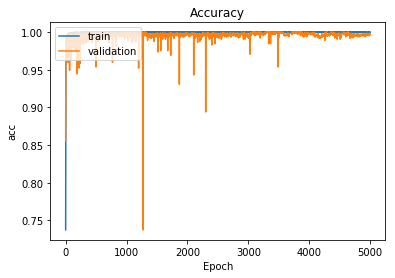

meng_huan
Testing accuracy= 0.9987546699875467



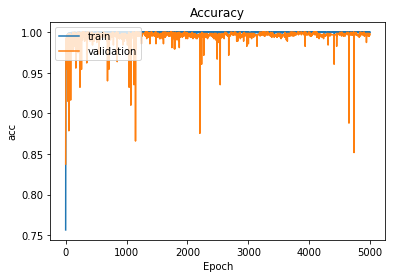

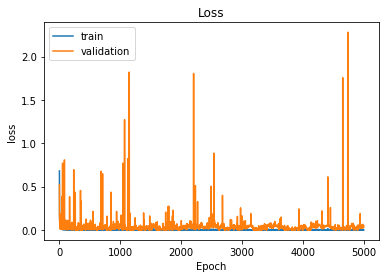

po_wen
Testing accuracy= 1.0



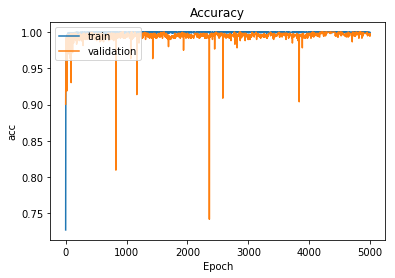

shooter
Testing accuracy= 1.0



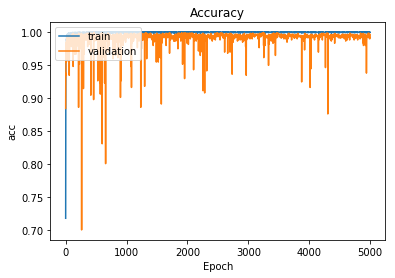

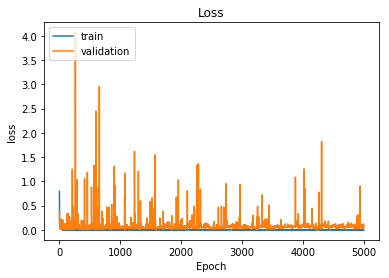

wan_yi
Testing accuracy= 1.0



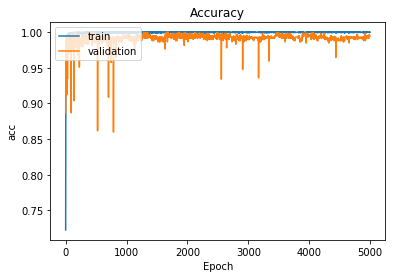

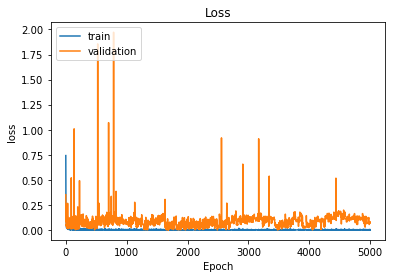

wen_ying
Testing accuracy= 1.0



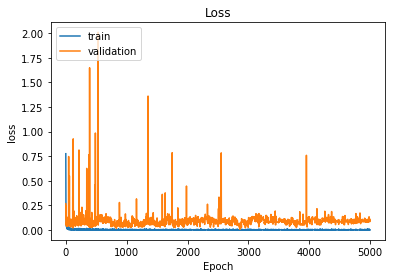

yenjin_friendA
Testing accuracy= 1.0



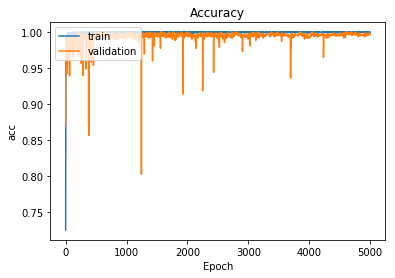

yi_fang
Testing accuracy= 0.9576719569360979



yu_chun
Testing accuracy= 0.982570805710645



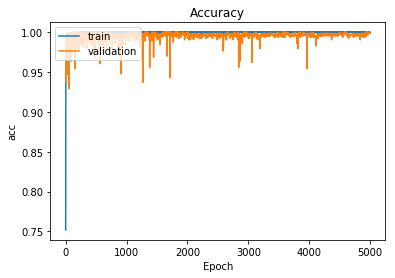

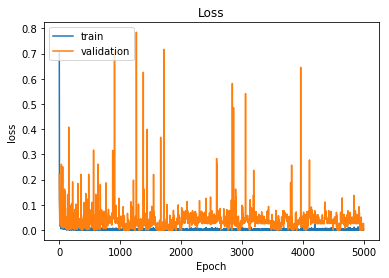

yu_wen
Testing accuracy= 0.9693548387096774



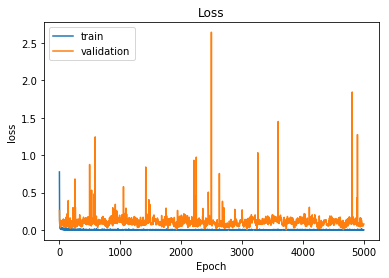

In [11]:
for i, item in enumerate(ONE_DIR):
    print(item)
    show_train_history(TRAIN_HISTORY[i], SCORE_LIST[i])

In [12]:
for i, item in enumerate(ONE_DIR):
    print(item)
    print(pd.crosstab(TEST_DATA_LABEL[i], PREDICTION_LIST[i], rownames=['label'], colnames=['predict']))
    print()

cheng_yu
predict    0    1    2    3   4
label                          
0        180    0    0    0   0
1          0  228    0    0   0
2          0    0  143    0   0
3          0    0    0  125   0
4          0    0    0    0  19

meng_huan
predict    0    1    2    3   4
label                          
0        169    0    0    0   0
1          0  373    0    0   0
2          0    0  118    0   0
3          0    1    0  121   0
4          0    0    0    0  21

po_wen
predict    0    1    2    3   4
label                          
0        188    0    0    0   0
1          0  490    0    0   0
2          0    0  109    0   0
3          0    0    0  108   0
4          0    0    0    0  16

shooter
predict    0    1    2    3   4
label                          
0        190    0    0    0   0
1          0  209    0    0   0
2          0    0  103    0   0
3          0    0    0  121   0
4          0    0    0    0  15

wan_yi
predict    0    1   2    3   4
label                       